# Baseline robbert model
For this project we use the Dutch language model "Robbert" as our baseline. This notebook displays the performance of robbert with the EmotioNL shows file.

Import necessary libraries

In [1]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install pandas
!pip install os
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
from torch import cuda
from google.colab import drive
import matplotlib.pyplot as plt


Connect to drive to find csv file

In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

base_path = "drive/MyDrive/HBO/cursussen/jaar_4/afstuderen"
filename = "emotionl_shows.csv"

pf = os.path.join(base_path, filename)

Import dataframe

In [5]:
pf

'drive/MyDrive/HBO/cursussen/jaar_4/afstuderen/emotionl_shows.csv'

In [6]:
df = pd.read_csv(pf)

In [7]:
df

Text Category
0    Kweenie of da gij al es goed hebt stilgestaan ...  neutral
1                                               Santé.      joy
2    Ja jongens. Dees is nie gezond ze. Pfff. Dees ...     fear
3    Ik had de vorige keer ook al zoiets van: nie m...    anger
4    Tis wat het is. Tis ook een belangrijke job eh...  neutral
..                                                 ...      ...
995  Jah ze werken harder eh als wij in België, en ...  sadness
996  Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.    anger
997  Der sta Lego van Lord of the Rings, van Star W...  neutral
998                  Nu zijn we precies aant kamperen.      joy
999  Ik heb euh ooit es… bja ik swing op elk feestj...      joy

[1000 rows x 2 columns]

We change the emotioncategories to numbers

In [8]:
df['Category'].replace(['neutral', 'joy', 'fear', 'anger', 'sadness', 'love', "other"], [0,1,2,3,4,5,6], inplace=True)

In [9]:
df

Text  Category
0    Kweenie of da gij al es goed hebt stilgestaan ...         0
1                                               Santé.         1
2    Ja jongens. Dees is nie gezond ze. Pfff. Dees ...         2
3    Ik had de vorige keer ook al zoiets van: nie m...         3
4    Tis wat het is. Tis ook een belangrijke job eh...         0
..                                                 ...       ...
995  Jah ze werken harder eh als wij in België, en ...         4
996  Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.         3
997  Der sta Lego van Lord of the Rings, van Star W...         0
998                  Nu zijn we precies aant kamperen.         1
999  Ik heb euh ooit es… bja ik swing op elk feestj...         1

[1000 rows x 2 columns]

Prepare the data for the training process. The data gets split, use the models tokenizer to tokenize the data and convert each splitted dataset to a torch dataset

In [10]:
train, test = train_test_split(df, train_size=0.8, random_state=10)
train = train.reset_index()
test = test.reset_index()

In [11]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base", truncation=True, do_lower_case=True)

This class converts a dataset to a torchdataset

In [12]:
class TorchDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe,
        self.tokenizer = tokenizer,
        self.texts = dataframe.Text,
        self.targets = self.data[0].Category

    def __len__(self):
        return len(self.texts[0])

    def __getitem__(self, index):
        text = str(self.texts[0][index])
        text = " ".join(text.split())

        inputs = self.tokenizer[0].encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


In [13]:
train_set =  TorchDataset(train, tokenizer)
test_set =  TorchDataset(test, tokenizer)

After converting the datasets to torch datasets, the datasets get turned into DataLoaders, which helps with creating easy batches and samples.

In [14]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, 4, shuffle=False, num_workers=0)

Next we turn on the GPU for this notebook and import the model. We change the output of the last layer to the amount of categories (Labels) our data has.

In [15]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [16]:
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels=7)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Here we use the create the loss funtion and the optimizer.

In [17]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.001)

The training functions gets called each epoch and trains using the trainsets and batches assignes to the DataLoader.

In [18]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [19]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs.logits, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples
        print(f"Training Loss Epoch: {epoch_loss}")
        print(f"Training Accuracy Epoch: {epoch_accu}")

    return (n_correct*100)/nb_tr_examples

Train for x amount epochs and return the epochs accuracy at the end

In [25]:
epochs = 95
t_acc = []
for x in range(epochs):
    t_acc.append(train(x))


1it [00:00,  4.61it/s]

Training Loss per 5000 steps: 1.9653759002685547
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 0: 25.0
Training Loss Epoch: 1.9653759002685547
Training Accuracy Epoch: 25.0


2it [00:00,  3.78it/s]

The Total Accuracy for Epoch 0: 25.0
Training Loss Epoch: 1.940098524093628
Training Accuracy Epoch: 25.0


3it [00:00,  3.58it/s]

The Total Accuracy for Epoch 0: 33.333333333333336
Training Loss Epoch: 1.8986827532450359
Training Accuracy Epoch: 33.333333333333336


4it [00:01,  3.53it/s]

The Total Accuracy for Epoch 0: 31.25
Training Loss Epoch: 1.9056151807308197
Training Accuracy Epoch: 31.25


5it [00:01,  3.45it/s]

The Total Accuracy for Epoch 0: 30.0
Training Loss Epoch: 1.9123414039611817
Training Accuracy Epoch: 30.0


6it [00:01,  3.45it/s]

The Total Accuracy for Epoch 0: 25.0
Training Loss Epoch: 1.9140631556510925
Training Accuracy Epoch: 25.0


7it [00:01,  3.42it/s]

The Total Accuracy for Epoch 0: 23.214285714285715
Training Loss Epoch: 1.9131157909120833
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.39it/s]

The Total Accuracy for Epoch 0: 21.875
Training Loss Epoch: 1.923272654414177
Training Accuracy Epoch: 21.875


9it [00:02,  3.39it/s]

The Total Accuracy for Epoch 0: 19.444444444444443
Training Loss Epoch: 1.9427449040942721
Training Accuracy Epoch: 19.444444444444443


10it [00:02,  3.33it/s]

The Total Accuracy for Epoch 0: 18.75
Training Loss Epoch: 1.9402093291282654
Training Accuracy Epoch: 18.75


11it [00:03,  3.38it/s]

The Total Accuracy for Epoch 0: 21.59090909090909
Training Loss Epoch: 1.920120813629844
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.38it/s]

The Total Accuracy for Epoch 0: 19.791666666666668
Training Loss Epoch: 1.9410506983598073
Training Accuracy Epoch: 19.791666666666668


13it [00:03,  3.38it/s]

The Total Accuracy for Epoch 0: 20.192307692307693
Training Loss Epoch: 1.944153171319228
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.38it/s]

The Total Accuracy for Epoch 0: 19.642857142857142
Training Loss Epoch: 1.9373297776494707
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.37it/s]

The Total Accuracy for Epoch 0: 20.0
Training Loss Epoch: 1.9335014820098877
Training Accuracy Epoch: 20.0


16it [00:04,  3.36it/s]

The Total Accuracy for Epoch 0: 20.3125
Training Loss Epoch: 1.9280036613345146
Training Accuracy Epoch: 20.3125


17it [00:04,  3.36it/s]

The Total Accuracy for Epoch 0: 20.58823529411765
Training Loss Epoch: 1.9293628229814417
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.35it/s]

The Total Accuracy for Epoch 0: 19.444444444444443
Training Loss Epoch: 1.9300369752777948
Training Accuracy Epoch: 19.444444444444443


19it [00:05,  3.37it/s]

The Total Accuracy for Epoch 0: 18.42105263157895
Training Loss Epoch: 1.9277024771037854
Training Accuracy Epoch: 18.42105263157895


20it [00:05,  3.34it/s]

The Total Accuracy for Epoch 0: 19.375
Training Loss Epoch: 1.9271947145462036
Training Accuracy Epoch: 19.375


21it [00:06,  3.32it/s]

The Total Accuracy for Epoch 0: 19.642857142857142
Training Loss Epoch: 1.9243296157746088
Training Accuracy Epoch: 19.642857142857142


22it [00:06,  3.33it/s]

The Total Accuracy for Epoch 0: 19.318181818181817
Training Loss Epoch: 1.9232955358245156
Training Accuracy Epoch: 19.318181818181817


23it [00:06,  3.26it/s]

The Total Accuracy for Epoch 0: 19.565217391304348
Training Loss Epoch: 1.9248904819073884
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.35it/s]

The Total Accuracy for Epoch 0: 20.3125
Training Loss Epoch: 1.926195189356804
Training Accuracy Epoch: 20.3125


25it [00:07,  3.34it/s]

The Total Accuracy for Epoch 0: 20.0
Training Loss Epoch: 1.9301185941696166
Training Accuracy Epoch: 20.0


26it [00:07,  3.34it/s]

The Total Accuracy for Epoch 0: 21.153846153846153
Training Loss Epoch: 1.9256716737380395
Training Accuracy Epoch: 21.153846153846153


27it [00:07,  3.31it/s]

The Total Accuracy for Epoch 0: 21.296296296296298
Training Loss Epoch: 1.9259917338689168
Training Accuracy Epoch: 21.296296296296298


28it [00:08,  3.21it/s]

The Total Accuracy for Epoch 0: 21.428571428571427
Training Loss Epoch: 1.926750510931015
Training Accuracy Epoch: 21.428571428571427


29it [00:08,  3.11it/s]

The Total Accuracy for Epoch 0: 20.689655172413794
Training Loss Epoch: 1.9263953299357974
Training Accuracy Epoch: 20.689655172413794


30it [00:08,  3.25it/s]

The Total Accuracy for Epoch 0: 21.25
Training Loss Epoch: 1.9253732721010843
Training Accuracy Epoch: 21.25


31it [00:09,  3.28it/s]

The Total Accuracy for Epoch 0: 22.177419354838708
Training Loss Epoch: 1.919703325917644
Training Accuracy Epoch: 22.177419354838708


32it [00:09,  3.37it/s]

The Total Accuracy for Epoch 0: 22.265625
Training Loss Epoch: 1.9227963797748089
Training Accuracy Epoch: 22.265625


33it [00:09,  3.35it/s]

The Total Accuracy for Epoch 0: 22.348484848484848
Training Loss Epoch: 1.9223394213300762
Training Accuracy Epoch: 22.348484848484848


34it [00:10,  3.34it/s]

The Total Accuracy for Epoch 0: 22.426470588235293
Training Loss Epoch: 1.923089837326723
Training Accuracy Epoch: 22.426470588235293


35it [00:10,  3.32it/s]

The Total Accuracy for Epoch 0: 21.785714285714285
Training Loss Epoch: 1.9225235598427908
Training Accuracy Epoch: 21.785714285714285


36it [00:10,  3.26it/s]

The Total Accuracy for Epoch 0: 21.52777777777778
Training Loss Epoch: 1.9236645532978907
Training Accuracy Epoch: 21.52777777777778


37it [00:11,  3.34it/s]

The Total Accuracy for Epoch 0: 21.62162162162162
Training Loss Epoch: 1.9205102340595142
Training Accuracy Epoch: 21.62162162162162


38it [00:11,  3.32it/s]

The Total Accuracy for Epoch 0: 21.710526315789473
Training Loss Epoch: 1.9197772051158704
Training Accuracy Epoch: 21.710526315789473


39it [00:11,  3.32it/s]

The Total Accuracy for Epoch 0: 21.474358974358974
Training Loss Epoch: 1.9220788539984288
Training Accuracy Epoch: 21.474358974358974


40it [00:11,  3.32it/s]

The Total Accuracy for Epoch 0: 20.9375
Training Loss Epoch: 1.9264585673809052
Training Accuracy Epoch: 20.9375


41it [00:12,  3.31it/s]

The Total Accuracy for Epoch 0: 21.036585365853657
Training Loss Epoch: 1.9276996298534115
Training Accuracy Epoch: 21.036585365853657


42it [00:12,  3.30it/s]

The Total Accuracy for Epoch 0: 21.428571428571427
Training Loss Epoch: 1.9276020725568135
Training Accuracy Epoch: 21.428571428571427


43it [00:12,  3.28it/s]

The Total Accuracy for Epoch 0: 21.802325581395348
Training Loss Epoch: 1.9257758495419524
Training Accuracy Epoch: 21.802325581395348


44it [00:13,  3.29it/s]

The Total Accuracy for Epoch 0: 22.15909090909091
Training Loss Epoch: 1.9259020659056576
Training Accuracy Epoch: 22.15909090909091


45it [00:13,  3.29it/s]

The Total Accuracy for Epoch 0: 21.666666666666668
Training Loss Epoch: 1.9296921385659112
Training Accuracy Epoch: 21.666666666666668


46it [00:13,  3.26it/s]

The Total Accuracy for Epoch 0: 22.282608695652176
Training Loss Epoch: 1.9262704253196716
Training Accuracy Epoch: 22.282608695652176


47it [00:14,  3.28it/s]

The Total Accuracy for Epoch 0: 22.074468085106382
Training Loss Epoch: 1.9286237955093384
Training Accuracy Epoch: 22.074468085106382


48it [00:14,  3.28it/s]

The Total Accuracy for Epoch 0: 22.395833333333332
Training Loss Epoch: 1.9287948782245319
Training Accuracy Epoch: 22.395833333333332


49it [00:14,  3.32it/s]

The Total Accuracy for Epoch 0: 22.448979591836736
Training Loss Epoch: 1.9312933829365944
Training Accuracy Epoch: 22.448979591836736


50it [00:14,  3.32it/s]

The Total Accuracy for Epoch 0: 22.75
Training Loss Epoch: 1.9294274234771729
Training Accuracy Epoch: 22.75


51it [00:15,  3.31it/s]

The Total Accuracy for Epoch 0: 23.03921568627451
Training Loss Epoch: 1.9301359770344753
Training Accuracy Epoch: 23.03921568627451


52it [00:15,  3.31it/s]

The Total Accuracy for Epoch 0: 22.596153846153847
Training Loss Epoch: 1.9296501462276165
Training Accuracy Epoch: 22.596153846153847


53it [00:15,  3.30it/s]

The Total Accuracy for Epoch 0: 22.641509433962263
Training Loss Epoch: 1.9288199060368088
Training Accuracy Epoch: 22.641509433962263


54it [00:16,  3.30it/s]

The Total Accuracy for Epoch 0: 22.685185185185187
Training Loss Epoch: 1.9295111916683338
Training Accuracy Epoch: 22.685185185185187


55it [00:16,  3.29it/s]

The Total Accuracy for Epoch 0: 22.272727272727273
Training Loss Epoch: 1.9302145459435203
Training Accuracy Epoch: 22.272727272727273


56it [00:16,  3.29it/s]

The Total Accuracy for Epoch 0: 22.098214285714285
Training Loss Epoch: 1.9306715152093343
Training Accuracy Epoch: 22.098214285714285


57it [00:17,  3.29it/s]

The Total Accuracy for Epoch 0: 22.36842105263158
Training Loss Epoch: 1.9299091058864928
Training Accuracy Epoch: 22.36842105263158


58it [00:17,  3.29it/s]

The Total Accuracy for Epoch 0: 21.982758620689655
Training Loss Epoch: 1.9313827403660477
Training Accuracy Epoch: 21.982758620689655


59it [00:17,  3.30it/s]

The Total Accuracy for Epoch 0: 21.610169491525422
Training Loss Epoch: 1.9310648764594127
Training Accuracy Epoch: 21.610169491525422


60it [00:17,  3.30it/s]

The Total Accuracy for Epoch 0: 21.875
Training Loss Epoch: 1.9281868994235993
Training Accuracy Epoch: 21.875


61it [00:18,  3.27it/s]

The Total Accuracy for Epoch 0: 21.516393442622952
Training Loss Epoch: 1.9292884635143592
Training Accuracy Epoch: 21.516393442622952


62it [00:18,  3.30it/s]

The Total Accuracy for Epoch 0: 21.572580645161292
Training Loss Epoch: 1.9289106322873024
Training Accuracy Epoch: 21.572580645161292


63it [00:18,  3.29it/s]

The Total Accuracy for Epoch 0: 21.626984126984127
Training Loss Epoch: 1.9259959307927934
Training Accuracy Epoch: 21.626984126984127


64it [00:19,  3.29it/s]

The Total Accuracy for Epoch 0: 21.6796875
Training Loss Epoch: 1.9266388267278671
Training Accuracy Epoch: 21.6796875


65it [00:19,  3.29it/s]

The Total Accuracy for Epoch 0: 21.346153846153847
Training Loss Epoch: 1.9274617525247426
Training Accuracy Epoch: 21.346153846153847


66it [00:19,  3.29it/s]

The Total Accuracy for Epoch 0: 21.401515151515152
Training Loss Epoch: 1.9259638605695781
Training Accuracy Epoch: 21.401515151515152


67it [00:20,  3.27it/s]

The Total Accuracy for Epoch 0: 21.26865671641791
Training Loss Epoch: 1.9265311298085683
Training Accuracy Epoch: 21.26865671641791


68it [00:20,  3.27it/s]

The Total Accuracy for Epoch 0: 21.50735294117647
Training Loss Epoch: 1.9259278528830583
Training Accuracy Epoch: 21.50735294117647


69it [00:20,  3.27it/s]

The Total Accuracy for Epoch 0: 21.3768115942029
Training Loss Epoch: 1.9248953003814255
Training Accuracy Epoch: 21.3768115942029


70it [00:21,  3.25it/s]

The Total Accuracy for Epoch 0: 21.428571428571427
Training Loss Epoch: 1.9261143582207816
Training Accuracy Epoch: 21.428571428571427


71it [00:21,  3.27it/s]

The Total Accuracy for Epoch 0: 21.12676056338028
Training Loss Epoch: 1.9284874251191044
Training Accuracy Epoch: 21.12676056338028


72it [00:21,  3.26it/s]

The Total Accuracy for Epoch 0: 21.180555555555557
Training Loss Epoch: 1.9276910970608394
Training Accuracy Epoch: 21.180555555555557


73it [00:21,  3.24it/s]

The Total Accuracy for Epoch 0: 20.89041095890411
Training Loss Epoch: 1.9317986328307897
Training Accuracy Epoch: 20.89041095890411


74it [00:22,  3.24it/s]

The Total Accuracy for Epoch 0: 20.945945945945947
Training Loss Epoch: 1.9316199953491624
Training Accuracy Epoch: 20.945945945945947


75it [00:22,  3.27it/s]

The Total Accuracy for Epoch 0: 20.666666666666668
Training Loss Epoch: 1.9344813060760497
Training Accuracy Epoch: 20.666666666666668


76it [00:22,  3.25it/s]

The Total Accuracy for Epoch 0: 20.723684210526315
Training Loss Epoch: 1.934652468091563
Training Accuracy Epoch: 20.723684210526315


77it [00:23,  3.25it/s]

The Total Accuracy for Epoch 0: 20.454545454545453
Training Loss Epoch: 1.9361785928924362
Training Accuracy Epoch: 20.454545454545453


78it [00:23,  3.24it/s]

The Total Accuracy for Epoch 0: 20.192307692307693
Training Loss Epoch: 1.9389622838069231
Training Accuracy Epoch: 20.192307692307693


79it [00:23,  3.24it/s]

The Total Accuracy for Epoch 0: 20.411392405063292
Training Loss Epoch: 1.937323120575917
Training Accuracy Epoch: 20.411392405063292


80it [00:24,  3.25it/s]

The Total Accuracy for Epoch 0: 20.15625
Training Loss Epoch: 1.9377790078520776
Training Accuracy Epoch: 20.15625


81it [00:24,  3.25it/s]

The Total Accuracy for Epoch 0: 20.061728395061728
Training Loss Epoch: 1.9386959532160817
Training Accuracy Epoch: 20.061728395061728


82it [00:24,  3.22it/s]

The Total Accuracy for Epoch 0: 20.274390243902438
Training Loss Epoch: 1.9374526695507328
Training Accuracy Epoch: 20.274390243902438


83it [00:25,  3.22it/s]

The Total Accuracy for Epoch 0: 20.180722891566266
Training Loss Epoch: 1.9378979550786766
Training Accuracy Epoch: 20.180722891566266


84it [00:25,  3.21it/s]

The Total Accuracy for Epoch 0: 19.94047619047619
Training Loss Epoch: 1.9389777666046506
Training Accuracy Epoch: 19.94047619047619


85it [00:25,  3.23it/s]

The Total Accuracy for Epoch 0: 19.852941176470587
Training Loss Epoch: 1.9402275786680334
Training Accuracy Epoch: 19.852941176470587


86it [00:26,  3.23it/s]

The Total Accuracy for Epoch 0: 19.767441860465116
Training Loss Epoch: 1.9406286769135053
Training Accuracy Epoch: 19.767441860465116


87it [00:26,  3.22it/s]

The Total Accuracy for Epoch 0: 19.54022988505747
Training Loss Epoch: 1.942707846904623
Training Accuracy Epoch: 19.54022988505747


88it [00:26,  3.22it/s]

The Total Accuracy for Epoch 0: 19.460227272727273
Training Loss Epoch: 1.94282474165613
Training Accuracy Epoch: 19.460227272727273


89it [00:26,  3.22it/s]

The Total Accuracy for Epoch 0: 19.52247191011236
Training Loss Epoch: 1.942845193187842
Training Accuracy Epoch: 19.52247191011236


90it [00:27,  3.22it/s]

The Total Accuracy for Epoch 0: 19.444444444444443
Training Loss Epoch: 1.9426613224877252
Training Accuracy Epoch: 19.444444444444443


91it [00:27,  3.22it/s]

The Total Accuracy for Epoch 0: 19.505494505494507
Training Loss Epoch: 1.9420692056089968
Training Accuracy Epoch: 19.505494505494507


92it [00:27,  3.20it/s]

The Total Accuracy for Epoch 0: 19.429347826086957
Training Loss Epoch: 1.9424635042314944
Training Accuracy Epoch: 19.429347826086957


93it [00:28,  3.21it/s]

The Total Accuracy for Epoch 0: 19.489247311827956
Training Loss Epoch: 1.9410340529616161
Training Accuracy Epoch: 19.489247311827956


94it [00:28,  3.21it/s]

The Total Accuracy for Epoch 0: 19.28191489361702
Training Loss Epoch: 1.942105420092319
Training Accuracy Epoch: 19.28191489361702


95it [00:28,  3.22it/s]

The Total Accuracy for Epoch 0: 19.07894736842105
Training Loss Epoch: 1.9435027900495028
Training Accuracy Epoch: 19.07894736842105


96it [00:29,  3.21it/s]

The Total Accuracy for Epoch 0: 19.270833333333332
Training Loss Epoch: 1.9430418362220128
Training Accuracy Epoch: 19.270833333333332


97it [00:29,  3.25it/s]

The Total Accuracy for Epoch 0: 19.072164948453608
Training Loss Epoch: 1.9433546521000027
Training Accuracy Epoch: 19.072164948453608


98it [00:29,  3.23it/s]

The Total Accuracy for Epoch 0: 19.132653061224488
Training Loss Epoch: 1.9425849099548496
Training Accuracy Epoch: 19.132653061224488


99it [00:30,  3.22it/s]

The Total Accuracy for Epoch 0: 19.065656565656564
Training Loss Epoch: 1.94426260211251
Training Accuracy Epoch: 19.065656565656564


100it [00:30,  3.29it/s]


The Total Accuracy for Epoch 0: 19.25
Training Loss Epoch: 1.9439422392845154
Training Accuracy Epoch: 19.25


1it [00:00,  3.39it/s]

Training Loss per 5000 steps: 2.0102169513702393
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 1: 0.0
Training Loss Epoch: 2.0102169513702393
Training Accuracy Epoch: 0.0


2it [00:00,  3.30it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 1.993822991847992
Training Accuracy Epoch: 12.5


3it [00:00,  3.24it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 1.9616925716400146
Training Accuracy Epoch: 12.5


4it [00:01,  3.24it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9503223299980164
Training Accuracy Epoch: 18.75


5it [00:01,  3.24it/s]

The Total Accuracy for Epoch 1: 20.0
Training Loss Epoch: 1.936841893196106
Training Accuracy Epoch: 20.0


6it [00:01,  3.21it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.921213408311208
Training Accuracy Epoch: 18.75


7it [00:02,  3.21it/s]

The Total Accuracy for Epoch 1: 19.642857142857142
Training Loss Epoch: 1.9065509353365218
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.20it/s]

The Total Accuracy for Epoch 1: 20.3125
Training Loss Epoch: 1.9190330356359482
Training Accuracy Epoch: 20.3125


9it [00:02,  3.20it/s]

The Total Accuracy for Epoch 1: 19.444444444444443
Training Loss Epoch: 1.9305654499265883
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.20it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9292208790779113
Training Accuracy Epoch: 18.75


11it [00:03,  3.18it/s]

The Total Accuracy for Epoch 1: 20.454545454545453
Training Loss Epoch: 1.9179229736328125
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.19it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9345932801564534
Training Accuracy Epoch: 18.75


13it [00:04,  3.20it/s]

The Total Accuracy for Epoch 1: 18.26923076923077
Training Loss Epoch: 1.9517594850980318
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.18it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9428115827696664
Training Accuracy Epoch: 18.75


15it [00:04,  3.19it/s]

The Total Accuracy for Epoch 1: 18.333333333333332
Training Loss Epoch: 1.942835259437561
Training Accuracy Epoch: 18.333333333333332


16it [00:04,  3.18it/s]

The Total Accuracy for Epoch 1: 19.53125
Training Loss Epoch: 1.9378227889537811
Training Accuracy Epoch: 19.53125


17it [00:05,  3.20it/s]

The Total Accuracy for Epoch 1: 19.11764705882353
Training Loss Epoch: 1.9372626192429487
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.20it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9352999660703871
Training Accuracy Epoch: 18.75


19it [00:05,  3.19it/s]

The Total Accuracy for Epoch 1: 19.07894736842105
Training Loss Epoch: 1.931338868643108
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.18it/s]

The Total Accuracy for Epoch 1: 20.625
Training Loss Epoch: 1.9249126672744752
Training Accuracy Epoch: 20.625


21it [00:06,  3.19it/s]

The Total Accuracy for Epoch 1: 22.023809523809526
Training Loss Epoch: 1.9196503389449346
Training Accuracy Epoch: 22.023809523809526


22it [00:06,  3.17it/s]

The Total Accuracy for Epoch 1: 22.727272727272727
Training Loss Epoch: 1.9186971566893838
Training Accuracy Epoch: 22.727272727272727


23it [00:07,  3.18it/s]

The Total Accuracy for Epoch 1: 22.282608695652176
Training Loss Epoch: 1.9199635049571162
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.17it/s]

The Total Accuracy for Epoch 1: 21.875
Training Loss Epoch: 1.921757385134697
Training Accuracy Epoch: 21.875


25it [00:07,  3.18it/s]

The Total Accuracy for Epoch 1: 21.5
Training Loss Epoch: 1.9250374841690063
Training Accuracy Epoch: 21.5


26it [00:08,  3.18it/s]

The Total Accuracy for Epoch 1: 20.673076923076923
Training Loss Epoch: 1.923950053178347
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.18it/s]

The Total Accuracy for Epoch 1: 21.296296296296298
Training Loss Epoch: 1.925816262209857
Training Accuracy Epoch: 21.296296296296298


28it [00:08,  3.18it/s]

The Total Accuracy for Epoch 1: 20.982142857142858
Training Loss Epoch: 1.9282220602035522
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.16it/s]

The Total Accuracy for Epoch 1: 21.120689655172413
Training Loss Epoch: 1.9282713100827973
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.17it/s]

The Total Accuracy for Epoch 1: 21.666666666666668
Training Loss Epoch: 1.9243862311045328
Training Accuracy Epoch: 21.666666666666668


31it [00:09,  3.17it/s]

The Total Accuracy for Epoch 1: 21.370967741935484
Training Loss Epoch: 1.9240443629603232
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.15it/s]

The Total Accuracy for Epoch 1: 21.484375
Training Loss Epoch: 1.9254641309380531
Training Accuracy Epoch: 21.484375


33it [00:10,  3.16it/s]

The Total Accuracy for Epoch 1: 21.96969696969697
Training Loss Epoch: 1.9239876992774732
Training Accuracy Epoch: 21.96969696969697


34it [00:10,  3.14it/s]

The Total Accuracy for Epoch 1: 22.058823529411764
Training Loss Epoch: 1.9252218463841606
Training Accuracy Epoch: 22.058823529411764


35it [00:10,  3.13it/s]

The Total Accuracy for Epoch 1: 21.428571428571427
Training Loss Epoch: 1.9257579020091466
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.13it/s]

The Total Accuracy for Epoch 1: 20.833333333333332
Training Loss Epoch: 1.9269101089901395
Training Accuracy Epoch: 20.833333333333332


37it [00:11,  3.13it/s]

The Total Accuracy for Epoch 1: 20.60810810810811
Training Loss Epoch: 1.925081104845614
Training Accuracy Epoch: 20.60810810810811


38it [00:11,  3.14it/s]

The Total Accuracy for Epoch 1: 20.723684210526315
Training Loss Epoch: 1.9249904594923322
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.13it/s]

The Total Accuracy for Epoch 1: 20.512820512820515
Training Loss Epoch: 1.9292025871765919
Training Accuracy Epoch: 20.512820512820515


40it [00:12,  3.12it/s]

The Total Accuracy for Epoch 1: 20.0
Training Loss Epoch: 1.9319874584674834
Training Accuracy Epoch: 20.0


41it [00:12,  3.11it/s]

The Total Accuracy for Epoch 1: 20.121951219512194
Training Loss Epoch: 1.932679897401391
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.09it/s]

The Total Accuracy for Epoch 1: 20.238095238095237
Training Loss Epoch: 1.9315145498230344
Training Accuracy Epoch: 20.238095238095237


43it [00:13,  3.11it/s]

The Total Accuracy for Epoch 1: 20.63953488372093
Training Loss Epoch: 1.9295918470205262
Training Accuracy Epoch: 20.63953488372093


44it [00:13,  3.13it/s]

The Total Accuracy for Epoch 1: 20.454545454545453
Training Loss Epoch: 1.9327932785857806
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.14it/s]

The Total Accuracy for Epoch 1: 20.0
Training Loss Epoch: 1.9357562144597371
Training Accuracy Epoch: 20.0


46it [00:14,  3.13it/s]

The Total Accuracy for Epoch 1: 19.565217391304348
Training Loss Epoch: 1.934766588003739
Training Accuracy Epoch: 19.565217391304348


47it [00:14,  3.15it/s]

The Total Accuracy for Epoch 1: 19.414893617021278
Training Loss Epoch: 1.9383427031496738
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.14it/s]

The Total Accuracy for Epoch 1: 19.270833333333332
Training Loss Epoch: 1.9394084364175797
Training Accuracy Epoch: 19.270833333333332


49it [00:15,  3.12it/s]

The Total Accuracy for Epoch 1: 19.387755102040817
Training Loss Epoch: 1.9405476195471627
Training Accuracy Epoch: 19.387755102040817


50it [00:15,  3.13it/s]

The Total Accuracy for Epoch 1: 19.75
Training Loss Epoch: 1.9382683300971986
Training Accuracy Epoch: 19.75


51it [00:16,  3.14it/s]

The Total Accuracy for Epoch 1: 19.852941176470587
Training Loss Epoch: 1.9378815001132441
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.10it/s]

The Total Accuracy for Epoch 1: 19.471153846153847
Training Loss Epoch: 1.9387031633120317
Training Accuracy Epoch: 19.471153846153847


53it [00:16,  3.14it/s]

The Total Accuracy for Epoch 1: 19.57547169811321
Training Loss Epoch: 1.9380036007683232
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.15it/s]

The Total Accuracy for Epoch 1: 19.444444444444443
Training Loss Epoch: 1.9396748079193964
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.16it/s]

The Total Accuracy for Epoch 1: 19.09090909090909
Training Loss Epoch: 1.9402634533968839
Training Accuracy Epoch: 19.09090909090909


56it [00:17,  3.14it/s]

The Total Accuracy for Epoch 1: 18.973214285714285
Training Loss Epoch: 1.9410935917070933
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.12it/s]

The Total Accuracy for Epoch 1: 18.859649122807017
Training Loss Epoch: 1.9412944986109149
Training Accuracy Epoch: 18.859649122807017


58it [00:18,  3.12it/s]

The Total Accuracy for Epoch 1: 18.53448275862069
Training Loss Epoch: 1.9450087259555686
Training Accuracy Epoch: 18.53448275862069


59it [00:18,  3.11it/s]

The Total Accuracy for Epoch 1: 18.64406779661017
Training Loss Epoch: 1.9440391508199402
Training Accuracy Epoch: 18.64406779661017


60it [00:18,  3.12it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9427992482980092
Training Accuracy Epoch: 18.75


61it [00:19,  3.11it/s]

The Total Accuracy for Epoch 1: 18.852459016393443
Training Loss Epoch: 1.944113127520827
Training Accuracy Epoch: 18.852459016393443


62it [00:19,  3.10it/s]

The Total Accuracy for Epoch 1: 19.35483870967742
Training Loss Epoch: 1.9419408632862953
Training Accuracy Epoch: 19.35483870967742


63it [00:19,  3.10it/s]

The Total Accuracy for Epoch 1: 19.642857142857142
Training Loss Epoch: 1.93923638926612
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.10it/s]

The Total Accuracy for Epoch 1: 19.3359375
Training Loss Epoch: 1.9397432897239923
Training Accuracy Epoch: 19.3359375


65it [00:20,  3.09it/s]

The Total Accuracy for Epoch 1: 19.03846153846154
Training Loss Epoch: 1.9414440283408532
Training Accuracy Epoch: 19.03846153846154


66it [00:20,  3.10it/s]

The Total Accuracy for Epoch 1: 19.12878787878788
Training Loss Epoch: 1.94177598844875
Training Accuracy Epoch: 19.12878787878788


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 1: 19.029850746268657
Training Loss Epoch: 1.9410639752202958
Training Accuracy Epoch: 19.029850746268657


68it [00:21,  3.09it/s]

The Total Accuracy for Epoch 1: 18.933823529411764
Training Loss Epoch: 1.9415072290336384
Training Accuracy Epoch: 18.933823529411764


69it [00:21,  3.09it/s]

The Total Accuracy for Epoch 1: 19.02173913043478
Training Loss Epoch: 1.9402400410693625
Training Accuracy Epoch: 19.02173913043478


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 1: 19.107142857142858
Training Loss Epoch: 1.9407218064580645
Training Accuracy Epoch: 19.107142857142858


71it [00:22,  3.08it/s]

The Total Accuracy for Epoch 1: 19.014084507042252
Training Loss Epoch: 1.9414773961188088
Training Accuracy Epoch: 19.014084507042252


72it [00:22,  3.07it/s]

The Total Accuracy for Epoch 1: 18.92361111111111
Training Loss Epoch: 1.9407608310381572
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 1: 18.664383561643834
Training Loss Epoch: 1.9431919529013437
Training Accuracy Epoch: 18.664383561643834


74it [00:23,  3.06it/s]

The Total Accuracy for Epoch 1: 18.58108108108108
Training Loss Epoch: 1.943986322428729
Training Accuracy Epoch: 18.58108108108108


75it [00:23,  3.08it/s]

The Total Accuracy for Epoch 1: 18.333333333333332
Training Loss Epoch: 1.9467701562245687
Training Accuracy Epoch: 18.333333333333332


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 1: 18.42105263157895
Training Loss Epoch: 1.9471726166574579
Training Accuracy Epoch: 18.42105263157895


77it [00:24,  3.05it/s]

The Total Accuracy for Epoch 1: 18.181818181818183
Training Loss Epoch: 1.9478033672679553
Training Accuracy Epoch: 18.181818181818183


78it [00:24,  3.06it/s]

The Total Accuracy for Epoch 1: 17.94871794871795
Training Loss Epoch: 1.9506289072525806
Training Accuracy Epoch: 17.94871794871795


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 1: 18.354430379746834
Training Loss Epoch: 1.9494181826144834
Training Accuracy Epoch: 18.354430379746834


80it [00:25,  3.05it/s]

The Total Accuracy for Epoch 1: 18.125
Training Loss Epoch: 1.9503993213176727
Training Accuracy Epoch: 18.125


81it [00:25,  3.07it/s]

The Total Accuracy for Epoch 1: 18.055555555555557
Training Loss Epoch: 1.9512223373224706
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 1: 18.29268292682927
Training Loss Epoch: 1.9498533054095943
Training Accuracy Epoch: 18.29268292682927


83it [00:26,  3.06it/s]

The Total Accuracy for Epoch 1: 18.22289156626506
Training Loss Epoch: 1.950475771743131
Training Accuracy Epoch: 18.22289156626506


84it [00:26,  3.03it/s]

The Total Accuracy for Epoch 1: 18.154761904761905
Training Loss Epoch: 1.9511418839295704
Training Accuracy Epoch: 18.154761904761905


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 1: 17.941176470588236
Training Loss Epoch: 1.9527204471475939
Training Accuracy Epoch: 17.941176470588236


86it [00:27,  3.04it/s]

The Total Accuracy for Epoch 1: 18.313953488372093
Training Loss Epoch: 1.9516699327978977
Training Accuracy Epoch: 18.313953488372093


87it [00:27,  3.05it/s]

The Total Accuracy for Epoch 1: 18.24712643678161
Training Loss Epoch: 1.9530145368356815
Training Accuracy Epoch: 18.24712643678161


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 1: 18.181818181818183
Training Loss Epoch: 1.9529983645135707
Training Accuracy Epoch: 18.181818181818183


89it [00:28,  3.03it/s]

The Total Accuracy for Epoch 1: 18.39887640449438
Training Loss Epoch: 1.953371775284242
Training Accuracy Epoch: 18.39887640449438


90it [00:28,  3.04it/s]

The Total Accuracy for Epoch 1: 18.47222222222222
Training Loss Epoch: 1.9526311185624865
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 1: 18.543956043956044
Training Loss Epoch: 1.9521485082395784
Training Accuracy Epoch: 18.543956043956044


92it [00:29,  3.05it/s]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 1.9510170661884805
Training Accuracy Epoch: 18.75


93it [00:29,  3.06it/s]

The Total Accuracy for Epoch 1: 19.086021505376344
Training Loss Epoch: 1.9492893359994377
Training Accuracy Epoch: 19.086021505376344


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 1: 18.882978723404257
Training Loss Epoch: 1.9511233428691297
Training Accuracy Epoch: 18.882978723404257


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 1: 18.68421052631579
Training Loss Epoch: 1.9510010631460892
Training Accuracy Epoch: 18.68421052631579


96it [00:30,  3.05it/s]

The Total Accuracy for Epoch 1: 18.619791666666668
Training Loss Epoch: 1.952213604003191
Training Accuracy Epoch: 18.619791666666668


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 1: 18.556701030927837
Training Loss Epoch: 1.9518931968924926
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.02it/s]

The Total Accuracy for Epoch 1: 18.622448979591837
Training Loss Epoch: 1.9511197014730803
Training Accuracy Epoch: 18.622448979591837


99it [00:31,  3.01it/s]

The Total Accuracy for Epoch 1: 18.434343434343436
Training Loss Epoch: 1.952824764781528
Training Accuracy Epoch: 18.434343434343436


100it [00:32,  3.12it/s]


The Total Accuracy for Epoch 1: 18.5
Training Loss Epoch: 1.9531726765632629
Training Accuracy Epoch: 18.5


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 2.020068645477295
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 2: 0.0
Training Loss Epoch: 2.020068645477295
Training Accuracy Epoch: 0.0


2it [00:00,  3.10it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 1.897977888584137
Training Accuracy Epoch: 12.5


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 1.9022337992986043
Training Accuracy Epoch: 12.5


4it [00:01,  3.05it/s]

The Total Accuracy for Epoch 2: 18.75
Training Loss Epoch: 1.8869327306747437
Training Accuracy Epoch: 18.75


5it [00:01,  3.03it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 1.8734594106674194
Training Accuracy Epoch: 20.0


6it [00:01,  3.04it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 1.8781723777453105
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 2: 21.428571428571427
Training Loss Epoch: 1.8635906662259782
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.03it/s]

The Total Accuracy for Epoch 2: 21.875
Training Loss Epoch: 1.8657605797052383
Training Accuracy Epoch: 21.875


9it [00:02,  3.03it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 1.8818622827529907
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 2: 18.75
Training Loss Epoch: 1.8911516666412354
Training Accuracy Epoch: 18.75


11it [00:03,  3.02it/s]

The Total Accuracy for Epoch 2: 18.181818181818183
Training Loss Epoch: 1.8825035420331089
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.03it/s]

The Total Accuracy for Epoch 2: 16.666666666666668
Training Loss Epoch: 1.8942718207836151
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.01it/s]

The Total Accuracy for Epoch 2: 16.346153846153847
Training Loss Epoch: 1.9054933419594398
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.02it/s]

The Total Accuracy for Epoch 2: 16.071428571428573
Training Loss Epoch: 1.8975613457815987
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.02it/s]

The Total Accuracy for Epoch 2: 15.833333333333334
Training Loss Epoch: 1.9027360598246257
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.01it/s]

The Total Accuracy for Epoch 2: 17.96875
Training Loss Epoch: 1.8999440670013428
Training Accuracy Epoch: 17.96875


17it [00:05,  3.02it/s]

The Total Accuracy for Epoch 2: 19.11764705882353
Training Loss Epoch: 1.901876035858603
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.00it/s]

The Total Accuracy for Epoch 2: 18.75
Training Loss Epoch: 1.8973632322417364
Training Accuracy Epoch: 18.75


19it [00:06,  3.02it/s]

The Total Accuracy for Epoch 2: 18.42105263157895
Training Loss Epoch: 1.9000213522660105
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.02it/s]

The Total Accuracy for Epoch 2: 18.75
Training Loss Epoch: 1.899652111530304
Training Accuracy Epoch: 18.75


21it [00:06,  3.00it/s]

The Total Accuracy for Epoch 2: 19.642857142857142
Training Loss Epoch: 1.897911554291135
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.00it/s]

The Total Accuracy for Epoch 2: 19.886363636363637
Training Loss Epoch: 1.8990404497493396
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  2.99it/s]

The Total Accuracy for Epoch 2: 19.02173913043478
Training Loss Epoch: 1.900914244029833
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  2.99it/s]

The Total Accuracy for Epoch 2: 19.270833333333332
Training Loss Epoch: 1.9069815774758656
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.00it/s]

The Total Accuracy for Epoch 2: 19.5
Training Loss Epoch: 1.9108492565155029
Training Accuracy Epoch: 19.5


26it [00:08,  3.00it/s]

The Total Accuracy for Epoch 2: 19.71153846153846
Training Loss Epoch: 1.90684129183109
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  2.99it/s]

The Total Accuracy for Epoch 2: 19.444444444444443
Training Loss Epoch: 1.9123193820317586
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.00it/s]

The Total Accuracy for Epoch 2: 19.196428571428573
Training Loss Epoch: 1.910509535244533
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  2.99it/s]

The Total Accuracy for Epoch 2: 19.396551724137932
Training Loss Epoch: 1.90976921032215
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  2.99it/s]

The Total Accuracy for Epoch 2: 19.166666666666668
Training Loss Epoch: 1.906868334611257
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.01it/s]

The Total Accuracy for Epoch 2: 18.951612903225808
Training Loss Epoch: 1.9044419027143908
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.00it/s]

The Total Accuracy for Epoch 2: 19.140625
Training Loss Epoch: 1.907589428126812
Training Accuracy Epoch: 19.140625


33it [00:10,  2.99it/s]

The Total Accuracy for Epoch 2: 20.075757575757574
Training Loss Epoch: 1.9090118913939504
Training Accuracy Epoch: 20.075757575757574


34it [00:11,  3.00it/s]

The Total Accuracy for Epoch 2: 19.852941176470587
Training Loss Epoch: 1.91071736461976
Training Accuracy Epoch: 19.852941176470587


35it [00:11,  2.99it/s]

The Total Accuracy for Epoch 2: 19.285714285714285
Training Loss Epoch: 1.9134006125586374
Training Accuracy Epoch: 19.285714285714285


36it [00:11,  2.99it/s]

The Total Accuracy for Epoch 2: 19.444444444444443
Training Loss Epoch: 1.9129096236493852
Training Accuracy Epoch: 19.444444444444443


37it [00:12,  3.01it/s]

The Total Accuracy for Epoch 2: 19.93243243243243
Training Loss Epoch: 1.9106297589637138
Training Accuracy Epoch: 19.93243243243243


38it [00:12,  3.02it/s]

The Total Accuracy for Epoch 2: 20.394736842105264
Training Loss Epoch: 1.910500573484521
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.01it/s]

The Total Accuracy for Epoch 2: 20.192307692307693
Training Loss Epoch: 1.915198530906286
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.00it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 1.916233479976654
Training Accuracy Epoch: 20.0


41it [00:13,  3.00it/s]

The Total Accuracy for Epoch 2: 20.121951219512194
Training Loss Epoch: 1.9153509110939213
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  2.99it/s]

The Total Accuracy for Epoch 2: 20.238095238095237
Training Loss Epoch: 1.9162707868076505
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  2.98it/s]

The Total Accuracy for Epoch 2: 20.63953488372093
Training Loss Epoch: 1.9157590672027234
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  2.99it/s]

The Total Accuracy for Epoch 2: 21.022727272727273
Training Loss Epoch: 1.9181278971108524
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  2.99it/s]

The Total Accuracy for Epoch 2: 20.555555555555557
Training Loss Epoch: 1.9224361340204874
Training Accuracy Epoch: 20.555555555555557


46it [00:15,  2.98it/s]

The Total Accuracy for Epoch 2: 20.380434782608695
Training Loss Epoch: 1.9211626856223396
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  2.98it/s]

The Total Accuracy for Epoch 2: 19.9468085106383
Training Loss Epoch: 1.9217151580972875
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  2.97it/s]

The Total Accuracy for Epoch 2: 20.3125
Training Loss Epoch: 1.9228616903225582
Training Accuracy Epoch: 20.3125


49it [00:16,  2.97it/s]

The Total Accuracy for Epoch 2: 20.408163265306122
Training Loss Epoch: 1.9256721175446803
Training Accuracy Epoch: 20.408163265306122


50it [00:16,  3.00it/s]

The Total Accuracy for Epoch 2: 20.75
Training Loss Epoch: 1.9232888889312745
Training Accuracy Epoch: 20.75


51it [00:16,  2.99it/s]

The Total Accuracy for Epoch 2: 21.07843137254902
Training Loss Epoch: 1.9231061771804212
Training Accuracy Epoch: 21.07843137254902


52it [00:17,  2.99it/s]

The Total Accuracy for Epoch 2: 20.91346153846154
Training Loss Epoch: 1.9232210012582631
Training Accuracy Epoch: 20.91346153846154


53it [00:17,  3.00it/s]

The Total Accuracy for Epoch 2: 20.754716981132077
Training Loss Epoch: 1.9242466035878882
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  2.99it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 1.9242167252081412
Training Accuracy Epoch: 20.833333333333332


55it [00:18,  2.99it/s]

The Total Accuracy for Epoch 2: 20.454545454545453
Training Loss Epoch: 1.924228765747764
Training Accuracy Epoch: 20.454545454545453


56it [00:18,  3.00it/s]

The Total Accuracy for Epoch 2: 20.3125
Training Loss Epoch: 1.9243460957493101
Training Accuracy Epoch: 20.3125


57it [00:18,  3.01it/s]

The Total Accuracy for Epoch 2: 20.394736842105264
Training Loss Epoch: 1.923771816387511
Training Accuracy Epoch: 20.394736842105264


58it [00:19,  3.00it/s]

The Total Accuracy for Epoch 2: 20.04310344827586
Training Loss Epoch: 1.926488313181647
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.01it/s]

The Total Accuracy for Epoch 2: 20.127118644067796
Training Loss Epoch: 1.9255647457252114
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  2.99it/s]

The Total Accuracy for Epoch 2: 20.416666666666668
Training Loss Epoch: 1.9236156980196635
Training Accuracy Epoch: 20.416666666666668


61it [00:20,  3.01it/s]

The Total Accuracy for Epoch 2: 20.69672131147541
Training Loss Epoch: 1.9243904098135527
Training Accuracy Epoch: 20.69672131147541


62it [00:20,  3.01it/s]

The Total Accuracy for Epoch 2: 20.967741935483872
Training Loss Epoch: 1.9232935040227828
Training Accuracy Epoch: 20.967741935483872


63it [00:20,  3.01it/s]

The Total Accuracy for Epoch 2: 21.428571428571427
Training Loss Epoch: 1.9205729753252059
Training Accuracy Epoch: 21.428571428571427


64it [00:21,  2.99it/s]

The Total Accuracy for Epoch 2: 21.09375
Training Loss Epoch: 1.9217741321772337
Training Accuracy Epoch: 21.09375


65it [00:21,  3.00it/s]

The Total Accuracy for Epoch 2: 20.96153846153846
Training Loss Epoch: 1.9220591325026293
Training Accuracy Epoch: 20.96153846153846


66it [00:21,  3.01it/s]

The Total Accuracy for Epoch 2: 21.022727272727273
Training Loss Epoch: 1.922079855745489
Training Accuracy Epoch: 21.022727272727273


67it [00:22,  2.99it/s]

The Total Accuracy for Epoch 2: 21.26865671641791
Training Loss Epoch: 1.9225591634636494
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  2.98it/s]

The Total Accuracy for Epoch 2: 21.139705882352942
Training Loss Epoch: 1.9241673683418947
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  2.99it/s]

The Total Accuracy for Epoch 2: 21.195652173913043
Training Loss Epoch: 1.9230618736018306
Training Accuracy Epoch: 21.195652173913043


70it [00:23,  2.99it/s]

The Total Accuracy for Epoch 2: 21.25
Training Loss Epoch: 1.9238959329468863
Training Accuracy Epoch: 21.25


71it [00:23,  2.98it/s]

The Total Accuracy for Epoch 2: 21.12676056338028
Training Loss Epoch: 1.9259487759899085
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  2.99it/s]

The Total Accuracy for Epoch 2: 21.180555555555557
Training Loss Epoch: 1.9253890564044316
Training Accuracy Epoch: 21.180555555555557


73it [00:24,  2.98it/s]

The Total Accuracy for Epoch 2: 20.89041095890411
Training Loss Epoch: 1.9301087774642527
Training Accuracy Epoch: 20.89041095890411


74it [00:24,  2.98it/s]

The Total Accuracy for Epoch 2: 20.945945945945947
Training Loss Epoch: 1.9302247214961696
Training Accuracy Epoch: 20.945945945945947


75it [00:24,  3.00it/s]

The Total Accuracy for Epoch 2: 20.666666666666668
Training Loss Epoch: 1.932568073272705
Training Accuracy Epoch: 20.666666666666668


76it [00:25,  2.98it/s]

The Total Accuracy for Epoch 2: 20.394736842105264
Training Loss Epoch: 1.932940484661805
Training Accuracy Epoch: 20.394736842105264


77it [00:25,  2.99it/s]

The Total Accuracy for Epoch 2: 20.292207792207794
Training Loss Epoch: 1.9322803902935672
Training Accuracy Epoch: 20.292207792207794


78it [00:25,  3.02it/s]

The Total Accuracy for Epoch 2: 20.03205128205128
Training Loss Epoch: 1.9343934838588421
Training Accuracy Epoch: 20.03205128205128


79it [00:26,  3.00it/s]

The Total Accuracy for Epoch 2: 20.09493670886076
Training Loss Epoch: 1.9341410232495657
Training Accuracy Epoch: 20.09493670886076


80it [00:26,  3.01it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 1.9353056222200393
Training Accuracy Epoch: 20.0


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 2: 19.90740740740741
Training Loss Epoch: 1.93516394679929
Training Accuracy Epoch: 19.90740740740741


82it [00:27,  3.04it/s]

The Total Accuracy for Epoch 2: 19.96951219512195
Training Loss Epoch: 1.9343016496518763
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 2: 20.180722891566266
Training Loss Epoch: 1.9339381470737687
Training Accuracy Epoch: 20.180722891566266


84it [00:27,  3.03it/s]

The Total Accuracy for Epoch 2: 20.238095238095237
Training Loss Epoch: 1.9351477339154197
Training Accuracy Epoch: 20.238095238095237


85it [00:28,  3.04it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 1.9369999577017392
Training Accuracy Epoch: 20.0


86it [00:28,  3.01it/s]

The Total Accuracy for Epoch 2: 20.203488372093023
Training Loss Epoch: 1.936755097189615
Training Accuracy Epoch: 20.203488372093023


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 2: 20.114942528735632
Training Loss Epoch: 1.9383551663365857
Training Accuracy Epoch: 20.114942528735632


88it [00:29,  3.03it/s]

The Total Accuracy for Epoch 2: 20.02840909090909
Training Loss Epoch: 1.9393640106374568
Training Accuracy Epoch: 20.02840909090909


89it [00:29,  3.03it/s]

The Total Accuracy for Epoch 2: 20.084269662921347
Training Loss Epoch: 1.938940349589573
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.03it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 1.939076108402676
Training Accuracy Epoch: 20.0


91it [00:30,  3.04it/s]

The Total Accuracy for Epoch 2: 20.054945054945055
Training Loss Epoch: 1.9397641747862429
Training Accuracy Epoch: 20.054945054945055


92it [00:30,  3.03it/s]

The Total Accuracy for Epoch 2: 20.108695652173914
Training Loss Epoch: 1.9400153056434963
Training Accuracy Epoch: 20.108695652173914


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 2: 20.161290322580644
Training Loss Epoch: 1.9391235638690252
Training Accuracy Epoch: 20.161290322580644


94it [00:31,  3.04it/s]

The Total Accuracy for Epoch 2: 20.079787234042552
Training Loss Epoch: 1.941084288536234
Training Accuracy Epoch: 20.079787234042552


95it [00:31,  3.05it/s]

The Total Accuracy for Epoch 2: 20.13157894736842
Training Loss Epoch: 1.9407872814881175
Training Accuracy Epoch: 20.13157894736842


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 2: 19.921875
Training Loss Epoch: 1.9419478985170524
Training Accuracy Epoch: 19.921875


97it [00:32,  3.05it/s]

The Total Accuracy for Epoch 2: 20.103092783505154
Training Loss Epoch: 1.9414112776825108
Training Accuracy Epoch: 20.103092783505154


98it [00:32,  3.04it/s]

The Total Accuracy for Epoch 2: 20.025510204081634
Training Loss Epoch: 1.9418925132070268
Training Accuracy Epoch: 20.025510204081634


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 2: 19.82323232323232
Training Loss Epoch: 1.9440674721592603
Training Accuracy Epoch: 19.82323232323232


100it [00:33,  3.01it/s]


The Total Accuracy for Epoch 2: 19.875
Training Loss Epoch: 1.9439688897132874
Training Accuracy Epoch: 19.875


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 2.0083556175231934
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 3: 0.0
Training Loss Epoch: 2.0083556175231934
Training Accuracy Epoch: 0.0


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 3: 6.25
Training Loss Epoch: 1.9674886465072632
Training Accuracy Epoch: 6.25


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 3: 20.833333333333332
Training Loss Epoch: 1.920139988263448
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 1.914820522069931
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 3: 20.0
Training Loss Epoch: 1.9135578870773315
Training Accuracy Epoch: 20.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 3: 16.666666666666668
Training Loss Epoch: 1.9235431551933289
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 3: 14.285714285714286
Training Loss Epoch: 1.9169633047921317
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 3: 14.0625
Training Loss Epoch: 1.92624531686306
Training Accuracy Epoch: 14.0625


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 3: 12.5
Training Loss Epoch: 1.9310609367158678
Training Accuracy Epoch: 12.5


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 3: 12.5
Training Loss Epoch: 1.9392376780509948
Training Accuracy Epoch: 12.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 3: 14.772727272727273
Training Loss Epoch: 1.9228586608713323
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 3: 14.583333333333334
Training Loss Epoch: 1.9410901963710785
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 3: 16.346153846153847
Training Loss Epoch: 1.947044821885916
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 3: 16.071428571428573
Training Loss Epoch: 1.9428096839359827
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 1.9417233308156332
Training Accuracy Epoch: 15.0


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 3: 16.40625
Training Loss Epoch: 1.9370356649160385
Training Accuracy Epoch: 16.40625


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 3: 16.91176470588235
Training Loss Epoch: 1.9370795137741987
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 3: 16.666666666666668
Training Loss Epoch: 1.934627612431844
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 3: 17.105263157894736
Training Loss Epoch: 1.9303251379414608
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 3: 18.125
Training Loss Epoch: 1.929887717962265
Training Accuracy Epoch: 18.125


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 3: 19.047619047619047
Training Loss Epoch: 1.9257210663386755
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9227900992740283
Training Accuracy Epoch: 18.75


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 3: 19.02173913043478
Training Loss Epoch: 1.923091981721961
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 3: 19.270833333333332
Training Loss Epoch: 1.9235694756110508
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 3: 19.0
Training Loss Epoch: 1.9269682931900025
Training Accuracy Epoch: 19.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9261506658333998
Training Accuracy Epoch: 18.75


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 3: 18.98148148148148
Training Loss Epoch: 1.928100175327725
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.11it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.929746640580041
Training Accuracy Epoch: 18.75


29it [00:09,  3.12it/s]

The Total Accuracy for Epoch 3: 18.96551724137931
Training Loss Epoch: 1.929847741949147
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.12it/s]

The Total Accuracy for Epoch 3: 18.333333333333332
Training Loss Epoch: 1.9271836558977762
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 3: 18.548387096774192
Training Loss Epoch: 1.9232254835867113
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 3: 18.359375
Training Loss Epoch: 1.927916992455721
Training Accuracy Epoch: 18.359375


33it [00:10,  3.10it/s]

The Total Accuracy for Epoch 3: 18.560606060606062
Training Loss Epoch: 1.9287737463459824
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9290333109743454
Training Accuracy Epoch: 18.75


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 3: 18.214285714285715
Training Loss Epoch: 1.929500116620745
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 3: 17.708333333333332
Training Loss Epoch: 1.930269307560391
Training Accuracy Epoch: 17.708333333333332


37it [00:11,  3.10it/s]

The Total Accuracy for Epoch 3: 18.243243243243242
Training Loss Epoch: 1.925643676036113
Training Accuracy Epoch: 18.243243243243242


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9252193193686635
Training Accuracy Epoch: 18.75


39it [00:12,  3.10it/s]

The Total Accuracy for Epoch 3: 18.58974358974359
Training Loss Epoch: 1.9274907998549633
Training Accuracy Epoch: 18.58974358974359


40it [00:12,  3.10it/s]

The Total Accuracy for Epoch 3: 18.4375
Training Loss Epoch: 1.9268734157085419
Training Accuracy Epoch: 18.4375


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 3: 18.902439024390244
Training Loss Epoch: 1.9269459800022404
Training Accuracy Epoch: 18.902439024390244


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9294539548101879
Training Accuracy Epoch: 18.75


43it [00:13,  3.10it/s]

The Total Accuracy for Epoch 3: 19.186046511627907
Training Loss Epoch: 1.928567459416944
Training Accuracy Epoch: 19.186046511627907


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 3: 19.602272727272727
Training Loss Epoch: 1.9286364127289166
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.10it/s]

The Total Accuracy for Epoch 3: 19.166666666666668
Training Loss Epoch: 1.9323844035466513
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 3: 19.565217391304348
Training Loss Epoch: 1.9273676613102788
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.13it/s]

The Total Accuracy for Epoch 3: 19.148936170212767
Training Loss Epoch: 1.927384447544179
Training Accuracy Epoch: 19.148936170212767


48it [00:15,  3.11it/s]

The Total Accuracy for Epoch 3: 19.010416666666668
Training Loss Epoch: 1.928882787624995
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.12it/s]

The Total Accuracy for Epoch 3: 19.132653061224488
Training Loss Epoch: 1.93030461486505
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.10it/s]

The Total Accuracy for Epoch 3: 19.0
Training Loss Epoch: 1.927358136177063
Training Accuracy Epoch: 19.0


51it [00:16,  3.11it/s]

The Total Accuracy for Epoch 3: 19.11764705882353
Training Loss Epoch: 1.9280771087197697
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.10it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9291998010415297
Training Accuracy Epoch: 18.75


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 3: 18.867924528301888
Training Loss Epoch: 1.9299573246038184
Training Accuracy Epoch: 18.867924528301888


54it [00:17,  3.10it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9308056500222948
Training Accuracy Epoch: 18.75


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 3: 18.40909090909091
Training Loss Epoch: 1.9322230100631714
Training Accuracy Epoch: 18.40909090909091


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 3: 18.303571428571427
Training Loss Epoch: 1.9332959417785918
Training Accuracy Epoch: 18.303571428571427


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 3: 18.20175438596491
Training Loss Epoch: 1.9333801520498175
Training Accuracy Epoch: 18.20175438596491


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 3: 17.887931034482758
Training Loss Epoch: 1.9373708141261134
Training Accuracy Epoch: 17.887931034482758


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 3: 18.008474576271187
Training Loss Epoch: 1.9373465837058375
Training Accuracy Epoch: 18.008474576271187


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 3: 18.541666666666668
Training Loss Epoch: 1.9359321773052216
Training Accuracy Epoch: 18.541666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 3: 18.852459016393443
Training Loss Epoch: 1.9355950648667382
Training Accuracy Epoch: 18.852459016393443


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 3: 18.951612903225808
Training Loss Epoch: 1.9338522226579729
Training Accuracy Epoch: 18.951612903225808


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 3: 19.841269841269842
Training Loss Epoch: 1.9303465097669572
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 3: 19.53125
Training Loss Epoch: 1.9328227024525404
Training Accuracy Epoch: 19.53125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 3: 19.23076923076923
Training Loss Epoch: 1.9341877992336567
Training Accuracy Epoch: 19.23076923076923


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 3: 19.318181818181817
Training Loss Epoch: 1.9335948608138345
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.10it/s]

The Total Accuracy for Epoch 3: 19.402985074626866
Training Loss Epoch: 1.9337455229972726
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 3: 19.301470588235293
Training Loss Epoch: 1.9335058173712563
Training Accuracy Epoch: 19.301470588235293


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 3: 19.565217391304348
Training Loss Epoch: 1.932295989299166
Training Accuracy Epoch: 19.565217391304348


70it [00:22,  3.09it/s]

The Total Accuracy for Epoch 3: 19.464285714285715
Training Loss Epoch: 1.9322568416595458
Training Accuracy Epoch: 19.464285714285715


71it [00:22,  3.10it/s]

The Total Accuracy for Epoch 3: 19.366197183098592
Training Loss Epoch: 1.9327908737558714
Training Accuracy Epoch: 19.366197183098592


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 3: 19.270833333333332
Training Loss Epoch: 1.9325552152262793
Training Accuracy Epoch: 19.270833333333332


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 3: 19.006849315068493
Training Loss Epoch: 1.9351602057888084
Training Accuracy Epoch: 19.006849315068493


74it [00:23,  3.12it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.936319373749398
Training Accuracy Epoch: 18.75


75it [00:24,  3.12it/s]

The Total Accuracy for Epoch 3: 18.5
Training Loss Epoch: 1.9383485698699952
Training Accuracy Epoch: 18.5


76it [00:24,  3.12it/s]

The Total Accuracy for Epoch 3: 18.585526315789473
Training Loss Epoch: 1.938740722442928
Training Accuracy Epoch: 18.585526315789473


77it [00:24,  3.12it/s]

The Total Accuracy for Epoch 3: 18.506493506493506
Training Loss Epoch: 1.939284738008078
Training Accuracy Epoch: 18.506493506493506


78it [00:25,  3.11it/s]

The Total Accuracy for Epoch 3: 18.26923076923077
Training Loss Epoch: 1.9426468778879216
Training Accuracy Epoch: 18.26923076923077


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 3: 18.5126582278481
Training Loss Epoch: 1.9415843652773508
Training Accuracy Epoch: 18.5126582278481


80it [00:25,  3.11it/s]

The Total Accuracy for Epoch 3: 18.28125
Training Loss Epoch: 1.9427476063370706
Training Accuracy Epoch: 18.28125


81it [00:26,  3.10it/s]

The Total Accuracy for Epoch 3: 18.209876543209877
Training Loss Epoch: 1.9434848611737474
Training Accuracy Epoch: 18.209876543209877


82it [00:26,  3.10it/s]

The Total Accuracy for Epoch 3: 18.445121951219512
Training Loss Epoch: 1.9426319468312148
Training Accuracy Epoch: 18.445121951219512


83it [00:26,  3.10it/s]

The Total Accuracy for Epoch 3: 18.52409638554217
Training Loss Epoch: 1.942798617374466
Training Accuracy Epoch: 18.52409638554217


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9433344943182809
Training Accuracy Epoch: 18.75


85it [00:27,  3.10it/s]

The Total Accuracy for Epoch 3: 18.529411764705884
Training Loss Epoch: 1.9442434675553266
Training Accuracy Epoch: 18.529411764705884


86it [00:27,  3.11it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.944261607735656
Training Accuracy Epoch: 18.75


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 3: 18.53448275862069
Training Loss Epoch: 1.946014975679332
Training Accuracy Epoch: 18.53448275862069


88it [00:28,  3.09it/s]

The Total Accuracy for Epoch 3: 18.607954545454547
Training Loss Epoch: 1.9466965401714498
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.11it/s]

The Total Accuracy for Epoch 3: 18.679775280898877
Training Loss Epoch: 1.9472850748662198
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9465478314293756
Training Accuracy Epoch: 18.75


91it [00:29,  3.10it/s]

The Total Accuracy for Epoch 3: 18.818681318681318
Training Loss Epoch: 1.946139858319209
Training Accuracy Epoch: 18.818681318681318


92it [00:29,  3.09it/s]

The Total Accuracy for Epoch 3: 18.88586956521739
Training Loss Epoch: 1.9459188684173252
Training Accuracy Epoch: 18.88586956521739


93it [00:30,  3.11it/s]

The Total Accuracy for Epoch 3: 18.817204301075268
Training Loss Epoch: 1.945572873597504
Training Accuracy Epoch: 18.817204301075268


94it [00:30,  3.11it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9470105323385685
Training Accuracy Epoch: 18.75


95it [00:30,  3.12it/s]

The Total Accuracy for Epoch 3: 18.55263157894737
Training Loss Epoch: 1.9475644877082423
Training Accuracy Epoch: 18.55263157894737


96it [00:31,  3.12it/s]

The Total Accuracy for Epoch 3: 18.489583333333332
Training Loss Epoch: 1.948363859206438
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.11it/s]

The Total Accuracy for Epoch 3: 18.556701030927837
Training Loss Epoch: 1.9476935261303616
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.11it/s]

The Total Accuracy for Epoch 3: 18.622448979591837
Training Loss Epoch: 1.9476123877934046
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.10it/s]

The Total Accuracy for Epoch 3: 18.560606060606062
Training Loss Epoch: 1.9489522534187393
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.09it/s]


The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 1.9485575592517852
Training Accuracy Epoch: 18.75


1it [00:00,  3.28it/s]

Training Loss per 5000 steps: 1.9953029155731201
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 4: 0.0
Training Loss Epoch: 1.9953029155731201
Training Accuracy Epoch: 0.0


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 1.9426389932632446
Training Accuracy Epoch: 12.5


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 4: 16.666666666666668
Training Loss Epoch: 1.9314476648966472
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 4: 18.75
Training Loss Epoch: 1.9160733819007874
Training Accuracy Epoch: 18.75


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 4: 20.0
Training Loss Epoch: 1.9112480878829956
Training Accuracy Epoch: 20.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 4: 18.75
Training Loss Epoch: 1.89494522412618
Training Accuracy Epoch: 18.75


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 4: 17.857142857142858
Training Loss Epoch: 1.886317355292184
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 4: 18.75
Training Loss Epoch: 1.8967373967170715
Training Accuracy Epoch: 18.75


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 4: 19.444444444444443
Training Loss Epoch: 1.9109472168816461
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 4: 18.75
Training Loss Epoch: 1.9120954751968384
Training Accuracy Epoch: 18.75


11it [00:03,  3.11it/s]

The Total Accuracy for Epoch 4: 21.59090909090909
Training Loss Epoch: 1.8908856023441662
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 4: 20.833333333333332
Training Loss Epoch: 1.9008109867572784
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 4: 21.153846153846153
Training Loss Epoch: 1.9044431631381695
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 4: 21.428571428571427
Training Loss Epoch: 1.895086646080017
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 4: 21.666666666666668
Training Loss Epoch: 1.8933640082677206
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 4: 21.875
Training Loss Epoch: 1.8964183554053307
Training Accuracy Epoch: 21.875


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 4: 21.323529411764707
Training Loss Epoch: 1.8997940456165987
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 4: 20.833333333333332
Training Loss Epoch: 1.9007747835583158
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.11it/s]

The Total Accuracy for Epoch 4: 21.05263157894737
Training Loss Epoch: 1.8988139629364014
Training Accuracy Epoch: 21.05263157894737


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 4: 21.25
Training Loss Epoch: 1.8954623937606812
Training Accuracy Epoch: 21.25


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 4: 21.428571428571427
Training Loss Epoch: 1.8957807847431727
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.12it/s]

The Total Accuracy for Epoch 4: 21.022727272727273
Training Loss Epoch: 1.89626775004647
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.12it/s]

The Total Accuracy for Epoch 4: 21.195652173913043
Training Loss Epoch: 1.8988333733185478
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 4: 21.354166666666668
Training Loss Epoch: 1.9055522431929905
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 4: 20.5
Training Loss Epoch: 1.911587815284729
Training Accuracy Epoch: 20.5


26it [00:08,  3.10it/s]

The Total Accuracy for Epoch 4: 20.192307692307693
Training Loss Epoch: 1.9067193865776062
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 4: 20.37037037037037
Training Loss Epoch: 1.90929521896221
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 4: 20.535714285714285
Training Loss Epoch: 1.9111621677875519
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 4: 21.120689655172413
Training Loss Epoch: 1.9074518844999115
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 4: 22.083333333333332
Training Loss Epoch: 1.9049001415570577
Training Accuracy Epoch: 22.083333333333332


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 4: 22.983870967741936
Training Loss Epoch: 1.9012025517802085
Training Accuracy Epoch: 22.983870967741936


32it [00:10,  3.10it/s]

The Total Accuracy for Epoch 4: 23.046875
Training Loss Epoch: 1.9041796512901783
Training Accuracy Epoch: 23.046875


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 4: 23.106060606060606
Training Loss Epoch: 1.9047205556522717
Training Accuracy Epoch: 23.106060606060606


34it [00:10,  3.08it/s]

The Total Accuracy for Epoch 4: 22.794117647058822
Training Loss Epoch: 1.9071958100094515
Training Accuracy Epoch: 22.794117647058822


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 4: 22.142857142857142
Training Loss Epoch: 1.908840789113726
Training Accuracy Epoch: 22.142857142857142


36it [00:11,  3.10it/s]

The Total Accuracy for Epoch 4: 21.52777777777778
Training Loss Epoch: 1.9092365437083774
Training Accuracy Epoch: 21.52777777777778


37it [00:11,  3.09it/s]

The Total Accuracy for Epoch 4: 21.62162162162162
Training Loss Epoch: 1.9079561910113774
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 4: 21.710526315789473
Training Loss Epoch: 1.9093114169020402
Training Accuracy Epoch: 21.710526315789473


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 4: 21.474358974358974
Training Loss Epoch: 1.9127092697681525
Training Accuracy Epoch: 21.474358974358974


40it [00:12,  3.07it/s]

The Total Accuracy for Epoch 4: 21.25
Training Loss Epoch: 1.9138035088777543
Training Accuracy Epoch: 21.25


41it [00:13,  3.09it/s]

The Total Accuracy for Epoch 4: 21.646341463414632
Training Loss Epoch: 1.9140432317082474
Training Accuracy Epoch: 21.646341463414632


42it [00:13,  3.10it/s]

The Total Accuracy for Epoch 4: 21.13095238095238
Training Loss Epoch: 1.9148741478011722
Training Accuracy Epoch: 21.13095238095238


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 4: 21.22093023255814
Training Loss Epoch: 1.913950576338657
Training Accuracy Epoch: 21.22093023255814


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 4: 21.875
Training Loss Epoch: 1.9138671132651242
Training Accuracy Epoch: 21.875


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 4: 21.38888888888889
Training Loss Epoch: 1.9175918817520141
Training Accuracy Epoch: 21.38888888888889


46it [00:14,  3.10it/s]

The Total Accuracy for Epoch 4: 21.73913043478261
Training Loss Epoch: 1.9156354639841162
Training Accuracy Epoch: 21.73913043478261


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 4: 21.54255319148936
Training Loss Epoch: 1.9164951583172412
Training Accuracy Epoch: 21.54255319148936


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 4: 21.614583333333332
Training Loss Epoch: 1.9175501639644306
Training Accuracy Epoch: 21.614583333333332


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 4: 21.683673469387756
Training Loss Epoch: 1.9173572768970413
Training Accuracy Epoch: 21.683673469387756


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 4: 22.0
Training Loss Epoch: 1.9140207862854004
Training Accuracy Epoch: 22.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 4: 22.058823529411764
Training Loss Epoch: 1.9138813369414385
Training Accuracy Epoch: 22.058823529411764


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 4: 21.634615384615383
Training Loss Epoch: 1.9140788729374225
Training Accuracy Epoch: 21.634615384615383


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 4: 21.69811320754717
Training Loss Epoch: 1.9127108600904357
Training Accuracy Epoch: 21.69811320754717


54it [00:17,  3.04it/s]

The Total Accuracy for Epoch 4: 21.52777777777778
Training Loss Epoch: 1.9140081096578527
Training Accuracy Epoch: 21.52777777777778


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 4: 21.136363636363637
Training Loss Epoch: 1.9152659567919645
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 4: 20.982142857142858
Training Loss Epoch: 1.9168662152120046
Training Accuracy Epoch: 20.982142857142858


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 4: 21.05263157894737
Training Loss Epoch: 1.918308230868557
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 4: 20.689655172413794
Training Loss Epoch: 1.9222702383995056
Training Accuracy Epoch: 20.689655172413794


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 4: 20.76271186440678
Training Loss Epoch: 1.91996561066579
Training Accuracy Epoch: 20.76271186440678


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 4: 21.25
Training Loss Epoch: 1.9176168421904245
Training Accuracy Epoch: 21.25


61it [00:19,  3.05it/s]

The Total Accuracy for Epoch 4: 21.516393442622952
Training Loss Epoch: 1.919045946637138
Training Accuracy Epoch: 21.516393442622952


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 4: 21.572580645161292
Training Loss Epoch: 1.9183165873250654
Training Accuracy Epoch: 21.572580645161292


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 4: 21.825396825396826
Training Loss Epoch: 1.9164056096758162
Training Accuracy Epoch: 21.825396825396826


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 4: 21.484375
Training Loss Epoch: 1.916586808860302
Training Accuracy Epoch: 21.484375


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 4: 21.153846153846153
Training Loss Epoch: 1.9181496510138878
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 4: 21.022727272727273
Training Loss Epoch: 1.91913661812291
Training Accuracy Epoch: 21.022727272727273


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 4: 21.082089552238806
Training Loss Epoch: 1.9187249763688046
Training Accuracy Epoch: 21.082089552238806


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 4: 21.139705882352942
Training Loss Epoch: 1.9183779306271498
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 4: 21.195652173913043
Training Loss Epoch: 1.9170606637346572
Training Accuracy Epoch: 21.195652173913043


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 4: 21.25
Training Loss Epoch: 1.9168755616460527
Training Accuracy Epoch: 21.25


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 4: 21.12676056338028
Training Loss Epoch: 1.9198024692669722
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 4: 21.006944444444443
Training Loss Epoch: 1.9205300360918045
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 4: 20.89041095890411
Training Loss Epoch: 1.923529571049834
Training Accuracy Epoch: 20.89041095890411


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 4: 20.777027027027028
Training Loss Epoch: 1.923810045461397
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 4: 20.5
Training Loss Epoch: 1.926491338411967
Training Accuracy Epoch: 20.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 4: 20.230263157894736
Training Loss Epoch: 1.9273375492346914
Training Accuracy Epoch: 20.230263157894736


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 4: 20.12987012987013
Training Loss Epoch: 1.9281485328426609
Training Accuracy Epoch: 20.12987012987013


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 4: 19.871794871794872
Training Loss Epoch: 1.9310812736168885
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 4: 19.77848101265823
Training Loss Epoch: 1.931944899921176
Training Accuracy Epoch: 19.77848101265823


80it [00:25,  3.05it/s]

The Total Accuracy for Epoch 4: 19.53125
Training Loss Epoch: 1.9324059903621673
Training Accuracy Epoch: 19.53125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 4: 19.598765432098766
Training Loss Epoch: 1.9327151039500294
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 4: 19.817073170731707
Training Loss Epoch: 1.9317113858897512
Training Accuracy Epoch: 19.817073170731707


83it [00:26,  3.05it/s]

The Total Accuracy for Epoch 4: 19.728915662650603
Training Loss Epoch: 1.9325979818780739
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 4: 19.642857142857142
Training Loss Epoch: 1.9331076031639463
Training Accuracy Epoch: 19.642857142857142


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 4: 19.41176470588235
Training Loss Epoch: 1.9340341708239388
Training Accuracy Epoch: 19.41176470588235


86it [00:27,  3.05it/s]

The Total Accuracy for Epoch 4: 19.622093023255815
Training Loss Epoch: 1.9332157900167066
Training Accuracy Epoch: 19.622093023255815


87it [00:28,  3.03it/s]

The Total Accuracy for Epoch 4: 19.396551724137932
Training Loss Epoch: 1.935154432537912
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 4: 19.602272727272727
Training Loss Epoch: 1.9354938715696335
Training Accuracy Epoch: 19.602272727272727


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 4: 19.662921348314608
Training Loss Epoch: 1.9351821427934626
Training Accuracy Epoch: 19.662921348314608


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 4: 19.72222222222222
Training Loss Epoch: 1.935047988096873
Training Accuracy Epoch: 19.72222222222222


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 4: 19.78021978021978
Training Loss Epoch: 1.9352849643309038
Training Accuracy Epoch: 19.78021978021978


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 4: 19.70108695652174
Training Loss Epoch: 1.935535605834878
Training Accuracy Epoch: 19.70108695652174


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 4: 19.892473118279568
Training Loss Epoch: 1.9347088644581456
Training Accuracy Epoch: 19.892473118279568


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 4: 19.680851063829788
Training Loss Epoch: 1.936033657256593
Training Accuracy Epoch: 19.680851063829788


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 4: 19.473684210526315
Training Loss Epoch: 1.936750246349134
Training Accuracy Epoch: 19.473684210526315


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 4: 19.401041666666668
Training Loss Epoch: 1.9375028560558956
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 4: 19.329896907216494
Training Loss Epoch: 1.9379554335604008
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 4: 19.387755102040817
Training Loss Epoch: 1.938355728071563
Training Accuracy Epoch: 19.387755102040817


99it [00:32,  3.04it/s]

The Total Accuracy for Epoch 4: 19.444444444444443
Training Loss Epoch: 1.9390602930627687
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 4: 19.625
Training Loss Epoch: 1.939117774963379
Training Accuracy Epoch: 19.625


1it [00:00,  3.34it/s]

Training Loss per 5000 steps: 2.0244815349578857
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 5: 0.0
Training Loss Epoch: 2.0244815349578857
Training Accuracy Epoch: 0.0


2it [00:00,  3.15it/s]

The Total Accuracy for Epoch 5: 12.5
Training Loss Epoch: 1.9545469880104065
Training Accuracy Epoch: 12.5


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 5: 20.833333333333332
Training Loss Epoch: 1.9108933607737224
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.00it/s]

The Total Accuracy for Epoch 5: 28.125
Training Loss Epoch: 1.8987011313438416
Training Accuracy Epoch: 28.125


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 1.9214486598968505
Training Accuracy Epoch: 25.0


6it [00:01,  3.03it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 1.927814821402232
Training Accuracy Epoch: 25.0


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 1.9166499716894967
Training Accuracy Epoch: 25.0


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 1.9208368808031082
Training Accuracy Epoch: 25.0


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 5: 22.22222222222222
Training Loss Epoch: 1.9378399186664157
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.04it/s]

The Total Accuracy for Epoch 5: 21.25
Training Loss Epoch: 1.9356538891792296
Training Accuracy Epoch: 21.25


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 5: 21.59090909090909
Training Loss Epoch: 1.9186392589048906
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 5: 19.791666666666668
Training Loss Epoch: 1.9301017224788666
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.05it/s]

The Total Accuracy for Epoch 5: 20.192307692307693
Training Loss Epoch: 1.936147845708407
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 5: 19.642857142857142
Training Loss Epoch: 1.9358999133110046
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 5: 20.833333333333332
Training Loss Epoch: 1.9275278091430663
Training Accuracy Epoch: 20.833333333333332


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.9221243262290955
Training Accuracy Epoch: 21.875


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 5: 22.058823529411764
Training Loss Epoch: 1.9233779486487894
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 5: 20.833333333333332
Training Loss Epoch: 1.9249470962418451
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 5: 21.710526315789473
Training Loss Epoch: 1.9198350780888607
Training Accuracy Epoch: 21.710526315789473


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.9205860495567322
Training Accuracy Epoch: 21.875


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 5: 23.214285714285715
Training Loss Epoch: 1.9147583473296392
Training Accuracy Epoch: 23.214285714285715


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 5: 22.727272727272727
Training Loss Epoch: 1.9164298556067727
Training Accuracy Epoch: 22.727272727272727


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 5: 22.282608695652176
Training Loss Epoch: 1.9164236991301826
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.9217104266087215
Training Accuracy Epoch: 21.875


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 5: 21.5
Training Loss Epoch: 1.9253982877731324
Training Accuracy Epoch: 21.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 5: 22.115384615384617
Training Loss Epoch: 1.9203625321388245
Training Accuracy Epoch: 22.115384615384617


27it [00:08,  3.05it/s]

The Total Accuracy for Epoch 5: 22.22222222222222
Training Loss Epoch: 1.9250200545346294
Training Accuracy Epoch: 22.22222222222222


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.926300334078925
Training Accuracy Epoch: 21.875


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 5: 21.551724137931036
Training Loss Epoch: 1.9251073187795178
Training Accuracy Epoch: 21.551724137931036


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 5: 21.25
Training Loss Epoch: 1.9225810090700786
Training Accuracy Epoch: 21.25


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 5: 22.177419354838708
Training Loss Epoch: 1.9206994771957397
Training Accuracy Epoch: 22.177419354838708


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.9250103943049908
Training Accuracy Epoch: 21.875


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 5: 22.727272727272727
Training Loss Epoch: 1.9239271662452004
Training Accuracy Epoch: 22.727272727272727


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 5: 23.16176470588235
Training Loss Epoch: 1.9240977027836967
Training Accuracy Epoch: 23.16176470588235


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 5: 22.5
Training Loss Epoch: 1.925476142338344
Training Accuracy Epoch: 22.5


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 1.9268598622745938
Training Accuracy Epoch: 21.875


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 5: 21.62162162162162
Training Loss Epoch: 1.9255138667854104
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 5: 21.710526315789473
Training Loss Epoch: 1.9257867524498387
Training Accuracy Epoch: 21.710526315789473


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 5: 21.474358974358974
Training Loss Epoch: 1.9291612674028447
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 5: 20.9375
Training Loss Epoch: 1.930336344242096
Training Accuracy Epoch: 20.9375


41it [00:13,  3.03it/s]

The Total Accuracy for Epoch 5: 21.036585365853657
Training Loss Epoch: 1.9297589819605758
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 5: 20.833333333333332
Training Loss Epoch: 1.93203467130661
Training Accuracy Epoch: 20.833333333333332


43it [00:14,  3.04it/s]

The Total Accuracy for Epoch 5: 20.63953488372093
Training Loss Epoch: 1.9317572504975076
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 5: 20.738636363636363
Training Loss Epoch: 1.9318327795375476
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 5: 20.555555555555557
Training Loss Epoch: 1.9338595072428386
Training Accuracy Epoch: 20.555555555555557


46it [00:15,  3.02it/s]

The Total Accuracy for Epoch 5: 20.92391304347826
Training Loss Epoch: 1.9299861762834631
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 5: 20.74468085106383
Training Loss Epoch: 1.9295030502562827
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 5: 20.572916666666668
Training Loss Epoch: 1.9310340931018193
Training Accuracy Epoch: 20.572916666666668


49it [00:16,  3.05it/s]

The Total Accuracy for Epoch 5: 20.663265306122447
Training Loss Epoch: 1.9319406601847435
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 5: 20.75
Training Loss Epoch: 1.9292346930503845
Training Accuracy Epoch: 20.75


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 5: 21.07843137254902
Training Loss Epoch: 1.928559230823143
Training Accuracy Epoch: 21.07843137254902


52it [00:17,  3.06it/s]

The Total Accuracy for Epoch 5: 20.673076923076923
Training Loss Epoch: 1.9281421395448537
Training Accuracy Epoch: 20.673076923076923


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 5: 20.754716981132077
Training Loss Epoch: 1.927902545569078
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  3.04it/s]

The Total Accuracy for Epoch 5: 20.60185185185185
Training Loss Epoch: 1.92974289699837
Training Accuracy Epoch: 20.60185185185185


55it [00:18,  3.04it/s]

The Total Accuracy for Epoch 5: 20.227272727272727
Training Loss Epoch: 1.9315618168223987
Training Accuracy Epoch: 20.227272727272727


56it [00:18,  3.04it/s]

The Total Accuracy for Epoch 5: 20.089285714285715
Training Loss Epoch: 1.9317152883325304
Training Accuracy Epoch: 20.089285714285715


57it [00:18,  3.03it/s]

The Total Accuracy for Epoch 5: 19.95614035087719
Training Loss Epoch: 1.9314189019956087
Training Accuracy Epoch: 19.95614035087719


58it [00:19,  3.05it/s]

The Total Accuracy for Epoch 5: 19.82758620689655
Training Loss Epoch: 1.9337401780588874
Training Accuracy Epoch: 19.82758620689655


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 5: 19.491525423728813
Training Loss Epoch: 1.9337577557159682
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 5: 19.583333333333332
Training Loss Epoch: 1.9316595196723938
Training Accuracy Epoch: 19.583333333333332


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 5: 19.672131147540984
Training Loss Epoch: 1.931520628147438
Training Accuracy Epoch: 19.672131147540984


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 5: 19.95967741935484
Training Loss Epoch: 1.9288513929613176
Training Accuracy Epoch: 19.95967741935484


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 5: 20.436507936507937
Training Loss Epoch: 1.9253931386130196
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 5: 20.3125
Training Loss Epoch: 1.9263551868498325
Training Accuracy Epoch: 20.3125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 5: 20.192307692307693
Training Loss Epoch: 1.9266293195577768
Training Accuracy Epoch: 20.192307692307693


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 5: 20.075757575757574
Training Loss Epoch: 1.926385229284113
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 5: 19.96268656716418
Training Loss Epoch: 1.9265553648792095
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 5: 20.03676470588235
Training Loss Epoch: 1.9275105262503904
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 5: 19.92753623188406
Training Loss Epoch: 1.926661880119987
Training Accuracy Epoch: 19.92753623188406


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 5: 20.0
Training Loss Epoch: 1.9267053144318718
Training Accuracy Epoch: 20.0


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 5: 20.070422535211268
Training Loss Epoch: 1.9269291162490845
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 5: 19.96527777777778
Training Loss Epoch: 1.925962992840343
Training Accuracy Epoch: 19.96527777777778


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 5: 19.69178082191781
Training Loss Epoch: 1.9297973146177319
Training Accuracy Epoch: 19.69178082191781


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 5: 19.425675675675677
Training Loss Epoch: 1.9310979118218292
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 5: 19.166666666666668
Training Loss Epoch: 1.934014712969462
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 5: 19.07894736842105
Training Loss Epoch: 1.933276134101968
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 5: 18.83116883116883
Training Loss Epoch: 1.9343602115457708
Training Accuracy Epoch: 18.83116883116883


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 5: 18.58974358974359
Training Loss Epoch: 1.9374694319871755
Training Accuracy Epoch: 18.58974358974359


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 5: 18.670886075949365
Training Loss Epoch: 1.9370404195181932
Training Accuracy Epoch: 18.670886075949365


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 5: 18.59375
Training Loss Epoch: 1.937203049659729
Training Accuracy Epoch: 18.59375


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 5: 18.364197530864196
Training Loss Epoch: 1.9378732045491536
Training Accuracy Epoch: 18.364197530864196


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 5: 18.597560975609756
Training Loss Epoch: 1.9377040499594154
Training Accuracy Epoch: 18.597560975609756


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 5: 18.825301204819276
Training Loss Epoch: 1.937261778188039
Training Accuracy Epoch: 18.825301204819276


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 5: 18.75
Training Loss Epoch: 1.9380115824086326
Training Accuracy Epoch: 18.75


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 5: 18.529411764705884
Training Loss Epoch: 1.9386471453834981
Training Accuracy Epoch: 18.529411764705884


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 5: 18.459302325581394
Training Loss Epoch: 1.938642288363257
Training Accuracy Epoch: 18.459302325581394


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 5: 18.24712643678161
Training Loss Epoch: 1.940178945146758
Training Accuracy Epoch: 18.24712643678161


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 5: 18.323863636363637
Training Loss Epoch: 1.9408620731397108
Training Accuracy Epoch: 18.323863636363637


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 5: 18.53932584269663
Training Loss Epoch: 1.9396379636914542
Training Accuracy Epoch: 18.53932584269663


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 5: 18.47222222222222
Training Loss Epoch: 1.9401720894707575
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 5: 18.543956043956044
Training Loss Epoch: 1.940622321851961
Training Accuracy Epoch: 18.543956043956044


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 5: 18.61413043478261
Training Loss Epoch: 1.9406061211357946
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.02it/s]

The Total Accuracy for Epoch 5: 18.682795698924732
Training Loss Epoch: 1.9398990946431314
Training Accuracy Epoch: 18.682795698924732


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 5: 18.617021276595743
Training Loss Epoch: 1.9412275210339973
Training Accuracy Epoch: 18.617021276595743


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 5: 18.55263157894737
Training Loss Epoch: 1.942186961675945
Training Accuracy Epoch: 18.55263157894737


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 5: 18.489583333333332
Training Loss Epoch: 1.9430989908675353
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 5: 18.556701030927837
Training Loss Epoch: 1.9429014712264858
Training Accuracy Epoch: 18.556701030927837


98it [00:32,  3.05it/s]

The Total Accuracy for Epoch 5: 18.494897959183675
Training Loss Epoch: 1.9434161210546688
Training Accuracy Epoch: 18.494897959183675


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 5: 18.434343434343436
Training Loss Epoch: 1.945161157184177
Training Accuracy Epoch: 18.434343434343436


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 5: 18.5
Training Loss Epoch: 1.944768842458725
Training Accuracy Epoch: 18.5


1it [00:00,  3.42it/s]

Training Loss per 5000 steps: 2.040353298187256
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 2.040353298187256
Training Accuracy Epoch: 25.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 6: 18.75
Training Loss Epoch: 1.9599242806434631
Training Accuracy Epoch: 18.75


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 1.93841556708018
Training Accuracy Epoch: 25.0


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 1.9430837333202362
Training Accuracy Epoch: 25.0


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 6: 20.0
Training Loss Epoch: 1.9310544013977051
Training Accuracy Epoch: 20.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 6: 18.75
Training Loss Epoch: 1.9360048572222393
Training Accuracy Epoch: 18.75


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 6: 17.857142857142858
Training Loss Epoch: 1.91842748437609
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 6: 17.1875
Training Loss Epoch: 1.92169688642025
Training Accuracy Epoch: 17.1875


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 6: 16.666666666666668
Training Loss Epoch: 1.9329339795642428
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 6: 15.0
Training Loss Epoch: 1.9322254061698914
Training Accuracy Epoch: 15.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 6: 14.772727272727273
Training Loss Epoch: 1.9209513880989768
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 6: 14.583333333333334
Training Loss Epoch: 1.9367843270301819
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 6: 14.423076923076923
Training Loss Epoch: 1.9489669983203595
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 6: 15.178571428571429
Training Loss Epoch: 1.9443525331360954
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 6: 15.833333333333334
Training Loss Epoch: 1.9392714103062947
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 6: 15.625
Training Loss Epoch: 1.935198575258255
Training Accuracy Epoch: 15.625


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 6: 15.441176470588236
Training Loss Epoch: 1.9352276255102718
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 6: 15.972222222222221
Training Loss Epoch: 1.932007160451677
Training Accuracy Epoch: 15.972222222222221


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 6: 16.44736842105263
Training Loss Epoch: 1.9302737273667987
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 6: 16.875
Training Loss Epoch: 1.9281999349594117
Training Accuracy Epoch: 16.875


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 6: 17.857142857142858
Training Loss Epoch: 1.9277544759568714
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 6: 18.181818181818183
Training Loss Epoch: 1.9269446784799749
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 6: 17.934782608695652
Training Loss Epoch: 1.930145719776983
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 6: 18.229166666666668
Training Loss Epoch: 1.9312115907669067
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 6: 18.0
Training Loss Epoch: 1.937761993408203
Training Accuracy Epoch: 18.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 6: 17.78846153846154
Training Loss Epoch: 1.934548034117772
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 6: 18.055555555555557
Training Loss Epoch: 1.939869346442046
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 6: 17.410714285714285
Training Loss Epoch: 1.9383231145995004
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 6: 17.24137931034483
Training Loss Epoch: 1.9391279261687706
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 6: 17.5
Training Loss Epoch: 1.9346987326939902
Training Accuracy Epoch: 17.5


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 6: 16.93548387096774
Training Loss Epoch: 1.9339160150097263
Training Accuracy Epoch: 16.93548387096774


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 6: 17.1875
Training Loss Epoch: 1.9371583089232445
Training Accuracy Epoch: 17.1875


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 6: 17.424242424242426
Training Loss Epoch: 1.9369295979991104
Training Accuracy Epoch: 17.424242424242426


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 6: 16.91176470588235
Training Loss Epoch: 1.9389515589265263
Training Accuracy Epoch: 16.91176470588235


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 6: 16.428571428571427
Training Loss Epoch: 1.9384034190859114
Training Accuracy Epoch: 16.428571428571427


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 6: 16.319444444444443
Training Loss Epoch: 1.9388718836837344
Training Accuracy Epoch: 16.319444444444443


37it [00:11,  3.08it/s]

The Total Accuracy for Epoch 6: 17.22972972972973
Training Loss Epoch: 1.9353026248313285
Training Accuracy Epoch: 17.22972972972973


38it [00:12,  3.11it/s]

The Total Accuracy for Epoch 6: 17.43421052631579
Training Loss Epoch: 1.9342252204292698
Training Accuracy Epoch: 17.43421052631579


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 6: 16.987179487179485
Training Loss Epoch: 1.9382632328913763
Training Accuracy Epoch: 16.987179487179485


40it [00:12,  3.06it/s]

The Total Accuracy for Epoch 6: 16.5625
Training Loss Epoch: 1.9393340915441513
Training Accuracy Epoch: 16.5625


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 6: 17.073170731707318
Training Loss Epoch: 1.9395122760679664
Training Accuracy Epoch: 17.073170731707318


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 6: 16.964285714285715
Training Loss Epoch: 1.9394255025046212
Training Accuracy Epoch: 16.964285714285715


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 6: 17.151162790697676
Training Loss Epoch: 1.9372688725937244
Training Accuracy Epoch: 17.151162790697676


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 6: 17.613636363636363
Training Loss Epoch: 1.936583635481921
Training Accuracy Epoch: 17.613636363636363


45it [00:14,  3.03it/s]

The Total Accuracy for Epoch 6: 17.22222222222222
Training Loss Epoch: 1.9398279587427776
Training Accuracy Epoch: 17.22222222222222


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 6: 17.119565217391305
Training Loss Epoch: 1.9387658005175383
Training Accuracy Epoch: 17.119565217391305


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 6: 17.02127659574468
Training Loss Epoch: 1.940153218330221
Training Accuracy Epoch: 17.02127659574468


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 6: 17.1875
Training Loss Epoch: 1.941702460249265
Training Accuracy Epoch: 17.1875


49it [00:15,  3.04it/s]

The Total Accuracy for Epoch 6: 17.091836734693878
Training Loss Epoch: 1.9436530920923973
Training Accuracy Epoch: 17.091836734693878


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 6: 17.25
Training Loss Epoch: 1.940128583908081
Training Accuracy Epoch: 17.25


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 6: 17.15686274509804
Training Loss Epoch: 1.9409682797450645
Training Accuracy Epoch: 17.15686274509804


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 6: 16.826923076923077
Training Loss Epoch: 1.9409827200266032
Training Accuracy Epoch: 16.826923076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 6: 16.9811320754717
Training Loss Epoch: 1.9406397770035941
Training Accuracy Epoch: 16.9811320754717


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 6: 16.666666666666668
Training Loss Epoch: 1.9422547265335366
Training Accuracy Epoch: 16.666666666666668


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 6: 16.363636363636363
Training Loss Epoch: 1.9432411475615068
Training Accuracy Epoch: 16.363636363636363


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 6: 16.294642857142858
Training Loss Epoch: 1.9443407718624388
Training Accuracy Epoch: 16.294642857142858


57it [00:18,  3.10it/s]

The Total Accuracy for Epoch 6: 16.228070175438596
Training Loss Epoch: 1.9428715308507283
Training Accuracy Epoch: 16.228070175438596


58it [00:18,  3.12it/s]

The Total Accuracy for Epoch 6: 16.163793103448278
Training Loss Epoch: 1.9452179608673885
Training Accuracy Epoch: 16.163793103448278


59it [00:19,  3.10it/s]

The Total Accuracy for Epoch 6: 16.10169491525424
Training Loss Epoch: 1.9441778801255307
Training Accuracy Epoch: 16.10169491525424


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 6: 16.041666666666668
Training Loss Epoch: 1.9436531047026315
Training Accuracy Epoch: 16.041666666666668


61it [00:19,  3.11it/s]

The Total Accuracy for Epoch 6: 16.188524590163933
Training Loss Epoch: 1.9438323427419193
Training Accuracy Epoch: 16.188524590163933


62it [00:20,  3.12it/s]

The Total Accuracy for Epoch 6: 16.330645161290324
Training Loss Epoch: 1.94323294778024
Training Accuracy Epoch: 16.330645161290324


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 6: 16.865079365079364
Training Loss Epoch: 1.940025496104407
Training Accuracy Epoch: 16.865079365079364


64it [00:20,  3.10it/s]

The Total Accuracy for Epoch 6: 16.6015625
Training Loss Epoch: 1.940505750477314
Training Accuracy Epoch: 16.6015625


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 6: 16.53846153846154
Training Loss Epoch: 1.9409129069401667
Training Accuracy Epoch: 16.53846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 6: 16.666666666666668
Training Loss Epoch: 1.9396826769366409
Training Accuracy Epoch: 16.666666666666668


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 6: 16.604477611940297
Training Loss Epoch: 1.9407883028485882
Training Accuracy Epoch: 16.604477611940297


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 6: 16.544117647058822
Training Loss Epoch: 1.940728254177991
Training Accuracy Epoch: 16.544117647058822


69it [00:22,  3.10it/s]

The Total Accuracy for Epoch 6: 16.847826086956523
Training Loss Epoch: 1.9396862810936526
Training Accuracy Epoch: 16.847826086956523


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 6: 16.964285714285715
Training Loss Epoch: 1.9400299089295523
Training Accuracy Epoch: 16.964285714285715


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 6: 16.901408450704224
Training Loss Epoch: 1.9416163588913393
Training Accuracy Epoch: 16.901408450704224


72it [00:23,  3.10it/s]

The Total Accuracy for Epoch 6: 16.84027777777778
Training Loss Epoch: 1.9418839000993304
Training Accuracy Epoch: 16.84027777777778


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 6: 16.60958904109589
Training Loss Epoch: 1.9450071723493811
Training Accuracy Epoch: 16.60958904109589


74it [00:23,  3.08it/s]

The Total Accuracy for Epoch 6: 16.385135135135137
Training Loss Epoch: 1.9452807999945976
Training Accuracy Epoch: 16.385135135135137


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 6: 16.166666666666668
Training Loss Epoch: 1.9485213120778402
Training Accuracy Epoch: 16.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 6: 16.11842105263158
Training Loss Epoch: 1.9485331585532741
Training Accuracy Epoch: 16.11842105263158


77it [00:24,  3.07it/s]

The Total Accuracy for Epoch 6: 16.071428571428573
Training Loss Epoch: 1.9496900942418482
Training Accuracy Epoch: 16.071428571428573


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 6: 15.865384615384615
Training Loss Epoch: 1.9519824034128435
Training Accuracy Epoch: 15.865384615384615


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 6: 16.139240506329113
Training Loss Epoch: 1.9512872001792811
Training Accuracy Epoch: 16.139240506329113


80it [00:25,  3.07it/s]

The Total Accuracy for Epoch 6: 15.9375
Training Loss Epoch: 1.95242982506752
Training Accuracy Epoch: 15.9375


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 6: 15.895061728395062
Training Loss Epoch: 1.953811092141234
Training Accuracy Epoch: 15.895061728395062


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 6: 16.00609756097561
Training Loss Epoch: 1.9528860522479545
Training Accuracy Epoch: 16.00609756097561


83it [00:26,  3.07it/s]

The Total Accuracy for Epoch 6: 15.813253012048193
Training Loss Epoch: 1.9536970437291157
Training Accuracy Epoch: 15.813253012048193


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 6: 16.071428571428573
Training Loss Epoch: 1.9543211460113525
Training Accuracy Epoch: 16.071428571428573


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 6: 15.882352941176471
Training Loss Epoch: 1.9560986911549287
Training Accuracy Epoch: 15.882352941176471


86it [00:27,  3.06it/s]

The Total Accuracy for Epoch 6: 16.27906976744186
Training Loss Epoch: 1.955744053042212
Training Accuracy Epoch: 16.27906976744186


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 6: 16.379310344827587
Training Loss Epoch: 1.9562872634536919
Training Accuracy Epoch: 16.379310344827587


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 6: 16.477272727272727
Training Loss Epoch: 1.9559287198565223
Training Accuracy Epoch: 16.477272727272727


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 6: 16.573033707865168
Training Loss Epoch: 1.9555740209107988
Training Accuracy Epoch: 16.573033707865168


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 6: 16.52777777777778
Training Loss Epoch: 1.956009062131246
Training Accuracy Epoch: 16.52777777777778


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 6: 16.62087912087912
Training Loss Epoch: 1.9560495536405962
Training Accuracy Epoch: 16.62087912087912


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 6: 16.71195652173913
Training Loss Epoch: 1.9559852973274563
Training Accuracy Epoch: 16.71195652173913


93it [00:30,  3.10it/s]

The Total Accuracy for Epoch 6: 16.93548387096774
Training Loss Epoch: 1.9550467665477465
Training Accuracy Epoch: 16.93548387096774


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 6: 16.888297872340427
Training Loss Epoch: 1.955691674922375
Training Accuracy Epoch: 16.888297872340427


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 6: 16.710526315789473
Training Loss Epoch: 1.9561985542899685
Training Accuracy Epoch: 16.710526315789473


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 6: 16.666666666666668
Training Loss Epoch: 1.9565415320297082
Training Accuracy Epoch: 16.666666666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 6: 16.623711340206185
Training Loss Epoch: 1.9564076588325894
Training Accuracy Epoch: 16.623711340206185


98it [00:31,  3.04it/s]

The Total Accuracy for Epoch 6: 16.709183673469386
Training Loss Epoch: 1.9561542649658359
Training Accuracy Epoch: 16.709183673469386


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 6: 16.666666666666668
Training Loss Epoch: 1.9577688388150147
Training Accuracy Epoch: 16.666666666666668


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 6: 16.75
Training Loss Epoch: 1.9572836780548095
Training Accuracy Epoch: 16.75


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 2.020887851715088
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 2.020887851715088
Training Accuracy Epoch: 12.5


2it [00:00,  3.22it/s]

The Total Accuracy for Epoch 7: 18.75
Training Loss Epoch: 1.9478740692138672
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 7: 25.0
Training Loss Epoch: 1.9321702321370442
Training Accuracy Epoch: 25.0


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 7: 31.25
Training Loss Epoch: 1.900738388299942
Training Accuracy Epoch: 31.25


5it [00:01,  3.12it/s]

The Total Accuracy for Epoch 7: 32.5
Training Loss Epoch: 1.9066962003707886
Training Accuracy Epoch: 32.5


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 7: 27.083333333333332
Training Loss Epoch: 1.9012751181920369
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 7: 25.0
Training Loss Epoch: 1.9049599511282784
Training Accuracy Epoch: 25.0


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 7: 25.0
Training Loss Epoch: 1.9072544574737549
Training Accuracy Epoch: 25.0


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 7: 22.22222222222222
Training Loss Epoch: 1.923202355702718
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 7: 20.0
Training Loss Epoch: 1.9236791610717774
Training Accuracy Epoch: 20.0


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 7: 20.454545454545453
Training Loss Epoch: 1.9136177518151023
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.11it/s]

The Total Accuracy for Epoch 7: 18.75
Training Loss Epoch: 1.9262520372867584
Training Accuracy Epoch: 18.75


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 7: 18.26923076923077
Training Loss Epoch: 1.931915283203125
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 7: 17.857142857142858
Training Loss Epoch: 1.9216030154909407
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 7: 18.333333333333332
Training Loss Epoch: 1.9184000730514525
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.10it/s]

The Total Accuracy for Epoch 7: 19.53125
Training Loss Epoch: 1.9122586622834206
Training Accuracy Epoch: 19.53125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 7: 20.58823529411765
Training Loss Epoch: 1.9087010481778313
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 7: 19.444444444444443
Training Loss Epoch: 1.9103701644473605
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 7: 19.07894736842105
Training Loss Epoch: 1.9082217969392474
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 7: 20.625
Training Loss Epoch: 1.902512151002884
Training Accuracy Epoch: 20.625


21it [00:06,  3.11it/s]

The Total Accuracy for Epoch 7: 21.428571428571427
Training Loss Epoch: 1.9027231591088432
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.10it/s]

The Total Accuracy for Epoch 7: 21.59090909090909
Training Loss Epoch: 1.8983150070363826
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 7: 20.652173913043477
Training Loss Epoch: 1.9038600610650105
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.10it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 1.9088253577550252
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 7: 20.0
Training Loss Epoch: 1.9157271957397461
Training Accuracy Epoch: 20.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 7: 20.192307692307693
Training Loss Epoch: 1.913097817164201
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 7: 19.90740740740741
Training Loss Epoch: 1.9188513976556283
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 7: 19.196428571428573
Training Loss Epoch: 1.9224625442709242
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 7: 19.396551724137932
Training Loss Epoch: 1.9240331690886925
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 7: 19.583333333333332
Training Loss Epoch: 1.9234456181526185
Training Accuracy Epoch: 19.583333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 7: 19.758064516129032
Training Loss Epoch: 1.9192801290942776
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 7: 19.53125
Training Loss Epoch: 1.9213699623942375
Training Accuracy Epoch: 19.53125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 7: 20.075757575757574
Training Loss Epoch: 1.9210527629563303
Training Accuracy Epoch: 20.075757575757574


34it [00:10,  3.06it/s]

The Total Accuracy for Epoch 7: 19.852941176470587
Training Loss Epoch: 1.9207495591219734
Training Accuracy Epoch: 19.852941176470587


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 7: 19.642857142857142
Training Loss Epoch: 1.9197809628077915
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 7: 19.09722222222222
Training Loss Epoch: 1.9196661843193903
Training Accuracy Epoch: 19.09722222222222


37it [00:11,  3.04it/s]

The Total Accuracy for Epoch 7: 19.594594594594593
Training Loss Epoch: 1.918249842282888
Training Accuracy Epoch: 19.594594594594593


38it [00:12,  3.02it/s]

The Total Accuracy for Epoch 7: 20.06578947368421
Training Loss Epoch: 1.9195406468291032
Training Accuracy Epoch: 20.06578947368421


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 7: 20.192307692307693
Training Loss Epoch: 1.9248261665686583
Training Accuracy Epoch: 20.192307692307693


40it [00:12,  3.07it/s]

The Total Accuracy for Epoch 7: 20.0
Training Loss Epoch: 1.9250630855560302
Training Accuracy Epoch: 20.0


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 7: 20.121951219512194
Training Loss Epoch: 1.9246632035185651
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 7: 19.94047619047619
Training Loss Epoch: 1.9246348454838706
Training Accuracy Epoch: 19.94047619047619


43it [00:13,  3.06it/s]

The Total Accuracy for Epoch 7: 20.348837209302324
Training Loss Epoch: 1.9236884532972824
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 7: 21.022727272727273
Training Loss Epoch: 1.9238048195838928
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 7: 20.555555555555557
Training Loss Epoch: 1.928692266676161
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 7: 20.92391304347826
Training Loss Epoch: 1.9256311395893926
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 7: 20.74468085106383
Training Loss Epoch: 1.9262016174641061
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 7: 20.572916666666668
Training Loss Epoch: 1.9267476399739583
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.11it/s]

The Total Accuracy for Epoch 7: 20.408163265306122
Training Loss Epoch: 1.9292429320666256
Training Accuracy Epoch: 20.408163265306122


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 7: 20.25
Training Loss Epoch: 1.928072111606598
Training Accuracy Epoch: 20.25


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 7: 19.852941176470587
Training Loss Epoch: 1.9290186984866273
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 7: 19.71153846153846
Training Loss Epoch: 1.928770159299557
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 7: 19.81132075471698
Training Loss Epoch: 1.9270533390764921
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 7: 19.675925925925927
Training Loss Epoch: 1.9276915656195746
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 7: 19.772727272727273
Training Loss Epoch: 1.9275635480880737
Training Accuracy Epoch: 19.772727272727273


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 7: 20.089285714285715
Training Loss Epoch: 1.927192890218326
Training Accuracy Epoch: 20.089285714285715


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 7: 19.95614035087719
Training Loss Epoch: 1.9263864818372225
Training Accuracy Epoch: 19.95614035087719


58it [00:18,  3.11it/s]

The Total Accuracy for Epoch 7: 19.612068965517242
Training Loss Epoch: 1.928870283324143
Training Accuracy Epoch: 19.612068965517242


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 7: 19.491525423728813
Training Loss Epoch: 1.9281174388982483
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 7: 19.791666666666668
Training Loss Epoch: 1.9259110867977143
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 7: 19.4672131147541
Training Loss Epoch: 1.9275643219713305
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 7: 20.161290322580644
Training Loss Epoch: 1.9256368087184044
Training Accuracy Epoch: 20.161290322580644


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 7: 20.634920634920636
Training Loss Epoch: 1.9227177529107957
Training Accuracy Epoch: 20.634920634920636


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 7: 20.3125
Training Loss Epoch: 1.9228549785912037
Training Accuracy Epoch: 20.3125


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 7: 20.384615384615383
Training Loss Epoch: 1.9216692172563994
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 7: 20.454545454545453
Training Loss Epoch: 1.9212778228701968
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 7: 20.52238805970149
Training Loss Epoch: 1.921053619527105
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 7: 20.58823529411765
Training Loss Epoch: 1.9211011774399702
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 1.920287821603858
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 7: 20.892857142857142
Training Loss Epoch: 1.9204804812158858
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 7: 20.774647887323944
Training Loss Epoch: 1.9231560582845983
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 7: 20.65972222222222
Training Loss Epoch: 1.922953753007783
Training Accuracy Epoch: 20.65972222222222


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 7: 20.376712328767123
Training Loss Epoch: 1.9266540693910155
Training Accuracy Epoch: 20.376712328767123


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 7: 20.10135135135135
Training Loss Epoch: 1.927789470633945
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 7: 19.833333333333332
Training Loss Epoch: 1.9303261868158976
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 7: 19.736842105263158
Training Loss Epoch: 1.93062025308609
Training Accuracy Epoch: 19.736842105263158


77it [00:24,  3.06it/s]

The Total Accuracy for Epoch 7: 19.805194805194805
Training Loss Epoch: 1.931293715130199
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 7: 19.55128205128205
Training Loss Epoch: 1.9338241555751898
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 7: 19.620253164556964
Training Loss Epoch: 1.932628203041946
Training Accuracy Epoch: 19.620253164556964


80it [00:25,  3.05it/s]

The Total Accuracy for Epoch 7: 19.53125
Training Loss Epoch: 1.9328632056713104
Training Accuracy Epoch: 19.53125


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 7: 19.290123456790123
Training Loss Epoch: 1.9340617892182903
Training Accuracy Epoch: 19.290123456790123


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 7: 19.51219512195122
Training Loss Epoch: 1.9329352858589917
Training Accuracy Epoch: 19.51219512195122


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 7: 19.427710843373493
Training Loss Epoch: 1.9336900639246746
Training Accuracy Epoch: 19.427710843373493


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 7: 19.49404761904762
Training Loss Epoch: 1.9341213731538682
Training Accuracy Epoch: 19.49404761904762


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 7: 19.264705882352942
Training Loss Epoch: 1.9353200070998249
Training Accuracy Epoch: 19.264705882352942


86it [00:27,  3.03it/s]

The Total Accuracy for Epoch 7: 19.33139534883721
Training Loss Epoch: 1.935975317345109
Training Accuracy Epoch: 19.33139534883721


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 7: 19.10919540229885
Training Loss Epoch: 1.9382748672331886
Training Accuracy Epoch: 19.10919540229885


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 7: 19.318181818181817
Training Loss Epoch: 1.9377969137646935
Training Accuracy Epoch: 19.318181818181817


89it [00:28,  3.04it/s]

The Total Accuracy for Epoch 7: 19.382022471910112
Training Loss Epoch: 1.9384711766510867
Training Accuracy Epoch: 19.382022471910112


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 7: 19.166666666666668
Training Loss Epoch: 1.9386414488156636
Training Accuracy Epoch: 19.166666666666668


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 7: 18.956043956043956
Training Loss Epoch: 1.9387599125013246
Training Accuracy Epoch: 18.956043956043956


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 7: 19.157608695652176
Training Loss Epoch: 1.938156139591466
Training Accuracy Epoch: 19.157608695652176


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 7: 19.35483870967742
Training Loss Epoch: 1.9368578708300026
Training Accuracy Epoch: 19.35483870967742


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 7: 19.148936170212767
Training Loss Epoch: 1.9384320099303063
Training Accuracy Epoch: 19.148936170212767


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 7: 19.07894736842105
Training Loss Epoch: 1.9388030290603637
Training Accuracy Epoch: 19.07894736842105


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 7: 19.140625
Training Loss Epoch: 1.940026053537925
Training Accuracy Epoch: 19.140625


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 7: 19.072164948453608
Training Loss Epoch: 1.9401860568941254
Training Accuracy Epoch: 19.072164948453608


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 7: 19.005102040816325
Training Loss Epoch: 1.939839489605962
Training Accuracy Epoch: 19.005102040816325


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 7: 18.939393939393938
Training Loss Epoch: 1.940850884023339
Training Accuracy Epoch: 18.939393939393938


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 7: 19.125
Training Loss Epoch: 1.94043194770813
Training Accuracy Epoch: 19.125


1it [00:00,  3.31it/s]

Training Loss per 5000 steps: 1.9961062669754028
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 1.9961062669754028
Training Accuracy Epoch: 12.5


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 1.9308194518089294
Training Accuracy Epoch: 18.75


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 8: 25.0
Training Loss Epoch: 1.8954225381215413
Training Accuracy Epoch: 25.0


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 8: 28.125
Training Loss Epoch: 1.88559091091156
Training Accuracy Epoch: 28.125


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 8: 25.0
Training Loss Epoch: 1.8860679388046264
Training Accuracy Epoch: 25.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 8: 27.083333333333332
Training Loss Epoch: 1.8759982585906982
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 8: 25.0
Training Loss Epoch: 1.8759653568267822
Training Accuracy Epoch: 25.0


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 8: 23.4375
Training Loss Epoch: 1.8761301040649414
Training Accuracy Epoch: 23.4375


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 8: 20.833333333333332
Training Loss Epoch: 1.8976019223531086
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 1.9033594965934753
Training Accuracy Epoch: 18.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 8: 20.454545454545453
Training Loss Epoch: 1.8938471187244763
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 1.9141032099723816
Training Accuracy Epoch: 18.75


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 8: 18.26923076923077
Training Loss Epoch: 1.9249843817490797
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 1.9171252591269357
Training Accuracy Epoch: 18.75


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 8: 18.333333333333332
Training Loss Epoch: 1.9156366825103759
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 8: 19.53125
Training Loss Epoch: 1.9153626263141632
Training Accuracy Epoch: 19.53125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 8: 19.11764705882353
Training Loss Epoch: 1.9197891039006851
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 8: 18.055555555555557
Training Loss Epoch: 1.917521595954895
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 8: 17.763157894736842
Training Loss Epoch: 1.9169168284064846
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 1.914686495065689
Training Accuracy Epoch: 18.75


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 8: 19.642857142857142
Training Loss Epoch: 1.9133424758911133
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 8: 19.886363636363637
Training Loss Epoch: 1.9115712263367393
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 8: 20.108695652173914
Training Loss Epoch: 1.9134070510449617
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 8: 20.3125
Training Loss Epoch: 1.9163006742795308
Training Accuracy Epoch: 20.3125


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 1.9190488958358765
Training Accuracy Epoch: 20.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 8: 19.23076923076923
Training Loss Epoch: 1.920404695547544
Training Accuracy Epoch: 19.23076923076923


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 8: 19.444444444444443
Training Loss Epoch: 1.9238667355643377
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 8: 19.642857142857142
Training Loss Epoch: 1.924360603094101
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 8: 19.396551724137932
Training Loss Epoch: 1.9271244057293595
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 8: 19.583333333333332
Training Loss Epoch: 1.9240256905555726
Training Accuracy Epoch: 19.583333333333332


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 8: 20.161290322580644
Training Loss Epoch: 1.9199210866805045
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 8: 20.3125
Training Loss Epoch: 1.9242485724389553
Training Accuracy Epoch: 20.3125


33it [00:10,  3.04it/s]

The Total Accuracy for Epoch 8: 20.833333333333332
Training Loss Epoch: 1.9247351776469837
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 8: 20.58823529411765
Training Loss Epoch: 1.9260988656212301
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 1.9259327888488769
Training Accuracy Epoch: 20.0


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 8: 19.791666666666668
Training Loss Epoch: 1.9270538025432162
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 8: 19.93243243243243
Training Loss Epoch: 1.9250190773525753
Training Accuracy Epoch: 19.93243243243243


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 8: 19.736842105263158
Training Loss Epoch: 1.9252247967218097
Training Accuracy Epoch: 19.736842105263158


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 8: 19.55128205128205
Training Loss Epoch: 1.925780250475957
Training Accuracy Epoch: 19.55128205128205


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 8: 19.6875
Training Loss Epoch: 1.9275852769613266
Training Accuracy Epoch: 19.6875


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 8: 20.121951219512194
Training Loss Epoch: 1.9273223062840903
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.10it/s]

The Total Accuracy for Epoch 8: 19.94047619047619
Training Loss Epoch: 1.9286623682294572
Training Accuracy Epoch: 19.94047619047619


43it [00:13,  3.10it/s]

The Total Accuracy for Epoch 8: 19.767441860465116
Training Loss Epoch: 1.9277884377989658
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 8: 20.170454545454547
Training Loss Epoch: 1.9294070140881971
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.10it/s]

The Total Accuracy for Epoch 8: 19.72222222222222
Training Loss Epoch: 1.9327643579906888
Training Accuracy Epoch: 19.72222222222222


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 8: 19.83695652173913
Training Loss Epoch: 1.9304895478746165
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 8: 19.680851063829788
Training Loss Epoch: 1.9331103309671929
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 8: 19.53125
Training Loss Epoch: 1.933797113597393
Training Accuracy Epoch: 19.53125


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 8: 19.642857142857142
Training Loss Epoch: 1.9328805597461
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 8: 19.75
Training Loss Epoch: 1.930760202407837
Training Accuracy Epoch: 19.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 8: 20.098039215686274
Training Loss Epoch: 1.9312247552123725
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 8: 19.71153846153846
Training Loss Epoch: 1.92995446232649
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 8: 19.57547169811321
Training Loss Epoch: 1.929416757709575
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 8: 19.444444444444443
Training Loss Epoch: 1.9309836471522297
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 8: 19.318181818181817
Training Loss Epoch: 1.9299113642085681
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 8: 19.866071428571427
Training Loss Epoch: 1.9295602717569895
Training Accuracy Epoch: 19.866071428571427


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 8: 20.17543859649123
Training Loss Epoch: 1.928607654153255
Training Accuracy Epoch: 20.17543859649123


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 8: 19.82758620689655
Training Loss Epoch: 1.9306935339138425
Training Accuracy Epoch: 19.82758620689655


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 8: 19.703389830508474
Training Loss Epoch: 1.929663215653371
Training Accuracy Epoch: 19.703389830508474


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 1.9274117251237233
Training Accuracy Epoch: 20.0


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 8: 20.081967213114755
Training Loss Epoch: 1.9282930835348662
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 8: 20.161290322580644
Training Loss Epoch: 1.9256434248339744
Training Accuracy Epoch: 20.161290322580644


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 8: 20.436507936507937
Training Loss Epoch: 1.922037264657399
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 8: 20.3125
Training Loss Epoch: 1.9228143021464348
Training Accuracy Epoch: 20.3125


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 8: 20.384615384615383
Training Loss Epoch: 1.9230377454024095
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 8: 20.265151515151516
Training Loss Epoch: 1.9225782878471143
Training Accuracy Epoch: 20.265151515151516


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 8: 20.149253731343283
Training Loss Epoch: 1.9239897870305758
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 8: 20.220588235294116
Training Loss Epoch: 1.9232763122109806
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 8: 20.28985507246377
Training Loss Epoch: 1.921886857005133
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 8: 20.357142857142858
Training Loss Epoch: 1.9220260432788303
Training Accuracy Epoch: 20.357142857142858


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 8: 20.246478873239436
Training Loss Epoch: 1.9240669952311986
Training Accuracy Epoch: 20.246478873239436


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 8: 20.3125
Training Loss Epoch: 1.9234050860007603
Training Accuracy Epoch: 20.3125


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 8: 20.034246575342465
Training Loss Epoch: 1.926658520959828
Training Accuracy Epoch: 20.034246575342465


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 8: 20.10135135135135
Training Loss Epoch: 1.9274187651840415
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.03it/s]

The Total Accuracy for Epoch 8: 19.833333333333332
Training Loss Epoch: 1.9298880592981975
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 8: 19.901315789473685
Training Loss Epoch: 1.929971502015465
Training Accuracy Epoch: 19.901315789473685


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 8: 19.805194805194805
Training Loss Epoch: 1.9311902228887978
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 8: 19.55128205128205
Training Loss Epoch: 1.9337899822455187
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 8: 19.462025316455698
Training Loss Epoch: 1.9336904015722154
Training Accuracy Epoch: 19.462025316455698


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 8: 19.375
Training Loss Epoch: 1.9338057309389114
Training Accuracy Epoch: 19.375


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 8: 19.444444444444443
Training Loss Epoch: 1.9345384527135778
Training Accuracy Epoch: 19.444444444444443


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 8: 19.664634146341463
Training Loss Epoch: 1.933285141863474
Training Accuracy Epoch: 19.664634146341463


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 8: 19.879518072289155
Training Loss Epoch: 1.933589070676321
Training Accuracy Epoch: 19.879518072289155


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 8: 19.94047619047619
Training Loss Epoch: 1.9346856162661599
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 8: 19.852941176470587
Training Loss Epoch: 1.9359575580148136
Training Accuracy Epoch: 19.852941176470587


86it [00:27,  3.05it/s]

The Total Accuracy for Epoch 8: 20.058139534883722
Training Loss Epoch: 1.9361596772837084
Training Accuracy Epoch: 20.058139534883722


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 8: 19.82758620689655
Training Loss Epoch: 1.9378929521845676
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 8: 19.886363636363637
Training Loss Epoch: 1.937344036319039
Training Accuracy Epoch: 19.886363636363637


89it [00:28,  3.08it/s]

The Total Accuracy for Epoch 8: 20.084269662921347
Training Loss Epoch: 1.9371636128157712
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 1.9372242556677923
Training Accuracy Epoch: 20.0


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 8: 20.054945054945055
Training Loss Epoch: 1.9369633354983486
Training Accuracy Epoch: 20.054945054945055


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 8: 19.972826086956523
Training Loss Epoch: 1.9368183716483738
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 8: 20.161290322580644
Training Loss Epoch: 1.935693347325889
Training Accuracy Epoch: 20.161290322580644


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 8: 19.9468085106383
Training Loss Epoch: 1.9384817683950384
Training Accuracy Epoch: 19.9468085106383


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 8: 19.736842105263158
Training Loss Epoch: 1.9382206301940115
Training Accuracy Epoch: 19.736842105263158


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 8: 19.661458333333332
Training Loss Epoch: 1.9387334684530895
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 8: 19.587628865979383
Training Loss Epoch: 1.9389099386549487
Training Accuracy Epoch: 19.587628865979383


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 8: 19.51530612244898
Training Loss Epoch: 1.939080966978657
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 8: 19.444444444444443
Training Loss Epoch: 1.9414030168995713
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 8: 19.625
Training Loss Epoch: 1.9411237299442292
Training Accuracy Epoch: 19.625


1it [00:00,  3.44it/s]

Training Loss per 5000 steps: 2.115351676940918
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 9: 25.0
Training Loss Epoch: 2.115351676940918
Training Accuracy Epoch: 25.0


2it [00:00,  3.23it/s]

The Total Accuracy for Epoch 9: 25.0
Training Loss Epoch: 2.0020768642425537
Training Accuracy Epoch: 25.0


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 9: 16.666666666666668
Training Loss Epoch: 1.9670594135920207
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 9: 25.0
Training Loss Epoch: 1.955600529909134
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 9: 20.0
Training Loss Epoch: 1.9609087705612183
Training Accuracy Epoch: 20.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 9: 20.833333333333332
Training Loss Epoch: 1.9342499574025471
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 9: 19.642857142857142
Training Loss Epoch: 1.9332722595759801
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.9421394765377045
Training Accuracy Epoch: 18.75


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 9: 16.666666666666668
Training Loss Epoch: 1.9524411095513239
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 9: 16.25
Training Loss Epoch: 1.957434606552124
Training Accuracy Epoch: 16.25


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 9: 18.181818181818183
Training Loss Epoch: 1.9475331414829602
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.04it/s]

The Total Accuracy for Epoch 9: 16.666666666666668
Training Loss Epoch: 1.9585656424363453
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 9: 16.346153846153847
Training Loss Epoch: 1.9650025826234083
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 9: 17.857142857142858
Training Loss Epoch: 1.9538722378867013
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 9: 17.5
Training Loss Epoch: 1.952632737159729
Training Accuracy Epoch: 17.5


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.9472334161400795
Training Accuracy Epoch: 18.75


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 9: 18.38235294117647
Training Loss Epoch: 1.9474523067474365
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 9: 18.055555555555557
Training Loss Epoch: 1.9447657267252605
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 9: 18.42105263157895
Training Loss Epoch: 1.943654543475101
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.02it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.9429583311080934
Training Accuracy Epoch: 18.75


21it [00:06,  3.02it/s]

The Total Accuracy for Epoch 9: 19.047619047619047
Training Loss Epoch: 1.9382066442852928
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.03it/s]

The Total Accuracy for Epoch 9: 19.318181818181817
Training Loss Epoch: 1.9372322830286892
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 9: 18.47826086956522
Training Loss Epoch: 1.9397058175957722
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.93976292014122
Training Accuracy Epoch: 18.75


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 9: 18.5
Training Loss Epoch: 1.9447607612609863
Training Accuracy Epoch: 18.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 9: 17.78846153846154
Training Loss Epoch: 1.9448832548581636
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 9: 17.59259259259259
Training Loss Epoch: 1.947742400345979
Training Accuracy Epoch: 17.59259259259259


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 9: 17.857142857142858
Training Loss Epoch: 1.9473505020141602
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 9: 17.67241379310345
Training Loss Epoch: 1.9444067395966629
Training Accuracy Epoch: 17.67241379310345


30it [00:09,  3.03it/s]

The Total Accuracy for Epoch 9: 17.5
Training Loss Epoch: 1.9433314124743144
Training Accuracy Epoch: 17.5


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 9: 17.741935483870968
Training Loss Epoch: 1.9413135936183314
Training Accuracy Epoch: 17.741935483870968


32it [00:10,  3.04it/s]

The Total Accuracy for Epoch 9: 17.96875
Training Loss Epoch: 1.9436390660703182
Training Accuracy Epoch: 17.96875


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 9: 18.560606060606062
Training Loss Epoch: 1.9424988826115925
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 9: 18.38235294117647
Training Loss Epoch: 1.9413278383367203
Training Accuracy Epoch: 18.38235294117647


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 9: 17.857142857142858
Training Loss Epoch: 1.9430031844547817
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.10it/s]

The Total Accuracy for Epoch 9: 17.708333333333332
Training Loss Epoch: 1.941987458202574
Training Accuracy Epoch: 17.708333333333332


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 9: 17.905405405405407
Training Loss Epoch: 1.940466890463958
Training Accuracy Epoch: 17.905405405405407


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 9: 18.092105263157894
Training Loss Epoch: 1.9421404631514299
Training Accuracy Epoch: 18.092105263157894


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 9: 17.94871794871795
Training Loss Epoch: 1.9442997437257032
Training Accuracy Epoch: 17.94871794871795


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 9: 17.8125
Training Loss Epoch: 1.94376982152462
Training Accuracy Epoch: 17.8125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 9: 18.29268292682927
Training Loss Epoch: 1.9426187044236718
Training Accuracy Epoch: 18.29268292682927


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 9: 17.857142857142858
Training Loss Epoch: 1.9433927536010742
Training Accuracy Epoch: 17.857142857142858


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 9: 17.732558139534884
Training Loss Epoch: 1.9434804029242938
Training Accuracy Epoch: 17.732558139534884


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 9: 17.897727272727273
Training Loss Epoch: 1.9436487040736459
Training Accuracy Epoch: 17.897727272727273


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 9: 17.5
Training Loss Epoch: 1.9460617038938735
Training Accuracy Epoch: 17.5


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 9: 17.119565217391305
Training Loss Epoch: 1.9430699192959329
Training Accuracy Epoch: 17.119565217391305


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 9: 16.75531914893617
Training Loss Epoch: 1.9450602531433105
Training Accuracy Epoch: 16.75531914893617


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 9: 16.666666666666668
Training Loss Epoch: 1.9465302030245464
Training Accuracy Epoch: 16.666666666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 9: 16.836734693877553
Training Loss Epoch: 1.9486175070003586
Training Accuracy Epoch: 16.836734693877553


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 9: 16.75
Training Loss Epoch: 1.946471812725067
Training Accuracy Epoch: 16.75


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 9: 16.91176470588235
Training Loss Epoch: 1.9456992686963548
Training Accuracy Epoch: 16.91176470588235


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 9: 16.58653846153846
Training Loss Epoch: 1.9457582189486577
Training Accuracy Epoch: 16.58653846153846


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 9: 16.745283018867923
Training Loss Epoch: 1.9451034001584322
Training Accuracy Epoch: 16.745283018867923


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 9: 16.666666666666668
Training Loss Epoch: 1.945683357892213
Training Accuracy Epoch: 16.666666666666668


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 9: 16.59090909090909
Training Loss Epoch: 1.9461426323110407
Training Accuracy Epoch: 16.59090909090909


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 9: 16.741071428571427
Training Loss Epoch: 1.945681780576706
Training Accuracy Epoch: 16.741071428571427


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 9: 17.105263157894736
Training Loss Epoch: 1.9445672202528568
Training Accuracy Epoch: 17.105263157894736


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 9: 17.025862068965516
Training Loss Epoch: 1.9466182404551013
Training Accuracy Epoch: 17.025862068965516


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 9: 16.949152542372882
Training Loss Epoch: 1.9461606417672108
Training Accuracy Epoch: 16.949152542372882


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 9: 17.291666666666668
Training Loss Epoch: 1.9440766831239065
Training Accuracy Epoch: 17.291666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 9: 17.62295081967213
Training Loss Epoch: 1.9434211625427495
Training Accuracy Epoch: 17.62295081967213


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 9: 17.943548387096776
Training Loss Epoch: 1.94204968021762
Training Accuracy Epoch: 17.943548387096776


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 9: 18.452380952380953
Training Loss Epoch: 1.9398738618880984
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 9: 18.359375
Training Loss Epoch: 1.9414024166762829
Training Accuracy Epoch: 18.359375


65it [00:21,  3.04it/s]

The Total Accuracy for Epoch 9: 18.076923076923077
Training Loss Epoch: 1.9420072793960572
Training Accuracy Epoch: 18.076923076923077


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 9: 18.181818181818183
Training Loss Epoch: 1.9419508179028828
Training Accuracy Epoch: 18.181818181818183


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 9: 18.097014925373134
Training Loss Epoch: 1.941939925079915
Training Accuracy Epoch: 18.097014925373134


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 9: 18.014705882352942
Training Loss Epoch: 1.9427632987499237
Training Accuracy Epoch: 18.014705882352942


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 9: 18.115942028985508
Training Loss Epoch: 1.9416350972825203
Training Accuracy Epoch: 18.115942028985508


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 9: 18.214285714285715
Training Loss Epoch: 1.9420953631401061
Training Accuracy Epoch: 18.214285714285715


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 9: 18.309859154929576
Training Loss Epoch: 1.9431685948036086
Training Accuracy Epoch: 18.309859154929576


72it [00:23,  3.00it/s]

The Total Accuracy for Epoch 9: 18.229166666666668
Training Loss Epoch: 1.943110629916191
Training Accuracy Epoch: 18.229166666666668


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 9: 17.97945205479452
Training Loss Epoch: 1.9471065557166323
Training Accuracy Epoch: 17.97945205479452


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 9: 17.905405405405407
Training Loss Epoch: 1.9473402210184045
Training Accuracy Epoch: 17.905405405405407


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 9: 17.833333333333332
Training Loss Epoch: 1.9503407510121664
Training Accuracy Epoch: 17.833333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 9: 17.92763157894737
Training Loss Epoch: 1.9501615260776721
Training Accuracy Epoch: 17.92763157894737


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 9: 18.01948051948052
Training Loss Epoch: 1.9508580108741662
Training Accuracy Epoch: 18.01948051948052


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 9: 17.78846153846154
Training Loss Epoch: 1.953532142516894
Training Accuracy Epoch: 17.78846153846154


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 9: 18.196202531645568
Training Loss Epoch: 1.9524311325218104
Training Accuracy Epoch: 18.196202531645568


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 9: 17.96875
Training Loss Epoch: 1.9524511352181435
Training Accuracy Epoch: 17.96875


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 9: 17.901234567901234
Training Loss Epoch: 1.9534779463285281
Training Accuracy Epoch: 17.901234567901234


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 9: 17.98780487804878
Training Loss Epoch: 1.952590006153758
Training Accuracy Epoch: 17.98780487804878


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 9: 18.22289156626506
Training Loss Epoch: 1.9515806953591037
Training Accuracy Epoch: 18.22289156626506


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 9: 18.452380952380953
Training Loss Epoch: 1.9513321220874786
Training Accuracy Epoch: 18.452380952380953


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 9: 18.235294117647058
Training Loss Epoch: 1.9523784847820507
Training Accuracy Epoch: 18.235294117647058


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 9: 18.459302325581394
Training Loss Epoch: 1.951522642789885
Training Accuracy Epoch: 18.459302325581394


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 9: 18.24712643678161
Training Loss Epoch: 1.9531972778254543
Training Accuracy Epoch: 18.24712643678161


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 9: 18.46590909090909
Training Loss Epoch: 1.9526288468729367
Training Accuracy Epoch: 18.46590909090909


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 9: 18.820224719101123
Training Loss Epoch: 1.9518785570444686
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.9526150319311353
Training Accuracy Epoch: 18.75


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 9: 18.818681318681318
Training Loss Epoch: 1.9524222101484026
Training Accuracy Epoch: 18.818681318681318


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 1.9534154456594717
Training Accuracy Epoch: 18.75


93it [00:30,  3.03it/s]

The Total Accuracy for Epoch 9: 18.951612903225808
Training Loss Epoch: 1.9528142867549774
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 9: 18.882978723404257
Training Loss Epoch: 1.9535685422572684
Training Accuracy Epoch: 18.882978723404257


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 9: 18.81578947368421
Training Loss Epoch: 1.953556143610101
Training Accuracy Epoch: 18.81578947368421


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 9: 18.619791666666668
Training Loss Epoch: 1.9541334832708042
Training Accuracy Epoch: 18.619791666666668


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 9: 18.685567010309278
Training Loss Epoch: 1.953477519074666
Training Accuracy Epoch: 18.685567010309278


98it [00:32,  3.05it/s]

The Total Accuracy for Epoch 9: 18.494897959183675
Training Loss Epoch: 1.9539673097279606
Training Accuracy Epoch: 18.494897959183675


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 9: 18.434343434343436
Training Loss Epoch: 1.9550246000289917
Training Accuracy Epoch: 18.434343434343436


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 9: 18.625
Training Loss Epoch: 1.9541388404369355
Training Accuracy Epoch: 18.625


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 2.001676559448242
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 10: 0.0
Training Loss Epoch: 2.001676559448242
Training Accuracy Epoch: 0.0


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 10: 6.25
Training Loss Epoch: 1.9317805767059326
Training Accuracy Epoch: 6.25


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 10: 8.333333333333334
Training Loss Epoch: 1.9261712233225505
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 10: 9.375
Training Loss Epoch: 1.9258614778518677
Training Accuracy Epoch: 9.375


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 10: 7.5
Training Loss Epoch: 1.9288259744644165
Training Accuracy Epoch: 7.5


6it [00:01,  3.05it/s]

The Total Accuracy for Epoch 10: 8.333333333333334
Training Loss Epoch: 1.9222453832626343
Training Accuracy Epoch: 8.333333333333334


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 10: 7.142857142857143
Training Loss Epoch: 1.925167202949524
Training Accuracy Epoch: 7.142857142857143


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 10: 7.8125
Training Loss Epoch: 1.933683156967163
Training Accuracy Epoch: 7.8125


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 10: 8.333333333333334
Training Loss Epoch: 1.9376749595006306
Training Accuracy Epoch: 8.333333333333334


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 10: 8.75
Training Loss Epoch: 1.9359670281410217
Training Accuracy Epoch: 8.75


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 10: 11.363636363636363
Training Loss Epoch: 1.9216721816496416
Training Accuracy Epoch: 11.363636363636363


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 10: 10.416666666666666
Training Loss Epoch: 1.933751295010249
Training Accuracy Epoch: 10.416666666666666


13it [00:04,  2.99it/s]

The Total Accuracy for Epoch 10: 10.576923076923077
Training Loss Epoch: 1.9484794965157142
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 10: 10.714285714285714
Training Loss Epoch: 1.9409966639110021
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 10: 11.666666666666666
Training Loss Epoch: 1.9411959330240884
Training Accuracy Epoch: 11.666666666666666


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 10: 14.0625
Training Loss Epoch: 1.9329074323177338
Training Accuracy Epoch: 14.0625


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 10: 14.705882352941176
Training Loss Epoch: 1.9339398426168106
Training Accuracy Epoch: 14.705882352941176


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 10: 14.583333333333334
Training Loss Epoch: 1.929161051909129
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 10: 15.789473684210526
Training Loss Epoch: 1.9247743267762034
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 10: 16.25
Training Loss Epoch: 1.9241433680057525
Training Accuracy Epoch: 16.25


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 10: 17.261904761904763
Training Loss Epoch: 1.9215020111628942
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 10: 17.045454545454547
Training Loss Epoch: 1.920974845235998
Training Accuracy Epoch: 17.045454545454547


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 10: 16.847826086956523
Training Loss Epoch: 1.9220600076343701
Training Accuracy Epoch: 16.847826086956523


24it [00:07,  3.05it/s]

The Total Accuracy for Epoch 10: 16.666666666666668
Training Loss Epoch: 1.9257886956135433
Training Accuracy Epoch: 16.666666666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 10: 16.5
Training Loss Epoch: 1.9290984296798706
Training Accuracy Epoch: 16.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 10: 16.346153846153847
Training Loss Epoch: 1.926309516796699
Training Accuracy Epoch: 16.346153846153847


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 10: 16.666666666666668
Training Loss Epoch: 1.9314477134633947
Training Accuracy Epoch: 16.666666666666668


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 10: 16.071428571428573
Training Loss Epoch: 1.9352410903998785
Training Accuracy Epoch: 16.071428571428573


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 10: 16.379310344827587
Training Loss Epoch: 1.9322989192502251
Training Accuracy Epoch: 16.379310344827587


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 10: 16.25
Training Loss Epoch: 1.931840217113495
Training Accuracy Epoch: 16.25


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 10: 16.93548387096774
Training Loss Epoch: 1.9272668515482256
Training Accuracy Epoch: 16.93548387096774


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 10: 17.1875
Training Loss Epoch: 1.9295348525047302
Training Accuracy Epoch: 17.1875


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 10: 17.803030303030305
Training Loss Epoch: 1.9288068829160747
Training Accuracy Epoch: 17.803030303030305


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 10: 18.014705882352942
Training Loss Epoch: 1.9292709091130424
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 10: 18.214285714285715
Training Loss Epoch: 1.9300890139171056
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 10: 18.40277777777778
Training Loss Epoch: 1.928768366575241
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 10: 18.91891891891892
Training Loss Epoch: 1.9267274882342365
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 10: 19.07894736842105
Training Loss Epoch: 1.9255267695376748
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 10: 18.58974358974359
Training Loss Epoch: 1.927063694367042
Training Accuracy Epoch: 18.58974358974359


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 10: 18.75
Training Loss Epoch: 1.9280413657426834
Training Accuracy Epoch: 18.75


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 10: 18.902439024390244
Training Loss Epoch: 1.9275604980747874
Training Accuracy Epoch: 18.902439024390244


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 10: 18.75
Training Loss Epoch: 1.9278131695020766
Training Accuracy Epoch: 18.75


43it [00:14,  3.08it/s]

The Total Accuracy for Epoch 10: 18.8953488372093
Training Loss Epoch: 1.9260682144830392
Training Accuracy Epoch: 18.8953488372093


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 10: 19.318181818181817
Training Loss Epoch: 1.9269840934059836
Training Accuracy Epoch: 19.318181818181817


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 10: 18.88888888888889
Training Loss Epoch: 1.9292308489481609
Training Accuracy Epoch: 18.88888888888889


46it [00:15,  3.03it/s]

The Total Accuracy for Epoch 10: 19.565217391304348
Training Loss Epoch: 1.9258234993271206
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 10: 19.680851063829788
Training Loss Epoch: 1.9263646729449009
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 10: 19.53125
Training Loss Epoch: 1.927958570420742
Training Accuracy Epoch: 19.53125


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 10: 19.132653061224488
Training Loss Epoch: 1.929678802587548
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 10: 19.0
Training Loss Epoch: 1.9296503734588624
Training Accuracy Epoch: 19.0


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 10: 19.607843137254903
Training Loss Epoch: 1.9289773609123977
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 10: 19.471153846153847
Training Loss Epoch: 1.928987707083042
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 10: 19.57547169811321
Training Loss Epoch: 1.9278733010561961
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 10: 19.675925925925927
Training Loss Epoch: 1.9268801852508828
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 10: 19.545454545454547
Training Loss Epoch: 1.926830768585205
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 10: 19.419642857142858
Training Loss Epoch: 1.927007822053773
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 10: 19.517543859649123
Training Loss Epoch: 1.9264784235703318
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 10: 19.396551724137932
Training Loss Epoch: 1.9279348151437168
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 10: 19.279661016949152
Training Loss Epoch: 1.9283327571416304
Training Accuracy Epoch: 19.279661016949152


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 10: 19.583333333333332
Training Loss Epoch: 1.9268848538398742
Training Accuracy Epoch: 19.583333333333332


61it [00:19,  3.05it/s]

The Total Accuracy for Epoch 10: 19.87704918032787
Training Loss Epoch: 1.9273097612818733
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.02it/s]

The Total Accuracy for Epoch 10: 19.758064516129032
Training Loss Epoch: 1.9268266731692898
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 10: 20.03968253968254
Training Loss Epoch: 1.9239605211076283
Training Accuracy Epoch: 20.03968253968254


64it [00:20,  3.05it/s]

The Total Accuracy for Epoch 10: 19.7265625
Training Loss Epoch: 1.9248208831995726
Training Accuracy Epoch: 19.7265625


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 10: 19.807692307692307
Training Loss Epoch: 1.925495327436007
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.05it/s]

The Total Accuracy for Epoch 10: 19.886363636363637
Training Loss Epoch: 1.9248980247613154
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 10: 19.96268656716418
Training Loss Epoch: 1.9255397319793701
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 10: 20.03676470588235
Training Loss Epoch: 1.9253879645291496
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 10: 20.28985507246377
Training Loss Epoch: 1.924138701480368
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 10: 20.178571428571427
Training Loss Epoch: 1.9238033839634487
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 10: 19.8943661971831
Training Loss Epoch: 1.9255560921951078
Training Accuracy Epoch: 19.8943661971831


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 10: 19.791666666666668
Training Loss Epoch: 1.9249733703003988
Training Accuracy Epoch: 19.791666666666668


73it [00:23,  3.01it/s]

The Total Accuracy for Epoch 10: 19.52054794520548
Training Loss Epoch: 1.929041367687591
Training Accuracy Epoch: 19.52054794520548


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 10: 19.425675675675677
Training Loss Epoch: 1.929550551079415
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 10: 19.166666666666668
Training Loss Epoch: 1.9326856803894044
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 10: 19.407894736842106
Training Loss Epoch: 1.932386759080385
Training Accuracy Epoch: 19.407894736842106


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 10: 19.48051948051948
Training Loss Epoch: 1.932903748054009
Training Accuracy Epoch: 19.48051948051948


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 10: 19.23076923076923
Training Loss Epoch: 1.9354413289290209
Training Accuracy Epoch: 19.23076923076923


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 10: 19.303797468354432
Training Loss Epoch: 1.933659991131553
Training Accuracy Epoch: 19.303797468354432


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 10: 19.0625
Training Loss Epoch: 1.9341601133346558
Training Accuracy Epoch: 19.0625


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 10: 18.98148148148148
Training Loss Epoch: 1.935656253202462
Training Accuracy Epoch: 18.98148148148148


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 10: 19.20731707317073
Training Loss Epoch: 1.9352376170274688
Training Accuracy Epoch: 19.20731707317073


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 10: 19.126506024096386
Training Loss Epoch: 1.9353481186441628
Training Accuracy Epoch: 19.126506024096386


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 10: 19.196428571428573
Training Loss Epoch: 1.93489756328719
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 10: 18.970588235294116
Training Loss Epoch: 1.9360227430568022
Training Accuracy Epoch: 18.970588235294116


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 10: 19.33139534883721
Training Loss Epoch: 1.935514064722283
Training Accuracy Epoch: 19.33139534883721


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 10: 19.25287356321839
Training Loss Epoch: 1.9364102489646824
Training Accuracy Epoch: 19.25287356321839


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 10: 19.318181818181817
Training Loss Epoch: 1.9360124441710385
Training Accuracy Epoch: 19.318181818181817


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 10: 19.52247191011236
Training Loss Epoch: 1.9360153380404697
Training Accuracy Epoch: 19.52247191011236


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 10: 19.583333333333332
Training Loss Epoch: 1.936622276571062
Training Accuracy Epoch: 19.583333333333332


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 10: 19.642857142857142
Training Loss Epoch: 1.9360888174601965
Training Accuracy Epoch: 19.642857142857142


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 10: 19.70108695652174
Training Loss Epoch: 1.935823143824287
Training Accuracy Epoch: 19.70108695652174


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 10: 19.758064516129032
Training Loss Epoch: 1.9350229988815963
Training Accuracy Epoch: 19.758064516129032


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 10: 19.54787234042553
Training Loss Epoch: 1.937314691695761
Training Accuracy Epoch: 19.54787234042553


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 10: 19.342105263157894
Training Loss Epoch: 1.9372336839374742
Training Accuracy Epoch: 19.342105263157894


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 10: 19.270833333333332
Training Loss Epoch: 1.938667560617129
Training Accuracy Epoch: 19.270833333333332


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 10: 19.201030927835053
Training Loss Epoch: 1.9389561377849776
Training Accuracy Epoch: 19.201030927835053


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 10: 19.132653061224488
Training Loss Epoch: 1.939235901346012
Training Accuracy Epoch: 19.132653061224488


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 10: 19.065656565656564
Training Loss Epoch: 1.9400411422806556
Training Accuracy Epoch: 19.065656565656564


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 10: 19.125
Training Loss Epoch: 1.939447717666626
Training Accuracy Epoch: 19.125


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 2.0373787879943848
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 11: 12.5
Training Loss Epoch: 2.0373787879943848
Training Accuracy Epoch: 12.5


2it [00:00,  3.15it/s]

The Total Accuracy for Epoch 11: 31.25
Training Loss Epoch: 1.9223408699035645
Training Accuracy Epoch: 31.25


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 11: 29.166666666666668
Training Loss Epoch: 1.9061393737792969
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 11: 34.375
Training Loss Epoch: 1.8922597467899323
Training Accuracy Epoch: 34.375


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 11: 27.5
Training Loss Epoch: 1.8989943504333495
Training Accuracy Epoch: 27.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 11: 29.166666666666668
Training Loss Epoch: 1.879739781220754
Training Accuracy Epoch: 29.166666666666668


7it [00:02,  3.02it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 1.880180103438241
Training Accuracy Epoch: 25.0


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 11: 23.4375
Training Loss Epoch: 1.891091600060463
Training Accuracy Epoch: 23.4375


9it [00:02,  3.02it/s]

The Total Accuracy for Epoch 11: 20.833333333333332
Training Loss Epoch: 1.9141043424606323
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 11: 21.25
Training Loss Epoch: 1.9138105034828186
Training Accuracy Epoch: 21.25


11it [00:03,  3.10it/s]

The Total Accuracy for Epoch 11: 22.727272727272727
Training Loss Epoch: 1.8994539434259587
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 11: 20.833333333333332
Training Loss Epoch: 1.9083720048268635
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 11: 21.153846153846153
Training Loss Epoch: 1.9203876348642201
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 11: 22.321428571428573
Training Loss Epoch: 1.905680673463004
Training Accuracy Epoch: 22.321428571428573


15it [00:04,  3.03it/s]

The Total Accuracy for Epoch 11: 21.666666666666668
Training Loss Epoch: 1.9043574730555217
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 1.9018170312047005
Training Accuracy Epoch: 21.875


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 11: 22.794117647058822
Training Loss Epoch: 1.9035940450780533
Training Accuracy Epoch: 22.794117647058822


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 11: 22.22222222222222
Training Loss Epoch: 1.9047062661912706
Training Accuracy Epoch: 22.22222222222222


19it [00:06,  3.11it/s]

The Total Accuracy for Epoch 11: 21.710526315789473
Training Loss Epoch: 1.9025827834480686
Training Accuracy Epoch: 21.710526315789473


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 1.9006870985031128
Training Accuracy Epoch: 21.875


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 11: 22.61904761904762
Training Loss Epoch: 1.8973680166971116
Training Accuracy Epoch: 22.61904761904762


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 11: 22.727272727272727
Training Loss Epoch: 1.8992917212572964
Training Accuracy Epoch: 22.727272727272727


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 11: 22.282608695652176
Training Loss Epoch: 1.9005646653797315
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 11: 22.916666666666668
Training Loss Epoch: 1.903890684247017
Training Accuracy Epoch: 22.916666666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 11: 22.0
Training Loss Epoch: 1.9070436239242554
Training Accuracy Epoch: 22.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 11: 22.115384615384617
Training Loss Epoch: 1.9085159301757812
Training Accuracy Epoch: 22.115384615384617


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 11: 22.22222222222222
Training Loss Epoch: 1.9116055303149753
Training Accuracy Epoch: 22.22222222222222


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 11: 21.428571428571427
Training Loss Epoch: 1.9120813012123108
Training Accuracy Epoch: 21.428571428571427


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 11: 21.120689655172413
Training Loss Epoch: 1.9117515251554291
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 11: 21.666666666666668
Training Loss Epoch: 1.9080788850784303
Training Accuracy Epoch: 21.666666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 11: 22.177419354838708
Training Loss Epoch: 1.9058076643174695
Training Accuracy Epoch: 22.177419354838708


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 11: 22.265625
Training Loss Epoch: 1.911338746547699
Training Accuracy Epoch: 22.265625


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 11: 22.348484848484848
Training Loss Epoch: 1.9108179049058394
Training Accuracy Epoch: 22.348484848484848


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 11: 22.058823529411764
Training Loss Epoch: 1.912054016309626
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 11: 21.428571428571427
Training Loss Epoch: 1.9135999645505632
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 11: 21.180555555555557
Training Loss Epoch: 1.9145697918203142
Training Accuracy Epoch: 21.180555555555557


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 11: 21.283783783783782
Training Loss Epoch: 1.9119281511049013
Training Accuracy Epoch: 21.283783783783782


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 11: 22.039473684210527
Training Loss Epoch: 1.9096555521613674
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 11: 21.794871794871796
Training Loss Epoch: 1.9142596966181047
Training Accuracy Epoch: 21.794871794871796


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 1.9156757205724717
Training Accuracy Epoch: 21.875


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 11: 22.25609756097561
Training Loss Epoch: 1.9152116833663568
Training Accuracy Epoch: 22.25609756097561


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 11: 22.321428571428573
Training Loss Epoch: 1.9158019905998593
Training Accuracy Epoch: 22.321428571428573


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 11: 22.38372093023256
Training Loss Epoch: 1.9150643237801486
Training Accuracy Epoch: 22.38372093023256


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 11: 22.727272727272727
Training Loss Epoch: 1.9168628237464211
Training Accuracy Epoch: 22.727272727272727


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 11: 22.22222222222222
Training Loss Epoch: 1.920422871907552
Training Accuracy Epoch: 22.22222222222222


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 11: 22.01086956521739
Training Loss Epoch: 1.9193290627521018
Training Accuracy Epoch: 22.01086956521739


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 11: 21.80851063829787
Training Loss Epoch: 1.9219053907597319
Training Accuracy Epoch: 21.80851063829787


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 1.9228450159231822
Training Accuracy Epoch: 21.875


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 11: 21.683673469387756
Training Loss Epoch: 1.9243796504273707
Training Accuracy Epoch: 21.683673469387756


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 11: 22.0
Training Loss Epoch: 1.9226138973236084
Training Accuracy Epoch: 22.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 11: 21.813725490196077
Training Loss Epoch: 1.9223961947011012
Training Accuracy Epoch: 21.813725490196077


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 11: 21.39423076923077
Training Loss Epoch: 1.9224107701044817
Training Accuracy Epoch: 21.39423076923077


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 11: 21.462264150943398
Training Loss Epoch: 1.9235079963252228
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.04it/s]

The Total Accuracy for Epoch 11: 21.296296296296298
Training Loss Epoch: 1.9247146624105949
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 11: 20.90909090909091
Training Loss Epoch: 1.9252725341103294
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 11: 20.982142857142858
Training Loss Epoch: 1.9251790323427744
Training Accuracy Epoch: 20.982142857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 11: 21.05263157894737
Training Loss Epoch: 1.9247915368331106
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 11: 20.689655172413794
Training Loss Epoch: 1.9272284589964768
Training Accuracy Epoch: 20.689655172413794


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 11: 20.338983050847457
Training Loss Epoch: 1.9280704926636258
Training Accuracy Epoch: 20.338983050847457


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 11: 20.625
Training Loss Epoch: 1.9274507621924082
Training Accuracy Epoch: 20.625


61it [00:19,  3.04it/s]

The Total Accuracy for Epoch 11: 20.69672131147541
Training Loss Epoch: 1.9284019802437453
Training Accuracy Epoch: 20.69672131147541


62it [00:20,  3.03it/s]

The Total Accuracy for Epoch 11: 20.766129032258064
Training Loss Epoch: 1.9270656454947688
Training Accuracy Epoch: 20.766129032258064


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 11: 21.428571428571427
Training Loss Epoch: 1.9235997162167988
Training Accuracy Epoch: 21.428571428571427


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 11: 21.484375
Training Loss Epoch: 1.9246964398771524
Training Accuracy Epoch: 21.484375


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 11: 21.346153846153847
Training Loss Epoch: 1.9253621046359723
Training Accuracy Epoch: 21.346153846153847


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 11: 21.21212121212121
Training Loss Epoch: 1.9255710659605083
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 11: 21.082089552238806
Training Loss Epoch: 1.9257014936475612
Training Accuracy Epoch: 21.082089552238806


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 11: 21.139705882352942
Training Loss Epoch: 1.925513407763313
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 11: 21.195652173913043
Training Loss Epoch: 1.9244905986647676
Training Accuracy Epoch: 21.195652173913043


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 11: 21.25
Training Loss Epoch: 1.9247498154640197
Training Accuracy Epoch: 21.25


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 11: 21.12676056338028
Training Loss Epoch: 1.9257396980070731
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 11: 21.006944444444443
Training Loss Epoch: 1.9259310281938977
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 11: 20.71917808219178
Training Loss Epoch: 1.929345524474366
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 11: 20.60810810810811
Training Loss Epoch: 1.9309365636593587
Training Accuracy Epoch: 20.60810810810811


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 11: 20.333333333333332
Training Loss Epoch: 1.9344094928105673
Training Accuracy Epoch: 20.333333333333332


76it [00:24,  3.09it/s]

The Total Accuracy for Epoch 11: 20.06578947368421
Training Loss Epoch: 1.9348911439117633
Training Accuracy Epoch: 20.06578947368421


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 11: 19.805194805194805
Training Loss Epoch: 1.9351085548277025
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 11: 19.55128205128205
Training Loss Epoch: 1.937058123258444
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 11: 19.936708860759495
Training Loss Epoch: 1.9354344259334515
Training Accuracy Epoch: 19.936708860759495


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 11: 19.84375
Training Loss Epoch: 1.9361662521958352
Training Accuracy Epoch: 19.84375


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 11: 19.598765432098766
Training Loss Epoch: 1.9372672372394137
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 11: 19.817073170731707
Training Loss Epoch: 1.9367115061457565
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 11: 20.03012048192771
Training Loss Epoch: 1.9373928236674114
Training Accuracy Epoch: 20.03012048192771


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 11: 19.791666666666668
Training Loss Epoch: 1.938021523611886
Training Accuracy Epoch: 19.791666666666668


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 11: 19.558823529411764
Training Loss Epoch: 1.939355412651511
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.02it/s]

The Total Accuracy for Epoch 11: 19.622093023255815
Training Loss Epoch: 1.9399149071338564
Training Accuracy Epoch: 19.622093023255815


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 11: 19.396551724137932
Training Loss Epoch: 1.9417076974079526
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 11: 19.460227272727273
Training Loss Epoch: 1.9413854561068795
Training Accuracy Epoch: 19.460227272727273


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 11: 19.803370786516854
Training Loss Epoch: 1.9412387555904602
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 11: 19.72222222222222
Training Loss Epoch: 1.941347638765971
Training Accuracy Epoch: 19.72222222222222


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 11: 19.917582417582416
Training Loss Epoch: 1.9403102817116202
Training Accuracy Epoch: 19.917582417582416


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 11: 19.83695652173913
Training Loss Epoch: 1.939642203890759
Training Accuracy Epoch: 19.83695652173913


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 11: 19.892473118279568
Training Loss Epoch: 1.9381717648557437
Training Accuracy Epoch: 19.892473118279568


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 11: 19.81382978723404
Training Loss Epoch: 1.9399698934656509
Training Accuracy Epoch: 19.81382978723404


95it [00:31,  3.06it/s]

The Total Accuracy for Epoch 11: 19.605263157894736
Training Loss Epoch: 1.94095870946583
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 11: 19.401041666666668
Training Loss Epoch: 1.9416752221683662
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 11: 19.45876288659794
Training Loss Epoch: 1.940768189036969
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 11: 19.387755102040817
Training Loss Epoch: 1.9405605184788606
Training Accuracy Epoch: 19.387755102040817


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 11: 19.318181818181817
Training Loss Epoch: 1.9413302330055622
Training Accuracy Epoch: 19.318181818181817


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 11: 19.5
Training Loss Epoch: 1.9411591339111327
Training Accuracy Epoch: 19.5


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.9799867868423462
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 12: 12.5
Training Loss Epoch: 1.9799867868423462
Training Accuracy Epoch: 12.5


2it [00:00,  3.15it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 1.9368221163749695
Training Accuracy Epoch: 18.75


3it [00:00,  3.05it/s]

The Total Accuracy for Epoch 12: 20.833333333333332
Training Loss Epoch: 1.8937235275904338
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.04it/s]

The Total Accuracy for Epoch 12: 25.0
Training Loss Epoch: 1.9030802547931671
Training Accuracy Epoch: 25.0


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 12: 22.5
Training Loss Epoch: 1.9045836210250855
Training Accuracy Epoch: 22.5


6it [00:01,  3.03it/s]

The Total Accuracy for Epoch 12: 20.833333333333332
Training Loss Epoch: 1.900179107983907
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 12: 19.642857142857142
Training Loss Epoch: 1.905944756099156
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 1.9093118757009506
Training Accuracy Epoch: 18.75


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 12: 18.055555555555557
Training Loss Epoch: 1.9191439416673448
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.10it/s]

The Total Accuracy for Epoch 12: 16.25
Training Loss Epoch: 1.9217203974723815
Training Accuracy Epoch: 16.25


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 12: 15.909090909090908
Training Loss Epoch: 1.9164466857910156
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 12: 14.583333333333334
Training Loss Epoch: 1.9285255869229634
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 12: 13.461538461538462
Training Loss Epoch: 1.9414863586425781
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 12: 13.392857142857142
Training Loss Epoch: 1.935426013810294
Training Accuracy Epoch: 13.392857142857142


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 12: 13.333333333333334
Training Loss Epoch: 1.9350422302881876
Training Accuracy Epoch: 13.333333333333334


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 12: 15.625
Training Loss Epoch: 1.928734190762043
Training Accuracy Epoch: 15.625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 12: 16.176470588235293
Training Loss Epoch: 1.9287209510803223
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 12: 15.277777777777779
Training Loss Epoch: 1.9257300827238295
Training Accuracy Epoch: 15.277777777777779


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 12: 15.789473684210526
Training Loss Epoch: 1.9225954883976986
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 12: 16.25
Training Loss Epoch: 1.921827930212021
Training Accuracy Epoch: 16.25


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 12: 17.261904761904763
Training Loss Epoch: 1.9209070148922147
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 12: 17.613636363636363
Training Loss Epoch: 1.9182019179517573
Training Accuracy Epoch: 17.613636363636363


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 12: 17.934782608695652
Training Loss Epoch: 1.9186147036759749
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 12: 18.229166666666668
Training Loss Epoch: 1.9234307954708736
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 12: 17.5
Training Loss Epoch: 1.9318464994430542
Training Accuracy Epoch: 17.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 12: 17.307692307692307
Training Loss Epoch: 1.932056711270259
Training Accuracy Epoch: 17.307692307692307


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 12: 17.12962962962963
Training Loss Epoch: 1.939050762741654
Training Accuracy Epoch: 17.12962962962963


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 12: 16.964285714285715
Training Loss Epoch: 1.9401587375572749
Training Accuracy Epoch: 16.964285714285715


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 12: 17.24137931034483
Training Loss Epoch: 1.9379359113759007
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 12: 16.666666666666668
Training Loss Epoch: 1.9390515486399333
Training Accuracy Epoch: 16.666666666666668


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 12: 17.741935483870968
Training Loss Epoch: 1.936252394030171
Training Accuracy Epoch: 17.741935483870968


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 12: 17.96875
Training Loss Epoch: 1.9402701556682587
Training Accuracy Epoch: 17.96875


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 12: 18.560606060606062
Training Loss Epoch: 1.9388848326422952
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 12: 18.38235294117647
Training Loss Epoch: 1.9367795867078446
Training Accuracy Epoch: 18.38235294117647


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 12: 18.571428571428573
Training Loss Epoch: 1.9369968754904612
Training Accuracy Epoch: 18.571428571428573


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 12: 18.055555555555557
Training Loss Epoch: 1.9369453721576266
Training Accuracy Epoch: 18.055555555555557


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 12: 18.58108108108108
Training Loss Epoch: 1.9334424927427962
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 1.933187418862393
Training Accuracy Epoch: 18.75


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 12: 18.26923076923077
Training Loss Epoch: 1.935717836404458
Training Accuracy Epoch: 18.26923076923077


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 12: 17.8125
Training Loss Epoch: 1.9386681288480758
Training Accuracy Epoch: 17.8125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 12: 17.682926829268293
Training Loss Epoch: 1.939339006819376
Training Accuracy Epoch: 17.682926829268293


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 12: 17.55952380952381
Training Loss Epoch: 1.9413133490653265
Training Accuracy Epoch: 17.55952380952381


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 12: 18.023255813953487
Training Loss Epoch: 1.9391503694445589
Training Accuracy Epoch: 18.023255813953487


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 12: 18.181818181818183
Training Loss Epoch: 1.9414733729579232
Training Accuracy Epoch: 18.181818181818183


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 12: 17.77777777777778
Training Loss Epoch: 1.9452256600062052
Training Accuracy Epoch: 17.77777777777778


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 12: 18.206521739130434
Training Loss Epoch: 1.9421143687289695
Training Accuracy Epoch: 18.206521739130434


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 12: 18.085106382978722
Training Loss Epoch: 1.9434147489831803
Training Accuracy Epoch: 18.085106382978722


48it [00:15,  3.00it/s]

The Total Accuracy for Epoch 12: 17.708333333333332
Training Loss Epoch: 1.94404141108195
Training Accuracy Epoch: 17.708333333333332


49it [00:15,  3.05it/s]

The Total Accuracy for Epoch 12: 17.857142857142858
Training Loss Epoch: 1.9447403635297502
Training Accuracy Epoch: 17.857142857142858


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 12: 18.0
Training Loss Epoch: 1.9435907411575317
Training Accuracy Epoch: 18.0


51it [00:16,  3.10it/s]

The Total Accuracy for Epoch 12: 18.137254901960784
Training Loss Epoch: 1.9425205459781723
Training Accuracy Epoch: 18.137254901960784


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 12: 18.028846153846153
Training Loss Epoch: 1.9424037612401521
Training Accuracy Epoch: 18.028846153846153


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 12: 18.160377358490567
Training Loss Epoch: 1.9413705119546854
Training Accuracy Epoch: 18.160377358490567


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 12: 17.824074074074073
Training Loss Epoch: 1.9421585003534954
Training Accuracy Epoch: 17.824074074074073


55it [00:17,  3.00it/s]

The Total Accuracy for Epoch 12: 17.5
Training Loss Epoch: 1.9415725534612482
Training Accuracy Epoch: 17.5


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 12: 17.633928571428573
Training Loss Epoch: 1.9414093026093073
Training Accuracy Epoch: 17.633928571428573


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 12: 17.54385964912281
Training Loss Epoch: 1.9407517993659305
Training Accuracy Epoch: 17.54385964912281


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 12: 17.24137931034483
Training Loss Epoch: 1.9436972552332386
Training Accuracy Epoch: 17.24137931034483


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 12: 16.949152542372882
Training Loss Epoch: 1.9435944476370084
Training Accuracy Epoch: 16.949152542372882


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 12: 16.875
Training Loss Epoch: 1.9417180677254995
Training Accuracy Epoch: 16.875


61it [00:19,  3.02it/s]

The Total Accuracy for Epoch 12: 17.008196721311474
Training Loss Epoch: 1.9430339824957925
Training Accuracy Epoch: 17.008196721311474


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 12: 16.93548387096774
Training Loss Epoch: 1.9417660351722472
Training Accuracy Epoch: 16.93548387096774


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 12: 17.658730158730158
Training Loss Epoch: 1.93947448427715
Training Accuracy Epoch: 17.658730158730158


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 12: 17.7734375
Training Loss Epoch: 1.9404512830078602
Training Accuracy Epoch: 17.7734375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 12: 17.5
Training Loss Epoch: 1.94144711127648
Training Accuracy Epoch: 17.5


66it [00:21,  3.04it/s]

The Total Accuracy for Epoch 12: 17.424242424242426
Training Loss Epoch: 1.9409632827296401
Training Accuracy Epoch: 17.424242424242426


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 12: 17.350746268656717
Training Loss Epoch: 1.9411636626542503
Training Accuracy Epoch: 17.350746268656717


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 12: 17.46323529411765
Training Loss Epoch: 1.9411458250354319
Training Accuracy Epoch: 17.46323529411765


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 12: 17.57246376811594
Training Loss Epoch: 1.9408236361932063
Training Accuracy Epoch: 17.57246376811594


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 12: 17.678571428571427
Training Loss Epoch: 1.9414273960249764
Training Accuracy Epoch: 17.678571428571427


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 12: 17.429577464788732
Training Loss Epoch: 1.9429513820460145
Training Accuracy Epoch: 17.429577464788732


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 12: 17.53472222222222
Training Loss Epoch: 1.9417583992083867
Training Accuracy Epoch: 17.53472222222222


73it [00:23,  3.03it/s]

The Total Accuracy for Epoch 12: 17.294520547945204
Training Loss Epoch: 1.9450607544755283
Training Accuracy Epoch: 17.294520547945204


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 12: 17.39864864864865
Training Loss Epoch: 1.9446341411487476
Training Accuracy Epoch: 17.39864864864865


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 12: 17.166666666666668
Training Loss Epoch: 1.9483713881174722
Training Accuracy Epoch: 17.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 12: 17.105263157894736
Training Loss Epoch: 1.9488611315426074
Training Accuracy Epoch: 17.105263157894736


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 12: 17.045454545454547
Training Loss Epoch: 1.9489843845367432
Training Accuracy Epoch: 17.045454545454547


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 12: 16.826923076923077
Training Loss Epoch: 1.950706164042155
Training Accuracy Epoch: 16.826923076923077


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 12: 16.772151898734176
Training Loss Epoch: 1.949648843535894
Training Accuracy Epoch: 16.772151898734176


80it [00:26,  3.04it/s]

The Total Accuracy for Epoch 12: 16.5625
Training Loss Epoch: 1.950696276128292
Training Accuracy Epoch: 16.5625


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 12: 16.512345679012345
Training Loss Epoch: 1.9514946069246457
Training Accuracy Epoch: 16.512345679012345


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 12: 16.76829268292683
Training Loss Epoch: 1.9501200172959305
Training Accuracy Epoch: 16.76829268292683


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 12: 16.716867469879517
Training Loss Epoch: 1.9496110476643207
Training Accuracy Epoch: 16.716867469879517


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 12: 16.81547619047619
Training Loss Epoch: 1.9499244675749825
Training Accuracy Epoch: 16.81547619047619


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 12: 16.764705882352942
Training Loss Epoch: 1.9497802131316242
Training Accuracy Epoch: 16.764705882352942


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 12: 17.151162790697676
Training Loss Epoch: 1.9493855889453444
Training Accuracy Epoch: 17.151162790697676


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 12: 16.95402298850575
Training Loss Epoch: 1.9502790810047894
Training Accuracy Epoch: 16.95402298850575


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 12: 17.045454545454547
Training Loss Epoch: 1.9497632546858354
Training Accuracy Epoch: 17.045454545454547


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 12: 17.275280898876403
Training Loss Epoch: 1.9487099326058719
Training Accuracy Epoch: 17.275280898876403


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 12: 17.36111111111111
Training Loss Epoch: 1.9481818093193901
Training Accuracy Epoch: 17.36111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 12: 17.307692307692307
Training Loss Epoch: 1.947776490515405
Training Accuracy Epoch: 17.307692307692307


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 12: 17.527173913043477
Training Loss Epoch: 1.9475650800311046
Training Accuracy Epoch: 17.527173913043477


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 12: 17.338709677419356
Training Loss Epoch: 1.9471729173455188
Training Accuracy Epoch: 17.338709677419356


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 12: 17.154255319148938
Training Loss Epoch: 1.9483405009229133
Training Accuracy Epoch: 17.154255319148938


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 12: 17.105263157894736
Training Loss Epoch: 1.9488141310842413
Training Accuracy Epoch: 17.105263157894736


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 12: 16.927083333333332
Training Loss Epoch: 1.9495287835597992
Training Accuracy Epoch: 16.927083333333332


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 12: 17.010309278350515
Training Loss Epoch: 1.9490394051541988
Training Accuracy Epoch: 17.010309278350515


98it [00:31,  3.01it/s]

The Total Accuracy for Epoch 12: 16.964285714285715
Training Loss Epoch: 1.949212708035294
Training Accuracy Epoch: 16.964285714285715


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 12: 16.91919191919192
Training Loss Epoch: 1.9508817159768306
Training Accuracy Epoch: 16.91919191919192


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 12: 17.125
Training Loss Epoch: 1.95012016415596
Training Accuracy Epoch: 17.125


1it [00:00,  3.37it/s]

Training Loss per 5000 steps: 2.0098929405212402
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 13: 0.0
Training Loss Epoch: 2.0098929405212402
Training Accuracy Epoch: 0.0


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 13: 6.25
Training Loss Epoch: 1.9506763815879822
Training Accuracy Epoch: 6.25


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 1.9244862794876099
Training Accuracy Epoch: 12.5


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 1.8867384791374207
Training Accuracy Epoch: 18.75


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 13: 15.0
Training Loss Epoch: 1.8934633255004882
Training Accuracy Epoch: 15.0


6it [00:01,  3.04it/s]

The Total Accuracy for Epoch 13: 16.666666666666668
Training Loss Epoch: 1.8889332214991252
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 13: 16.071428571428573
Training Loss Epoch: 1.8922405072620936
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 13: 15.625
Training Loss Epoch: 1.897878423333168
Training Accuracy Epoch: 15.625


9it [00:02,  3.04it/s]

The Total Accuracy for Epoch 13: 15.277777777777779
Training Loss Epoch: 1.9066150188446045
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 13: 15.0
Training Loss Epoch: 1.9052244186401368
Training Accuracy Epoch: 15.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 13: 15.909090909090908
Training Loss Epoch: 1.9021587046709927
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 13: 14.583333333333334
Training Loss Epoch: 1.9245322048664093
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 13: 14.423076923076923
Training Loss Epoch: 1.9328963114665105
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 13: 16.071428571428573
Training Loss Epoch: 1.9246753454208374
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 13: 15.833333333333334
Training Loss Epoch: 1.923215627670288
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 13: 16.40625
Training Loss Epoch: 1.9162511751055717
Training Accuracy Epoch: 16.40625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 13: 18.38235294117647
Training Loss Epoch: 1.9125018891166239
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 13: 18.055555555555557
Training Loss Epoch: 1.9118150803777907
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 13: 17.105263157894736
Training Loss Epoch: 1.9096070214321739
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 13: 16.875
Training Loss Epoch: 1.9057639241218567
Training Accuracy Epoch: 16.875


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 13: 17.857142857142858
Training Loss Epoch: 1.9054732549758184
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 13: 18.181818181818183
Training Loss Epoch: 1.9043709960850803
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 13: 17.934782608695652
Training Loss Epoch: 1.9076812267303467
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 13: 18.229166666666668
Training Loss Epoch: 1.910397231578827
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 13: 18.5
Training Loss Epoch: 1.912743935585022
Training Accuracy Epoch: 18.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 13: 18.26923076923077
Training Loss Epoch: 1.9080234169960022
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 13: 18.51851851851852
Training Loss Epoch: 1.9138549742875275
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 13: 17.857142857142858
Training Loss Epoch: 1.916903133903231
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 13: 17.24137931034483
Training Loss Epoch: 1.9177648075695695
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 13: 17.5
Training Loss Epoch: 1.9174257397651673
Training Accuracy Epoch: 17.5


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 13: 18.14516129032258
Training Loss Epoch: 1.9144641776238718
Training Accuracy Epoch: 18.14516129032258


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 13: 18.359375
Training Loss Epoch: 1.9195101521909237
Training Accuracy Epoch: 18.359375


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 13: 18.560606060606062
Training Loss Epoch: 1.9222139553590254
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 13: 19.485294117647058
Training Loss Epoch: 1.9194313533165877
Training Accuracy Epoch: 19.485294117647058


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 13: 18.928571428571427
Training Loss Epoch: 1.9187056405203684
Training Accuracy Epoch: 18.928571428571427


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 1.919613629579544
Training Accuracy Epoch: 18.75


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 13: 18.91891891891892
Training Loss Epoch: 1.9179511070251465
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 13: 19.407894736842106
Training Loss Epoch: 1.918802725641351
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 13: 19.23076923076923
Training Loss Epoch: 1.9240823342249944
Training Accuracy Epoch: 19.23076923076923


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 13: 19.0625
Training Loss Epoch: 1.9250292122364043
Training Accuracy Epoch: 19.0625


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 13: 19.20731707317073
Training Loss Epoch: 1.9255212748922952
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 13: 19.345238095238095
Training Loss Epoch: 1.925321408680507
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.06it/s]

The Total Accuracy for Epoch 13: 19.476744186046513
Training Loss Epoch: 1.9245469182036643
Training Accuracy Epoch: 19.476744186046513


44it [00:14,  3.01it/s]

The Total Accuracy for Epoch 13: 19.602272727272727
Training Loss Epoch: 1.9262489784847607
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 13: 19.166666666666668
Training Loss Epoch: 1.9289141125149196
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.03it/s]

The Total Accuracy for Epoch 13: 19.293478260869566
Training Loss Epoch: 1.9263836352721504
Training Accuracy Epoch: 19.293478260869566


47it [00:15,  3.04it/s]

The Total Accuracy for Epoch 13: 18.882978723404257
Training Loss Epoch: 1.9267859915469556
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 13: 18.489583333333332
Training Loss Epoch: 1.9287155270576477
Training Accuracy Epoch: 18.489583333333332


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 13: 18.622448979591837
Training Loss Epoch: 1.9292042644656435
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 13: 19.0
Training Loss Epoch: 1.9267518305778504
Training Accuracy Epoch: 19.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 13: 19.607843137254903
Training Loss Epoch: 1.926934978541206
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 13: 19.71153846153846
Training Loss Epoch: 1.9251342484584222
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 13: 19.81132075471698
Training Loss Epoch: 1.9251098497858588
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 13: 19.675925925925927
Training Loss Epoch: 1.9260037828374792
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 13: 19.318181818181817
Training Loss Epoch: 1.9264807007529519
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 13: 19.419642857142858
Training Loss Epoch: 1.927656624998365
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 13: 19.736842105263158
Training Loss Epoch: 1.9265899553633572
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 13: 19.612068965517242
Training Loss Epoch: 1.9289747456024433
Training Accuracy Epoch: 19.612068965517242


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 13: 19.915254237288135
Training Loss Epoch: 1.9274680675086329
Training Accuracy Epoch: 19.915254237288135


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 13: 20.833333333333332
Training Loss Epoch: 1.9255671401818593
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 13: 21.10655737704918
Training Loss Epoch: 1.9254919837732785
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 13: 21.370967741935484
Training Loss Epoch: 1.9237958423552974
Training Accuracy Epoch: 21.370967741935484


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 13: 21.626984126984127
Training Loss Epoch: 1.92016653598301
Training Accuracy Epoch: 21.626984126984127


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 13: 21.484375
Training Loss Epoch: 1.9211415518075228
Training Accuracy Epoch: 21.484375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 13: 21.153846153846153
Training Loss Epoch: 1.9221144052652213
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 13: 21.21212121212121
Training Loss Epoch: 1.9219924897858591
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 13: 21.082089552238806
Training Loss Epoch: 1.9223087260972207
Training Accuracy Epoch: 21.082089552238806


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 13: 20.772058823529413
Training Loss Epoch: 1.9236071881125956
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 13: 20.833333333333332
Training Loss Epoch: 1.9215254472649617
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 13: 20.714285714285715
Training Loss Epoch: 1.9225668566567558
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 13: 20.774647887323944
Training Loss Epoch: 1.923413552029032
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 13: 20.65972222222222
Training Loss Epoch: 1.92262488272455
Training Accuracy Epoch: 20.65972222222222


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 13: 20.376712328767123
Training Loss Epoch: 1.9261091278023916
Training Accuracy Epoch: 20.376712328767123


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 13: 20.10135135135135
Training Loss Epoch: 1.927490608112232
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 13: 19.833333333333332
Training Loss Epoch: 1.9308389282226563
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 13: 19.736842105263158
Training Loss Epoch: 1.9314990200494464
Training Accuracy Epoch: 19.736842105263158


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 13: 19.805194805194805
Training Loss Epoch: 1.9329415575250404
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 13: 19.55128205128205
Training Loss Epoch: 1.9354996192149627
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 13: 19.620253164556964
Training Loss Epoch: 1.9339011424704442
Training Accuracy Epoch: 19.620253164556964


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 13: 19.375
Training Loss Epoch: 1.9351329073309897
Training Accuracy Epoch: 19.375


81it [00:26,  3.10it/s]

The Total Accuracy for Epoch 13: 19.290123456790123
Training Loss Epoch: 1.9357053188630093
Training Accuracy Epoch: 19.290123456790123


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 13: 19.20731707317073
Training Loss Epoch: 1.9354591529543808
Training Accuracy Epoch: 19.20731707317073


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 13: 18.97590361445783
Training Loss Epoch: 1.9358483509845044
Training Accuracy Epoch: 18.97590361445783


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 13: 19.047619047619047
Training Loss Epoch: 1.9354354455357505
Training Accuracy Epoch: 19.047619047619047


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 13: 18.823529411764707
Training Loss Epoch: 1.9372853671803194
Training Accuracy Epoch: 18.823529411764707


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 13: 19.186046511627907
Training Loss Epoch: 1.9358281548633132
Training Accuracy Epoch: 19.186046511627907


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 13: 18.96551724137931
Training Loss Epoch: 1.9373233469053246
Training Accuracy Epoch: 18.96551724137931


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 13: 19.176136363636363
Training Loss Epoch: 1.9366367716680875
Training Accuracy Epoch: 19.176136363636363


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 13: 19.52247191011236
Training Loss Epoch: 1.9364956041400352
Training Accuracy Epoch: 19.52247191011236


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 13: 19.583333333333332
Training Loss Epoch: 1.9367617752816941
Training Accuracy Epoch: 19.583333333333332


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 13: 19.505494505494507
Training Loss Epoch: 1.9370740128087474
Training Accuracy Epoch: 19.505494505494507


92it [00:29,  3.05it/s]

The Total Accuracy for Epoch 13: 19.565217391304348
Training Loss Epoch: 1.9364489329897838
Training Accuracy Epoch: 19.565217391304348


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 13: 19.623655913978496
Training Loss Epoch: 1.93564639552947
Training Accuracy Epoch: 19.623655913978496


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 13: 19.414893617021278
Training Loss Epoch: 1.9368051265148407
Training Accuracy Epoch: 19.414893617021278


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 13: 19.473684210526315
Training Loss Epoch: 1.9369904242063825
Training Accuracy Epoch: 19.473684210526315


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 13: 19.401041666666668
Training Loss Epoch: 1.937279677639405
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 13: 19.329896907216494
Training Loss Epoch: 1.9371663774411703
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 13: 19.387755102040817
Training Loss Epoch: 1.9373242599623544
Training Accuracy Epoch: 19.387755102040817


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 13: 19.318181818181817
Training Loss Epoch: 1.9392449602936253
Training Accuracy Epoch: 19.318181818181817


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 13: 19.375
Training Loss Epoch: 1.938868384361267
Training Accuracy Epoch: 19.375


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.966174840927124
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 14: 0.0
Training Loss Epoch: 1.966174840927124
Training Accuracy Epoch: 0.0


2it [00:00,  3.09it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 1.9253045320510864
Training Accuracy Epoch: 12.5


3it [00:00,  2.99it/s]

The Total Accuracy for Epoch 14: 16.666666666666668
Training Loss Epoch: 1.9091287851333618
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 1.88591930270195
Training Accuracy Epoch: 18.75


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 1.8986859321594238
Training Accuracy Epoch: 17.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 1.8944329818089802
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 14: 17.857142857142858
Training Loss Epoch: 1.8998699528830392
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 1.9078165590763092
Training Accuracy Epoch: 18.75


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 14: 18.055555555555557
Training Loss Epoch: 1.9163084692425199
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 14: 16.25
Training Loss Epoch: 1.9205357432365417
Training Accuracy Epoch: 16.25


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 14: 15.909090909090908
Training Loss Epoch: 1.9064669392325662
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 14: 14.583333333333334
Training Loss Epoch: 1.922965407371521
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 14: 16.346153846153847
Training Loss Epoch: 1.927044620880714
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 14: 17.857142857142858
Training Loss Epoch: 1.9154094883373805
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 1.9171033143997191
Training Accuracy Epoch: 17.5


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 14: 17.1875
Training Loss Epoch: 1.9119434505701065
Training Accuracy Epoch: 17.1875


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 14: 16.91176470588235
Training Loss Epoch: 1.912444970187019
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 14: 16.666666666666668
Training Loss Epoch: 1.913840737607744
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 14: 16.44736842105263
Training Loss Epoch: 1.910587844095732
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 14: 16.875
Training Loss Epoch: 1.9100917518138885
Training Accuracy Epoch: 16.875


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 14: 17.261904761904763
Training Loss Epoch: 1.9101151000885737
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 14: 17.045454545454547
Training Loss Epoch: 1.910647218877619
Training Accuracy Epoch: 17.045454545454547


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 14: 16.847826086956523
Training Loss Epoch: 1.9126325275587
Training Accuracy Epoch: 16.847826086956523


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 14: 17.1875
Training Loss Epoch: 1.9130104680856068
Training Accuracy Epoch: 17.1875


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 14: 16.5
Training Loss Epoch: 1.9198568153381348
Training Accuracy Epoch: 16.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 14: 16.346153846153847
Training Loss Epoch: 1.9150751233100891
Training Accuracy Epoch: 16.346153846153847


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 14: 16.203703703703702
Training Loss Epoch: 1.9182318713929918
Training Accuracy Epoch: 16.203703703703702


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 14: 16.517857142857142
Training Loss Epoch: 1.9172847739287786
Training Accuracy Epoch: 16.517857142857142


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 14: 16.810344827586206
Training Loss Epoch: 1.914243591242823
Training Accuracy Epoch: 16.810344827586206


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 14: 17.083333333333332
Training Loss Epoch: 1.9126748164494833
Training Accuracy Epoch: 17.083333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 14: 17.338709677419356
Training Loss Epoch: 1.9095207491228658
Training Accuracy Epoch: 17.338709677419356


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 14: 17.578125
Training Loss Epoch: 1.9113530702888966
Training Accuracy Epoch: 17.578125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 14: 18.181818181818183
Training Loss Epoch: 1.9118530533530496
Training Accuracy Epoch: 18.181818181818183


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 14: 18.014705882352942
Training Loss Epoch: 1.9122819900512695
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 14: 17.857142857142858
Training Loss Epoch: 1.9119831698281424
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 14: 17.708333333333332
Training Loss Epoch: 1.9116436143716176
Training Accuracy Epoch: 17.708333333333332


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 14: 18.243243243243242
Training Loss Epoch: 1.9070649984720591
Training Accuracy Epoch: 18.243243243243242


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 1.9073404324682135
Training Accuracy Epoch: 18.75


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 14: 18.26923076923077
Training Loss Epoch: 1.913083363802005
Training Accuracy Epoch: 18.26923076923077


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 14: 18.125
Training Loss Epoch: 1.9169438779354095
Training Accuracy Epoch: 18.125


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 14: 18.29268292682927
Training Loss Epoch: 1.9160110456187551
Training Accuracy Epoch: 18.29268292682927


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 14: 18.154761904761905
Training Loss Epoch: 1.9168330062003363
Training Accuracy Epoch: 18.154761904761905


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 14: 18.313953488372093
Training Loss Epoch: 1.9168467715729114
Training Accuracy Epoch: 18.313953488372093


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 1.91861769286069
Training Accuracy Epoch: 18.75


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 14: 18.333333333333332
Training Loss Epoch: 1.9232172065311008
Training Accuracy Epoch: 18.333333333333332


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 14: 18.47826086956522
Training Loss Epoch: 1.9209547975788945
Training Accuracy Epoch: 18.47826086956522


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 14: 18.351063829787233
Training Loss Epoch: 1.9219104660318254
Training Accuracy Epoch: 18.351063829787233


48it [00:15,  3.03it/s]

The Total Accuracy for Epoch 14: 18.229166666666668
Training Loss Epoch: 1.9226072405775387
Training Accuracy Epoch: 18.229166666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 14: 17.857142857142858
Training Loss Epoch: 1.925016459153623
Training Accuracy Epoch: 17.857142857142858


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 14: 18.0
Training Loss Epoch: 1.9239152693748474
Training Accuracy Epoch: 18.0


51it [00:16,  3.02it/s]

The Total Accuracy for Epoch 14: 18.137254901960784
Training Loss Epoch: 1.9234114137350344
Training Accuracy Epoch: 18.137254901960784


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 14: 17.78846153846154
Training Loss Epoch: 1.9234215777653914
Training Accuracy Epoch: 17.78846153846154


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 14: 17.92452830188679
Training Loss Epoch: 1.9208173819308012
Training Accuracy Epoch: 17.92452830188679


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 14: 17.59259259259259
Training Loss Epoch: 1.9219857917891607
Training Accuracy Epoch: 17.59259259259259


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 1.922361521287398
Training Accuracy Epoch: 17.5


56it [00:18,  3.10it/s]

The Total Accuracy for Epoch 14: 17.633928571428573
Training Loss Epoch: 1.922440652336393
Training Accuracy Epoch: 17.633928571428573


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 14: 17.54385964912281
Training Loss Epoch: 1.9219230225211696
Training Accuracy Epoch: 17.54385964912281


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 14: 17.24137931034483
Training Loss Epoch: 1.9250260098227139
Training Accuracy Epoch: 17.24137931034483


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 14: 16.949152542372882
Training Loss Epoch: 1.9253847376774933
Training Accuracy Epoch: 16.949152542372882


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 14: 16.875
Training Loss Epoch: 1.924324494600296
Training Accuracy Epoch: 16.875


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 14: 17.008196721311474
Training Loss Epoch: 1.9255133476413664
Training Accuracy Epoch: 17.008196721311474


62it [00:20,  3.10it/s]

The Total Accuracy for Epoch 14: 17.338709677419356
Training Loss Epoch: 1.9232976282796552
Training Accuracy Epoch: 17.338709677419356


63it [00:20,  3.10it/s]

The Total Accuracy for Epoch 14: 17.658730158730158
Training Loss Epoch: 1.9213839296310666
Training Accuracy Epoch: 17.658730158730158


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 14: 17.578125
Training Loss Epoch: 1.9215349406003952
Training Accuracy Epoch: 17.578125


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 14: 17.307692307692307
Training Loss Epoch: 1.9224452789013202
Training Accuracy Epoch: 17.307692307692307


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 14: 17.424242424242426
Training Loss Epoch: 1.9205310958804507
Training Accuracy Epoch: 17.424242424242426


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 14: 17.723880597014926
Training Loss Epoch: 1.9191602326151151
Training Accuracy Epoch: 17.723880597014926


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 14: 17.46323529411765
Training Loss Epoch: 1.920523315668106
Training Accuracy Epoch: 17.46323529411765


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 14: 17.753623188405797
Training Loss Epoch: 1.9181951318961987
Training Accuracy Epoch: 17.753623188405797


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 14: 18.035714285714285
Training Loss Epoch: 1.917999623503004
Training Accuracy Epoch: 18.035714285714285


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 14: 17.95774647887324
Training Loss Epoch: 1.919183699178024
Training Accuracy Epoch: 17.95774647887324


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 14: 17.881944444444443
Training Loss Epoch: 1.9192172901497946
Training Accuracy Epoch: 17.881944444444443


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 14: 17.636986301369863
Training Loss Epoch: 1.9235978567436949
Training Accuracy Epoch: 17.636986301369863


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 14: 17.39864864864865
Training Loss Epoch: 1.924699011686686
Training Accuracy Epoch: 17.39864864864865


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 14: 17.333333333333332
Training Loss Epoch: 1.926728056271871
Training Accuracy Epoch: 17.333333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 14: 17.105263157894736
Training Loss Epoch: 1.9269189113064815
Training Accuracy Epoch: 17.105263157894736


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 14: 17.045454545454547
Training Loss Epoch: 1.9280332868749446
Training Accuracy Epoch: 17.045454545454547


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 14: 16.826923076923077
Training Loss Epoch: 1.9302333899033375
Training Accuracy Epoch: 16.826923076923077


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 14: 16.930379746835442
Training Loss Epoch: 1.9288013585006134
Training Accuracy Epoch: 16.930379746835442


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 14: 16.875
Training Loss Epoch: 1.9291834592819215
Training Accuracy Epoch: 16.875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 14: 16.820987654320987
Training Loss Epoch: 1.929573600674853
Training Accuracy Epoch: 16.820987654320987


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 14: 17.073170731707318
Training Loss Epoch: 1.9288886494752837
Training Accuracy Epoch: 17.073170731707318


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 14: 17.018072289156628
Training Loss Epoch: 1.9291598638856267
Training Accuracy Epoch: 17.018072289156628


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 14: 16.964285714285715
Training Loss Epoch: 1.929785966873169
Training Accuracy Epoch: 16.964285714285715


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 14: 16.764705882352942
Training Loss Epoch: 1.9302621701184441
Training Accuracy Epoch: 16.764705882352942


86it [00:27,  3.07it/s]

The Total Accuracy for Epoch 14: 17.00581395348837
Training Loss Epoch: 1.931205292080724
Training Accuracy Epoch: 17.00581395348837


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 14: 16.810344827586206
Training Loss Epoch: 1.9331878903268398
Training Accuracy Epoch: 16.810344827586206


88it [00:28,  3.01it/s]

The Total Accuracy for Epoch 14: 16.90340909090909
Training Loss Epoch: 1.9327856491912494
Training Accuracy Epoch: 16.90340909090909


89it [00:28,  3.05it/s]

The Total Accuracy for Epoch 14: 17.134831460674157
Training Loss Epoch: 1.9333735249015722
Training Accuracy Epoch: 17.134831460674157


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 14: 17.22222222222222
Training Loss Epoch: 1.9328853885332744
Training Accuracy Epoch: 17.22222222222222


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 14: 17.445054945054945
Training Loss Epoch: 1.9319645231896705
Training Accuracy Epoch: 17.445054945054945


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 14: 17.66304347826087
Training Loss Epoch: 1.9313297738199648
Training Accuracy Epoch: 17.66304347826087


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 14: 17.607526881720432
Training Loss Epoch: 1.9308004148544804
Training Accuracy Epoch: 17.607526881720432


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 14: 17.5531914893617
Training Loss Epoch: 1.9325171962697456
Training Accuracy Epoch: 17.5531914893617


95it [00:30,  3.04it/s]

The Total Accuracy for Epoch 14: 17.36842105263158
Training Loss Epoch: 1.9329585916117618
Training Accuracy Epoch: 17.36842105263158


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 14: 17.1875
Training Loss Epoch: 1.9341679997742176
Training Accuracy Epoch: 17.1875


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 14: 17.2680412371134
Training Loss Epoch: 1.9331997362608762
Training Accuracy Epoch: 17.2680412371134


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 14: 17.346938775510203
Training Loss Epoch: 1.9329272155859032
Training Accuracy Epoch: 17.346938775510203


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 14: 17.171717171717173
Training Loss Epoch: 1.934475895130273
Training Accuracy Epoch: 17.171717171717173


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 14: 17.25
Training Loss Epoch: 1.9342549109458924
Training Accuracy Epoch: 17.25


1it [00:00,  3.36it/s]

Training Loss per 5000 steps: 2.0650715827941895
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 2.0650715827941895
Training Accuracy Epoch: 12.5


2it [00:00,  3.23it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.9866764545440674
Training Accuracy Epoch: 25.0


3it [00:00,  3.13it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.941019614537557
Training Accuracy Epoch: 25.0


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 15: 28.125
Training Loss Epoch: 1.917443335056305
Training Accuracy Epoch: 28.125


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.9335688591003417
Training Accuracy Epoch: 25.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.920883595943451
Training Accuracy Epoch: 25.0


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 15: 23.214285714285715
Training Loss Epoch: 1.9154063974108015
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.9140981584787369
Training Accuracy Epoch: 25.0


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 15: 23.61111111111111
Training Loss Epoch: 1.9275959465238783
Training Accuracy Epoch: 23.61111111111111


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 15: 22.5
Training Loss Epoch: 1.9224054574966432
Training Accuracy Epoch: 22.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 1.9111483747308904
Training Accuracy Epoch: 25.0


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 15: 22.916666666666668
Training Loss Epoch: 1.918627679347992
Training Accuracy Epoch: 22.916666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 15: 24.03846153846154
Training Loss Epoch: 1.922934128687932
Training Accuracy Epoch: 24.03846153846154


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 15: 23.214285714285715
Training Loss Epoch: 1.917486207825797
Training Accuracy Epoch: 23.214285714285715


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 15: 22.5
Training Loss Epoch: 1.9144901990890504
Training Accuracy Epoch: 22.5


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 15: 23.4375
Training Loss Epoch: 1.9068023934960365
Training Accuracy Epoch: 23.4375


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 15: 24.264705882352942
Training Loss Epoch: 1.9087308575125301
Training Accuracy Epoch: 24.264705882352942


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 15: 22.916666666666668
Training Loss Epoch: 1.9081088172064886
Training Accuracy Epoch: 22.916666666666668


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 15: 22.36842105263158
Training Loss Epoch: 1.9082358259903758
Training Accuracy Epoch: 22.36842105263158


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 15: 22.5
Training Loss Epoch: 1.9060283362865449
Training Accuracy Epoch: 22.5


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 15: 22.61904761904762
Training Loss Epoch: 1.9050795237223308
Training Accuracy Epoch: 22.61904761904762


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 15: 22.15909090909091
Training Loss Epoch: 1.9078481955961748
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 15: 21.73913043478261
Training Loss Epoch: 1.9106622467870298
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 15: 21.875
Training Loss Epoch: 1.910675475994746
Training Accuracy Epoch: 21.875


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 15: 21.5
Training Loss Epoch: 1.913464870452881
Training Accuracy Epoch: 21.5


26it [00:08,  3.10it/s]

The Total Accuracy for Epoch 15: 21.153846153846153
Training Loss Epoch: 1.9110624148295476
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 15: 21.296296296296298
Training Loss Epoch: 1.9157727029588487
Training Accuracy Epoch: 21.296296296296298


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 15: 20.982142857142858
Training Loss Epoch: 1.9172388953822
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 15: 21.120689655172413
Training Loss Epoch: 1.9173975977404365
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 15: 21.666666666666668
Training Loss Epoch: 1.9165186405181884
Training Accuracy Epoch: 21.666666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 15: 22.983870967741936
Training Loss Epoch: 1.913965855875323
Training Accuracy Epoch: 22.983870967741936


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 15: 23.046875
Training Loss Epoch: 1.9157214723527431
Training Accuracy Epoch: 23.046875


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 15: 23.484848484848484
Training Loss Epoch: 1.9146293943578547
Training Accuracy Epoch: 23.484848484848484


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 15: 23.897058823529413
Training Loss Epoch: 1.9160454097916098
Training Accuracy Epoch: 23.897058823529413


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 15: 23.571428571428573
Training Loss Epoch: 1.9150283813476563
Training Accuracy Epoch: 23.571428571428573


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 15: 23.26388888888889
Training Loss Epoch: 1.9173456529776256
Training Accuracy Epoch: 23.26388888888889


37it [00:11,  3.08it/s]

The Total Accuracy for Epoch 15: 23.31081081081081
Training Loss Epoch: 1.9152696197097365
Training Accuracy Epoch: 23.31081081081081


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 15: 23.355263157894736
Training Loss Epoch: 1.9170271409185309
Training Accuracy Epoch: 23.355263157894736


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 15: 23.076923076923077
Training Loss Epoch: 1.9209759479913957
Training Accuracy Epoch: 23.076923076923077


40it [00:12,  3.07it/s]

The Total Accuracy for Epoch 15: 22.8125
Training Loss Epoch: 1.9230907380580902
Training Accuracy Epoch: 22.8125


41it [00:13,  3.01it/s]

The Total Accuracy for Epoch 15: 23.475609756097562
Training Loss Epoch: 1.921855001914792
Training Accuracy Epoch: 23.475609756097562


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 15: 22.916666666666668
Training Loss Epoch: 1.9233058577492124
Training Accuracy Epoch: 22.916666666666668


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 15: 22.96511627906977
Training Loss Epoch: 1.9227817252624866
Training Accuracy Epoch: 22.96511627906977


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 15: 23.011363636363637
Training Loss Epoch: 1.925138925964182
Training Accuracy Epoch: 23.011363636363637


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 15: 22.5
Training Loss Epoch: 1.9295946889453464
Training Accuracy Epoch: 22.5


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 15: 22.82608695652174
Training Loss Epoch: 1.9268798439399055
Training Accuracy Epoch: 22.82608695652174


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 15: 22.606382978723403
Training Loss Epoch: 1.9285769690858556
Training Accuracy Epoch: 22.606382978723403


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 15: 22.395833333333332
Training Loss Epoch: 1.9294324119885762
Training Accuracy Epoch: 22.395833333333332


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 15: 22.448979591836736
Training Loss Epoch: 1.9314385579556834
Training Accuracy Epoch: 22.448979591836736


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 15: 22.75
Training Loss Epoch: 1.9276137328147889
Training Accuracy Epoch: 22.75


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 15: 22.54901960784314
Training Loss Epoch: 1.9277622886732513
Training Accuracy Epoch: 22.54901960784314


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 15: 22.115384615384617
Training Loss Epoch: 1.928341501034223
Training Accuracy Epoch: 22.115384615384617


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 15: 21.933962264150942
Training Loss Epoch: 1.92812136209236
Training Accuracy Epoch: 21.933962264150942


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 15: 21.75925925925926
Training Loss Epoch: 1.9293427533573575
Training Accuracy Epoch: 21.75925925925926


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 15: 21.363636363636363
Training Loss Epoch: 1.9303635705601085
Training Accuracy Epoch: 21.363636363636363


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 15: 21.205357142857142
Training Loss Epoch: 1.9304511014904295
Training Accuracy Epoch: 21.205357142857142


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 15: 21.05263157894737
Training Loss Epoch: 1.9301229819916843
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 15: 20.905172413793103
Training Loss Epoch: 1.9308477640151978
Training Accuracy Epoch: 20.905172413793103


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 15: 20.550847457627118
Training Loss Epoch: 1.930566860457598
Training Accuracy Epoch: 20.550847457627118


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 15: 20.833333333333332
Training Loss Epoch: 1.9289076924324036
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 15: 21.10655737704918
Training Loss Epoch: 1.9289997053928063
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 15: 20.967741935483872
Training Loss Epoch: 1.927846981633094
Training Accuracy Epoch: 20.967741935483872


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 15: 21.428571428571427
Training Loss Epoch: 1.9243170836615184
Training Accuracy Epoch: 21.428571428571427


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 15: 21.2890625
Training Loss Epoch: 1.9241361431777477
Training Accuracy Epoch: 21.2890625


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 15: 21.153846153846153
Training Loss Epoch: 1.9253630601442777
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 15: 21.21212121212121
Training Loss Epoch: 1.9244904590375496
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 15: 21.26865671641791
Training Loss Epoch: 1.9247327527003502
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 15: 21.139705882352942
Training Loss Epoch: 1.9248661959872526
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 15: 21.195652173913043
Training Loss Epoch: 1.9243774206741997
Training Accuracy Epoch: 21.195652173913043


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 15: 21.25
Training Loss Epoch: 1.9245072603225708
Training Accuracy Epoch: 21.25


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 15: 21.12676056338028
Training Loss Epoch: 1.9260268009884256
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 15: 21.006944444444443
Training Loss Epoch: 1.9257606085803773
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 15: 20.71917808219178
Training Loss Epoch: 1.9279807381433984
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 15: 20.43918918918919
Training Loss Epoch: 1.928758764589155
Training Accuracy Epoch: 20.43918918918919


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 15: 20.166666666666668
Training Loss Epoch: 1.9313496828079224
Training Accuracy Epoch: 20.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 15: 20.55921052631579
Training Loss Epoch: 1.9313921630382538
Training Accuracy Epoch: 20.55921052631579


77it [00:24,  3.06it/s]

The Total Accuracy for Epoch 15: 20.616883116883116
Training Loss Epoch: 1.9323149640838821
Training Accuracy Epoch: 20.616883116883116


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 15: 20.352564102564102
Training Loss Epoch: 1.9342986543973286
Training Accuracy Epoch: 20.352564102564102


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 15: 20.411392405063292
Training Loss Epoch: 1.9338802687729462
Training Accuracy Epoch: 20.411392405063292


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 15: 20.15625
Training Loss Epoch: 1.935207611322403
Training Accuracy Epoch: 20.15625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 15: 20.21604938271605
Training Loss Epoch: 1.936060658207646
Training Accuracy Epoch: 20.21604938271605


82it [00:26,  3.02it/s]

The Total Accuracy for Epoch 15: 20.426829268292682
Training Loss Epoch: 1.934671527001916
Training Accuracy Epoch: 20.426829268292682


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 15: 20.33132530120482
Training Loss Epoch: 1.9361136993729924
Training Accuracy Epoch: 20.33132530120482


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 15: 20.386904761904763
Training Loss Epoch: 1.9370667281604947
Training Accuracy Epoch: 20.386904761904763


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 15: 20.147058823529413
Training Loss Epoch: 1.9378906334147734
Training Accuracy Epoch: 20.147058823529413


86it [00:27,  3.09it/s]

The Total Accuracy for Epoch 15: 20.203488372093023
Training Loss Epoch: 1.9381961711617404
Training Accuracy Epoch: 20.203488372093023


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 15: 19.971264367816094
Training Loss Epoch: 1.9391907494643639
Training Accuracy Epoch: 19.971264367816094


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 15: 19.886363636363637
Training Loss Epoch: 1.939494635571133
Training Accuracy Epoch: 19.886363636363637


89it [00:28,  3.06it/s]

The Total Accuracy for Epoch 15: 20.084269662921347
Training Loss Epoch: 1.9389497416742731
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 15: 20.0
Training Loss Epoch: 1.9389254768689475
Training Accuracy Epoch: 20.0


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 15: 19.917582417582416
Training Loss Epoch: 1.9391357924912003
Training Accuracy Epoch: 19.917582417582416


92it [00:29,  3.05it/s]

The Total Accuracy for Epoch 15: 20.108695652173914
Training Loss Epoch: 1.938161550656609
Training Accuracy Epoch: 20.108695652173914


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 15: 20.026881720430108
Training Loss Epoch: 1.9380846049195977
Training Accuracy Epoch: 20.026881720430108


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 15: 19.81382978723404
Training Loss Epoch: 1.9400859107362463
Training Accuracy Epoch: 19.81382978723404


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 15: 19.605263157894736
Training Loss Epoch: 1.9409791293897127
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 15: 19.53125
Training Loss Epoch: 1.9411511607468128
Training Accuracy Epoch: 19.53125


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 15: 19.45876288659794
Training Loss Epoch: 1.9409358833253998
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 15: 19.51530612244898
Training Loss Epoch: 1.9407223742835376
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 15: 19.444444444444443
Training Loss Epoch: 1.9422440348249492
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 15: 19.5
Training Loss Epoch: 1.9427726936340333
Training Accuracy Epoch: 19.5


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 2.03804087638855
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 2.03804087638855
Training Accuracy Epoch: 12.5


2it [00:00,  3.21it/s]

The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 1.9540796279907227
Training Accuracy Epoch: 12.5


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 16: 8.333333333333334
Training Loss Epoch: 1.9311920007069905
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 16: 18.75
Training Loss Epoch: 1.9072745144367218
Training Accuracy Epoch: 18.75


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 1.9215708255767823
Training Accuracy Epoch: 15.0


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 16: 16.666666666666668
Training Loss Epoch: 1.9115693966547649
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 1.9018879107066564
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 16: 15.625
Training Loss Epoch: 1.9081794172525406
Training Accuracy Epoch: 15.625


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 16: 15.277777777777779
Training Loss Epoch: 1.917913516362508
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 16: 16.25
Training Loss Epoch: 1.9147501945495606
Training Accuracy Epoch: 16.25


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 16: 17.045454545454547
Training Loss Epoch: 1.9022909727963535
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.11it/s]

The Total Accuracy for Epoch 16: 15.625
Training Loss Epoch: 1.9262493252754211
Training Accuracy Epoch: 15.625


13it [00:04,  3.11it/s]

The Total Accuracy for Epoch 16: 15.384615384615385
Training Loss Epoch: 1.9324488456432636
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 16: 14.285714285714286
Training Loss Epoch: 1.9272509217262268
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 16: 13.333333333333334
Training Loss Epoch: 1.9261176188786824
Training Accuracy Epoch: 13.333333333333334


16it [00:05,  3.10it/s]

The Total Accuracy for Epoch 16: 14.0625
Training Loss Epoch: 1.9200285598635674
Training Accuracy Epoch: 14.0625


17it [00:05,  3.10it/s]

The Total Accuracy for Epoch 16: 15.441176470588236
Training Loss Epoch: 1.918703787467059
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 16: 14.583333333333334
Training Loss Epoch: 1.921357856856452
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 16: 15.131578947368421
Training Loss Epoch: 1.9169260388926457
Training Accuracy Epoch: 15.131578947368421


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 1.9172902405261993
Training Accuracy Epoch: 15.0


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 1.9137883243106661
Training Accuracy Epoch: 16.071428571428573


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 16: 16.477272727272727
Training Loss Epoch: 1.910884905945171
Training Accuracy Epoch: 16.477272727272727


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 16: 16.304347826086957
Training Loss Epoch: 1.9136808540510095
Training Accuracy Epoch: 16.304347826086957


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 16: 16.666666666666668
Training Loss Epoch: 1.918084184328715
Training Accuracy Epoch: 16.666666666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 16: 16.0
Training Loss Epoch: 1.92384765625
Training Accuracy Epoch: 16.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 16: 15.384615384615385
Training Loss Epoch: 1.9231660824555616
Training Accuracy Epoch: 15.384615384615385


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 16: 15.74074074074074
Training Loss Epoch: 1.9235899448394775
Training Accuracy Epoch: 15.74074074074074


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 16: 15.625
Training Loss Epoch: 1.9246856144496374
Training Accuracy Epoch: 15.625


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 16: 15.517241379310345
Training Loss Epoch: 1.9246369271442807
Training Accuracy Epoch: 15.517241379310345


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 16: 15.833333333333334
Training Loss Epoch: 1.9233903209368388
Training Accuracy Epoch: 15.833333333333334


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 16: 16.532258064516128
Training Loss Epoch: 1.9186765416975944
Training Accuracy Epoch: 16.532258064516128


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 16: 16.40625
Training Loss Epoch: 1.9208102002739906
Training Accuracy Epoch: 16.40625


33it [00:10,  3.03it/s]

The Total Accuracy for Epoch 16: 16.28787878787879
Training Loss Epoch: 1.9240254055369983
Training Accuracy Epoch: 16.28787878787879


34it [00:11,  3.03it/s]

The Total Accuracy for Epoch 16: 15.808823529411764
Training Loss Epoch: 1.924184830749736
Training Accuracy Epoch: 15.808823529411764


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 16: 15.357142857142858
Training Loss Epoch: 1.9243285315377372
Training Accuracy Epoch: 15.357142857142858


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 16: 15.277777777777779
Training Loss Epoch: 1.9245717889732785
Training Accuracy Epoch: 15.277777777777779


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 16: 15.878378378378379
Training Loss Epoch: 1.9213928306424939
Training Accuracy Epoch: 15.878378378378379


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 16: 16.11842105263158
Training Loss Epoch: 1.9235660810219615
Training Accuracy Epoch: 16.11842105263158


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 16: 15.705128205128204
Training Loss Epoch: 1.9274348265085466
Training Accuracy Epoch: 15.705128205128204


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 16: 15.9375
Training Loss Epoch: 1.9287888526916503
Training Accuracy Epoch: 15.9375


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 16: 16.158536585365855
Training Loss Epoch: 1.929432627631397
Training Accuracy Epoch: 16.158536585365855


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 1.9305358074960255
Training Accuracy Epoch: 16.071428571428573


43it [00:13,  3.10it/s]

The Total Accuracy for Epoch 16: 16.27906976744186
Training Loss Epoch: 1.9288164543551067
Training Accuracy Epoch: 16.27906976744186


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 16: 16.761363636363637
Training Loss Epoch: 1.930077070539648
Training Accuracy Epoch: 16.761363636363637


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 16: 16.38888888888889
Training Loss Epoch: 1.933554024166531
Training Accuracy Epoch: 16.38888888888889


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 16: 17.119565217391305
Training Loss Epoch: 1.9295135814210642
Training Accuracy Epoch: 17.119565217391305


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 16: 17.02127659574468
Training Loss Epoch: 1.93064387554818
Training Accuracy Epoch: 17.02127659574468


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 16: 17.447916666666668
Training Loss Epoch: 1.930948202808698
Training Accuracy Epoch: 17.447916666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 16: 17.602040816326532
Training Loss Epoch: 1.9329171472666216
Training Accuracy Epoch: 17.602040816326532


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 16: 17.75
Training Loss Epoch: 1.9305463719367981
Training Accuracy Epoch: 17.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 16: 17.892156862745097
Training Loss Epoch: 1.9296821542814666
Training Accuracy Epoch: 17.892156862745097


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 16: 17.548076923076923
Training Loss Epoch: 1.929625779390335
Training Accuracy Epoch: 17.548076923076923


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 16: 17.452830188679247
Training Loss Epoch: 1.9287499549253933
Training Accuracy Epoch: 17.452830188679247


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 16: 17.36111111111111
Training Loss Epoch: 1.9284452111632735
Training Accuracy Epoch: 17.36111111111111


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 16: 17.272727272727273
Training Loss Epoch: 1.9291050607507878
Training Accuracy Epoch: 17.272727272727273


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 16: 17.410714285714285
Training Loss Epoch: 1.9291537829807825
Training Accuracy Epoch: 17.410714285714285


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 16: 17.105263157894736
Training Loss Epoch: 1.9288466625046312
Training Accuracy Epoch: 17.105263157894736


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 16: 16.810344827586206
Training Loss Epoch: 1.9295230137890782
Training Accuracy Epoch: 16.810344827586206


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 16: 16.73728813559322
Training Loss Epoch: 1.9285273693375669
Training Accuracy Epoch: 16.73728813559322


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 16: 17.291666666666668
Training Loss Epoch: 1.9262721518675485
Training Accuracy Epoch: 17.291666666666668


61it [00:19,  3.05it/s]

The Total Accuracy for Epoch 16: 17.21311475409836
Training Loss Epoch: 1.926441882477432
Training Accuracy Epoch: 17.21311475409836


62it [00:20,  3.10it/s]

The Total Accuracy for Epoch 16: 17.338709677419356
Training Loss Epoch: 1.9246419341333452
Training Accuracy Epoch: 17.338709677419356


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 16: 17.857142857142858
Training Loss Epoch: 1.9214555271088132
Training Accuracy Epoch: 17.857142857142858


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 16: 17.7734375
Training Loss Epoch: 1.9210853017866611
Training Accuracy Epoch: 17.7734375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 16: 17.5
Training Loss Epoch: 1.9220962322675266
Training Accuracy Epoch: 17.5


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 16: 17.613636363636363
Training Loss Epoch: 1.9209654584075466
Training Accuracy Epoch: 17.613636363636363


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 16: 17.723880597014926
Training Loss Epoch: 1.9213880460653732
Training Accuracy Epoch: 17.723880597014926


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 16: 17.46323529411765
Training Loss Epoch: 1.9219925789272083
Training Accuracy Epoch: 17.46323529411765


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 16: 17.934782608695652
Training Loss Epoch: 1.9196307192678037
Training Accuracy Epoch: 17.934782608695652


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 16: 18.035714285714285
Training Loss Epoch: 1.9202304346220833
Training Accuracy Epoch: 18.035714285714285


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 16: 17.781690140845072
Training Loss Epoch: 1.9228478435059668
Training Accuracy Epoch: 17.781690140845072


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 16: 17.708333333333332
Training Loss Epoch: 1.922771962152587
Training Accuracy Epoch: 17.708333333333332


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 16: 17.465753424657535
Training Loss Epoch: 1.9259027210000443
Training Accuracy Epoch: 17.465753424657535


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 16: 17.39864864864865
Training Loss Epoch: 1.926503328052727
Training Accuracy Epoch: 17.39864864864865


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 16: 17.166666666666668
Training Loss Epoch: 1.928848999341329
Training Accuracy Epoch: 17.166666666666668


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 16: 17.43421052631579
Training Loss Epoch: 1.929107228392049
Training Accuracy Epoch: 17.43421052631579


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 16: 17.532467532467532
Training Loss Epoch: 1.930400320461818
Training Accuracy Epoch: 17.532467532467532


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 16: 17.307692307692307
Training Loss Epoch: 1.933675990654872
Training Accuracy Epoch: 17.307692307692307


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 16: 17.40506329113924
Training Loss Epoch: 1.9329476190518728
Training Accuracy Epoch: 17.40506329113924


80it [00:26,  3.01it/s]

The Total Accuracy for Epoch 16: 17.1875
Training Loss Epoch: 1.93431346565485
Training Accuracy Epoch: 17.1875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 16: 16.97530864197531
Training Loss Epoch: 1.9360293826939148
Training Accuracy Epoch: 16.97530864197531


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 16: 17.225609756097562
Training Loss Epoch: 1.9352922032519084
Training Accuracy Epoch: 17.225609756097562


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 16: 17.16867469879518
Training Loss Epoch: 1.9354803188737617
Training Accuracy Epoch: 17.16867469879518


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 16: 17.113095238095237
Training Loss Epoch: 1.9361535495235807
Training Accuracy Epoch: 17.113095238095237


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 16: 16.91176470588235
Training Loss Epoch: 1.9368411709280575
Training Accuracy Epoch: 16.91176470588235


86it [00:27,  3.04it/s]

The Total Accuracy for Epoch 16: 17.151162790697676
Training Loss Epoch: 1.9364775904389315
Training Accuracy Epoch: 17.151162790697676


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 16: 17.097701149425287
Training Loss Epoch: 1.9382089047596371
Training Accuracy Epoch: 17.097701149425287


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 16: 17.329545454545453
Training Loss Epoch: 1.9382440041412006
Training Accuracy Epoch: 17.329545454545453


89it [00:28,  3.03it/s]

The Total Accuracy for Epoch 16: 17.415730337078653
Training Loss Epoch: 1.938461453727122
Training Accuracy Epoch: 17.415730337078653


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 16: 17.5
Training Loss Epoch: 1.9382138146294488
Training Accuracy Epoch: 17.5


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 16: 17.582417582417584
Training Loss Epoch: 1.93927036012922
Training Accuracy Epoch: 17.582417582417584


92it [00:29,  3.09it/s]

The Total Accuracy for Epoch 16: 17.66304347826087
Training Loss Epoch: 1.9399681920590608
Training Accuracy Epoch: 17.66304347826087


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 16: 18.010752688172044
Training Loss Epoch: 1.9377340885900682
Training Accuracy Epoch: 18.010752688172044


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 16: 17.819148936170212
Training Loss Epoch: 1.93916273624339
Training Accuracy Epoch: 17.819148936170212


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 16: 17.63157894736842
Training Loss Epoch: 1.939600856680619
Training Accuracy Epoch: 17.63157894736842


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 16: 17.578125
Training Loss Epoch: 1.940803733964761
Training Accuracy Epoch: 17.578125


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 16: 17.52577319587629
Training Loss Epoch: 1.9411487665373026
Training Accuracy Epoch: 17.52577319587629


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 16: 17.474489795918366
Training Loss Epoch: 1.9415365712983268
Training Accuracy Epoch: 17.474489795918366


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 16: 17.424242424242426
Training Loss Epoch: 1.942566656103038
Training Accuracy Epoch: 17.424242424242426


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 16: 17.5
Training Loss Epoch: 1.9425741612911225
Training Accuracy Epoch: 17.5


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.9413518905639648
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 17: 25.0
Training Loss Epoch: 1.9413518905639648
Training Accuracy Epoch: 25.0


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9038554430007935
Training Accuracy Epoch: 18.75


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 1.9028565486272175
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9121985733509064
Training Accuracy Epoch: 18.75


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 17: 15.0
Training Loss Epoch: 1.9274255752563476
Training Accuracy Epoch: 15.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9140150745709736
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 17: 19.642857142857142
Training Loss Epoch: 1.9104068279266357
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 17: 20.3125
Training Loss Epoch: 1.9146455079317093
Training Accuracy Epoch: 20.3125


9it [00:02,  3.11it/s]

The Total Accuracy for Epoch 17: 19.444444444444443
Training Loss Epoch: 1.9265106121699016
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.10it/s]

The Total Accuracy for Epoch 17: 17.5
Training Loss Epoch: 1.9228703379631042
Training Accuracy Epoch: 17.5


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 17: 18.181818181818183
Training Loss Epoch: 1.915338245305148
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 1.9306136866410573
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 17: 15.384615384615385
Training Loss Epoch: 1.9460615836657011
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 17: 15.178571428571429
Training Loss Epoch: 1.934980000768389
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 17: 15.833333333333334
Training Loss Epoch: 1.9311520338058472
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9271691888570786
Training Accuracy Epoch: 18.75


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 17: 19.11764705882353
Training Loss Epoch: 1.9306065545362585
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 17: 18.055555555555557
Training Loss Epoch: 1.9294985731442769
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 17: 17.763157894736842
Training Loss Epoch: 1.9273389013190019
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 17: 18.125
Training Loss Epoch: 1.9239261209964753
Training Accuracy Epoch: 18.125


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 17: 19.047619047619047
Training Loss Epoch: 1.9208098195848011
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 17: 19.318181818181817
Training Loss Epoch: 1.9205221154473044
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 17: 18.47826086956522
Training Loss Epoch: 1.92142551359923
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 17: 19.270833333333332
Training Loss Epoch: 1.921979084610939
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 17: 19.0
Training Loss Epoch: 1.9252983903884888
Training Accuracy Epoch: 19.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9255103514744685
Training Accuracy Epoch: 18.75


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 17: 18.98148148148148
Training Loss Epoch: 1.929437893408316
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 17: 18.303571428571427
Training Loss Epoch: 1.9323524151529585
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 17: 18.53448275862069
Training Loss Epoch: 1.932935776381657
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.10it/s]

The Total Accuracy for Epoch 17: 20.0
Training Loss Epoch: 1.930787189801534
Training Accuracy Epoch: 20.0


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 17: 20.56451612903226
Training Loss Epoch: 1.9286745594393822
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 17: 20.703125
Training Loss Epoch: 1.9310235530138016
Training Accuracy Epoch: 20.703125


33it [00:10,  3.03it/s]

The Total Accuracy for Epoch 17: 21.59090909090909
Training Loss Epoch: 1.9289553996288415
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.10it/s]

The Total Accuracy for Epoch 17: 22.058823529411764
Training Loss Epoch: 1.926319322165321
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 17: 21.428571428571427
Training Loss Epoch: 1.9275026287351336
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 17: 20.833333333333332
Training Loss Epoch: 1.9316314823097653
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 17: 20.945945945945947
Training Loss Epoch: 1.9315389362541404
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.04it/s]

The Total Accuracy for Epoch 17: 21.05263157894737
Training Loss Epoch: 1.9319119547542773
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 17: 20.833333333333332
Training Loss Epoch: 1.936250591889406
Training Accuracy Epoch: 20.833333333333332


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 17: 20.625
Training Loss Epoch: 1.9374365121126176
Training Accuracy Epoch: 20.625


41it [00:13,  3.10it/s]

The Total Accuracy for Epoch 17: 20.73170731707317
Training Loss Epoch: 1.9373389831403407
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 17: 20.238095238095237
Training Loss Epoch: 1.9390354184877305
Training Accuracy Epoch: 20.238095238095237


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 17: 20.348837209302324
Training Loss Epoch: 1.9380793848703073
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 17: 20.454545454545453
Training Loss Epoch: 1.9394585219296543
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 17: 20.0
Training Loss Epoch: 1.9422822104560005
Training Accuracy Epoch: 20.0


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 17: 20.108695652173914
Training Loss Epoch: 1.9402678401573845
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 17: 19.9468085106383
Training Loss Epoch: 1.9422577264461112
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 17: 20.052083333333332
Training Loss Epoch: 1.9433767547210057
Training Accuracy Epoch: 20.052083333333332


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 17: 19.897959183673468
Training Loss Epoch: 1.944915688767725
Training Accuracy Epoch: 19.897959183673468


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 17: 19.75
Training Loss Epoch: 1.94326988697052
Training Accuracy Epoch: 19.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 17: 19.852941176470587
Training Loss Epoch: 1.942884503626356
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 17: 19.471153846153847
Training Loss Epoch: 1.9433774673021758
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 17: 19.57547169811321
Training Loss Epoch: 1.9418598683375232
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 17: 19.444444444444443
Training Loss Epoch: 1.9418095858008773
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 17: 19.318181818181817
Training Loss Epoch: 1.9418188008395108
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 17: 19.642857142857142
Training Loss Epoch: 1.940539070538112
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 17: 19.736842105263158
Training Loss Epoch: 1.9403597137384248
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 17: 19.396551724137932
Training Loss Epoch: 1.9426714181900024
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 17: 19.279661016949152
Training Loss Epoch: 1.9417837757175251
Training Accuracy Epoch: 19.279661016949152


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 17: 19.166666666666668
Training Loss Epoch: 1.939907177289327
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.04it/s]

The Total Accuracy for Epoch 17: 19.262295081967213
Training Loss Epoch: 1.940160942859337
Training Accuracy Epoch: 19.262295081967213


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 17: 19.153225806451612
Training Loss Epoch: 1.9390205106427592
Training Accuracy Epoch: 19.153225806451612


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 17: 19.642857142857142
Training Loss Epoch: 1.936264507354252
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 17: 19.53125
Training Loss Epoch: 1.9355716668069363
Training Accuracy Epoch: 19.53125


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 17: 19.423076923076923
Training Loss Epoch: 1.936385411482591
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 17: 19.318181818181817
Training Loss Epoch: 1.9356334426186301
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 17: 19.21641791044776
Training Loss Epoch: 1.9351822707190443
Training Accuracy Epoch: 19.21641791044776


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 17: 18.933823529411764
Training Loss Epoch: 1.935024634880178
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 17: 19.202898550724637
Training Loss Epoch: 1.932554474775342
Training Accuracy Epoch: 19.202898550724637


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 17: 19.285714285714285
Training Loss Epoch: 1.9337121776172093
Training Accuracy Epoch: 19.285714285714285


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 17: 19.014084507042252
Training Loss Epoch: 1.935222133784227
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 17: 19.270833333333332
Training Loss Epoch: 1.934207374850909
Training Accuracy Epoch: 19.270833333333332


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 17: 19.006849315068493
Training Loss Epoch: 1.9380795057505777
Training Accuracy Epoch: 19.006849315068493


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 17: 18.91891891891892
Training Loss Epoch: 1.9391161122837581
Training Accuracy Epoch: 18.91891891891892


75it [00:24,  3.03it/s]

The Total Accuracy for Epoch 17: 18.666666666666668
Training Loss Epoch: 1.942268843650818
Training Accuracy Epoch: 18.666666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 1.9433151875671588
Training Accuracy Epoch: 18.75


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 17: 18.66883116883117
Training Loss Epoch: 1.943924084886328
Training Accuracy Epoch: 18.66883116883117


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 17: 18.58974358974359
Training Loss Epoch: 1.945596375526526
Training Accuracy Epoch: 18.58974358974359


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 17: 18.5126582278481
Training Loss Epoch: 1.944954903819893
Training Accuracy Epoch: 18.5126582278481


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 17: 18.28125
Training Loss Epoch: 1.94584608823061
Training Accuracy Epoch: 18.28125


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 17: 18.209876543209877
Training Loss Epoch: 1.946629257849705
Training Accuracy Epoch: 18.209876543209877


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 17: 18.445121951219512
Training Loss Epoch: 1.9456664861702337
Training Accuracy Epoch: 18.445121951219512


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 17: 18.373493975903614
Training Loss Epoch: 1.9461933345679778
Training Accuracy Epoch: 18.373493975903614


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 17: 18.452380952380953
Training Loss Epoch: 1.9465394431636447
Training Accuracy Epoch: 18.452380952380953


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 17: 18.235294117647058
Training Loss Epoch: 1.9480828271192663
Training Accuracy Epoch: 18.235294117647058


86it [00:27,  3.02it/s]

The Total Accuracy for Epoch 17: 18.16860465116279
Training Loss Epoch: 1.9486527983532396
Training Accuracy Epoch: 18.16860465116279


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 17: 17.95977011494253
Training Loss Epoch: 1.9498831828435261
Training Accuracy Epoch: 17.95977011494253


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 17: 17.755681818181817
Training Loss Epoch: 1.95043436776508
Training Accuracy Epoch: 17.755681818181817


89it [00:28,  3.03it/s]

The Total Accuracy for Epoch 17: 17.97752808988764
Training Loss Epoch: 1.9498822300621632
Training Accuracy Epoch: 17.97752808988764


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 17: 17.916666666666668
Training Loss Epoch: 1.9496704989009432
Training Accuracy Epoch: 17.916666666666668


91it [00:29,  3.09it/s]

The Total Accuracy for Epoch 17: 18.13186813186813
Training Loss Epoch: 1.9493200949260168
Training Accuracy Epoch: 18.13186813186813


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 17: 18.206521739130434
Training Loss Epoch: 1.94985231757164
Training Accuracy Epoch: 18.206521739130434


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 17: 18.413978494623656
Training Loss Epoch: 1.9485676916696693
Training Accuracy Epoch: 18.413978494623656


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 17: 18.21808510638298
Training Loss Epoch: 1.9502817379667403
Training Accuracy Epoch: 18.21808510638298


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 17: 18.157894736842106
Training Loss Epoch: 1.9502630045539455
Training Accuracy Epoch: 18.157894736842106


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 17: 18.098958333333332
Training Loss Epoch: 1.9515676063795884
Training Accuracy Epoch: 18.098958333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 17: 18.170103092783506
Training Loss Epoch: 1.951948670996833
Training Accuracy Epoch: 18.170103092783506


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 17: 18.239795918367346
Training Loss Epoch: 1.9514924896006682
Training Accuracy Epoch: 18.239795918367346


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 17: 18.30808080808081
Training Loss Epoch: 1.952720259175156
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 17: 18.5
Training Loss Epoch: 1.9531167507171632
Training Accuracy Epoch: 18.5


1it [00:00,  3.33it/s]

Training Loss per 5000 steps: 1.997048258781433
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 1.997048258781433
Training Accuracy Epoch: 25.0


2it [00:00,  3.21it/s]

The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 1.934836506843567
Training Accuracy Epoch: 25.0


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 1.9159944454828899
Training Accuracy Epoch: 25.0


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 18: 21.875
Training Loss Epoch: 1.9188207685947418
Training Accuracy Epoch: 21.875


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 18: 20.0
Training Loss Epoch: 1.9230564832687378
Training Accuracy Epoch: 20.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 1.9146010279655457
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 18: 21.428571428571427
Training Loss Epoch: 1.914455601147243
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 18: 18.75
Training Loss Epoch: 1.9175674617290497
Training Accuracy Epoch: 18.75


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 18: 16.666666666666668
Training Loss Epoch: 1.927651776207818
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 18: 15.0
Training Loss Epoch: 1.9301288843154907
Training Accuracy Epoch: 15.0


11it [00:03,  3.10it/s]

The Total Accuracy for Epoch 18: 15.909090909090908
Training Loss Epoch: 1.9242583296515725
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 18: 14.583333333333334
Training Loss Epoch: 1.93948699037234
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 18: 15.384615384615385
Training Loss Epoch: 1.947221801831172
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 18: 17.857142857142858
Training Loss Epoch: 1.9389456510543823
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 18: 17.5
Training Loss Epoch: 1.9338797728220622
Training Accuracy Epoch: 17.5


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 18: 19.53125
Training Loss Epoch: 1.9249477237462997
Training Accuracy Epoch: 19.53125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 18: 19.852941176470587
Training Loss Epoch: 1.9246597290039062
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 18: 18.75
Training Loss Epoch: 1.9311672846476238
Training Accuracy Epoch: 18.75


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 18: 18.42105263157895
Training Loss Epoch: 1.932105346729881
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 18: 19.375
Training Loss Epoch: 1.9261568248271943
Training Accuracy Epoch: 19.375


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 18: 19.642857142857142
Training Loss Epoch: 1.9212580238069807
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.10it/s]

The Total Accuracy for Epoch 18: 20.454545454545453
Training Loss Epoch: 1.9167835874990984
Training Accuracy Epoch: 20.454545454545453


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 18: 20.108695652173914
Training Loss Epoch: 1.9164172410964966
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 1.9203010549147923
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 18: 20.0
Training Loss Epoch: 1.922578272819519
Training Accuracy Epoch: 20.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 18: 19.71153846153846
Training Loss Epoch: 1.9195072971857512
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 18: 19.90740740740741
Training Loss Epoch: 1.9244266042002924
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 18: 20.089285714285715
Training Loss Epoch: 1.9235831243651254
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 18: 20.25862068965517
Training Loss Epoch: 1.9251293067274422
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 18: 20.416666666666668
Training Loss Epoch: 1.925598971048991
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 18: 20.967741935483872
Training Loss Epoch: 1.9214952876490932
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 18: 20.703125
Training Loss Epoch: 1.926060739904642
Training Accuracy Epoch: 20.703125


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 18: 21.21212121212121
Training Loss Epoch: 1.924518588817481
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.03it/s]

The Total Accuracy for Epoch 18: 20.955882352941178
Training Loss Epoch: 1.9248996692545273
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.11it/s]

The Total Accuracy for Epoch 18: 20.714285714285715
Training Loss Epoch: 1.9241356202534268
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 18: 20.48611111111111
Training Loss Epoch: 1.9260203672779932
Training Accuracy Epoch: 20.48611111111111


37it [00:11,  3.10it/s]

The Total Accuracy for Epoch 18: 20.27027027027027
Training Loss Epoch: 1.9243663066142314
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 18: 20.394736842105264
Training Loss Epoch: 1.9243688802970083
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.11it/s]

The Total Accuracy for Epoch 18: 20.192307692307693
Training Loss Epoch: 1.928377906481425
Training Accuracy Epoch: 20.192307692307693


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 18: 20.0
Training Loss Epoch: 1.9305725902318955
Training Accuracy Epoch: 20.0


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 18: 20.426829268292682
Training Loss Epoch: 1.9295427072338942
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 18: 20.238095238095237
Training Loss Epoch: 1.931139193830036
Training Accuracy Epoch: 20.238095238095237


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 18: 20.348837209302324
Training Loss Epoch: 1.9300281308418097
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 18: 21.022727272727273
Training Loss Epoch: 1.928522603078322
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 1.930781184302436
Training Accuracy Epoch: 20.833333333333332


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 18: 20.92391304347826
Training Loss Epoch: 1.9280141643855884
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 18: 20.74468085106383
Training Loss Epoch: 1.9300795260896073
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 1.9304381906986237
Training Accuracy Epoch: 20.833333333333332


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 18: 20.663265306122447
Training Loss Epoch: 1.9324219859376246
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 18: 21.25
Training Loss Epoch: 1.9290947699546814
Training Accuracy Epoch: 21.25


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 18: 21.323529411764707
Training Loss Epoch: 1.927704743310517
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 18: 21.153846153846153
Training Loss Epoch: 1.9291219963477209
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 18: 21.22641509433962
Training Loss Epoch: 1.92855404457956
Training Accuracy Epoch: 21.22641509433962


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 18: 21.064814814814813
Training Loss Epoch: 1.929141135127456
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 18: 20.90909090909091
Training Loss Epoch: 1.9294113787737759
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 18: 20.982142857142858
Training Loss Epoch: 1.929833588855607
Training Accuracy Epoch: 20.982142857142858


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 18: 21.05263157894737
Training Loss Epoch: 1.9288511129847743
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 18: 20.689655172413794
Training Loss Epoch: 1.9321957353887886
Training Accuracy Epoch: 20.689655172413794


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 18: 20.550847457627118
Training Loss Epoch: 1.9319061546002405
Training Accuracy Epoch: 20.550847457627118


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 1.9302684088548026
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 18: 21.311475409836067
Training Loss Epoch: 1.9303310230130055
Training Accuracy Epoch: 21.311475409836067


62it [00:20,  3.10it/s]

The Total Accuracy for Epoch 18: 21.370967741935484
Training Loss Epoch: 1.929218513350333
Training Accuracy Epoch: 21.370967741935484


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 18: 21.825396825396826
Training Loss Epoch: 1.9266658964611234
Training Accuracy Epoch: 21.825396825396826


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 18: 21.6796875
Training Loss Epoch: 1.9274496473371983
Training Accuracy Epoch: 21.6796875


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 18: 21.53846153846154
Training Loss Epoch: 1.927449789414039
Training Accuracy Epoch: 21.53846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 18: 21.401515151515152
Training Loss Epoch: 1.926587796572483
Training Accuracy Epoch: 21.401515151515152


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 18: 21.26865671641791
Training Loss Epoch: 1.9267309174608829
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 18: 21.323529411764707
Training Loss Epoch: 1.926245727959801
Training Accuracy Epoch: 21.323529411764707


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 18: 21.557971014492754
Training Loss Epoch: 1.9242003620534702
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 18: 21.607142857142858
Training Loss Epoch: 1.9246308837618147
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 18: 21.302816901408452
Training Loss Epoch: 1.9280107659353336
Training Accuracy Epoch: 21.302816901408452


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 18: 21.180555555555557
Training Loss Epoch: 1.9279135051700804
Training Accuracy Epoch: 21.180555555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 18: 20.89041095890411
Training Loss Epoch: 1.9318053738711631
Training Accuracy Epoch: 20.89041095890411


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 18: 20.777027027027028
Training Loss Epoch: 1.9321908403087307
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 18: 20.666666666666668
Training Loss Epoch: 1.9337819544474284
Training Accuracy Epoch: 20.666666666666668


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 18: 20.723684210526315
Training Loss Epoch: 1.9337410268030668
Training Accuracy Epoch: 20.723684210526315


77it [00:24,  3.04it/s]

The Total Accuracy for Epoch 18: 20.616883116883116
Training Loss Epoch: 1.9345055725667384
Training Accuracy Epoch: 20.616883116883116


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 18: 20.352564102564102
Training Loss Epoch: 1.93634245181695
Training Accuracy Epoch: 20.352564102564102


79it [00:25,  3.03it/s]

The Total Accuracy for Epoch 18: 20.569620253164558
Training Loss Epoch: 1.9350116539605056
Training Accuracy Epoch: 20.569620253164558


80it [00:25,  3.04it/s]

The Total Accuracy for Epoch 18: 20.3125
Training Loss Epoch: 1.9357283264398575
Training Accuracy Epoch: 20.3125


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 18: 20.21604938271605
Training Loss Epoch: 1.936669905980428
Training Accuracy Epoch: 20.21604938271605


82it [00:26,  3.05it/s]

The Total Accuracy for Epoch 18: 20.426829268292682
Training Loss Epoch: 1.9351364374160767
Training Accuracy Epoch: 20.426829268292682


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 18: 20.481927710843372
Training Loss Epoch: 1.935390338840255
Training Accuracy Epoch: 20.481927710843372


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 18: 20.535714285714285
Training Loss Epoch: 1.9361193634214855
Training Accuracy Epoch: 20.535714285714285


85it [00:27,  3.04it/s]

The Total Accuracy for Epoch 18: 20.294117647058822
Training Loss Epoch: 1.9369886959300322
Training Accuracy Epoch: 20.294117647058822


86it [00:27,  3.04it/s]

The Total Accuracy for Epoch 18: 20.49418604651163
Training Loss Epoch: 1.9364055769388067
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 18: 20.25862068965517
Training Loss Epoch: 1.9377293627837608
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 18: 20.3125
Training Loss Epoch: 1.938482415947047
Training Accuracy Epoch: 20.3125


89it [00:28,  3.08it/s]

The Total Accuracy for Epoch 18: 20.50561797752809
Training Loss Epoch: 1.9384794623664257
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 18: 20.416666666666668
Training Loss Epoch: 1.939125613371531
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 18: 20.32967032967033
Training Loss Epoch: 1.939145183825231
Training Accuracy Epoch: 20.32967032967033


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 18: 20.244565217391305
Training Loss Epoch: 1.9386974819328473
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 18: 20.295698924731184
Training Loss Epoch: 1.9378020468578543
Training Accuracy Epoch: 20.295698924731184


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 18: 20.079787234042552
Training Loss Epoch: 1.9397363447128457
Training Accuracy Epoch: 20.079787234042552


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 18: 19.86842105263158
Training Loss Epoch: 1.9398503253334447
Training Accuracy Epoch: 19.86842105263158


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 18: 19.661458333333332
Training Loss Epoch: 1.9406583979725838
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 18: 19.45876288659794
Training Loss Epoch: 1.9413273899825578
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 18: 19.51530612244898
Training Loss Epoch: 1.940784329054307
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 18: 19.444444444444443
Training Loss Epoch: 1.9422187793134438
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 18: 19.375
Training Loss Epoch: 1.942343499660492
Training Accuracy Epoch: 19.375


1it [00:00,  3.31it/s]

Training Loss per 5000 steps: 2.0615735054016113
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 19: 0.0
Training Loss Epoch: 2.0615735054016113
Training Accuracy Epoch: 0.0


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 19: 6.25
Training Loss Epoch: 1.939713716506958
Training Accuracy Epoch: 6.25


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 19: 16.666666666666668
Training Loss Epoch: 1.895424246788025
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 19: 21.875
Training Loss Epoch: 1.894318014383316
Training Accuracy Epoch: 21.875


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 19: 22.5
Training Loss Epoch: 1.8961634635925293
Training Accuracy Epoch: 22.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 19: 20.833333333333332
Training Loss Epoch: 1.8870067596435547
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 19: 19.642857142857142
Training Loss Epoch: 1.8913906982966833
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 1.9011900126934052
Training Accuracy Epoch: 18.75


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 19: 18.055555555555557
Training Loss Epoch: 1.9131836891174316
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 19: 17.5
Training Loss Epoch: 1.9107372522354127
Training Accuracy Epoch: 17.5


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 19: 20.454545454545453
Training Loss Epoch: 1.9009026939218694
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 1.9149159888426464
Training Accuracy Epoch: 18.75


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 19: 18.26923076923077
Training Loss Epoch: 1.9257220029830933
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 19: 19.642857142857142
Training Loss Epoch: 1.9163612297603063
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 19: 18.333333333333332
Training Loss Epoch: 1.9141735792160035
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 19: 19.53125
Training Loss Epoch: 1.9087732508778572
Training Accuracy Epoch: 19.53125


17it [00:05,  3.11it/s]

The Total Accuracy for Epoch 19: 19.852941176470587
Training Loss Epoch: 1.9124968612895292
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 1.9143720600340102
Training Accuracy Epoch: 18.75


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 19: 19.07894736842105
Training Loss Epoch: 1.9129763716145565
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 19: 20.0
Training Loss Epoch: 1.9089860618114471
Training Accuracy Epoch: 20.0


21it [00:06,  3.04it/s]

The Total Accuracy for Epoch 19: 19.642857142857142
Training Loss Epoch: 1.907542694182623
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 19: 19.886363636363637
Training Loss Epoch: 1.9091057127172297
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 19: 19.565217391304348
Training Loss Epoch: 1.9125416071518608
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 19: 19.791666666666668
Training Loss Epoch: 1.9166168073813121
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 19: 19.0
Training Loss Epoch: 1.919470944404602
Training Accuracy Epoch: 19.0


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 19: 19.23076923076923
Training Loss Epoch: 1.9179265636664171
Training Accuracy Epoch: 19.23076923076923


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 19: 18.98148148148148
Training Loss Epoch: 1.9264960421456232
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.00it/s]

The Total Accuracy for Epoch 19: 18.303571428571427
Training Loss Epoch: 1.9282774201461248
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 19: 18.53448275862069
Training Loss Epoch: 1.9274660924385334
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 19: 19.166666666666668
Training Loss Epoch: 1.9255391279856364
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 19: 19.758064516129032
Training Loss Epoch: 1.9208997218839583
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 19: 19.921875
Training Loss Epoch: 1.9219364784657955
Training Accuracy Epoch: 19.921875


33it [00:10,  3.10it/s]

The Total Accuracy for Epoch 19: 20.833333333333332
Training Loss Epoch: 1.9222148765217175
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 19: 20.58823529411765
Training Loss Epoch: 1.9214365517391878
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.12it/s]

The Total Accuracy for Epoch 19: 20.714285714285715
Training Loss Epoch: 1.920723499570574
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.10it/s]

The Total Accuracy for Epoch 19: 20.13888888888889
Training Loss Epoch: 1.921494768725501
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.10it/s]

The Total Accuracy for Epoch 19: 20.60810810810811
Training Loss Epoch: 1.9185628536585215
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 19: 21.05263157894737
Training Loss Epoch: 1.9178813413569802
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.10it/s]

The Total Accuracy for Epoch 19: 20.512820512820515
Training Loss Epoch: 1.9196811364247248
Training Accuracy Epoch: 20.512820512820515


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 19: 20.0
Training Loss Epoch: 1.9226802796125413
Training Accuracy Epoch: 20.0


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 19: 19.817073170731707
Training Loss Epoch: 1.9210414334041317
Training Accuracy Epoch: 19.817073170731707


42it [00:13,  3.04it/s]

The Total Accuracy for Epoch 19: 19.642857142857142
Training Loss Epoch: 1.9207018443516322
Training Accuracy Epoch: 19.642857142857142


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 19: 20.058139534883722
Training Loss Epoch: 1.9201005669527276
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 19: 20.738636363636363
Training Loss Epoch: 1.9189849631352858
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.10it/s]

The Total Accuracy for Epoch 19: 20.27777777777778
Training Loss Epoch: 1.9233183516396417
Training Accuracy Epoch: 20.27777777777778


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 19: 20.108695652173914
Training Loss Epoch: 1.9215533396472102
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 19: 20.21276595744681
Training Loss Epoch: 1.9231490023592686
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 19: 20.3125
Training Loss Epoch: 1.9230483323335648
Training Accuracy Epoch: 20.3125


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 19: 20.153061224489797
Training Loss Epoch: 1.9251475869392862
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.10it/s]

The Total Accuracy for Epoch 19: 20.25
Training Loss Epoch: 1.9231143712997436
Training Accuracy Epoch: 20.25


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 19: 20.098039215686274
Training Loss Epoch: 1.9244827406079161
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 19: 19.71153846153846
Training Loss Epoch: 1.9241423308849335
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 19: 19.81132075471698
Training Loss Epoch: 1.9237232725575286
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 19: 19.675925925925927
Training Loss Epoch: 1.924493999392898
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 19: 19.318181818181817
Training Loss Epoch: 1.9256613991477274
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 19: 19.419642857142858
Training Loss Epoch: 1.925456268446786
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 19: 19.95614035087719
Training Loss Epoch: 1.9231807349020975
Training Accuracy Epoch: 19.95614035087719


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 19: 19.612068965517242
Training Loss Epoch: 1.9257994725786407
Training Accuracy Epoch: 19.612068965517242


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 19: 19.491525423728813
Training Loss Epoch: 1.925914069353524
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 19: 19.791666666666668
Training Loss Epoch: 1.9239120384057362
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 19: 19.672131147540984
Training Loss Epoch: 1.9245275083135387
Training Accuracy Epoch: 19.672131147540984


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 19: 19.758064516129032
Training Loss Epoch: 1.9241950800341945
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 19: 19.841269841269842
Training Loss Epoch: 1.922736956959679
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 19: 19.53125
Training Loss Epoch: 1.9227729756385088
Training Accuracy Epoch: 19.53125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 19: 19.423076923076923
Training Loss Epoch: 1.9224446993607742
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.04it/s]

The Total Accuracy for Epoch 19: 19.318181818181817
Training Loss Epoch: 1.921893602067774
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 19: 19.58955223880597
Training Loss Epoch: 1.9217043777010334
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 19: 19.852941176470587
Training Loss Epoch: 1.921859993654139
Training Accuracy Epoch: 19.852941176470587


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 19: 19.92753623188406
Training Loss Epoch: 1.9212072793988213
Training Accuracy Epoch: 19.92753623188406


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 19: 20.0
Training Loss Epoch: 1.9208562816892352
Training Accuracy Epoch: 20.0


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 19: 19.8943661971831
Training Loss Epoch: 1.9228167433134267
Training Accuracy Epoch: 19.8943661971831


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 19: 19.96527777777778
Training Loss Epoch: 1.9219447539912329
Training Accuracy Epoch: 19.96527777777778


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 19: 19.69178082191781
Training Loss Epoch: 1.9256824271319664
Training Accuracy Epoch: 19.69178082191781


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 19: 19.425675675675677
Training Loss Epoch: 1.9263438840170164
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.02it/s]

The Total Accuracy for Epoch 19: 19.166666666666668
Training Loss Epoch: 1.9287501573562622
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 19: 19.07894736842105
Training Loss Epoch: 1.9298485690041591
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 19: 18.993506493506494
Training Loss Epoch: 1.931084417677545
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 1.9332093321360075
Training Accuracy Epoch: 18.75


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 19: 18.829113924050635
Training Loss Epoch: 1.9318703081034407
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 1.9319915279746056
Training Accuracy Epoch: 18.75


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 19: 18.67283950617284
Training Loss Epoch: 1.9325533001511186
Training Accuracy Epoch: 18.67283950617284


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 19: 18.902439024390244
Training Loss Epoch: 1.9310914975840872
Training Accuracy Epoch: 18.902439024390244


83it [00:26,  3.10it/s]

The Total Accuracy for Epoch 19: 18.825301204819276
Training Loss Epoch: 1.9315706290394428
Training Accuracy Epoch: 18.825301204819276


84it [00:27,  3.09it/s]

The Total Accuracy for Epoch 19: 18.898809523809526
Training Loss Epoch: 1.9321425273304893
Training Accuracy Epoch: 18.898809523809526


85it [00:27,  3.11it/s]

The Total Accuracy for Epoch 19: 18.676470588235293
Training Loss Epoch: 1.9341616041520062
Training Accuracy Epoch: 18.676470588235293


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 19: 18.8953488372093
Training Loss Epoch: 1.9335983575776565
Training Accuracy Epoch: 18.8953488372093


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 19: 18.67816091954023
Training Loss Epoch: 1.9355906481030343
Training Accuracy Epoch: 18.67816091954023


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 19: 18.607954545454547
Training Loss Epoch: 1.9353855360638013
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.04it/s]

The Total Accuracy for Epoch 19: 18.679775280898877
Training Loss Epoch: 1.935439115159967
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 19: 18.47222222222222
Training Loss Epoch: 1.9361106011602613
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 19: 18.543956043956044
Training Loss Epoch: 1.936271254832928
Training Accuracy Epoch: 18.543956043956044


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 19: 18.61413043478261
Training Loss Epoch: 1.9357695385165836
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 19: 18.682795698924732
Training Loss Epoch: 1.9351874551465433
Training Accuracy Epoch: 18.682795698924732


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 19: 18.48404255319149
Training Loss Epoch: 1.937012198123526
Training Accuracy Epoch: 18.48404255319149


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 19: 18.42105263157895
Training Loss Epoch: 1.9370902789266486
Training Accuracy Epoch: 18.42105263157895


96it [00:31,  3.11it/s]

The Total Accuracy for Epoch 19: 18.489583333333332
Training Loss Epoch: 1.93744961420695
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.10it/s]

The Total Accuracy for Epoch 19: 18.427835051546392
Training Loss Epoch: 1.9369765556964678
Training Accuracy Epoch: 18.427835051546392


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 19: 18.622448979591837
Training Loss Epoch: 1.936620106502455
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 19: 18.560606060606062
Training Loss Epoch: 1.9386434844045928
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 19: 18.5
Training Loss Epoch: 1.9389664256572723
Training Accuracy Epoch: 18.5


1it [00:00,  3.28it/s]

Training Loss per 5000 steps: 1.9324254989624023
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 1.9324254989624023
Training Accuracy Epoch: 12.5


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 1.8987372517585754
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 20: 25.0
Training Loss Epoch: 1.8813022375106812
Training Accuracy Epoch: 25.0


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 20: 31.25
Training Loss Epoch: 1.8856408894062042
Training Accuracy Epoch: 31.25


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 20: 27.5
Training Loss Epoch: 1.9092730760574341
Training Accuracy Epoch: 27.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 20: 27.083333333333332
Training Loss Epoch: 1.9051104386647542
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 20: 23.214285714285715
Training Loss Epoch: 1.909830961908613
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 20: 21.875
Training Loss Epoch: 1.9240720123052597
Training Accuracy Epoch: 21.875


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 20: 19.444444444444443
Training Loss Epoch: 1.9401680496003892
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 20: 17.5
Training Loss Epoch: 1.9416056752204895
Training Accuracy Epoch: 17.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 20: 20.454545454545453
Training Loss Epoch: 1.9272559447722002
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 1.9412884612878163
Training Accuracy Epoch: 18.75


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 20: 18.26923076923077
Training Loss Epoch: 1.947209147306589
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 1.9399082916123527
Training Accuracy Epoch: 18.75


15it [00:04,  3.03it/s]

The Total Accuracy for Epoch 20: 18.333333333333332
Training Loss Epoch: 1.936097764968872
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 20: 17.96875
Training Loss Epoch: 1.932369388639927
Training Accuracy Epoch: 17.96875


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 20: 18.38235294117647
Training Loss Epoch: 1.9347612998064827
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 20: 18.055555555555557
Training Loss Epoch: 1.9292805592219036
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 20: 18.42105263157895
Training Loss Epoch: 1.9272908160561009
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 1.9270081520080566
Training Accuracy Epoch: 18.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 20: 19.642857142857142
Training Loss Epoch: 1.9227637563432967
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 20: 19.886363636363637
Training Loss Epoch: 1.9202927513556047
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 20: 19.565217391304348
Training Loss Epoch: 1.9220825381900952
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 20: 19.791666666666668
Training Loss Epoch: 1.9251745690902073
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 20: 20.0
Training Loss Epoch: 1.930605149269104
Training Accuracy Epoch: 20.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 20: 20.673076923076923
Training Loss Epoch: 1.9286395861552312
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.05it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.9332362016042073
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.04it/s]

The Total Accuracy for Epoch 20: 20.535714285714285
Training Loss Epoch: 1.9356002467019218
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 20: 20.25862068965517
Training Loss Epoch: 1.9324168912295638
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.9288605809211732
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.11it/s]

The Total Accuracy for Epoch 20: 20.56451612903226
Training Loss Epoch: 1.9258015424974504
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.10it/s]

The Total Accuracy for Epoch 20: 20.703125
Training Loss Epoch: 1.9270148389041424
Training Accuracy Epoch: 20.703125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 20: 21.21212121212121
Training Loss Epoch: 1.927941008047624
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 20: 21.323529411764707
Training Loss Epoch: 1.9263705190490275
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 20: 20.714285714285715
Training Loss Epoch: 1.929676229613168
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 20: 20.48611111111111
Training Loss Epoch: 1.9277113212479486
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 20: 20.27027027027027
Training Loss Epoch: 1.9259645358936206
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 20: 20.394736842105264
Training Loss Epoch: 1.9269630752111737
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 20: 20.192307692307693
Training Loss Epoch: 1.9300631529245622
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 20: 20.3125
Training Loss Epoch: 1.9290259182453156
Training Accuracy Epoch: 20.3125


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 20: 20.73170731707317
Training Loss Epoch: 1.9281065318642594
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 20: 20.535714285714285
Training Loss Epoch: 1.929494281609853
Training Accuracy Epoch: 20.535714285714285


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 20: 20.63953488372093
Training Loss Epoch: 1.9294242415317269
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 20: 21.022727272727273
Training Loss Epoch: 1.93226619200273
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 20: 21.11111111111111
Training Loss Epoch: 1.9341915978325739
Training Accuracy Epoch: 21.11111111111111


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 20: 20.652173913043477
Training Loss Epoch: 1.9316583975501682
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 20: 20.74468085106383
Training Loss Epoch: 1.9327766869930512
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.934021698931853
Training Accuracy Epoch: 20.833333333333332


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 20: 20.663265306122447
Training Loss Epoch: 1.9349894864218575
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.10it/s]

The Total Accuracy for Epoch 20: 21.0
Training Loss Epoch: 1.9327726674079895
Training Accuracy Epoch: 21.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 20: 21.323529411764707
Training Loss Epoch: 1.932548721631368
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 20: 21.153846153846153
Training Loss Epoch: 1.9324259276573474
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 20: 20.99056603773585
Training Loss Epoch: 1.9316334499503083
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.931367403931088
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 20: 20.90909090909091
Training Loss Epoch: 1.9306902365251022
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 20: 20.758928571428573
Training Loss Epoch: 1.9310166239738464
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.10it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.9313063391467982
Training Accuracy Epoch: 20.833333333333332


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 20: 20.474137931034484
Training Loss Epoch: 1.9340806932284915
Training Accuracy Epoch: 20.474137931034484


59it [00:19,  3.10it/s]

The Total Accuracy for Epoch 20: 20.338983050847457
Training Loss Epoch: 1.933290841215748
Training Accuracy Epoch: 20.338983050847457


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 20: 20.416666666666668
Training Loss Epoch: 1.931650064388911
Training Accuracy Epoch: 20.416666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 20: 20.491803278688526
Training Loss Epoch: 1.93182309729154
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 20: 20.56451612903226
Training Loss Epoch: 1.9304430811635909
Training Accuracy Epoch: 20.56451612903226


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 20: 21.03174603174603
Training Loss Epoch: 1.9268641415096464
Training Accuracy Epoch: 21.03174603174603


64it [00:20,  3.12it/s]

The Total Accuracy for Epoch 20: 20.8984375
Training Loss Epoch: 1.9276923835277557
Training Accuracy Epoch: 20.8984375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 20: 20.576923076923077
Training Loss Epoch: 1.9297928956838755
Training Accuracy Epoch: 20.576923076923077


66it [00:21,  3.05it/s]

The Total Accuracy for Epoch 20: 20.454545454545453
Training Loss Epoch: 1.9298024087241201
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 20: 20.708955223880597
Training Loss Epoch: 1.9297504567388277
Training Accuracy Epoch: 20.708955223880597


68it [00:22,  3.11it/s]

The Total Accuracy for Epoch 20: 20.772058823529413
Training Loss Epoch: 1.929597037680009
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 1.9287422722664431
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 20: 20.714285714285715
Training Loss Epoch: 1.9292438541139876
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 20: 20.422535211267604
Training Loss Epoch: 1.9314865830918433
Training Accuracy Epoch: 20.422535211267604


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 20: 20.13888888888889
Training Loss Epoch: 1.9313565658198462
Training Accuracy Epoch: 20.13888888888889


73it [00:23,  3.10it/s]

The Total Accuracy for Epoch 20: 19.863013698630137
Training Loss Epoch: 1.9344951779875037
Training Accuracy Epoch: 19.863013698630137


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 20: 19.763513513513512
Training Loss Epoch: 1.9348855083053176
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 20: 19.5
Training Loss Epoch: 1.93832701365153
Training Accuracy Epoch: 19.5


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 20: 19.407894736842106
Training Loss Epoch: 1.9389160526426215
Training Accuracy Epoch: 19.407894736842106


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 20: 19.642857142857142
Training Loss Epoch: 1.9396730367239419
Training Accuracy Epoch: 19.642857142857142


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 20: 19.391025641025642
Training Loss Epoch: 1.9425532665008154
Training Accuracy Epoch: 19.391025641025642


79it [00:25,  3.10it/s]

The Total Accuracy for Epoch 20: 19.462025316455698
Training Loss Epoch: 1.9415282976778248
Training Accuracy Epoch: 19.462025316455698


80it [00:26,  3.10it/s]

The Total Accuracy for Epoch 20: 19.375
Training Loss Epoch: 1.941035048663616
Training Accuracy Epoch: 19.375


81it [00:26,  3.10it/s]

The Total Accuracy for Epoch 20: 19.444444444444443
Training Loss Epoch: 1.9430506891674466
Training Accuracy Epoch: 19.444444444444443


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 20: 19.664634146341463
Training Loss Epoch: 1.9418741973435008
Training Accuracy Epoch: 19.664634146341463


83it [00:26,  3.09it/s]

The Total Accuracy for Epoch 20: 19.728915662650603
Training Loss Epoch: 1.9426744343286537
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.09it/s]

The Total Accuracy for Epoch 20: 20.089285714285715
Training Loss Epoch: 1.9431991676489513
Training Accuracy Epoch: 20.089285714285715


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 20: 19.852941176470587
Training Loss Epoch: 1.9451766280566944
Training Accuracy Epoch: 19.852941176470587


86it [00:27,  3.09it/s]

The Total Accuracy for Epoch 20: 20.058139534883722
Training Loss Epoch: 1.9454440114110014
Training Accuracy Epoch: 20.058139534883722


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 20: 19.82758620689655
Training Loss Epoch: 1.9467128597456833
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.09it/s]

The Total Accuracy for Epoch 20: 19.886363636363637
Training Loss Epoch: 1.9468989494172009
Training Accuracy Epoch: 19.886363636363637


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 20: 19.9438202247191
Training Loss Epoch: 1.9468945090690355
Training Accuracy Epoch: 19.9438202247191


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 20: 19.86111111111111
Training Loss Epoch: 1.9471327755186292
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 20: 19.78021978021978
Training Loss Epoch: 1.9474517631006765
Training Accuracy Epoch: 19.78021978021978


92it [00:29,  3.10it/s]

The Total Accuracy for Epoch 20: 19.83695652173913
Training Loss Epoch: 1.9475748422353163
Training Accuracy Epoch: 19.83695652173913


93it [00:30,  3.10it/s]

The Total Accuracy for Epoch 20: 19.758064516129032
Training Loss Epoch: 1.9464488760117562
Training Accuracy Epoch: 19.758064516129032


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 20: 19.54787234042553
Training Loss Epoch: 1.94807531098102
Training Accuracy Epoch: 19.54787234042553


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 20: 19.605263157894736
Training Loss Epoch: 1.9483411462683426
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 20: 19.53125
Training Loss Epoch: 1.9490155056118965
Training Accuracy Epoch: 19.53125


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 20: 19.329896907216494
Training Loss Epoch: 1.9496844724281548
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 20: 19.260204081632654
Training Loss Epoch: 1.9499344302683461
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 20: 19.065656565656564
Training Loss Epoch: 1.9513335769826716
Training Accuracy Epoch: 19.065656565656564


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 20: 19.125
Training Loss Epoch: 1.9511588752269744
Training Accuracy Epoch: 19.125


1it [00:00,  3.29it/s]

Training Loss per 5000 steps: 2.0864481925964355
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 21: 0.0
Training Loss Epoch: 2.0864481925964355
Training Accuracy Epoch: 0.0


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9666758179664612
Training Accuracy Epoch: 12.5


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 1.9436094363530476
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 21: 15.625
Training Loss Epoch: 1.9290323853492737
Training Accuracy Epoch: 15.625


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 1.9381687641143799
Training Accuracy Epoch: 12.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 1.9168223142623901
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 21: 16.071428571428573
Training Loss Epoch: 1.9125689268112183
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 21: 20.3125
Training Loss Epoch: 1.9037169516086578
Training Accuracy Epoch: 20.3125


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 21: 19.444444444444443
Training Loss Epoch: 1.9142076969146729
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 21: 17.5
Training Loss Epoch: 1.9104564905166626
Training Accuracy Epoch: 17.5


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 21: 19.318181818181817
Training Loss Epoch: 1.900959925218062
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 21: 17.708333333333332
Training Loss Epoch: 1.9089177548885345
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.05it/s]

The Total Accuracy for Epoch 21: 16.346153846153847
Training Loss Epoch: 1.9245745310416589
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 21: 17.857142857142858
Training Loss Epoch: 1.916195273399353
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 21: 17.5
Training Loss Epoch: 1.9128294308980307
Training Accuracy Epoch: 17.5


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 21: 16.40625
Training Loss Epoch: 1.909506469964981
Training Accuracy Epoch: 16.40625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 21: 16.91176470588235
Training Loss Epoch: 1.9129327605752384
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 1.9136241873105366
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 21: 16.44736842105263
Training Loss Epoch: 1.9108319533498663
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 21: 16.875
Training Loss Epoch: 1.9087377309799194
Training Accuracy Epoch: 16.875


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 1.9106821219126384
Training Accuracy Epoch: 16.666666666666668


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 21: 17.613636363636363
Training Loss Epoch: 1.9095129804177717
Training Accuracy Epoch: 17.613636363636363


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 21: 17.391304347826086
Training Loss Epoch: 1.9148082888644675
Training Accuracy Epoch: 17.391304347826086


24it [00:07,  3.05it/s]

The Total Accuracy for Epoch 21: 17.708333333333332
Training Loss Epoch: 1.9180162052313487
Training Accuracy Epoch: 17.708333333333332


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 21: 17.0
Training Loss Epoch: 1.9232081031799317
Training Accuracy Epoch: 17.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 21: 16.826923076923077
Training Loss Epoch: 1.9210329789381762
Training Accuracy Epoch: 16.826923076923077


27it [00:08,  3.13it/s]

The Total Accuracy for Epoch 21: 17.59259259259259
Training Loss Epoch: 1.9254646301269531
Training Accuracy Epoch: 17.59259259259259


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 21: 17.410714285714285
Training Loss Epoch: 1.9258639812469482
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 21: 17.67241379310345
Training Loss Epoch: 1.923961224227116
Training Accuracy Epoch: 17.67241379310345


30it [00:09,  3.10it/s]

The Total Accuracy for Epoch 21: 17.916666666666668
Training Loss Epoch: 1.9245455463727315
Training Accuracy Epoch: 17.916666666666668


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 21: 18.548387096774192
Training Loss Epoch: 1.9203447218864196
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.923322670161724
Training Accuracy Epoch: 18.75


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 21: 18.560606060606062
Training Loss Epoch: 1.9251563729661885
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9248997113283943
Training Accuracy Epoch: 18.75


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 21: 18.214285714285715
Training Loss Epoch: 1.9262141295841761
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 21: 17.708333333333332
Training Loss Epoch: 1.930137124326494
Training Accuracy Epoch: 17.708333333333332


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 21: 17.56756756756757
Training Loss Epoch: 1.9285395725353345
Training Accuracy Epoch: 17.56756756756757


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 21: 17.763157894736842
Training Loss Epoch: 1.929269037748638
Training Accuracy Epoch: 17.763157894736842


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 21: 17.307692307692307
Training Loss Epoch: 1.9327141627287254
Training Accuracy Epoch: 17.307692307692307


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 21: 17.5
Training Loss Epoch: 1.9326278567314148
Training Accuracy Epoch: 17.5


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 21: 17.98780487804878
Training Loss Epoch: 1.9332396199063557
Training Accuracy Epoch: 17.98780487804878


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 21: 17.857142857142858
Training Loss Epoch: 1.9333861526988803
Training Accuracy Epoch: 17.857142857142858


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 21: 18.313953488372093
Training Loss Epoch: 1.931831074315448
Training Accuracy Epoch: 18.313953488372093


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9326151717792859
Training Accuracy Epoch: 18.75


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 21: 18.61111111111111
Training Loss Epoch: 1.9367915683322483
Training Accuracy Epoch: 18.61111111111111


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 21: 19.02173913043478
Training Loss Epoch: 1.9327774229257002
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 21: 18.882978723404257
Training Loss Epoch: 1.9349011132057676
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 21: 19.010416666666668
Training Loss Epoch: 1.9370205874244373
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 21: 18.877551020408163
Training Loss Epoch: 1.9386024888680906
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 21: 19.0
Training Loss Epoch: 1.9370034766197204
Training Accuracy Epoch: 19.0


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 21: 19.607843137254903
Training Loss Epoch: 1.9360379191005932
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 21: 19.23076923076923
Training Loss Epoch: 1.936009026490725
Training Accuracy Epoch: 19.23076923076923


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 21: 19.339622641509433
Training Loss Epoch: 1.9354394022023902
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 21: 18.98148148148148
Training Loss Epoch: 1.9365115143634655
Training Accuracy Epoch: 18.98148148148148


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 21: 18.636363636363637
Training Loss Epoch: 1.9366183107549495
Training Accuracy Epoch: 18.636363636363637


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9380653415407454
Training Accuracy Epoch: 18.75


57it [00:18,  3.04it/s]

The Total Accuracy for Epoch 21: 18.42105263157895
Training Loss Epoch: 1.9400003081873844
Training Accuracy Epoch: 18.42105263157895


58it [00:18,  3.03it/s]

The Total Accuracy for Epoch 21: 18.31896551724138
Training Loss Epoch: 1.9405689321715256
Training Accuracy Epoch: 18.31896551724138


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 21: 18.220338983050848
Training Loss Epoch: 1.9402858705843908
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 21: 18.541666666666668
Training Loss Epoch: 1.9382105350494385
Training Accuracy Epoch: 18.541666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 21: 18.852459016393443
Training Loss Epoch: 1.938335539864712
Training Accuracy Epoch: 18.852459016393443


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 21: 18.951612903225808
Training Loss Epoch: 1.9371326892606673
Training Accuracy Epoch: 18.951612903225808


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 21: 19.642857142857142
Training Loss Epoch: 1.9333616551898776
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 21: 19.3359375
Training Loss Epoch: 1.9337367471307516
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 21: 19.23076923076923
Training Loss Epoch: 1.9338944398439848
Training Accuracy Epoch: 19.23076923076923


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 21: 19.507575757575758
Training Loss Epoch: 1.9336205179041082
Training Accuracy Epoch: 19.507575757575758


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 21: 19.58955223880597
Training Loss Epoch: 1.9335244876235278
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 21: 19.669117647058822
Training Loss Epoch: 1.9333858454928678
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 21: 19.746376811594203
Training Loss Epoch: 1.9321365995683533
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 21: 19.821428571428573
Training Loss Epoch: 1.932226152079446
Training Accuracy Epoch: 19.821428571428573


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 21: 19.54225352112676
Training Loss Epoch: 1.9343415868114417
Training Accuracy Epoch: 19.54225352112676


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 21: 19.444444444444443
Training Loss Epoch: 1.9341907468107011
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.03it/s]

The Total Accuracy for Epoch 21: 19.17808219178082
Training Loss Epoch: 1.93620092901465
Training Accuracy Epoch: 19.17808219178082


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 21: 19.08783783783784
Training Loss Epoch: 1.9367328624467592
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 21: 18.833333333333332
Training Loss Epoch: 1.9382737318674723
Training Accuracy Epoch: 18.833333333333332


76it [00:24,  3.09it/s]

The Total Accuracy for Epoch 21: 19.24342105263158
Training Loss Epoch: 1.9371727563832934
Training Accuracy Epoch: 19.24342105263158


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 21: 18.993506493506494
Training Loss Epoch: 1.9379821427456745
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9409034542548351
Training Accuracy Epoch: 18.75


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 21: 18.9873417721519
Training Loss Epoch: 1.9402522090115124
Training Accuracy Epoch: 18.9873417721519


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9405612140893935
Training Accuracy Epoch: 18.75


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 21: 18.67283950617284
Training Loss Epoch: 1.9413615156103063
Training Accuracy Epoch: 18.67283950617284


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 21: 18.902439024390244
Training Loss Epoch: 1.9404762489039724
Training Accuracy Epoch: 18.902439024390244


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 21: 18.674698795180724
Training Loss Epoch: 1.941490796675165
Training Accuracy Epoch: 18.674698795180724


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9418515591394334
Training Accuracy Epoch: 18.75


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 21: 18.529411764705884
Training Loss Epoch: 1.9427964547101189
Training Accuracy Epoch: 18.529411764705884


86it [00:27,  3.06it/s]

The Total Accuracy for Epoch 21: 18.6046511627907
Training Loss Epoch: 1.9427023516144863
Training Accuracy Epoch: 18.6046511627907


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 21: 18.53448275862069
Training Loss Epoch: 1.9439990904139377
Training Accuracy Epoch: 18.53448275862069


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9439040706916288
Training Accuracy Epoch: 18.75


89it [00:28,  3.06it/s]

The Total Accuracy for Epoch 21: 19.10112359550562
Training Loss Epoch: 1.942993536424101
Training Accuracy Epoch: 19.10112359550562


90it [00:29,  3.10it/s]

The Total Accuracy for Epoch 21: 18.88888888888889
Training Loss Epoch: 1.9431568874253167
Training Accuracy Epoch: 18.88888888888889


91it [00:29,  3.09it/s]

The Total Accuracy for Epoch 21: 18.956043956043956
Training Loss Epoch: 1.9427824898080512
Training Accuracy Epoch: 18.956043956043956


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 21: 19.157608695652176
Training Loss Epoch: 1.942574512699376
Training Accuracy Epoch: 19.157608695652176


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 21: 19.22043010752688
Training Loss Epoch: 1.9409030739979078
Training Accuracy Epoch: 19.22043010752688


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 21: 19.01595744680851
Training Loss Epoch: 1.9433370600355433
Training Accuracy Epoch: 19.01595744680851


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 21: 18.94736842105263
Training Loss Epoch: 1.943463575212579
Training Accuracy Epoch: 18.94736842105263


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 1.9428216144442558
Training Accuracy Epoch: 18.75


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 21: 18.943298969072163
Training Loss Epoch: 1.9425986943785678
Training Accuracy Epoch: 18.943298969072163


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 21: 18.877551020408163
Training Loss Epoch: 1.9424965211323328
Training Accuracy Epoch: 18.877551020408163


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 21: 18.68686868686869
Training Loss Epoch: 1.9441209465566307
Training Accuracy Epoch: 18.68686868686869


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 21: 18.875
Training Loss Epoch: 1.9437210154533386
Training Accuracy Epoch: 18.875


1it [00:00,  3.28it/s]

Training Loss per 5000 steps: 1.9799838066101074
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 1.9799838066101074
Training Accuracy Epoch: 12.5


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 1.9596790075302124
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 22: 20.833333333333332
Training Loss Epoch: 1.9157393376032512
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 22: 25.0
Training Loss Epoch: 1.8957558274269104
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 22: 22.5
Training Loss Epoch: 1.9073150873184204
Training Accuracy Epoch: 22.5


6it [00:01,  3.02it/s]

The Total Accuracy for Epoch 22: 22.916666666666668
Training Loss Epoch: 1.896066168944041
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 22: 21.428571428571427
Training Loss Epoch: 1.8877329315458025
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 22: 21.875
Training Loss Epoch: 1.8982642143964767
Training Accuracy Epoch: 21.875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 22: 20.833333333333332
Training Loss Epoch: 1.9131734768549602
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.04it/s]

The Total Accuracy for Epoch 22: 20.0
Training Loss Epoch: 1.910262668132782
Training Accuracy Epoch: 20.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 22: 21.59090909090909
Training Loss Epoch: 1.8990479707717896
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 22: 19.791666666666668
Training Loss Epoch: 1.9154894451300304
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.11it/s]

The Total Accuracy for Epoch 22: 19.23076923076923
Training Loss Epoch: 1.929101512982295
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 22: 19.642857142857142
Training Loss Epoch: 1.9253422277314323
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 22: 18.333333333333332
Training Loss Epoch: 1.9228572607040406
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 22: 19.53125
Training Loss Epoch: 1.9192980006337166
Training Accuracy Epoch: 19.53125


17it [00:05,  3.03it/s]

The Total Accuracy for Epoch 22: 19.852941176470587
Training Loss Epoch: 1.9193760998108809
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 22: 19.444444444444443
Training Loss Epoch: 1.9154598050647311
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 22: 19.07894736842105
Training Loss Epoch: 1.9161215016716404
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 22: 19.375
Training Loss Epoch: 1.9121269702911377
Training Accuracy Epoch: 19.375


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 22: 20.238095238095237
Training Loss Epoch: 1.908442769731794
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.12it/s]

The Total Accuracy for Epoch 22: 21.022727272727273
Training Loss Epoch: 1.9054996100339023
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.11it/s]

The Total Accuracy for Epoch 22: 20.652173913043477
Training Loss Epoch: 1.9079473070476367
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 22: 20.833333333333332
Training Loss Epoch: 1.9117359121640523
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 22: 20.5
Training Loss Epoch: 1.9167988872528077
Training Accuracy Epoch: 20.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 22: 20.192307692307693
Training Loss Epoch: 1.912848866902865
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 22: 20.37037037037037
Training Loss Epoch: 1.9167517644387704
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 22: 20.089285714285715
Training Loss Epoch: 1.9190308919974737
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 22: 20.25862068965517
Training Loss Epoch: 1.9192546318317283
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 22: 20.416666666666668
Training Loss Epoch: 1.9178629040718078
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 22: 20.967741935483872
Training Loss Epoch: 1.9142707009469309
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 22: 21.09375
Training Loss Epoch: 1.916757233440876
Training Accuracy Epoch: 21.09375


33it [00:10,  3.11it/s]

The Total Accuracy for Epoch 22: 20.833333333333332
Training Loss Epoch: 1.9178820306604558
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 22: 20.58823529411765
Training Loss Epoch: 1.9194772909669315
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 22: 20.357142857142858
Training Loss Epoch: 1.9213075603757586
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 22: 20.13888888888889
Training Loss Epoch: 1.9227707584698994
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 22: 20.60810810810811
Training Loss Epoch: 1.9202032153670852
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 22: 20.723684210526315
Training Loss Epoch: 1.9215324991627742
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 22: 20.512820512820515
Training Loss Epoch: 1.926429271697998
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.02it/s]

The Total Accuracy for Epoch 22: 20.625
Training Loss Epoch: 1.9272124707698821
Training Accuracy Epoch: 20.625


41it [00:13,  3.01it/s]

The Total Accuracy for Epoch 22: 20.426829268292682
Training Loss Epoch: 1.9291835121992158
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 22: 20.238095238095237
Training Loss Epoch: 1.9290746791022164
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.02it/s]

The Total Accuracy for Epoch 22: 20.63953488372093
Training Loss Epoch: 1.9269317000411277
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 22: 20.738636363636363
Training Loss Epoch: 1.9290460104292089
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 22: 20.555555555555557
Training Loss Epoch: 1.9313095649083456
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 22: 20.652173913043477
Training Loss Epoch: 1.929848463638969
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 22: 20.47872340425532
Training Loss Epoch: 1.9306891776145774
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 22: 20.052083333333332
Training Loss Epoch: 1.9322791298230488
Training Accuracy Epoch: 20.052083333333332


49it [00:15,  3.05it/s]

The Total Accuracy for Epoch 22: 19.642857142857142
Training Loss Epoch: 1.9339650212501993
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 22: 19.75
Training Loss Epoch: 1.9313001537322998
Training Accuracy Epoch: 19.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 22: 19.607843137254903
Training Loss Epoch: 1.931911683550068
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 22: 19.471153846153847
Training Loss Epoch: 1.9310221213560839
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 22: 19.57547169811321
Training Loss Epoch: 1.9309823535523325
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.03it/s]

The Total Accuracy for Epoch 22: 19.90740740740741
Training Loss Epoch: 1.9297558113380715
Training Accuracy Epoch: 19.90740740740741


55it [00:17,  3.04it/s]

The Total Accuracy for Epoch 22: 19.545454545454547
Training Loss Epoch: 1.9298032370480624
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 22: 19.642857142857142
Training Loss Epoch: 1.9302072099276952
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 22: 19.736842105263158
Training Loss Epoch: 1.9310861073042218
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 22: 19.396551724137932
Training Loss Epoch: 1.93416055523116
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 22: 19.491525423728813
Training Loss Epoch: 1.933662711563757
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 22: 19.791666666666668
Training Loss Epoch: 1.9301194548606873
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 22: 19.87704918032787
Training Loss Epoch: 1.9303548062433962
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 22: 20.161290322580644
Training Loss Epoch: 1.9279788482573725
Training Accuracy Epoch: 20.161290322580644


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 22: 20.03968253968254
Training Loss Epoch: 1.9263768328560724
Training Accuracy Epoch: 20.03968253968254


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 22: 19.921875
Training Loss Epoch: 1.9270737823098898
Training Accuracy Epoch: 19.921875


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 22: 19.807692307692307
Training Loss Epoch: 1.9267911195755005
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.03it/s]

The Total Accuracy for Epoch 22: 19.886363636363637
Training Loss Epoch: 1.9260193452690586
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 22: 19.96268656716418
Training Loss Epoch: 1.9262718567207677
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 22: 20.03676470588235
Training Loss Epoch: 1.9264582255307365
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.04it/s]

The Total Accuracy for Epoch 22: 19.92753623188406
Training Loss Epoch: 1.9255534479583518
Training Accuracy Epoch: 19.92753623188406


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 22: 19.821428571428573
Training Loss Epoch: 1.926168211868831
Training Accuracy Epoch: 19.821428571428573


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 22: 19.718309859154928
Training Loss Epoch: 1.9272130996408596
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 22: 19.444444444444443
Training Loss Epoch: 1.9275507165326013
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.09it/s]

The Total Accuracy for Epoch 22: 19.34931506849315
Training Loss Epoch: 1.929558959725785
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 22: 19.256756756756758
Training Loss Epoch: 1.9295643245851672
Training Accuracy Epoch: 19.256756756756758


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 22: 19.166666666666668
Training Loss Epoch: 1.9320467789967855
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 22: 19.24342105263158
Training Loss Epoch: 1.9318911856726597
Training Accuracy Epoch: 19.24342105263158


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 22: 19.155844155844157
Training Loss Epoch: 1.933991907478927
Training Accuracy Epoch: 19.155844155844157


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 22: 18.91025641025641
Training Loss Epoch: 1.9369837641716003
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 22: 19.145569620253166
Training Loss Epoch: 1.9359700634509702
Training Accuracy Epoch: 19.145569620253166


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 22: 19.0625
Training Loss Epoch: 1.9367937490344047
Training Accuracy Epoch: 19.0625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 22: 18.98148148148148
Training Loss Epoch: 1.938440880657714
Training Accuracy Epoch: 18.98148148148148


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 22: 19.20731707317073
Training Loss Epoch: 1.9377925759408532
Training Accuracy Epoch: 19.20731707317073


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 22: 19.126506024096386
Training Loss Epoch: 1.9386370914528168
Training Accuracy Epoch: 19.126506024096386


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 22: 19.196428571428573
Training Loss Epoch: 1.9390768366200584
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 22: 18.970588235294116
Training Loss Epoch: 1.9392418454675113
Training Accuracy Epoch: 18.970588235294116


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 22: 19.040697674418606
Training Loss Epoch: 1.939517997031988
Training Accuracy Epoch: 19.040697674418606


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 22: 18.82183908045977
Training Loss Epoch: 1.9406242699458682
Training Accuracy Epoch: 18.82183908045977


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 1.9414052909070796
Training Accuracy Epoch: 18.75


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 22: 19.10112359550562
Training Loss Epoch: 1.9406977985682112
Training Accuracy Epoch: 19.10112359550562


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 22: 19.166666666666668
Training Loss Epoch: 1.9411766992674933
Training Accuracy Epoch: 19.166666666666668


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 22: 19.23076923076923
Training Loss Epoch: 1.941800872048179
Training Accuracy Epoch: 19.23076923076923


92it [00:29,  3.05it/s]

The Total Accuracy for Epoch 22: 19.157608695652176
Training Loss Epoch: 1.9412878440774006
Training Accuracy Epoch: 19.157608695652176


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 22: 19.086021505376344
Training Loss Epoch: 1.9412332991118073
Training Accuracy Epoch: 19.086021505376344


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 22: 18.882978723404257
Training Loss Epoch: 1.9435492753982544
Training Accuracy Epoch: 18.882978723404257


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 22: 18.94736842105263
Training Loss Epoch: 1.9433029864963731
Training Accuracy Epoch: 18.94736842105263


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 1.9451918688913186
Training Accuracy Epoch: 18.75


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 22: 18.685567010309278
Training Loss Epoch: 1.9444525942360003
Training Accuracy Epoch: 18.685567010309278


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 1.944375401856948
Training Accuracy Epoch: 18.75


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 22: 18.68686868686869
Training Loss Epoch: 1.9459219015005864
Training Accuracy Epoch: 18.68686868686869


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 1.9458456552028656
Training Accuracy Epoch: 18.75


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 2.0154638290405273
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 2.0154638290405273
Training Accuracy Epoch: 25.0


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 1.955846905708313
Training Accuracy Epoch: 25.0


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 23: 29.166666666666668
Training Loss Epoch: 1.9309718211491902
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 23: 31.25
Training Loss Epoch: 1.925150841474533
Training Accuracy Epoch: 31.25


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 1.9323331356048583
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 23: 22.916666666666668
Training Loss Epoch: 1.933352490266164
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 23: 21.428571428571427
Training Loss Epoch: 1.9256851162229265
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.01it/s]

The Total Accuracy for Epoch 23: 18.75
Training Loss Epoch: 1.9356918185949326
Training Accuracy Epoch: 18.75


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 1.9516098631752863
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 23: 15.0
Training Loss Epoch: 1.948308026790619
Training Accuracy Epoch: 15.0


11it [00:03,  3.02it/s]

The Total Accuracy for Epoch 23: 14.772727272727273
Training Loss Epoch: 1.9438420750878074
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.00it/s]

The Total Accuracy for Epoch 23: 13.541666666666666
Training Loss Epoch: 1.9588861564795177
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 23: 14.423076923076923
Training Loss Epoch: 1.9644022263013399
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.03it/s]

The Total Accuracy for Epoch 23: 15.178571428571429
Training Loss Epoch: 1.9565265348979406
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 23: 15.0
Training Loss Epoch: 1.9533804178237915
Training Accuracy Epoch: 15.0


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 23: 17.1875
Training Loss Epoch: 1.94268099963665
Training Accuracy Epoch: 17.1875


17it [00:05,  3.04it/s]

The Total Accuracy for Epoch 23: 16.91176470588235
Training Loss Epoch: 1.9451023831087
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 1.945428232351939
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.03it/s]

The Total Accuracy for Epoch 23: 17.763157894736842
Training Loss Epoch: 1.9409916024459035
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.11it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.9383715569972992
Training Accuracy Epoch: 17.5


21it [00:06,  3.10it/s]

The Total Accuracy for Epoch 23: 19.047619047619047
Training Loss Epoch: 1.9333743651707966
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 23: 18.181818181818183
Training Loss Epoch: 1.9343037334355442
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 23: 17.934782608695652
Training Loss Epoch: 1.938325980435247
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 23: 17.708333333333332
Training Loss Epoch: 1.9406632333993912
Training Accuracy Epoch: 17.708333333333332


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.940771722793579
Training Accuracy Epoch: 17.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 23: 16.826923076923077
Training Loss Epoch: 1.9392731006328876
Training Accuracy Epoch: 16.826923076923077


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 1.9404033025105794
Training Accuracy Epoch: 16.666666666666668


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 23: 16.071428571428573
Training Loss Epoch: 1.9438107694898332
Training Accuracy Epoch: 16.071428571428573


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 23: 16.379310344827587
Training Loss Epoch: 1.9415466497684348
Training Accuracy Epoch: 16.379310344827587


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 23: 15.833333333333334
Training Loss Epoch: 1.9396382490793864
Training Accuracy Epoch: 15.833333333333334


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 23: 16.532258064516128
Training Loss Epoch: 1.9372808779439619
Training Accuracy Epoch: 16.532258064516128


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 23: 16.796875
Training Loss Epoch: 1.9373967051506042
Training Accuracy Epoch: 16.796875


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 23: 17.424242424242426
Training Loss Epoch: 1.937241579547073
Training Accuracy Epoch: 17.424242424242426


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 23: 17.279411764705884
Training Loss Epoch: 1.9367031805655535
Training Accuracy Epoch: 17.279411764705884


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 23: 16.785714285714285
Training Loss Epoch: 1.9385139499391828
Training Accuracy Epoch: 16.785714285714285


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 23: 16.319444444444443
Training Loss Epoch: 1.9365733133422003
Training Accuracy Epoch: 16.319444444444443


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 23: 16.554054054054053
Training Loss Epoch: 1.9326299138971277
Training Accuracy Epoch: 16.554054054054053


38it [00:12,  3.10it/s]

The Total Accuracy for Epoch 23: 16.776315789473685
Training Loss Epoch: 1.9334143274708797
Training Accuracy Epoch: 16.776315789473685


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 1.9369969490246894
Training Accuracy Epoch: 16.666666666666668


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 23: 16.875
Training Loss Epoch: 1.9373046070337296
Training Accuracy Epoch: 16.875


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 23: 17.378048780487806
Training Loss Epoch: 1.9361529786412308
Training Accuracy Epoch: 17.378048780487806


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 23: 17.55952380952381
Training Loss Epoch: 1.9348222670100985
Training Accuracy Epoch: 17.55952380952381


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 23: 17.732558139534884
Training Loss Epoch: 1.9340239818706069
Training Accuracy Epoch: 17.732558139534884


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 23: 17.897727272727273
Training Loss Epoch: 1.9353142841295763
Training Accuracy Epoch: 17.897727272727273


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.9392357110977172
Training Accuracy Epoch: 17.5


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 23: 17.934782608695652
Training Loss Epoch: 1.9349294693573662
Training Accuracy Epoch: 17.934782608695652


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 23: 17.819148936170212
Training Loss Epoch: 1.9351940307211368
Training Accuracy Epoch: 17.819148936170212


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 23: 17.708333333333332
Training Loss Epoch: 1.9372494866450627
Training Accuracy Epoch: 17.708333333333332


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 23: 17.602040816326532
Training Loss Epoch: 1.938553576566735
Training Accuracy Epoch: 17.602040816326532


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.9352769327163697
Training Accuracy Epoch: 17.5


51it [00:16,  3.02it/s]

The Total Accuracy for Epoch 23: 17.647058823529413
Training Loss Epoch: 1.9347073587716794
Training Accuracy Epoch: 17.647058823529413


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 23: 17.548076923076923
Training Loss Epoch: 1.9342265472962306
Training Accuracy Epoch: 17.548076923076923


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 23: 17.68867924528302
Training Loss Epoch: 1.9331721337336414
Training Accuracy Epoch: 17.68867924528302


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 23: 17.59259259259259
Training Loss Epoch: 1.934505769500026
Training Accuracy Epoch: 17.59259259259259


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.935016066377813
Training Accuracy Epoch: 17.5


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 23: 18.080357142857142
Training Loss Epoch: 1.934204827461924
Training Accuracy Epoch: 18.080357142857142


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 23: 18.20175438596491
Training Loss Epoch: 1.9343055068400867
Training Accuracy Epoch: 18.20175438596491


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 23: 17.887931034482758
Training Loss Epoch: 1.9364168376758182
Training Accuracy Epoch: 17.887931034482758


59it [00:19,  3.03it/s]

The Total Accuracy for Epoch 23: 17.584745762711865
Training Loss Epoch: 1.9361054028494884
Training Accuracy Epoch: 17.584745762711865


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 1.9351748128732045
Training Accuracy Epoch: 17.5


61it [00:19,  3.04it/s]

The Total Accuracy for Epoch 23: 17.62295081967213
Training Loss Epoch: 1.9362087894658573
Training Accuracy Epoch: 17.62295081967213


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 23: 17.943548387096776
Training Loss Epoch: 1.935622549826099
Training Accuracy Epoch: 17.943548387096776


63it [00:20,  3.03it/s]

The Total Accuracy for Epoch 23: 18.452380952380953
Training Loss Epoch: 1.932948152224223
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 23: 18.1640625
Training Loss Epoch: 1.9347266647964716
Training Accuracy Epoch: 18.1640625


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 23: 17.884615384615383
Training Loss Epoch: 1.9360442876815795
Training Accuracy Epoch: 17.884615384615383


66it [00:21,  3.04it/s]

The Total Accuracy for Epoch 23: 17.803030303030305
Training Loss Epoch: 1.9360647869832588
Training Accuracy Epoch: 17.803030303030305


67it [00:21,  3.01it/s]

The Total Accuracy for Epoch 23: 17.723880597014926
Training Loss Epoch: 1.9366685721411634
Training Accuracy Epoch: 17.723880597014926


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 23: 17.647058823529413
Training Loss Epoch: 1.9380015362711513
Training Accuracy Epoch: 17.647058823529413


69it [00:22,  3.10it/s]

The Total Accuracy for Epoch 23: 17.934782608695652
Training Loss Epoch: 1.93559381754502
Training Accuracy Epoch: 17.934782608695652


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 23: 17.857142857142858
Training Loss Epoch: 1.9354859811919076
Training Accuracy Epoch: 17.857142857142858


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 23: 17.6056338028169
Training Loss Epoch: 1.936893861058732
Training Accuracy Epoch: 17.6056338028169


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 23: 17.53472222222222
Training Loss Epoch: 1.936531909637981
Training Accuracy Epoch: 17.53472222222222


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 23: 17.294520547945204
Training Loss Epoch: 1.9403621709510073
Training Accuracy Epoch: 17.294520547945204


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 23: 17.22972972972973
Training Loss Epoch: 1.940927719747698
Training Accuracy Epoch: 17.22972972972973


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 23: 17.0
Training Loss Epoch: 1.9442106453577677
Training Accuracy Epoch: 17.0


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 23: 16.94078947368421
Training Loss Epoch: 1.943919887668208
Training Accuracy Epoch: 16.94078947368421


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 23: 16.72077922077922
Training Loss Epoch: 1.945027428788024
Training Accuracy Epoch: 16.72077922077922


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 23: 16.506410256410255
Training Loss Epoch: 1.947295687137506
Training Accuracy Epoch: 16.506410256410255


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 23: 16.772151898734176
Training Loss Epoch: 1.9459123958515216
Training Accuracy Epoch: 16.772151898734176


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 23: 16.5625
Training Loss Epoch: 1.9469157114624978
Training Accuracy Epoch: 16.5625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 23: 16.512345679012345
Training Loss Epoch: 1.948073368013641
Training Accuracy Epoch: 16.512345679012345


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 23: 16.76829268292683
Training Loss Epoch: 1.9468752451059295
Training Accuracy Epoch: 16.76829268292683


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 23: 17.018072289156628
Training Loss Epoch: 1.9462626885218792
Training Accuracy Epoch: 17.018072289156628


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 23: 17.113095238095237
Training Loss Epoch: 1.9463574900513603
Training Accuracy Epoch: 17.113095238095237


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 23: 16.91176470588235
Training Loss Epoch: 1.9469550343120798
Training Accuracy Epoch: 16.91176470588235


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 23: 17.151162790697676
Training Loss Epoch: 1.9469566303630208
Training Accuracy Epoch: 17.151162790697676


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 23: 16.95402298850575
Training Loss Epoch: 1.9482559239727326
Training Accuracy Epoch: 16.95402298850575


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 23: 16.90340909090909
Training Loss Epoch: 1.9481291188435121
Training Accuracy Epoch: 16.90340909090909


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 23: 16.99438202247191
Training Loss Epoch: 1.9479560811867875
Training Accuracy Epoch: 16.99438202247191


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 23: 16.805555555555557
Training Loss Epoch: 1.9487822122044034
Training Accuracy Epoch: 16.805555555555557


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 23: 16.895604395604394
Training Loss Epoch: 1.9483446577093104
Training Accuracy Epoch: 16.895604395604394


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 23: 16.847826086956523
Training Loss Epoch: 1.948398812957432
Training Accuracy Epoch: 16.847826086956523


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 23: 17.06989247311828
Training Loss Epoch: 1.9473100772467993
Training Accuracy Epoch: 17.06989247311828


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 23: 16.888297872340427
Training Loss Epoch: 1.949402483219796
Training Accuracy Epoch: 16.888297872340427


95it [00:31,  3.01it/s]

The Total Accuracy for Epoch 23: 16.973684210526315
Training Loss Epoch: 1.9490602530931171
Training Accuracy Epoch: 16.973684210526315


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 23: 16.796875
Training Loss Epoch: 1.950338536252578
Training Accuracy Epoch: 16.796875


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 23: 16.75257731958763
Training Loss Epoch: 1.9502473405955993
Training Accuracy Epoch: 16.75257731958763


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 23: 16.709183673469386
Training Loss Epoch: 1.9502858142463528
Training Accuracy Epoch: 16.709183673469386


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 23: 16.54040404040404
Training Loss Epoch: 1.9511895902229077
Training Accuracy Epoch: 16.54040404040404


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 23: 16.5
Training Loss Epoch: 1.9511110079288483
Training Accuracy Epoch: 16.5


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 1.9903074502944946
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9903074502944946
Training Accuracy Epoch: 12.5


2it [00:00,  3.11it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.899166464805603
Training Accuracy Epoch: 12.5


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.8898926575978596
Training Accuracy Epoch: 12.5


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9003934264183044
Training Accuracy Epoch: 12.5


5it [00:01,  2.99it/s]

The Total Accuracy for Epoch 24: 10.0
Training Loss Epoch: 1.9036738395690918
Training Accuracy Epoch: 10.0


6it [00:01,  3.02it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.888917068640391
Training Accuracy Epoch: 12.5


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.8903069496154785
Training Accuracy Epoch: 12.5


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9053397178649902
Training Accuracy Epoch: 12.5


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9163878758748372
Training Accuracy Epoch: 12.5


10it [00:03,  3.04it/s]

The Total Accuracy for Epoch 24: 11.25
Training Loss Epoch: 1.916392207145691
Training Accuracy Epoch: 11.25


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 24: 13.636363636363637
Training Loss Epoch: 1.9083118872209028
Training Accuracy Epoch: 13.636363636363637


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.919952134291331
Training Accuracy Epoch: 12.5


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 24: 13.461538461538462
Training Loss Epoch: 1.9233439702254076
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9205394557544164
Training Accuracy Epoch: 12.5


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9196845451990763
Training Accuracy Epoch: 12.5


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 24: 13.28125
Training Loss Epoch: 1.9174862280488014
Training Accuracy Epoch: 13.28125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 24: 13.235294117647058
Training Loss Epoch: 1.9177324421265547
Training Accuracy Epoch: 13.235294117647058


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9210560454262628
Training Accuracy Epoch: 12.5


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 1.9201974366840564
Training Accuracy Epoch: 12.5


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 24: 13.75
Training Loss Epoch: 1.9164535701274872
Training Accuracy Epoch: 13.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 24: 14.285714285714286
Training Loss Epoch: 1.9121642396563576
Training Accuracy Epoch: 14.285714285714286


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 24: 15.909090909090908
Training Loss Epoch: 1.9086533839052373
Training Accuracy Epoch: 15.909090909090908


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 24: 15.76086956521739
Training Loss Epoch: 1.9095983712569526
Training Accuracy Epoch: 15.76086956521739


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 24: 16.145833333333332
Training Loss Epoch: 1.9164581497510274
Training Accuracy Epoch: 16.145833333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 24: 15.5
Training Loss Epoch: 1.9204302883148194
Training Accuracy Epoch: 15.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 24: 15.384615384615385
Training Loss Epoch: 1.9197236941410944
Training Accuracy Epoch: 15.384615384615385


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 24: 15.74074074074074
Training Loss Epoch: 1.9228250362254955
Training Accuracy Epoch: 15.74074074074074


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 24: 15.178571428571429
Training Loss Epoch: 1.9276008946555
Training Accuracy Epoch: 15.178571428571429


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 24: 15.086206896551724
Training Loss Epoch: 1.9271354469759712
Training Accuracy Epoch: 15.086206896551724


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 24: 15.0
Training Loss Epoch: 1.9262766400973002
Training Accuracy Epoch: 15.0


31it [00:10,  3.03it/s]

The Total Accuracy for Epoch 24: 15.32258064516129
Training Loss Epoch: 1.9223054993537165
Training Accuracy Epoch: 15.32258064516129


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 24: 15.234375
Training Loss Epoch: 1.9259167835116386
Training Accuracy Epoch: 15.234375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 24: 15.151515151515152
Training Loss Epoch: 1.9258094411907773
Training Accuracy Epoch: 15.151515151515152


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 24: 15.073529411764707
Training Loss Epoch: 1.924802534720477
Training Accuracy Epoch: 15.073529411764707


35it [00:11,  3.04it/s]

The Total Accuracy for Epoch 24: 14.642857142857142
Training Loss Epoch: 1.9246893542153494
Training Accuracy Epoch: 14.642857142857142


36it [00:11,  3.00it/s]

The Total Accuracy for Epoch 24: 14.23611111111111
Training Loss Epoch: 1.9273634884092543
Training Accuracy Epoch: 14.23611111111111


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 24: 14.864864864864865
Training Loss Epoch: 1.9260724654068817
Training Accuracy Epoch: 14.864864864864865


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 24: 15.131578947368421
Training Loss Epoch: 1.9239481718916642
Training Accuracy Epoch: 15.131578947368421


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 24: 14.743589743589743
Training Loss Epoch: 1.9303858371881337
Training Accuracy Epoch: 14.743589743589743


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 24: 15.3125
Training Loss Epoch: 1.9297194182872772
Training Accuracy Epoch: 15.3125


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 24: 15.548780487804878
Training Loss Epoch: 1.9297966579111612
Training Accuracy Epoch: 15.548780487804878


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 24: 15.178571428571429
Training Loss Epoch: 1.9334031031245278
Training Accuracy Epoch: 15.178571428571429


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 24: 15.69767441860465
Training Loss Epoch: 1.9311418616494467
Training Accuracy Epoch: 15.69767441860465


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 24: 15.909090909090908
Training Loss Epoch: 1.9325490431352095
Training Accuracy Epoch: 15.909090909090908


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 24: 15.555555555555555
Training Loss Epoch: 1.936058849758572
Training Accuracy Epoch: 15.555555555555555


46it [00:15,  3.04it/s]

The Total Accuracy for Epoch 24: 15.48913043478261
Training Loss Epoch: 1.9338243214980415
Training Accuracy Epoch: 15.48913043478261


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 24: 15.425531914893616
Training Loss Epoch: 1.9351013746667416
Training Accuracy Epoch: 15.425531914893616


48it [00:15,  3.00it/s]

The Total Accuracy for Epoch 24: 15.364583333333334
Training Loss Epoch: 1.9369066779812176
Training Accuracy Epoch: 15.364583333333334


49it [00:16,  3.02it/s]

The Total Accuracy for Epoch 24: 15.051020408163266
Training Loss Epoch: 1.9378979765639013
Training Accuracy Epoch: 15.051020408163266


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 24: 15.5
Training Loss Epoch: 1.9364197850227356
Training Accuracy Epoch: 15.5


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 24: 15.686274509803921
Training Loss Epoch: 1.9363026431962556
Training Accuracy Epoch: 15.686274509803921


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 24: 15.384615384615385
Training Loss Epoch: 1.9361867285691774
Training Accuracy Epoch: 15.384615384615385


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 24: 15.566037735849056
Training Loss Epoch: 1.9349374748625845
Training Accuracy Epoch: 15.566037735849056


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 24: 15.50925925925926
Training Loss Epoch: 1.934597236138803
Training Accuracy Epoch: 15.50925925925926


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 24: 15.227272727272727
Training Loss Epoch: 1.9355196150866423
Training Accuracy Epoch: 15.227272727272727


56it [00:18,  3.03it/s]

The Total Accuracy for Epoch 24: 15.401785714285714
Training Loss Epoch: 1.9353339586939131
Training Accuracy Epoch: 15.401785714285714


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 24: 15.570175438596491
Training Loss Epoch: 1.9346044941952354
Training Accuracy Epoch: 15.570175438596491


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 24: 15.517241379310345
Training Loss Epoch: 1.934996886499997
Training Accuracy Epoch: 15.517241379310345


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 24: 15.677966101694915
Training Loss Epoch: 1.9347098439426746
Training Accuracy Epoch: 15.677966101694915


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 24: 16.25
Training Loss Epoch: 1.93158504764239
Training Accuracy Epoch: 16.25


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 24: 16.39344262295082
Training Loss Epoch: 1.932345302378545
Training Accuracy Epoch: 16.39344262295082


62it [00:20,  3.02it/s]

The Total Accuracy for Epoch 24: 16.532258064516128
Training Loss Epoch: 1.9306495708803977
Training Accuracy Epoch: 16.532258064516128


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 24: 17.261904761904763
Training Loss Epoch: 1.928050996765258
Training Accuracy Epoch: 17.261904761904763


64it [00:20,  3.01it/s]

The Total Accuracy for Epoch 24: 16.9921875
Training Loss Epoch: 1.9288953207433224
Training Accuracy Epoch: 16.9921875


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 24: 16.73076923076923
Training Loss Epoch: 1.9302645499889668
Training Accuracy Epoch: 16.73076923076923


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 24: 16.856060606060606
Training Loss Epoch: 1.930546603419564
Training Accuracy Epoch: 16.856060606060606


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 24: 16.791044776119403
Training Loss Epoch: 1.931155437853799
Training Accuracy Epoch: 16.791044776119403


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 24: 16.91176470588235
Training Loss Epoch: 1.9305382107987124
Training Accuracy Epoch: 16.91176470588235


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 24: 17.21014492753623
Training Loss Epoch: 1.9285752635071243
Training Accuracy Epoch: 17.21014492753623


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 24: 17.321428571428573
Training Loss Epoch: 1.9285452229636055
Training Accuracy Epoch: 17.321428571428573


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 24: 17.429577464788732
Training Loss Epoch: 1.9300237205666555
Training Accuracy Epoch: 17.429577464788732


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 24: 17.36111111111111
Training Loss Epoch: 1.9286690271563
Training Accuracy Epoch: 17.36111111111111


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 24: 17.123287671232877
Training Loss Epoch: 1.9311053181347781
Training Accuracy Epoch: 17.123287671232877


74it [00:24,  3.03it/s]

The Total Accuracy for Epoch 24: 17.06081081081081
Training Loss Epoch: 1.9317546454635826
Training Accuracy Epoch: 17.06081081081081


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 24: 16.833333333333332
Training Loss Epoch: 1.9340622886021932
Training Accuracy Epoch: 16.833333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 24: 16.94078947368421
Training Loss Epoch: 1.934405897793017
Training Accuracy Epoch: 16.94078947368421


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 24: 16.883116883116884
Training Loss Epoch: 1.934792865406383
Training Accuracy Epoch: 16.883116883116884


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 24: 16.666666666666668
Training Loss Epoch: 1.9373507163463495
Training Accuracy Epoch: 16.666666666666668


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 24: 16.61392405063291
Training Loss Epoch: 1.937065290499337
Training Accuracy Epoch: 16.61392405063291


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 24: 16.40625
Training Loss Epoch: 1.9374686241149903
Training Accuracy Epoch: 16.40625


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 24: 16.358024691358025
Training Loss Epoch: 1.9378378965236522
Training Accuracy Epoch: 16.358024691358025


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 24: 16.76829268292683
Training Loss Epoch: 1.9359415522435817
Training Accuracy Epoch: 16.76829268292683


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 24: 16.716867469879517
Training Loss Epoch: 1.9363719066941594
Training Accuracy Epoch: 16.716867469879517


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 24: 16.964285714285715
Training Loss Epoch: 1.9368160735993158
Training Accuracy Epoch: 16.964285714285715


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 24: 16.764705882352942
Training Loss Epoch: 1.93830023653367
Training Accuracy Epoch: 16.764705882352942


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 24: 17.151162790697676
Training Loss Epoch: 1.937365498653678
Training Accuracy Epoch: 17.151162790697676


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 24: 16.95402298850575
Training Loss Epoch: 1.939464081292865
Training Accuracy Epoch: 16.95402298850575


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 24: 17.1875
Training Loss Epoch: 1.9385854710232129
Training Accuracy Epoch: 17.1875


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 24: 17.415730337078653
Training Loss Epoch: 1.9394118384029089
Training Accuracy Epoch: 17.415730337078653


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 24: 17.36111111111111
Training Loss Epoch: 1.9397791624069214
Training Accuracy Epoch: 17.36111111111111


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 24: 17.445054945054945
Training Loss Epoch: 1.940331287436433
Training Accuracy Epoch: 17.445054945054945


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 24: 17.527173913043477
Training Loss Epoch: 1.9398001251013384
Training Accuracy Epoch: 17.527173913043477


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 24: 17.741935483870968
Training Loss Epoch: 1.939308811259526
Training Accuracy Epoch: 17.741935483870968


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 24: 17.5531914893617
Training Loss Epoch: 1.9412047596687967
Training Accuracy Epoch: 17.5531914893617


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 24: 17.36842105263158
Training Loss Epoch: 1.9414177154239856
Training Accuracy Epoch: 17.36842105263158


96it [00:31,  3.00it/s]

The Total Accuracy for Epoch 24: 17.1875
Training Loss Epoch: 1.9421959929168224
Training Accuracy Epoch: 17.1875


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 24: 17.13917525773196
Training Loss Epoch: 1.9420370576307946
Training Accuracy Epoch: 17.13917525773196


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 24: 16.964285714285715
Training Loss Epoch: 1.9419995631490434
Training Accuracy Epoch: 16.964285714285715


99it [00:32,  3.01it/s]

The Total Accuracy for Epoch 24: 16.91919191919192
Training Loss Epoch: 1.9435158076912467
Training Accuracy Epoch: 16.91919191919192


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 24: 17.125
Training Loss Epoch: 1.943354882001877
Training Accuracy Epoch: 17.125


1it [00:00,  3.46it/s]

Training Loss per 5000 steps: 1.9826637506484985
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 1.9826637506484985
Training Accuracy Epoch: 12.5


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 1.9100225567817688
Training Accuracy Epoch: 18.75


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 25: 20.833333333333332
Training Loss Epoch: 1.9084936777750652
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 25: 21.875
Training Loss Epoch: 1.8918192386627197
Training Accuracy Epoch: 21.875


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 1.8908055305480957
Training Accuracy Epoch: 25.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 25: 22.916666666666668
Training Loss Epoch: 1.8829168677330017
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 25: 23.214285714285715
Training Loss Epoch: 1.8838386535644531
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 25: 23.4375
Training Loss Epoch: 1.8848671168088913
Training Accuracy Epoch: 23.4375


9it [00:02,  3.02it/s]

The Total Accuracy for Epoch 25: 20.833333333333332
Training Loss Epoch: 1.8984036578072443
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 1.9020400881767272
Training Accuracy Epoch: 18.75


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 25: 20.454545454545453
Training Loss Epoch: 1.8945566524158826
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 1.9096385439236958
Training Accuracy Epoch: 18.75


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 25: 19.23076923076923
Training Loss Epoch: 1.9201009823725774
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 25: 19.642857142857142
Training Loss Epoch: 1.9118290969303675
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 25: 20.0
Training Loss Epoch: 1.9064176638921102
Training Accuracy Epoch: 20.0


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 25: 20.3125
Training Loss Epoch: 1.906008966267109
Training Accuracy Epoch: 20.3125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 25: 19.852941176470587
Training Loss Epoch: 1.9063403676537907
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 25: 19.444444444444443
Training Loss Epoch: 1.9041848050223456
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 25: 19.07894736842105
Training Loss Epoch: 1.903210947388097
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.03it/s]

The Total Accuracy for Epoch 25: 20.0
Training Loss Epoch: 1.8974715411663055
Training Accuracy Epoch: 20.0


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 25: 19.642857142857142
Training Loss Epoch: 1.8955023686091106
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 25: 19.886363636363637
Training Loss Epoch: 1.8959072882478887
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 25: 20.108695652173914
Training Loss Epoch: 1.9000206563783728
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 25: 19.791666666666668
Training Loss Epoch: 1.907157763838768
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 25: 19.0
Training Loss Epoch: 1.9125446844100953
Training Accuracy Epoch: 19.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 25: 19.23076923076923
Training Loss Epoch: 1.9112738645993745
Training Accuracy Epoch: 19.23076923076923


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 25: 19.444444444444443
Training Loss Epoch: 1.9159698839540835
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 25: 20.089285714285715
Training Loss Epoch: 1.9161435110228402
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 25: 20.25862068965517
Training Loss Epoch: 1.9151858173567673
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 25: 20.416666666666668
Training Loss Epoch: 1.9149885773658752
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 25: 20.161290322580644
Training Loss Epoch: 1.9107739348565378
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 25: 20.3125
Training Loss Epoch: 1.9165688641369343
Training Accuracy Epoch: 20.3125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 25: 20.454545454545453
Training Loss Epoch: 1.9168336861061328
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 25: 19.852941176470587
Training Loss Epoch: 1.919890028588912
Training Accuracy Epoch: 19.852941176470587


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 25: 19.285714285714285
Training Loss Epoch: 1.9234963587352207
Training Accuracy Epoch: 19.285714285714285


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 25: 19.791666666666668
Training Loss Epoch: 1.9215244750181835
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 25: 20.60810810810811
Training Loss Epoch: 1.9203819036483765
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 25: 21.05263157894737
Training Loss Epoch: 1.9212457349425869
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 25: 20.512820512820515
Training Loss Epoch: 1.9246629659946148
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.01it/s]

The Total Accuracy for Epoch 25: 20.3125
Training Loss Epoch: 1.9258953243494035
Training Accuracy Epoch: 20.3125


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 25: 20.426829268292682
Training Loss Epoch: 1.925672775361596
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 25: 19.94047619047619
Training Loss Epoch: 1.9272003117061796
Training Accuracy Epoch: 19.94047619047619


43it [00:13,  3.05it/s]

The Total Accuracy for Epoch 25: 19.767441860465116
Training Loss Epoch: 1.9262909057528474
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 25: 19.602272727272727
Training Loss Epoch: 1.9294805364175276
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.01it/s]

The Total Accuracy for Epoch 25: 19.166666666666668
Training Loss Epoch: 1.9327097203996446
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.03it/s]

The Total Accuracy for Epoch 25: 19.83695652173913
Training Loss Epoch: 1.9288892357245735
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.04it/s]

The Total Accuracy for Epoch 25: 19.680851063829788
Training Loss Epoch: 1.9291109277846965
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 25: 19.53125
Training Loss Epoch: 1.928672656416893
Training Accuracy Epoch: 19.53125


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 25: 19.897959183673468
Training Loss Epoch: 1.9299936245898812
Training Accuracy Epoch: 19.897959183673468


50it [00:16,  3.02it/s]

The Total Accuracy for Epoch 25: 20.25
Training Loss Epoch: 1.927374131679535
Training Accuracy Epoch: 20.25


51it [00:16,  3.03it/s]

The Total Accuracy for Epoch 25: 20.58823529411765
Training Loss Epoch: 1.9261012240952136
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 25: 20.192307692307693
Training Loss Epoch: 1.926499809210117
Training Accuracy Epoch: 20.192307692307693


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 25: 20.28301886792453
Training Loss Epoch: 1.9245298651029479
Training Accuracy Epoch: 20.28301886792453


54it [00:17,  3.02it/s]

The Total Accuracy for Epoch 25: 20.13888888888889
Training Loss Epoch: 1.9265115503911618
Training Accuracy Epoch: 20.13888888888889


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 25: 19.772727272727273
Training Loss Epoch: 1.927659221128984
Training Accuracy Epoch: 19.772727272727273


56it [00:18,  3.02it/s]

The Total Accuracy for Epoch 25: 19.866071428571427
Training Loss Epoch: 1.9284094657216753
Training Accuracy Epoch: 19.866071428571427


57it [00:18,  3.03it/s]

The Total Accuracy for Epoch 25: 19.736842105263158
Training Loss Epoch: 1.9276192962077625
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 25: 19.396551724137932
Training Loss Epoch: 1.9301119241221198
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.03it/s]

The Total Accuracy for Epoch 25: 19.491525423728813
Training Loss Epoch: 1.9302010940293135
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 25: 19.791666666666668
Training Loss Epoch: 1.9279676040013631
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 25: 19.87704918032787
Training Loss Epoch: 1.92767276724831
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 25: 19.95967741935484
Training Loss Epoch: 1.926896995113742
Training Accuracy Epoch: 19.95967741935484


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 25: 20.634920634920636
Training Loss Epoch: 1.9250218527657645
Training Accuracy Epoch: 20.634920634920636


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 25: 20.5078125
Training Loss Epoch: 1.925868134945631
Training Accuracy Epoch: 20.5078125


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 25: 20.384615384615383
Training Loss Epoch: 1.9265486350426306
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 25: 20.454545454545453
Training Loss Epoch: 1.9258112022371003
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 25: 20.708955223880597
Training Loss Epoch: 1.9257267553414872
Training Accuracy Epoch: 20.708955223880597


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 25: 20.58823529411765
Training Loss Epoch: 1.9261919715825249
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 25: 20.833333333333332
Training Loss Epoch: 1.9246089026547861
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 25: 20.892857142857142
Training Loss Epoch: 1.9252790910857065
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 25: 20.774647887323944
Training Loss Epoch: 1.927109847606068
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 25: 20.48611111111111
Training Loss Epoch: 1.9276258928908243
Training Accuracy Epoch: 20.48611111111111


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 25: 20.205479452054796
Training Loss Epoch: 1.931714363294105
Training Accuracy Epoch: 20.205479452054796


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 25: 20.10135135135135
Training Loss Epoch: 1.932319243212004
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 25: 19.833333333333332
Training Loss Epoch: 1.935841383934021
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 25: 19.901315789473685
Training Loss Epoch: 1.9364913576527645
Training Accuracy Epoch: 19.901315789473685


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 25: 19.805194805194805
Training Loss Epoch: 1.9377723669076894
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 25: 19.55128205128205
Training Loss Epoch: 1.9397648909153082
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 25: 19.77848101265823
Training Loss Epoch: 1.938718068448803
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 25: 19.6875
Training Loss Epoch: 1.9390275835990907
Training Accuracy Epoch: 19.6875


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 25: 19.598765432098766
Training Loss Epoch: 1.9401901386402272
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 25: 19.817073170731707
Training Loss Epoch: 1.9390911488998226
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 25: 19.728915662650603
Training Loss Epoch: 1.9400939065289784
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 25: 19.642857142857142
Training Loss Epoch: 1.9411030681360335
Training Accuracy Epoch: 19.642857142857142


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 25: 19.41176470588235
Training Loss Epoch: 1.9418432922924267
Training Accuracy Epoch: 19.41176470588235


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 25: 19.622093023255815
Training Loss Epoch: 1.9412295582682588
Training Accuracy Epoch: 19.622093023255815


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 25: 19.396551724137932
Training Loss Epoch: 1.9429468026106385
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 25: 19.602272727272727
Training Loss Epoch: 1.942094924775037
Training Accuracy Epoch: 19.602272727272727


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 25: 19.803370786516854
Training Loss Epoch: 1.9409663208415
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 25: 20.0
Training Loss Epoch: 1.9403147909376357
Training Accuracy Epoch: 20.0


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 25: 20.054945054945055
Training Loss Epoch: 1.940328000666021
Training Accuracy Epoch: 20.054945054945055


92it [00:30,  3.01it/s]

The Total Accuracy for Epoch 25: 19.972826086956523
Training Loss Epoch: 1.9402841666470403
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 25: 19.892473118279568
Training Loss Epoch: 1.9400354623794556
Training Accuracy Epoch: 19.892473118279568


94it [00:30,  3.00it/s]

The Total Accuracy for Epoch 25: 19.81382978723404
Training Loss Epoch: 1.9416408069590305
Training Accuracy Epoch: 19.81382978723404


95it [00:31,  3.08it/s]

The Total Accuracy for Epoch 25: 19.736842105263158
Training Loss Epoch: 1.941446058373702
Training Accuracy Epoch: 19.736842105263158


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 25: 19.661458333333332
Training Loss Epoch: 1.941995384792487
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 25: 19.45876288659794
Training Loss Epoch: 1.9422821187481438
Training Accuracy Epoch: 19.45876288659794


98it [00:32,  3.01it/s]

The Total Accuracy for Epoch 25: 19.51530612244898
Training Loss Epoch: 1.941223031404067
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.01it/s]

The Total Accuracy for Epoch 25: 19.444444444444443
Training Loss Epoch: 1.942279951740997
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 25: 19.5
Training Loss Epoch: 1.942159148454666
Training Accuracy Epoch: 19.5


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 1.9979714155197144
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9979714155197144
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.928366780281067
Training Accuracy Epoch: 12.5


3it [00:00,  3.05it/s]

The Total Accuracy for Epoch 26: 16.666666666666668
Training Loss Epoch: 1.8990835348765056
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.05it/s]

The Total Accuracy for Epoch 26: 21.875
Training Loss Epoch: 1.9031429588794708
Training Accuracy Epoch: 21.875


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 26: 17.5
Training Loss Epoch: 1.9134040832519532
Training Accuracy Epoch: 17.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 26: 14.583333333333334
Training Loss Epoch: 1.9049401481946309
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 26: 14.285714285714286
Training Loss Epoch: 1.900595051901681
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 26: 15.625
Training Loss Epoch: 1.9108687341213226
Training Accuracy Epoch: 15.625


9it [00:02,  3.02it/s]

The Total Accuracy for Epoch 26: 15.277777777777779
Training Loss Epoch: 1.9279223548041449
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.04it/s]

The Total Accuracy for Epoch 26: 13.75
Training Loss Epoch: 1.9331893086433412
Training Accuracy Epoch: 13.75


11it [00:03,  3.12it/s]

The Total Accuracy for Epoch 26: 13.636363636363637
Training Loss Epoch: 1.9253713217648594
Training Accuracy Epoch: 13.636363636363637


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9341267148653667
Training Accuracy Epoch: 12.5


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 1.9451566476088304
Training Accuracy Epoch: 12.5


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 26: 14.285714285714286
Training Loss Epoch: 1.9351413760866438
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 26: 15.0
Training Loss Epoch: 1.9310468673706054
Training Accuracy Epoch: 15.0


16it [00:05,  3.04it/s]

The Total Accuracy for Epoch 26: 14.0625
Training Loss Epoch: 1.9308513030409813
Training Accuracy Epoch: 14.0625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 26: 15.441176470588236
Training Loss Epoch: 1.931364052435931
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 26: 14.583333333333334
Training Loss Epoch: 1.9316391348838806
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 26: 16.44736842105263
Training Loss Epoch: 1.9252871839623702
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.02it/s]

The Total Accuracy for Epoch 26: 16.875
Training Loss Epoch: 1.9223657846450806
Training Accuracy Epoch: 16.875


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 26: 17.857142857142858
Training Loss Epoch: 1.9192186423710413
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 26: 18.181818181818183
Training Loss Epoch: 1.917878584428267
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 26: 18.47826086956522
Training Loss Epoch: 1.9185421725978022
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.918520803252856
Training Accuracy Epoch: 18.75


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 26: 18.5
Training Loss Epoch: 1.925200867652893
Training Accuracy Epoch: 18.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 26: 18.26923076923077
Training Loss Epoch: 1.9220006328362684
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 26: 18.055555555555557
Training Loss Epoch: 1.927499978630631
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 26: 17.857142857142858
Training Loss Epoch: 1.9303080652441298
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 26: 18.96551724137931
Training Loss Epoch: 1.9290373366454552
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 26: 19.166666666666668
Training Loss Epoch: 1.9271516879399617
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 26: 19.758064516129032
Training Loss Epoch: 1.9244061516177269
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 26: 19.921875
Training Loss Epoch: 1.9262098632752895
Training Accuracy Epoch: 19.921875


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 26: 20.454545454545453
Training Loss Epoch: 1.9246850844585535
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 26: 20.58823529411765
Training Loss Epoch: 1.924714702017167
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 26: 20.0
Training Loss Epoch: 1.9246435778481619
Training Accuracy Epoch: 20.0


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 26: 19.791666666666668
Training Loss Epoch: 1.9252715475029416
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 26: 19.256756756756758
Training Loss Epoch: 1.9254665664724402
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 26: 19.407894736842106
Training Loss Epoch: 1.9245084304558604
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 26: 19.23076923076923
Training Loss Epoch: 1.928414488450075
Training Accuracy Epoch: 19.23076923076923


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9308205276727677
Training Accuracy Epoch: 18.75


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 26: 19.20731707317073
Training Loss Epoch: 1.9303253423876878
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.02it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9334598694528853
Training Accuracy Epoch: 18.75


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 26: 18.8953488372093
Training Loss Epoch: 1.9331923390543737
Training Accuracy Epoch: 18.8953488372093


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 26: 19.03409090909091
Training Loss Epoch: 1.9359541833400726
Training Accuracy Epoch: 19.03409090909091


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 26: 18.61111111111111
Training Loss Epoch: 1.9400558604134455
Training Accuracy Epoch: 18.61111111111111


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9381545522938604
Training Accuracy Epoch: 18.75


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 26: 18.882978723404257
Training Loss Epoch: 1.9389237545906228
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.940007470548153
Training Accuracy Epoch: 18.75


49it [00:15,  3.01it/s]

The Total Accuracy for Epoch 26: 19.132653061224488
Training Loss Epoch: 1.940162865483031
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.03it/s]

The Total Accuracy for Epoch 26: 19.5
Training Loss Epoch: 1.937749319076538
Training Accuracy Epoch: 19.5


51it [00:16,  3.02it/s]

The Total Accuracy for Epoch 26: 19.607843137254903
Training Loss Epoch: 1.937689652629927
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 26: 19.471153846153847
Training Loss Epoch: 1.9372863517357752
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.01it/s]

The Total Accuracy for Epoch 26: 19.57547169811321
Training Loss Epoch: 1.9371589309764359
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 26: 19.675925925925927
Training Loss Epoch: 1.9388046352951616
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 26: 19.318181818181817
Training Loss Epoch: 1.939405200698159
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.01it/s]

The Total Accuracy for Epoch 26: 19.642857142857142
Training Loss Epoch: 1.9380165402378355
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.04it/s]

The Total Accuracy for Epoch 26: 19.517543859649123
Training Loss Epoch: 1.93895703658723
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.03it/s]

The Total Accuracy for Epoch 26: 19.18103448275862
Training Loss Epoch: 1.9406913621672268
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 26: 19.06779661016949
Training Loss Epoch: 1.9403899948475725
Training Accuracy Epoch: 19.06779661016949


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 26: 19.166666666666668
Training Loss Epoch: 1.9383394380410512
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 26: 19.057377049180328
Training Loss Epoch: 1.939321105597449
Training Accuracy Epoch: 19.057377049180328


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 26: 19.35483870967742
Training Loss Epoch: 1.9367236129699215
Training Accuracy Epoch: 19.35483870967742


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 26: 19.642857142857142
Training Loss Epoch: 1.9345415168338351
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 26: 19.3359375
Training Loss Epoch: 1.9350954741239548
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 26: 19.23076923076923
Training Loss Epoch: 1.9352845962230976
Training Accuracy Epoch: 19.23076923076923


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 26: 19.318181818181817
Training Loss Epoch: 1.9351058439774946
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.04it/s]

The Total Accuracy for Epoch 26: 19.402985074626866
Training Loss Epoch: 1.9343520100436993
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 26: 19.301470588235293
Training Loss Epoch: 1.933579444885254
Training Accuracy Epoch: 19.301470588235293


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 26: 19.746376811594203
Training Loss Epoch: 1.9309657207433728
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 26: 19.464285714285715
Training Loss Epoch: 1.9318712592124938
Training Accuracy Epoch: 19.464285714285715


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 26: 19.366197183098592
Training Loss Epoch: 1.933725872509916
Training Accuracy Epoch: 19.366197183098592


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 26: 19.444444444444443
Training Loss Epoch: 1.9343112425671682
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 26: 19.17808219178082
Training Loss Epoch: 1.937608299190051
Training Accuracy Epoch: 19.17808219178082


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 26: 18.91891891891892
Training Loss Epoch: 1.9397399377178501
Training Accuracy Epoch: 18.91891891891892


75it [00:24,  3.03it/s]

The Total Accuracy for Epoch 26: 18.666666666666668
Training Loss Epoch: 1.9426492897669474
Training Accuracy Epoch: 18.666666666666668


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9434512994791333
Training Accuracy Epoch: 18.75


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 26: 18.66883116883117
Training Loss Epoch: 1.943979331425258
Training Accuracy Epoch: 18.66883116883117


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 26: 18.42948717948718
Training Loss Epoch: 1.945722344594124
Training Accuracy Epoch: 18.42948717948718


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 26: 18.670886075949365
Training Loss Epoch: 1.9444026086903825
Training Accuracy Epoch: 18.670886075949365


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 26: 18.4375
Training Loss Epoch: 1.9443911463022232
Training Accuracy Epoch: 18.4375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 26: 18.67283950617284
Training Loss Epoch: 1.9453084998660617
Training Accuracy Epoch: 18.67283950617284


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9448001326584234
Training Accuracy Epoch: 18.75


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 26: 18.97590361445783
Training Loss Epoch: 1.9443944778787083
Training Accuracy Epoch: 18.97590361445783


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 26: 19.047619047619047
Training Loss Epoch: 1.9463049045630865
Training Accuracy Epoch: 19.047619047619047


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 26: 18.823529411764707
Training Loss Epoch: 1.9474418598062853
Training Accuracy Epoch: 18.823529411764707


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 26: 19.040697674418606
Training Loss Epoch: 1.9461860850799915
Training Accuracy Epoch: 19.040697674418606


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 26: 18.82183908045977
Training Loss Epoch: 1.948679082695095
Training Accuracy Epoch: 18.82183908045977


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 26: 18.892045454545453
Training Loss Epoch: 1.9485818161205812
Training Accuracy Epoch: 18.892045454545453


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 26: 18.820224719101123
Training Loss Epoch: 1.948179895958204
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 26: 18.88888888888889
Training Loss Epoch: 1.94850382010142
Training Accuracy Epoch: 18.88888888888889


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 26: 18.681318681318682
Training Loss Epoch: 1.9481826850346156
Training Accuracy Epoch: 18.681318681318682


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9482882800309553
Training Accuracy Epoch: 18.75


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 26: 19.22043010752688
Training Loss Epoch: 1.9465091151575888
Training Accuracy Epoch: 19.22043010752688


94it [00:30,  3.02it/s]

The Total Accuracy for Epoch 26: 19.01595744680851
Training Loss Epoch: 1.9479042798914807
Training Accuracy Epoch: 19.01595744680851


95it [00:31,  3.03it/s]

The Total Accuracy for Epoch 26: 18.81578947368421
Training Loss Epoch: 1.9485693856289512
Training Accuracy Epoch: 18.81578947368421


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9489637613296509
Training Accuracy Epoch: 18.75


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 26: 18.685567010309278
Training Loss Epoch: 1.9482860516027076
Training Accuracy Epoch: 18.685567010309278


98it [00:32,  3.07it/s]

The Total Accuracy for Epoch 26: 18.622448979591837
Training Loss Epoch: 1.947831116160568
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.02it/s]

The Total Accuracy for Epoch 26: 18.560606060606062
Training Loss Epoch: 1.9487764678820214
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 1.9479620110988618
Training Accuracy Epoch: 18.75


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 1.9824045896530151
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 27: 25.0
Training Loss Epoch: 1.9824045896530151
Training Accuracy Epoch: 25.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 27: 31.25
Training Loss Epoch: 1.9174880385398865
Training Accuracy Epoch: 31.25


3it [00:00,  3.05it/s]

The Total Accuracy for Epoch 27: 25.0
Training Loss Epoch: 1.9091591437657673
Training Accuracy Epoch: 25.0


4it [00:01,  3.03it/s]

The Total Accuracy for Epoch 27: 28.125
Training Loss Epoch: 1.9012706577777863
Training Accuracy Epoch: 28.125


5it [00:01,  3.04it/s]

The Total Accuracy for Epoch 27: 22.5
Training Loss Epoch: 1.908187985420227
Training Accuracy Epoch: 22.5


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 27: 22.916666666666668
Training Loss Epoch: 1.8987221320470173
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 27: 23.214285714285715
Training Loss Epoch: 1.894430330821446
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 27: 23.4375
Training Loss Epoch: 1.8947545439004898
Training Accuracy Epoch: 23.4375


9it [00:02,  3.11it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 1.9073315329021878
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 27: 21.25
Training Loss Epoch: 1.9052212715148926
Training Accuracy Epoch: 21.25


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 27: 22.727272727272727
Training Loss Epoch: 1.8945445797660134
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 1.9141979217529297
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 27: 20.192307692307693
Training Loss Epoch: 1.9335751166710486
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 27: 21.428571428571427
Training Loss Epoch: 1.9250514507293701
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 27: 21.666666666666668
Training Loss Epoch: 1.9266408205032348
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 1.919167309999466
Training Accuracy Epoch: 21.875


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 27: 22.058823529411764
Training Loss Epoch: 1.9170285252963795
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 1.919058667288886
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 27: 21.710526315789473
Training Loss Epoch: 1.9168383698714406
Training Accuracy Epoch: 21.710526315789473


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 27: 21.25
Training Loss Epoch: 1.9167651414871216
Training Accuracy Epoch: 21.25


21it [00:06,  3.03it/s]

The Total Accuracy for Epoch 27: 22.023809523809526
Training Loss Epoch: 1.9175547985803514
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.04it/s]

The Total Accuracy for Epoch 27: 22.727272727272727
Training Loss Epoch: 1.9159588109363208
Training Accuracy Epoch: 22.727272727272727


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 27: 22.282608695652176
Training Loss Epoch: 1.9171348706535671
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 27: 22.395833333333332
Training Loss Epoch: 1.9241354912519455
Training Accuracy Epoch: 22.395833333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 27: 21.5
Training Loss Epoch: 1.9294363737106324
Training Accuracy Epoch: 21.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 27: 21.634615384615383
Training Loss Epoch: 1.9249742397895226
Training Accuracy Epoch: 21.634615384615383


27it [00:08,  3.02it/s]

The Total Accuracy for Epoch 27: 21.75925925925926
Training Loss Epoch: 1.929207687024717
Training Accuracy Epoch: 21.75925925925926


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 27: 20.982142857142858
Training Loss Epoch: 1.9311947311673845
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 27: 20.25862068965517
Training Loss Epoch: 1.9333350535096794
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 27: 20.416666666666668
Training Loss Epoch: 1.9330782731374105
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 27: 20.56451612903226
Training Loss Epoch: 1.9299307484780588
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 27: 20.3125
Training Loss Epoch: 1.9342477023601532
Training Accuracy Epoch: 20.3125


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 1.932392792268233
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 27: 20.58823529411765
Training Loss Epoch: 1.932053103166468
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 27: 20.357142857142858
Training Loss Epoch: 1.9315769263676235
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 27: 19.791666666666668
Training Loss Epoch: 1.9299893180529277
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 27: 19.256756756756758
Training Loss Epoch: 1.9291933742729392
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 27: 19.07894736842105
Training Loss Epoch: 1.9297518667421842
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  2.99it/s]

The Total Accuracy for Epoch 27: 18.91025641025641
Training Loss Epoch: 1.9331793846228185
Training Accuracy Epoch: 18.91025641025641


40it [00:13,  3.00it/s]

The Total Accuracy for Epoch 27: 18.4375
Training Loss Epoch: 1.9332095205783844
Training Accuracy Epoch: 18.4375


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 27: 18.902439024390244
Training Loss Epoch: 1.9326974066292368
Training Accuracy Epoch: 18.902439024390244


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 27: 18.75
Training Loss Epoch: 1.9345542192459106
Training Accuracy Epoch: 18.75


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 27: 18.6046511627907
Training Loss Epoch: 1.9337038356204366
Training Accuracy Epoch: 18.6046511627907


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 27: 19.03409090909091
Training Loss Epoch: 1.935817520726811
Training Accuracy Epoch: 19.03409090909091


45it [00:14,  3.01it/s]

The Total Accuracy for Epoch 27: 18.88888888888889
Training Loss Epoch: 1.9376147084765964
Training Accuracy Epoch: 18.88888888888889


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 27: 19.02173913043478
Training Loss Epoch: 1.9361095039740852
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.10it/s]

The Total Accuracy for Epoch 27: 18.882978723404257
Training Loss Epoch: 1.9377972394862073
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 27: 19.010416666666668
Training Loss Epoch: 1.9398496225476265
Training Accuracy Epoch: 19.010416666666668


49it [00:16,  3.07it/s]

The Total Accuracy for Epoch 27: 19.132653061224488
Training Loss Epoch: 1.9397012798153623
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 27: 19.75
Training Loss Epoch: 1.9372959566116332
Training Accuracy Epoch: 19.75


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 27: 20.098039215686274
Training Loss Epoch: 1.9372676190207987
Training Accuracy Epoch: 20.098039215686274


52it [00:17,  3.02it/s]

The Total Accuracy for Epoch 27: 19.71153846153846
Training Loss Epoch: 1.9378683039775262
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 27: 19.81132075471698
Training Loss Epoch: 1.9367053373804632
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.03it/s]

The Total Accuracy for Epoch 27: 19.675925925925927
Training Loss Epoch: 1.9365258393464264
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 27: 19.545454545454547
Training Loss Epoch: 1.9358227426355534
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 27: 19.642857142857142
Training Loss Epoch: 1.9355232885905675
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 27: 19.517543859649123
Training Loss Epoch: 1.935768627283866
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 27: 19.18103448275862
Training Loss Epoch: 1.9376687078640378
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 27: 19.06779661016949
Training Loss Epoch: 1.9370595580440457
Training Accuracy Epoch: 19.06779661016949


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 27: 19.375
Training Loss Epoch: 1.935487578312556
Training Accuracy Epoch: 19.375


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 27: 19.262295081967213
Training Loss Epoch: 1.9365053880410117
Training Accuracy Epoch: 19.262295081967213


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 27: 19.556451612903224
Training Loss Epoch: 1.9342793879970428
Training Accuracy Epoch: 19.556451612903224


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 27: 19.841269841269842
Training Loss Epoch: 1.9314295753600106
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 27: 19.921875
Training Loss Epoch: 1.931741276755929
Training Accuracy Epoch: 19.921875


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 27: 19.615384615384617
Training Loss Epoch: 1.9324235145862285
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 27: 19.507575757575758
Training Loss Epoch: 1.9316330461791067
Training Accuracy Epoch: 19.507575757575758


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 27: 19.402985074626866
Training Loss Epoch: 1.9314655012159205
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 27: 19.301470588235293
Training Loss Epoch: 1.9315423614838545
Training Accuracy Epoch: 19.301470588235293


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 27: 19.565217391304348
Training Loss Epoch: 1.9294733897499416
Training Accuracy Epoch: 19.565217391304348


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 27: 19.642857142857142
Training Loss Epoch: 1.929103469848633
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 27: 19.718309859154928
Training Loss Epoch: 1.9302156508808406
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.03it/s]

The Total Accuracy for Epoch 27: 19.444444444444443
Training Loss Epoch: 1.9299798823065228
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.03it/s]

The Total Accuracy for Epoch 27: 19.17808219178082
Training Loss Epoch: 1.933687247642099
Training Accuracy Epoch: 19.17808219178082


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 27: 18.91891891891892
Training Loss Epoch: 1.9335041126689396
Training Accuracy Epoch: 18.91891891891892


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 27: 18.666666666666668
Training Loss Epoch: 1.9371637201309204
Training Accuracy Epoch: 18.666666666666668


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 27: 18.585526315789473
Training Loss Epoch: 1.9376070232767808
Training Accuracy Epoch: 18.585526315789473


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 27: 18.506493506493506
Training Loss Epoch: 1.9393645246307571
Training Accuracy Epoch: 18.506493506493506


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 27: 18.26923076923077
Training Loss Epoch: 1.9420705070862403
Training Accuracy Epoch: 18.26923076923077


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 27: 18.5126582278481
Training Loss Epoch: 1.9409054849721208
Training Accuracy Epoch: 18.5126582278481


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 27: 18.28125
Training Loss Epoch: 1.9417130276560783
Training Accuracy Epoch: 18.28125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 27: 18.055555555555557
Training Loss Epoch: 1.9427620702319675
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 27: 18.140243902439025
Training Loss Epoch: 1.941965953605931
Training Accuracy Epoch: 18.140243902439025


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 27: 17.92168674698795
Training Loss Epoch: 1.942646542227412
Training Accuracy Epoch: 17.92168674698795


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 27: 18.00595238095238
Training Loss Epoch: 1.9432620505491893
Training Accuracy Epoch: 18.00595238095238


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 27: 17.794117647058822
Training Loss Epoch: 1.9438753085977891
Training Accuracy Epoch: 17.794117647058822


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 27: 18.16860465116279
Training Loss Epoch: 1.9432141351145367
Training Accuracy Epoch: 18.16860465116279


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 27: 18.103448275862068
Training Loss Epoch: 1.9440949141294106
Training Accuracy Epoch: 18.103448275862068


88it [00:28,  3.02it/s]

The Total Accuracy for Epoch 27: 18.181818181818183
Training Loss Epoch: 1.9442055320197886
Training Accuracy Epoch: 18.181818181818183


89it [00:29,  3.03it/s]

The Total Accuracy for Epoch 27: 18.258426966292134
Training Loss Epoch: 1.9443232397015175
Training Accuracy Epoch: 18.258426966292134


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 27: 18.194444444444443
Training Loss Epoch: 1.9449639293882581
Training Accuracy Epoch: 18.194444444444443


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 27: 18.26923076923077
Training Loss Epoch: 1.9452501509215805
Training Accuracy Epoch: 18.26923076923077


92it [00:30,  3.02it/s]

The Total Accuracy for Epoch 27: 18.206521739130434
Training Loss Epoch: 1.9448779108731642
Training Accuracy Epoch: 18.206521739130434


93it [00:30,  3.03it/s]

The Total Accuracy for Epoch 27: 18.27956989247312
Training Loss Epoch: 1.9442020603405532
Training Accuracy Epoch: 18.27956989247312


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 27: 18.085106382978722
Training Loss Epoch: 1.9460815001041332
Training Accuracy Epoch: 18.085106382978722


95it [00:31,  3.09it/s]

The Total Accuracy for Epoch 27: 18.157894736842106
Training Loss Epoch: 1.946206131734346
Training Accuracy Epoch: 18.157894736842106


96it [00:31,  3.02it/s]

The Total Accuracy for Epoch 27: 18.229166666666668
Training Loss Epoch: 1.9469422635932763
Training Accuracy Epoch: 18.229166666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 27: 18.298969072164947
Training Loss Epoch: 1.945027739731307
Training Accuracy Epoch: 18.298969072164947


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 27: 18.112244897959183
Training Loss Epoch: 1.944843136534399
Training Accuracy Epoch: 18.112244897959183


99it [00:32,  3.01it/s]

The Total Accuracy for Epoch 27: 18.181818181818183
Training Loss Epoch: 1.9458491802215576
Training Accuracy Epoch: 18.181818181818183


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 27: 18.375
Training Loss Epoch: 1.945552991628647
Training Accuracy Epoch: 18.375


1it [00:00,  3.14it/s]

Training Loss per 5000 steps: 1.9770827293395996
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 1.9770827293395996
Training Accuracy Epoch: 12.5


2it [00:00,  3.08it/s]

The Total Accuracy for Epoch 28: 25.0
Training Loss Epoch: 1.9035190343856812
Training Accuracy Epoch: 25.0


3it [00:00,  2.99it/s]

The Total Accuracy for Epoch 28: 25.0
Training Loss Epoch: 1.8664769728978474
Training Accuracy Epoch: 25.0


4it [00:01,  2.99it/s]

The Total Accuracy for Epoch 28: 28.125
Training Loss Epoch: 1.8811546862125397
Training Accuracy Epoch: 28.125


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 28: 25.0
Training Loss Epoch: 1.8780933141708374
Training Accuracy Epoch: 25.0


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 28: 20.833333333333332
Training Loss Epoch: 1.8871606787045796
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 28: 21.428571428571427
Training Loss Epoch: 1.8779728753226144
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 28: 21.875
Training Loss Epoch: 1.8921931833028793
Training Accuracy Epoch: 21.875


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 28: 20.833333333333332
Training Loss Epoch: 1.905198507838779
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 1.9073524832725526
Training Accuracy Epoch: 18.75


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 28: 18.181818181818183
Training Loss Epoch: 1.9002585736188022
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 28: 16.666666666666668
Training Loss Epoch: 1.9140352110068004
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 28: 15.384615384615385
Training Loss Epoch: 1.9285408441837018
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 28: 15.178571428571429
Training Loss Epoch: 1.9253453271729606
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 28: 15.833333333333334
Training Loss Epoch: 1.9166701555252075
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 28: 17.96875
Training Loss Epoch: 1.9108263924717903
Training Accuracy Epoch: 17.96875


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 28: 18.38235294117647
Training Loss Epoch: 1.9125520201290356
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 28: 18.055555555555557
Training Loss Epoch: 1.9125860399670072
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.03it/s]

The Total Accuracy for Epoch 28: 17.763157894736842
Training Loss Epoch: 1.9149089863425808
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 28: 17.5
Training Loss Epoch: 1.9170768439769745
Training Accuracy Epoch: 17.5


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 28: 17.857142857142858
Training Loss Epoch: 1.9148414134979248
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 28: 19.318181818181817
Training Loss Epoch: 1.9102724140340632
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 28: 19.02173913043478
Training Loss Epoch: 1.9115926545599233
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 28: 19.270833333333332
Training Loss Epoch: 1.9156327495972316
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 28: 18.5
Training Loss Epoch: 1.9196144533157349
Training Accuracy Epoch: 18.5


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 28: 18.26923076923077
Training Loss Epoch: 1.9183377531858592
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.04it/s]

The Total Accuracy for Epoch 28: 18.51851851851852
Training Loss Epoch: 1.9230059032086972
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 28: 18.303571428571427
Training Loss Epoch: 1.9245587927954537
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 28: 18.53448275862069
Training Loss Epoch: 1.9235771853348305
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 1.9222872654596965
Training Accuracy Epoch: 18.75


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 28: 19.35483870967742
Training Loss Epoch: 1.919799727778281
Training Accuracy Epoch: 19.35483870967742


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 28: 19.53125
Training Loss Epoch: 1.9245144724845886
Training Accuracy Epoch: 19.53125


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 28: 20.454545454545453
Training Loss Epoch: 1.9251686840346365
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 28: 20.220588235294116
Training Loss Epoch: 1.9241861630888546
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 28: 19.642857142857142
Training Loss Epoch: 1.9240459953035627
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 28: 19.791666666666668
Training Loss Epoch: 1.9254413743813832
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.03it/s]

The Total Accuracy for Epoch 28: 20.27027027027027
Training Loss Epoch: 1.9231449397834572
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.03it/s]

The Total Accuracy for Epoch 28: 20.394736842105264
Training Loss Epoch: 1.9237233870907833
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 28: 19.871794871794872
Training Loss Epoch: 1.9285927827541645
Training Accuracy Epoch: 19.871794871794872


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 28: 20.0
Training Loss Epoch: 1.9285855501890183
Training Accuracy Epoch: 20.0


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 28: 20.426829268292682
Training Loss Epoch: 1.9272824554908565
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 28: 20.238095238095237
Training Loss Epoch: 1.928220720518203
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.04it/s]

The Total Accuracy for Epoch 28: 20.058139534883722
Training Loss Epoch: 1.9268038771873297
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.02it/s]

The Total Accuracy for Epoch 28: 20.454545454545453
Training Loss Epoch: 1.928823639046062
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.03it/s]

The Total Accuracy for Epoch 28: 20.0
Training Loss Epoch: 1.9312631342146132
Training Accuracy Epoch: 20.0


46it [00:15,  3.03it/s]

The Total Accuracy for Epoch 28: 20.380434782608695
Training Loss Epoch: 1.9291632590086565
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 28: 19.9468085106383
Training Loss Epoch: 1.9313772485611287
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 28: 20.052083333333332
Training Loss Epoch: 1.9324928348263104
Training Accuracy Epoch: 20.052083333333332


49it [00:16,  3.07it/s]

The Total Accuracy for Epoch 28: 19.897959183673468
Training Loss Epoch: 1.9332512130542678
Training Accuracy Epoch: 19.897959183673468


50it [00:16,  3.00it/s]

The Total Accuracy for Epoch 28: 19.75
Training Loss Epoch: 1.9336817145347596
Training Accuracy Epoch: 19.75


51it [00:16,  3.02it/s]

The Total Accuracy for Epoch 28: 19.852941176470587
Training Loss Epoch: 1.9331876553741156
Training Accuracy Epoch: 19.852941176470587


52it [00:17,  3.06it/s]

The Total Accuracy for Epoch 28: 19.71153846153846
Training Loss Epoch: 1.931858587723512
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 28: 19.339622641509433
Training Loss Epoch: 1.9322517570459619
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 28: 19.444444444444443
Training Loss Epoch: 1.934353601049494
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 28: 19.09090909090909
Training Loss Epoch: 1.9353030529889192
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 28: 19.196428571428573
Training Loss Epoch: 1.9342738900865828
Training Accuracy Epoch: 19.196428571428573


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 28: 19.29824561403509
Training Loss Epoch: 1.9328924229270534
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 28: 18.96551724137931
Training Loss Epoch: 1.9361477062619965
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 28: 18.64406779661017
Training Loss Epoch: 1.9367107294373593
Training Accuracy Epoch: 18.64406779661017


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 28: 19.791666666666668
Training Loss Epoch: 1.9334842761357625
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 28: 19.87704918032787
Training Loss Epoch: 1.9332452582531288
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 28: 19.95967741935484
Training Loss Epoch: 1.932573151203894
Training Accuracy Epoch: 19.95967741935484


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 28: 20.238095238095237
Training Loss Epoch: 1.9293878475824993
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.05it/s]

The Total Accuracy for Epoch 28: 20.1171875
Training Loss Epoch: 1.9294762779027224
Training Accuracy Epoch: 20.1171875


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 28: 19.807692307692307
Training Loss Epoch: 1.9300449683116032
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 28: 19.886363636363637
Training Loss Epoch: 1.9309835759076206
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 28: 19.776119402985074
Training Loss Epoch: 1.9301865652425965
Training Accuracy Epoch: 19.776119402985074


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 28: 19.852941176470587
Training Loss Epoch: 1.9298881835797255
Training Accuracy Epoch: 19.852941176470587


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 28: 20.108695652173914
Training Loss Epoch: 1.9290410003800322
Training Accuracy Epoch: 20.108695652173914


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 28: 20.178571428571427
Training Loss Epoch: 1.9293030755860465
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 28: 20.070422535211268
Training Loss Epoch: 1.9302546894046622
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 28: 19.96527777777778
Training Loss Epoch: 1.9303808162609737
Training Accuracy Epoch: 19.96527777777778


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 28: 19.69178082191781
Training Loss Epoch: 1.9335580509002894
Training Accuracy Epoch: 19.69178082191781


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 28: 19.425675675675677
Training Loss Epoch: 1.934553544263582
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 28: 19.166666666666668
Training Loss Epoch: 1.9371379486719766
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 28: 19.24342105263158
Training Loss Epoch: 1.9374405396612067
Training Accuracy Epoch: 19.24342105263158


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 28: 19.48051948051948
Training Loss Epoch: 1.937136513846261
Training Accuracy Epoch: 19.48051948051948


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 28: 19.23076923076923
Training Loss Epoch: 1.9392659113957331
Training Accuracy Epoch: 19.23076923076923


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 28: 19.462025316455698
Training Loss Epoch: 1.9380034766619718
Training Accuracy Epoch: 19.462025316455698


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 28: 19.21875
Training Loss Epoch: 1.9393374353647232
Training Accuracy Epoch: 19.21875


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 28: 19.290123456790123
Training Loss Epoch: 1.9402374809170946
Training Accuracy Epoch: 19.290123456790123


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 28: 19.664634146341463
Training Loss Epoch: 1.9386749354804433
Training Accuracy Epoch: 19.664634146341463


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 28: 19.728915662650603
Training Loss Epoch: 1.9384674753051205
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 28: 19.642857142857142
Training Loss Epoch: 1.9390159263497306
Training Accuracy Epoch: 19.642857142857142


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 28: 19.558823529411764
Training Loss Epoch: 1.9404435732785392
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 28: 19.767441860465116
Training Loss Epoch: 1.940058404623076
Training Accuracy Epoch: 19.767441860465116


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 28: 19.54022988505747
Training Loss Epoch: 1.9414795198659787
Training Accuracy Epoch: 19.54022988505747


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 28: 19.602272727272727
Training Loss Epoch: 1.941098616881804
Training Accuracy Epoch: 19.602272727272727


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 28: 19.803370786516854
Training Loss Epoch: 1.9415148027827231
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 28: 19.86111111111111
Training Loss Epoch: 1.941698087586297
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 28: 19.917582417582416
Training Loss Epoch: 1.9410951255442022
Training Accuracy Epoch: 19.917582417582416


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 28: 19.83695652173913
Training Loss Epoch: 1.9419278048950692
Training Accuracy Epoch: 19.83695652173913


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 28: 20.026881720430108
Training Loss Epoch: 1.9406478776726672
Training Accuracy Epoch: 20.026881720430108


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 28: 19.81382978723404
Training Loss Epoch: 1.9421186612007466
Training Accuracy Epoch: 19.81382978723404


95it [00:31,  3.08it/s]

The Total Accuracy for Epoch 28: 19.86842105263158
Training Loss Epoch: 1.9424163354070563
Training Accuracy Epoch: 19.86842105263158


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 28: 19.791666666666668
Training Loss Epoch: 1.9426248023907344
Training Accuracy Epoch: 19.791666666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 28: 19.716494845360824
Training Loss Epoch: 1.9427738177407647
Training Accuracy Epoch: 19.716494845360824


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 28: 19.770408163265305
Training Loss Epoch: 1.9430336392655665
Training Accuracy Epoch: 19.770408163265305


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 28: 19.82323232323232
Training Loss Epoch: 1.9437170221348001
Training Accuracy Epoch: 19.82323232323232


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 28: 20.0
Training Loss Epoch: 1.9426780676841735
Training Accuracy Epoch: 20.0


1it [00:00,  3.31it/s]

Training Loss per 5000 steps: 2.0153372287750244
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 2.0153372287750244
Training Accuracy Epoch: 12.5


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.95730859041214
Training Accuracy Epoch: 12.5


3it [00:00,  3.04it/s]

The Total Accuracy for Epoch 29: 16.666666666666668
Training Loss Epoch: 1.9015276829401653
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 29: 18.75
Training Loss Epoch: 1.9081716239452362
Training Accuracy Epoch: 18.75


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 29: 15.0
Training Loss Epoch: 1.9140918731689454
Training Accuracy Epoch: 15.0


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 29: 14.583333333333334
Training Loss Epoch: 1.913267155488332
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.9087479966027396
Training Accuracy Epoch: 12.5


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 1.9177111387252808
Training Accuracy Epoch: 12.5


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 29: 11.11111111111111
Training Loss Epoch: 1.9210985634062026
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 29: 11.25
Training Loss Epoch: 1.9227084875106812
Training Accuracy Epoch: 11.25


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 29: 13.636363636363637
Training Loss Epoch: 1.9057345932180232
Training Accuracy Epoch: 13.636363636363637


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 29: 13.541666666666666
Training Loss Epoch: 1.920968343814214
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 29: 14.423076923076923
Training Loss Epoch: 1.9371283879646888
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 29: 14.285714285714286
Training Loss Epoch: 1.9351319670677185
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 29: 14.166666666666666
Training Loss Epoch: 1.9317479848861694
Training Accuracy Epoch: 14.166666666666666


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 29: 14.84375
Training Loss Epoch: 1.9335253536701202
Training Accuracy Epoch: 14.84375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 29: 16.176470588235293
Training Loss Epoch: 1.9360815917744356
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 29: 15.277777777777779
Training Loss Epoch: 1.9323557416598003
Training Accuracy Epoch: 15.277777777777779


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 29: 15.789473684210526
Training Loss Epoch: 1.9313635449660451
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 29: 16.25
Training Loss Epoch: 1.929296624660492
Training Accuracy Epoch: 16.25


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 29: 17.261904761904763
Training Loss Epoch: 1.924617954662868
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 29: 17.045454545454547
Training Loss Epoch: 1.9269753369418057
Training Accuracy Epoch: 17.045454545454547


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 29: 16.304347826086957
Training Loss Epoch: 1.9295318541319475
Training Accuracy Epoch: 16.304347826086957


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 29: 16.666666666666668
Training Loss Epoch: 1.932456687092781
Training Accuracy Epoch: 16.666666666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 29: 16.5
Training Loss Epoch: 1.9347523307800294
Training Accuracy Epoch: 16.5


26it [00:08,  3.11it/s]

The Total Accuracy for Epoch 29: 16.346153846153847
Training Loss Epoch: 1.9319892571522639
Training Accuracy Epoch: 16.346153846153847


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 29: 17.12962962962963
Training Loss Epoch: 1.9341525148462366
Training Accuracy Epoch: 17.12962962962963


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 29: 16.964285714285715
Training Loss Epoch: 1.9342972253050124
Training Accuracy Epoch: 16.964285714285715


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 29: 17.24137931034483
Training Loss Epoch: 1.933908121339206
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 29: 17.5
Training Loss Epoch: 1.931421152750651
Training Accuracy Epoch: 17.5


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 29: 17.338709677419356
Training Loss Epoch: 1.9279034291544268
Training Accuracy Epoch: 17.338709677419356


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 29: 17.578125
Training Loss Epoch: 1.928823135793209
Training Accuracy Epoch: 17.578125


33it [00:10,  3.04it/s]

The Total Accuracy for Epoch 29: 18.181818181818183
Training Loss Epoch: 1.9277823549328428
Training Accuracy Epoch: 18.181818181818183


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 29: 18.014705882352942
Training Loss Epoch: 1.9267807743128609
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 29: 18.214285714285715
Training Loss Epoch: 1.927137678010123
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.01it/s]

The Total Accuracy for Epoch 29: 18.055555555555557
Training Loss Epoch: 1.9278348651197221
Training Accuracy Epoch: 18.055555555555557


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 29: 18.243243243243242
Training Loss Epoch: 1.9256553359933801
Training Accuracy Epoch: 18.243243243243242


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 29: 18.42105263157895
Training Loss Epoch: 1.925136569299196
Training Accuracy Epoch: 18.42105263157895


39it [00:12,  3.04it/s]

The Total Accuracy for Epoch 29: 18.26923076923077
Training Loss Epoch: 1.927565119205377
Training Accuracy Epoch: 18.26923076923077


40it [00:13,  3.09it/s]

The Total Accuracy for Epoch 29: 18.125
Training Loss Epoch: 1.9296204775571824
Training Accuracy Epoch: 18.125


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 29: 18.29268292682927
Training Loss Epoch: 1.9302102879780094
Training Accuracy Epoch: 18.29268292682927


42it [00:13,  3.04it/s]

The Total Accuracy for Epoch 29: 18.154761904761905
Training Loss Epoch: 1.9300840525400071
Training Accuracy Epoch: 18.154761904761905


43it [00:13,  3.05it/s]

The Total Accuracy for Epoch 29: 18.023255813953487
Training Loss Epoch: 1.9310210250144781
Training Accuracy Epoch: 18.023255813953487


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 29: 18.46590909090909
Training Loss Epoch: 1.9336359229954807
Training Accuracy Epoch: 18.46590909090909


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 29: 18.055555555555557
Training Loss Epoch: 1.937211937374539
Training Accuracy Epoch: 18.055555555555557


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 29: 18.206521739130434
Training Loss Epoch: 1.9348793548086416
Training Accuracy Epoch: 18.206521739130434


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 29: 18.085106382978722
Training Loss Epoch: 1.935935913248265
Training Accuracy Epoch: 18.085106382978722


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 29: 18.229166666666668
Training Loss Epoch: 1.9382714579502742
Training Accuracy Epoch: 18.229166666666668


49it [00:15,  3.02it/s]

The Total Accuracy for Epoch 29: 17.857142857142858
Training Loss Epoch: 1.94045952874787
Training Accuracy Epoch: 17.857142857142858


50it [00:16,  3.10it/s]

The Total Accuracy for Epoch 29: 18.25
Training Loss Epoch: 1.9374327087402343
Training Accuracy Epoch: 18.25


51it [00:16,  3.03it/s]

The Total Accuracy for Epoch 29: 18.38235294117647
Training Loss Epoch: 1.936728180623522
Training Accuracy Epoch: 18.38235294117647


52it [00:16,  3.06it/s]

The Total Accuracy for Epoch 29: 18.028846153846153
Training Loss Epoch: 1.936707297196755
Training Accuracy Epoch: 18.028846153846153


53it [00:17,  3.12it/s]

The Total Accuracy for Epoch 29: 18.39622641509434
Training Loss Epoch: 1.9343739792985737
Training Accuracy Epoch: 18.39622641509434


54it [00:17,  3.10it/s]

The Total Accuracy for Epoch 29: 18.51851851851852
Training Loss Epoch: 1.9362110009899847
Training Accuracy Epoch: 18.51851851851852


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 29: 18.40909090909091
Training Loss Epoch: 1.9370194695212624
Training Accuracy Epoch: 18.40909090909091


56it [00:18,  3.10it/s]

The Total Accuracy for Epoch 29: 18.303571428571427
Training Loss Epoch: 1.9375078294958388
Training Accuracy Epoch: 18.303571428571427


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 29: 17.982456140350877
Training Loss Epoch: 1.9373591782753927
Training Accuracy Epoch: 17.982456140350877


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 29: 17.887931034482758
Training Loss Epoch: 1.9396276227359115
Training Accuracy Epoch: 17.887931034482758


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 29: 17.796610169491526
Training Loss Epoch: 1.938581519207712
Training Accuracy Epoch: 17.796610169491526


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 29: 18.125
Training Loss Epoch: 1.936665544907252
Training Accuracy Epoch: 18.125


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 29: 18.0327868852459
Training Loss Epoch: 1.9381275665564615
Training Accuracy Epoch: 18.0327868852459


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 29: 18.14516129032258
Training Loss Epoch: 1.9360687867287667
Training Accuracy Epoch: 18.14516129032258


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 29: 18.452380952380953
Training Loss Epoch: 1.9333060506790403
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 29: 18.359375
Training Loss Epoch: 1.9336043931543827
Training Accuracy Epoch: 18.359375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 29: 18.076923076923077
Training Loss Epoch: 1.9341020822525024
Training Accuracy Epoch: 18.076923076923077


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 29: 18.181818181818183
Training Loss Epoch: 1.9326262690804221
Training Accuracy Epoch: 18.181818181818183


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 29: 18.097014925373134
Training Loss Epoch: 1.932717787685679
Training Accuracy Epoch: 18.097014925373134


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 29: 18.198529411764707
Training Loss Epoch: 1.9322240300038283
Training Accuracy Epoch: 18.198529411764707


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 29: 18.47826086956522
Training Loss Epoch: 1.9301229939944502
Training Accuracy Epoch: 18.47826086956522


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 29: 18.571428571428573
Training Loss Epoch: 1.9300118139811924
Training Accuracy Epoch: 18.571428571428573


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 29: 18.485915492957748
Training Loss Epoch: 1.9312801999105533
Training Accuracy Epoch: 18.485915492957748


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 29: 18.40277777777778
Training Loss Epoch: 1.930485596259435
Training Accuracy Epoch: 18.40277777777778


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 29: 18.15068493150685
Training Loss Epoch: 1.9342306966650975
Training Accuracy Epoch: 18.15068493150685


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 29: 17.905405405405407
Training Loss Epoch: 1.9354826791866406
Training Accuracy Epoch: 17.905405405405407


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 29: 17.666666666666668
Training Loss Epoch: 1.9382500743865967
Training Accuracy Epoch: 17.666666666666668


76it [00:24,  3.10it/s]

The Total Accuracy for Epoch 29: 17.92763157894737
Training Loss Epoch: 1.9381489910577472
Training Accuracy Epoch: 17.92763157894737


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 29: 17.857142857142858
Training Loss Epoch: 1.9388464100949176
Training Accuracy Epoch: 17.857142857142858


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 29: 17.628205128205128
Training Loss Epoch: 1.9417074781197767
Training Accuracy Epoch: 17.628205128205128


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 29: 17.879746835443036
Training Loss Epoch: 1.9399469472184967
Training Accuracy Epoch: 17.879746835443036


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 29: 17.65625
Training Loss Epoch: 1.9404455065727233
Training Accuracy Epoch: 17.65625


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 29: 17.438271604938272
Training Loss Epoch: 1.9413972842840501
Training Accuracy Epoch: 17.438271604938272


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 29: 17.682926829268293
Training Loss Epoch: 1.9403375125512845
Training Accuracy Epoch: 17.682926829268293


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 29: 17.46987951807229
Training Loss Epoch: 1.9411960538611355
Training Accuracy Epoch: 17.46987951807229


84it [00:27,  3.03it/s]

The Total Accuracy for Epoch 29: 17.410714285714285
Training Loss Epoch: 1.9426135874929882
Training Accuracy Epoch: 17.410714285714285


85it [00:27,  3.00it/s]

The Total Accuracy for Epoch 29: 17.205882352941178
Training Loss Epoch: 1.9429648259106804
Training Accuracy Epoch: 17.205882352941178


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 29: 17.441860465116278
Training Loss Epoch: 1.943248833334723
Training Accuracy Epoch: 17.441860465116278


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 29: 17.24137931034483
Training Loss Epoch: 1.944784724849394
Training Accuracy Epoch: 17.24137931034483


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 29: 17.47159090909091
Training Loss Epoch: 1.9453709572553635
Training Accuracy Epoch: 17.47159090909091


89it [00:28,  3.04it/s]

The Total Accuracy for Epoch 29: 17.5561797752809
Training Loss Epoch: 1.9452764813819627
Training Accuracy Epoch: 17.5561797752809


90it [00:29,  3.11it/s]

The Total Accuracy for Epoch 29: 17.63888888888889
Training Loss Epoch: 1.945658478471968
Training Accuracy Epoch: 17.63888888888889


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 29: 17.582417582417584
Training Loss Epoch: 1.9456901484793359
Training Accuracy Epoch: 17.582417582417584


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 29: 17.79891304347826
Training Loss Epoch: 1.945516621289046
Training Accuracy Epoch: 17.79891304347826


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 29: 18.14516129032258
Training Loss Epoch: 1.9440348327800792
Training Accuracy Epoch: 18.14516129032258


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 29: 17.95212765957447
Training Loss Epoch: 1.945225325036556
Training Accuracy Epoch: 17.95212765957447


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 29: 17.894736842105264
Training Loss Epoch: 1.9454552587709928
Training Accuracy Epoch: 17.894736842105264


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 29: 17.838541666666668
Training Loss Epoch: 1.9456369901696842
Training Accuracy Epoch: 17.838541666666668


97it [00:31,  3.10it/s]

The Total Accuracy for Epoch 29: 17.783505154639176
Training Loss Epoch: 1.9458754271576084
Training Accuracy Epoch: 17.783505154639176


98it [00:31,  3.04it/s]

The Total Accuracy for Epoch 29: 17.857142857142858
Training Loss Epoch: 1.945527967141599
Training Accuracy Epoch: 17.857142857142858


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 29: 17.803030303030305
Training Loss Epoch: 1.947391572624746
Training Accuracy Epoch: 17.803030303030305


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 29: 17.875
Training Loss Epoch: 1.9477947127819062
Training Accuracy Epoch: 17.875


1it [00:00,  3.13it/s]

Training Loss per 5000 steps: 2.0645816326141357
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 30: 0.0
Training Loss Epoch: 2.0645816326141357
Training Accuracy Epoch: 0.0


2it [00:00,  3.10it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.99939626455307
Training Accuracy Epoch: 12.5


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 30: 16.666666666666668
Training Loss Epoch: 1.9561681350072224
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 30: 18.75
Training Loss Epoch: 1.9279729425907135
Training Accuracy Epoch: 18.75


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 30: 15.0
Training Loss Epoch: 1.9533663988113403
Training Accuracy Epoch: 15.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 30: 14.583333333333334
Training Loss Epoch: 1.932685633500417
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.9277955974851335
Training Accuracy Epoch: 12.5


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.934973731637001
Training Accuracy Epoch: 12.5


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 1.947062373161316
Training Accuracy Epoch: 12.5


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 30: 11.25
Training Loss Epoch: 1.947512447834015
Training Accuracy Epoch: 11.25


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 30: 15.909090909090908
Training Loss Epoch: 1.9256545847112483
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 30: 15.625
Training Loss Epoch: 1.9337328871091206
Training Accuracy Epoch: 15.625


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 30: 15.384615384615385
Training Loss Epoch: 1.9428541660308838
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 30: 15.178571428571429
Training Loss Epoch: 1.9359661000115531
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 30: 15.0
Training Loss Epoch: 1.930269972483317
Training Accuracy Epoch: 15.0


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 30: 17.1875
Training Loss Epoch: 1.929233118891716
Training Accuracy Epoch: 17.1875


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 30: 18.38235294117647
Training Loss Epoch: 1.931009425836451
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 30: 18.055555555555557
Training Loss Epoch: 1.9301939143074884
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 30: 17.105263157894736
Training Loss Epoch: 1.9283332448256643
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 30: 17.5
Training Loss Epoch: 1.927588665485382
Training Accuracy Epoch: 17.5


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 30: 17.857142857142858
Training Loss Epoch: 1.927027974809919
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 30: 18.181818181818183
Training Loss Epoch: 1.9258876009420915
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 30: 17.391304347826086
Training Loss Epoch: 1.925982143567956
Training Accuracy Epoch: 17.391304347826086


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 30: 17.1875
Training Loss Epoch: 1.9316502610842388
Training Accuracy Epoch: 17.1875


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 30: 17.0
Training Loss Epoch: 1.934133653640747
Training Accuracy Epoch: 17.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 30: 17.307692307692307
Training Loss Epoch: 1.9301202847407415
Training Accuracy Epoch: 17.307692307692307


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 30: 17.12962962962963
Training Loss Epoch: 1.9312470356623332
Training Accuracy Epoch: 17.12962962962963


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 30: 17.410714285714285
Training Loss Epoch: 1.9321253384862627
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 30: 17.24137931034483
Training Loss Epoch: 1.9321643607369785
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 30: 17.083333333333332
Training Loss Epoch: 1.931391469637553
Training Accuracy Epoch: 17.083333333333332


31it [00:10,  3.03it/s]

The Total Accuracy for Epoch 30: 17.338709677419356
Training Loss Epoch: 1.9270228032142884
Training Accuracy Epoch: 17.338709677419356


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 30: 16.796875
Training Loss Epoch: 1.9311231672763824
Training Accuracy Epoch: 16.796875


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 30: 16.666666666666668
Training Loss Epoch: 1.931926676721284
Training Accuracy Epoch: 16.666666666666668


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 30: 17.279411764705884
Training Loss Epoch: 1.9294030946843765
Training Accuracy Epoch: 17.279411764705884


35it [00:11,  3.02it/s]

The Total Accuracy for Epoch 30: 16.785714285714285
Training Loss Epoch: 1.931042960711888
Training Accuracy Epoch: 16.785714285714285


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 30: 16.666666666666668
Training Loss Epoch: 1.9307423134644826
Training Accuracy Epoch: 16.666666666666668


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 30: 16.89189189189189
Training Loss Epoch: 1.9286298622956146
Training Accuracy Epoch: 16.89189189189189


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 30: 17.105263157894736
Training Loss Epoch: 1.9286228104641563
Training Accuracy Epoch: 17.105263157894736


39it [00:12,  3.03it/s]

The Total Accuracy for Epoch 30: 17.307692307692307
Training Loss Epoch: 1.9311446104294214
Training Accuracy Epoch: 17.307692307692307


40it [00:13,  3.09it/s]

The Total Accuracy for Epoch 30: 17.1875
Training Loss Epoch: 1.932686772942543
Training Accuracy Epoch: 17.1875


41it [00:13,  3.03it/s]

The Total Accuracy for Epoch 30: 17.073170731707318
Training Loss Epoch: 1.9325096607208252
Training Accuracy Epoch: 17.073170731707318


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 30: 17.55952380952381
Training Loss Epoch: 1.9325674829028903
Training Accuracy Epoch: 17.55952380952381


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 30: 18.023255813953487
Training Loss Epoch: 1.9310061266255933
Training Accuracy Epoch: 18.023255813953487


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 30: 18.46590909090909
Training Loss Epoch: 1.9323703944683075
Training Accuracy Epoch: 18.46590909090909


45it [00:14,  3.03it/s]

The Total Accuracy for Epoch 30: 18.333333333333332
Training Loss Epoch: 1.9343333429760403
Training Accuracy Epoch: 18.333333333333332


46it [00:14,  3.03it/s]

The Total Accuracy for Epoch 30: 19.02173913043478
Training Loss Epoch: 1.9305203893910283
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 30: 18.882978723404257
Training Loss Epoch: 1.9313273937144178
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 30: 19.010416666666668
Training Loss Epoch: 1.9321364139517148
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.02it/s]

The Total Accuracy for Epoch 30: 18.877551020408163
Training Loss Epoch: 1.9313237715740592
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 30: 19.25
Training Loss Epoch: 1.928977029323578
Training Accuracy Epoch: 19.25


51it [00:16,  3.03it/s]

The Total Accuracy for Epoch 30: 19.852941176470587
Training Loss Epoch: 1.9279060013153975
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 30: 19.951923076923077
Training Loss Epoch: 1.9271796276936164
Training Accuracy Epoch: 19.951923076923077


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 30: 19.81132075471698
Training Loss Epoch: 1.9268849008488205
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.11it/s]

The Total Accuracy for Epoch 30: 19.675925925925927
Training Loss Epoch: 1.92774486762506
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.04it/s]

The Total Accuracy for Epoch 30: 19.318181818181817
Training Loss Epoch: 1.9286304127086293
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.11it/s]

The Total Accuracy for Epoch 30: 19.419642857142858
Training Loss Epoch: 1.928560652903148
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 30: 19.29824561403509
Training Loss Epoch: 1.9297986908962852
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 30: 19.396551724137932
Training Loss Epoch: 1.9301510144924294
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 30: 19.279661016949152
Training Loss Epoch: 1.9295597682564944
Training Accuracy Epoch: 19.279661016949152


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 30: 19.791666666666668
Training Loss Epoch: 1.9281581064065298
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 30: 20.081967213114755
Training Loss Epoch: 1.9278738107837614
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 30: 20.56451612903226
Training Loss Epoch: 1.9255832991292399
Training Accuracy Epoch: 20.56451612903226


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 30: 21.23015873015873
Training Loss Epoch: 1.921552820811196
Training Accuracy Epoch: 21.23015873015873


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 30: 20.8984375
Training Loss Epoch: 1.9233885072171688
Training Accuracy Epoch: 20.8984375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 30: 20.576923076923077
Training Loss Epoch: 1.9230760684380164
Training Accuracy Epoch: 20.576923076923077


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 30: 20.643939393939394
Training Loss Epoch: 1.9228424122839263
Training Accuracy Epoch: 20.643939393939394


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 30: 20.52238805970149
Training Loss Epoch: 1.9232688733001253
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 30: 20.772058823529413
Training Loss Epoch: 1.9223584848291733
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 30: 21.014492753623188
Training Loss Epoch: 1.9211688784585483
Training Accuracy Epoch: 21.014492753623188


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 30: 20.892857142857142
Training Loss Epoch: 1.921899482182094
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 30: 21.12676056338028
Training Loss Epoch: 1.9231190513557113
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 30: 21.354166666666668
Training Loss Epoch: 1.9215762217839558
Training Accuracy Epoch: 21.354166666666668


73it [00:23,  3.09it/s]

The Total Accuracy for Epoch 30: 21.061643835616437
Training Loss Epoch: 1.9258869935388434
Training Accuracy Epoch: 21.061643835616437


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 30: 20.945945945945947
Training Loss Epoch: 1.9259946249626778
Training Accuracy Epoch: 20.945945945945947


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 30: 20.666666666666668
Training Loss Epoch: 1.9284159247080486
Training Accuracy Epoch: 20.666666666666668


76it [00:24,  3.10it/s]

The Total Accuracy for Epoch 30: 20.723684210526315
Training Loss Epoch: 1.9285749400916852
Training Accuracy Epoch: 20.723684210526315


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 30: 20.616883116883116
Training Loss Epoch: 1.929246516970845
Training Accuracy Epoch: 20.616883116883116


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 30: 20.352564102564102
Training Loss Epoch: 1.932112414103288
Training Accuracy Epoch: 20.352564102564102


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 30: 20.411392405063292
Training Loss Epoch: 1.9316989575760275
Training Accuracy Epoch: 20.411392405063292


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 30: 20.15625
Training Loss Epoch: 1.9325634226202966
Training Accuracy Epoch: 20.15625


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 30: 20.21604938271605
Training Loss Epoch: 1.9332900238625796
Training Accuracy Epoch: 20.21604938271605


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 30: 20.426829268292682
Training Loss Epoch: 1.9324766382938479
Training Accuracy Epoch: 20.426829268292682


83it [00:27,  3.09it/s]

The Total Accuracy for Epoch 30: 20.481927710843372
Training Loss Epoch: 1.9331490979137191
Training Accuracy Epoch: 20.481927710843372


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 30: 20.386904761904763
Training Loss Epoch: 1.933768364645186
Training Accuracy Epoch: 20.386904761904763


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 30: 20.147058823529413
Training Loss Epoch: 1.934699163717382
Training Accuracy Epoch: 20.147058823529413


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 30: 20.49418604651163
Training Loss Epoch: 1.9341979844625605
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 30: 20.25862068965517
Training Loss Epoch: 1.9366663009270855
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.09it/s]

The Total Accuracy for Epoch 30: 20.3125
Training Loss Epoch: 1.936413812366399
Training Accuracy Epoch: 20.3125


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 30: 20.50561797752809
Training Loss Epoch: 1.9356204753511408
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 30: 20.416666666666668
Training Loss Epoch: 1.9360068109300401
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 30: 20.604395604395606
Training Loss Epoch: 1.9359073678215781
Training Accuracy Epoch: 20.604395604395606


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 30: 20.652173913043477
Training Loss Epoch: 1.9355169793833857
Training Accuracy Epoch: 20.652173913043477


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 30: 20.698924731182796
Training Loss Epoch: 1.9346694164378668
Training Accuracy Epoch: 20.698924731182796


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 30: 20.47872340425532
Training Loss Epoch: 1.9363812525221642
Training Accuracy Epoch: 20.47872340425532


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 30: 20.526315789473685
Training Loss Epoch: 1.9361657192832544
Training Accuracy Epoch: 20.526315789473685


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 30: 20.3125
Training Loss Epoch: 1.936771525690953
Training Accuracy Epoch: 20.3125


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 30: 20.103092783505154
Training Loss Epoch: 1.9368437123052853
Training Accuracy Epoch: 20.103092783505154


98it [00:31,  3.03it/s]

The Total Accuracy for Epoch 30: 20.025510204081634
Training Loss Epoch: 1.9365445180815093
Training Accuracy Epoch: 20.025510204081634


99it [00:32,  3.09it/s]

The Total Accuracy for Epoch 30: 19.949494949494948
Training Loss Epoch: 1.9381047451134883
Training Accuracy Epoch: 19.949494949494948


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 30: 20.125
Training Loss Epoch: 1.9376399087905884
Training Accuracy Epoch: 20.125


1it [00:00,  3.02it/s]

Training Loss per 5000 steps: 2.021559476852417
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 2.021559476852417
Training Accuracy Epoch: 25.0


2it [00:00,  3.11it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.9552024006843567
Training Accuracy Epoch: 25.0


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 31: 37.5
Training Loss Epoch: 1.8962211608886719
Training Accuracy Epoch: 37.5


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 31: 37.5
Training Loss Epoch: 1.8881367146968842
Training Accuracy Epoch: 37.5


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 31: 32.5
Training Loss Epoch: 1.8944592714309691
Training Accuracy Epoch: 32.5


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 31: 27.083333333333332
Training Loss Epoch: 1.8957005937894185
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.8924742596490043
Training Accuracy Epoch: 25.0


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 1.8951966911554337
Training Accuracy Epoch: 25.0


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 31: 22.22222222222222
Training Loss Epoch: 1.917868733406067
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 31: 20.0
Training Loss Epoch: 1.9224710583686828
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 31: 21.59090909090909
Training Loss Epoch: 1.9091443907130847
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 31: 19.791666666666668
Training Loss Epoch: 1.9290368457635243
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 31: 18.26923076923077
Training Loss Epoch: 1.94584832741664
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 31: 17.857142857142858
Training Loss Epoch: 1.9376533882958549
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 31: 18.333333333333332
Training Loss Epoch: 1.931722847620646
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 31: 17.96875
Training Loss Epoch: 1.9297646433115005
Training Accuracy Epoch: 17.96875


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 31: 17.647058823529413
Training Loss Epoch: 1.9313594874213724
Training Accuracy Epoch: 17.647058823529413


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 31: 16.666666666666668
Training Loss Epoch: 1.9335731003019545
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 31: 17.105263157894736
Training Loss Epoch: 1.928732759074161
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 31: 17.5
Training Loss Epoch: 1.929531568288803
Training Accuracy Epoch: 17.5


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 31: 18.452380952380953
Training Loss Epoch: 1.924834098134722
Training Accuracy Epoch: 18.452380952380953


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 1.9245431152257053
Training Accuracy Epoch: 18.75


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 31: 19.02173913043478
Training Loss Epoch: 1.927200866782147
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 31: 20.833333333333332
Training Loss Epoch: 1.9274520178635914
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 31: 20.0
Training Loss Epoch: 1.931733446121216
Training Accuracy Epoch: 20.0


26it [00:08,  3.10it/s]

The Total Accuracy for Epoch 31: 20.192307692307693
Training Loss Epoch: 1.9280544977921705
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 31: 20.37037037037037
Training Loss Epoch: 1.930698933424773
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 31: 19.642857142857142
Training Loss Epoch: 1.9341572097369604
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 31: 19.82758620689655
Training Loss Epoch: 1.9317610346037766
Training Accuracy Epoch: 19.82758620689655


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 31: 20.0
Training Loss Epoch: 1.9299946149190268
Training Accuracy Epoch: 20.0


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 31: 20.56451612903226
Training Loss Epoch: 1.9247715011719735
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 31: 21.09375
Training Loss Epoch: 1.9256687797605991
Training Accuracy Epoch: 21.09375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 31: 21.96969696969697
Training Loss Epoch: 1.923073233980121
Training Accuracy Epoch: 21.96969696969697


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 31: 22.058823529411764
Training Loss Epoch: 1.9218312536968905
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 31: 21.428571428571427
Training Loss Epoch: 1.9237022161483766
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 31: 21.180555555555557
Training Loss Epoch: 1.9233236610889435
Training Accuracy Epoch: 21.180555555555557


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 31: 21.62162162162162
Training Loss Epoch: 1.9194858557469137
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 31: 22.039473684210527
Training Loss Epoch: 1.9188535433066518
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 31: 21.474358974358974
Training Loss Epoch: 1.9220000627713325
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 31: 21.25
Training Loss Epoch: 1.9245617598295213
Training Accuracy Epoch: 21.25


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 31: 21.341463414634145
Training Loss Epoch: 1.9244165217004172
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 31: 21.13095238095238
Training Loss Epoch: 1.9235264148030962
Training Accuracy Epoch: 21.13095238095238


43it [00:13,  3.05it/s]

The Total Accuracy for Epoch 31: 21.22093023255814
Training Loss Epoch: 1.922940032426701
Training Accuracy Epoch: 21.22093023255814


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 31: 21.022727272727273
Training Loss Epoch: 1.9259681376543911
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 31: 20.555555555555557
Training Loss Epoch: 1.9289402431911893
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.01it/s]

The Total Accuracy for Epoch 31: 21.195652173913043
Training Loss Epoch: 1.9250264893407407
Training Accuracy Epoch: 21.195652173913043


47it [00:15,  3.02it/s]

The Total Accuracy for Epoch 31: 20.74468085106383
Training Loss Epoch: 1.9275610041111073
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.01it/s]

The Total Accuracy for Epoch 31: 20.3125
Training Loss Epoch: 1.9297536512215931
Training Accuracy Epoch: 20.3125


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 31: 20.918367346938776
Training Loss Epoch: 1.9296555032535476
Training Accuracy Epoch: 20.918367346938776


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 31: 21.0
Training Loss Epoch: 1.9270969223976135
Training Accuracy Epoch: 21.0


51it [00:16,  3.04it/s]

The Total Accuracy for Epoch 31: 20.833333333333332
Training Loss Epoch: 1.9273516033210008
Training Accuracy Epoch: 20.833333333333332


52it [00:16,  3.14it/s]

The Total Accuracy for Epoch 31: 20.432692307692307
Training Loss Epoch: 1.927126944065094
Training Accuracy Epoch: 20.432692307692307


53it [00:17,  3.12it/s]

The Total Accuracy for Epoch 31: 20.754716981132077
Training Loss Epoch: 1.925816463974287
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 31: 20.833333333333332
Training Loss Epoch: 1.9270516965124342
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.11it/s]

The Total Accuracy for Epoch 31: 20.454545454545453
Training Loss Epoch: 1.9280168251557783
Training Accuracy Epoch: 20.454545454545453


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 31: 20.3125
Training Loss Epoch: 1.9286480013813292
Training Accuracy Epoch: 20.3125


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 31: 20.394736842105264
Training Loss Epoch: 1.927722037884227
Training Accuracy Epoch: 20.394736842105264


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 31: 20.04310344827586
Training Loss Epoch: 1.9293028424526084
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 31: 19.703389830508474
Training Loss Epoch: 1.929658083592431
Training Accuracy Epoch: 19.703389830508474


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 31: 19.791666666666668
Training Loss Epoch: 1.9280739724636078
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 31: 19.87704918032787
Training Loss Epoch: 1.9286948286119054
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 31: 19.758064516129032
Training Loss Epoch: 1.9277843948333495
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 31: 20.238095238095237
Training Loss Epoch: 1.924893999856616
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 31: 19.921875
Training Loss Epoch: 1.9249066282063723
Training Accuracy Epoch: 19.921875


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 31: 19.615384615384617
Training Loss Epoch: 1.925597097323491
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 31: 19.696969696969695
Training Loss Epoch: 1.9242731820453296
Training Accuracy Epoch: 19.696969696969695


67it [00:21,  3.02it/s]

The Total Accuracy for Epoch 31: 19.96268656716418
Training Loss Epoch: 1.92259557211577
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 31: 19.852941176470587
Training Loss Epoch: 1.923262497958015
Training Accuracy Epoch: 19.852941176470587


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 31: 20.108695652173914
Training Loss Epoch: 1.9219309247058372
Training Accuracy Epoch: 20.108695652173914


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 31: 20.178571428571427
Training Loss Epoch: 1.9223892995289393
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 31: 20.070422535211268
Training Loss Epoch: 1.9243324575289873
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.03it/s]

The Total Accuracy for Epoch 31: 19.96527777777778
Training Loss Epoch: 1.924345173769527
Training Accuracy Epoch: 19.96527777777778


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 31: 19.69178082191781
Training Loss Epoch: 1.9280475737297371
Training Accuracy Epoch: 19.69178082191781


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 31: 19.594594594594593
Training Loss Epoch: 1.9291922417846885
Training Accuracy Epoch: 19.594594594594593


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 31: 19.333333333333332
Training Loss Epoch: 1.9315723117192587
Training Accuracy Epoch: 19.333333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 31: 19.24342105263158
Training Loss Epoch: 1.9315822861696545
Training Accuracy Epoch: 19.24342105263158


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 31: 19.155844155844157
Training Loss Epoch: 1.9327044007066008
Training Accuracy Epoch: 19.155844155844157


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 31: 18.91025641025641
Training Loss Epoch: 1.9352449958141034
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 31: 18.9873417721519
Training Loss Epoch: 1.9348640275906912
Training Accuracy Epoch: 18.9873417721519


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 1.935421808063984
Training Accuracy Epoch: 18.75


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 31: 18.82716049382716
Training Loss Epoch: 1.9351945953604617
Training Accuracy Epoch: 18.82716049382716


82it [00:26,  3.01it/s]

The Total Accuracy for Epoch 31: 19.054878048780488
Training Loss Epoch: 1.9334462168740063
Training Accuracy Epoch: 19.054878048780488


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 31: 19.126506024096386
Training Loss Epoch: 1.9339497692613716
Training Accuracy Epoch: 19.126506024096386


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 31: 19.196428571428573
Training Loss Epoch: 1.9342319511231922
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 31: 18.970588235294116
Training Loss Epoch: 1.9352670108570773
Training Accuracy Epoch: 18.970588235294116


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 31: 19.186046511627907
Training Loss Epoch: 1.9348260413768679
Training Accuracy Epoch: 19.186046511627907


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 31: 18.96551724137931
Training Loss Epoch: 1.935458603946642
Training Accuracy Epoch: 18.96551724137931


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 31: 19.318181818181817
Training Loss Epoch: 1.9343030479821293
Training Accuracy Epoch: 19.318181818181817


89it [00:28,  3.10it/s]

The Total Accuracy for Epoch 31: 19.382022471910112
Training Loss Epoch: 1.9339741160360615
Training Accuracy Epoch: 19.382022471910112


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 31: 19.305555555555557
Training Loss Epoch: 1.9337700790829129
Training Accuracy Epoch: 19.305555555555557


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 31: 19.36813186813187
Training Loss Epoch: 1.9347881746816111
Training Accuracy Epoch: 19.36813186813187


92it [00:29,  3.05it/s]

The Total Accuracy for Epoch 31: 19.429347826086957
Training Loss Epoch: 1.9347547772138014
Training Accuracy Epoch: 19.429347826086957


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 31: 19.489247311827956
Training Loss Epoch: 1.9339088714250954
Training Accuracy Epoch: 19.489247311827956


94it [00:30,  3.02it/s]

The Total Accuracy for Epoch 31: 19.414893617021278
Training Loss Epoch: 1.9351612063164407
Training Accuracy Epoch: 19.414893617021278


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 31: 19.210526315789473
Training Loss Epoch: 1.9352270628276624
Training Accuracy Epoch: 19.210526315789473


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 31: 19.140625
Training Loss Epoch: 1.9359984397888184
Training Accuracy Epoch: 19.140625


97it [00:31,  3.12it/s]

The Total Accuracy for Epoch 31: 19.201030927835053
Training Loss Epoch: 1.9360855547423215
Training Accuracy Epoch: 19.201030927835053


98it [00:31,  3.10it/s]

The Total Accuracy for Epoch 31: 19.260204081632654
Training Loss Epoch: 1.9358440491617943
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 31: 19.19191919191919
Training Loss Epoch: 1.9376991999269737
Training Accuracy Epoch: 19.19191919191919


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 31: 19.25
Training Loss Epoch: 1.9368357968330383
Training Accuracy Epoch: 19.25


1it [00:00,  3.39it/s]

Training Loss per 5000 steps: 2.0539610385894775
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 32: 0.0
Training Loss Epoch: 2.0539610385894775
Training Accuracy Epoch: 0.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 1.958920419216156
Training Accuracy Epoch: 18.75


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 32: 16.666666666666668
Training Loss Epoch: 1.9414469003677368
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 32: 21.875
Training Loss Epoch: 1.9269931018352509
Training Accuracy Epoch: 21.875


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 32: 17.5
Training Loss Epoch: 1.9326188802719115
Training Accuracy Epoch: 17.5


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 1.9107817808787029
Training Accuracy Epoch: 18.75


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 32: 16.071428571428573
Training Loss Epoch: 1.910565938268389
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 32: 15.625
Training Loss Epoch: 1.9179744273424149
Training Accuracy Epoch: 15.625


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 32: 15.277777777777779
Training Loss Epoch: 1.9245546923743353
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 32: 15.0
Training Loss Epoch: 1.9253327250480652
Training Accuracy Epoch: 15.0


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 32: 19.318181818181817
Training Loss Epoch: 1.904654492031444
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 32: 17.708333333333332
Training Loss Epoch: 1.9231976171334584
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 32: 18.26923076923077
Training Loss Epoch: 1.9332554248663096
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 32: 17.857142857142858
Training Loss Epoch: 1.9238185797418867
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 32: 18.333333333333332
Training Loss Epoch: 1.9197662750879922
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 1.9163286313414574
Training Accuracy Epoch: 18.75


17it [00:05,  3.10it/s]

The Total Accuracy for Epoch 32: 19.11764705882353
Training Loss Epoch: 1.9202634937622969
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 32: 18.055555555555557
Training Loss Epoch: 1.9224171307351854
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 32: 17.105263157894736
Training Loss Epoch: 1.9176337907188816
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 32: 16.875
Training Loss Epoch: 1.9155077397823335
Training Accuracy Epoch: 16.875


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 32: 17.857142857142858
Training Loss Epoch: 1.9134238731293451
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 1.9108421098102222
Training Accuracy Epoch: 18.75


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 32: 19.02173913043478
Training Loss Epoch: 1.9116154649983281
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 32: 19.270833333333332
Training Loss Epoch: 1.915237843990326
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 32: 19.0
Training Loss Epoch: 1.9198275089263916
Training Accuracy Epoch: 19.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 1.9197346797356238
Training Accuracy Epoch: 18.75


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 32: 18.51851851851852
Training Loss Epoch: 1.9210829867257013
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 32: 17.857142857142858
Training Loss Epoch: 1.9232428797653742
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 32: 18.103448275862068
Training Loss Epoch: 1.9230336567451214
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 32: 17.916666666666668
Training Loss Epoch: 1.9221614400545757
Training Accuracy Epoch: 17.916666666666668


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 32: 18.951612903225808
Training Loss Epoch: 1.9170977069485573
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 32: 19.140625
Training Loss Epoch: 1.9172740243375301
Training Accuracy Epoch: 19.140625


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 32: 19.318181818181817
Training Loss Epoch: 1.9175844517621128
Training Accuracy Epoch: 19.318181818181817


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 32: 19.485294117647058
Training Loss Epoch: 1.9177408008014454
Training Accuracy Epoch: 19.485294117647058


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 32: 19.285714285714285
Training Loss Epoch: 1.9182946613856724
Training Accuracy Epoch: 19.285714285714285


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 32: 19.09722222222222
Training Loss Epoch: 1.9193485114309523
Training Accuracy Epoch: 19.09722222222222


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 32: 19.256756756756758
Training Loss Epoch: 1.918717538988268
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 32: 19.407894736842106
Training Loss Epoch: 1.921145614824797
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 32: 19.23076923076923
Training Loss Epoch: 1.9254642205360608
Training Accuracy Epoch: 19.23076923076923


40it [00:12,  3.06it/s]

The Total Accuracy for Epoch 32: 19.0625
Training Loss Epoch: 1.9282554984092712
Training Accuracy Epoch: 19.0625


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 32: 19.20731707317073
Training Loss Epoch: 1.928800600331004
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.04it/s]

The Total Accuracy for Epoch 32: 19.345238095238095
Training Loss Epoch: 1.92868363289606
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 32: 20.058139534883722
Training Loss Epoch: 1.927514869113301
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 32: 20.454545454545453
Training Loss Epoch: 1.9302130558274009
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 32: 20.0
Training Loss Epoch: 1.9341646989186605
Training Accuracy Epoch: 20.0


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 32: 20.108695652173914
Training Loss Epoch: 1.9318117292030998
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.04it/s]

The Total Accuracy for Epoch 32: 19.9468085106383
Training Loss Epoch: 1.9330079580875152
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 32: 19.791666666666668
Training Loss Epoch: 1.9348654026786487
Training Accuracy Epoch: 19.791666666666668


49it [00:15,  3.03it/s]

The Total Accuracy for Epoch 32: 19.897959183673468
Training Loss Epoch: 1.9342011188974186
Training Accuracy Epoch: 19.897959183673468


50it [00:16,  3.13it/s]

The Total Accuracy for Epoch 32: 20.5
Training Loss Epoch: 1.9322832250595092
Training Accuracy Epoch: 20.5


51it [00:16,  3.12it/s]

The Total Accuracy for Epoch 32: 20.58823529411765
Training Loss Epoch: 1.9333264827728271
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.10it/s]

The Total Accuracy for Epoch 32: 20.432692307692307
Training Loss Epoch: 1.9330278955973113
Training Accuracy Epoch: 20.432692307692307


53it [00:17,  3.10it/s]

The Total Accuracy for Epoch 32: 20.5188679245283
Training Loss Epoch: 1.9313501546967704
Training Accuracy Epoch: 20.5188679245283


54it [00:17,  3.11it/s]

The Total Accuracy for Epoch 32: 20.37037037037037
Training Loss Epoch: 1.9323024617301092
Training Accuracy Epoch: 20.37037037037037


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 32: 20.227272727272727
Training Loss Epoch: 1.9315354282205754
Training Accuracy Epoch: 20.227272727272727


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 32: 20.3125
Training Loss Epoch: 1.9318104705640249
Training Accuracy Epoch: 20.3125


57it [00:18,  3.11it/s]

The Total Accuracy for Epoch 32: 19.95614035087719
Training Loss Epoch: 1.9323817303306179
Training Accuracy Epoch: 19.95614035087719


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 32: 19.82758620689655
Training Loss Epoch: 1.9340572151644477
Training Accuracy Epoch: 19.82758620689655


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 32: 19.491525423728813
Training Loss Epoch: 1.934210031719531
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 32: 19.791666666666668
Training Loss Epoch: 1.9340380112330118
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 32: 19.672131147540984
Training Loss Epoch: 1.9352448885558082
Training Accuracy Epoch: 19.672131147540984


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 32: 20.161290322580644
Training Loss Epoch: 1.9331122156112426
Training Accuracy Epoch: 20.161290322580644


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 32: 20.238095238095237
Training Loss Epoch: 1.9315004159533788
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 32: 19.921875
Training Loss Epoch: 1.933003794401884
Training Accuracy Epoch: 19.921875


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 32: 19.615384615384617
Training Loss Epoch: 1.9339632676197933
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 32: 19.696969696969695
Training Loss Epoch: 1.9339054443619468
Training Accuracy Epoch: 19.696969696969695


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 32: 19.58955223880597
Training Loss Epoch: 1.93393251255377
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 32: 19.301470588235293
Training Loss Epoch: 1.9355668302844553
Training Accuracy Epoch: 19.301470588235293


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 32: 19.565217391304348
Training Loss Epoch: 1.933303333710933
Training Accuracy Epoch: 19.565217391304348


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 32: 19.642857142857142
Training Loss Epoch: 1.9327693240983146
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 32: 19.54225352112676
Training Loss Epoch: 1.9351073436334099
Training Accuracy Epoch: 19.54225352112676


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 32: 19.618055555555557
Training Loss Epoch: 1.935276382499271
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 32: 19.34931506849315
Training Loss Epoch: 1.9391571920212
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 32: 19.256756756756758
Training Loss Epoch: 1.93897075910826
Training Accuracy Epoch: 19.256756756756758


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 32: 19.0
Training Loss Epoch: 1.9417946847279866
Training Accuracy Epoch: 19.0


76it [00:24,  3.09it/s]

The Total Accuracy for Epoch 32: 19.57236842105263
Training Loss Epoch: 1.9411928434120982
Training Accuracy Epoch: 19.57236842105263


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 32: 19.48051948051948
Training Loss Epoch: 1.9416093903702576
Training Accuracy Epoch: 19.48051948051948


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 32: 19.23076923076923
Training Loss Epoch: 1.9439527881451142
Training Accuracy Epoch: 19.23076923076923


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 32: 19.145569620253166
Training Loss Epoch: 1.9427476789377913
Training Accuracy Epoch: 19.145569620253166


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 32: 19.0625
Training Loss Epoch: 1.9443060800433158
Training Accuracy Epoch: 19.0625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 32: 19.290123456790123
Training Loss Epoch: 1.9445223646399417
Training Accuracy Epoch: 19.290123456790123


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 32: 19.51219512195122
Training Loss Epoch: 1.9430829170273571
Training Accuracy Epoch: 19.51219512195122


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 32: 19.427710843373493
Training Loss Epoch: 1.9451290728097939
Training Accuracy Epoch: 19.427710843373493


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 32: 19.196428571428573
Training Loss Epoch: 1.945431255158924
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.04it/s]

The Total Accuracy for Epoch 32: 18.970588235294116
Training Loss Epoch: 1.9457229768528659
Training Accuracy Epoch: 18.970588235294116


86it [00:27,  3.09it/s]

The Total Accuracy for Epoch 32: 19.186046511627907
Training Loss Epoch: 1.9452494466027548
Training Accuracy Epoch: 19.186046511627907


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 32: 19.10919540229885
Training Loss Epoch: 1.945927707628272
Training Accuracy Epoch: 19.10919540229885


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 32: 19.176136363636363
Training Loss Epoch: 1.9460268291560086
Training Accuracy Epoch: 19.176136363636363


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 32: 19.241573033707866
Training Loss Epoch: 1.9450902295916268
Training Accuracy Epoch: 19.241573033707866


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 32: 19.166666666666668
Training Loss Epoch: 1.9452864170074462
Training Accuracy Epoch: 19.166666666666668


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 32: 19.23076923076923
Training Loss Epoch: 1.9454187613267164
Training Accuracy Epoch: 19.23076923076923


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 32: 19.293478260869566
Training Loss Epoch: 1.9456236984418787
Training Accuracy Epoch: 19.293478260869566


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 32: 19.623655913978496
Training Loss Epoch: 1.9435986139441048
Training Accuracy Epoch: 19.623655913978496


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 32: 19.54787234042553
Training Loss Epoch: 1.946237269868242
Training Accuracy Epoch: 19.54787234042553


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 32: 19.473684210526315
Training Loss Epoch: 1.9454134075265181
Training Accuracy Epoch: 19.473684210526315


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 32: 19.401041666666668
Training Loss Epoch: 1.9460093366603057
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 32: 19.45876288659794
Training Loss Epoch: 1.9461396023170234
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 32: 19.51530612244898
Training Loss Epoch: 1.9453492018641259
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  2.99it/s]

The Total Accuracy for Epoch 32: 19.444444444444443
Training Loss Epoch: 1.9469021691216364
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 32: 19.5
Training Loss Epoch: 1.9469962763786315
Training Accuracy Epoch: 19.5


1it [00:00,  3.38it/s]

Training Loss per 5000 steps: 1.9483320713043213
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.9483320713043213
Training Accuracy Epoch: 12.5


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.945480227470398
Training Accuracy Epoch: 12.5


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 1.9102713664372761
Training Accuracy Epoch: 12.5


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 1.895533174276352
Training Accuracy Epoch: 18.75


5it [00:01,  3.14it/s]

The Total Accuracy for Epoch 33: 15.0
Training Loss Epoch: 1.9091283082962036
Training Accuracy Epoch: 15.0


6it [00:01,  3.12it/s]

The Total Accuracy for Epoch 33: 16.666666666666668
Training Loss Epoch: 1.9071454405784607
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.11it/s]

The Total Accuracy for Epoch 33: 16.071428571428573
Training Loss Epoch: 1.9001548801149641
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 33: 15.625
Training Loss Epoch: 1.9091737121343613
Training Accuracy Epoch: 15.625


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 33: 15.277777777777779
Training Loss Epoch: 1.921620938513014
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.10it/s]

The Total Accuracy for Epoch 33: 15.0
Training Loss Epoch: 1.924388086795807
Training Accuracy Epoch: 15.0


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 33: 15.909090909090908
Training Loss Epoch: 1.9114408167925747
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 33: 14.583333333333334
Training Loss Epoch: 1.9304799735546112
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 33: 14.423076923076923
Training Loss Epoch: 1.9408151644926805
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 33: 15.178571428571429
Training Loss Epoch: 1.93310980285917
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 33: 15.833333333333334
Training Loss Epoch: 1.9291444540023803
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 33: 16.40625
Training Loss Epoch: 1.9233157634735107
Training Accuracy Epoch: 16.40625


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 33: 16.176470588235293
Training Loss Epoch: 1.9252770508036894
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 33: 15.972222222222221
Training Loss Epoch: 1.92514087094201
Training Accuracy Epoch: 15.972222222222221


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 33: 16.44736842105263
Training Loss Epoch: 1.9259044496636641
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 33: 16.875
Training Loss Epoch: 1.9238047659397126
Training Accuracy Epoch: 16.875


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 33: 17.261904761904763
Training Loss Epoch: 1.9227363155001687
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 33: 18.181818181818183
Training Loss Epoch: 1.9163921258666299
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 33: 17.934782608695652
Training Loss Epoch: 1.9213455500810042
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 1.9252573599418004
Training Accuracy Epoch: 18.75


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 33: 18.5
Training Loss Epoch: 1.9294671773910523
Training Accuracy Epoch: 18.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 33: 17.78846153846154
Training Loss Epoch: 1.9275903105735779
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 33: 18.055555555555557
Training Loss Epoch: 1.931147985988193
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 33: 18.303571428571427
Training Loss Epoch: 1.9288458611283983
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 33: 18.53448275862069
Training Loss Epoch: 1.9272266009758259
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 33: 18.333333333333332
Training Loss Epoch: 1.9281337976455688
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 33: 18.951612903225808
Training Loss Epoch: 1.9253891975648942
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 33: 19.140625
Training Loss Epoch: 1.9278818145394325
Training Accuracy Epoch: 19.140625


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 33: 19.318181818181817
Training Loss Epoch: 1.9264611367023352
Training Accuracy Epoch: 19.318181818181817


34it [00:10,  3.09it/s]

The Total Accuracy for Epoch 33: 19.11764705882353
Training Loss Epoch: 1.9255704108406515
Training Accuracy Epoch: 19.11764705882353


35it [00:11,  3.04it/s]

The Total Accuracy for Epoch 33: 18.928571428571427
Training Loss Epoch: 1.9253218514578683
Training Accuracy Epoch: 18.928571428571427


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 1.9243576890892453
Training Accuracy Epoch: 18.75


37it [00:11,  3.04it/s]

The Total Accuracy for Epoch 33: 18.58108108108108
Training Loss Epoch: 1.9248098747150317
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 33: 19.07894736842105
Training Loss Epoch: 1.9246828869769448
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 33: 19.23076923076923
Training Loss Epoch: 1.9271091497861421
Training Accuracy Epoch: 19.23076923076923


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 1.9282433420419693
Training Accuracy Epoch: 18.75


41it [00:13,  3.03it/s]

The Total Accuracy for Epoch 33: 19.20731707317073
Training Loss Epoch: 1.926040184207079
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 33: 19.345238095238095
Training Loss Epoch: 1.9270468212309337
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 33: 19.476744186046513
Training Loss Epoch: 1.9283001616943714
Training Accuracy Epoch: 19.476744186046513


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 33: 19.886363636363637
Training Loss Epoch: 1.9301677156578412
Training Accuracy Epoch: 19.886363636363637


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 33: 19.72222222222222
Training Loss Epoch: 1.9311292780770195
Training Accuracy Epoch: 19.72222222222222


46it [00:14,  3.04it/s]

The Total Accuracy for Epoch 33: 20.380434782608695
Training Loss Epoch: 1.9278778174649114
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.10it/s]

The Total Accuracy for Epoch 33: 20.21276595744681
Training Loss Epoch: 1.9298559731625495
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 33: 20.572916666666668
Training Loss Epoch: 1.9316572869817417
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 33: 20.663265306122447
Training Loss Epoch: 1.9320230921920465
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.10it/s]

The Total Accuracy for Epoch 33: 21.25
Training Loss Epoch: 1.9279594278335572
Training Accuracy Epoch: 21.25


51it [00:16,  3.10it/s]

The Total Accuracy for Epoch 33: 21.813725490196077
Training Loss Epoch: 1.926255646873923
Training Accuracy Epoch: 21.813725490196077


52it [00:16,  3.04it/s]

The Total Accuracy for Epoch 33: 21.39423076923077
Training Loss Epoch: 1.9271778005820055
Training Accuracy Epoch: 21.39423076923077


53it [00:17,  3.11it/s]

The Total Accuracy for Epoch 33: 21.69811320754717
Training Loss Epoch: 1.926766573258166
Training Accuracy Epoch: 21.69811320754717


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 33: 21.52777777777778
Training Loss Epoch: 1.9277585325417694
Training Accuracy Epoch: 21.52777777777778


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 33: 21.363636363636363
Training Loss Epoch: 1.9280509688637473
Training Accuracy Epoch: 21.363636363636363


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 33: 21.428571428571427
Training Loss Epoch: 1.9282746315002441
Training Accuracy Epoch: 21.428571428571427


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 33: 21.49122807017544
Training Loss Epoch: 1.9282144998249255
Training Accuracy Epoch: 21.49122807017544


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 33: 21.120689655172413
Training Loss Epoch: 1.9301621379523441
Training Accuracy Epoch: 21.120689655172413


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 33: 20.76271186440678
Training Loss Epoch: 1.931614059512898
Training Accuracy Epoch: 20.76271186440678


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 1.9298446675141652
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 33: 21.10655737704918
Training Loss Epoch: 1.9296361090706997
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 33: 20.967741935483872
Training Loss Epoch: 1.9289661818935024
Training Accuracy Epoch: 20.967741935483872


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 33: 21.626984126984127
Training Loss Epoch: 1.9266562537541465
Training Accuracy Epoch: 21.626984126984127


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 33: 21.484375
Training Loss Epoch: 1.925837280228734
Training Accuracy Epoch: 21.484375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 33: 21.153846153846153
Training Loss Epoch: 1.9269487857818604
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 33: 21.022727272727273
Training Loss Epoch: 1.9262235254952402
Training Accuracy Epoch: 21.022727272727273


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 33: 21.082089552238806
Training Loss Epoch: 1.92497539698188
Training Accuracy Epoch: 21.082089552238806


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 33: 21.139705882352942
Training Loss Epoch: 1.9246283173561096
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 33: 21.557971014492754
Training Loss Epoch: 1.9226614461428877
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.09it/s]

The Total Accuracy for Epoch 33: 21.607142857142858
Training Loss Epoch: 1.9222584894725254
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 33: 21.654929577464788
Training Loss Epoch: 1.9234237032876889
Training Accuracy Epoch: 21.654929577464788


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 33: 21.52777777777778
Training Loss Epoch: 1.9231301181846194
Training Accuracy Epoch: 21.52777777777778


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 33: 21.232876712328768
Training Loss Epoch: 1.9274633257356408
Training Accuracy Epoch: 21.232876712328768


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 33: 21.283783783783782
Training Loss Epoch: 1.9278302192687988
Training Accuracy Epoch: 21.283783783783782


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 33: 21.0
Training Loss Epoch: 1.9304042180379233
Training Accuracy Epoch: 21.0


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 33: 20.888157894736842
Training Loss Epoch: 1.931389708268015
Training Accuracy Epoch: 20.888157894736842


77it [00:24,  3.07it/s]

The Total Accuracy for Epoch 33: 20.77922077922078
Training Loss Epoch: 1.9318894101427746
Training Accuracy Epoch: 20.77922077922078


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 33: 20.512820512820515
Training Loss Epoch: 1.9344202371744008
Training Accuracy Epoch: 20.512820512820515


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 33: 21.044303797468356
Training Loss Epoch: 1.9326968947543373
Training Accuracy Epoch: 21.044303797468356


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 33: 21.09375
Training Loss Epoch: 1.9329126685857774
Training Accuracy Epoch: 21.09375


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 33: 20.987654320987655
Training Loss Epoch: 1.934371671558898
Training Accuracy Epoch: 20.987654320987655


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 33: 21.341463414634145
Training Loss Epoch: 1.932653017160369
Training Accuracy Epoch: 21.341463414634145


83it [00:26,  3.06it/s]

The Total Accuracy for Epoch 33: 21.08433734939759
Training Loss Epoch: 1.9327216004750816
Training Accuracy Epoch: 21.08433734939759


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 1.9337501923243205
Training Accuracy Epoch: 20.833333333333332


85it [00:27,  3.03it/s]

The Total Accuracy for Epoch 33: 20.58823529411765
Training Loss Epoch: 1.9349783532759723
Training Accuracy Epoch: 20.58823529411765


86it [00:27,  3.02it/s]

The Total Accuracy for Epoch 33: 20.78488372093023
Training Loss Epoch: 1.9347730833430623
Training Accuracy Epoch: 20.78488372093023


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 33: 20.54597701149425
Training Loss Epoch: 1.9370077026301418
Training Accuracy Epoch: 20.54597701149425


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 33: 20.59659090909091
Training Loss Epoch: 1.9366357556798242
Training Accuracy Epoch: 20.59659090909091


89it [00:28,  3.02it/s]

The Total Accuracy for Epoch 33: 20.926966292134832
Training Loss Epoch: 1.936138336578112
Training Accuracy Epoch: 20.926966292134832


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 33: 20.97222222222222
Training Loss Epoch: 1.935912721686893
Training Accuracy Epoch: 20.97222222222222


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 33: 20.74175824175824
Training Loss Epoch: 1.936523675918579
Training Accuracy Epoch: 20.74175824175824


92it [00:29,  3.09it/s]

The Total Accuracy for Epoch 33: 20.92391304347826
Training Loss Epoch: 1.9361005308835402
Training Accuracy Epoch: 20.92391304347826


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 33: 21.102150537634408
Training Loss Epoch: 1.9348376168999621
Training Accuracy Epoch: 21.102150537634408


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 33: 21.01063829787234
Training Loss Epoch: 1.9362971440274666
Training Accuracy Epoch: 21.01063829787234


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 33: 20.789473684210527
Training Loss Epoch: 1.9361977777983013
Training Accuracy Epoch: 20.789473684210527


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 33: 20.572916666666668
Training Loss Epoch: 1.9368688091635704
Training Accuracy Epoch: 20.572916666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 33: 20.36082474226804
Training Loss Epoch: 1.9362254314815874
Training Accuracy Epoch: 20.36082474226804


98it [00:31,  3.01it/s]

The Total Accuracy for Epoch 33: 20.28061224489796
Training Loss Epoch: 1.936328453677041
Training Accuracy Epoch: 20.28061224489796


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 33: 20.075757575757574
Training Loss Epoch: 1.9381258716486922
Training Accuracy Epoch: 20.075757575757574


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 33: 20.25
Training Loss Epoch: 1.937947063446045
Training Accuracy Epoch: 20.25


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 2.0839719772338867
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 2.0839719772338867
Training Accuracy Epoch: 12.5


2it [00:00,  3.12it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.9935501217842102
Training Accuracy Epoch: 18.75


3it [00:00,  3.13it/s]

The Total Accuracy for Epoch 34: 25.0
Training Loss Epoch: 1.9177510341008503
Training Accuracy Epoch: 25.0


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 34: 21.875
Training Loss Epoch: 1.916935294866562
Training Accuracy Epoch: 21.875


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 1.9144678354263305
Training Accuracy Epoch: 20.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.9040881991386414
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 34: 17.857142857142858
Training Loss Epoch: 1.8960452931267875
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 34: 17.1875
Training Loss Epoch: 1.899403303861618
Training Accuracy Epoch: 17.1875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 34: 19.444444444444443
Training Loss Epoch: 1.9023965067333646
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 34: 17.5
Training Loss Epoch: 1.9147607684135437
Training Accuracy Epoch: 17.5


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 34: 18.181818181818183
Training Loss Epoch: 1.905263066291809
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 34: 16.666666666666668
Training Loss Epoch: 1.9224970440069835
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 34: 16.346153846153847
Training Loss Epoch: 1.927076532290532
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 34: 16.964285714285715
Training Loss Epoch: 1.9206308892795019
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 34: 16.666666666666668
Training Loss Epoch: 1.9162721951802573
Training Accuracy Epoch: 16.666666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.9089563116431236
Training Accuracy Epoch: 18.75


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 34: 19.11764705882353
Training Loss Epoch: 1.9097803340238684
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.11it/s]

The Total Accuracy for Epoch 34: 18.055555555555557
Training Loss Epoch: 1.9077090554767184
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 34: 18.42105263157895
Training Loss Epoch: 1.9031830461401689
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.9015301823616029
Training Accuracy Epoch: 18.75


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 34: 19.642857142857142
Training Loss Epoch: 1.8962583712169103
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 34: 21.022727272727273
Training Loss Epoch: 1.8934101462364197
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 34: 21.195652173913043
Training Loss Epoch: 1.8941694446232007
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 34: 21.354166666666668
Training Loss Epoch: 1.8977641115585964
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 34: 21.0
Training Loss Epoch: 1.9021132898330688
Training Accuracy Epoch: 21.0


26it [00:08,  3.11it/s]

The Total Accuracy for Epoch 34: 20.673076923076923
Training Loss Epoch: 1.9017716141847463
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.11it/s]

The Total Accuracy for Epoch 34: 21.296296296296298
Training Loss Epoch: 1.903004871474372
Training Accuracy Epoch: 21.296296296296298


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 34: 20.982142857142858
Training Loss Epoch: 1.9057489335536957
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 34: 20.25862068965517
Training Loss Epoch: 1.9066042160165722
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 34: 20.833333333333332
Training Loss Epoch: 1.9061969598134358
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 34: 20.967741935483872
Training Loss Epoch: 1.9018194944627824
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 34: 21.09375
Training Loss Epoch: 1.904564794152975
Training Accuracy Epoch: 21.09375


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 34: 21.21212121212121
Training Loss Epoch: 1.903644601504008
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 34: 21.323529411764707
Training Loss Epoch: 1.9031187471221476
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 34: 20.714285714285715
Training Loss Epoch: 1.9033405644553048
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 34: 20.13888888888889
Training Loss Epoch: 1.9049489829275343
Training Accuracy Epoch: 20.13888888888889


37it [00:11,  3.03it/s]

The Total Accuracy for Epoch 34: 20.60810810810811
Training Loss Epoch: 1.9024100690274626
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 34: 20.723684210526315
Training Loss Epoch: 1.9023963024741726
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 34: 20.512820512820515
Training Loss Epoch: 1.9059473673502605
Training Accuracy Epoch: 20.512820512820515


40it [00:12,  3.04it/s]

The Total Accuracy for Epoch 34: 20.3125
Training Loss Epoch: 1.9084067463874816
Training Accuracy Epoch: 20.3125


41it [00:13,  3.03it/s]

The Total Accuracy for Epoch 34: 20.73170731707317
Training Loss Epoch: 1.9080749866439075
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.09it/s]

The Total Accuracy for Epoch 34: 20.535714285714285
Training Loss Epoch: 1.9094471363794236
Training Accuracy Epoch: 20.535714285714285


43it [00:13,  3.06it/s]

The Total Accuracy for Epoch 34: 20.63953488372093
Training Loss Epoch: 1.9093301019003226
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 34: 21.022727272727273
Training Loss Epoch: 1.9094636142253876
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 34: 20.555555555555557
Training Loss Epoch: 1.9152530749638876
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 34: 20.652173913043477
Training Loss Epoch: 1.9137340084366177
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 34: 20.47872340425532
Training Loss Epoch: 1.9160937425938058
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 34: 20.572916666666668
Training Loss Epoch: 1.916147696475188
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.01it/s]

The Total Accuracy for Epoch 34: 20.663265306122447
Training Loss Epoch: 1.917638043968045
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 34: 21.0
Training Loss Epoch: 1.915585367679596
Training Accuracy Epoch: 21.0


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 34: 21.07843137254902
Training Loss Epoch: 1.9157096825393976
Training Accuracy Epoch: 21.07843137254902


52it [00:16,  3.12it/s]

The Total Accuracy for Epoch 34: 20.91346153846154
Training Loss Epoch: 1.9151880626495068
Training Accuracy Epoch: 20.91346153846154


53it [00:17,  3.11it/s]

The Total Accuracy for Epoch 34: 20.99056603773585
Training Loss Epoch: 1.9156516295559
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.10it/s]

The Total Accuracy for Epoch 34: 20.833333333333332
Training Loss Epoch: 1.9169810657148008
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 34: 20.681818181818183
Training Loss Epoch: 1.9196102315729315
Training Accuracy Epoch: 20.681818181818183


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 34: 20.535714285714285
Training Loss Epoch: 1.919786655477115
Training Accuracy Epoch: 20.535714285714285


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 34: 20.614035087719298
Training Loss Epoch: 1.9206123435706424
Training Accuracy Epoch: 20.614035087719298


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 34: 20.25862068965517
Training Loss Epoch: 1.9222441911697388
Training Accuracy Epoch: 20.25862068965517


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 34: 20.338983050847457
Training Loss Epoch: 1.9213441468901553
Training Accuracy Epoch: 20.338983050847457


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 34: 20.625
Training Loss Epoch: 1.9198975364367168
Training Accuracy Epoch: 20.625


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 34: 20.491803278688526
Training Loss Epoch: 1.9226489223417689
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 34: 20.362903225806452
Training Loss Epoch: 1.9218098771187566
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 34: 20.634920634920636
Training Loss Epoch: 1.9191582808418879
Training Accuracy Epoch: 20.634920634920636


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 34: 20.3125
Training Loss Epoch: 1.9197819381952286
Training Accuracy Epoch: 20.3125


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 1.919695470883296
Training Accuracy Epoch: 20.0


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 34: 20.075757575757574
Training Loss Epoch: 1.9190781784780098
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 34: 20.33582089552239
Training Loss Epoch: 1.9181252789141527
Training Accuracy Epoch: 20.33582089552239


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 34: 20.03676470588235
Training Loss Epoch: 1.9186817617977368
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 34: 20.108695652173914
Training Loss Epoch: 1.9170631913171299
Training Accuracy Epoch: 20.108695652173914


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 1.9179722258022853
Training Accuracy Epoch: 20.0


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 34: 19.8943661971831
Training Loss Epoch: 1.9192051769981922
Training Accuracy Epoch: 19.8943661971831


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 34: 19.791666666666668
Training Loss Epoch: 1.919244560930464
Training Accuracy Epoch: 19.791666666666668


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 34: 19.52054794520548
Training Loss Epoch: 1.9228485643047175
Training Accuracy Epoch: 19.52054794520548


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 34: 19.256756756756758
Training Loss Epoch: 1.9241538659946338
Training Accuracy Epoch: 19.256756756756758


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 34: 19.0
Training Loss Epoch: 1.9264478238423666
Training Accuracy Epoch: 19.0


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 34: 19.07894736842105
Training Loss Epoch: 1.9267403891212063
Training Accuracy Epoch: 19.07894736842105


77it [00:24,  3.08it/s]

The Total Accuracy for Epoch 34: 18.993506493506494
Training Loss Epoch: 1.9266604773409954
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.02it/s]

The Total Accuracy for Epoch 34: 18.91025641025641
Training Loss Epoch: 1.9288003918452141
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.10it/s]

The Total Accuracy for Epoch 34: 19.145569620253166
Training Loss Epoch: 1.9281514686874197
Training Accuracy Epoch: 19.145569620253166


80it [00:25,  3.09it/s]

The Total Accuracy for Epoch 34: 18.90625
Training Loss Epoch: 1.928535233438015
Training Accuracy Epoch: 18.90625


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 34: 18.98148148148148
Training Loss Epoch: 1.9291911551981797
Training Accuracy Epoch: 18.98148148148148


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 34: 19.20731707317073
Training Loss Epoch: 1.9282128418364175
Training Accuracy Epoch: 19.20731707317073


83it [00:26,  3.02it/s]

The Total Accuracy for Epoch 34: 19.126506024096386
Training Loss Epoch: 1.927972550851753
Training Accuracy Epoch: 19.126506024096386


84it [00:27,  3.11it/s]

The Total Accuracy for Epoch 34: 19.196428571428573
Training Loss Epoch: 1.9280124037038713
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.10it/s]

The Total Accuracy for Epoch 34: 18.970588235294116
Training Loss Epoch: 1.9295588030534632
Training Accuracy Epoch: 18.970588235294116


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 34: 18.8953488372093
Training Loss Epoch: 1.9302884035332257
Training Accuracy Epoch: 18.8953488372093


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 34: 18.67816091954023
Training Loss Epoch: 1.93217395914012
Training Accuracy Epoch: 18.67816091954023


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 34: 18.607954545454547
Training Loss Epoch: 1.932244905016639
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.06it/s]

The Total Accuracy for Epoch 34: 18.679775280898877
Training Loss Epoch: 1.9322049524007219
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.9326855540275574
Training Accuracy Epoch: 18.75


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 34: 18.818681318681318
Training Loss Epoch: 1.933099471605741
Training Accuracy Epoch: 18.818681318681318


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 34: 18.88586956521739
Training Loss Epoch: 1.9330972381260083
Training Accuracy Epoch: 18.88586956521739


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 34: 18.951612903225808
Training Loss Epoch: 1.932354950135754
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.934269220271009
Training Accuracy Epoch: 18.75


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 34: 18.68421052631579
Training Loss Epoch: 1.9345711570037039
Training Accuracy Epoch: 18.68421052631579


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 34: 18.489583333333332
Training Loss Epoch: 1.9348533178369205
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.04it/s]

The Total Accuracy for Epoch 34: 18.556701030927837
Training Loss Epoch: 1.9343817356935482
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 34: 18.622448979591837
Training Loss Epoch: 1.9341451355389185
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 34: 18.560606060606062
Training Loss Epoch: 1.9359868042396777
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 1.935728132724762
Training Accuracy Epoch: 18.75


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 2.0830471515655518
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 2.0830471515655518
Training Accuracy Epoch: 12.5


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 1.9874311685562134
Training Accuracy Epoch: 12.5


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 35: 16.666666666666668
Training Loss Epoch: 1.9434600671132405
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 35: 21.875
Training Loss Epoch: 1.9173051118850708
Training Accuracy Epoch: 21.875


5it [00:01,  3.06it/s]

The Total Accuracy for Epoch 35: 20.0
Training Loss Epoch: 1.9238104343414306
Training Accuracy Epoch: 20.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 35: 16.666666666666668
Training Loss Epoch: 1.919116218884786
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 35: 14.285714285714286
Training Loss Epoch: 1.9063676255089896
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.03it/s]

The Total Accuracy for Epoch 35: 15.625
Training Loss Epoch: 1.9062580466270447
Training Accuracy Epoch: 15.625


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 35: 15.277777777777779
Training Loss Epoch: 1.9255491097768147
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 35: 15.0
Training Loss Epoch: 1.920245885848999
Training Accuracy Epoch: 15.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 35: 17.045454545454547
Training Loss Epoch: 1.9119301492517644
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 35: 15.625
Training Loss Epoch: 1.9295071760813396
Training Accuracy Epoch: 15.625


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 35: 16.346153846153847
Training Loss Epoch: 1.9395116475912242
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.04it/s]

The Total Accuracy for Epoch 35: 16.964285714285715
Training Loss Epoch: 1.9317739520754134
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 35: 17.5
Training Loss Epoch: 1.9254101832707724
Training Accuracy Epoch: 17.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 35: 19.53125
Training Loss Epoch: 1.919225089251995
Training Accuracy Epoch: 19.53125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 35: 19.852941176470587
Training Loss Epoch: 1.9208252640331493
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 35: 19.444444444444443
Training Loss Epoch: 1.920935485098097
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 35: 18.42105263157895
Training Loss Epoch: 1.9205557609859265
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 35: 18.75
Training Loss Epoch: 1.916462779045105
Training Accuracy Epoch: 18.75


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 35: 19.047619047619047
Training Loss Epoch: 1.9157961096082414
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 35: 19.318181818181817
Training Loss Epoch: 1.9128110950643367
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 35: 18.47826086956522
Training Loss Epoch: 1.9166630247364873
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 35: 18.75
Training Loss Epoch: 1.9178342322508495
Training Accuracy Epoch: 18.75


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 35: 18.5
Training Loss Epoch: 1.9212859821319581
Training Accuracy Epoch: 18.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 35: 18.26923076923077
Training Loss Epoch: 1.9198540953489451
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 35: 18.51851851851852
Training Loss Epoch: 1.9191498535650748
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 35: 18.75
Training Loss Epoch: 1.9187612789017814
Training Accuracy Epoch: 18.75


29it [00:09,  3.00it/s]

The Total Accuracy for Epoch 35: 18.53448275862069
Training Loss Epoch: 1.921149101750604
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.11it/s]

The Total Accuracy for Epoch 35: 19.166666666666668
Training Loss Epoch: 1.9186849872271219
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 35: 20.161290322580644
Training Loss Epoch: 1.9134779553259573
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 35: 19.921875
Training Loss Epoch: 1.9174642227590084
Training Accuracy Epoch: 19.921875


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 35: 20.454545454545453
Training Loss Epoch: 1.9170240380547263
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 35: 20.955882352941178
Training Loss Epoch: 1.917157481698429
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 35: 20.357142857142858
Training Loss Epoch: 1.917933361870902
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 35: 20.13888888888889
Training Loss Epoch: 1.919701635837555
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.10it/s]

The Total Accuracy for Epoch 35: 20.60810810810811
Training Loss Epoch: 1.916334815927454
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 35: 21.05263157894737
Training Loss Epoch: 1.9165756608310498
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.10it/s]

The Total Accuracy for Epoch 35: 20.512820512820515
Training Loss Epoch: 1.9229670029420118
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.01it/s]

The Total Accuracy for Epoch 35: 20.625
Training Loss Epoch: 1.9230880230665206
Training Accuracy Epoch: 20.625


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 35: 21.341463414634145
Training Loss Epoch: 1.9207864592715007
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 35: 21.13095238095238
Training Loss Epoch: 1.9215966718537467
Training Accuracy Epoch: 21.13095238095238


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 35: 21.22093023255814
Training Loss Epoch: 1.9201021166734917
Training Accuracy Epoch: 21.22093023255814


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 35: 21.59090909090909
Training Loss Epoch: 1.9216475026174025
Training Accuracy Epoch: 21.59090909090909


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 35: 21.11111111111111
Training Loss Epoch: 1.9265531990263196
Training Accuracy Epoch: 21.11111111111111


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 35: 20.92391304347826
Training Loss Epoch: 1.9257049456886624
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 35: 20.74468085106383
Training Loss Epoch: 1.9281975817173085
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.01it/s]

The Total Accuracy for Epoch 35: 20.572916666666668
Training Loss Epoch: 1.9285125881433487
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 35: 20.153061224489797
Training Loss Epoch: 1.9293062638263314
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.03it/s]

The Total Accuracy for Epoch 35: 21.0
Training Loss Epoch: 1.9259672665596008
Training Accuracy Epoch: 21.0


51it [00:16,  3.10it/s]

The Total Accuracy for Epoch 35: 21.07843137254902
Training Loss Epoch: 1.9265452880485385
Training Accuracy Epoch: 21.07843137254902


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 35: 20.91346153846154
Training Loss Epoch: 1.926075476866502
Training Accuracy Epoch: 20.91346153846154


53it [00:17,  3.12it/s]

The Total Accuracy for Epoch 35: 20.99056603773585
Training Loss Epoch: 1.9245494581618399
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.11it/s]

The Total Accuracy for Epoch 35: 20.833333333333332
Training Loss Epoch: 1.925826648871104
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 35: 21.136363636363637
Training Loss Epoch: 1.9253712935881182
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 35: 21.428571428571427
Training Loss Epoch: 1.9255288115569524
Training Accuracy Epoch: 21.428571428571427


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 35: 21.05263157894737
Training Loss Epoch: 1.926246584507457
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 35: 20.905172413793103
Training Loss Epoch: 1.9287506259720901
Training Accuracy Epoch: 20.905172413793103


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 35: 20.97457627118644
Training Loss Epoch: 1.9288477776414257
Training Accuracy Epoch: 20.97457627118644


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 35: 21.041666666666668
Training Loss Epoch: 1.9273449957370759
Training Accuracy Epoch: 21.041666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 35: 21.10655737704918
Training Loss Epoch: 1.9282846509433182
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 35: 20.967741935483872
Training Loss Epoch: 1.926897127782145
Training Accuracy Epoch: 20.967741935483872


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 35: 20.833333333333332
Training Loss Epoch: 1.9252468006951469
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.05it/s]

The Total Accuracy for Epoch 35: 20.8984375
Training Loss Epoch: 1.9253345523029566
Training Accuracy Epoch: 20.8984375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 35: 20.576923076923077
Training Loss Epoch: 1.9260393381118774
Training Accuracy Epoch: 20.576923076923077


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 35: 20.454545454545453
Training Loss Epoch: 1.9249228997664019
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 35: 20.52238805970149
Training Loss Epoch: 1.925330916447426
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 35: 20.58823529411765
Training Loss Epoch: 1.9256119500188267
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 35: 20.833333333333332
Training Loss Epoch: 1.923426439796669
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 35: 20.892857142857142
Training Loss Epoch: 1.9233997770718165
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 35: 20.774647887323944
Training Loss Epoch: 1.9258731167081375
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 35: 20.65972222222222
Training Loss Epoch: 1.9258212165700064
Training Accuracy Epoch: 20.65972222222222


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 35: 20.376712328767123
Training Loss Epoch: 1.9297721336965692
Training Accuracy Epoch: 20.376712328767123


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 35: 20.10135135135135
Training Loss Epoch: 1.9298208758637712
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 35: 19.833333333333332
Training Loss Epoch: 1.9327396806081136
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 35: 20.06578947368421
Training Loss Epoch: 1.9322330026250136
Training Accuracy Epoch: 20.06578947368421


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 35: 19.967532467532468
Training Loss Epoch: 1.93328700901626
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 35: 19.71153846153846
Training Loss Epoch: 1.9359543644464934
Training Accuracy Epoch: 19.71153846153846


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 35: 19.936708860759495
Training Loss Epoch: 1.935563580899299
Training Accuracy Epoch: 19.936708860759495


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 35: 19.6875
Training Loss Epoch: 1.9368216440081596
Training Accuracy Epoch: 19.6875


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 35: 19.598765432098766
Training Loss Epoch: 1.937776905518991
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 35: 19.817073170731707
Training Loss Epoch: 1.9364235095861482
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.02it/s]

The Total Accuracy for Epoch 35: 19.728915662650603
Training Loss Epoch: 1.936425053929708
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 35: 19.791666666666668
Training Loss Epoch: 1.9367818250542594
Training Accuracy Epoch: 19.791666666666668


85it [00:27,  3.02it/s]

The Total Accuracy for Epoch 35: 19.558823529411764
Training Loss Epoch: 1.9383961411083446
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.04it/s]

The Total Accuracy for Epoch 35: 19.622093023255815
Training Loss Epoch: 1.9382504349531129
Training Accuracy Epoch: 19.622093023255815


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 35: 19.396551724137932
Training Loss Epoch: 1.9394579824359937
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 35: 19.460227272727273
Training Loss Epoch: 1.9403559199788354
Training Accuracy Epoch: 19.460227272727273


89it [00:28,  3.06it/s]

The Total Accuracy for Epoch 35: 19.803370786516854
Training Loss Epoch: 1.939862603551886
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 35: 19.86111111111111
Training Loss Epoch: 1.9398339920573764
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 35: 19.78021978021978
Training Loss Epoch: 1.9397290918853256
Training Accuracy Epoch: 19.78021978021978


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 35: 19.83695652173913
Training Loss Epoch: 1.940148625684821
Training Accuracy Epoch: 19.83695652173913


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 35: 19.758064516129032
Training Loss Epoch: 1.9396244056763188
Training Accuracy Epoch: 19.758064516129032


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 35: 19.54787234042553
Training Loss Epoch: 1.9413183483671634
Training Accuracy Epoch: 19.54787234042553


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 35: 19.342105263157894
Training Loss Epoch: 1.941194789033187
Training Accuracy Epoch: 19.342105263157894


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 35: 19.401041666666668
Training Loss Epoch: 1.9410090918342273
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 35: 19.45876288659794
Training Loss Epoch: 1.9413733789601277
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.04it/s]

The Total Accuracy for Epoch 35: 19.51530612244898
Training Loss Epoch: 1.9394432281961247
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.01it/s]

The Total Accuracy for Epoch 35: 19.57070707070707
Training Loss Epoch: 1.9406583766744594
Training Accuracy Epoch: 19.57070707070707


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 35: 19.625
Training Loss Epoch: 1.9404481363296509
Training Accuracy Epoch: 19.625


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 2.024304151535034
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 36: 12.5
Training Loss Epoch: 2.024304151535034
Training Accuracy Epoch: 12.5


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 1.9550252556800842
Training Accuracy Epoch: 18.75


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 1.9181116024653118
Training Accuracy Epoch: 25.0


4it [00:01,  3.13it/s]

The Total Accuracy for Epoch 36: 31.25
Training Loss Epoch: 1.907437652349472
Training Accuracy Epoch: 31.25


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 1.9092923164367677
Training Accuracy Epoch: 25.0


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 1.9024513165156047
Training Accuracy Epoch: 25.0


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 36: 23.214285714285715
Training Loss Epoch: 1.895631057875497
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 36: 20.3125
Training Loss Epoch: 1.9078835546970367
Training Accuracy Epoch: 20.3125


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 1.9156179295645819
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 1.9222917199134826
Training Accuracy Epoch: 18.75


11it [00:03,  3.10it/s]

The Total Accuracy for Epoch 36: 20.454545454545453
Training Loss Epoch: 1.9066722718152134
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 1.9102459053198497
Training Accuracy Epoch: 18.75


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 36: 18.26923076923077
Training Loss Epoch: 1.9199524017480702
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 36: 17.857142857142858
Training Loss Epoch: 1.9121598260743278
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 36: 17.5
Training Loss Epoch: 1.9107309261957803
Training Accuracy Epoch: 17.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 36: 19.53125
Training Loss Epoch: 1.9071586653590202
Training Accuracy Epoch: 19.53125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 36: 19.11764705882353
Training Loss Epoch: 1.9060555556241203
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 36: 18.055555555555557
Training Loss Epoch: 1.9056375490294561
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 36: 17.763157894736842
Training Loss Epoch: 1.9053142008028532
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 1.9011586964130402
Training Accuracy Epoch: 18.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 36: 19.047619047619047
Training Loss Epoch: 1.901738961537679
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 36: 19.318181818181817
Training Loss Epoch: 1.9037949334491382
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 36: 19.02173913043478
Training Loss Epoch: 1.9066767226094785
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 36: 19.791666666666668
Training Loss Epoch: 1.9089129616816838
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 36: 19.0
Training Loss Epoch: 1.9149987649917604
Training Accuracy Epoch: 19.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 1.914119514135214
Training Accuracy Epoch: 18.75


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 36: 19.444444444444443
Training Loss Epoch: 1.9182445428989552
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.10it/s]

The Total Accuracy for Epoch 36: 19.196428571428573
Training Loss Epoch: 1.9227045135838645
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 36: 19.396551724137932
Training Loss Epoch: 1.9249201437522625
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 36: 20.416666666666668
Training Loss Epoch: 1.9225553631782533
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 36: 21.370967741935484
Training Loss Epoch: 1.9201707301601287
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 36: 21.484375
Training Loss Epoch: 1.9230518713593483
Training Accuracy Epoch: 21.484375


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 36: 21.21212121212121
Training Loss Epoch: 1.924216790632768
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 36: 21.323529411764707
Training Loss Epoch: 1.9226375537760116
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 36: 21.428571428571427
Training Loss Epoch: 1.9206986461366926
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 36: 21.52777777777778
Training Loss Epoch: 1.9224255018764072
Training Accuracy Epoch: 21.52777777777778


37it [00:11,  3.08it/s]

The Total Accuracy for Epoch 36: 21.283783783783782
Training Loss Epoch: 1.9187740055290428
Training Accuracy Epoch: 21.283783783783782


38it [00:12,  3.11it/s]

The Total Accuracy for Epoch 36: 20.723684210526315
Training Loss Epoch: 1.919945854889719
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 36: 20.192307692307693
Training Loss Epoch: 1.9248015574919872
Training Accuracy Epoch: 20.192307692307693


40it [00:12,  3.09it/s]

The Total Accuracy for Epoch 36: 20.3125
Training Loss Epoch: 1.9269721746444701
Training Accuracy Epoch: 20.3125


41it [00:13,  3.03it/s]

The Total Accuracy for Epoch 36: 20.426829268292682
Training Loss Epoch: 1.926868168319144
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.02it/s]

The Total Accuracy for Epoch 36: 20.238095238095237
Training Loss Epoch: 1.9257857487315224
Training Accuracy Epoch: 20.238095238095237


43it [00:13,  3.01it/s]

The Total Accuracy for Epoch 36: 20.348837209302324
Training Loss Epoch: 1.9244903714157815
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 36: 20.454545454545453
Training Loss Epoch: 1.9263333055106076
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 36: 20.27777777777778
Training Loss Epoch: 1.9288873063193428
Training Accuracy Epoch: 20.27777777777778


46it [00:14,  3.03it/s]

The Total Accuracy for Epoch 36: 20.108695652173914
Training Loss Epoch: 1.9259671983511553
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 36: 19.9468085106383
Training Loss Epoch: 1.928698258197054
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 36: 20.052083333333332
Training Loss Epoch: 1.9310447548826535
Training Accuracy Epoch: 20.052083333333332


49it [00:15,  3.11it/s]

The Total Accuracy for Epoch 36: 20.153061224489797
Training Loss Epoch: 1.9330927425501299
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 36: 19.75
Training Loss Epoch: 1.932256829738617
Training Accuracy Epoch: 19.75


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 36: 20.098039215686274
Training Loss Epoch: 1.931989772647035
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.06it/s]

The Total Accuracy for Epoch 36: 19.71153846153846
Training Loss Epoch: 1.9318582644829383
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.13it/s]

The Total Accuracy for Epoch 36: 20.28301886792453
Training Loss Epoch: 1.9305130985547911
Training Accuracy Epoch: 20.28301886792453


54it [00:17,  3.12it/s]

The Total Accuracy for Epoch 36: 19.90740740740741
Training Loss Epoch: 1.9323126475016277
Training Accuracy Epoch: 19.90740740740741


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 36: 19.545454545454547
Training Loss Epoch: 1.9327360890128396
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 36: 19.866071428571427
Training Loss Epoch: 1.9320497001920427
Training Accuracy Epoch: 19.866071428571427


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 36: 20.394736842105264
Training Loss Epoch: 1.9299258223751135
Training Accuracy Epoch: 20.394736842105264


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 36: 20.04310344827586
Training Loss Epoch: 1.9309418879706284
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 36: 19.915254237288135
Training Loss Epoch: 1.9305873099019972
Training Accuracy Epoch: 19.915254237288135


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 36: 20.416666666666668
Training Loss Epoch: 1.9275560359160104
Training Accuracy Epoch: 20.416666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 36: 20.491803278688526
Training Loss Epoch: 1.927517928060938
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 36: 20.362903225806452
Training Loss Epoch: 1.9261184719301039
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 1.9237715005874634
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 36: 20.703125
Training Loss Epoch: 1.9234003089368343
Training Accuracy Epoch: 20.703125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 36: 20.384615384615383
Training Loss Epoch: 1.9239161601433388
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 36: 20.454545454545453
Training Loss Epoch: 1.922822451952732
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 36: 20.33582089552239
Training Loss Epoch: 1.92294947247007
Training Accuracy Epoch: 20.33582089552239


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 36: 20.220588235294116
Training Loss Epoch: 1.9234285477329702
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 36: 20.471014492753625
Training Loss Epoch: 1.9219045017076575
Training Accuracy Epoch: 20.471014492753625


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 36: 20.714285714285715
Training Loss Epoch: 1.9217562794685363
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 36: 20.598591549295776
Training Loss Epoch: 1.9235970184836588
Training Accuracy Epoch: 20.598591549295776


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 1.9222986218002107
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 36: 20.54794520547945
Training Loss Epoch: 1.9259080609230146
Training Accuracy Epoch: 20.54794520547945


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 36: 20.60810810810811
Training Loss Epoch: 1.9267421477549784
Training Accuracy Epoch: 20.60810810810811


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 36: 20.333333333333332
Training Loss Epoch: 1.9302669366200764
Training Accuracy Epoch: 20.333333333333332


76it [00:24,  3.09it/s]

The Total Accuracy for Epoch 36: 20.230263157894736
Training Loss Epoch: 1.9302601782899154
Training Accuracy Epoch: 20.230263157894736


77it [00:24,  3.08it/s]

The Total Accuracy for Epoch 36: 20.12987012987013
Training Loss Epoch: 1.930341177172475
Training Accuracy Epoch: 20.12987012987013


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 36: 19.871794871794872
Training Loss Epoch: 1.9336288265692883
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 36: 20.09493670886076
Training Loss Epoch: 1.9325224447853957
Training Accuracy Epoch: 20.09493670886076


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 36: 19.84375
Training Loss Epoch: 1.9341302067041397
Training Accuracy Epoch: 19.84375


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 36: 19.753086419753085
Training Loss Epoch: 1.9352884675249642
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 36: 19.96951219512195
Training Loss Epoch: 1.9341997722300088
Training Accuracy Epoch: 19.96951219512195


83it [00:26,  3.07it/s]

The Total Accuracy for Epoch 36: 20.180722891566266
Training Loss Epoch: 1.9342452618012946
Training Accuracy Epoch: 20.180722891566266


84it [00:27,  2.99it/s]

The Total Accuracy for Epoch 36: 20.089285714285715
Training Loss Epoch: 1.9345341324806213
Training Accuracy Epoch: 20.089285714285715


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 36: 19.852941176470587
Training Loss Epoch: 1.93594973227557
Training Accuracy Epoch: 19.852941176470587


86it [00:27,  3.03it/s]

The Total Accuracy for Epoch 36: 20.058139534883722
Training Loss Epoch: 1.9355485744254535
Training Accuracy Epoch: 20.058139534883722


87it [00:28,  3.02it/s]

The Total Accuracy for Epoch 36: 19.82758620689655
Training Loss Epoch: 1.9364861154008186
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 36: 19.886363636363637
Training Loss Epoch: 1.9362701800736515
Training Accuracy Epoch: 19.886363636363637


89it [00:28,  3.06it/s]

The Total Accuracy for Epoch 36: 20.084269662921347
Training Loss Epoch: 1.9360697135496676
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.04it/s]

The Total Accuracy for Epoch 36: 20.13888888888889
Training Loss Epoch: 1.9358771748012966
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.10it/s]

The Total Accuracy for Epoch 36: 19.917582417582416
Training Loss Epoch: 1.9356367561843368
Training Accuracy Epoch: 19.917582417582416


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 36: 19.972826086956523
Training Loss Epoch: 1.9359128708424775
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 36: 19.892473118279568
Training Loss Epoch: 1.9357225100199382
Training Accuracy Epoch: 19.892473118279568


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 36: 19.680851063829788
Training Loss Epoch: 1.9366139401780798
Training Accuracy Epoch: 19.680851063829788


95it [00:30,  3.03it/s]

The Total Accuracy for Epoch 36: 19.605263157894736
Training Loss Epoch: 1.936773728069506
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 36: 19.401041666666668
Training Loss Epoch: 1.9376749110718567
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 36: 19.201030927835053
Training Loss Epoch: 1.9377380990490471
Training Accuracy Epoch: 19.201030927835053


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 36: 19.260204081632654
Training Loss Epoch: 1.9373926435198103
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.09it/s]

The Total Accuracy for Epoch 36: 19.19191919191919
Training Loss Epoch: 1.9384721818596427
Training Accuracy Epoch: 19.19191919191919


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 36: 19.375
Training Loss Epoch: 1.937483125925064
Training Accuracy Epoch: 19.375


1it [00:00,  3.25it/s]

Training Loss per 5000 steps: 2.018359661102295
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 37: 12.5
Training Loss Epoch: 2.018359661102295
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 1.9457060098648071
Training Accuracy Epoch: 18.75


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 37: 20.833333333333332
Training Loss Epoch: 1.927964448928833
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 37: 25.0
Training Loss Epoch: 1.899253398180008
Training Accuracy Epoch: 25.0


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 37: 20.0
Training Loss Epoch: 1.9041007518768311
Training Accuracy Epoch: 20.0


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 1.8984224597613018
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 37: 21.428571428571427
Training Loss Epoch: 1.8931381021227156
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 37: 20.3125
Training Loss Epoch: 1.9052346050739288
Training Accuracy Epoch: 20.3125


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 37: 20.833333333333332
Training Loss Epoch: 1.919136020872328
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 1.9197675466537476
Training Accuracy Epoch: 18.75


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 37: 19.318181818181817
Training Loss Epoch: 1.9022151990370317
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 37: 17.708333333333332
Training Loss Epoch: 1.9265387256940205
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 37: 16.346153846153847
Training Loss Epoch: 1.9312418149067805
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 37: 16.071428571428573
Training Loss Epoch: 1.9263121741158622
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 37: 15.833333333333334
Training Loss Epoch: 1.9240261952082316
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 37: 17.96875
Training Loss Epoch: 1.922482818365097
Training Accuracy Epoch: 17.96875


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 37: 17.647058823529413
Training Loss Epoch: 1.9258683358921724
Training Accuracy Epoch: 17.647058823529413


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 37: 16.666666666666668
Training Loss Epoch: 1.9272219406233893
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 37: 16.44736842105263
Training Loss Epoch: 1.9220812822643079
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 37: 16.25
Training Loss Epoch: 1.9193386137485504
Training Accuracy Epoch: 16.25


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 37: 16.666666666666668
Training Loss Epoch: 1.9189451365243821
Training Accuracy Epoch: 16.666666666666668


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 37: 17.613636363636363
Training Loss Epoch: 1.9171764146197925
Training Accuracy Epoch: 17.613636363636363


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 37: 17.391304347826086
Training Loss Epoch: 1.9181893804798955
Training Accuracy Epoch: 17.391304347826086


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 37: 17.1875
Training Loss Epoch: 1.9226957559585571
Training Accuracy Epoch: 17.1875


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 37: 16.5
Training Loss Epoch: 1.9286459350585938
Training Accuracy Epoch: 16.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 37: 17.307692307692307
Training Loss Epoch: 1.9255579618307261
Training Accuracy Epoch: 17.307692307692307


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 37: 17.59259259259259
Training Loss Epoch: 1.928588796544958
Training Accuracy Epoch: 17.59259259259259


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 37: 17.857142857142858
Training Loss Epoch: 1.9275379180908203
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 37: 18.103448275862068
Training Loss Epoch: 1.9251880440218696
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 37: 18.333333333333332
Training Loss Epoch: 1.9237682700157166
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 37: 18.951612903225808
Training Loss Epoch: 1.9206793577440324
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 37: 19.140625
Training Loss Epoch: 1.9232867248356342
Training Accuracy Epoch: 19.140625


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 37: 19.318181818181817
Training Loss Epoch: 1.9243516018896392
Training Accuracy Epoch: 19.318181818181817


34it [00:10,  3.09it/s]

The Total Accuracy for Epoch 37: 19.485294117647058
Training Loss Epoch: 1.9232530138071846
Training Accuracy Epoch: 19.485294117647058


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 37: 19.285714285714285
Training Loss Epoch: 1.925731805392674
Training Accuracy Epoch: 19.285714285714285


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 37: 19.444444444444443
Training Loss Epoch: 1.9265302883254156
Training Accuracy Epoch: 19.444444444444443


37it [00:11,  3.11it/s]

The Total Accuracy for Epoch 37: 18.91891891891892
Training Loss Epoch: 1.9254388583673012
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 37: 19.407894736842106
Training Loss Epoch: 1.9251617789268494
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 37: 19.55128205128205
Training Loss Epoch: 1.9271062734799507
Training Accuracy Epoch: 19.55128205128205


40it [00:12,  3.07it/s]

The Total Accuracy for Epoch 37: 19.6875
Training Loss Epoch: 1.928262221813202
Training Accuracy Epoch: 19.6875


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 37: 20.121951219512194
Training Loss Epoch: 1.927061313536109
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.03it/s]

The Total Accuracy for Epoch 37: 19.94047619047619
Training Loss Epoch: 1.928432578132266
Training Accuracy Epoch: 19.94047619047619


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 37: 19.767441860465116
Training Loss Epoch: 1.9265384230502816
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 37: 20.170454545454547
Training Loss Epoch: 1.9277526953003623
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 37: 20.0
Training Loss Epoch: 1.929392041100396
Training Accuracy Epoch: 20.0


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 37: 20.108695652173914
Training Loss Epoch: 1.9257598648900571
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 37: 19.680851063829788
Training Loss Epoch: 1.9277801564399233
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 37: 19.53125
Training Loss Epoch: 1.9308370053768158
Training Accuracy Epoch: 19.53125


49it [00:15,  3.04it/s]

The Total Accuracy for Epoch 37: 19.642857142857142
Training Loss Epoch: 1.9320367842304462
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.11it/s]

The Total Accuracy for Epoch 37: 19.75
Training Loss Epoch: 1.931430184841156
Training Accuracy Epoch: 19.75


51it [00:16,  3.00it/s]

The Total Accuracy for Epoch 37: 20.098039215686274
Training Loss Epoch: 1.929730635063321
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 37: 20.192307692307693
Training Loss Epoch: 1.9300580804164593
Training Accuracy Epoch: 20.192307692307693


53it [00:17,  3.13it/s]

The Total Accuracy for Epoch 37: 20.28301886792453
Training Loss Epoch: 1.9294210987271003
Training Accuracy Epoch: 20.28301886792453


54it [00:17,  3.10it/s]

The Total Accuracy for Epoch 37: 20.13888888888889
Training Loss Epoch: 1.9300556756831981
Training Accuracy Epoch: 20.13888888888889


55it [00:17,  3.11it/s]

The Total Accuracy for Epoch 37: 19.772727272727273
Training Loss Epoch: 1.9302134123715486
Training Accuracy Epoch: 19.772727272727273


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 37: 19.642857142857142
Training Loss Epoch: 1.9302405310528619
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 37: 19.736842105263158
Training Loss Epoch: 1.9295241477196676
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 37: 19.612068965517242
Training Loss Epoch: 1.9309518768869598
Training Accuracy Epoch: 19.612068965517242


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 37: 19.915254237288135
Training Loss Epoch: 1.929631895938162
Training Accuracy Epoch: 19.915254237288135


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 37: 20.0
Training Loss Epoch: 1.92779940366745
Training Accuracy Epoch: 20.0


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 37: 20.081967213114755
Training Loss Epoch: 1.9287404740442995
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 37: 20.362903225806452
Training Loss Epoch: 1.9259121725636144
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 37: 20.833333333333332
Training Loss Epoch: 1.9228880518958682
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 37: 20.703125
Training Loss Epoch: 1.9233735501766205
Training Accuracy Epoch: 20.703125


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 37: 20.384615384615383
Training Loss Epoch: 1.924223019526555
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.10it/s]

The Total Accuracy for Epoch 37: 20.643939393939394
Training Loss Epoch: 1.9228881164030596
Training Accuracy Epoch: 20.643939393939394


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 37: 20.33582089552239
Training Loss Epoch: 1.922894266114306
Training Accuracy Epoch: 20.33582089552239


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 37: 20.220588235294116
Training Loss Epoch: 1.9229863513918484
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 37: 20.28985507246377
Training Loss Epoch: 1.9214579195216082
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 37: 20.357142857142858
Training Loss Epoch: 1.9220583592142377
Training Accuracy Epoch: 20.357142857142858


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 37: 20.422535211267604
Training Loss Epoch: 1.9238018267591235
Training Accuracy Epoch: 20.422535211267604


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 37: 20.48611111111111
Training Loss Epoch: 1.9240168531735737
Training Accuracy Epoch: 20.48611111111111


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 37: 20.205479452054796
Training Loss Epoch: 1.9278695518023348
Training Accuracy Epoch: 20.205479452054796


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 37: 20.10135135135135
Training Loss Epoch: 1.9283960477725879
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 37: 19.833333333333332
Training Loss Epoch: 1.9311379114786784
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 37: 19.901315789473685
Training Loss Epoch: 1.9313833776273226
Training Accuracy Epoch: 19.901315789473685


77it [00:24,  3.08it/s]

The Total Accuracy for Epoch 37: 19.967532467532468
Training Loss Epoch: 1.932350338279427
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 37: 19.71153846153846
Training Loss Epoch: 1.9347161268576598
Training Accuracy Epoch: 19.71153846153846


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 37: 19.936708860759495
Training Loss Epoch: 1.9338672915591468
Training Accuracy Epoch: 19.936708860759495


80it [00:25,  3.09it/s]

The Total Accuracy for Epoch 37: 19.6875
Training Loss Epoch: 1.934264811873436
Training Accuracy Epoch: 19.6875


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 37: 19.444444444444443
Training Loss Epoch: 1.9361970748430417
Training Accuracy Epoch: 19.444444444444443


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 37: 19.664634146341463
Training Loss Epoch: 1.9341593050375216
Training Accuracy Epoch: 19.664634146341463


83it [00:26,  3.09it/s]

The Total Accuracy for Epoch 37: 19.728915662650603
Training Loss Epoch: 1.933986788772675
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 37: 19.94047619047619
Training Loss Epoch: 1.9339412124384017
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 37: 19.705882352941178
Training Loss Epoch: 1.935045849575716
Training Accuracy Epoch: 19.705882352941178


86it [00:27,  3.05it/s]

The Total Accuracy for Epoch 37: 19.912790697674417
Training Loss Epoch: 1.9361474860546202
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.03it/s]

The Total Accuracy for Epoch 37: 19.82758620689655
Training Loss Epoch: 1.9378476869100811
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 37: 20.02840909090909
Training Loss Epoch: 1.9374013610861518
Training Accuracy Epoch: 20.02840909090909


89it [00:28,  3.10it/s]

The Total Accuracy for Epoch 37: 20.084269662921347
Training Loss Epoch: 1.9377270655685597
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 37: 20.13888888888889
Training Loss Epoch: 1.9375700381067065
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.10it/s]

The Total Accuracy for Epoch 37: 20.32967032967033
Training Loss Epoch: 1.9381733346771408
Training Accuracy Epoch: 20.32967032967033


92it [00:29,  3.09it/s]

The Total Accuracy for Epoch 37: 20.244565217391305
Training Loss Epoch: 1.9387140299962915
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 37: 20.295698924731184
Training Loss Epoch: 1.9374914451311993
Training Accuracy Epoch: 20.295698924731184


94it [00:30,  3.03it/s]

The Total Accuracy for Epoch 37: 20.21276595744681
Training Loss Epoch: 1.9379659967219576
Training Accuracy Epoch: 20.21276595744681


95it [00:30,  3.11it/s]

The Total Accuracy for Epoch 37: 20.0
Training Loss Epoch: 1.9380351781845093
Training Accuracy Epoch: 20.0


96it [00:31,  3.03it/s]

The Total Accuracy for Epoch 37: 19.791666666666668
Training Loss Epoch: 1.939759196092685
Training Accuracy Epoch: 19.791666666666668


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 37: 19.716494845360824
Training Loss Epoch: 1.9408503574194367
Training Accuracy Epoch: 19.716494845360824


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 37: 19.770408163265305
Training Loss Epoch: 1.9404983204238269
Training Accuracy Epoch: 19.770408163265305


99it [00:32,  3.09it/s]

The Total Accuracy for Epoch 37: 19.57070707070707
Training Loss Epoch: 1.9426175656944815
Training Accuracy Epoch: 19.57070707070707


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 37: 19.75
Training Loss Epoch: 1.9425514554977417
Training Accuracy Epoch: 19.75


1it [00:00,  3.15it/s]

Training Loss per 5000 steps: 2.010197877883911
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 2.010197877883911
Training Accuracy Epoch: 12.5


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 38: 18.75
Training Loss Epoch: 1.9379073977470398
Training Accuracy Epoch: 18.75


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 38: 20.833333333333332
Training Loss Epoch: 1.9152932564417522
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 38: 28.125
Training Loss Epoch: 1.9020475447177887
Training Accuracy Epoch: 28.125


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 38: 25.0
Training Loss Epoch: 1.9074629545211792
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 38: 25.0
Training Loss Epoch: 1.9018957614898682
Training Accuracy Epoch: 25.0


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 38: 23.214285714285715
Training Loss Epoch: 1.890089784349714
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 38: 21.875
Training Loss Epoch: 1.8959580063819885
Training Accuracy Epoch: 21.875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 38: 20.833333333333332
Training Loss Epoch: 1.9117382897271051
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 38: 21.25
Training Loss Epoch: 1.9145113706588746
Training Accuracy Epoch: 21.25


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 38: 22.727272727272727
Training Loss Epoch: 1.9007435170086948
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 38: 21.875
Training Loss Epoch: 1.9158804913361867
Training Accuracy Epoch: 21.875


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 38: 21.153846153846153
Training Loss Epoch: 1.9327220274851873
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 38: 21.428571428571427
Training Loss Epoch: 1.9298071094921656
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 38: 20.0
Training Loss Epoch: 1.930701994895935
Training Accuracy Epoch: 20.0


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 38: 19.53125
Training Loss Epoch: 1.923229031264782
Training Accuracy Epoch: 19.53125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 38: 20.58823529411765
Training Loss Epoch: 1.9260956960565903
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 38: 19.444444444444443
Training Loss Epoch: 1.927133666144477
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 38: 20.394736842105264
Training Loss Epoch: 1.9220508525246067
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 38: 21.25
Training Loss Epoch: 1.9209980309009551
Training Accuracy Epoch: 21.25


21it [00:06,  3.03it/s]

The Total Accuracy for Epoch 38: 22.023809523809526
Training Loss Epoch: 1.9150388467879522
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.03it/s]

The Total Accuracy for Epoch 38: 22.15909090909091
Training Loss Epoch: 1.915027672594244
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 38: 21.195652173913043
Training Loss Epoch: 1.9193131301714026
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 38: 21.354166666666668
Training Loss Epoch: 1.9238294561704
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 38: 20.5
Training Loss Epoch: 1.9279594326019287
Training Accuracy Epoch: 20.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 38: 20.192307692307693
Training Loss Epoch: 1.926404861303476
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 38: 19.90740740740741
Training Loss Epoch: 1.9307881637855813
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 38: 20.089285714285715
Training Loss Epoch: 1.9302156908171517
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 38: 20.25862068965517
Training Loss Epoch: 1.9287375293929
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 38: 20.416666666666668
Training Loss Epoch: 1.9265753587086996
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 38: 20.56451612903226
Training Loss Epoch: 1.9245134322874007
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.11it/s]

The Total Accuracy for Epoch 38: 20.703125
Training Loss Epoch: 1.925348062068224
Training Accuracy Epoch: 20.703125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 38: 21.59090909090909
Training Loss Epoch: 1.92582372824351
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 38: 21.691176470588236
Training Loss Epoch: 1.92765471163918
Training Accuracy Epoch: 21.691176470588236


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 38: 21.428571428571427
Training Loss Epoch: 1.9286245243889946
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.03it/s]

The Total Accuracy for Epoch 38: 21.52777777777778
Training Loss Epoch: 1.9283103214369879
Training Accuracy Epoch: 21.52777777777778


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 38: 21.62162162162162
Training Loss Epoch: 1.9265193842552804
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 38: 22.039473684210527
Training Loss Epoch: 1.9258514266265065
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 38: 21.474358974358974
Training Loss Epoch: 1.9298118200057592
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 38: 21.25
Training Loss Epoch: 1.932131028175354
Training Accuracy Epoch: 21.25


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 38: 21.341463414634145
Training Loss Epoch: 1.9318337004359176
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.04it/s]

The Total Accuracy for Epoch 38: 21.13095238095238
Training Loss Epoch: 1.9309708930197216
Training Accuracy Epoch: 21.13095238095238


43it [00:13,  3.10it/s]

The Total Accuracy for Epoch 38: 20.930232558139537
Training Loss Epoch: 1.93130586036416
Training Accuracy Epoch: 20.930232558139537


44it [00:14,  3.02it/s]

The Total Accuracy for Epoch 38: 21.022727272727273
Training Loss Epoch: 1.9344790008935062
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 38: 20.555555555555557
Training Loss Epoch: 1.9382840659883287
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.04it/s]

The Total Accuracy for Epoch 38: 20.380434782608695
Training Loss Epoch: 1.9350700093352275
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 38: 20.21276595744681
Training Loss Epoch: 1.9369938956930282
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 38: 20.052083333333332
Training Loss Epoch: 1.9378864839673042
Training Accuracy Epoch: 20.052083333333332


49it [00:15,  3.13it/s]

The Total Accuracy for Epoch 38: 20.153061224489797
Training Loss Epoch: 1.9380825806637199
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.11it/s]

The Total Accuracy for Epoch 38: 20.5
Training Loss Epoch: 1.9362292504310608
Training Accuracy Epoch: 20.5


51it [00:16,  3.04it/s]

The Total Accuracy for Epoch 38: 20.58823529411765
Training Loss Epoch: 1.9358836225434846
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 38: 20.192307692307693
Training Loss Epoch: 1.936170016343777
Training Accuracy Epoch: 20.192307692307693


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 38: 20.28301886792453
Training Loss Epoch: 1.9366175701033395
Training Accuracy Epoch: 20.28301886792453


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 38: 20.37037037037037
Training Loss Epoch: 1.9366448477462486
Training Accuracy Epoch: 20.37037037037037


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 38: 20.227272727272727
Training Loss Epoch: 1.9366481564261697
Training Accuracy Epoch: 20.227272727272727


56it [00:18,  3.10it/s]

The Total Accuracy for Epoch 38: 20.089285714285715
Training Loss Epoch: 1.9379037192889623
Training Accuracy Epoch: 20.089285714285715


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 38: 20.17543859649123
Training Loss Epoch: 1.9387452435075192
Training Accuracy Epoch: 20.17543859649123


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 38: 20.04310344827586
Training Loss Epoch: 1.9402346939876163
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 38: 20.550847457627118
Training Loss Epoch: 1.9388290966971446
Training Accuracy Epoch: 20.550847457627118


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 38: 21.041666666666668
Training Loss Epoch: 1.9359282791614532
Training Accuracy Epoch: 21.041666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 38: 21.311475409836067
Training Loss Epoch: 1.935799774576406
Training Accuracy Epoch: 21.311475409836067


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 38: 21.572580645161292
Training Loss Epoch: 1.9327837248002329
Training Accuracy Epoch: 21.572580645161292


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 38: 22.023809523809526
Training Loss Epoch: 1.9290466232905312
Training Accuracy Epoch: 22.023809523809526


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 38: 22.0703125
Training Loss Epoch: 1.9296403005719185
Training Accuracy Epoch: 22.0703125


65it [00:21,  3.11it/s]

The Total Accuracy for Epoch 38: 21.73076923076923
Training Loss Epoch: 1.9310829566075252
Training Accuracy Epoch: 21.73076923076923


66it [00:21,  3.10it/s]

The Total Accuracy for Epoch 38: 21.59090909090909
Training Loss Epoch: 1.9307021968292468
Training Accuracy Epoch: 21.59090909090909


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 38: 21.455223880597014
Training Loss Epoch: 1.9301609868433938
Training Accuracy Epoch: 21.455223880597014


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 38: 21.323529411764707
Training Loss Epoch: 1.930840222274556
Training Accuracy Epoch: 21.323529411764707


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 38: 21.557971014492754
Training Loss Epoch: 1.9291544288828752
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.09it/s]

The Total Accuracy for Epoch 38: 21.607142857142858
Training Loss Epoch: 1.929772446836744
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 38: 21.47887323943662
Training Loss Epoch: 1.9323274602352734
Training Accuracy Epoch: 21.47887323943662


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 38: 21.52777777777778
Training Loss Epoch: 1.9316562910874684
Training Accuracy Epoch: 21.52777777777778


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 38: 21.232876712328768
Training Loss Epoch: 1.9356464817099375
Training Accuracy Epoch: 21.232876712328768


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 38: 20.945945945945947
Training Loss Epoch: 1.9361220147158649
Training Accuracy Epoch: 20.945945945945947


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 38: 20.666666666666668
Training Loss Epoch: 1.938549025853475
Training Accuracy Epoch: 20.666666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 38: 20.888157894736842
Training Loss Epoch: 1.9392098596221523
Training Accuracy Epoch: 20.888157894736842


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 38: 20.616883116883116
Training Loss Epoch: 1.940468589980881
Training Accuracy Epoch: 20.616883116883116


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 38: 20.352564102564102
Training Loss Epoch: 1.9429193582290258
Training Accuracy Epoch: 20.352564102564102


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 38: 20.411392405063292
Training Loss Epoch: 1.9413727159741558
Training Accuracy Epoch: 20.411392405063292


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 38: 20.15625
Training Loss Epoch: 1.9422474220395087
Training Accuracy Epoch: 20.15625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 38: 19.90740740740741
Training Loss Epoch: 1.9431258940402372
Training Accuracy Epoch: 19.90740740740741


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 38: 19.96951219512195
Training Loss Epoch: 1.9428632404746078
Training Accuracy Epoch: 19.96951219512195


83it [00:26,  3.05it/s]

The Total Accuracy for Epoch 38: 19.879518072289155
Training Loss Epoch: 1.9433596234723747
Training Accuracy Epoch: 19.879518072289155


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 38: 19.94047619047619
Training Loss Epoch: 1.9435330558390844
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 38: 19.705882352941178
Training Loss Epoch: 1.944317894823411
Training Accuracy Epoch: 19.705882352941178


86it [00:27,  3.02it/s]

The Total Accuracy for Epoch 38: 19.912790697674417
Training Loss Epoch: 1.9438217337741408
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.02it/s]

The Total Accuracy for Epoch 38: 19.82758620689655
Training Loss Epoch: 1.9462482641483176
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.02it/s]

The Total Accuracy for Epoch 38: 19.744318181818183
Training Loss Epoch: 1.9474897208538922
Training Accuracy Epoch: 19.744318181818183


89it [00:28,  3.04it/s]

The Total Accuracy for Epoch 38: 19.9438202247191
Training Loss Epoch: 1.9467673931228981
Training Accuracy Epoch: 19.9438202247191


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 38: 20.0
Training Loss Epoch: 1.946218208471934
Training Accuracy Epoch: 20.0


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 38: 20.192307692307693
Training Loss Epoch: 1.9454832692722699
Training Accuracy Epoch: 20.192307692307693


92it [00:29,  3.03it/s]

The Total Accuracy for Epoch 38: 20.244565217391305
Training Loss Epoch: 1.9455160433831422
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 38: 20.43010752688172
Training Loss Epoch: 1.9444719219720492
Training Accuracy Epoch: 20.43010752688172


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 38: 20.345744680851062
Training Loss Epoch: 1.9454832673072815
Training Accuracy Epoch: 20.345744680851062


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 38: 20.263157894736842
Training Loss Epoch: 1.9454988743129529
Training Accuracy Epoch: 20.263157894736842


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 38: 20.182291666666668
Training Loss Epoch: 1.9453513535360496
Training Accuracy Epoch: 20.182291666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 38: 20.2319587628866
Training Loss Epoch: 1.9447796897789866
Training Accuracy Epoch: 20.2319587628866


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 38: 20.28061224489796
Training Loss Epoch: 1.9443740832562348
Training Accuracy Epoch: 20.28061224489796


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 38: 20.2020202020202
Training Loss Epoch: 1.945826110213694
Training Accuracy Epoch: 20.2020202020202


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 38: 20.125
Training Loss Epoch: 1.9460614621639252
Training Accuracy Epoch: 20.125


1it [00:00,  3.26it/s]

Training Loss per 5000 steps: 2.0479559898376465
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 2.0479559898376465
Training Accuracy Epoch: 12.5


2it [00:00,  3.21it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 1.9806835651397705
Training Accuracy Epoch: 12.5


3it [00:00,  3.16it/s]

The Total Accuracy for Epoch 39: 16.666666666666668
Training Loss Epoch: 1.9221436977386475
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 39: 25.0
Training Loss Epoch: 1.9065115451812744
Training Accuracy Epoch: 25.0


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 1.9111820936203003
Training Accuracy Epoch: 20.0


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 39: 20.833333333333332
Training Loss Epoch: 1.9102319677670796
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 39: 19.642857142857142
Training Loss Epoch: 1.9075257437569755
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 1.916046991944313
Training Accuracy Epoch: 18.75


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 39: 18.055555555555557
Training Loss Epoch: 1.9249372879664104
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 39: 17.5
Training Loss Epoch: 1.9335657715797425
Training Accuracy Epoch: 17.5


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 39: 18.181818181818183
Training Loss Epoch: 1.9232008999044246
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 39: 16.666666666666668
Training Loss Epoch: 1.9347014129161835
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.00it/s]

The Total Accuracy for Epoch 39: 17.307692307692307
Training Loss Epoch: 1.942889772928678
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 1.9294228383472987
Training Accuracy Epoch: 18.75


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 39: 18.333333333333332
Training Loss Epoch: 1.9279230912526448
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 1.927727460861206
Training Accuracy Epoch: 18.75


17it [00:05,  3.10it/s]

The Total Accuracy for Epoch 39: 19.852941176470587
Training Loss Epoch: 1.9261645569520838
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 39: 20.13888888888889
Training Loss Epoch: 1.9251471492979262
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 39: 19.736842105263158
Training Loss Epoch: 1.9220557840246904
Training Accuracy Epoch: 19.736842105263158


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 1.9167918980121612
Training Accuracy Epoch: 20.0


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 39: 19.642857142857142
Training Loss Epoch: 1.915029661996024
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 39: 19.886363636363637
Training Loss Epoch: 1.912574204531583
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 39: 20.652173913043477
Training Loss Epoch: 1.912461721378824
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 39: 20.833333333333332
Training Loss Epoch: 1.9144982596238453
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 1.9203335952758789
Training Accuracy Epoch: 20.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 39: 20.192307692307693
Training Loss Epoch: 1.9179141979951124
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 39: 20.37037037037037
Training Loss Epoch: 1.9244383441077337
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 39: 20.089285714285715
Training Loss Epoch: 1.9264412905488695
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 39: 20.25862068965517
Training Loss Epoch: 1.9244584502844975
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 39: 20.833333333333332
Training Loss Epoch: 1.9226181467374166
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 39: 20.967741935483872
Training Loss Epoch: 1.918986855014678
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 39: 21.09375
Training Loss Epoch: 1.9230702705681324
Training Accuracy Epoch: 21.09375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 39: 21.59090909090909
Training Loss Epoch: 1.9218898578123613
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 39: 22.058823529411764
Training Loss Epoch: 1.9207118854803198
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 39: 21.428571428571427
Training Loss Epoch: 1.9212849821363176
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 39: 21.52777777777778
Training Loss Epoch: 1.9232631855540805
Training Accuracy Epoch: 21.52777777777778


37it [00:12,  3.01it/s]

The Total Accuracy for Epoch 39: 21.62162162162162
Training Loss Epoch: 1.9227051026112325
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.02it/s]

The Total Accuracy for Epoch 39: 22.039473684210527
Training Loss Epoch: 1.9233331994006508
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 39: 21.794871794871796
Training Loss Epoch: 1.9249037167964838
Training Accuracy Epoch: 21.794871794871796


40it [00:12,  3.05it/s]

The Total Accuracy for Epoch 39: 21.5625
Training Loss Epoch: 1.9263667672872544
Training Accuracy Epoch: 21.5625


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 39: 21.341463414634145
Training Loss Epoch: 1.9262959753594748
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 39: 21.428571428571427
Training Loss Epoch: 1.9278719595500402
Training Accuracy Epoch: 21.428571428571427


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 39: 21.511627906976745
Training Loss Epoch: 1.92582695983177
Training Accuracy Epoch: 21.511627906976745


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 39: 21.875
Training Loss Epoch: 1.926617356863889
Training Accuracy Epoch: 21.875


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 39: 21.38888888888889
Training Loss Epoch: 1.9330638249715169
Training Accuracy Epoch: 21.38888888888889


46it [00:14,  3.03it/s]

The Total Accuracy for Epoch 39: 21.467391304347824
Training Loss Epoch: 1.9313746431599492
Training Accuracy Epoch: 21.467391304347824


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 39: 21.01063829787234
Training Loss Epoch: 1.9339725362493636
Training Accuracy Epoch: 21.01063829787234


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 39: 20.833333333333332
Training Loss Epoch: 1.9344679489731789
Training Accuracy Epoch: 20.833333333333332


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 39: 20.918367346938776
Training Loss Epoch: 1.9360357863562447
Training Accuracy Epoch: 20.918367346938776


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 39: 21.0
Training Loss Epoch: 1.9343551182746888
Training Accuracy Epoch: 21.0


51it [00:16,  3.02it/s]

The Total Accuracy for Epoch 39: 21.323529411764707
Training Loss Epoch: 1.9337065827612783
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 39: 21.634615384615383
Training Loss Epoch: 1.9320376354914446
Training Accuracy Epoch: 21.634615384615383


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 39: 21.69811320754717
Training Loss Epoch: 1.9316055684719446
Training Accuracy Epoch: 21.69811320754717


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 39: 21.52777777777778
Training Loss Epoch: 1.9340431292851765
Training Accuracy Epoch: 21.52777777777778


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 39: 21.363636363636363
Training Loss Epoch: 1.933520548993891
Training Accuracy Epoch: 21.363636363636363


56it [00:18,  3.12it/s]

The Total Accuracy for Epoch 39: 21.205357142857142
Training Loss Epoch: 1.9341590234211512
Training Accuracy Epoch: 21.205357142857142


57it [00:18,  3.13it/s]

The Total Accuracy for Epoch 39: 21.271929824561404
Training Loss Epoch: 1.9335650477493018
Training Accuracy Epoch: 21.271929824561404


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 39: 21.120689655172413
Training Loss Epoch: 1.9349079584253246
Training Accuracy Epoch: 21.120689655172413


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 39: 21.39830508474576
Training Loss Epoch: 1.9338189141225006
Training Accuracy Epoch: 21.39830508474576


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 39: 21.25
Training Loss Epoch: 1.9325804273287455
Training Accuracy Epoch: 21.25


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 39: 21.311475409836067
Training Loss Epoch: 1.9332715859178637
Training Accuracy Epoch: 21.311475409836067


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 39: 21.572580645161292
Training Loss Epoch: 1.931247761172633
Training Accuracy Epoch: 21.572580645161292


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 39: 22.22222222222222
Training Loss Epoch: 1.9276944985465398
Training Accuracy Epoch: 22.22222222222222


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 39: 21.875
Training Loss Epoch: 1.9298957660794258
Training Accuracy Epoch: 21.875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 39: 21.53846153846154
Training Loss Epoch: 1.930387177834144
Training Accuracy Epoch: 21.53846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 39: 21.401515151515152
Training Loss Epoch: 1.93005892905322
Training Accuracy Epoch: 21.401515151515152


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 39: 21.455223880597014
Training Loss Epoch: 1.9293530307598967
Training Accuracy Epoch: 21.455223880597014


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 39: 21.139705882352942
Training Loss Epoch: 1.929550241021549
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 39: 21.195652173913043
Training Loss Epoch: 1.9281026971512947
Training Accuracy Epoch: 21.195652173913043


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 39: 21.071428571428573
Training Loss Epoch: 1.9284282684326173
Training Accuracy Epoch: 21.071428571428573


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 39: 20.950704225352112
Training Loss Epoch: 1.9294284514977897
Training Accuracy Epoch: 20.950704225352112


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 39: 20.833333333333332
Training Loss Epoch: 1.9289176166057587
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 39: 20.54794520547945
Training Loss Epoch: 1.932630767560985
Training Accuracy Epoch: 20.54794520547945


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 39: 20.27027027027027
Training Loss Epoch: 1.9341093301773071
Training Accuracy Epoch: 20.27027027027027


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 1.9365216223398845
Training Accuracy Epoch: 20.0


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 39: 20.06578947368421
Training Loss Epoch: 1.937359449110533
Training Accuracy Epoch: 20.06578947368421


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 39: 19.967532467532468
Training Loss Epoch: 1.9389537928940415
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 39: 19.71153846153846
Training Loss Epoch: 1.9405787755281498
Training Accuracy Epoch: 19.71153846153846


79it [00:25,  3.04it/s]

The Total Accuracy for Epoch 39: 19.936708860759495
Training Loss Epoch: 1.939798985855489
Training Accuracy Epoch: 19.936708860759495


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 39: 19.84375
Training Loss Epoch: 1.9412784963846206
Training Accuracy Epoch: 19.84375


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 39: 19.90740740740741
Training Loss Epoch: 1.9417033313233176
Training Accuracy Epoch: 19.90740740740741


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 39: 20.274390243902438
Training Loss Epoch: 1.9408140153419682
Training Accuracy Epoch: 20.274390243902438


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 39: 20.33132530120482
Training Loss Epoch: 1.9420727563191609
Training Accuracy Epoch: 20.33132530120482


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 39: 20.535714285714285
Training Loss Epoch: 1.9421106576919556
Training Accuracy Epoch: 20.535714285714285


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 39: 20.294117647058822
Training Loss Epoch: 1.9431701267466825
Training Accuracy Epoch: 20.294117647058822


86it [00:27,  3.05it/s]

The Total Accuracy for Epoch 39: 20.49418604651163
Training Loss Epoch: 1.9427431904992392
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 39: 20.25862068965517
Training Loss Epoch: 1.9442838526320183
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 39: 20.3125
Training Loss Epoch: 1.9442212960936807
Training Accuracy Epoch: 20.3125


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 39: 20.50561797752809
Training Loss Epoch: 1.9431366036447246
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.09it/s]

The Total Accuracy for Epoch 39: 20.27777777777778
Training Loss Epoch: 1.9437713358137343
Training Accuracy Epoch: 20.27777777777778


91it [00:29,  3.09it/s]

The Total Accuracy for Epoch 39: 20.32967032967033
Training Loss Epoch: 1.943888192648416
Training Accuracy Epoch: 20.32967032967033


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 39: 20.516304347826086
Training Loss Epoch: 1.94295604073483
Training Accuracy Epoch: 20.516304347826086


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 39: 20.56451612903226
Training Loss Epoch: 1.941956582889762
Training Accuracy Epoch: 20.56451612903226


94it [00:30,  3.00it/s]

The Total Accuracy for Epoch 39: 20.345744680851062
Training Loss Epoch: 1.943719690150403
Training Accuracy Epoch: 20.345744680851062


95it [00:30,  3.03it/s]

The Total Accuracy for Epoch 39: 20.13157894736842
Training Loss Epoch: 1.9437826620905023
Training Accuracy Epoch: 20.13157894736842


96it [00:31,  3.01it/s]

The Total Accuracy for Epoch 39: 20.052083333333332
Training Loss Epoch: 1.9438749340673287
Training Accuracy Epoch: 20.052083333333332


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 39: 19.97422680412371
Training Loss Epoch: 1.9444075024005063
Training Accuracy Epoch: 19.97422680412371


98it [00:31,  3.13it/s]

The Total Accuracy for Epoch 39: 19.897959183673468
Training Loss Epoch: 1.9439024438663406
Training Accuracy Epoch: 19.897959183673468


99it [00:32,  3.10it/s]

The Total Accuracy for Epoch 39: 19.82323232323232
Training Loss Epoch: 1.9464196051009979
Training Accuracy Epoch: 19.82323232323232


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 1.946014976501465
Training Accuracy Epoch: 20.0


1it [00:00,  3.05it/s]

Training Loss per 5000 steps: 2.095284938812256
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 40: 12.5
Training Loss Epoch: 2.095284938812256
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 40: 12.5
Training Loss Epoch: 2.000139355659485
Training Accuracy Epoch: 12.5


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 40: 16.666666666666668
Training Loss Epoch: 1.960824688275655
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.04it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 1.9205040633678436
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 40: 20.0
Training Loss Epoch: 1.923525619506836
Training Accuracy Epoch: 20.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 40: 18.75
Training Loss Epoch: 1.9201044241587322
Training Accuracy Epoch: 18.75


7it [00:02,  3.11it/s]

The Total Accuracy for Epoch 40: 17.857142857142858
Training Loss Epoch: 1.917824081012181
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 40: 20.3125
Training Loss Epoch: 1.9165094643831253
Training Accuracy Epoch: 20.3125


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 40: 22.22222222222222
Training Loss Epoch: 1.921736889415317
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 40: 22.5
Training Loss Epoch: 1.9170606970787047
Training Accuracy Epoch: 22.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 40: 22.727272727272727
Training Loss Epoch: 1.9133770140734585
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 40: 20.833333333333332
Training Loss Epoch: 1.9318675895531972
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 40: 19.23076923076923
Training Loss Epoch: 1.9444792729157667
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 40: 20.535714285714285
Training Loss Epoch: 1.9354402337755476
Training Accuracy Epoch: 20.535714285714285


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 40: 19.166666666666668
Training Loss Epoch: 1.9328853607177734
Training Accuracy Epoch: 19.166666666666668


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 40: 20.3125
Training Loss Epoch: 1.9259211346507072
Training Accuracy Epoch: 20.3125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 40: 20.58823529411765
Training Loss Epoch: 1.92719786307391
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 40: 20.833333333333332
Training Loss Epoch: 1.925424059232076
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 40: 20.394736842105264
Training Loss Epoch: 1.9246624896400852
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 40: 21.25
Training Loss Epoch: 1.9227367639541626
Training Accuracy Epoch: 21.25


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 40: 22.023809523809526
Training Loss Epoch: 1.9221810897191365
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 40: 22.15909090909091
Training Loss Epoch: 1.9199345274405046
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 40: 21.73913043478261
Training Loss Epoch: 1.9233609852583513
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.926713173588117
Training Accuracy Epoch: 21.875


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 40: 22.0
Training Loss Epoch: 1.9305659341812134
Training Accuracy Epoch: 22.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 40: 21.634615384615383
Training Loss Epoch: 1.9265497097602258
Training Accuracy Epoch: 21.634615384615383


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 40: 21.75925925925926
Training Loss Epoch: 1.9298345777723525
Training Accuracy Epoch: 21.75925925925926


28it [00:09,  3.10it/s]

The Total Accuracy for Epoch 40: 21.428571428571427
Training Loss Epoch: 1.9313120927129472
Training Accuracy Epoch: 21.428571428571427


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 40: 21.120689655172413
Training Loss Epoch: 1.929157047436155
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 40: 21.666666666666668
Training Loss Epoch: 1.926876163482666
Training Accuracy Epoch: 21.666666666666668


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 40: 22.177419354838708
Training Loss Epoch: 1.9234482472942722
Training Accuracy Epoch: 22.177419354838708


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.9253074042499065
Training Accuracy Epoch: 21.875


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 40: 22.727272727272727
Training Loss Epoch: 1.9238620707483003
Training Accuracy Epoch: 22.727272727272727


34it [00:11,  3.10it/s]

The Total Accuracy for Epoch 40: 23.16176470588235
Training Loss Epoch: 1.9230043011553146
Training Accuracy Epoch: 23.16176470588235


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 40: 22.5
Training Loss Epoch: 1.923188066482544
Training Accuracy Epoch: 22.5


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.9220362736119165
Training Accuracy Epoch: 21.875


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 40: 22.2972972972973
Training Loss Epoch: 1.9206983817590249
Training Accuracy Epoch: 22.2972972972973


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 40: 22.36842105263158
Training Loss Epoch: 1.9212216107468856
Training Accuracy Epoch: 22.36842105263158


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 40: 22.115384615384617
Training Loss Epoch: 1.9246629598813179
Training Accuracy Epoch: 22.115384615384617


40it [00:12,  3.04it/s]

The Total Accuracy for Epoch 40: 22.1875
Training Loss Epoch: 1.9255349069833756
Training Accuracy Epoch: 22.1875


41it [00:13,  3.09it/s]

The Total Accuracy for Epoch 40: 22.25609756097561
Training Loss Epoch: 1.9249646663665771
Training Accuracy Epoch: 22.25609756097561


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 40: 22.023809523809526
Training Loss Epoch: 1.9261064983549572
Training Accuracy Epoch: 22.023809523809526


43it [00:13,  3.03it/s]

The Total Accuracy for Epoch 40: 21.511627906976745
Training Loss Epoch: 1.9256942660309548
Training Accuracy Epoch: 21.511627906976745


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.926820394667712
Training Accuracy Epoch: 21.875


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 40: 21.38888888888889
Training Loss Epoch: 1.9317485941780939
Training Accuracy Epoch: 21.38888888888889


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 40: 21.195652173913043
Training Loss Epoch: 1.9295352956523066
Training Accuracy Epoch: 21.195652173913043


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 40: 21.01063829787234
Training Loss Epoch: 1.9322922534130988
Training Accuracy Epoch: 21.01063829787234


48it [00:15,  2.98it/s]

The Total Accuracy for Epoch 40: 20.833333333333332
Training Loss Epoch: 1.9341314633687336
Training Accuracy Epoch: 20.833333333333332


49it [00:15,  3.01it/s]

The Total Accuracy for Epoch 40: 20.663265306122447
Training Loss Epoch: 1.936798825555918
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 40: 21.0
Training Loss Epoch: 1.9331418347358704
Training Accuracy Epoch: 21.0


51it [00:16,  3.10it/s]

The Total Accuracy for Epoch 40: 21.323529411764707
Training Loss Epoch: 1.9323574234457577
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.02it/s]

The Total Accuracy for Epoch 40: 21.39423076923077
Training Loss Epoch: 1.9322973512686217
Training Accuracy Epoch: 21.39423076923077


53it [00:17,  3.10it/s]

The Total Accuracy for Epoch 40: 21.69811320754717
Training Loss Epoch: 1.9306435922406755
Training Accuracy Epoch: 21.69811320754717


54it [00:17,  3.01it/s]

The Total Accuracy for Epoch 40: 21.52777777777778
Training Loss Epoch: 1.9313829011387296
Training Accuracy Epoch: 21.52777777777778


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 40: 21.136363636363637
Training Loss Epoch: 1.9327770731665872
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.12it/s]

The Total Accuracy for Epoch 40: 21.428571428571427
Training Loss Epoch: 1.9334896462304252
Training Accuracy Epoch: 21.428571428571427


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 40: 21.49122807017544
Training Loss Epoch: 1.9321309997324358
Training Accuracy Epoch: 21.49122807017544


58it [00:18,  3.10it/s]

The Total Accuracy for Epoch 40: 21.120689655172413
Training Loss Epoch: 1.9346457904782788
Training Accuracy Epoch: 21.120689655172413


59it [00:19,  3.10it/s]

The Total Accuracy for Epoch 40: 20.97457627118644
Training Loss Epoch: 1.934171096753266
Training Accuracy Epoch: 20.97457627118644


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 40: 21.458333333333332
Training Loss Epoch: 1.9320685267448425
Training Accuracy Epoch: 21.458333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 40: 21.721311475409838
Training Loss Epoch: 1.9314551118944512
Training Accuracy Epoch: 21.721311475409838


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 40: 21.975806451612904
Training Loss Epoch: 1.9313893048994002
Training Accuracy Epoch: 21.975806451612904


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 40: 22.61904761904762
Training Loss Epoch: 1.9287789132859972
Training Accuracy Epoch: 22.61904761904762


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 40: 22.65625
Training Loss Epoch: 1.9290197119116783
Training Accuracy Epoch: 22.65625


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 40: 22.307692307692307
Training Loss Epoch: 1.9299094897050124
Training Accuracy Epoch: 22.307692307692307


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 40: 22.348484848484848
Training Loss Epoch: 1.9292601654023835
Training Accuracy Epoch: 22.348484848484848


67it [00:21,  3.03it/s]

The Total Accuracy for Epoch 40: 22.388059701492537
Training Loss Epoch: 1.9283138762659102
Training Accuracy Epoch: 22.388059701492537


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 40: 22.426470588235293
Training Loss Epoch: 1.9279878910850077
Training Accuracy Epoch: 22.426470588235293


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 40: 22.644927536231883
Training Loss Epoch: 1.9265755985094153
Training Accuracy Epoch: 22.644927536231883


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 40: 22.678571428571427
Training Loss Epoch: 1.9262164558683124
Training Accuracy Epoch: 22.678571428571427


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 40: 22.535211267605632
Training Loss Epoch: 1.9290234102329737
Training Accuracy Epoch: 22.535211267605632


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 40: 22.569444444444443
Training Loss Epoch: 1.9288203616937
Training Accuracy Epoch: 22.569444444444443


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 40: 22.26027397260274
Training Loss Epoch: 1.9322762064737817
Training Accuracy Epoch: 22.26027397260274


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 40: 22.2972972972973
Training Loss Epoch: 1.932768109682444
Training Accuracy Epoch: 22.2972972972973


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 40: 22.0
Training Loss Epoch: 1.9357567723592122
Training Accuracy Epoch: 22.0


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 40: 22.20394736842105
Training Loss Epoch: 1.9354888294872485
Training Accuracy Epoch: 22.20394736842105


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 40: 22.4025974025974
Training Loss Epoch: 1.936029280935015
Training Accuracy Epoch: 22.4025974025974


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 40: 22.275641025641026
Training Loss Epoch: 1.9379228674448454
Training Accuracy Epoch: 22.275641025641026


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 40: 22.151898734177216
Training Loss Epoch: 1.937355329718771
Training Accuracy Epoch: 22.151898734177216


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.9383036836981773
Training Accuracy Epoch: 21.875


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 40: 21.604938271604937
Training Loss Epoch: 1.9389264200940544
Training Accuracy Epoch: 21.604938271604937


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 40: 21.798780487804876
Training Loss Epoch: 1.9382552402775461
Training Accuracy Epoch: 21.798780487804876


83it [00:26,  3.07it/s]

The Total Accuracy for Epoch 40: 21.837349397590362
Training Loss Epoch: 1.938924757831068
Training Accuracy Epoch: 21.837349397590362


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 1.938975214958191
Training Accuracy Epoch: 21.875


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 40: 21.61764705882353
Training Loss Epoch: 1.9400482822867
Training Accuracy Epoch: 21.61764705882353


86it [00:27,  3.05it/s]

The Total Accuracy for Epoch 40: 21.656976744186046
Training Loss Epoch: 1.9399946969608928
Training Accuracy Epoch: 21.656976744186046


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 40: 21.408045977011493
Training Loss Epoch: 1.9407141386777504
Training Accuracy Epoch: 21.408045977011493


88it [00:28,  3.03it/s]

The Total Accuracy for Epoch 40: 21.448863636363637
Training Loss Epoch: 1.9403305541385303
Training Accuracy Epoch: 21.448863636363637


89it [00:28,  2.99it/s]

The Total Accuracy for Epoch 40: 21.48876404494382
Training Loss Epoch: 1.940456851144855
Training Accuracy Epoch: 21.48876404494382


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 40: 21.52777777777778
Training Loss Epoch: 1.9399823202027215
Training Accuracy Epoch: 21.52777777777778


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 40: 21.565934065934066
Training Loss Epoch: 1.9396517185064464
Training Accuracy Epoch: 21.565934065934066


92it [00:29,  3.10it/s]

The Total Accuracy for Epoch 40: 21.73913043478261
Training Loss Epoch: 1.9395666731440502
Training Accuracy Epoch: 21.73913043478261


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 40: 21.774193548387096
Training Loss Epoch: 1.9388188533885504
Training Accuracy Epoch: 21.774193548387096


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 40: 21.675531914893618
Training Loss Epoch: 1.9410651478361576
Training Accuracy Epoch: 21.675531914893618


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 40: 21.57894736842105
Training Loss Epoch: 1.9412243604660033
Training Accuracy Epoch: 21.57894736842105


96it [00:31,  3.03it/s]

The Total Accuracy for Epoch 40: 21.354166666666668
Training Loss Epoch: 1.941775516917308
Training Accuracy Epoch: 21.354166666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 40: 21.262886597938145
Training Loss Epoch: 1.9415218682633233
Training Accuracy Epoch: 21.262886597938145


98it [00:31,  3.09it/s]

The Total Accuracy for Epoch 40: 21.1734693877551
Training Loss Epoch: 1.9414190175581951
Training Accuracy Epoch: 21.1734693877551


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 40: 21.085858585858585
Training Loss Epoch: 1.9427380417332505
Training Accuracy Epoch: 21.085858585858585


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 40: 21.25
Training Loss Epoch: 1.9427960705757141
Training Accuracy Epoch: 21.25


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 2.0034022331237793
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 2.0034022331237793
Training Accuracy Epoch: 12.5


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 1.9605094194412231
Training Accuracy Epoch: 12.5


3it [00:00,  3.03it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 1.9525914986928303
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 1.9003113806247711
Training Accuracy Epoch: 15.625


5it [00:01,  3.00it/s]

The Total Accuracy for Epoch 41: 15.0
Training Loss Epoch: 1.907922387123108
Training Accuracy Epoch: 15.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 41: 14.583333333333334
Training Loss Epoch: 1.9113090833028157
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 41: 14.285714285714286
Training Loss Epoch: 1.9110490594591414
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.12it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 1.9079814553260803
Training Accuracy Epoch: 15.625


9it [00:02,  3.11it/s]

The Total Accuracy for Epoch 41: 15.277777777777779
Training Loss Epoch: 1.9157759613460965
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 41: 13.75
Training Loss Epoch: 1.9118884205818176
Training Accuracy Epoch: 13.75


11it [00:03,  3.10it/s]

The Total Accuracy for Epoch 41: 15.909090909090908
Training Loss Epoch: 1.901120359247381
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 1.9117598334948223
Training Accuracy Epoch: 15.625


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 41: 16.346153846153847
Training Loss Epoch: 1.9188739703251765
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 41: 16.964285714285715
Training Loss Epoch: 1.909386464527675
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 1.9082171758015951
Training Accuracy Epoch: 16.666666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 41: 17.1875
Training Loss Epoch: 1.9072844609618187
Training Accuracy Epoch: 17.1875


17it [00:05,  3.10it/s]

The Total Accuracy for Epoch 41: 16.91176470588235
Training Loss Epoch: 1.9107739434522741
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 41: 15.972222222222221
Training Loss Epoch: 1.9133231110042996
Training Accuracy Epoch: 15.972222222222221


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 41: 17.105263157894736
Training Loss Epoch: 1.9101002781014693
Training Accuracy Epoch: 17.105263157894736


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 41: 17.5
Training Loss Epoch: 1.9076188921928405
Training Accuracy Epoch: 17.5


21it [00:06,  3.12it/s]

The Total Accuracy for Epoch 41: 17.261904761904763
Training Loss Epoch: 1.907267349106925
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 41: 18.181818181818183
Training Loss Epoch: 1.9042620117014104
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 41: 17.934782608695652
Training Loss Epoch: 1.9089531276537024
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.04it/s]

The Total Accuracy for Epoch 41: 18.229166666666668
Training Loss Epoch: 1.9118875116109848
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 41: 17.5
Training Loss Epoch: 1.9162276124954223
Training Accuracy Epoch: 17.5


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 41: 16.826923076923077
Training Loss Epoch: 1.913347180073078
Training Accuracy Epoch: 16.826923076923077


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 1.9161136282814875
Training Accuracy Epoch: 16.666666666666668


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 41: 16.071428571428573
Training Loss Epoch: 1.9217566805226463
Training Accuracy Epoch: 16.071428571428573


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 41: 16.379310344827587
Training Loss Epoch: 1.921295794947394
Training Accuracy Epoch: 16.379310344827587


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 41: 17.083333333333332
Training Loss Epoch: 1.9181211352348329
Training Accuracy Epoch: 17.083333333333332


31it [00:10,  3.12it/s]

The Total Accuracy for Epoch 41: 17.741935483870968
Training Loss Epoch: 1.9149037868745866
Training Accuracy Epoch: 17.741935483870968


32it [00:10,  3.11it/s]

The Total Accuracy for Epoch 41: 17.96875
Training Loss Epoch: 1.9157119505107403
Training Accuracy Epoch: 17.96875


33it [00:10,  3.04it/s]

The Total Accuracy for Epoch 41: 18.181818181818183
Training Loss Epoch: 1.9155897769061
Training Accuracy Epoch: 18.181818181818183


34it [00:11,  3.11it/s]

The Total Accuracy for Epoch 41: 18.38235294117647
Training Loss Epoch: 1.9160296671530779
Training Accuracy Epoch: 18.38235294117647


35it [00:11,  3.03it/s]

The Total Accuracy for Epoch 41: 17.857142857142858
Training Loss Epoch: 1.9177425112043107
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.12it/s]

The Total Accuracy for Epoch 41: 17.708333333333332
Training Loss Epoch: 1.9188319543997447
Training Accuracy Epoch: 17.708333333333332


37it [00:12,  3.10it/s]

The Total Accuracy for Epoch 41: 18.58108108108108
Training Loss Epoch: 1.916005617863423
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.10it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9150570819252415
Training Accuracy Epoch: 18.75


39it [00:12,  3.04it/s]

The Total Accuracy for Epoch 41: 18.58974358974359
Training Loss Epoch: 1.9177235150948548
Training Accuracy Epoch: 18.58974358974359


40it [00:12,  3.10it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9194634407758713
Training Accuracy Epoch: 18.75


41it [00:13,  3.09it/s]

The Total Accuracy for Epoch 41: 18.597560975609756
Training Loss Epoch: 1.9199533142694614
Training Accuracy Epoch: 18.597560975609756


42it [00:13,  3.01it/s]

The Total Accuracy for Epoch 41: 18.452380952380953
Training Loss Epoch: 1.920455393337068
Training Accuracy Epoch: 18.452380952380953


43it [00:13,  3.04it/s]

The Total Accuracy for Epoch 41: 18.6046511627907
Training Loss Epoch: 1.9201355285422748
Training Accuracy Epoch: 18.6046511627907


44it [00:14,  3.12it/s]

The Total Accuracy for Epoch 41: 19.03409090909091
Training Loss Epoch: 1.9227899502624164
Training Accuracy Epoch: 19.03409090909091


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 41: 18.61111111111111
Training Loss Epoch: 1.9261248879962498
Training Accuracy Epoch: 18.61111111111111


46it [00:14,  3.11it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.924615582694178
Training Accuracy Epoch: 18.75


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 41: 18.351063829787233
Training Loss Epoch: 1.925505985604956
Training Accuracy Epoch: 18.351063829787233


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 41: 18.489583333333332
Training Loss Epoch: 1.9267152920365334
Training Accuracy Epoch: 18.489583333333332


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 41: 18.622448979591837
Training Loss Epoch: 1.9260376789131943
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.92476859331131
Training Accuracy Epoch: 18.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 41: 19.11764705882353
Training Loss Epoch: 1.924628641091141
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.06it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9247239438387065
Training Accuracy Epoch: 18.75


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 41: 18.867924528301888
Training Loss Epoch: 1.9238610919916406
Training Accuracy Epoch: 18.867924528301888


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.925395212791584
Training Accuracy Epoch: 18.75


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 41: 18.863636363636363
Training Loss Epoch: 1.9237774393775247
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.00it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9243055603333883
Training Accuracy Epoch: 18.75


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 41: 18.859649122807017
Training Loss Epoch: 1.9241530121418469
Training Accuracy Epoch: 18.859649122807017


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 41: 18.53448275862069
Training Loss Epoch: 1.926804273292936
Training Accuracy Epoch: 18.53448275862069


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 41: 18.64406779661017
Training Loss Epoch: 1.9253864490379722
Training Accuracy Epoch: 18.64406779661017


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 41: 19.166666666666668
Training Loss Epoch: 1.923037878672282
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 41: 19.4672131147541
Training Loss Epoch: 1.9228618535839144
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 41: 19.758064516129032
Training Loss Epoch: 1.9212945392054896
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 41: 19.841269841269842
Training Loss Epoch: 1.9187833430275085
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.10it/s]

The Total Accuracy for Epoch 41: 19.53125
Training Loss Epoch: 1.9198708068579435
Training Accuracy Epoch: 19.53125


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 41: 19.423076923076923
Training Loss Epoch: 1.9213548238460834
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 41: 19.318181818181817
Training Loss Epoch: 1.9217984044190608
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.10it/s]

The Total Accuracy for Epoch 41: 19.58955223880597
Training Loss Epoch: 1.921033572794786
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 41: 19.669117647058822
Training Loss Epoch: 1.9200153613791746
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 41: 19.746376811594203
Training Loss Epoch: 1.9190665207047393
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 41: 20.0
Training Loss Epoch: 1.919555618081774
Training Accuracy Epoch: 20.0


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 41: 20.070422535211268
Training Loss Epoch: 1.9204819790074523
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 41: 20.13888888888889
Training Loss Epoch: 1.919603117638164
Training Accuracy Epoch: 20.13888888888889


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 41: 19.863013698630137
Training Loss Epoch: 1.9226096770534777
Training Accuracy Epoch: 19.863013698630137


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 41: 19.763513513513512
Training Loss Epoch: 1.9243060012121458
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 41: 19.5
Training Loss Epoch: 1.9279942433039348
Training Accuracy Epoch: 19.5


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 41: 19.57236842105263
Training Loss Epoch: 1.927711535441248
Training Accuracy Epoch: 19.57236842105263


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 41: 19.48051948051948
Training Loss Epoch: 1.9296113809981903
Training Accuracy Epoch: 19.48051948051948


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 41: 19.23076923076923
Training Loss Epoch: 1.930985886317033
Training Accuracy Epoch: 19.23076923076923


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 41: 19.303797468354432
Training Loss Epoch: 1.930844619304319
Training Accuracy Epoch: 19.303797468354432


80it [00:25,  3.08it/s]

The Total Accuracy for Epoch 41: 19.0625
Training Loss Epoch: 1.9316464856266975
Training Accuracy Epoch: 19.0625


81it [00:26,  3.04it/s]

The Total Accuracy for Epoch 41: 18.98148148148148
Training Loss Epoch: 1.9333521922429402
Training Accuracy Epoch: 18.98148148148148


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 41: 19.20731707317073
Training Loss Epoch: 1.931883404894573
Training Accuracy Epoch: 19.20731707317073


83it [00:26,  3.06it/s]

The Total Accuracy for Epoch 41: 18.97590361445783
Training Loss Epoch: 1.93162499996553
Training Accuracy Epoch: 18.97590361445783


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 41: 19.047619047619047
Training Loss Epoch: 1.9327849731558846
Training Accuracy Epoch: 19.047619047619047


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 41: 18.823529411764707
Training Loss Epoch: 1.933185936422909
Training Accuracy Epoch: 18.823529411764707


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9339704707611438
Training Accuracy Epoch: 18.75


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 41: 18.67816091954023
Training Loss Epoch: 1.9353443891152569
Training Accuracy Epoch: 18.67816091954023


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 41: 18.607954545454547
Training Loss Epoch: 1.9349406497044996
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 41: 18.820224719101123
Training Loss Epoch: 1.9351725283633456
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.04it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 1.9358422226376004
Training Accuracy Epoch: 18.75


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 41: 18.956043956043956
Training Loss Epoch: 1.935781743500259
Training Accuracy Epoch: 18.956043956043956


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 41: 19.02173913043478
Training Loss Epoch: 1.9349286128645358
Training Accuracy Epoch: 19.02173913043478


93it [00:30,  3.00it/s]

The Total Accuracy for Epoch 41: 19.086021505376344
Training Loss Epoch: 1.9339308533617245
Training Accuracy Epoch: 19.086021505376344


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 41: 18.882978723404257
Training Loss Epoch: 1.9354519133872174
Training Accuracy Epoch: 18.882978723404257


95it [00:30,  3.04it/s]

The Total Accuracy for Epoch 41: 18.68421052631579
Training Loss Epoch: 1.9362065039182965
Training Accuracy Epoch: 18.68421052631579


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 41: 18.489583333333332
Training Loss Epoch: 1.9371060505509377
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 41: 18.298969072164947
Training Loss Epoch: 1.937642036025057
Training Accuracy Epoch: 18.298969072164947


98it [00:31,  3.10it/s]

The Total Accuracy for Epoch 41: 18.367346938775512
Training Loss Epoch: 1.937818047951679
Training Accuracy Epoch: 18.367346938775512


99it [00:32,  3.09it/s]

The Total Accuracy for Epoch 41: 18.30808080808081
Training Loss Epoch: 1.9393085325607147
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 41: 18.375
Training Loss Epoch: 1.9389077830314636
Training Accuracy Epoch: 18.375


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 1.9588857889175415
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 42: 0.0
Training Loss Epoch: 1.9588857889175415
Training Accuracy Epoch: 0.0


2it [00:00,  3.11it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 1.9325979351997375
Training Accuracy Epoch: 12.5


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 1.9412641127904255
Training Accuracy Epoch: 12.5


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9271867871284485
Training Accuracy Epoch: 18.75


5it [00:01,  3.06it/s]

The Total Accuracy for Epoch 42: 17.5
Training Loss Epoch: 1.932356834411621
Training Accuracy Epoch: 17.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9062122106552124
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 42: 16.071428571428573
Training Loss Epoch: 1.9009227922984533
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 42: 17.1875
Training Loss Epoch: 1.911352887749672
Training Accuracy Epoch: 17.1875


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 42: 18.055555555555557
Training Loss Epoch: 1.916110422876146
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9132497668266297
Training Accuracy Epoch: 18.75


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 42: 20.454545454545453
Training Loss Epoch: 1.905138915235346
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9160844385623932
Training Accuracy Epoch: 18.75


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 42: 17.307692307692307
Training Loss Epoch: 1.9277115143262422
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 42: 17.857142857142858
Training Loss Epoch: 1.9197407109396798
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 42: 18.333333333333332
Training Loss Epoch: 1.9168480316797891
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 42: 21.09375
Training Loss Epoch: 1.9061948359012604
Training Accuracy Epoch: 21.09375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 42: 22.058823529411764
Training Loss Epoch: 1.9071625681484448
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 42: 20.833333333333332
Training Loss Epoch: 1.912648770544264
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 42: 21.05263157894737
Training Loss Epoch: 1.9082265904075222
Training Accuracy Epoch: 21.05263157894737


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 42: 20.625
Training Loss Epoch: 1.9031096339225768
Training Accuracy Epoch: 20.625


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 42: 21.428571428571427
Training Loss Epoch: 1.8983572948546636
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 42: 21.59090909090909
Training Loss Epoch: 1.8974020101807334
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 42: 21.195652173913043
Training Loss Epoch: 1.9029768290727034
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 42: 21.354166666666668
Training Loss Epoch: 1.9061734577020009
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 42: 20.5
Training Loss Epoch: 1.9127000713348388
Training Accuracy Epoch: 20.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 42: 20.673076923076923
Training Loss Epoch: 1.9092277150887709
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 42: 20.37037037037037
Training Loss Epoch: 1.9108692407608032
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 42: 19.642857142857142
Training Loss Epoch: 1.9119552373886108
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 42: 19.82758620689655
Training Loss Epoch: 1.9088935934264084
Training Accuracy Epoch: 19.82758620689655


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 42: 20.0
Training Loss Epoch: 1.9101844072341918
Training Accuracy Epoch: 20.0


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 42: 19.758064516129032
Training Loss Epoch: 1.909312444348489
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.02it/s]

The Total Accuracy for Epoch 42: 19.53125
Training Loss Epoch: 1.9134660474956036
Training Accuracy Epoch: 19.53125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 42: 20.075757575757574
Training Loss Epoch: 1.9142590833432747
Training Accuracy Epoch: 20.075757575757574


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 42: 20.220588235294116
Training Loss Epoch: 1.9150621154729057
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 42: 19.642857142857142
Training Loss Epoch: 1.9159548452922277
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 42: 19.09722222222222
Training Loss Epoch: 1.9190326035022736
Training Accuracy Epoch: 19.09722222222222


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 42: 18.91891891891892
Training Loss Epoch: 1.9163697506930377
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 42: 19.07894736842105
Training Loss Epoch: 1.91725901867214
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 42: 18.91025641025641
Training Loss Epoch: 1.9220298589804234
Training Accuracy Epoch: 18.91025641025641


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 42: 19.0625
Training Loss Epoch: 1.9232695400714874
Training Accuracy Epoch: 19.0625


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 42: 19.51219512195122
Training Loss Epoch: 1.923213665078326
Training Accuracy Epoch: 19.51219512195122


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 42: 19.345238095238095
Training Loss Epoch: 1.9237757949602037
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 42: 19.186046511627907
Training Loss Epoch: 1.9215571658555852
Training Accuracy Epoch: 19.186046511627907


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 42: 19.602272727272727
Training Loss Epoch: 1.9223858199336312
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 42: 19.444444444444443
Training Loss Epoch: 1.9251584238476223
Training Accuracy Epoch: 19.444444444444443


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 42: 19.83695652173913
Training Loss Epoch: 1.9238487844881804
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.01it/s]

The Total Accuracy for Epoch 42: 19.680851063829788
Training Loss Epoch: 1.9268250313210995
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 42: 19.53125
Training Loss Epoch: 1.9282598321636517
Training Accuracy Epoch: 19.53125


49it [00:15,  3.10it/s]

The Total Accuracy for Epoch 42: 19.642857142857142
Training Loss Epoch: 1.9282519963322853
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 42: 19.75
Training Loss Epoch: 1.9268728733062743
Training Accuracy Epoch: 19.75


51it [00:16,  3.04it/s]

The Total Accuracy for Epoch 42: 20.098039215686274
Training Loss Epoch: 1.9262136945537491
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 42: 19.71153846153846
Training Loss Epoch: 1.9269241300913005
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 42: 19.57547169811321
Training Loss Epoch: 1.926918625831604
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 42: 19.675925925925927
Training Loss Epoch: 1.927908100463726
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 42: 19.318181818181817
Training Loss Epoch: 1.9291585185311058
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 42: 19.419642857142858
Training Loss Epoch: 1.9298885124070304
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 42: 19.517543859649123
Training Loss Epoch: 1.928627898818568
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 42: 19.396551724137932
Training Loss Epoch: 1.9300578524326455
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 42: 19.491525423728813
Training Loss Epoch: 1.9298042543863847
Training Accuracy Epoch: 19.491525423728813


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 42: 19.583333333333332
Training Loss Epoch: 1.928720808029175
Training Accuracy Epoch: 19.583333333333332


61it [00:19,  3.11it/s]

The Total Accuracy for Epoch 42: 19.4672131147541
Training Loss Epoch: 1.9305010467279153
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.11it/s]

The Total Accuracy for Epoch 42: 19.556451612903224
Training Loss Epoch: 1.9290392225788486
Training Accuracy Epoch: 19.556451612903224


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 42: 20.03968253968254
Training Loss Epoch: 1.9253063845256018
Training Accuracy Epoch: 20.03968253968254


64it [00:20,  3.10it/s]

The Total Accuracy for Epoch 42: 19.7265625
Training Loss Epoch: 1.9261442385613918
Training Accuracy Epoch: 19.7265625


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 42: 19.423076923076923
Training Loss Epoch: 1.927101054558387
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 42: 19.507575757575758
Training Loss Epoch: 1.926651586185802
Training Accuracy Epoch: 19.507575757575758


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 42: 19.402985074626866
Training Loss Epoch: 1.9273902925092783
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 42: 19.11764705882353
Training Loss Epoch: 1.928232811829623
Training Accuracy Epoch: 19.11764705882353


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 42: 19.384057971014492
Training Loss Epoch: 1.9268157257550005
Training Accuracy Epoch: 19.384057971014492


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 42: 19.464285714285715
Training Loss Epoch: 1.9271636707442148
Training Accuracy Epoch: 19.464285714285715


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 42: 19.366197183098592
Training Loss Epoch: 1.9286015251992454
Training Accuracy Epoch: 19.366197183098592


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 42: 19.618055555555557
Training Loss Epoch: 1.9276864412758086
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 42: 19.34931506849315
Training Loss Epoch: 1.9314360177680239
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 42: 19.08783783783784
Training Loss Epoch: 1.9315215719712746
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 42: 18.833333333333332
Training Loss Epoch: 1.9339337237675984
Training Accuracy Epoch: 18.833333333333332


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 42: 19.07894736842105
Training Loss Epoch: 1.933923635043596
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 42: 19.155844155844157
Training Loss Epoch: 1.9351311364731232
Training Accuracy Epoch: 19.155844155844157


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 42: 18.91025641025641
Training Loss Epoch: 1.9377065270374982
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 42: 18.829113924050635
Training Loss Epoch: 1.9370240063606938
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9374737545847893
Training Accuracy Epoch: 18.75


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 42: 18.51851851851852
Training Loss Epoch: 1.9385488931043648
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9372345630715533
Training Accuracy Epoch: 18.75


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 42: 18.674698795180724
Training Loss Epoch: 1.936761509941285
Training Accuracy Epoch: 18.674698795180724


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 42: 18.601190476190474
Training Loss Epoch: 1.9376227784724462
Training Accuracy Epoch: 18.601190476190474


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 42: 18.38235294117647
Training Loss Epoch: 1.938646637692171
Training Accuracy Epoch: 18.38235294117647


86it [00:28,  3.02it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9385951410892397
Training Accuracy Epoch: 18.75


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 42: 18.53448275862069
Training Loss Epoch: 1.9397411250520027
Training Accuracy Epoch: 18.53448275862069


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 42: 18.607954545454547
Training Loss Epoch: 1.9391815079884096
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.10it/s]

The Total Accuracy for Epoch 42: 18.820224719101123
Training Loss Epoch: 1.9387181220429668
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.10it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9383855515056185
Training Accuracy Epoch: 18.75


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 42: 18.818681318681318
Training Loss Epoch: 1.9385069870686793
Training Accuracy Epoch: 18.818681318681318


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 42: 19.02173913043478
Training Loss Epoch: 1.9383752060973125
Training Accuracy Epoch: 19.02173913043478


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 42: 18.951612903225808
Training Loss Epoch: 1.9378767052004415
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.03it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 1.9398925291731002
Training Accuracy Epoch: 18.75


95it [00:30,  3.04it/s]

The Total Accuracy for Epoch 42: 18.55263157894737
Training Loss Epoch: 1.9402148836537412
Training Accuracy Epoch: 18.55263157894737


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 42: 18.489583333333332
Training Loss Epoch: 1.940522858252128
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 42: 18.427835051546392
Training Loss Epoch: 1.9404808319721025
Training Accuracy Epoch: 18.427835051546392


98it [00:31,  3.04it/s]

The Total Accuracy for Epoch 42: 18.622448979591837
Training Loss Epoch: 1.9399108643434486
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 42: 18.560606060606062
Training Loss Epoch: 1.9412818388505415
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 42: 18.625
Training Loss Epoch: 1.9410262608528137
Training Accuracy Epoch: 18.625


1it [00:00,  3.45it/s]

Training Loss per 5000 steps: 1.994104266166687
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 1.994104266166687
Training Accuracy Epoch: 12.5


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 43: 18.75
Training Loss Epoch: 1.9314133524894714
Training Accuracy Epoch: 18.75


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 1.9092938899993896
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 43: 28.125
Training Loss Epoch: 1.9024318754673004
Training Accuracy Epoch: 28.125


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 43: 22.5
Training Loss Epoch: 1.9184088945388793
Training Accuracy Epoch: 22.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 1.915946900844574
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 43: 17.857142857142858
Training Loss Epoch: 1.9087453058787756
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 43: 17.1875
Training Loss Epoch: 1.9176792949438095
Training Accuracy Epoch: 17.1875


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 43: 16.666666666666668
Training Loss Epoch: 1.9229912360509236
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 43: 15.0
Training Loss Epoch: 1.9253020405769348
Training Accuracy Epoch: 15.0


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 43: 17.045454545454547
Training Loss Epoch: 1.9108750386671587
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.11it/s]

The Total Accuracy for Epoch 43: 15.625
Training Loss Epoch: 1.9323660731315613
Training Accuracy Epoch: 15.625


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 43: 15.384615384615385
Training Loss Epoch: 1.9394545738513653
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 43: 15.178571428571429
Training Loss Epoch: 1.9360300217356001
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 43: 15.0
Training Loss Epoch: 1.9308780034383137
Training Accuracy Epoch: 15.0


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 43: 15.625
Training Loss Epoch: 1.9270194545388222
Training Accuracy Epoch: 15.625


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 43: 15.441176470588236
Training Loss Epoch: 1.9243807021309347
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 43: 14.583333333333334
Training Loss Epoch: 1.927493949731191
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 43: 13.81578947368421
Training Loss Epoch: 1.9246383215251721
Training Accuracy Epoch: 13.81578947368421


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 43: 14.375
Training Loss Epoch: 1.9187582015991211
Training Accuracy Epoch: 14.375


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 43: 14.880952380952381
Training Loss Epoch: 1.9177241836275374
Training Accuracy Epoch: 14.880952380952381


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 43: 14.204545454545455
Training Loss Epoch: 1.9164659597656943
Training Accuracy Epoch: 14.204545454545455


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 43: 13.58695652173913
Training Loss Epoch: 1.917865110480267
Training Accuracy Epoch: 13.58695652173913


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 43: 14.0625
Training Loss Epoch: 1.9191461950540543
Training Accuracy Epoch: 14.0625


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 43: 14.0
Training Loss Epoch: 1.9189646911621094
Training Accuracy Epoch: 14.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 43: 13.461538461538462
Training Loss Epoch: 1.9180566851909344
Training Accuracy Epoch: 13.461538461538462


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 43: 13.88888888888889
Training Loss Epoch: 1.921730981932746
Training Accuracy Epoch: 13.88888888888889


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 43: 13.839285714285714
Training Loss Epoch: 1.9221134441239494
Training Accuracy Epoch: 13.839285714285714


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 43: 14.655172413793103
Training Loss Epoch: 1.9218004613087094
Training Accuracy Epoch: 14.655172413793103


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 43: 15.0
Training Loss Epoch: 1.9225597421328227
Training Accuracy Epoch: 15.0


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 43: 15.725806451612904
Training Loss Epoch: 1.918515859111663
Training Accuracy Epoch: 15.725806451612904


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 43: 15.625
Training Loss Epoch: 1.9236374720931053
Training Accuracy Epoch: 15.625


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 43: 16.28787878787879
Training Loss Epoch: 1.921797513961792
Training Accuracy Epoch: 16.28787878787879


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 43: 16.176470588235293
Training Loss Epoch: 1.9220833918627571
Training Accuracy Epoch: 16.176470588235293


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 43: 16.428571428571427
Training Loss Epoch: 1.9221367086683
Training Accuracy Epoch: 16.428571428571427


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 43: 17.01388888888889
Training Loss Epoch: 1.9199230306678348
Training Accuracy Epoch: 17.01388888888889


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 43: 17.22972972972973
Training Loss Epoch: 1.9166295753942955
Training Accuracy Epoch: 17.22972972972973


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 43: 17.763157894736842
Training Loss Epoch: 1.9182804571954828
Training Accuracy Epoch: 17.763157894736842


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 43: 17.628205128205128
Training Loss Epoch: 1.921783685684204
Training Accuracy Epoch: 17.628205128205128


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 43: 17.5
Training Loss Epoch: 1.9235679805278778
Training Accuracy Epoch: 17.5


41it [00:13,  3.09it/s]

The Total Accuracy for Epoch 43: 17.682926829268293
Training Loss Epoch: 1.923096461993892
Training Accuracy Epoch: 17.682926829268293


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 43: 17.261904761904763
Training Loss Epoch: 1.9251268960180736
Training Accuracy Epoch: 17.261904761904763


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 43: 17.732558139534884
Training Loss Epoch: 1.9230422474617181
Training Accuracy Epoch: 17.732558139534884


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 43: 17.897727272727273
Training Loss Epoch: 1.9253159923986956
Training Accuracy Epoch: 17.897727272727273


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 43: 17.5
Training Loss Epoch: 1.9291731675465902
Training Accuracy Epoch: 17.5


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 43: 17.391304347826086
Training Loss Epoch: 1.9271093373713286
Training Accuracy Epoch: 17.391304347826086


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 43: 17.02127659574468
Training Loss Epoch: 1.9284591598713652
Training Accuracy Epoch: 17.02127659574468


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 43: 17.1875
Training Loss Epoch: 1.9302110200126965
Training Accuracy Epoch: 17.1875


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 43: 17.346938775510203
Training Loss Epoch: 1.930785524601839
Training Accuracy Epoch: 17.346938775510203


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 43: 18.0
Training Loss Epoch: 1.9266596269607543
Training Accuracy Epoch: 18.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 43: 18.137254901960784
Training Loss Epoch: 1.926283410951203
Training Accuracy Epoch: 18.137254901960784


52it [00:16,  3.01it/s]

The Total Accuracy for Epoch 43: 17.78846153846154
Training Loss Epoch: 1.9271239775877733
Training Accuracy Epoch: 17.78846153846154


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 43: 17.92452830188679
Training Loss Epoch: 1.9265967450051937
Training Accuracy Epoch: 17.92452830188679


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 43: 18.055555555555557
Training Loss Epoch: 1.9274002026628565
Training Accuracy Epoch: 18.055555555555557


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 43: 18.181818181818183
Training Loss Epoch: 1.926906163042242
Training Accuracy Epoch: 18.181818181818183


56it [00:18,  3.05it/s]

The Total Accuracy for Epoch 43: 18.526785714285715
Training Loss Epoch: 1.9280125392334801
Training Accuracy Epoch: 18.526785714285715


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 43: 18.640350877192983
Training Loss Epoch: 1.9278218432476646
Training Accuracy Epoch: 18.640350877192983


58it [00:18,  3.12it/s]

The Total Accuracy for Epoch 43: 18.53448275862069
Training Loss Epoch: 1.9293293356895447
Training Accuracy Epoch: 18.53448275862069


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 43: 18.43220338983051
Training Loss Epoch: 1.9293497558367454
Training Accuracy Epoch: 18.43220338983051


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 43: 18.333333333333332
Training Loss Epoch: 1.9278179903825123
Training Accuracy Epoch: 18.333333333333332


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 43: 18.237704918032787
Training Loss Epoch: 1.9276220153589718
Training Accuracy Epoch: 18.237704918032787


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 43: 18.14516129032258
Training Loss Epoch: 1.9265134796019523
Training Accuracy Epoch: 18.14516129032258


63it [00:20,  3.03it/s]

The Total Accuracy for Epoch 43: 18.452380952380953
Training Loss Epoch: 1.9232544217790877
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.11it/s]

The Total Accuracy for Epoch 43: 18.1640625
Training Loss Epoch: 1.924430513754487
Training Accuracy Epoch: 18.1640625


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 43: 18.076923076923077
Training Loss Epoch: 1.9244420216633724
Training Accuracy Epoch: 18.076923076923077


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 43: 18.37121212121212
Training Loss Epoch: 1.922451118628184
Training Accuracy Epoch: 18.37121212121212


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 43: 18.470149253731343
Training Loss Epoch: 1.9221163507717758
Training Accuracy Epoch: 18.470149253731343


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 43: 18.38235294117647
Training Loss Epoch: 1.921970281530829
Training Accuracy Epoch: 18.38235294117647


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 43: 18.659420289855074
Training Loss Epoch: 1.9200080564056619
Training Accuracy Epoch: 18.659420289855074


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 43: 18.571428571428573
Training Loss Epoch: 1.9213708213397436
Training Accuracy Epoch: 18.571428571428573


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 43: 18.485915492957748
Training Loss Epoch: 1.9234976919604019
Training Accuracy Epoch: 18.485915492957748


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 43: 18.57638888888889
Training Loss Epoch: 1.9236015561554167
Training Accuracy Epoch: 18.57638888888889


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 43: 18.32191780821918
Training Loss Epoch: 1.9267709369528783
Training Accuracy Epoch: 18.32191780821918


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 43: 18.243243243243242
Training Loss Epoch: 1.9276450630780813
Training Accuracy Epoch: 18.243243243243242


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 43: 18.0
Training Loss Epoch: 1.931099352836609
Training Accuracy Epoch: 18.0


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 43: 17.763157894736842
Training Loss Epoch: 1.9308624440117885
Training Accuracy Epoch: 17.763157894736842


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 43: 17.857142857142858
Training Loss Epoch: 1.9326350301891178
Training Accuracy Epoch: 17.857142857142858


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 43: 17.628205128205128
Training Loss Epoch: 1.935115479505979
Training Accuracy Epoch: 17.628205128205128


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 43: 17.563291139240505
Training Loss Epoch: 1.9338755290719527
Training Accuracy Epoch: 17.563291139240505


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 43: 17.5
Training Loss Epoch: 1.9342305585741997
Training Accuracy Epoch: 17.5


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 43: 17.438271604938272
Training Loss Epoch: 1.9353733872189933
Training Accuracy Epoch: 17.438271604938272


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 43: 17.682926829268293
Training Loss Epoch: 1.934449108635507
Training Accuracy Epoch: 17.682926829268293


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 43: 17.771084337349397
Training Loss Epoch: 1.934741833123816
Training Accuracy Epoch: 17.771084337349397


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 43: 17.708333333333332
Training Loss Epoch: 1.9351977180866968
Training Accuracy Epoch: 17.708333333333332


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 43: 17.647058823529413
Training Loss Epoch: 1.9362397909164428
Training Accuracy Epoch: 17.647058823529413


86it [00:27,  3.07it/s]

The Total Accuracy for Epoch 43: 17.732558139534884
Training Loss Epoch: 1.9351007065107657
Training Accuracy Epoch: 17.732558139534884


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 43: 17.528735632183906
Training Loss Epoch: 1.9365576834514224
Training Accuracy Epoch: 17.528735632183906


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 43: 17.47159090909091
Training Loss Epoch: 1.9367765486240387
Training Accuracy Epoch: 17.47159090909091


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 43: 17.837078651685392
Training Loss Epoch: 1.93675233406967
Training Accuracy Epoch: 17.837078651685392


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 43: 17.916666666666668
Training Loss Epoch: 1.937186766995324
Training Accuracy Epoch: 17.916666666666668


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 43: 17.857142857142858
Training Loss Epoch: 1.937730583515796
Training Accuracy Epoch: 17.857142857142858


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 43: 17.934782608695652
Training Loss Epoch: 1.9374940563803134
Training Accuracy Epoch: 17.934782608695652


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 43: 18.010752688172044
Training Loss Epoch: 1.9365902267476565
Training Accuracy Epoch: 18.010752688172044


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 43: 17.95212765957447
Training Loss Epoch: 1.9380448764943061
Training Accuracy Epoch: 17.95212765957447


95it [00:30,  3.03it/s]

The Total Accuracy for Epoch 43: 17.763157894736842
Training Loss Epoch: 1.9379316003699052
Training Accuracy Epoch: 17.763157894736842


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 43: 17.578125
Training Loss Epoch: 1.9378732902308304
Training Accuracy Epoch: 17.578125


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 43: 17.52577319587629
Training Loss Epoch: 1.9379089800352902
Training Accuracy Epoch: 17.52577319587629


98it [00:31,  3.09it/s]

The Total Accuracy for Epoch 43: 17.602040816326532
Training Loss Epoch: 1.936684110943152
Training Accuracy Epoch: 17.602040816326532


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 43: 17.550505050505052
Training Loss Epoch: 1.9382545141258625
Training Accuracy Epoch: 17.550505050505052


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 43: 17.75
Training Loss Epoch: 1.9372578132152558
Training Accuracy Epoch: 17.75


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 1.948723554611206
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 44: 12.5
Training Loss Epoch: 1.948723554611206
Training Accuracy Epoch: 12.5


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 1.8691001534461975
Training Accuracy Epoch: 25.0


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 44: 29.166666666666668
Training Loss Epoch: 1.8557639916737874
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.04it/s]

The Total Accuracy for Epoch 44: 31.25
Training Loss Epoch: 1.8663439750671387
Training Accuracy Epoch: 31.25


5it [00:01,  3.06it/s]

The Total Accuracy for Epoch 44: 27.5
Training Loss Epoch: 1.8753005504608153
Training Accuracy Epoch: 27.5


6it [00:01,  3.02it/s]

The Total Accuracy for Epoch 44: 31.25
Training Loss Epoch: 1.8738401532173157
Training Accuracy Epoch: 31.25


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 44: 32.142857142857146
Training Loss Epoch: 1.8636766161237444
Training Accuracy Epoch: 32.142857142857146


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 44: 28.125
Training Loss Epoch: 1.8856866955757141
Training Accuracy Epoch: 28.125


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 44: 26.38888888888889
Training Loss Epoch: 1.8998809655507405
Training Accuracy Epoch: 26.38888888888889


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 1.9026702880859374
Training Accuracy Epoch: 25.0


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 44: 27.272727272727273
Training Loss Epoch: 1.8928890011527322
Training Accuracy Epoch: 27.272727272727273


12it [00:03,  3.02it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 1.9093105395634968
Training Accuracy Epoch: 25.0


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 44: 23.076923076923077
Training Loss Epoch: 1.9261177136347845
Training Accuracy Epoch: 23.076923076923077


14it [00:04,  3.03it/s]

The Total Accuracy for Epoch 44: 24.107142857142858
Training Loss Epoch: 1.9176974977765764
Training Accuracy Epoch: 24.107142857142858


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 44: 24.166666666666668
Training Loss Epoch: 1.9166176239649455
Training Accuracy Epoch: 24.166666666666668


16it [00:05,  3.03it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 1.9108279719948769
Training Accuracy Epoch: 25.0


17it [00:05,  3.12it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 1.9129860681646011
Training Accuracy Epoch: 25.0


18it [00:05,  3.11it/s]

The Total Accuracy for Epoch 44: 23.61111111111111
Training Loss Epoch: 1.9124642411867778
Training Accuracy Epoch: 23.61111111111111


19it [00:06,  3.11it/s]

The Total Accuracy for Epoch 44: 22.36842105263158
Training Loss Epoch: 1.912820395670439
Training Accuracy Epoch: 22.36842105263158


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 44: 21.875
Training Loss Epoch: 1.9126435279846192
Training Accuracy Epoch: 21.875


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 44: 23.214285714285715
Training Loss Epoch: 1.909562763713655
Training Accuracy Epoch: 23.214285714285715


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 44: 23.295454545454547
Training Loss Epoch: 1.9063489708033474
Training Accuracy Epoch: 23.295454545454547


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 44: 22.282608695652176
Training Loss Epoch: 1.9102759931398474
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 44: 22.395833333333332
Training Loss Epoch: 1.9122240394353867
Training Accuracy Epoch: 22.395833333333332


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 44: 21.5
Training Loss Epoch: 1.9189450025558472
Training Accuracy Epoch: 21.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 44: 22.115384615384617
Training Loss Epoch: 1.914041051497826
Training Accuracy Epoch: 22.115384615384617


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 44: 21.75925925925926
Training Loss Epoch: 1.9205688988720928
Training Accuracy Epoch: 21.75925925925926


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 44: 21.428571428571427
Training Loss Epoch: 1.9241902828216553
Training Accuracy Epoch: 21.428571428571427


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 44: 21.982758620689655
Training Loss Epoch: 1.9211204463037952
Training Accuracy Epoch: 21.982758620689655


30it [00:09,  3.10it/s]

The Total Accuracy for Epoch 44: 21.25
Training Loss Epoch: 1.9224066336949666
Training Accuracy Epoch: 21.25


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 44: 20.967741935483872
Training Loss Epoch: 1.92004805995572
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 44: 21.09375
Training Loss Epoch: 1.9224299490451813
Training Accuracy Epoch: 21.09375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 44: 21.96969696969697
Training Loss Epoch: 1.9205342097715898
Training Accuracy Epoch: 21.96969696969697


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 44: 22.426470588235293
Training Loss Epoch: 1.9186263610334957
Training Accuracy Epoch: 22.426470588235293


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 44: 21.785714285714285
Training Loss Epoch: 1.9193963289260865
Training Accuracy Epoch: 21.785714285714285


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 44: 21.875
Training Loss Epoch: 1.9183748033311632
Training Accuracy Epoch: 21.875


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 44: 21.62162162162162
Training Loss Epoch: 1.9159808158874512
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 44: 22.039473684210527
Training Loss Epoch: 1.916015480694018
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 44: 21.794871794871796
Training Loss Epoch: 1.9208777317633996
Training Accuracy Epoch: 21.794871794871796


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 44: 21.5625
Training Loss Epoch: 1.923163616657257
Training Accuracy Epoch: 21.5625


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 44: 21.646341463414632
Training Loss Epoch: 1.9216095965083053
Training Accuracy Epoch: 21.646341463414632


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 44: 21.428571428571427
Training Loss Epoch: 1.921067720367795
Training Accuracy Epoch: 21.428571428571427


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 44: 21.802325581395348
Training Loss Epoch: 1.919395358063454
Training Accuracy Epoch: 21.802325581395348


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 44: 22.15909090909091
Training Loss Epoch: 1.9229907285083423
Training Accuracy Epoch: 22.15909090909091


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 44: 21.666666666666668
Training Loss Epoch: 1.9267041365305582
Training Accuracy Epoch: 21.666666666666668


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 44: 21.73913043478261
Training Loss Epoch: 1.9249488167140796
Training Accuracy Epoch: 21.73913043478261


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 44: 21.54255319148936
Training Loss Epoch: 1.9262664673176217
Training Accuracy Epoch: 21.54255319148936


48it [00:15,  3.01it/s]

The Total Accuracy for Epoch 44: 21.614583333333332
Training Loss Epoch: 1.9267179022232692
Training Accuracy Epoch: 21.614583333333332


49it [00:15,  2.99it/s]

The Total Accuracy for Epoch 44: 21.683673469387756
Training Loss Epoch: 1.9286875676135629
Training Accuracy Epoch: 21.683673469387756


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 44: 22.0
Training Loss Epoch: 1.9266857814788818
Training Accuracy Epoch: 22.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 44: 22.058823529411764
Training Loss Epoch: 1.9268751378152884
Training Accuracy Epoch: 22.058823529411764


52it [00:16,  3.03it/s]

The Total Accuracy for Epoch 44: 21.875
Training Loss Epoch: 1.926693361539107
Training Accuracy Epoch: 21.875


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 44: 21.933962264150942
Training Loss Epoch: 1.9263478090178292
Training Accuracy Epoch: 21.933962264150942


54it [00:17,  3.02it/s]

The Total Accuracy for Epoch 44: 21.52777777777778
Training Loss Epoch: 1.9275360769695706
Training Accuracy Epoch: 21.52777777777778


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 44: 21.59090909090909
Training Loss Epoch: 1.9256956750696355
Training Accuracy Epoch: 21.59090909090909


56it [00:18,  3.03it/s]

The Total Accuracy for Epoch 44: 21.875
Training Loss Epoch: 1.926052715097155
Training Accuracy Epoch: 21.875


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 44: 21.710526315789473
Training Loss Epoch: 1.9268032793413128
Training Accuracy Epoch: 21.710526315789473


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 44: 21.551724137931036
Training Loss Epoch: 1.9293713199681248
Training Accuracy Epoch: 21.551724137931036


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 44: 21.39830508474576
Training Loss Epoch: 1.9289719270447554
Training Accuracy Epoch: 21.39830508474576


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 44: 21.666666666666668
Training Loss Epoch: 1.9270455837249756
Training Accuracy Epoch: 21.666666666666668


61it [00:19,  3.03it/s]

The Total Accuracy for Epoch 44: 21.721311475409838
Training Loss Epoch: 1.9273652952225482
Training Accuracy Epoch: 21.721311475409838


62it [00:20,  3.03it/s]

The Total Accuracy for Epoch 44: 21.774193548387096
Training Loss Epoch: 1.9265509805371683
Training Accuracy Epoch: 21.774193548387096


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 44: 22.42063492063492
Training Loss Epoch: 1.9232680646200029
Training Accuracy Epoch: 22.42063492063492


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 44: 22.0703125
Training Loss Epoch: 1.9238940495997667
Training Accuracy Epoch: 22.0703125


65it [00:21,  3.11it/s]

The Total Accuracy for Epoch 44: 21.73076923076923
Training Loss Epoch: 1.924841149036701
Training Accuracy Epoch: 21.73076923076923


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 44: 21.78030303030303
Training Loss Epoch: 1.924653461485198
Training Accuracy Epoch: 21.78030303030303


67it [00:21,  3.01it/s]

The Total Accuracy for Epoch 44: 21.64179104477612
Training Loss Epoch: 1.9251462950635312
Training Accuracy Epoch: 21.64179104477612


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 44: 21.691176470588236
Training Loss Epoch: 1.9247177856809952
Training Accuracy Epoch: 21.691176470588236


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 44: 21.920289855072465
Training Loss Epoch: 1.9233650953873345
Training Accuracy Epoch: 21.920289855072465


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 44: 21.785714285714285
Training Loss Epoch: 1.9245796305792673
Training Accuracy Epoch: 21.785714285714285


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 44: 21.47887323943662
Training Loss Epoch: 1.9265708386058538
Training Accuracy Epoch: 21.47887323943662


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 44: 21.52777777777778
Training Loss Epoch: 1.9251545468966167
Training Accuracy Epoch: 21.52777777777778


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 44: 21.232876712328768
Training Loss Epoch: 1.9283621245867586
Training Accuracy Epoch: 21.232876712328768


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 44: 21.114864864864863
Training Loss Epoch: 1.9294063948296212
Training Accuracy Epoch: 21.114864864864863


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 44: 20.833333333333332
Training Loss Epoch: 1.9317123317718505
Training Accuracy Epoch: 20.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 44: 21.05263157894737
Training Loss Epoch: 1.931368915658248
Training Accuracy Epoch: 21.05263157894737


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 44: 20.941558441558442
Training Loss Epoch: 1.9316657688710597
Training Accuracy Epoch: 20.941558441558442


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 44: 20.673076923076923
Training Loss Epoch: 1.9354770596210773
Training Accuracy Epoch: 20.673076923076923


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 44: 20.727848101265824
Training Loss Epoch: 1.9346534556980375
Training Accuracy Epoch: 20.727848101265824


80it [00:26,  3.04it/s]

The Total Accuracy for Epoch 44: 20.78125
Training Loss Epoch: 1.9344980359077453
Training Accuracy Epoch: 20.78125


81it [00:26,  3.10it/s]

The Total Accuracy for Epoch 44: 20.679012345679013
Training Loss Epoch: 1.935467681767028
Training Accuracy Epoch: 20.679012345679013


82it [00:26,  3.09it/s]

The Total Accuracy for Epoch 44: 20.73170731707317
Training Loss Epoch: 1.9341008721328363
Training Accuracy Epoch: 20.73170731707317


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 44: 20.783132530120483
Training Loss Epoch: 1.9338576980384
Training Accuracy Epoch: 20.783132530120483


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 44: 20.833333333333332
Training Loss Epoch: 1.9354481115227653
Training Accuracy Epoch: 20.833333333333332


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 44: 20.58823529411765
Training Loss Epoch: 1.936769632732167
Training Accuracy Epoch: 20.58823529411765


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 44: 20.78488372093023
Training Loss Epoch: 1.936111540295357
Training Accuracy Epoch: 20.78488372093023


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 44: 20.54597701149425
Training Loss Epoch: 1.9382714992282035
Training Accuracy Epoch: 20.54597701149425


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 44: 20.59659090909091
Training Loss Epoch: 1.9380834685130552
Training Accuracy Epoch: 20.59659090909091


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 44: 20.786516853932586
Training Loss Epoch: 1.937999031516943
Training Accuracy Epoch: 20.786516853932586


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 44: 20.694444444444443
Training Loss Epoch: 1.9379624207814534
Training Accuracy Epoch: 20.694444444444443


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 44: 20.74175824175824
Training Loss Epoch: 1.938600147163475
Training Accuracy Epoch: 20.74175824175824


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 44: 20.652173913043477
Training Loss Epoch: 1.9383585284585538
Training Accuracy Epoch: 20.652173913043477


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 44: 20.833333333333332
Training Loss Epoch: 1.937871608682858
Training Accuracy Epoch: 20.833333333333332


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 44: 20.74468085106383
Training Loss Epoch: 1.9391613780183996
Training Accuracy Epoch: 20.74468085106383


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 44: 20.657894736842106
Training Loss Epoch: 1.940055607494555
Training Accuracy Epoch: 20.657894736842106


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 44: 20.572916666666668
Training Loss Epoch: 1.940235146631797
Training Accuracy Epoch: 20.572916666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 44: 20.61855670103093
Training Loss Epoch: 1.9401553770930497
Training Accuracy Epoch: 20.61855670103093


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 44: 20.535714285714285
Training Loss Epoch: 1.9402065374413315
Training Accuracy Epoch: 20.535714285714285


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 44: 20.328282828282827
Training Loss Epoch: 1.9412792620032724
Training Accuracy Epoch: 20.328282828282827


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 44: 20.5
Training Loss Epoch: 1.9402984976768494
Training Accuracy Epoch: 20.5


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 1.988772988319397
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 45: 25.0
Training Loss Epoch: 1.988772988319397
Training Accuracy Epoch: 25.0


2it [00:00,  3.08it/s]

The Total Accuracy for Epoch 45: 25.0
Training Loss Epoch: 1.9399375319480896
Training Accuracy Epoch: 25.0


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 45: 29.166666666666668
Training Loss Epoch: 1.923941175142924
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 45: 31.25
Training Loss Epoch: 1.9166512191295624
Training Accuracy Epoch: 31.25


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 45: 25.0
Training Loss Epoch: 1.913416361808777
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 45: 25.0
Training Loss Epoch: 1.9134457906087239
Training Accuracy Epoch: 25.0


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 45: 23.214285714285715
Training Loss Epoch: 1.9100410767963953
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 45: 21.875
Training Loss Epoch: 1.9177331924438477
Training Accuracy Epoch: 21.875


9it [00:02,  3.04it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 1.9375674194759793
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 45: 20.0
Training Loss Epoch: 1.9340012550354004
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 45: 20.454545454545453
Training Loss Epoch: 1.9167905070564963
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 45: 18.75
Training Loss Epoch: 1.9313689867655437
Training Accuracy Epoch: 18.75


13it [00:04,  3.00it/s]

The Total Accuracy for Epoch 45: 18.26923076923077
Training Loss Epoch: 1.9433533411759596
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 45: 19.642857142857142
Training Loss Epoch: 1.9364481994083949
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 45: 20.0
Training Loss Epoch: 1.9293440183003743
Training Accuracy Epoch: 20.0


16it [00:05,  3.02it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 1.9262583926320076
Training Accuracy Epoch: 20.3125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 45: 20.58823529411765
Training Loss Epoch: 1.9220274827059578
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.03it/s]

The Total Accuracy for Epoch 45: 19.444444444444443
Training Loss Epoch: 1.9236506422360737
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 45: 19.736842105263158
Training Loss Epoch: 1.9213404216264423
Training Accuracy Epoch: 19.736842105263158


20it [00:06,  3.11it/s]

The Total Accuracy for Epoch 45: 19.375
Training Loss Epoch: 1.9202944576740264
Training Accuracy Epoch: 19.375


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 45: 20.238095238095237
Training Loss Epoch: 1.9185623838787986
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.12it/s]

The Total Accuracy for Epoch 45: 21.022727272727273
Training Loss Epoch: 1.9166257489811291
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 45: 20.652173913043477
Training Loss Epoch: 1.9144830703735352
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 1.919536828994751
Training Accuracy Epoch: 20.3125


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 45: 19.5
Training Loss Epoch: 1.9258012390136718
Training Accuracy Epoch: 19.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 45: 19.71153846153846
Training Loss Epoch: 1.9233169097166796
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 45: 20.37037037037037
Training Loss Epoch: 1.9227990441852145
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 45: 20.089285714285715
Training Loss Epoch: 1.9230989473206657
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 45: 20.25862068965517
Training Loss Epoch: 1.922095541296334
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 45: 20.416666666666668
Training Loss Epoch: 1.918887770175934
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 45: 20.967741935483872
Training Loss Epoch: 1.9134591048763645
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 45: 21.09375
Training Loss Epoch: 1.9154787547886372
Training Accuracy Epoch: 21.09375


33it [00:10,  3.04it/s]

The Total Accuracy for Epoch 45: 21.21212121212121
Training Loss Epoch: 1.9159291368542295
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 45: 21.691176470588236
Training Loss Epoch: 1.9150099368656384
Training Accuracy Epoch: 21.691176470588236


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 45: 21.071428571428573
Training Loss Epoch: 1.917505785397121
Training Accuracy Epoch: 21.071428571428573


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 1.9168291555510626
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 45: 20.945945945945947
Training Loss Epoch: 1.9146168296401564
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 45: 21.38157894736842
Training Loss Epoch: 1.9141850753834373
Training Accuracy Epoch: 21.38157894736842


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 45: 21.153846153846153
Training Loss Epoch: 1.9182769243533795
Training Accuracy Epoch: 21.153846153846153


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 45: 20.9375
Training Loss Epoch: 1.9193186581134796
Training Accuracy Epoch: 20.9375


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 45: 20.73170731707317
Training Loss Epoch: 1.919001305975565
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 45: 20.238095238095237
Training Loss Epoch: 1.9201586303256808
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.03it/s]

The Total Accuracy for Epoch 45: 21.22093023255814
Training Loss Epoch: 1.9181920428608739
Training Accuracy Epoch: 21.22093023255814


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 45: 21.59090909090909
Training Loss Epoch: 1.9188109257004478
Training Accuracy Epoch: 21.59090909090909


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 45: 21.11111111111111
Training Loss Epoch: 1.9213821093241374
Training Accuracy Epoch: 21.11111111111111


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 45: 21.467391304347824
Training Loss Epoch: 1.9192274394242659
Training Accuracy Epoch: 21.467391304347824


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 45: 21.27659574468085
Training Loss Epoch: 1.9208760565899787
Training Accuracy Epoch: 21.27659574468085


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 45: 21.354166666666668
Training Loss Epoch: 1.9240228831768036
Training Accuracy Epoch: 21.354166666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 45: 20.918367346938776
Training Loss Epoch: 1.9247946836510483
Training Accuracy Epoch: 20.918367346938776


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 45: 21.0
Training Loss Epoch: 1.9233082509040833
Training Accuracy Epoch: 21.0


51it [00:16,  3.03it/s]

The Total Accuracy for Epoch 45: 21.568627450980394
Training Loss Epoch: 1.922184427579244
Training Accuracy Epoch: 21.568627450980394


52it [00:16,  3.04it/s]

The Total Accuracy for Epoch 45: 21.153846153846153
Training Loss Epoch: 1.9224034616580377
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.02it/s]

The Total Accuracy for Epoch 45: 21.22641509433962
Training Loss Epoch: 1.9205710707970385
Training Accuracy Epoch: 21.22641509433962


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 45: 21.064814814814813
Training Loss Epoch: 1.9207538013105039
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 45: 20.681818181818183
Training Loss Epoch: 1.9221267765218562
Training Accuracy Epoch: 20.681818181818183


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 45: 20.758928571428573
Training Loss Epoch: 1.9227930009365082
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 45: 20.614035087719298
Training Loss Epoch: 1.92191131282271
Training Accuracy Epoch: 20.614035087719298


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 45: 20.25862068965517
Training Loss Epoch: 1.9240959738862926
Training Accuracy Epoch: 20.25862068965517


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 45: 19.915254237288135
Training Loss Epoch: 1.9240690106052463
Training Accuracy Epoch: 19.915254237288135


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 45: 20.416666666666668
Training Loss Epoch: 1.9220180730024974
Training Accuracy Epoch: 20.416666666666668


61it [00:19,  3.05it/s]

The Total Accuracy for Epoch 45: 20.491803278688526
Training Loss Epoch: 1.9231409752955202
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.04it/s]

The Total Accuracy for Epoch 45: 20.362903225806452
Training Loss Epoch: 1.921471409259304
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 45: 20.436507936507937
Training Loss Epoch: 1.9196354094005765
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 1.9198034685105085
Training Accuracy Epoch: 20.3125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 45: 20.0
Training Loss Epoch: 1.9207411234195415
Training Accuracy Epoch: 20.0


66it [00:21,  3.03it/s]

The Total Accuracy for Epoch 45: 20.075757575757574
Training Loss Epoch: 1.9206344250476721
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  2.99it/s]

The Total Accuracy for Epoch 45: 20.149253731343283
Training Loss Epoch: 1.9201860605780758
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 45: 20.220588235294116
Training Loss Epoch: 1.9201919313739328
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 45: 20.471014492753625
Training Loss Epoch: 1.9191683772681416
Training Accuracy Epoch: 20.471014492753625


70it [00:22,  3.00it/s]

The Total Accuracy for Epoch 45: 20.535714285714285
Training Loss Epoch: 1.9188932078225271
Training Accuracy Epoch: 20.535714285714285


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 45: 20.422535211267604
Training Loss Epoch: 1.921194550017236
Training Accuracy Epoch: 20.422535211267604


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 1.9212527407540216
Training Accuracy Epoch: 20.3125


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 45: 20.034246575342465
Training Loss Epoch: 1.9254222046839047
Training Accuracy Epoch: 20.034246575342465


74it [00:24,  3.09it/s]

The Total Accuracy for Epoch 45: 19.763513513513512
Training Loss Epoch: 1.9258962998519074
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 45: 19.5
Training Loss Epoch: 1.9287234942118328
Training Accuracy Epoch: 19.5


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 45: 19.57236842105263
Training Loss Epoch: 1.9300005781023126
Training Accuracy Epoch: 19.57236842105263


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 45: 19.642857142857142
Training Loss Epoch: 1.9311524149659391
Training Accuracy Epoch: 19.642857142857142


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 45: 19.391025641025642
Training Loss Epoch: 1.93405325901814
Training Accuracy Epoch: 19.391025641025642


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 45: 19.620253164556964
Training Loss Epoch: 1.9334718818905987
Training Accuracy Epoch: 19.620253164556964


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 45: 19.375
Training Loss Epoch: 1.9342625826597213
Training Accuracy Epoch: 19.375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 45: 19.290123456790123
Training Loss Epoch: 1.9345446089167653
Training Accuracy Epoch: 19.290123456790123


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 45: 19.359756097560975
Training Loss Epoch: 1.9340965878672716
Training Accuracy Epoch: 19.359756097560975


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 45: 19.126506024096386
Training Loss Epoch: 1.9352906425315213
Training Accuracy Epoch: 19.126506024096386


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 45: 19.345238095238095
Training Loss Epoch: 1.93585566395805
Training Accuracy Epoch: 19.345238095238095


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 45: 19.11764705882353
Training Loss Epoch: 1.9369332313537597
Training Accuracy Epoch: 19.11764705882353


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 45: 19.186046511627907
Training Loss Epoch: 1.9373116451640462
Training Accuracy Epoch: 19.186046511627907


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 45: 18.96551724137931
Training Loss Epoch: 1.9390163106479863
Training Accuracy Epoch: 18.96551724137931


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 45: 19.318181818181817
Training Loss Epoch: 1.938046638261188
Training Accuracy Epoch: 19.318181818181817


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 45: 19.52247191011236
Training Loss Epoch: 1.9380641787239674
Training Accuracy Epoch: 19.52247191011236


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 45: 19.444444444444443
Training Loss Epoch: 1.9377025100919936
Training Accuracy Epoch: 19.444444444444443


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 45: 19.505494505494507
Training Loss Epoch: 1.9377050399780273
Training Accuracy Epoch: 19.505494505494507


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 45: 19.293478260869566
Training Loss Epoch: 1.938610367153002
Training Accuracy Epoch: 19.293478260869566


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 45: 19.489247311827956
Training Loss Epoch: 1.9367491391397291
Training Accuracy Epoch: 19.489247311827956


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 45: 19.414893617021278
Training Loss Epoch: 1.9380621009684624
Training Accuracy Epoch: 19.414893617021278


95it [00:31,  3.05it/s]

The Total Accuracy for Epoch 45: 19.342105263157894
Training Loss Epoch: 1.938061563592208
Training Accuracy Epoch: 19.342105263157894


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 45: 19.140625
Training Loss Epoch: 1.9390140275160472
Training Accuracy Epoch: 19.140625


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 45: 19.072164948453608
Training Loss Epoch: 1.939224066193571
Training Accuracy Epoch: 19.072164948453608


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 45: 19.132653061224488
Training Loss Epoch: 1.9389774908824844
Training Accuracy Epoch: 19.132653061224488


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 45: 18.939393939393938
Training Loss Epoch: 1.9410006193199543
Training Accuracy Epoch: 18.939393939393938


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 45: 18.875
Training Loss Epoch: 1.9409720826148986
Training Accuracy Epoch: 18.875


1it [00:00,  3.33it/s]

Training Loss per 5000 steps: 2.0951695442199707
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 46: 0.0
Training Loss Epoch: 2.0951695442199707
Training Accuracy Epoch: 0.0


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 2.008641839027405
Training Accuracy Epoch: 12.5


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 1.9704476197560628
Training Accuracy Epoch: 12.5


4it [00:01,  3.03it/s]

The Total Accuracy for Epoch 46: 21.875
Training Loss Epoch: 1.943764328956604
Training Accuracy Epoch: 21.875


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 46: 17.5
Training Loss Epoch: 1.9389128923416137
Training Accuracy Epoch: 17.5


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 46: 18.75
Training Loss Epoch: 1.9344661633173625
Training Accuracy Epoch: 18.75


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 46: 16.071428571428573
Training Loss Epoch: 1.9215467657361711
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 46: 17.1875
Training Loss Epoch: 1.9294701516628265
Training Accuracy Epoch: 17.1875


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 46: 16.666666666666668
Training Loss Epoch: 1.9406426482730441
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 46: 16.25
Training Loss Epoch: 1.937159013748169
Training Accuracy Epoch: 16.25


11it [00:03,  3.01it/s]

The Total Accuracy for Epoch 46: 18.181818181818183
Training Loss Epoch: 1.9220134128223767
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 46: 17.708333333333332
Training Loss Epoch: 1.9340668320655823
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 46: 18.26923076923077
Training Loss Epoch: 1.9425722635709322
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 46: 19.642857142857142
Training Loss Epoch: 1.9272421257836478
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 46: 21.666666666666668
Training Loss Epoch: 1.9183441003163655
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 46: 23.4375
Training Loss Epoch: 1.9154814183712006
Training Accuracy Epoch: 23.4375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 46: 22.794117647058822
Training Loss Epoch: 1.9189070813796099
Training Accuracy Epoch: 22.794117647058822


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 46: 22.22222222222222
Training Loss Epoch: 1.9206953710979886
Training Accuracy Epoch: 22.22222222222222


19it [00:06,  3.00it/s]

The Total Accuracy for Epoch 46: 23.026315789473685
Training Loss Epoch: 1.9143730339251066
Training Accuracy Epoch: 23.026315789473685


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 46: 23.125
Training Loss Epoch: 1.914721131324768
Training Accuracy Epoch: 23.125


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 46: 24.404761904761905
Training Loss Epoch: 1.911503485270909
Training Accuracy Epoch: 24.404761904761905


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 46: 24.431818181818183
Training Loss Epoch: 1.9104014472527937
Training Accuracy Epoch: 24.431818181818183


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 46: 23.369565217391305
Training Loss Epoch: 1.913886396781258
Training Accuracy Epoch: 23.369565217391305


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 46: 22.916666666666668
Training Loss Epoch: 1.9165541032950084
Training Accuracy Epoch: 22.916666666666668


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 46: 22.0
Training Loss Epoch: 1.9224618816375731
Training Accuracy Epoch: 22.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 46: 22.115384615384617
Training Loss Epoch: 1.9194997182259192
Training Accuracy Epoch: 22.115384615384617


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 46: 21.75925925925926
Training Loss Epoch: 1.9255005165382668
Training Accuracy Epoch: 21.75925925925926


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 46: 20.982142857142858
Training Loss Epoch: 1.9280100890568324
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 46: 20.689655172413794
Training Loss Epoch: 1.92902619674288
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 46: 20.833333333333332
Training Loss Epoch: 1.9294276158014934
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 46: 20.967741935483872
Training Loss Epoch: 1.9264540903029903
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 46: 21.09375
Training Loss Epoch: 1.9263388887047768
Training Accuracy Epoch: 21.09375


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 46: 21.21212121212121
Training Loss Epoch: 1.9262012785131282
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 46: 20.955882352941178
Training Loss Epoch: 1.9269974301843082
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 46: 20.357142857142858
Training Loss Epoch: 1.9286752087729317
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 46: 20.13888888888889
Training Loss Epoch: 1.9296293192439609
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 46: 19.93243243243243
Training Loss Epoch: 1.928438611932703
Training Accuracy Epoch: 19.93243243243243


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 46: 20.394736842105264
Training Loss Epoch: 1.928921589725896
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 46: 20.192307692307693
Training Loss Epoch: 1.9338420446102436
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 46: 19.6875
Training Loss Epoch: 1.93618001639843
Training Accuracy Epoch: 19.6875


41it [00:13,  3.01it/s]

The Total Accuracy for Epoch 46: 19.817073170731707
Training Loss Epoch: 1.9343796939384648
Training Accuracy Epoch: 19.817073170731707


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 46: 19.642857142857142
Training Loss Epoch: 1.936111983798799
Training Accuracy Epoch: 19.642857142857142


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 46: 19.767441860465116
Training Loss Epoch: 1.9348019444665243
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 46: 19.886363636363637
Training Loss Epoch: 1.938257640058344
Training Accuracy Epoch: 19.886363636363637


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 46: 19.444444444444443
Training Loss Epoch: 1.9417141013675265
Training Accuracy Epoch: 19.444444444444443


46it [00:15,  3.02it/s]

The Total Accuracy for Epoch 46: 19.02173913043478
Training Loss Epoch: 1.9399337820384814
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 46: 18.882978723404257
Training Loss Epoch: 1.9407014288800828
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 46: 19.010416666666668
Training Loss Epoch: 1.9418550878763199
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 46: 18.622448979591837
Training Loss Epoch: 1.9433319228036063
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 46: 18.75
Training Loss Epoch: 1.9409226369857788
Training Accuracy Epoch: 18.75


51it [00:16,  3.04it/s]

The Total Accuracy for Epoch 46: 19.11764705882353
Training Loss Epoch: 1.9404511662090527
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 46: 18.990384615384617
Training Loss Epoch: 1.9403611650833716
Training Accuracy Epoch: 18.990384615384617


53it [00:17,  3.02it/s]

The Total Accuracy for Epoch 46: 19.339622641509433
Training Loss Epoch: 1.9379830810258973
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 46: 19.212962962962962
Training Loss Epoch: 1.938679571504946
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 46: 19.09090909090909
Training Loss Epoch: 1.939257981560447
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 46: 18.973214285714285
Training Loss Epoch: 1.9397718821253096
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 46: 18.859649122807017
Training Loss Epoch: 1.940027312228554
Training Accuracy Epoch: 18.859649122807017


58it [00:18,  3.01it/s]

The Total Accuracy for Epoch 46: 18.53448275862069
Training Loss Epoch: 1.9421044012595867
Training Accuracy Epoch: 18.53448275862069


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 46: 18.43220338983051
Training Loss Epoch: 1.942405104637146
Training Accuracy Epoch: 18.43220338983051


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 46: 18.541666666666668
Training Loss Epoch: 1.9403202970822653
Training Accuracy Epoch: 18.541666666666668


61it [00:19,  3.04it/s]

The Total Accuracy for Epoch 46: 18.647540983606557
Training Loss Epoch: 1.9401988748644219
Training Accuracy Epoch: 18.647540983606557


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 46: 18.951612903225808
Training Loss Epoch: 1.9379845588437972
Training Accuracy Epoch: 18.951612903225808


63it [00:20,  3.00it/s]

The Total Accuracy for Epoch 46: 19.444444444444443
Training Loss Epoch: 1.9344752213311573
Training Accuracy Epoch: 19.444444444444443


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 46: 19.140625
Training Loss Epoch: 1.9348288588225842
Training Accuracy Epoch: 19.140625


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 46: 18.846153846153847
Training Loss Epoch: 1.9366431456345778
Training Accuracy Epoch: 18.846153846153847


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 46: 18.939393939393938
Training Loss Epoch: 1.9362220800284184
Training Accuracy Epoch: 18.939393939393938


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 46: 18.84328358208955
Training Loss Epoch: 1.9358285807851534
Training Accuracy Epoch: 18.84328358208955


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 46: 18.933823529411764
Training Loss Epoch: 1.9367523543974932
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 46: 19.02173913043478
Training Loss Epoch: 1.9356181466061135
Training Accuracy Epoch: 19.02173913043478


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 46: 19.107142857142858
Training Loss Epoch: 1.9352493286132812
Training Accuracy Epoch: 19.107142857142858


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 46: 19.014084507042252
Training Loss Epoch: 1.9365275779240567
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.00it/s]

The Total Accuracy for Epoch 46: 18.92361111111111
Training Loss Epoch: 1.9349735958708658
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 46: 18.664383561643834
Training Loss Epoch: 1.9385726664164296
Training Accuracy Epoch: 18.664383561643834


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 46: 18.41216216216216
Training Loss Epoch: 1.9386961959503792
Training Accuracy Epoch: 18.41216216216216


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 46: 18.166666666666668
Training Loss Epoch: 1.941549188296
Training Accuracy Epoch: 18.166666666666668


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 46: 18.25657894736842
Training Loss Epoch: 1.9409904401553304
Training Accuracy Epoch: 18.25657894736842


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 46: 18.344155844155843
Training Loss Epoch: 1.9415253571101598
Training Accuracy Epoch: 18.344155844155843


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 46: 18.108974358974358
Training Loss Epoch: 1.9449819020735912
Training Accuracy Epoch: 18.108974358974358


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 46: 18.196202531645568
Training Loss Epoch: 1.9435148148597041
Training Accuracy Epoch: 18.196202531645568


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 46: 18.125
Training Loss Epoch: 1.944139540195465
Training Accuracy Epoch: 18.125


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 46: 18.055555555555557
Training Loss Epoch: 1.9441449539161022
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 46: 18.140243902439025
Training Loss Epoch: 1.9430379664025657
Training Accuracy Epoch: 18.140243902439025


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 46: 18.072289156626507
Training Loss Epoch: 1.9431769345180099
Training Accuracy Epoch: 18.072289156626507


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 46: 18.00595238095238
Training Loss Epoch: 1.9441554986295246
Training Accuracy Epoch: 18.00595238095238


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 46: 17.794117647058822
Training Loss Epoch: 1.9449050440507776
Training Accuracy Epoch: 17.794117647058822


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 46: 18.023255813953487
Training Loss Epoch: 1.9444987205571906
Training Accuracy Epoch: 18.023255813953487


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 46: 17.816091954022987
Training Loss Epoch: 1.9445447743624107
Training Accuracy Epoch: 17.816091954022987


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 46: 17.755681818181817
Training Loss Epoch: 1.9440348690206355
Training Accuracy Epoch: 17.755681818181817


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 46: 17.97752808988764
Training Loss Epoch: 1.9438597847906391
Training Accuracy Epoch: 17.97752808988764


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 46: 17.916666666666668
Training Loss Epoch: 1.943795261118147
Training Accuracy Epoch: 17.916666666666668


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 46: 17.857142857142858
Training Loss Epoch: 1.9433928623304262
Training Accuracy Epoch: 17.857142857142858


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 46: 17.934782608695652
Training Loss Epoch: 1.9426855354205421
Training Accuracy Epoch: 17.934782608695652


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 46: 18.010752688172044
Training Loss Epoch: 1.941755231990609
Training Accuracy Epoch: 18.010752688172044


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 46: 17.819148936170212
Training Loss Epoch: 1.9434080035128491
Training Accuracy Epoch: 17.819148936170212


95it [00:31,  3.08it/s]

The Total Accuracy for Epoch 46: 17.63157894736842
Training Loss Epoch: 1.9435341094669543
Training Accuracy Epoch: 17.63157894736842


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 46: 17.447916666666668
Training Loss Epoch: 1.9440805353224277
Training Accuracy Epoch: 17.447916666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 46: 17.65463917525773
Training Loss Epoch: 1.9441815393487203
Training Accuracy Epoch: 17.65463917525773


98it [00:32,  3.08it/s]

The Total Accuracy for Epoch 46: 17.729591836734695
Training Loss Epoch: 1.943957303251539
Training Accuracy Epoch: 17.729591836734695


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 46: 17.67676767676768
Training Loss Epoch: 1.9455455999181728
Training Accuracy Epoch: 17.67676767676768


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 46: 17.625
Training Loss Epoch: 1.9462335789203644
Training Accuracy Epoch: 17.625


1it [00:00,  3.12it/s]

Training Loss per 5000 steps: 1.9725898504257202
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 1.9725898504257202
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 1.941451072692871
Training Accuracy Epoch: 12.5


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 47: 20.833333333333332
Training Loss Epoch: 1.9356778462727864
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.00it/s]

The Total Accuracy for Epoch 47: 21.875
Training Loss Epoch: 1.9133493602275848
Training Accuracy Epoch: 21.875


5it [00:01,  3.00it/s]

The Total Accuracy for Epoch 47: 17.5
Training Loss Epoch: 1.920082116127014
Training Accuracy Epoch: 17.5


6it [00:01,  3.01it/s]

The Total Accuracy for Epoch 47: 20.833333333333332
Training Loss Epoch: 1.9168658057848613
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.03it/s]

The Total Accuracy for Epoch 47: 19.642857142857142
Training Loss Epoch: 1.919305648122515
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 47: 20.3125
Training Loss Epoch: 1.9298216551542282
Training Accuracy Epoch: 20.3125


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 47: 19.444444444444443
Training Loss Epoch: 1.94265706009335
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.04it/s]

The Total Accuracy for Epoch 47: 20.0
Training Loss Epoch: 1.9342360854148866
Training Accuracy Epoch: 20.0


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 47: 20.454545454545453
Training Loss Epoch: 1.923905231735923
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.03it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.929335782925288
Training Accuracy Epoch: 18.75


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 47: 19.23076923076923
Training Loss Epoch: 1.9379070630440345
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 47: 19.642857142857142
Training Loss Epoch: 1.9280344247817993
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 47: 20.0
Training Loss Epoch: 1.9257988929748535
Training Accuracy Epoch: 20.0


16it [00:05,  3.04it/s]

The Total Accuracy for Epoch 47: 20.3125
Training Loss Epoch: 1.917667344212532
Training Accuracy Epoch: 20.3125


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 47: 20.58823529411765
Training Loss Epoch: 1.9162441421957577
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 47: 20.13888888888889
Training Loss Epoch: 1.9184797869788275
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 47: 21.05263157894737
Training Loss Epoch: 1.9158639845095182
Training Accuracy Epoch: 21.05263157894737


20it [00:06,  3.02it/s]

The Total Accuracy for Epoch 47: 21.25
Training Loss Epoch: 1.913469707965851
Training Accuracy Epoch: 21.25


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 47: 22.023809523809526
Training Loss Epoch: 1.9139580840156192
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.04it/s]

The Total Accuracy for Epoch 47: 22.15909090909091
Training Loss Epoch: 1.9133556214245884
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.04it/s]

The Total Accuracy for Epoch 47: 21.195652173913043
Training Loss Epoch: 1.9142747080844382
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.12it/s]

The Total Accuracy for Epoch 47: 21.875
Training Loss Epoch: 1.9177688310543697
Training Accuracy Epoch: 21.875


25it [00:08,  3.11it/s]

The Total Accuracy for Epoch 47: 21.0
Training Loss Epoch: 1.920140929222107
Training Accuracy Epoch: 21.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 47: 20.673076923076923
Training Loss Epoch: 1.9170350340696483
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 47: 20.833333333333332
Training Loss Epoch: 1.9232174069793135
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 47: 20.982142857142858
Training Loss Epoch: 1.923892033951623
Training Accuracy Epoch: 20.982142857142858


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 47: 20.689655172413794
Training Loss Epoch: 1.92373971692447
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 47: 20.416666666666668
Training Loss Epoch: 1.9232922673225403
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 47: 20.56451612903226
Training Loss Epoch: 1.919331592898215
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 47: 20.3125
Training Loss Epoch: 1.921490054577589
Training Accuracy Epoch: 20.3125


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 47: 20.454545454545453
Training Loss Epoch: 1.9224428408073657
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 47: 20.220588235294116
Training Loss Epoch: 1.9222981088301714
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 47: 19.642857142857142
Training Loss Epoch: 1.9230340038027083
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 47: 19.09722222222222
Training Loss Epoch: 1.9237214128176372
Training Accuracy Epoch: 19.09722222222222


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 47: 18.91891891891892
Training Loss Epoch: 1.923947092649099
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.9231226412873519
Training Accuracy Epoch: 18.75


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 47: 18.26923076923077
Training Loss Epoch: 1.9250356967632587
Training Accuracy Epoch: 18.26923076923077


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 47: 18.4375
Training Loss Epoch: 1.9253366440534592
Training Accuracy Epoch: 18.4375


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 47: 18.902439024390244
Training Loss Epoch: 1.9248248774830887
Training Accuracy Epoch: 18.902439024390244


42it [00:13,  3.04it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.9252827224277316
Training Accuracy Epoch: 18.75


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 47: 18.6046511627907
Training Loss Epoch: 1.9255491522855537
Training Accuracy Epoch: 18.6046511627907


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 47: 19.03409090909091
Training Loss Epoch: 1.9271742105484009
Training Accuracy Epoch: 19.03409090909091


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 47: 18.61111111111111
Training Loss Epoch: 1.9315982712639703
Training Accuracy Epoch: 18.61111111111111


46it [00:15,  3.07it/s]

The Total Accuracy for Epoch 47: 18.47826086956522
Training Loss Epoch: 1.9297768655030623
Training Accuracy Epoch: 18.47826086956522


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 47: 18.085106382978722
Training Loss Epoch: 1.931664507439796
Training Accuracy Epoch: 18.085106382978722


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 47: 17.96875
Training Loss Epoch: 1.9327903787295024
Training Accuracy Epoch: 17.96875


49it [00:16,  3.06it/s]

The Total Accuracy for Epoch 47: 18.112244897959183
Training Loss Epoch: 1.9332178952742596
Training Accuracy Epoch: 18.112244897959183


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 47: 18.5
Training Loss Epoch: 1.932397599220276
Training Accuracy Epoch: 18.5


51it [00:16,  3.04it/s]

The Total Accuracy for Epoch 47: 18.627450980392158
Training Loss Epoch: 1.9315226311777152
Training Accuracy Epoch: 18.627450980392158


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 47: 18.26923076923077
Training Loss Epoch: 1.9316969559742854
Training Accuracy Epoch: 18.26923076923077


53it [00:17,  3.10it/s]

The Total Accuracy for Epoch 47: 18.160377358490567
Training Loss Epoch: 1.9320973945113848
Training Accuracy Epoch: 18.160377358490567


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 47: 18.055555555555557
Training Loss Epoch: 1.9321930077340868
Training Accuracy Epoch: 18.055555555555557


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 47: 17.954545454545453
Training Loss Epoch: 1.9330426064404573
Training Accuracy Epoch: 17.954545454545453


56it [00:18,  3.05it/s]

The Total Accuracy for Epoch 47: 18.080357142857142
Training Loss Epoch: 1.9336114270346505
Training Accuracy Epoch: 18.080357142857142


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 47: 18.20175438596491
Training Loss Epoch: 1.9326543557016473
Training Accuracy Epoch: 18.20175438596491


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 47: 18.103448275862068
Training Loss Epoch: 1.9356846192787434
Training Accuracy Epoch: 18.103448275862068


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 47: 18.220338983050848
Training Loss Epoch: 1.934385560326657
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 47: 18.541666666666668
Training Loss Epoch: 1.931932411591212
Training Accuracy Epoch: 18.541666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 47: 18.442622950819672
Training Loss Epoch: 1.9335339127993973
Training Accuracy Epoch: 18.442622950819672


62it [00:20,  3.03it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.932509208879163
Training Accuracy Epoch: 18.75


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 47: 19.642857142857142
Training Loss Epoch: 1.9283940205498347
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 47: 19.53125
Training Loss Epoch: 1.9287752583622932
Training Accuracy Epoch: 19.53125


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 47: 19.615384615384617
Training Loss Epoch: 1.9294371293141293
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.03it/s]

The Total Accuracy for Epoch 47: 19.507575757575758
Training Loss Epoch: 1.9287834438410671
Training Accuracy Epoch: 19.507575757575758


67it [00:21,  3.10it/s]

The Total Accuracy for Epoch 47: 19.402985074626866
Training Loss Epoch: 1.9291439572376992
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 47: 19.669117647058822
Training Loss Epoch: 1.9284136558280272
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 47: 19.746376811594203
Training Loss Epoch: 1.9271730581919353
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 47: 19.642857142857142
Training Loss Epoch: 1.927419330392565
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 47: 19.718309859154928
Training Loss Epoch: 1.9289329706783025
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.03it/s]

The Total Accuracy for Epoch 47: 19.444444444444443
Training Loss Epoch: 1.9284060233169131
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.10it/s]

The Total Accuracy for Epoch 47: 19.17808219178082
Training Loss Epoch: 1.9315173952546838
Training Accuracy Epoch: 19.17808219178082


74it [00:24,  3.09it/s]

The Total Accuracy for Epoch 47: 19.08783783783784
Training Loss Epoch: 1.9322400060859886
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 47: 18.833333333333332
Training Loss Epoch: 1.9352767880757649
Training Accuracy Epoch: 18.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.9352667284639258
Training Accuracy Epoch: 18.75


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 47: 18.506493506493506
Training Loss Epoch: 1.936233181458015
Training Accuracy Epoch: 18.506493506493506


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 47: 18.26923076923077
Training Loss Epoch: 1.9385210107534359
Training Accuracy Epoch: 18.26923076923077


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 47: 18.354430379746834
Training Loss Epoch: 1.9374721201160285
Training Accuracy Epoch: 18.354430379746834


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 47: 18.125
Training Loss Epoch: 1.9385078877210618
Training Accuracy Epoch: 18.125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 47: 18.055555555555557
Training Loss Epoch: 1.9400264628139543
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 47: 18.29268292682927
Training Loss Epoch: 1.9382603837222587
Training Accuracy Epoch: 18.29268292682927


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 47: 18.072289156626507
Training Loss Epoch: 1.9391420663121235
Training Accuracy Epoch: 18.072289156626507


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 47: 18.00595238095238
Training Loss Epoch: 1.9399920985812233
Training Accuracy Epoch: 18.00595238095238


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 47: 17.941176470588236
Training Loss Epoch: 1.9411009171429803
Training Accuracy Epoch: 17.941176470588236


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 47: 18.023255813953487
Training Loss Epoch: 1.940538617067559
Training Accuracy Epoch: 18.023255813953487


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 47: 17.95977011494253
Training Loss Epoch: 1.9412616313188926
Training Accuracy Epoch: 17.95977011494253


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 47: 18.181818181818183
Training Loss Epoch: 1.9417974230918018
Training Accuracy Epoch: 18.181818181818183


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 47: 18.39887640449438
Training Loss Epoch: 1.942379007178746
Training Accuracy Epoch: 18.39887640449438


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 47: 18.47222222222222
Training Loss Epoch: 1.9425743142763774
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 47: 18.543956043956044
Training Loss Epoch: 1.9421834644380507
Training Accuracy Epoch: 18.543956043956044


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 47: 18.61413043478261
Training Loss Epoch: 1.9421626847723257
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 47: 18.817204301075268
Training Loss Epoch: 1.9411491591443297
Training Accuracy Epoch: 18.817204301075268


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.9427585513033765
Training Accuracy Epoch: 18.75


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 47: 18.68421052631579
Training Loss Epoch: 1.943290719233061
Training Accuracy Epoch: 18.68421052631579


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 47: 18.619791666666668
Training Loss Epoch: 1.9440446036557357
Training Accuracy Epoch: 18.619791666666668


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 47: 18.556701030927837
Training Loss Epoch: 1.9441571850137613
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.9433849490418726
Training Accuracy Epoch: 18.75


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 47: 18.68686868686869
Training Loss Epoch: 1.9446410241753165
Training Accuracy Epoch: 18.68686868686869


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 47: 18.75
Training Loss Epoch: 1.944597579240799
Training Accuracy Epoch: 18.75


1it [00:00,  3.30it/s]

Training Loss per 5000 steps: 1.975348711013794
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 48: 25.0
Training Loss Epoch: 1.975348711013794
Training Accuracy Epoch: 25.0


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 48: 25.0
Training Loss Epoch: 1.929273009300232
Training Accuracy Epoch: 25.0


3it [00:00,  3.05it/s]

The Total Accuracy for Epoch 48: 29.166666666666668
Training Loss Epoch: 1.8996424674987793
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 48: 28.125
Training Loss Epoch: 1.8901297748088837
Training Accuracy Epoch: 28.125


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 48: 25.0
Training Loss Epoch: 1.8915299415588378
Training Accuracy Epoch: 25.0


6it [00:01,  3.03it/s]

The Total Accuracy for Epoch 48: 25.0
Training Loss Epoch: 1.8799227873484294
Training Accuracy Epoch: 25.0


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 48: 23.214285714285715
Training Loss Epoch: 1.878568513052804
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 48: 21.875
Training Loss Epoch: 1.890285238623619
Training Accuracy Epoch: 21.875


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 48: 19.444444444444443
Training Loss Epoch: 1.907573766178555
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.03it/s]

The Total Accuracy for Epoch 48: 17.5
Training Loss Epoch: 1.9125566840171815
Training Accuracy Epoch: 17.5


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 48: 20.454545454545453
Training Loss Epoch: 1.9034188010475852
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 1.9151350855827332
Training Accuracy Epoch: 18.75


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 48: 17.307692307692307
Training Loss Epoch: 1.9213553391970122
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 48: 16.964285714285715
Training Loss Epoch: 1.913941468511309
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 48: 17.5
Training Loss Epoch: 1.915127444267273
Training Accuracy Epoch: 17.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 48: 17.96875
Training Loss Epoch: 1.9151831716299057
Training Accuracy Epoch: 17.96875


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 48: 18.38235294117647
Training Loss Epoch: 1.9177063563290764
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 1.9153652985890706
Training Accuracy Epoch: 18.75


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 48: 20.394736842105264
Training Loss Epoch: 1.9126359977220233
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.01it/s]

The Total Accuracy for Epoch 48: 21.25
Training Loss Epoch: 1.91035994887352
Training Accuracy Epoch: 21.25


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 48: 22.023809523809526
Training Loss Epoch: 1.9081434806187947
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.00it/s]

The Total Accuracy for Epoch 48: 21.022727272727273
Training Loss Epoch: 1.9105295484716243
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.03it/s]

The Total Accuracy for Epoch 48: 21.195652173913043
Training Loss Epoch: 1.910660489745762
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 48: 20.833333333333332
Training Loss Epoch: 1.915859416127205
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 48: 21.0
Training Loss Epoch: 1.9168281602859496
Training Accuracy Epoch: 21.0


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 48: 21.153846153846153
Training Loss Epoch: 1.9135132569533129
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 48: 21.296296296296298
Training Loss Epoch: 1.914659438309846
Training Accuracy Epoch: 21.296296296296298


28it [00:09,  3.11it/s]

The Total Accuracy for Epoch 48: 20.535714285714285
Training Loss Epoch: 1.9194630128996713
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 48: 20.25862068965517
Training Loss Epoch: 1.9214820286323284
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 48: 20.416666666666668
Training Loss Epoch: 1.9201955477396646
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 48: 20.161290322580644
Training Loss Epoch: 1.918541008426297
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 48: 20.3125
Training Loss Epoch: 1.9213731959462166
Training Accuracy Epoch: 20.3125


33it [00:10,  3.10it/s]

The Total Accuracy for Epoch 48: 20.833333333333332
Training Loss Epoch: 1.923092459187363
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 48: 21.323529411764707
Training Loss Epoch: 1.9217786438324873
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 48: 21.428571428571427
Training Loss Epoch: 1.9210986477988108
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 48: 21.52777777777778
Training Loss Epoch: 1.9218524793783824
Training Accuracy Epoch: 21.52777777777778


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 48: 21.62162162162162
Training Loss Epoch: 1.9191306313952885
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 48: 21.38157894736842
Training Loss Epoch: 1.9192355714346234
Training Accuracy Epoch: 21.38157894736842


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 48: 21.474358974358974
Training Loss Epoch: 1.922457685837379
Training Accuracy Epoch: 21.474358974358974


40it [00:12,  3.09it/s]

The Total Accuracy for Epoch 48: 21.25
Training Loss Epoch: 1.9223136484622956
Training Accuracy Epoch: 21.25


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 48: 21.341463414634145
Training Loss Epoch: 1.9228159974261028
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 48: 21.428571428571427
Training Loss Epoch: 1.922367581299373
Training Accuracy Epoch: 21.428571428571427


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 48: 20.930232558139537
Training Loss Epoch: 1.9230269165926202
Training Accuracy Epoch: 20.930232558139537


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 48: 21.306818181818183
Training Loss Epoch: 1.924512055787173
Training Accuracy Epoch: 21.306818181818183


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 48: 20.833333333333332
Training Loss Epoch: 1.928398561477661
Training Accuracy Epoch: 20.833333333333332


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 48: 20.652173913043477
Training Loss Epoch: 1.9267316149628682
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 48: 20.21276595744681
Training Loss Epoch: 1.9290566266851221
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 48: 20.3125
Training Loss Epoch: 1.92964851607879
Training Accuracy Epoch: 20.3125


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 48: 20.408163265306122
Training Loss Epoch: 1.9311122772644977
Training Accuracy Epoch: 20.408163265306122


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 48: 20.5
Training Loss Epoch: 1.9283379673957826
Training Accuracy Epoch: 20.5


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 48: 20.34313725490196
Training Loss Epoch: 1.9290537764044369
Training Accuracy Epoch: 20.34313725490196


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 48: 19.951923076923077
Training Loss Epoch: 1.9305794491217687
Training Accuracy Epoch: 19.951923076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 48: 20.047169811320753
Training Loss Epoch: 1.9291430104453609
Training Accuracy Epoch: 20.047169811320753


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 48: 19.90740740740741
Training Loss Epoch: 1.9291614338203713
Training Accuracy Epoch: 19.90740740740741


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 48: 19.545454545454547
Training Loss Epoch: 1.9298010349273682
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 48: 19.642857142857142
Training Loss Epoch: 1.9285908809729986
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 48: 19.736842105263158
Training Loss Epoch: 1.9283235763248645
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.03it/s]

The Total Accuracy for Epoch 48: 19.396551724137932
Training Loss Epoch: 1.9319142123748516
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 48: 19.703389830508474
Training Loss Epoch: 1.9317007489123588
Training Accuracy Epoch: 19.703389830508474


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 48: 19.583333333333332
Training Loss Epoch: 1.9310460269451142
Training Accuracy Epoch: 19.583333333333332


61it [00:19,  3.02it/s]

The Total Accuracy for Epoch 48: 19.87704918032787
Training Loss Epoch: 1.931070878857472
Training Accuracy Epoch: 19.87704918032787


62it [00:20,  3.11it/s]

The Total Accuracy for Epoch 48: 19.758064516129032
Training Loss Epoch: 1.9294077696338776
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 48: 20.238095238095237
Training Loss Epoch: 1.9267070539413937
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.05it/s]

The Total Accuracy for Epoch 48: 19.921875
Training Loss Epoch: 1.9277233239263296
Training Accuracy Epoch: 19.921875


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 48: 19.615384615384617
Training Loss Epoch: 1.9278126368155846
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.11it/s]

The Total Accuracy for Epoch 48: 19.696969696969695
Training Loss Epoch: 1.9275247978441643
Training Accuracy Epoch: 19.696969696969695


67it [00:21,  3.10it/s]

The Total Accuracy for Epoch 48: 19.776119402985074
Training Loss Epoch: 1.9280628588662219
Training Accuracy Epoch: 19.776119402985074


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 48: 19.669117647058822
Training Loss Epoch: 1.9288918621399824
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 48: 19.92753623188406
Training Loss Epoch: 1.927509686221247
Training Accuracy Epoch: 19.92753623188406


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 48: 20.0
Training Loss Epoch: 1.9276747959000724
Training Accuracy Epoch: 20.0


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 48: 19.718309859154928
Training Loss Epoch: 1.9304115318916213
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 48: 19.618055555555557
Training Loss Epoch: 1.930830054812961
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 48: 19.34931506849315
Training Loss Epoch: 1.934205603926149
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  2.99it/s]

The Total Accuracy for Epoch 48: 19.425675675675677
Training Loss Epoch: 1.9339679656801998
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 48: 19.166666666666668
Training Loss Epoch: 1.9358743810653687
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 48: 19.07894736842105
Training Loss Epoch: 1.9371987565567619
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 48: 19.155844155844157
Training Loss Epoch: 1.9382294757025582
Training Accuracy Epoch: 19.155844155844157


78it [00:25,  3.03it/s]

The Total Accuracy for Epoch 48: 18.91025641025641
Training Loss Epoch: 1.9412901172271142
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 48: 18.829113924050635
Training Loss Epoch: 1.941425474384163
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 48: 18.59375
Training Loss Epoch: 1.9413145020604134
Training Accuracy Epoch: 18.59375


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 48: 18.51851851851852
Training Loss Epoch: 1.941387551802176
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 1.9401725225332307
Training Accuracy Epoch: 18.75


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 48: 18.674698795180724
Training Loss Epoch: 1.93987238407135
Training Accuracy Epoch: 18.674698795180724


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 1.9395960257166909
Training Accuracy Epoch: 18.75


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 48: 18.529411764705884
Training Loss Epoch: 1.9405339998357436
Training Accuracy Epoch: 18.529411764705884


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 1.9399347152820854
Training Accuracy Epoch: 18.75


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 48: 18.53448275862069
Training Loss Epoch: 1.9409292388236385
Training Accuracy Epoch: 18.53448275862069


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 48: 18.607954545454547
Training Loss Epoch: 1.9406727322123267
Training Accuracy Epoch: 18.607954545454547


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 48: 18.679775280898877
Training Loss Epoch: 1.9406921957316023
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 48: 18.61111111111111
Training Loss Epoch: 1.9405034356647068
Training Accuracy Epoch: 18.61111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 48: 18.543956043956044
Training Loss Epoch: 1.9408199354842468
Training Accuracy Epoch: 18.543956043956044


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 48: 18.61413043478261
Training Loss Epoch: 1.9398975851743117
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 48: 18.548387096774192
Training Loss Epoch: 1.9394368099909958
Training Accuracy Epoch: 18.548387096774192


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 48: 18.351063829787233
Training Loss Epoch: 1.9413771045968888
Training Accuracy Epoch: 18.351063829787233


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 48: 18.42105263157895
Training Loss Epoch: 1.9408681191896138
Training Accuracy Epoch: 18.42105263157895


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 48: 18.359375
Training Loss Epoch: 1.9417986919482548
Training Accuracy Epoch: 18.359375


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 48: 18.170103092783506
Training Loss Epoch: 1.9427963753336484
Training Accuracy Epoch: 18.170103092783506


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 48: 18.112244897959183
Training Loss Epoch: 1.942843889703556
Training Accuracy Epoch: 18.112244897959183


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 48: 18.055555555555557
Training Loss Epoch: 1.9443265356198707
Training Accuracy Epoch: 18.055555555555557


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 48: 18.125
Training Loss Epoch: 1.9441995191574097
Training Accuracy Epoch: 18.125


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.9932634830474854
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 1.9932634830474854
Training Accuracy Epoch: 25.0


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 49: 18.75
Training Loss Epoch: 1.9683033227920532
Training Accuracy Epoch: 18.75


3it [00:00,  3.13it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9397704601287842
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 1.920862227678299
Training Accuracy Epoch: 25.0


5it [00:01,  3.12it/s]

The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 1.9127420902252197
Training Accuracy Epoch: 25.0


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 1.9005047678947449
Training Accuracy Epoch: 25.0


7it [00:02,  3.11it/s]

The Total Accuracy for Epoch 49: 21.428571428571427
Training Loss Epoch: 1.9033489227294922
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 49: 23.4375
Training Loss Epoch: 1.9027444124221802
Training Accuracy Epoch: 23.4375


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 49: 23.61111111111111
Training Loss Epoch: 1.9030376805199518
Training Accuracy Epoch: 23.61111111111111


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 49: 21.25
Training Loss Epoch: 1.9068389892578126
Training Accuracy Epoch: 21.25


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 49: 22.727272727272727
Training Loss Epoch: 1.8924320502714678
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9098298847675323
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 49: 21.153846153846153
Training Loss Epoch: 1.9202113426648653
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 49: 20.535714285714285
Training Loss Epoch: 1.9150137390409196
Training Accuracy Epoch: 20.535714285714285


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 49: 19.166666666666668
Training Loss Epoch: 1.9150164206822713
Training Accuracy Epoch: 19.166666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 49: 21.09375
Training Loss Epoch: 1.908116601407528
Training Accuracy Epoch: 21.09375


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 49: 21.323529411764707
Training Loss Epoch: 1.9091437353807337
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.01it/s]

The Total Accuracy for Epoch 49: 21.52777777777778
Training Loss Epoch: 1.9071429901652865
Training Accuracy Epoch: 21.52777777777778


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 49: 20.394736842105264
Training Loss Epoch: 1.9077357241981907
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 49: 20.0
Training Loss Epoch: 1.9067985951900481
Training Accuracy Epoch: 20.0


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 49: 20.238095238095237
Training Loss Epoch: 1.9059342600050426
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 49: 20.454545454545453
Training Loss Epoch: 1.9049631303006953
Training Accuracy Epoch: 20.454545454545453


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 49: 20.108695652173914
Training Loss Epoch: 1.909496343654135
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.05it/s]

The Total Accuracy for Epoch 49: 20.3125
Training Loss Epoch: 1.913603996237119
Training Accuracy Epoch: 20.3125


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 49: 19.5
Training Loss Epoch: 1.9186449193954467
Training Accuracy Epoch: 19.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 49: 18.75
Training Loss Epoch: 1.917362236059629
Training Accuracy Epoch: 18.75


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 49: 18.98148148148148
Training Loss Epoch: 1.9205118859255756
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 49: 19.196428571428573
Training Loss Epoch: 1.9224361990179335
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.11it/s]

The Total Accuracy for Epoch 49: 19.82758620689655
Training Loss Epoch: 1.9207192042778278
Training Accuracy Epoch: 19.82758620689655


30it [00:09,  3.02it/s]

The Total Accuracy for Epoch 49: 20.0
Training Loss Epoch: 1.9203838109970093
Training Accuracy Epoch: 20.0


31it [00:10,  3.12it/s]

The Total Accuracy for Epoch 49: 20.56451612903226
Training Loss Epoch: 1.9165289286644227
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.11it/s]

The Total Accuracy for Epoch 49: 20.703125
Training Loss Epoch: 1.9221186898648739
Training Accuracy Epoch: 20.703125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.921593767223936
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 49: 20.955882352941178
Training Loss Epoch: 1.920686546493979
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 49: 20.714285714285715
Training Loss Epoch: 1.9239813872746059
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 49: 20.48611111111111
Training Loss Epoch: 1.9255994492106967
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 49: 20.60810810810811
Training Loss Epoch: 1.9255329596029747
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 49: 20.723684210526315
Training Loss Epoch: 1.926281069454394
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 49: 20.512820512820515
Training Loss Epoch: 1.930283240782909
Training Accuracy Epoch: 20.512820512820515


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 49: 20.0
Training Loss Epoch: 1.9314000189304352
Training Accuracy Epoch: 20.0


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 49: 20.121951219512194
Training Loss Epoch: 1.9306814321657506
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 49: 20.238095238095237
Training Loss Epoch: 1.9310137629508972
Training Accuracy Epoch: 20.238095238095237


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 49: 20.930232558139537
Training Loss Epoch: 1.9293800758761028
Training Accuracy Epoch: 20.930232558139537


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 49: 21.306818181818183
Training Loss Epoch: 1.9313499412753365
Training Accuracy Epoch: 21.306818181818183


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9359890116585625
Training Accuracy Epoch: 20.833333333333332


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 49: 21.195652173913043
Training Loss Epoch: 1.9328400881394097
Training Accuracy Epoch: 21.195652173913043


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 49: 21.01063829787234
Training Loss Epoch: 1.9326964363138726
Training Accuracy Epoch: 21.01063829787234


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 49: 21.09375
Training Loss Epoch: 1.9340697253743808
Training Accuracy Epoch: 21.09375


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 49: 20.918367346938776
Training Loss Epoch: 1.9350870361133499
Training Accuracy Epoch: 20.918367346938776


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 49: 21.25
Training Loss Epoch: 1.9331692099571227
Training Accuracy Epoch: 21.25


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 49: 21.323529411764707
Training Loss Epoch: 1.933363909814872
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 49: 21.39423076923077
Training Loss Epoch: 1.9319345905230596
Training Accuracy Epoch: 21.39423076923077


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 49: 21.22641509433962
Training Loss Epoch: 1.9300382519668002
Training Accuracy Epoch: 21.22641509433962


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 49: 21.064814814814813
Training Loss Epoch: 1.9320629636446636
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.04it/s]

The Total Accuracy for Epoch 49: 20.90909090909091
Training Loss Epoch: 1.9326883532784203
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 49: 20.758928571428573
Training Loss Epoch: 1.9324472056967872
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.05it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9316042076077378
Training Accuracy Epoch: 20.833333333333332


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 49: 20.689655172413794
Training Loss Epoch: 1.9337045303706466
Training Accuracy Epoch: 20.689655172413794


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 49: 20.550847457627118
Training Loss Epoch: 1.9320831965591947
Training Accuracy Epoch: 20.550847457627118


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9300212502479552
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 49: 20.901639344262296
Training Loss Epoch: 1.929778919845331
Training Accuracy Epoch: 20.901639344262296


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 49: 21.370967741935484
Training Loss Epoch: 1.9269728449083143
Training Accuracy Epoch: 21.370967741935484


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 49: 21.825396825396826
Training Loss Epoch: 1.923873880552867
Training Accuracy Epoch: 21.825396825396826


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 49: 21.484375
Training Loss Epoch: 1.9239004272967577
Training Accuracy Epoch: 21.484375


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 49: 21.153846153846153
Training Loss Epoch: 1.9252564888734085
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 49: 21.21212121212121
Training Loss Epoch: 1.924585470647523
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.02it/s]

The Total Accuracy for Epoch 49: 21.455223880597014
Training Loss Epoch: 1.9229472324029724
Training Accuracy Epoch: 21.455223880597014


68it [00:22,  3.02it/s]

The Total Accuracy for Epoch 49: 21.323529411764707
Training Loss Epoch: 1.9231137054807999
Training Accuracy Epoch: 21.323529411764707


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 49: 21.557971014492754
Training Loss Epoch: 1.9214535899784253
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 49: 21.607142857142858
Training Loss Epoch: 1.9210655689239502
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.00it/s]

The Total Accuracy for Epoch 49: 21.47887323943662
Training Loss Epoch: 1.9232056711761045
Training Accuracy Epoch: 21.47887323943662


72it [00:23,  3.10it/s]

The Total Accuracy for Epoch 49: 21.52777777777778
Training Loss Epoch: 1.9217842552396986
Training Accuracy Epoch: 21.52777777777778


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 49: 21.232876712328768
Training Loss Epoch: 1.9256532061589908
Training Accuracy Epoch: 21.232876712328768


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 49: 21.114864864864863
Training Loss Epoch: 1.9268389392543483
Training Accuracy Epoch: 21.114864864864863


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 1.9298732407887778
Training Accuracy Epoch: 20.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 49: 21.05263157894737
Training Loss Epoch: 1.9297545097376172
Training Accuracy Epoch: 21.05263157894737


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 49: 20.941558441558442
Training Loss Epoch: 1.931063371819335
Training Accuracy Epoch: 20.941558441558442


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 49: 20.673076923076923
Training Loss Epoch: 1.9331161043582819
Training Accuracy Epoch: 20.673076923076923


79it [00:25,  3.02it/s]

The Total Accuracy for Epoch 49: 20.727848101265824
Training Loss Epoch: 1.931294866755039
Training Accuracy Epoch: 20.727848101265824


80it [00:26,  3.11it/s]

The Total Accuracy for Epoch 49: 20.46875
Training Loss Epoch: 1.9320963591337204
Training Accuracy Epoch: 20.46875


81it [00:26,  3.10it/s]

The Total Accuracy for Epoch 49: 20.37037037037037
Training Loss Epoch: 1.9330929885675878
Training Accuracy Epoch: 20.37037037037037


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 49: 20.579268292682926
Training Loss Epoch: 1.932226654959888
Training Accuracy Epoch: 20.579268292682926


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 49: 20.33132530120482
Training Loss Epoch: 1.9328992725854897
Training Accuracy Epoch: 20.33132530120482


84it [00:27,  3.11it/s]

The Total Accuracy for Epoch 49: 20.535714285714285
Training Loss Epoch: 1.9329708502406167
Training Accuracy Epoch: 20.535714285714285


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 49: 20.294117647058822
Training Loss Epoch: 1.93439099928912
Training Accuracy Epoch: 20.294117647058822


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 49: 20.49418604651163
Training Loss Epoch: 1.933552437050398
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 49: 20.402298850574713
Training Loss Epoch: 1.9352390355077282
Training Accuracy Epoch: 20.402298850574713


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 49: 20.454545454545453
Training Loss Epoch: 1.935278899290345
Training Accuracy Epoch: 20.454545454545453


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 49: 20.50561797752809
Training Loss Epoch: 1.9352655209852068
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 49: 20.416666666666668
Training Loss Epoch: 1.9354792753855388
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 49: 20.467032967032967
Training Loss Epoch: 1.9355088550965864
Training Accuracy Epoch: 20.467032967032967


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 49: 20.516304347826086
Training Loss Epoch: 1.9356449946113254
Training Accuracy Epoch: 20.516304347826086


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 49: 20.56451612903226
Training Loss Epoch: 1.9345471371886551
Training Accuracy Epoch: 20.56451612903226


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 49: 20.345744680851062
Training Loss Epoch: 1.9365018783731665
Training Accuracy Epoch: 20.345744680851062


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 49: 20.13157894736842
Training Loss Epoch: 1.937340319784064
Training Accuracy Epoch: 20.13157894736842


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 49: 19.921875
Training Loss Epoch: 1.9378341684738796
Training Accuracy Epoch: 19.921875


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 49: 19.84536082474227
Training Loss Epoch: 1.9371100086526774
Training Accuracy Epoch: 19.84536082474227


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 49: 19.897959183673468
Training Loss Epoch: 1.9366142542994753
Training Accuracy Epoch: 19.897959183673468


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 49: 19.82323232323232
Training Loss Epoch: 1.9388182127114497
Training Accuracy Epoch: 19.82323232323232


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 49: 20.0
Training Loss Epoch: 1.9384931337833404
Training Accuracy Epoch: 20.0


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 1.9614484310150146
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.9614484310150146
Training Accuracy Epoch: 25.0


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.905219316482544
Training Accuracy Epoch: 25.0


3it [00:00,  3.06it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.88225523630778
Training Accuracy Epoch: 25.0


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.8862735033035278
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.871896505355835
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 1.8655582467714946
Training Accuracy Epoch: 25.0


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 50: 21.428571428571427
Training Loss Epoch: 1.8703458990369524
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 50: 20.3125
Training Loss Epoch: 1.8829113394021988
Training Accuracy Epoch: 20.3125


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 1.893150316344367
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.8967581868171692
Training Accuracy Epoch: 18.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 50: 19.318181818181817
Training Loss Epoch: 1.8923299529335715
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 50: 17.708333333333332
Training Loss Epoch: 1.9056657751401265
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 50: 17.307692307692307
Training Loss Epoch: 1.917063492995042
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 50: 16.964285714285715
Training Loss Epoch: 1.9126839212008886
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  2.99it/s]

The Total Accuracy for Epoch 50: 16.666666666666668
Training Loss Epoch: 1.9089092890421548
Training Accuracy Epoch: 16.666666666666668


16it [00:05,  3.01it/s]

The Total Accuracy for Epoch 50: 17.96875
Training Loss Epoch: 1.9085385128855705
Training Accuracy Epoch: 17.96875


17it [00:05,  3.11it/s]

The Total Accuracy for Epoch 50: 17.647058823529413
Training Loss Epoch: 1.9087276108124678
Training Accuracy Epoch: 17.647058823529413


18it [00:05,  3.11it/s]

The Total Accuracy for Epoch 50: 18.055555555555557
Training Loss Epoch: 1.9065219627486334
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 50: 17.763157894736842
Training Loss Epoch: 1.9091244371313798
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 50: 18.125
Training Loss Epoch: 1.9122998237609863
Training Accuracy Epoch: 18.125


21it [00:06,  3.10it/s]

The Total Accuracy for Epoch 50: 18.452380952380953
Training Loss Epoch: 1.9083392733619327
Training Accuracy Epoch: 18.452380952380953


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 50: 19.318181818181817
Training Loss Epoch: 1.9085527387532322
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.12it/s]

The Total Accuracy for Epoch 50: 18.47826086956522
Training Loss Epoch: 1.9128145186797432
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.10it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9161889453728993
Training Accuracy Epoch: 18.75


25it [00:08,  3.02it/s]

The Total Accuracy for Epoch 50: 18.0
Training Loss Epoch: 1.9254153728485108
Training Accuracy Epoch: 18.0


26it [00:08,  3.11it/s]

The Total Accuracy for Epoch 50: 17.307692307692307
Training Loss Epoch: 1.9247089991202722
Training Accuracy Epoch: 17.307692307692307


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 50: 17.59259259259259
Training Loss Epoch: 1.9290300828439217
Training Accuracy Epoch: 17.59259259259259


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 50: 17.410714285714285
Training Loss Epoch: 1.9328311681747437
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 50: 18.103448275862068
Training Loss Epoch: 1.931873839477013
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 50: 18.333333333333332
Training Loss Epoch: 1.9296101967493693
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.04it/s]

The Total Accuracy for Epoch 50: 18.14516129032258
Training Loss Epoch: 1.9262259737137826
Training Accuracy Epoch: 18.14516129032258


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 50: 18.359375
Training Loss Epoch: 1.9259336367249489
Training Accuracy Epoch: 18.359375


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 50: 18.939393939393938
Training Loss Epoch: 1.9252089767745046
Training Accuracy Epoch: 18.939393939393938


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9250655454747818
Training Accuracy Epoch: 18.75


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 50: 18.571428571428573
Training Loss Epoch: 1.9260408333369663
Training Accuracy Epoch: 18.571428571428573


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 50: 18.40277777777778
Training Loss Epoch: 1.9261806441677942
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 50: 18.91891891891892
Training Loss Epoch: 1.9219605858261521
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.10it/s]

The Total Accuracy for Epoch 50: 19.07894736842105
Training Loss Epoch: 1.923917582160548
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 50: 18.91025641025641
Training Loss Epoch: 1.927220845833803
Training Accuracy Epoch: 18.91025641025641


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9279553413391113
Training Accuracy Epoch: 18.75


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 50: 18.902439024390244
Training Loss Epoch: 1.9280597931001244
Training Accuracy Epoch: 18.902439024390244


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9290482316698347
Training Accuracy Epoch: 18.75


43it [00:13,  3.06it/s]

The Total Accuracy for Epoch 50: 18.6046511627907
Training Loss Epoch: 1.928587564202242
Training Accuracy Epoch: 18.6046511627907


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 50: 19.318181818181817
Training Loss Epoch: 1.9275791536677966
Training Accuracy Epoch: 19.318181818181817


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 50: 18.88888888888889
Training Loss Epoch: 1.9314981248643663
Training Accuracy Epoch: 18.88888888888889


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9302414811175803
Training Accuracy Epoch: 18.75


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 50: 18.882978723404257
Training Loss Epoch: 1.9293200360967757
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9309186240037282
Training Accuracy Epoch: 18.75


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 50: 18.622448979591837
Training Loss Epoch: 1.9314231313004786
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 50: 19.0
Training Loss Epoch: 1.9289445757865906
Training Accuracy Epoch: 19.0


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 50: 19.11764705882353
Training Loss Epoch: 1.927591550583933
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.06it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9287184843650231
Training Accuracy Epoch: 18.75


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 50: 18.867924528301888
Training Loss Epoch: 1.927552434633363
Training Accuracy Epoch: 18.867924528301888


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.929438246621026
Training Accuracy Epoch: 18.75


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 50: 18.636363636363637
Training Loss Epoch: 1.9294910539280286
Training Accuracy Epoch: 18.636363636363637


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9307446841682707
Training Accuracy Epoch: 18.75


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 50: 18.640350877192983
Training Loss Epoch: 1.9301789915352536
Training Accuracy Epoch: 18.640350877192983


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 50: 18.31896551724138
Training Loss Epoch: 1.9325589044340725
Training Accuracy Epoch: 18.31896551724138


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 50: 18.220338983050848
Training Loss Epoch: 1.932642106282509
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 50: 18.125
Training Loss Epoch: 1.9309166034062704
Training Accuracy Epoch: 18.125


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 50: 18.0327868852459
Training Loss Epoch: 1.932908323944592
Training Accuracy Epoch: 18.0327868852459


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 50: 18.14516129032258
Training Loss Epoch: 1.9321908585486873
Training Accuracy Epoch: 18.14516129032258


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 50: 18.452380952380953
Training Loss Epoch: 1.928934893910847
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 50: 18.359375
Training Loss Epoch: 1.929274270310998
Training Accuracy Epoch: 18.359375


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 50: 18.26923076923077
Training Loss Epoch: 1.9294902801513671
Training Accuracy Epoch: 18.26923076923077


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 50: 18.37121212121212
Training Loss Epoch: 1.927498920397325
Training Accuracy Epoch: 18.37121212121212


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 50: 18.28358208955224
Training Loss Epoch: 1.9274323947394072
Training Accuracy Epoch: 18.28358208955224


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 50: 18.38235294117647
Training Loss Epoch: 1.926077325554455
Training Accuracy Epoch: 18.38235294117647


69it [00:22,  3.11it/s]

The Total Accuracy for Epoch 50: 18.659420289855074
Training Loss Epoch: 1.9246407332627669
Training Accuracy Epoch: 18.659420289855074


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 50: 18.928571428571427
Training Loss Epoch: 1.9249653935432434
Training Accuracy Epoch: 18.928571428571427


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 50: 18.838028169014084
Training Loss Epoch: 1.9272935306522208
Training Accuracy Epoch: 18.838028169014084


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 50: 19.09722222222222
Training Loss Epoch: 1.9272476120127573
Training Accuracy Epoch: 19.09722222222222


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 50: 18.835616438356166
Training Loss Epoch: 1.9306822459991664
Training Accuracy Epoch: 18.835616438356166


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.931023093494209
Training Accuracy Epoch: 18.75


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 50: 18.5
Training Loss Epoch: 1.934192821184794
Training Accuracy Epoch: 18.5


76it [00:24,  3.01it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9340753916062807
Training Accuracy Epoch: 18.75


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 50: 18.66883116883117
Training Loss Epoch: 1.93467480176455
Training Accuracy Epoch: 18.66883116883117


78it [00:25,  3.10it/s]

The Total Accuracy for Epoch 50: 18.42948717948718
Training Loss Epoch: 1.938151634656466
Training Accuracy Epoch: 18.42948717948718


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 50: 18.670886075949365
Training Loss Epoch: 1.937183158307136
Training Accuracy Epoch: 18.670886075949365


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9382526949048042
Training Accuracy Epoch: 18.75


81it [00:26,  3.04it/s]

The Total Accuracy for Epoch 50: 18.51851851851852
Training Loss Epoch: 1.9385890990127752
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.02it/s]

The Total Accuracy for Epoch 50: 18.75
Training Loss Epoch: 1.9374733843454501
Training Accuracy Epoch: 18.75


83it [00:26,  3.10it/s]

The Total Accuracy for Epoch 50: 18.825301204819276
Training Loss Epoch: 1.9384568455707596
Training Accuracy Epoch: 18.825301204819276


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 50: 18.601190476190474
Training Loss Epoch: 1.938594984156745
Training Accuracy Epoch: 18.601190476190474


85it [00:27,  3.02it/s]

The Total Accuracy for Epoch 50: 18.38235294117647
Training Loss Epoch: 1.9401165835997638
Training Accuracy Epoch: 18.38235294117647


86it [00:27,  3.06it/s]

The Total Accuracy for Epoch 50: 18.6046511627907
Training Loss Epoch: 1.9401678082554839
Training Accuracy Epoch: 18.6046511627907


87it [00:28,  3.11it/s]

The Total Accuracy for Epoch 50: 18.39080459770115
Training Loss Epoch: 1.9427847547092656
Training Accuracy Epoch: 18.39080459770115


88it [00:28,  3.11it/s]

The Total Accuracy for Epoch 50: 18.323863636363637
Training Loss Epoch: 1.942831961946054
Training Accuracy Epoch: 18.323863636363637


89it [00:28,  3.08it/s]

The Total Accuracy for Epoch 50: 18.53932584269663
Training Loss Epoch: 1.9419318745645244
Training Accuracy Epoch: 18.53932584269663


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 50: 18.47222222222222
Training Loss Epoch: 1.9419570565223694
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 50: 18.406593406593405
Training Loss Epoch: 1.9418531472866352
Training Accuracy Epoch: 18.406593406593405


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 50: 18.61413043478261
Training Loss Epoch: 1.941312164068222
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.10it/s]

The Total Accuracy for Epoch 50: 18.817204301075268
Training Loss Epoch: 1.939739950241581
Training Accuracy Epoch: 18.817204301075268


94it [00:30,  3.10it/s]

The Total Accuracy for Epoch 50: 18.617021276595743
Training Loss Epoch: 1.9420682420121862
Training Accuracy Epoch: 18.617021276595743


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 50: 18.55263157894737
Training Loss Epoch: 1.9421454304143002
Training Accuracy Epoch: 18.55263157894737


96it [00:31,  3.11it/s]

The Total Accuracy for Epoch 50: 18.489583333333332
Training Loss Epoch: 1.9427186362445354
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 50: 18.556701030927837
Training Loss Epoch: 1.9419903288182525
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 50: 18.494897959183675
Training Loss Epoch: 1.942305224282401
Training Accuracy Epoch: 18.494897959183675


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 50: 18.30808080808081
Training Loss Epoch: 1.9432599231450245
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 50: 18.25
Training Loss Epoch: 1.943349130153656
Training Accuracy Epoch: 18.25


1it [00:00,  3.11it/s]

Training Loss per 5000 steps: 2.1067452430725098
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 51: 0.0
Training Loss Epoch: 2.1067452430725098
Training Accuracy Epoch: 0.0


2it [00:00,  3.09it/s]

The Total Accuracy for Epoch 51: 12.5
Training Loss Epoch: 1.9646084308624268
Training Accuracy Epoch: 12.5


3it [00:00,  3.06it/s]

The Total Accuracy for Epoch 51: 16.666666666666668
Training Loss Epoch: 1.9203822215398152
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 51: 21.875
Training Loss Epoch: 1.9216602146625519
Training Accuracy Epoch: 21.875


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 51: 17.5
Training Loss Epoch: 1.9297730922698975
Training Accuracy Epoch: 17.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 51: 18.75
Training Loss Epoch: 1.9255449970563252
Training Accuracy Epoch: 18.75


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 51: 21.428571428571427
Training Loss Epoch: 1.9137449945722307
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 51: 18.75
Training Loss Epoch: 1.9167953729629517
Training Accuracy Epoch: 18.75


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 51: 16.666666666666668
Training Loss Epoch: 1.9294051594204373
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.10it/s]

The Total Accuracy for Epoch 51: 15.0
Training Loss Epoch: 1.9267510414123534
Training Accuracy Epoch: 15.0


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 51: 17.045454545454547
Training Loss Epoch: 1.913874940438704
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 51: 16.666666666666668
Training Loss Epoch: 1.9265296757221222
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 51: 16.346153846153847
Training Loss Epoch: 1.9330300459494958
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 51: 16.964285714285715
Training Loss Epoch: 1.9235629098755973
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 51: 17.5
Training Loss Epoch: 1.920465628306071
Training Accuracy Epoch: 17.5


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 51: 18.75
Training Loss Epoch: 1.916233167052269
Training Accuracy Epoch: 18.75


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 51: 19.11764705882353
Training Loss Epoch: 1.9155926213544958
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 51: 19.444444444444443
Training Loss Epoch: 1.912291791703966
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 51: 18.42105263157895
Training Loss Epoch: 1.9148408049031307
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 51: 18.75
Training Loss Epoch: 1.9118342459201814
Training Accuracy Epoch: 18.75


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 51: 19.642857142857142
Training Loss Epoch: 1.9121586992627098
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 51: 19.318181818181817
Training Loss Epoch: 1.9127099297263406
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 51: 19.02173913043478
Training Loss Epoch: 1.913569160129713
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.10it/s]

The Total Accuracy for Epoch 51: 19.270833333333332
Training Loss Epoch: 1.9171921213467915
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 51: 19.5
Training Loss Epoch: 1.9194644021987914
Training Accuracy Epoch: 19.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 51: 18.75
Training Loss Epoch: 1.9184882365740263
Training Accuracy Epoch: 18.75


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 51: 18.98148148148148
Training Loss Epoch: 1.9202095579217981
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.10it/s]

The Total Accuracy for Epoch 51: 19.196428571428573
Training Loss Epoch: 1.9218136157308305
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 51: 18.96551724137931
Training Loss Epoch: 1.9214776384419407
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 51: 19.166666666666668
Training Loss Epoch: 1.920567504564921
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.11it/s]

The Total Accuracy for Epoch 51: 20.161290322580644
Training Loss Epoch: 1.9172257531073786
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 1.921908475458622
Training Accuracy Epoch: 20.3125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 51: 20.454545454545453
Training Loss Epoch: 1.9224893649419148
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 51: 20.220588235294116
Training Loss Epoch: 1.922670097912059
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 51: 19.642857142857142
Training Loss Epoch: 1.92334942817688
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 51: 19.444444444444443
Training Loss Epoch: 1.922932459248437
Training Accuracy Epoch: 19.444444444444443


37it [00:11,  3.08it/s]

The Total Accuracy for Epoch 51: 19.93243243243243
Training Loss Epoch: 1.9202277177088969
Training Accuracy Epoch: 19.93243243243243


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 51: 20.06578947368421
Training Loss Epoch: 1.9218225353642513
Training Accuracy Epoch: 20.06578947368421


39it [00:12,  3.02it/s]

The Total Accuracy for Epoch 51: 20.192307692307693
Training Loss Epoch: 1.9221329536193457
Training Accuracy Epoch: 20.192307692307693


40it [00:12,  3.04it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 1.924438974261284
Training Accuracy Epoch: 20.3125


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 51: 20.426829268292682
Training Loss Epoch: 1.9256745227953282
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.11it/s]

The Total Accuracy for Epoch 51: 20.535714285714285
Training Loss Epoch: 1.9255577666418893
Training Accuracy Epoch: 20.535714285714285


43it [00:13,  3.02it/s]

The Total Accuracy for Epoch 51: 20.348837209302324
Training Loss Epoch: 1.9251905069794766
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 51: 20.738636363636363
Training Loss Epoch: 1.9284016896377911
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 51: 20.555555555555557
Training Loss Epoch: 1.9312001254823472
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 51: 20.380434782608695
Training Loss Epoch: 1.9281484977058743
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 51: 20.21276595744681
Training Loss Epoch: 1.9292645910952955
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 51: 20.052083333333332
Training Loss Epoch: 1.930104027191798
Training Accuracy Epoch: 20.052083333333332


49it [00:15,  3.02it/s]

The Total Accuracy for Epoch 51: 20.153061224489797
Training Loss Epoch: 1.9316728942248287
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 51: 20.5
Training Loss Epoch: 1.929974865913391
Training Accuracy Epoch: 20.5


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 51: 20.58823529411765
Training Loss Epoch: 1.9299651828466677
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 51: 20.673076923076923
Training Loss Epoch: 1.9290028718801646
Training Accuracy Epoch: 20.673076923076923


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 51: 20.99056603773585
Training Loss Epoch: 1.9276291739265874
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.03it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 1.9289692529925593
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 51: 20.454545454545453
Training Loss Epoch: 1.9276441205631603
Training Accuracy Epoch: 20.454545454545453


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 1.9281430457319533
Training Accuracy Epoch: 20.3125


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 51: 20.17543859649123
Training Loss Epoch: 1.9283847578784876
Training Accuracy Epoch: 20.17543859649123


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 51: 19.82758620689655
Training Loss Epoch: 1.930613856891106
Training Accuracy Epoch: 19.82758620689655


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 51: 19.703389830508474
Training Loss Epoch: 1.930219339112104
Training Accuracy Epoch: 19.703389830508474


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 51: 20.0
Training Loss Epoch: 1.9279613733291625
Training Accuracy Epoch: 20.0


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 51: 20.28688524590164
Training Loss Epoch: 1.9284511257390506
Training Accuracy Epoch: 20.28688524590164


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 51: 20.766129032258064
Training Loss Epoch: 1.9281117262378815
Training Accuracy Epoch: 20.766129032258064


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 51: 21.825396825396826
Training Loss Epoch: 1.9246160927272977
Training Accuracy Epoch: 21.825396825396826


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 51: 21.484375
Training Loss Epoch: 1.9261528830975294
Training Accuracy Epoch: 21.484375


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 51: 21.153846153846153
Training Loss Epoch: 1.9278543857427743
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 51: 21.21212121212121
Training Loss Epoch: 1.927641743963415
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 51: 21.26865671641791
Training Loss Epoch: 1.927744287163464
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 51: 21.323529411764707
Training Loss Epoch: 1.9284194094293259
Training Accuracy Epoch: 21.323529411764707


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 51: 21.557971014492754
Training Loss Epoch: 1.9274368718050527
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 51: 21.785714285714285
Training Loss Epoch: 1.9276130318641662
Training Accuracy Epoch: 21.785714285714285


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 51: 21.654929577464788
Training Loss Epoch: 1.9304884840065324
Training Accuracy Epoch: 21.654929577464788


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 51: 21.52777777777778
Training Loss Epoch: 1.9304070704513125
Training Accuracy Epoch: 21.52777777777778


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 51: 21.232876712328768
Training Loss Epoch: 1.9338672030461979
Training Accuracy Epoch: 21.232876712328768


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 51: 21.283783783783782
Training Loss Epoch: 1.9345378295795337
Training Accuracy Epoch: 21.283783783783782


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 51: 21.0
Training Loss Epoch: 1.9368232154846192
Training Accuracy Epoch: 21.0


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 51: 21.05263157894737
Training Loss Epoch: 1.9372938134168323
Training Accuracy Epoch: 21.05263157894737


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 51: 21.103896103896105
Training Loss Epoch: 1.9380138322904512
Training Accuracy Epoch: 21.103896103896105


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 1.9408600299786298
Training Accuracy Epoch: 20.833333333333332


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 51: 20.727848101265824
Training Loss Epoch: 1.9396399018130726
Training Accuracy Epoch: 20.727848101265824


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 51: 20.625
Training Loss Epoch: 1.9404547825455665
Training Accuracy Epoch: 20.625


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 51: 20.52469135802469
Training Loss Epoch: 1.942190710409188
Training Accuracy Epoch: 20.52469135802469


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 51: 20.579268292682926
Training Loss Epoch: 1.9414431365524851
Training Accuracy Epoch: 20.579268292682926


83it [00:26,  3.08it/s]

The Total Accuracy for Epoch 51: 20.632530120481928
Training Loss Epoch: 1.9411229182438678
Training Accuracy Epoch: 20.632530120481928


84it [00:27,  3.09it/s]

The Total Accuracy for Epoch 51: 20.535714285714285
Training Loss Epoch: 1.9426089993544988
Training Accuracy Epoch: 20.535714285714285


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 51: 20.294117647058822
Training Loss Epoch: 1.9435018441256355
Training Accuracy Epoch: 20.294117647058822


86it [00:27,  3.09it/s]

The Total Accuracy for Epoch 51: 20.49418604651163
Training Loss Epoch: 1.9428738910098409
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 51: 20.402298850574713
Training Loss Epoch: 1.9442136534329117
Training Accuracy Epoch: 20.402298850574713


88it [00:28,  3.09it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 1.9441873986612668
Training Accuracy Epoch: 20.3125


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 51: 20.50561797752809
Training Loss Epoch: 1.9434532007474579
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 51: 20.416666666666668
Training Loss Epoch: 1.943634225262536
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 51: 20.467032967032967
Training Loss Epoch: 1.9427200293802953
Training Accuracy Epoch: 20.467032967032967


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 51: 20.652173913043477
Training Loss Epoch: 1.9422128628129545
Training Accuracy Epoch: 20.652173913043477


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 1.9408206491060154
Training Accuracy Epoch: 20.833333333333332


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 51: 20.74468085106383
Training Loss Epoch: 1.9417593441110976
Training Accuracy Epoch: 20.74468085106383


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 51: 20.657894736842106
Training Loss Epoch: 1.9414753750750893
Training Accuracy Epoch: 20.657894736842106


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 51: 20.572916666666668
Training Loss Epoch: 1.9424732985595863
Training Accuracy Epoch: 20.572916666666668


97it [00:31,  3.10it/s]

The Total Accuracy for Epoch 51: 20.61855670103093
Training Loss Epoch: 1.9423826244688525
Training Accuracy Epoch: 20.61855670103093


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 51: 20.535714285714285
Training Loss Epoch: 1.942340933546728
Training Accuracy Epoch: 20.535714285714285


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 51: 20.454545454545453
Training Loss Epoch: 1.9433438079525727
Training Accuracy Epoch: 20.454545454545453


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 51: 20.375
Training Loss Epoch: 1.9439709377288819
Training Accuracy Epoch: 20.375


1it [00:00,  2.92it/s]

Training Loss per 5000 steps: 1.9871571063995361
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 52: 12.5
Training Loss Epoch: 1.9871571063995361
Training Accuracy Epoch: 12.5


2it [00:00,  3.06it/s]

The Total Accuracy for Epoch 52: 6.25
Training Loss Epoch: 1.904533326625824
Training Accuracy Epoch: 6.25


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 52: 12.5
Training Loss Epoch: 1.896825869878133
Training Accuracy Epoch: 12.5


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9018616676330566
Training Accuracy Epoch: 18.75


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 52: 15.0
Training Loss Epoch: 1.9149791955947877
Training Accuracy Epoch: 15.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9021514256795247
Training Accuracy Epoch: 18.75


7it [00:02,  3.01it/s]

The Total Accuracy for Epoch 52: 19.642857142857142
Training Loss Epoch: 1.8925350052969796
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 52: 20.3125
Training Loss Epoch: 1.8975993990898132
Training Accuracy Epoch: 20.3125


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 52: 18.055555555555557
Training Loss Epoch: 1.90892407629225
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 52: 16.25
Training Loss Epoch: 1.9162428617477416
Training Accuracy Epoch: 16.25


11it [00:03,  3.02it/s]

The Total Accuracy for Epoch 52: 18.181818181818183
Training Loss Epoch: 1.9015445058996028
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 52: 17.708333333333332
Training Loss Epoch: 1.9205883344014485
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.12it/s]

The Total Accuracy for Epoch 52: 16.346153846153847
Training Loss Epoch: 1.935473845555232
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 52: 16.964285714285715
Training Loss Epoch: 1.922710018498557
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 52: 16.666666666666668
Training Loss Epoch: 1.9173500696818033
Training Accuracy Epoch: 16.666666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 52: 17.96875
Training Loss Epoch: 1.9134840220212936
Training Accuracy Epoch: 17.96875


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 52: 18.38235294117647
Training Loss Epoch: 1.9146856279934155
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 52: 18.055555555555557
Training Loss Epoch: 1.9187949498494465
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 52: 17.763157894736842
Training Loss Epoch: 1.9176470543208874
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 52: 18.125
Training Loss Epoch: 1.9160289704799651
Training Accuracy Epoch: 18.125


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 52: 18.452380952380953
Training Loss Epoch: 1.9170594158626737
Training Accuracy Epoch: 18.452380952380953


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9123925241557034
Training Accuracy Epoch: 18.75


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 52: 18.47826086956522
Training Loss Epoch: 1.920188722403153
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9239944070577621
Training Accuracy Epoch: 18.75


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 52: 18.0
Training Loss Epoch: 1.9288158655166625
Training Accuracy Epoch: 18.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 52: 17.307692307692307
Training Loss Epoch: 1.925933131804833
Training Accuracy Epoch: 17.307692307692307


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 52: 17.59259259259259
Training Loss Epoch: 1.9280583637732047
Training Accuracy Epoch: 17.59259259259259


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 52: 17.857142857142858
Training Loss Epoch: 1.9288530222007207
Training Accuracy Epoch: 17.857142857142858


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 52: 17.67241379310345
Training Loss Epoch: 1.9272701699158241
Training Accuracy Epoch: 17.67241379310345


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 52: 17.083333333333332
Training Loss Epoch: 1.927766708532969
Training Accuracy Epoch: 17.083333333333332


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 52: 17.741935483870968
Training Loss Epoch: 1.9252025081265358
Training Accuracy Epoch: 17.741935483870968


32it [00:10,  3.10it/s]

The Total Accuracy for Epoch 52: 17.578125
Training Loss Epoch: 1.9285566359758377
Training Accuracy Epoch: 17.578125


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 52: 17.803030303030305
Training Loss Epoch: 1.9266248977545537
Training Accuracy Epoch: 17.803030303030305


34it [00:11,  3.10it/s]

The Total Accuracy for Epoch 52: 18.014705882352942
Training Loss Epoch: 1.9245479106903076
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 52: 17.857142857142858
Training Loss Epoch: 1.9257653985704695
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 52: 17.36111111111111
Training Loss Epoch: 1.925521496269438
Training Accuracy Epoch: 17.36111111111111


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 52: 17.56756756756757
Training Loss Epoch: 1.9260042132558048
Training Accuracy Epoch: 17.56756756756757


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 52: 17.43421052631579
Training Loss Epoch: 1.9274057024403621
Training Accuracy Epoch: 17.43421052631579


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 52: 16.987179487179485
Training Loss Epoch: 1.9308208502255952
Training Accuracy Epoch: 16.987179487179485


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 52: 17.5
Training Loss Epoch: 1.9302037984132767
Training Accuracy Epoch: 17.5


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 52: 17.682926829268293
Training Loss Epoch: 1.9301185055476864
Training Accuracy Epoch: 17.682926829268293


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 52: 17.55952380952381
Training Loss Epoch: 1.9313101115680875
Training Accuracy Epoch: 17.55952380952381


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 52: 17.732558139534884
Training Loss Epoch: 1.9305351750795232
Training Accuracy Epoch: 17.732558139534884


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 52: 18.46590909090909
Training Loss Epoch: 1.931647539138794
Training Accuracy Epoch: 18.46590909090909


45it [00:14,  3.03it/s]

The Total Accuracy for Epoch 52: 18.333333333333332
Training Loss Epoch: 1.934360769059923
Training Accuracy Epoch: 18.333333333333332


46it [00:14,  3.04it/s]

The Total Accuracy for Epoch 52: 18.47826086956522
Training Loss Epoch: 1.9330923038980234
Training Accuracy Epoch: 18.47826086956522


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 52: 18.351063829787233
Training Loss Epoch: 1.9343321830668347
Training Accuracy Epoch: 18.351063829787233


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 52: 19.010416666666668
Training Loss Epoch: 1.9356581990917523
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 52: 18.877551020408163
Training Loss Epoch: 1.9377457000771348
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 52: 19.75
Training Loss Epoch: 1.9333328652381896
Training Accuracy Epoch: 19.75


51it [00:16,  3.03it/s]

The Total Accuracy for Epoch 52: 19.852941176470587
Training Loss Epoch: 1.933616278218288
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.02it/s]

The Total Accuracy for Epoch 52: 19.471153846153847
Training Loss Epoch: 1.9342492131086497
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 52: 19.57547169811321
Training Loss Epoch: 1.932783045858707
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 52: 19.444444444444443
Training Loss Epoch: 1.9331948668868453
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 52: 19.09090909090909
Training Loss Epoch: 1.9346049265428023
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 52: 18.973214285714285
Training Loss Epoch: 1.9350211045571737
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 52: 19.07894736842105
Training Loss Epoch: 1.9345632707863523
Training Accuracy Epoch: 19.07894736842105


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 52: 18.96551724137931
Training Loss Epoch: 1.9354747451584915
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 52: 19.06779661016949
Training Loss Epoch: 1.9355151976569225
Training Accuracy Epoch: 19.06779661016949


60it [00:19,  3.02it/s]

The Total Accuracy for Epoch 52: 19.166666666666668
Training Loss Epoch: 1.9325335462888082
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 52: 19.057377049180328
Training Loss Epoch: 1.9338439292595035
Training Accuracy Epoch: 19.057377049180328


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 52: 19.35483870967742
Training Loss Epoch: 1.9313216267093536
Training Accuracy Epoch: 19.35483870967742


63it [00:20,  3.01it/s]

The Total Accuracy for Epoch 52: 19.841269841269842
Training Loss Epoch: 1.9281057459967477
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 52: 19.53125
Training Loss Epoch: 1.9296801965683699
Training Accuracy Epoch: 19.53125


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 52: 19.423076923076923
Training Loss Epoch: 1.9297863171650813
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.10it/s]

The Total Accuracy for Epoch 52: 19.696969696969695
Training Loss Epoch: 1.9286634940089602
Training Accuracy Epoch: 19.696969696969695


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 52: 19.96268656716418
Training Loss Epoch: 1.92848836308095
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 52: 20.03676470588235
Training Loss Epoch: 1.9283314312205595
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 52: 20.28985507246377
Training Loss Epoch: 1.9271043711814329
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 52: 20.178571428571427
Training Loss Epoch: 1.9264479432787214
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 52: 19.8943661971831
Training Loss Epoch: 1.9273371780422373
Training Accuracy Epoch: 19.8943661971831


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 52: 19.791666666666668
Training Loss Epoch: 1.9261357006099489
Training Accuracy Epoch: 19.791666666666668


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 52: 19.52054794520548
Training Loss Epoch: 1.9302600948777917
Training Accuracy Epoch: 19.52054794520548


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 52: 19.425675675675677
Training Loss Epoch: 1.9303787656732507
Training Accuracy Epoch: 19.425675675675677


75it [00:24,  3.02it/s]

The Total Accuracy for Epoch 52: 19.166666666666668
Training Loss Epoch: 1.9327824751536051
Training Accuracy Epoch: 19.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 52: 19.07894736842105
Training Loss Epoch: 1.9335340167346753
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 52: 18.993506493506494
Training Loss Epoch: 1.9339788409022542
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9369478393823674
Training Accuracy Epoch: 18.75


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 52: 18.829113924050635
Training Loss Epoch: 1.936262231838854
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 1.9369238764047623
Training Accuracy Epoch: 18.75


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 52: 18.67283950617284
Training Loss Epoch: 1.9370246198442247
Training Accuracy Epoch: 18.67283950617284


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 52: 18.902439024390244
Training Loss Epoch: 1.9352274435322459
Training Accuracy Epoch: 18.902439024390244


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 52: 18.825301204819276
Training Loss Epoch: 1.9354509546096066
Training Accuracy Epoch: 18.825301204819276


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 52: 19.196428571428573
Training Loss Epoch: 1.9345407840751467
Training Accuracy Epoch: 19.196428571428573


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 52: 18.970588235294116
Training Loss Epoch: 1.9363458591348985
Training Accuracy Epoch: 18.970588235294116


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 52: 19.33139534883721
Training Loss Epoch: 1.935277244379354
Training Accuracy Epoch: 19.33139534883721


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 52: 19.25287356321839
Training Loss Epoch: 1.9363981074300305
Training Accuracy Epoch: 19.25287356321839


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 52: 19.318181818181817
Training Loss Epoch: 1.9362398264082996
Training Accuracy Epoch: 19.318181818181817


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 52: 19.52247191011236
Training Loss Epoch: 1.9363496571444394
Training Accuracy Epoch: 19.52247191011236


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 52: 19.444444444444443
Training Loss Epoch: 1.9355345050493875
Training Accuracy Epoch: 19.444444444444443


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 52: 19.642857142857142
Training Loss Epoch: 1.9343040867166206
Training Accuracy Epoch: 19.642857142857142


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 52: 19.565217391304348
Training Loss Epoch: 1.9348995698534923
Training Accuracy Epoch: 19.565217391304348


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 52: 19.892473118279568
Training Loss Epoch: 1.9335881856180006
Training Accuracy Epoch: 19.892473118279568


94it [00:30,  3.03it/s]

The Total Accuracy for Epoch 52: 19.81382978723404
Training Loss Epoch: 1.9349291311933638
Training Accuracy Epoch: 19.81382978723404


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 52: 19.736842105263158
Training Loss Epoch: 1.9348106572502537
Training Accuracy Epoch: 19.736842105263158


96it [00:31,  3.03it/s]

The Total Accuracy for Epoch 52: 19.661458333333332
Training Loss Epoch: 1.9359476752579212
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 52: 19.45876288659794
Training Loss Epoch: 1.9366201998032246
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 52: 19.51530612244898
Training Loss Epoch: 1.936300440710418
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 52: 19.444444444444443
Training Loss Epoch: 1.9373526067444773
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 52: 19.625
Training Loss Epoch: 1.936937961578369
Training Accuracy Epoch: 19.625


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 1.9285764694213867
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 1.9285764694213867
Training Accuracy Epoch: 25.0


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 1.9078192710876465
Training Accuracy Epoch: 25.0


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 1.8948916991551716
Training Accuracy Epoch: 25.0


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 53: 28.125
Training Loss Epoch: 1.8920738697052002
Training Accuracy Epoch: 28.125


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 53: 22.5
Training Loss Epoch: 1.9057181119918822
Training Accuracy Epoch: 22.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 53: 20.833333333333332
Training Loss Epoch: 1.8997922738393147
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 53: 21.428571428571427
Training Loss Epoch: 1.8893990857260567
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 53: 21.875
Training Loss Epoch: 1.8955964595079422
Training Accuracy Epoch: 21.875


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 53: 22.22222222222222
Training Loss Epoch: 1.9063704941007826
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 53: 20.0
Training Loss Epoch: 1.9123713731765748
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 53: 20.454545454545453
Training Loss Epoch: 1.8981042450124568
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.04it/s]

The Total Accuracy for Epoch 53: 18.75
Training Loss Epoch: 1.914189209540685
Training Accuracy Epoch: 18.75


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 53: 18.26923076923077
Training Loss Epoch: 1.9225985361979558
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  2.99it/s]

The Total Accuracy for Epoch 53: 18.75
Training Loss Epoch: 1.9172515102795191
Training Accuracy Epoch: 18.75


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 53: 18.333333333333332
Training Loss Epoch: 1.914672565460205
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.03it/s]

The Total Accuracy for Epoch 53: 19.53125
Training Loss Epoch: 1.9108181595802307
Training Accuracy Epoch: 19.53125


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 53: 20.58823529411765
Training Loss Epoch: 1.9128695305655985
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.04it/s]

The Total Accuracy for Epoch 53: 19.444444444444443
Training Loss Epoch: 1.9132637977600098
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.11it/s]

The Total Accuracy for Epoch 53: 19.07894736842105
Training Loss Epoch: 1.913460191927458
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.11it/s]

The Total Accuracy for Epoch 53: 19.375
Training Loss Epoch: 1.909931480884552
Training Accuracy Epoch: 19.375


21it [00:06,  3.10it/s]

The Total Accuracy for Epoch 53: 20.833333333333332
Training Loss Epoch: 1.9032214198793684
Training Accuracy Epoch: 20.833333333333332


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 53: 21.022727272727273
Training Loss Epoch: 1.9027567397464404
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 53: 20.108695652173914
Training Loss Epoch: 1.905933105427286
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 53: 20.3125
Training Loss Epoch: 1.9104501555363338
Training Accuracy Epoch: 20.3125


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 53: 20.0
Training Loss Epoch: 1.9171826505661012
Training Accuracy Epoch: 20.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 53: 20.192307692307693
Training Loss Epoch: 1.9156038165092468
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 53: 19.90740740740741
Training Loss Epoch: 1.9193143800452903
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 53: 19.196428571428573
Training Loss Epoch: 1.9197954535484314
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 53: 19.396551724137932
Training Loss Epoch: 1.9197609671230973
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 53: 20.0
Training Loss Epoch: 1.9155664523442586
Training Accuracy Epoch: 20.0


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 53: 19.758064516129032
Training Loss Epoch: 1.9111779543661302
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 53: 19.921875
Training Loss Epoch: 1.9133049361407757
Training Accuracy Epoch: 19.921875


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 53: 20.454545454545453
Training Loss Epoch: 1.9132694150462295
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 53: 20.220588235294116
Training Loss Epoch: 1.9141676706426285
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 53: 19.642857142857142
Training Loss Epoch: 1.9158208233969551
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 53: 19.09722222222222
Training Loss Epoch: 1.9180782867802515
Training Accuracy Epoch: 19.09722222222222


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 53: 19.256756756756758
Training Loss Epoch: 1.917550531593529
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 53: 19.736842105263158
Training Loss Epoch: 1.918956618559988
Training Accuracy Epoch: 19.736842105263158


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 53: 19.55128205128205
Training Loss Epoch: 1.9249808176969871
Training Accuracy Epoch: 19.55128205128205


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 53: 20.0
Training Loss Epoch: 1.9246299266815186
Training Accuracy Epoch: 20.0


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 53: 20.121951219512194
Training Loss Epoch: 1.9246804597901135
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 53: 19.642857142857142
Training Loss Epoch: 1.9261547440574283
Training Accuracy Epoch: 19.642857142857142


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 53: 19.767441860465116
Training Loss Epoch: 1.926684060762095
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 53: 20.170454545454547
Training Loss Epoch: 1.9272106858817013
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 53: 19.72222222222222
Training Loss Epoch: 1.9312595234976875
Training Accuracy Epoch: 19.72222222222222


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 53: 19.565217391304348
Training Loss Epoch: 1.92909915810046
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 53: 19.148936170212767
Training Loss Epoch: 1.9316427631581083
Training Accuracy Epoch: 19.148936170212767


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 53: 19.270833333333332
Training Loss Epoch: 1.9323531289895375
Training Accuracy Epoch: 19.270833333333332


49it [00:15,  3.04it/s]

The Total Accuracy for Epoch 53: 18.877551020408163
Training Loss Epoch: 1.9334806203842163
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 53: 19.0
Training Loss Epoch: 1.9318297576904297
Training Accuracy Epoch: 19.0


51it [00:16,  3.00it/s]

The Total Accuracy for Epoch 53: 19.11764705882353
Training Loss Epoch: 1.9309513148139505
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.03it/s]

The Total Accuracy for Epoch 53: 18.75
Training Loss Epoch: 1.9321401600654309
Training Accuracy Epoch: 18.75


53it [00:17,  3.10it/s]

The Total Accuracy for Epoch 53: 18.632075471698112
Training Loss Epoch: 1.9306712735374019
Training Accuracy Epoch: 18.632075471698112


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 53: 18.75
Training Loss Epoch: 1.9306478853578921
Training Accuracy Epoch: 18.75


55it [00:17,  3.02it/s]

The Total Accuracy for Epoch 53: 18.40909090909091
Training Loss Epoch: 1.9313583395697853
Training Accuracy Epoch: 18.40909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 53: 18.303571428571427
Training Loss Epoch: 1.9319936015776225
Training Accuracy Epoch: 18.303571428571427


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 53: 18.42105263157895
Training Loss Epoch: 1.9305775311955236
Training Accuracy Epoch: 18.42105263157895


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 53: 18.103448275862068
Training Loss Epoch: 1.9321933388710022
Training Accuracy Epoch: 18.103448275862068


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 53: 18.220338983050848
Training Loss Epoch: 1.9317121283482697
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 53: 18.333333333333332
Training Loss Epoch: 1.9302795350551605
Training Accuracy Epoch: 18.333333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 53: 18.237704918032787
Training Loss Epoch: 1.93159469033851
Training Accuracy Epoch: 18.237704918032787


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 53: 18.346774193548388
Training Loss Epoch: 1.9306562100687334
Training Accuracy Epoch: 18.346774193548388


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 53: 19.047619047619047
Training Loss Epoch: 1.9272746547820077
Training Accuracy Epoch: 19.047619047619047


64it [00:20,  3.12it/s]

The Total Accuracy for Epoch 53: 18.75
Training Loss Epoch: 1.928341280668974
Training Accuracy Epoch: 18.75


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 53: 18.46153846153846
Training Loss Epoch: 1.928407828624432
Training Accuracy Epoch: 18.46153846153846


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 53: 18.560606060606062
Training Loss Epoch: 1.9284928007559343
Training Accuracy Epoch: 18.560606060606062


67it [00:21,  3.03it/s]

The Total Accuracy for Epoch 53: 18.65671641791045
Training Loss Epoch: 1.927906787217553
Training Accuracy Epoch: 18.65671641791045


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 53: 18.566176470588236
Training Loss Epoch: 1.928819393410402
Training Accuracy Epoch: 18.566176470588236


69it [00:22,  3.10it/s]

The Total Accuracy for Epoch 53: 18.840579710144926
Training Loss Epoch: 1.9282088141510452
Training Accuracy Epoch: 18.840579710144926


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 53: 18.571428571428573
Training Loss Epoch: 1.9288263372012546
Training Accuracy Epoch: 18.571428571428573


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 53: 18.485915492957748
Training Loss Epoch: 1.9307202805935497
Training Accuracy Epoch: 18.485915492957748


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 53: 18.229166666666668
Training Loss Epoch: 1.93078133629428
Training Accuracy Epoch: 18.229166666666668


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 53: 17.97945205479452
Training Loss Epoch: 1.9336343644416496
Training Accuracy Epoch: 17.97945205479452


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 53: 18.074324324324323
Training Loss Epoch: 1.9347267714706626
Training Accuracy Epoch: 18.074324324324323


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 53: 17.833333333333332
Training Loss Epoch: 1.9382717116673787
Training Accuracy Epoch: 17.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 53: 17.92763157894737
Training Loss Epoch: 1.9385950863361359
Training Accuracy Epoch: 17.92763157894737


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 53: 17.857142857142858
Training Loss Epoch: 1.9386707915888204
Training Accuracy Epoch: 17.857142857142858


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 53: 17.628205128205128
Training Loss Epoch: 1.940714458624522
Training Accuracy Epoch: 17.628205128205128


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 53: 17.72151898734177
Training Loss Epoch: 1.9403207966043978
Training Accuracy Epoch: 17.72151898734177


80it [00:26,  3.02it/s]

The Total Accuracy for Epoch 53: 17.5
Training Loss Epoch: 1.9415044128894805
Training Accuracy Epoch: 17.5


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 53: 17.438271604938272
Training Loss Epoch: 1.9425582414791909
Training Accuracy Epoch: 17.438271604938272


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 53: 17.53048780487805
Training Loss Epoch: 1.9419702553167575
Training Accuracy Epoch: 17.53048780487805


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 53: 17.46987951807229
Training Loss Epoch: 1.9426822490002735
Training Accuracy Epoch: 17.46987951807229


84it [00:27,  3.09it/s]

The Total Accuracy for Epoch 53: 17.410714285714285
Training Loss Epoch: 1.9437425533930461
Training Accuracy Epoch: 17.410714285714285


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 53: 17.205882352941178
Training Loss Epoch: 1.944522866080789
Training Accuracy Epoch: 17.205882352941178


86it [00:28,  3.04it/s]

The Total Accuracy for Epoch 53: 17.441860465116278
Training Loss Epoch: 1.944180164226266
Training Accuracy Epoch: 17.441860465116278


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 53: 17.24137931034483
Training Loss Epoch: 1.9460480843467274
Training Accuracy Epoch: 17.24137931034483


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 53: 17.329545454545453
Training Loss Epoch: 1.9459330954334952
Training Accuracy Epoch: 17.329545454545453


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 53: 17.415730337078653
Training Loss Epoch: 1.9460165581006683
Training Accuracy Epoch: 17.415730337078653


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 53: 17.36111111111111
Training Loss Epoch: 1.9465098606215583
Training Accuracy Epoch: 17.36111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 53: 17.445054945054945
Training Loss Epoch: 1.946047041442368
Training Accuracy Epoch: 17.445054945054945


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 53: 17.527173913043477
Training Loss Epoch: 1.9459270446196846
Training Accuracy Epoch: 17.527173913043477


93it [00:30,  3.04it/s]

The Total Accuracy for Epoch 53: 17.607526881720432
Training Loss Epoch: 1.945395274828839
Training Accuracy Epoch: 17.607526881720432


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 53: 17.420212765957448
Training Loss Epoch: 1.94664303799893
Training Accuracy Epoch: 17.420212765957448


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 53: 17.36842105263158
Training Loss Epoch: 1.9461707064979954
Training Accuracy Epoch: 17.36842105263158


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 53: 17.317708333333332
Training Loss Epoch: 1.9474465921521187
Training Accuracy Epoch: 17.317708333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 53: 17.2680412371134
Training Loss Epoch: 1.9481698606432098
Training Accuracy Epoch: 17.2680412371134


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 53: 17.21938775510204
Training Loss Epoch: 1.9484240704653215
Training Accuracy Epoch: 17.21938775510204


99it [00:32,  3.00it/s]

The Total Accuracy for Epoch 53: 17.045454545454547
Training Loss Epoch: 1.9508321032379612
Training Accuracy Epoch: 17.045454545454547


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 53: 17.25
Training Loss Epoch: 1.950807784795761
Training Accuracy Epoch: 17.25


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 2.0335288047790527
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 54: 12.5
Training Loss Epoch: 2.0335288047790527
Training Accuracy Epoch: 12.5


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 54: 18.75
Training Loss Epoch: 1.9871187210083008
Training Accuracy Epoch: 18.75


3it [00:00,  3.04it/s]

The Total Accuracy for Epoch 54: 29.166666666666668
Training Loss Epoch: 1.907970627148946
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.02it/s]

The Total Accuracy for Epoch 54: 28.125
Training Loss Epoch: 1.8883329927921295
Training Accuracy Epoch: 28.125


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 54: 22.5
Training Loss Epoch: 1.895292830467224
Training Accuracy Epoch: 22.5


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 54: 22.916666666666668
Training Loss Epoch: 1.8887836337089539
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 54: 19.642857142857142
Training Loss Epoch: 1.8973330089024134
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 54: 18.75
Training Loss Epoch: 1.910641074180603
Training Accuracy Epoch: 18.75


9it [00:02,  3.03it/s]

The Total Accuracy for Epoch 54: 19.444444444444443
Training Loss Epoch: 1.9197598033481174
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 54: 17.5
Training Loss Epoch: 1.9303613662719727
Training Accuracy Epoch: 17.5


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 54: 22.727272727272727
Training Loss Epoch: 1.908054850318215
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 1.9236875176429749
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.05it/s]

The Total Accuracy for Epoch 54: 21.153846153846153
Training Loss Epoch: 1.9358345178457408
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 54: 21.428571428571427
Training Loss Epoch: 1.9264640808105469
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 54: 21.666666666666668
Training Loss Epoch: 1.9204466740290325
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.03it/s]

The Total Accuracy for Epoch 54: 23.4375
Training Loss Epoch: 1.916279710829258
Training Accuracy Epoch: 23.4375


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 54: 23.529411764705884
Training Loss Epoch: 1.9167589580311495
Training Accuracy Epoch: 23.529411764705884


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 54: 25.0
Training Loss Epoch: 1.9097006387180753
Training Accuracy Epoch: 25.0


19it [00:06,  3.11it/s]

The Total Accuracy for Epoch 54: 24.342105263157894
Training Loss Epoch: 1.9116186781933433
Training Accuracy Epoch: 24.342105263157894


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 54: 24.375
Training Loss Epoch: 1.9080369532108308
Training Accuracy Epoch: 24.375


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 54: 24.404761904761905
Training Loss Epoch: 1.9095989068349202
Training Accuracy Epoch: 24.404761904761905


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 54: 23.863636363636363
Training Loss Epoch: 1.910094683820551
Training Accuracy Epoch: 23.863636363636363


23it [00:07,  3.03it/s]

The Total Accuracy for Epoch 54: 22.82608695652174
Training Loss Epoch: 1.9151134387306545
Training Accuracy Epoch: 22.82608695652174


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 54: 22.916666666666668
Training Loss Epoch: 1.9200950264930725
Training Accuracy Epoch: 22.916666666666668


25it [00:08,  3.10it/s]

The Total Accuracy for Epoch 54: 22.5
Training Loss Epoch: 1.924252004623413
Training Accuracy Epoch: 22.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 54: 22.115384615384617
Training Loss Epoch: 1.9238267495081975
Training Accuracy Epoch: 22.115384615384617


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 54: 22.22222222222222
Training Loss Epoch: 1.926974402533637
Training Accuracy Epoch: 22.22222222222222


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 54: 22.321428571428573
Training Loss Epoch: 1.928768311228071
Training Accuracy Epoch: 22.321428571428573


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 54: 22.413793103448278
Training Loss Epoch: 1.9285480400611614
Training Accuracy Epoch: 22.413793103448278


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 54: 22.916666666666668
Training Loss Epoch: 1.9262368202209472
Training Accuracy Epoch: 22.916666666666668


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 54: 22.983870967741936
Training Loss Epoch: 1.9216961091564548
Training Accuracy Epoch: 22.983870967741936


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 54: 22.65625
Training Loss Epoch: 1.9269994273781776
Training Accuracy Epoch: 22.65625


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 54: 23.106060606060606
Training Loss Epoch: 1.9286942915482954
Training Accuracy Epoch: 23.106060606060606


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 54: 22.794117647058822
Training Loss Epoch: 1.9297310043783749
Training Accuracy Epoch: 22.794117647058822


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 54: 23.214285714285715
Training Loss Epoch: 1.9274415867669241
Training Accuracy Epoch: 23.214285714285715


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 54: 22.916666666666668
Training Loss Epoch: 1.928535325659646
Training Accuracy Epoch: 22.916666666666668


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 54: 22.635135135135137
Training Loss Epoch: 1.9281852052018449
Training Accuracy Epoch: 22.635135135135137


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 54: 23.026315789473685
Training Loss Epoch: 1.9272510315242566
Training Accuracy Epoch: 23.026315789473685


39it [00:12,  3.10it/s]

The Total Accuracy for Epoch 54: 23.076923076923077
Training Loss Epoch: 1.931082389293573
Training Accuracy Epoch: 23.076923076923077


40it [00:13,  3.09it/s]

The Total Accuracy for Epoch 54: 22.5
Training Loss Epoch: 1.9321524292230605
Training Accuracy Epoch: 22.5


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 54: 22.865853658536587
Training Loss Epoch: 1.931068504728922
Training Accuracy Epoch: 22.865853658536587


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 54: 22.61904761904762
Training Loss Epoch: 1.9314009376934596
Training Accuracy Epoch: 22.61904761904762


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 54: 22.96511627906977
Training Loss Epoch: 1.9288540052813152
Training Accuracy Epoch: 22.96511627906977


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 54: 23.011363636363637
Training Loss Epoch: 1.9310447790405967
Training Accuracy Epoch: 23.011363636363637


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 54: 22.5
Training Loss Epoch: 1.934889883465237
Training Accuracy Epoch: 22.5


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 54: 22.554347826086957
Training Loss Epoch: 1.932260863159014
Training Accuracy Epoch: 22.554347826086957


47it [00:15,  3.02it/s]

The Total Accuracy for Epoch 54: 22.340425531914892
Training Loss Epoch: 1.9343102155847753
Training Accuracy Epoch: 22.340425531914892


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 54: 22.65625
Training Loss Epoch: 1.934225323299567
Training Accuracy Epoch: 22.65625


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 54: 22.448979591836736
Training Loss Epoch: 1.9347307828007911
Training Accuracy Epoch: 22.448979591836736


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 54: 23.0
Training Loss Epoch: 1.931773819923401
Training Accuracy Epoch: 23.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 54: 23.03921568627451
Training Loss Epoch: 1.9330123522702385
Training Accuracy Epoch: 23.03921568627451


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 54: 22.83653846153846
Training Loss Epoch: 1.9323268762001624
Training Accuracy Epoch: 22.83653846153846


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 54: 22.87735849056604
Training Loss Epoch: 1.9331546661988743
Training Accuracy Epoch: 22.87735849056604


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 54: 22.916666666666668
Training Loss Epoch: 1.9338069889280531
Training Accuracy Epoch: 22.916666666666668


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 54: 23.181818181818183
Training Loss Epoch: 1.932692458412864
Training Accuracy Epoch: 23.181818181818183


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 54: 22.767857142857142
Training Loss Epoch: 1.9338375862155641
Training Accuracy Epoch: 22.767857142857142


57it [00:18,  3.02it/s]

The Total Accuracy for Epoch 54: 22.80701754385965
Training Loss Epoch: 1.9345920859721668
Training Accuracy Epoch: 22.80701754385965


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 54: 22.413793103448278
Training Loss Epoch: 1.9348146586582577
Training Accuracy Epoch: 22.413793103448278


59it [00:19,  3.10it/s]

The Total Accuracy for Epoch 54: 22.24576271186441
Training Loss Epoch: 1.9343467526516671
Training Accuracy Epoch: 22.24576271186441


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 54: 22.083333333333332
Training Loss Epoch: 1.9339914739131927
Training Accuracy Epoch: 22.083333333333332


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 54: 22.131147540983605
Training Loss Epoch: 1.9348964984299706
Training Accuracy Epoch: 22.131147540983605


62it [00:20,  3.10it/s]

The Total Accuracy for Epoch 54: 22.379032258064516
Training Loss Epoch: 1.9328755409486833
Training Accuracy Epoch: 22.379032258064516


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 54: 22.817460317460316
Training Loss Epoch: 1.9305958180200486
Training Accuracy Epoch: 22.817460317460316


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 54: 22.65625
Training Loss Epoch: 1.9304981417953968
Training Accuracy Epoch: 22.65625


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 54: 22.5
Training Loss Epoch: 1.9309978833565344
Training Accuracy Epoch: 22.5


66it [00:21,  3.01it/s]

The Total Accuracy for Epoch 54: 22.727272727272727
Training Loss Epoch: 1.9299424543525234
Training Accuracy Epoch: 22.727272727272727


67it [00:21,  3.04it/s]

The Total Accuracy for Epoch 54: 22.574626865671643
Training Loss Epoch: 1.9295582717923976
Training Accuracy Epoch: 22.574626865671643


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 54: 22.426470588235293
Training Loss Epoch: 1.9295153302304886
Training Accuracy Epoch: 22.426470588235293


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 54: 22.644927536231883
Training Loss Epoch: 1.9279840821805208
Training Accuracy Epoch: 22.644927536231883


70it [00:22,  3.10it/s]

The Total Accuracy for Epoch 54: 22.678571428571427
Training Loss Epoch: 1.9275407825197493
Training Accuracy Epoch: 22.678571428571427


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 54: 22.359154929577464
Training Loss Epoch: 1.9288259459213473
Training Accuracy Epoch: 22.359154929577464


72it [00:23,  2.98it/s]

The Total Accuracy for Epoch 54: 22.395833333333332
Training Loss Epoch: 1.9285621278815799
Training Accuracy Epoch: 22.395833333333332


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 54: 22.26027397260274
Training Loss Epoch: 1.9305075260057842
Training Accuracy Epoch: 22.26027397260274


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 54: 22.12837837837838
Training Loss Epoch: 1.9314438604019784
Training Accuracy Epoch: 22.12837837837838


75it [00:24,  3.10it/s]

The Total Accuracy for Epoch 54: 21.833333333333332
Training Loss Epoch: 1.9346557664871216
Training Accuracy Epoch: 21.833333333333332


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 54: 21.875
Training Loss Epoch: 1.9349486937648372
Training Accuracy Epoch: 21.875


77it [00:25,  3.10it/s]

The Total Accuracy for Epoch 54: 21.753246753246753
Training Loss Epoch: 1.9349813817383408
Training Accuracy Epoch: 21.753246753246753


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 54: 21.474358974358974
Training Loss Epoch: 1.9388125294294112
Training Accuracy Epoch: 21.474358974358974


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 54: 21.518987341772153
Training Loss Epoch: 1.9391158291056185
Training Accuracy Epoch: 21.518987341772153


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 54: 21.25
Training Loss Epoch: 1.9398985832929612
Training Accuracy Epoch: 21.25


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 54: 21.141975308641975
Training Loss Epoch: 1.9413267624231032
Training Accuracy Epoch: 21.141975308641975


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 54: 21.341463414634145
Training Loss Epoch: 1.9405310938997966
Training Accuracy Epoch: 21.341463414634145


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 54: 21.3855421686747
Training Loss Epoch: 1.9400514981832848
Training Accuracy Epoch: 21.3855421686747


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 54: 21.279761904761905
Training Loss Epoch: 1.9409724048205785
Training Accuracy Epoch: 21.279761904761905


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 54: 21.029411764705884
Training Loss Epoch: 1.9417656954597025
Training Accuracy Epoch: 21.029411764705884


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 54: 21.075581395348838
Training Loss Epoch: 1.9418098621590192
Training Accuracy Epoch: 21.075581395348838


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 1.9433741788754517
Training Accuracy Epoch: 20.833333333333332


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 54: 20.880681818181817
Training Loss Epoch: 1.9425584186207165
Training Accuracy Epoch: 20.880681818181817


89it [00:28,  3.08it/s]

The Total Accuracy for Epoch 54: 20.926966292134832
Training Loss Epoch: 1.943079985929339
Training Accuracy Epoch: 20.926966292134832


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 1.9436343524191115
Training Accuracy Epoch: 20.833333333333332


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 54: 20.87912087912088
Training Loss Epoch: 1.9435619888724862
Training Accuracy Epoch: 20.87912087912088


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 54: 20.78804347826087
Training Loss Epoch: 1.9438861271609431
Training Accuracy Epoch: 20.78804347826087


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 1.9432097545234106
Training Accuracy Epoch: 20.833333333333332


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 54: 20.74468085106383
Training Loss Epoch: 1.9451301034460677
Training Accuracy Epoch: 20.74468085106383


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 54: 20.92105263157895
Training Loss Epoch: 1.944824851186652
Training Accuracy Epoch: 20.92105263157895


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 54: 20.703125
Training Loss Epoch: 1.9453511921068032
Training Accuracy Epoch: 20.703125


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 54: 20.74742268041237
Training Loss Epoch: 1.9453760594436802
Training Accuracy Epoch: 20.74742268041237


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 54: 20.790816326530614
Training Loss Epoch: 1.944866230293196
Training Accuracy Epoch: 20.790816326530614


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 54: 20.707070707070706
Training Loss Epoch: 1.9465244888055204
Training Accuracy Epoch: 20.707070707070706


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 54: 20.625
Training Loss Epoch: 1.9466406452655791
Training Accuracy Epoch: 20.625


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 2.0231034755706787
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 55: 12.5
Training Loss Epoch: 2.0231034755706787
Training Accuracy Epoch: 12.5


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 55: 25.0
Training Loss Epoch: 1.9192172288894653
Training Accuracy Epoch: 25.0


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 55: 25.0
Training Loss Epoch: 1.896540363629659
Training Accuracy Epoch: 25.0


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 55: 25.0
Training Loss Epoch: 1.910068392753601
Training Accuracy Epoch: 25.0


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 55: 22.5
Training Loss Epoch: 1.908679437637329
Training Accuracy Epoch: 22.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 55: 25.0
Training Loss Epoch: 1.8932751814524333
Training Accuracy Epoch: 25.0


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 55: 23.214285714285715
Training Loss Epoch: 1.8903634548187256
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 55: 23.4375
Training Loss Epoch: 1.895963042974472
Training Accuracy Epoch: 23.4375


9it [00:02,  3.04it/s]

The Total Accuracy for Epoch 55: 22.22222222222222
Training Loss Epoch: 1.9079217380947537
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.00it/s]

The Total Accuracy for Epoch 55: 20.0
Training Loss Epoch: 1.9077749609947205
Training Accuracy Epoch: 20.0


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 55: 21.59090909090909
Training Loss Epoch: 1.901594172824513
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 55: 19.791666666666668
Training Loss Epoch: 1.919591913620631
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 55: 20.192307692307693
Training Loss Epoch: 1.929081760920011
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 55: 20.535714285714285
Training Loss Epoch: 1.9199228967939104
Training Accuracy Epoch: 20.535714285714285


15it [00:04,  3.11it/s]

The Total Accuracy for Epoch 55: 20.833333333333332
Training Loss Epoch: 1.9151736656824747
Training Accuracy Epoch: 20.833333333333332


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 55: 21.875
Training Loss Epoch: 1.9097551181912422
Training Accuracy Epoch: 21.875


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 55: 22.058823529411764
Training Loss Epoch: 1.9099109663682825
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.00it/s]

The Total Accuracy for Epoch 55: 22.22222222222222
Training Loss Epoch: 1.9094377557436626
Training Accuracy Epoch: 22.22222222222222


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 55: 23.68421052631579
Training Loss Epoch: 1.9069888215315969
Training Accuracy Epoch: 23.68421052631579


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 55: 23.75
Training Loss Epoch: 1.9091702580451966
Training Accuracy Epoch: 23.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 55: 23.80952380952381
Training Loss Epoch: 1.907824124608721
Training Accuracy Epoch: 23.80952380952381


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 55: 23.863636363636363
Training Loss Epoch: 1.904829041524367
Training Accuracy Epoch: 23.863636363636363


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 55: 23.369565217391305
Training Loss Epoch: 1.9080466550329458
Training Accuracy Epoch: 23.369565217391305


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 55: 23.4375
Training Loss Epoch: 1.9122408777475357
Training Accuracy Epoch: 23.4375


25it [00:08,  3.01it/s]

The Total Accuracy for Epoch 55: 23.0
Training Loss Epoch: 1.9185292291641236
Training Accuracy Epoch: 23.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 55: 22.596153846153847
Training Loss Epoch: 1.9161395063767066
Training Accuracy Epoch: 22.596153846153847


27it [00:08,  3.05it/s]

The Total Accuracy for Epoch 55: 22.685185185185187
Training Loss Epoch: 1.9194763280727245
Training Accuracy Epoch: 22.685185185185187


28it [00:09,  3.04it/s]

The Total Accuracy for Epoch 55: 22.767857142857142
Training Loss Epoch: 1.9189258473260062
Training Accuracy Epoch: 22.767857142857142


29it [00:09,  3.12it/s]

The Total Accuracy for Epoch 55: 21.982758620689655
Training Loss Epoch: 1.919735045268618
Training Accuracy Epoch: 21.982758620689655


30it [00:09,  3.12it/s]

The Total Accuracy for Epoch 55: 21.666666666666668
Training Loss Epoch: 1.9195928613344828
Training Accuracy Epoch: 21.666666666666668


31it [00:10,  3.11it/s]

The Total Accuracy for Epoch 55: 22.983870967741936
Training Loss Epoch: 1.9160285995852562
Training Accuracy Epoch: 22.983870967741936


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 55: 23.046875
Training Loss Epoch: 1.918003924190998
Training Accuracy Epoch: 23.046875


33it [00:10,  3.11it/s]

The Total Accuracy for Epoch 55: 23.106060606060606
Training Loss Epoch: 1.920803756424875
Training Accuracy Epoch: 23.106060606060606


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 55: 23.16176470588235
Training Loss Epoch: 1.9211874043240267
Training Accuracy Epoch: 23.16176470588235


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 55: 22.5
Training Loss Epoch: 1.924010682106018
Training Accuracy Epoch: 22.5


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 55: 22.569444444444443
Training Loss Epoch: 1.9225796726014879
Training Accuracy Epoch: 22.569444444444443


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 55: 22.635135135135137
Training Loss Epoch: 1.9205790435945667
Training Accuracy Epoch: 22.635135135135137


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 55: 23.026315789473685
Training Loss Epoch: 1.9219098404834145
Training Accuracy Epoch: 23.026315789473685


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 55: 22.435897435897434
Training Loss Epoch: 1.9237049451241126
Training Accuracy Epoch: 22.435897435897434


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 55: 22.1875
Training Loss Epoch: 1.9274118572473526
Training Accuracy Epoch: 22.1875


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 55: 22.5609756097561
Training Loss Epoch: 1.9271710471409123
Training Accuracy Epoch: 22.5609756097561


42it [00:13,  3.09it/s]

The Total Accuracy for Epoch 55: 22.321428571428573
Training Loss Epoch: 1.9288816991306486
Training Accuracy Epoch: 22.321428571428573


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 55: 22.093023255813954
Training Loss Epoch: 1.9295861249746278
Training Accuracy Epoch: 22.093023255813954


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 55: 22.15909090909091
Training Loss Epoch: 1.9310148358345032
Training Accuracy Epoch: 22.15909090909091


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 55: 21.666666666666668
Training Loss Epoch: 1.9339578946431477
Training Accuracy Epoch: 21.666666666666668


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 55: 22.01086956521739
Training Loss Epoch: 1.9323971634325774
Training Accuracy Epoch: 22.01086956521739


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 55: 21.80851063829787
Training Loss Epoch: 1.9340223150050386
Training Accuracy Epoch: 21.80851063829787


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 55: 22.135416666666668
Training Loss Epoch: 1.9345611035823822
Training Accuracy Epoch: 22.135416666666668


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 55: 21.93877551020408
Training Loss Epoch: 1.9359307581064653
Training Accuracy Epoch: 21.93877551020408


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 55: 22.0
Training Loss Epoch: 1.932788589000702
Training Accuracy Epoch: 22.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 55: 22.058823529411764
Training Loss Epoch: 1.933035312914381
Training Accuracy Epoch: 22.058823529411764


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 55: 21.634615384615383
Training Loss Epoch: 1.9339680923865392
Training Accuracy Epoch: 21.634615384615383


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 55: 21.933962264150942
Training Loss Epoch: 1.9332620940118466
Training Accuracy Epoch: 21.933962264150942


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 55: 21.99074074074074
Training Loss Epoch: 1.9324786420221682
Training Accuracy Epoch: 21.99074074074074


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 55: 21.59090909090909
Training Loss Epoch: 1.9322892730886285
Training Accuracy Epoch: 21.59090909090909


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 55: 21.651785714285715
Training Loss Epoch: 1.9336987329380853
Training Accuracy Epoch: 21.651785714285715


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 55: 21.49122807017544
Training Loss Epoch: 1.9324426190894948
Training Accuracy Epoch: 21.49122807017544


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 55: 21.551724137931036
Training Loss Epoch: 1.93294895517415
Training Accuracy Epoch: 21.551724137931036


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 55: 21.1864406779661
Training Loss Epoch: 1.9332531771417392
Training Accuracy Epoch: 21.1864406779661


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 55: 21.25
Training Loss Epoch: 1.9311576187610626
Training Accuracy Epoch: 21.25


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 55: 21.10655737704918
Training Loss Epoch: 1.930922592272524
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 55: 21.572580645161292
Training Loss Epoch: 1.9289125896269275
Training Accuracy Epoch: 21.572580645161292


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 55: 22.023809523809526
Training Loss Epoch: 1.9266959239566137
Training Accuracy Epoch: 22.023809523809526


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 55: 21.875
Training Loss Epoch: 1.9277227725833654
Training Accuracy Epoch: 21.875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 55: 21.53846153846154
Training Loss Epoch: 1.9281566564853374
Training Accuracy Epoch: 21.53846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 55: 21.21212121212121
Training Loss Epoch: 1.9272441015099033
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 55: 21.26865671641791
Training Loss Epoch: 1.9267290012160343
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  3.03it/s]

The Total Accuracy for Epoch 55: 21.50735294117647
Training Loss Epoch: 1.9262662442291485
Training Accuracy Epoch: 21.50735294117647


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 55: 21.557971014492754
Training Loss Epoch: 1.9243883741074714
Training Accuracy Epoch: 21.557971014492754


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 55: 21.607142857142858
Training Loss Epoch: 1.9244557550975254
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 55: 21.654929577464788
Training Loss Epoch: 1.926532097265754
Training Accuracy Epoch: 21.654929577464788


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 55: 21.875
Training Loss Epoch: 1.9246744844648573
Training Accuracy Epoch: 21.875


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 55: 21.575342465753426
Training Loss Epoch: 1.9281627250044313
Training Accuracy Epoch: 21.575342465753426


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 55: 21.4527027027027
Training Loss Epoch: 1.928789860493428
Training Accuracy Epoch: 21.4527027027027


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 55: 21.333333333333332
Training Loss Epoch: 1.9313432884216308
Training Accuracy Epoch: 21.333333333333332


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 55: 21.217105263157894
Training Loss Epoch: 1.9316987050207037
Training Accuracy Epoch: 21.217105263157894


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 55: 21.103896103896105
Training Loss Epoch: 1.931921893900091
Training Accuracy Epoch: 21.103896103896105


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 55: 20.833333333333332
Training Loss Epoch: 1.934535109079801
Training Accuracy Epoch: 20.833333333333332


79it [00:25,  3.03it/s]

The Total Accuracy for Epoch 55: 20.727848101265824
Training Loss Epoch: 1.9345645089692707
Training Accuracy Epoch: 20.727848101265824


80it [00:26,  3.02it/s]

The Total Accuracy for Epoch 55: 20.46875
Training Loss Epoch: 1.9355711102485658
Training Accuracy Epoch: 20.46875


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 55: 20.21604938271605
Training Loss Epoch: 1.9369604057735867
Training Accuracy Epoch: 20.21604938271605


82it [00:26,  3.05it/s]

The Total Accuracy for Epoch 55: 20.426829268292682
Training Loss Epoch: 1.9357385024791811
Training Accuracy Epoch: 20.426829268292682


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 55: 20.632530120481928
Training Loss Epoch: 1.935885864568044
Training Accuracy Epoch: 20.632530120481928


84it [00:27,  3.11it/s]

The Total Accuracy for Epoch 55: 20.68452380952381
Training Loss Epoch: 1.9362112155982427
Training Accuracy Epoch: 20.68452380952381


85it [00:27,  3.11it/s]

The Total Accuracy for Epoch 55: 20.441176470588236
Training Loss Epoch: 1.9374341894598568
Training Accuracy Epoch: 20.441176470588236


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 55: 20.49418604651163
Training Loss Epoch: 1.9376532615617263
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 55: 20.402298850574713
Training Loss Epoch: 1.938962489709087
Training Accuracy Epoch: 20.402298850574713


88it [00:28,  3.09it/s]

The Total Accuracy for Epoch 55: 20.454545454545453
Training Loss Epoch: 1.9387507777322421
Training Accuracy Epoch: 20.454545454545453


89it [00:28,  3.08it/s]

The Total Accuracy for Epoch 55: 20.646067415730336
Training Loss Epoch: 1.9390313129746513
Training Accuracy Epoch: 20.646067415730336


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 55: 20.555555555555557
Training Loss Epoch: 1.9399495111571419
Training Accuracy Epoch: 20.555555555555557


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 55: 20.604395604395606
Training Loss Epoch: 1.939361143898178
Training Accuracy Epoch: 20.604395604395606


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 55: 20.78804347826087
Training Loss Epoch: 1.9394867044428121
Training Accuracy Epoch: 20.78804347826087


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 55: 20.833333333333332
Training Loss Epoch: 1.9389054121509675
Training Accuracy Epoch: 20.833333333333332


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 55: 20.611702127659573
Training Loss Epoch: 1.9404302087235958
Training Accuracy Epoch: 20.611702127659573


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 55: 20.394736842105264
Training Loss Epoch: 1.9410423504678826
Training Accuracy Epoch: 20.394736842105264


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 55: 20.182291666666668
Training Loss Epoch: 1.9419078926245372
Training Accuracy Epoch: 20.182291666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 55: 20.36082474226804
Training Loss Epoch: 1.9404572604857768
Training Accuracy Epoch: 20.36082474226804


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 55: 20.408163265306122
Training Loss Epoch: 1.9398848755019051
Training Accuracy Epoch: 20.408163265306122


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 55: 20.328282828282827
Training Loss Epoch: 1.941091360467853
Training Accuracy Epoch: 20.328282828282827


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 55: 20.5
Training Loss Epoch: 1.940658415555954
Training Accuracy Epoch: 20.5


1it [00:00,  3.43it/s]

Training Loss per 5000 steps: 1.9487272500991821
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 1.9487272500991821
Training Accuracy Epoch: 12.5


2it [00:00,  3.26it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9573562741279602
Training Accuracy Epoch: 18.75


3it [00:00,  3.13it/s]

The Total Accuracy for Epoch 56: 25.0
Training Loss Epoch: 1.930094559987386
Training Accuracy Epoch: 25.0


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 56: 31.25
Training Loss Epoch: 1.9125729203224182
Training Accuracy Epoch: 31.25


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 56: 25.0
Training Loss Epoch: 1.9223977088928224
Training Accuracy Epoch: 25.0


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 56: 22.916666666666668
Training Loss Epoch: 1.9134078820546467
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 56: 21.428571428571427
Training Loss Epoch: 1.9153276171003069
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 56: 20.3125
Training Loss Epoch: 1.9357475638389587
Training Accuracy Epoch: 20.3125


9it [00:02,  3.10it/s]

The Total Accuracy for Epoch 56: 20.833333333333332
Training Loss Epoch: 1.9402572181489732
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9377877235412597
Training Accuracy Epoch: 18.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 56: 19.318181818181817
Training Loss Epoch: 1.9209159179167314
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 56: 17.708333333333332
Training Loss Epoch: 1.932619720697403
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 56: 16.346153846153847
Training Loss Epoch: 1.9444679755430956
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.00it/s]

The Total Accuracy for Epoch 56: 17.857142857142858
Training Loss Epoch: 1.9315034917422704
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 56: 17.5
Training Loss Epoch: 1.9262078523635864
Training Accuracy Epoch: 17.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 56: 19.53125
Training Loss Epoch: 1.9170527383685112
Training Accuracy Epoch: 19.53125


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 56: 18.38235294117647
Training Loss Epoch: 1.9244722829145544
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.04it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.925479491551717
Training Accuracy Epoch: 18.75


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 56: 18.42105263157895
Training Loss Epoch: 1.9277985723395097
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 56: 18.125
Training Loss Epoch: 1.9245773136615754
Training Accuracy Epoch: 18.125


21it [00:06,  3.11it/s]

The Total Accuracy for Epoch 56: 18.452380952380953
Training Loss Epoch: 1.920149808838254
Training Accuracy Epoch: 18.452380952380953


22it [00:07,  3.12it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9210285490209407
Training Accuracy Epoch: 18.75


23it [00:07,  3.11it/s]

The Total Accuracy for Epoch 56: 18.47826086956522
Training Loss Epoch: 1.9213814009790835
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9261476298173268
Training Accuracy Epoch: 18.75


25it [00:08,  3.02it/s]

The Total Accuracy for Epoch 56: 18.5
Training Loss Epoch: 1.9289779567718506
Training Accuracy Epoch: 18.5


26it [00:08,  3.11it/s]

The Total Accuracy for Epoch 56: 18.26923076923077
Training Loss Epoch: 1.928859137571775
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 56: 18.51851851851852
Training Loss Epoch: 1.9321600198745728
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 56: 18.303571428571427
Training Loss Epoch: 1.9346823053700584
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 56: 18.103448275862068
Training Loss Epoch: 1.9331455354032845
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 56: 18.333333333333332
Training Loss Epoch: 1.9316869219144186
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 56: 18.548387096774192
Training Loss Epoch: 1.927258180033776
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.02it/s]

The Total Accuracy for Epoch 56: 18.359375
Training Loss Epoch: 1.9289463497698307
Training Accuracy Epoch: 18.359375


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 56: 18.939393939393938
Training Loss Epoch: 1.9294495329712376
Training Accuracy Epoch: 18.939393939393938


34it [00:11,  3.01it/s]

The Total Accuracy for Epoch 56: 19.11764705882353
Training Loss Epoch: 1.9294881154509151
Training Accuracy Epoch: 19.11764705882353


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 56: 18.571428571428573
Training Loss Epoch: 1.930765312058585
Training Accuracy Epoch: 18.571428571428573


36it [00:11,  3.10it/s]

The Total Accuracy for Epoch 56: 18.40277777777778
Training Loss Epoch: 1.9292361305819616
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 56: 18.58108108108108
Training Loss Epoch: 1.9266706608437203
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 56: 19.07894736842105
Training Loss Epoch: 1.9267423372519643
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 56: 18.91025641025641
Training Loss Epoch: 1.9294351645005055
Training Accuracy Epoch: 18.91025641025641


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 56: 19.0625
Training Loss Epoch: 1.929426696896553
Training Accuracy Epoch: 19.0625


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 56: 19.51219512195122
Training Loss Epoch: 1.9275170622802362
Training Accuracy Epoch: 19.51219512195122


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 56: 19.345238095238095
Training Loss Epoch: 1.9270422089667547
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.08it/s]

The Total Accuracy for Epoch 56: 19.186046511627907
Training Loss Epoch: 1.9269068740135016
Training Accuracy Epoch: 19.186046511627907


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 56: 19.318181818181817
Training Loss Epoch: 1.930070541121743
Training Accuracy Epoch: 19.318181818181817


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 56: 18.88888888888889
Training Loss Epoch: 1.9343379073672824
Training Accuracy Epoch: 18.88888888888889


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 56: 19.02173913043478
Training Loss Epoch: 1.9314055390979932
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 56: 18.617021276595743
Training Loss Epoch: 1.9330678087599733
Training Accuracy Epoch: 18.617021276595743


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9333210388819377
Training Accuracy Epoch: 18.75


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 56: 18.877551020408163
Training Loss Epoch: 1.9364274326635866
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 56: 19.0
Training Loss Epoch: 1.934390001296997
Training Accuracy Epoch: 19.0


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 56: 19.362745098039216
Training Loss Epoch: 1.933591419575261
Training Accuracy Epoch: 19.362745098039216


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 56: 19.23076923076923
Training Loss Epoch: 1.933273705152365
Training Accuracy Epoch: 19.23076923076923


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 56: 19.339622641509433
Training Loss Epoch: 1.9319649417445344
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.10it/s]

The Total Accuracy for Epoch 56: 19.212962962962962
Training Loss Epoch: 1.9326364066865709
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 56: 18.863636363636363
Training Loss Epoch: 1.9336507147008724
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 56: 18.973214285714285
Training Loss Epoch: 1.9338980466127396
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 56: 19.29824561403509
Training Loss Epoch: 1.9337607036557114
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 56: 18.96551724137931
Training Loss Epoch: 1.9346492187730198
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 56: 18.64406779661017
Training Loss Epoch: 1.93458412259312
Training Accuracy Epoch: 18.64406779661017


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.9330653846263885
Training Accuracy Epoch: 18.75


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 56: 18.647540983606557
Training Loss Epoch: 1.9343886277714715
Training Accuracy Epoch: 18.647540983606557


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 1.933270610147907
Training Accuracy Epoch: 18.75


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 56: 18.849206349206348
Training Loss Epoch: 1.930837769356985
Training Accuracy Epoch: 18.849206349206348


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 56: 18.5546875
Training Loss Epoch: 1.9323876481503248
Training Accuracy Epoch: 18.5546875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 56: 18.26923076923077
Training Loss Epoch: 1.9327529228650606
Training Accuracy Epoch: 18.26923076923077


66it [00:21,  3.05it/s]

The Total Accuracy for Epoch 56: 18.37121212121212
Training Loss Epoch: 1.932277166482174
Training Accuracy Epoch: 18.37121212121212


67it [00:21,  3.02it/s]

The Total Accuracy for Epoch 56: 18.28358208955224
Training Loss Epoch: 1.9323316154195302
Training Accuracy Epoch: 18.28358208955224


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 56: 18.198529411764707
Training Loss Epoch: 1.932745840619592
Training Accuracy Epoch: 18.198529411764707


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 56: 18.297101449275363
Training Loss Epoch: 1.9318634392558665
Training Accuracy Epoch: 18.297101449275363


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 56: 18.392857142857142
Training Loss Epoch: 1.9333246094839913
Training Accuracy Epoch: 18.392857142857142


71it [00:23,  3.09it/s]

The Total Accuracy for Epoch 56: 18.309859154929576
Training Loss Epoch: 1.9343402049910854
Training Accuracy Epoch: 18.309859154929576


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 56: 18.229166666666668
Training Loss Epoch: 1.9328262011210124
Training Accuracy Epoch: 18.229166666666668


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 56: 17.97945205479452
Training Loss Epoch: 1.937073384245781
Training Accuracy Epoch: 17.97945205479452


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 56: 17.736486486486488
Training Loss Epoch: 1.9381068622743762
Training Accuracy Epoch: 17.736486486486488


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 56: 17.5
Training Loss Epoch: 1.940860710144043
Training Accuracy Epoch: 17.5


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 56: 17.598684210526315
Training Loss Epoch: 1.9406461621585644
Training Accuracy Epoch: 17.598684210526315


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 56: 17.694805194805195
Training Loss Epoch: 1.9418631590806044
Training Accuracy Epoch: 17.694805194805195


78it [00:25,  3.03it/s]

The Total Accuracy for Epoch 56: 17.46794871794872
Training Loss Epoch: 1.9445549708146315
Training Accuracy Epoch: 17.46794871794872


79it [00:25,  3.03it/s]

The Total Accuracy for Epoch 56: 17.40506329113924
Training Loss Epoch: 1.9434396798097635
Training Accuracy Epoch: 17.40506329113924


80it [00:26,  3.04it/s]

The Total Accuracy for Epoch 56: 17.1875
Training Loss Epoch: 1.9442518323659896
Training Accuracy Epoch: 17.1875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 56: 17.28395061728395
Training Loss Epoch: 1.9444721716421622
Training Accuracy Epoch: 17.28395061728395


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 56: 17.53048780487805
Training Loss Epoch: 1.9426991038206147
Training Accuracy Epoch: 17.53048780487805


83it [00:26,  3.07it/s]

The Total Accuracy for Epoch 56: 17.46987951807229
Training Loss Epoch: 1.94311284157167
Training Accuracy Epoch: 17.46987951807229


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 56: 17.55952380952381
Training Loss Epoch: 1.9444211409205483
Training Accuracy Epoch: 17.55952380952381


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 56: 17.352941176470587
Training Loss Epoch: 1.9452199431026682
Training Accuracy Epoch: 17.352941176470587


86it [00:27,  3.03it/s]

The Total Accuracy for Epoch 56: 17.441860465116278
Training Loss Epoch: 1.9455542190130366
Training Accuracy Epoch: 17.441860465116278


87it [00:28,  3.03it/s]

The Total Accuracy for Epoch 56: 17.385057471264368
Training Loss Epoch: 1.9473538905724712
Training Accuracy Epoch: 17.385057471264368


88it [00:28,  3.10it/s]

The Total Accuracy for Epoch 56: 17.329545454545453
Training Loss Epoch: 1.9465022777969188
Training Accuracy Epoch: 17.329545454545453


89it [00:28,  3.04it/s]

The Total Accuracy for Epoch 56: 17.5561797752809
Training Loss Epoch: 1.946193101700772
Training Accuracy Epoch: 17.5561797752809


90it [00:29,  3.10it/s]

The Total Accuracy for Epoch 56: 17.63888888888889
Training Loss Epoch: 1.9464938706821866
Training Accuracy Epoch: 17.63888888888889


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 56: 17.71978021978022
Training Loss Epoch: 1.9465640521311498
Training Accuracy Epoch: 17.71978021978022


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 56: 17.79891304347826
Training Loss Epoch: 1.9464412707349528
Training Accuracy Epoch: 17.79891304347826


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 56: 17.876344086021504
Training Loss Epoch: 1.9455183834157965
Training Accuracy Epoch: 17.876344086021504


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 56: 17.68617021276596
Training Loss Epoch: 1.9468786386733359
Training Accuracy Epoch: 17.68617021276596


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 56: 17.5
Training Loss Epoch: 1.9470501197011847
Training Accuracy Epoch: 17.5


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 56: 17.317708333333332
Training Loss Epoch: 1.9486877471208572
Training Accuracy Epoch: 17.317708333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 56: 17.2680412371134
Training Loss Epoch: 1.9477983233854943
Training Accuracy Epoch: 17.2680412371134


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 56: 17.21938775510204
Training Loss Epoch: 1.9482344121349102
Training Accuracy Epoch: 17.21938775510204


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 56: 17.171717171717173
Training Loss Epoch: 1.9499745513453628
Training Accuracy Epoch: 17.171717171717173


100it [00:32,  3.08it/s]


The Total Accuracy for Epoch 56: 17.25
Training Loss Epoch: 1.9495914912223815
Training Accuracy Epoch: 17.25


1it [00:00,  3.14it/s]

Training Loss per 5000 steps: 1.9813257455825806
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 57: 25.0
Training Loss Epoch: 1.9813257455825806
Training Accuracy Epoch: 25.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 1.9502284526824951
Training Accuracy Epoch: 18.75


3it [00:00,  3.02it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 1.921141227086385
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 57: 21.875
Training Loss Epoch: 1.9078941941261292
Training Accuracy Epoch: 21.875


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 57: 20.0
Training Loss Epoch: 1.9078065872192382
Training Accuracy Epoch: 20.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 57: 16.666666666666668
Training Loss Epoch: 1.907023827234904
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 57: 17.857142857142858
Training Loss Epoch: 1.8901681218828474
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 57: 17.1875
Training Loss Epoch: 1.9041087627410889
Training Accuracy Epoch: 17.1875


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 57: 18.055555555555557
Training Loss Epoch: 1.9134014315075345
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 1.9119898438453675
Training Accuracy Epoch: 18.75


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 57: 21.59090909090909
Training Loss Epoch: 1.9034613912755793
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 57: 19.791666666666668
Training Loss Epoch: 1.9190412561098735
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 57: 20.192307692307693
Training Loss Epoch: 1.9239406127196093
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.04it/s]

The Total Accuracy for Epoch 57: 21.428571428571427
Training Loss Epoch: 1.9162768380982536
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 1.917043932278951
Training Accuracy Epoch: 20.833333333333332


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 57: 21.09375
Training Loss Epoch: 1.9139387533068657
Training Accuracy Epoch: 21.09375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 57: 22.058823529411764
Training Loss Epoch: 1.9126840970095467
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 1.9137237668037415
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 57: 20.394736842105264
Training Loss Epoch: 1.9116382096943103
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 57: 21.25
Training Loss Epoch: 1.909763365983963
Training Accuracy Epoch: 21.25


21it [00:06,  3.02it/s]

The Total Accuracy for Epoch 57: 22.023809523809526
Training Loss Epoch: 1.9054708764666604
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 57: 22.15909090909091
Training Loss Epoch: 1.9040320732376792
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 57: 21.195652173913043
Training Loss Epoch: 1.9080688849739407
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.05it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 1.912831962108612
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 57: 20.0
Training Loss Epoch: 1.9184236907958985
Training Accuracy Epoch: 20.0


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 57: 19.71153846153846
Training Loss Epoch: 1.9180271808917706
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.02it/s]

The Total Accuracy for Epoch 57: 19.90740740740741
Training Loss Epoch: 1.9217930016694245
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 57: 19.642857142857142
Training Loss Epoch: 1.9214264282158442
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 57: 19.396551724137932
Training Loss Epoch: 1.9185816830602185
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 57: 20.416666666666668
Training Loss Epoch: 1.9155617634455362
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 57: 20.56451612903226
Training Loss Epoch: 1.911234736442566
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.04it/s]

The Total Accuracy for Epoch 57: 20.703125
Training Loss Epoch: 1.9133721999824047
Training Accuracy Epoch: 20.703125


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 1.9134814486359104
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 57: 20.955882352941178
Training Loss Epoch: 1.9158150553703308
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 57: 20.357142857142858
Training Loss Epoch: 1.9178214481898717
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 57: 20.48611111111111
Training Loss Epoch: 1.917263795932134
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.02it/s]

The Total Accuracy for Epoch 57: 20.27027027027027
Training Loss Epoch: 1.9170647827354637
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 57: 20.723684210526315
Training Loss Epoch: 1.9182906778235185
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.03it/s]

The Total Accuracy for Epoch 57: 20.512820512820515
Training Loss Epoch: 1.922295704866067
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 57: 20.3125
Training Loss Epoch: 1.9259219944477082
Training Accuracy Epoch: 20.3125


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 57: 21.036585365853657
Training Loss Epoch: 1.9260058257637955
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.03it/s]

The Total Accuracy for Epoch 57: 21.13095238095238
Training Loss Epoch: 1.926278020654406
Training Accuracy Epoch: 21.13095238095238


43it [00:14,  3.08it/s]

The Total Accuracy for Epoch 57: 20.930232558139537
Training Loss Epoch: 1.9245957108431084
Training Accuracy Epoch: 20.930232558139537


44it [00:14,  3.11it/s]

The Total Accuracy for Epoch 57: 21.022727272727273
Training Loss Epoch: 1.9266397248614917
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.10it/s]

The Total Accuracy for Epoch 57: 20.555555555555557
Training Loss Epoch: 1.9293388843536377
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 57: 20.652173913043477
Training Loss Epoch: 1.9274710598199263
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 57: 20.47872340425532
Training Loss Epoch: 1.929399771893278
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 57: 20.3125
Training Loss Epoch: 1.9307551309466362
Training Accuracy Epoch: 20.3125


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 57: 20.153061224489797
Training Loss Epoch: 1.9311581655424468
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 57: 20.5
Training Loss Epoch: 1.9279088759422303
Training Accuracy Epoch: 20.5


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 57: 20.58823529411765
Training Loss Epoch: 1.9280149515937357
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 57: 20.673076923076923
Training Loss Epoch: 1.9258808814562285
Training Accuracy Epoch: 20.673076923076923


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 57: 20.754716981132077
Training Loss Epoch: 1.9246241731463738
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 57: 20.60185185185185
Training Loss Epoch: 1.9258816551279139
Training Accuracy Epoch: 20.60185185185185


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 57: 20.227272727272727
Training Loss Epoch: 1.9286536953665994
Training Accuracy Epoch: 20.227272727272727


56it [00:18,  3.05it/s]

The Total Accuracy for Epoch 57: 20.089285714285715
Training Loss Epoch: 1.9291027528899056
Training Accuracy Epoch: 20.089285714285715


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 57: 20.394736842105264
Training Loss Epoch: 1.9281319484376072
Training Accuracy Epoch: 20.394736842105264


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 57: 20.04310344827586
Training Loss Epoch: 1.9291850225678806
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 57: 20.127118644067796
Training Loss Epoch: 1.9277035139374814
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 57: 19.791666666666668
Training Loss Epoch: 1.9270672996838887
Training Accuracy Epoch: 19.791666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 57: 20.081967213114755
Training Loss Epoch: 1.9271826060091863
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 57: 20.362903225806452
Training Loss Epoch: 1.9267877667180953
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 57: 20.436507936507937
Training Loss Epoch: 1.9242869010047308
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 57: 20.1171875
Training Loss Epoch: 1.9252829048782587
Training Accuracy Epoch: 20.1171875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 57: 20.0
Training Loss Epoch: 1.9253706070093008
Training Accuracy Epoch: 20.0


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 57: 20.265151515151516
Training Loss Epoch: 1.923984919533585
Training Accuracy Epoch: 20.265151515151516


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 57: 20.149253731343283
Training Loss Epoch: 1.9241066423814688
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.04it/s]

The Total Accuracy for Epoch 57: 20.58823529411765
Training Loss Epoch: 1.922982592793072
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 57: 20.652173913043477
Training Loss Epoch: 1.921513799308003
Training Accuracy Epoch: 20.652173913043477


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 57: 20.714285714285715
Training Loss Epoch: 1.9222158006259373
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 57: 20.774647887323944
Training Loss Epoch: 1.9241371843176829
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 57: 21.006944444444443
Training Loss Epoch: 1.9240551706817415
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 57: 20.71917808219178
Training Loss Epoch: 1.9277670007862457
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 57: 20.777027027027028
Training Loss Epoch: 1.9279945831041079
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 57: 20.5
Training Loss Epoch: 1.9304887231191
Training Accuracy Epoch: 20.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 57: 20.394736842105264
Training Loss Epoch: 1.9314140959789878
Training Accuracy Epoch: 20.394736842105264


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 57: 20.292207792207794
Training Loss Epoch: 1.9323381882209283
Training Accuracy Epoch: 20.292207792207794


78it [00:25,  3.03it/s]

The Total Accuracy for Epoch 57: 20.03205128205128
Training Loss Epoch: 1.9354753433129726
Training Accuracy Epoch: 20.03205128205128


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 57: 20.09493670886076
Training Loss Epoch: 1.9339212812954867
Training Accuracy Epoch: 20.09493670886076


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 57: 19.84375
Training Loss Epoch: 1.9347770169377327
Training Accuracy Epoch: 19.84375


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 57: 19.90740740740741
Training Loss Epoch: 1.9360039837566423
Training Accuracy Epoch: 19.90740740740741


82it [00:26,  3.01it/s]

The Total Accuracy for Epoch 57: 20.121951219512194
Training Loss Epoch: 1.935065093563824
Training Accuracy Epoch: 20.121951219512194


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 57: 20.180722891566266
Training Loss Epoch: 1.9363559656832592
Training Accuracy Epoch: 20.180722891566266


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 57: 20.089285714285715
Training Loss Epoch: 1.9365251163641612
Training Accuracy Epoch: 20.089285714285715


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 57: 19.852941176470587
Training Loss Epoch: 1.93696629299837
Training Accuracy Epoch: 19.852941176470587


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 57: 19.912790697674417
Training Loss Epoch: 1.9370679453361865
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 57: 19.971264367816094
Training Loss Epoch: 1.9386382555139476
Training Accuracy Epoch: 19.971264367816094


88it [00:28,  2.99it/s]

The Total Accuracy for Epoch 57: 20.02840909090909
Training Loss Epoch: 1.9390823908827521
Training Accuracy Epoch: 20.02840909090909


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 57: 20.084269662921347
Training Loss Epoch: 1.9396289587020874
Training Accuracy Epoch: 20.084269662921347


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 57: 20.13888888888889
Training Loss Epoch: 1.9396592736244203
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.02it/s]

The Total Accuracy for Epoch 57: 20.192307692307693
Training Loss Epoch: 1.9387120244267222
Training Accuracy Epoch: 20.192307692307693


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 57: 20.108695652173914
Training Loss Epoch: 1.9386983526789623
Training Accuracy Epoch: 20.108695652173914


93it [00:30,  3.01it/s]

The Total Accuracy for Epoch 57: 20.026881720430108
Training Loss Epoch: 1.9377577650931574
Training Accuracy Epoch: 20.026881720430108


94it [00:30,  3.03it/s]

The Total Accuracy for Epoch 57: 19.81382978723404
Training Loss Epoch: 1.9397155388872673
Training Accuracy Epoch: 19.81382978723404


95it [00:31,  3.02it/s]

The Total Accuracy for Epoch 57: 19.605263157894736
Training Loss Epoch: 1.9400132656097413
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 57: 19.401041666666668
Training Loss Epoch: 1.9406691764791806
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 57: 19.329896907216494
Training Loss Epoch: 1.940458883944246
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 57: 19.260204081632654
Training Loss Epoch: 1.940300627630584
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 57: 19.19191919191919
Training Loss Epoch: 1.9415925127087217
Training Accuracy Epoch: 19.19191919191919


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 57: 19.375
Training Loss Epoch: 1.9410749828815461
Training Accuracy Epoch: 19.375


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 2.121060848236084
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 58: 0.0
Training Loss Epoch: 2.121060848236084
Training Accuracy Epoch: 0.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 58: 12.5
Training Loss Epoch: 1.9926180243492126
Training Accuracy Epoch: 12.5


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 1.934929092725118
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 58: 28.125
Training Loss Epoch: 1.9066983759403229
Training Accuracy Epoch: 28.125


5it [00:01,  3.06it/s]

The Total Accuracy for Epoch 58: 25.0
Training Loss Epoch: 1.9351107835769654
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 58: 22.916666666666668
Training Loss Epoch: 1.9228470921516418
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 1.9091490166527885
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 58: 21.875
Training Loss Epoch: 1.9083454459905624
Training Accuracy Epoch: 21.875


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 1.9257752762900457
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9253335118293762
Training Accuracy Epoch: 18.75


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 58: 20.454545454545453
Training Loss Epoch: 1.9144459746100686
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9299010932445526
Training Accuracy Epoch: 18.75


13it [00:04,  3.05it/s]

The Total Accuracy for Epoch 58: 20.192307692307693
Training Loss Epoch: 1.9279521153523371
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 1.9234737242971147
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 1.919464898109436
Training Accuracy Epoch: 20.0


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 58: 21.875
Training Loss Epoch: 1.9149068519473076
Training Accuracy Epoch: 21.875


17it [00:05,  3.05it/s]

The Total Accuracy for Epoch 58: 22.058823529411764
Training Loss Epoch: 1.9196931193856632
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 1.921894325150384
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 58: 20.394736842105264
Training Loss Epoch: 1.9223117765627409
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 1.9242603063583374
Training Accuracy Epoch: 20.0


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 1.9212845734187536
Training Accuracy Epoch: 20.833333333333332


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 58: 21.022727272727273
Training Loss Epoch: 1.9185444766824895
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 58: 20.108695652173914
Training Loss Epoch: 1.9188843188078508
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 58: 19.791666666666668
Training Loss Epoch: 1.9252020319302876
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 58: 19.0
Training Loss Epoch: 1.9307501602172852
Training Accuracy Epoch: 19.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 58: 18.26923076923077
Training Loss Epoch: 1.9312101419155414
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 58: 18.51851851851852
Training Loss Epoch: 1.9323963500835277
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 58: 18.303571428571427
Training Loss Epoch: 1.931251083101545
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 58: 18.103448275862068
Training Loss Epoch: 1.92980682027751
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9267067154248556
Training Accuracy Epoch: 18.75


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 58: 19.758064516129032
Training Loss Epoch: 1.9225039789753575
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 58: 19.921875
Training Loss Epoch: 1.9255118072032928
Training Accuracy Epoch: 19.921875


33it [00:10,  3.03it/s]

The Total Accuracy for Epoch 58: 20.075757575757574
Training Loss Epoch: 1.9252957286256733
Training Accuracy Epoch: 20.075757575757574


34it [00:11,  3.04it/s]

The Total Accuracy for Epoch 58: 20.220588235294116
Training Loss Epoch: 1.92538022293764
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.04it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 1.9259533541543143
Training Accuracy Epoch: 20.0


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 58: 19.791666666666668
Training Loss Epoch: 1.9279015925195482
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 58: 20.27027027027027
Training Loss Epoch: 1.9244479681994464
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 58: 20.06578947368421
Training Loss Epoch: 1.9260914012005454
Training Accuracy Epoch: 20.06578947368421


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 58: 19.871794871794872
Training Loss Epoch: 1.930511230077499
Training Accuracy Epoch: 19.871794871794872


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 58: 19.6875
Training Loss Epoch: 1.9334828853607178
Training Accuracy Epoch: 19.6875


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 58: 20.121951219512194
Training Loss Epoch: 1.9317315875030145
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 58: 19.94047619047619
Training Loss Epoch: 1.9320660460562933
Training Accuracy Epoch: 19.94047619047619


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 58: 19.767441860465116
Training Loss Epoch: 1.9331647989361784
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 58: 20.170454545454547
Training Loss Epoch: 1.9365005195140839
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.01it/s]

The Total Accuracy for Epoch 58: 19.72222222222222
Training Loss Epoch: 1.9402777857250637
Training Accuracy Epoch: 19.72222222222222


46it [00:15,  3.07it/s]

The Total Accuracy for Epoch 58: 19.83695652173913
Training Loss Epoch: 1.9369846556497656
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.00it/s]

The Total Accuracy for Epoch 58: 19.680851063829788
Training Loss Epoch: 1.9377927425059867
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 58: 19.791666666666668
Training Loss Epoch: 1.9392744600772858
Training Accuracy Epoch: 19.791666666666668


49it [00:16,  3.04it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 1.9399504758873765
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.00it/s]

The Total Accuracy for Epoch 58: 19.5
Training Loss Epoch: 1.9388643407821655
Training Accuracy Epoch: 19.5


51it [00:16,  3.11it/s]

The Total Accuracy for Epoch 58: 20.098039215686274
Training Loss Epoch: 1.9385541981341792
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.10it/s]

The Total Accuracy for Epoch 58: 19.71153846153846
Training Loss Epoch: 1.9394271075725555
Training Accuracy Epoch: 19.71153846153846


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 58: 19.81132075471698
Training Loss Epoch: 1.9386311297146779
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 58: 19.675925925925927
Training Loss Epoch: 1.940267315617314
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 58: 19.318181818181817
Training Loss Epoch: 1.9410891511223534
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 58: 19.196428571428573
Training Loss Epoch: 1.9423435181379318
Training Accuracy Epoch: 19.196428571428573


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 58: 19.517543859649123
Training Loss Epoch: 1.9423818002667343
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 58: 19.18103448275862
Training Loss Epoch: 1.943653628743928
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 58: 19.703389830508474
Training Loss Epoch: 1.9410203513452562
Training Accuracy Epoch: 19.703389830508474


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 1.9388573308785757
Training Accuracy Epoch: 20.0


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 58: 20.081967213114755
Training Loss Epoch: 1.9380829392886552
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 58: 20.161290322580644
Training Loss Epoch: 1.9364245495488566
Training Accuracy Epoch: 20.161290322580644


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 58: 20.436507936507937
Training Loss Epoch: 1.933820370643858
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 58: 20.1171875
Training Loss Epoch: 1.9348587188869715
Training Accuracy Epoch: 20.1171875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 58: 19.807692307692307
Training Loss Epoch: 1.9353114146452683
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 58: 19.886363636363637
Training Loss Epoch: 1.9337109544060447
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 58: 19.58955223880597
Training Loss Epoch: 1.934662756635182
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 58: 19.669117647058822
Training Loss Epoch: 1.934218035024755
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 58: 19.565217391304348
Training Loss Epoch: 1.9336384241131768
Training Accuracy Epoch: 19.565217391304348


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 1.9338026182992119
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 58: 19.718309859154928
Training Loss Epoch: 1.9354177696604125
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 58: 19.791666666666668
Training Loss Epoch: 1.9350474394030042
Training Accuracy Epoch: 19.791666666666668


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 58: 19.52054794520548
Training Loss Epoch: 1.9381816991387981
Training Accuracy Epoch: 19.52054794520548


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 58: 19.594594594594593
Training Loss Epoch: 1.9380019242699082
Training Accuracy Epoch: 19.594594594594593


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 58: 19.333333333333332
Training Loss Epoch: 1.939853580792745
Training Accuracy Epoch: 19.333333333333332


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 58: 19.07894736842105
Training Loss Epoch: 1.9399512629759939
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 58: 18.993506493506494
Training Loss Epoch: 1.9403444698878698
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9429704470512195
Training Accuracy Epoch: 18.75


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 58: 18.829113924050635
Training Loss Epoch: 1.9413758561580996
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  2.99it/s]

The Total Accuracy for Epoch 58: 18.59375
Training Loss Epoch: 1.9411749437451362
Training Accuracy Epoch: 18.59375


81it [00:26,  3.02it/s]

The Total Accuracy for Epoch 58: 18.51851851851852
Training Loss Epoch: 1.9427835102434512
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 58: 18.597560975609756
Training Loss Epoch: 1.942013359651333
Training Accuracy Epoch: 18.597560975609756


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 58: 18.52409638554217
Training Loss Epoch: 1.9422824210431202
Training Accuracy Epoch: 18.52409638554217


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 58: 18.601190476190474
Training Loss Epoch: 1.9427316799050285
Training Accuracy Epoch: 18.601190476190474


85it [00:27,  3.01it/s]

The Total Accuracy for Epoch 58: 18.38235294117647
Training Loss Epoch: 1.9439816629185396
Training Accuracy Epoch: 18.38235294117647


86it [00:28,  3.10it/s]

The Total Accuracy for Epoch 58: 18.6046511627907
Training Loss Epoch: 1.9439585499985272
Training Accuracy Epoch: 18.6046511627907


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 58: 18.39080459770115
Training Loss Epoch: 1.9453831883682602
Training Accuracy Epoch: 18.39080459770115


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9438285448334434
Training Accuracy Epoch: 18.75


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 58: 18.96067415730337
Training Loss Epoch: 1.9440762715393238
Training Accuracy Epoch: 18.96067415730337


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 58: 18.88888888888889
Training Loss Epoch: 1.9436877952681648
Training Accuracy Epoch: 18.88888888888889


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 58: 18.818681318681318
Training Loss Epoch: 1.9447452982703408
Training Accuracy Epoch: 18.818681318681318


92it [00:30,  3.02it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9453791626121686
Training Accuracy Epoch: 18.75


93it [00:30,  3.02it/s]

The Total Accuracy for Epoch 58: 18.951612903225808
Training Loss Epoch: 1.9446390046868274
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.946864958773268
Training Accuracy Epoch: 18.75


95it [00:31,  3.04it/s]

The Total Accuracy for Epoch 58: 18.94736842105263
Training Loss Epoch: 1.9465445129494918
Training Accuracy Epoch: 18.94736842105263


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 1.9470630772411823
Training Accuracy Epoch: 18.75


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 58: 18.556701030927837
Training Loss Epoch: 1.947234415516411
Training Accuracy Epoch: 18.556701030927837


98it [00:32,  3.00it/s]

The Total Accuracy for Epoch 58: 18.622448979591837
Training Loss Epoch: 1.9465632645451292
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 58: 18.434343434343436
Training Loss Epoch: 1.9479963574746642
Training Accuracy Epoch: 18.434343434343436


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 58: 18.375
Training Loss Epoch: 1.948220077753067
Training Accuracy Epoch: 18.375


1it [00:00,  3.02it/s]

Training Loss per 5000 steps: 2.0245869159698486
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 59: 0.0
Training Loss Epoch: 2.0245869159698486
Training Accuracy Epoch: 0.0


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 59: 6.25
Training Loss Epoch: 1.9408640265464783
Training Accuracy Epoch: 6.25


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 59: 12.5
Training Loss Epoch: 1.9331140915552776
Training Accuracy Epoch: 12.5


4it [00:01,  3.02it/s]

The Total Accuracy for Epoch 59: 12.5
Training Loss Epoch: 1.9259274303913116
Training Accuracy Epoch: 12.5


5it [00:01,  3.12it/s]

The Total Accuracy for Epoch 59: 17.5
Training Loss Epoch: 1.9210078239440918
Training Accuracy Epoch: 17.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 59: 20.833333333333332
Training Loss Epoch: 1.9085641900698345
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 59: 19.642857142857142
Training Loss Epoch: 1.908520323889596
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9156588464975357
Training Accuracy Epoch: 18.75


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 59: 19.444444444444443
Training Loss Epoch: 1.9260056416193645
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9289051294326782
Training Accuracy Epoch: 18.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 59: 20.454545454545453
Training Loss Epoch: 1.9177091121673584
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9282390475273132
Training Accuracy Epoch: 18.75


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 59: 19.23076923076923
Training Loss Epoch: 1.9379377365112305
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9353046757834298
Training Accuracy Epoch: 18.75


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 59: 18.333333333333332
Training Loss Epoch: 1.9302972078323364
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 59: 21.09375
Training Loss Epoch: 1.9240486174821854
Training Accuracy Epoch: 21.09375


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 59: 20.58823529411765
Training Loss Epoch: 1.92451810836792
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 59: 20.833333333333332
Training Loss Epoch: 1.9259367055363126
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 59: 20.394736842105264
Training Loss Epoch: 1.9254018256538792
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 59: 20.625
Training Loss Epoch: 1.924736750125885
Training Accuracy Epoch: 20.625


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 59: 22.023809523809526
Training Loss Epoch: 1.9183669374102639
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 59: 22.727272727272727
Training Loss Epoch: 1.9195183678106829
Training Accuracy Epoch: 22.727272727272727


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 59: 22.282608695652176
Training Loss Epoch: 1.9228887298832769
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 59: 21.875
Training Loss Epoch: 1.9271012097597122
Training Accuracy Epoch: 21.875


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 59: 21.0
Training Loss Epoch: 1.9344381380081177
Training Accuracy Epoch: 21.0


26it [00:08,  3.03it/s]

The Total Accuracy for Epoch 59: 21.153846153846153
Training Loss Epoch: 1.9320970727847173
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 59: 21.296296296296298
Training Loss Epoch: 1.9352921159179122
Training Accuracy Epoch: 21.296296296296298


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 59: 20.535714285714285
Training Loss Epoch: 1.936895102262497
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 59: 20.689655172413794
Training Loss Epoch: 1.9342059513618206
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 59: 21.25
Training Loss Epoch: 1.9316169261932372
Training Accuracy Epoch: 21.25


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 59: 21.370967741935484
Training Loss Epoch: 1.9272234901305167
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 59: 21.484375
Training Loss Epoch: 1.932034894824028
Training Accuracy Epoch: 21.484375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 59: 21.59090909090909
Training Loss Epoch: 1.9322334058357007
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 59: 21.323529411764707
Training Loss Epoch: 1.9311296063310959
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 59: 20.714285714285715
Training Loss Epoch: 1.9315594945635115
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 59: 20.48611111111111
Training Loss Epoch: 1.9303941163751814
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.03it/s]

The Total Accuracy for Epoch 59: 20.27027027027027
Training Loss Epoch: 1.9291219453553896
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.03it/s]

The Total Accuracy for Epoch 59: 20.394736842105264
Training Loss Epoch: 1.9298706870330007
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.03it/s]

The Total Accuracy for Epoch 59: 19.871794871794872
Training Loss Epoch: 1.9325597408490303
Training Accuracy Epoch: 19.871794871794872


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 59: 19.6875
Training Loss Epoch: 1.9346173048019408
Training Accuracy Epoch: 19.6875


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 59: 20.121951219512194
Training Loss Epoch: 1.9337515075032303
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.03it/s]

The Total Accuracy for Epoch 59: 20.238095238095237
Training Loss Epoch: 1.9346237296149844
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 59: 20.348837209302324
Training Loss Epoch: 1.933153465736744
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.00it/s]

The Total Accuracy for Epoch 59: 20.454545454545453
Training Loss Epoch: 1.9351470876823773
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.01it/s]

The Total Accuracy for Epoch 59: 20.0
Training Loss Epoch: 1.9378436750835843
Training Accuracy Epoch: 20.0


46it [00:15,  3.08it/s]

The Total Accuracy for Epoch 59: 20.108695652173914
Training Loss Epoch: 1.9353995996972788
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.09it/s]

The Total Accuracy for Epoch 59: 19.9468085106383
Training Loss Epoch: 1.936394437830499
Training Accuracy Epoch: 19.9468085106383


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 59: 19.791666666666668
Training Loss Epoch: 1.9371748864650726
Training Accuracy Epoch: 19.791666666666668


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 59: 19.642857142857142
Training Loss Epoch: 1.9385782650538854
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.00it/s]

The Total Accuracy for Epoch 59: 20.25
Training Loss Epoch: 1.9336144614219666
Training Accuracy Epoch: 20.25


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 59: 20.34313725490196
Training Loss Epoch: 1.9350732798669852
Training Accuracy Epoch: 20.34313725490196


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 59: 20.192307692307693
Training Loss Epoch: 1.9350461753515096
Training Accuracy Epoch: 20.192307692307693


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 59: 20.28301886792453
Training Loss Epoch: 1.934468224363507
Training Accuracy Epoch: 20.28301886792453


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 59: 20.13888888888889
Training Loss Epoch: 1.9365069954483598
Training Accuracy Epoch: 20.13888888888889


55it [00:17,  3.04it/s]

The Total Accuracy for Epoch 59: 19.772727272727273
Training Loss Epoch: 1.9371656721288508
Training Accuracy Epoch: 19.772727272727273


56it [00:18,  3.03it/s]

The Total Accuracy for Epoch 59: 19.866071428571427
Training Loss Epoch: 1.938242303473609
Training Accuracy Epoch: 19.866071428571427


57it [00:18,  3.04it/s]

The Total Accuracy for Epoch 59: 19.517543859649123
Training Loss Epoch: 1.9378969878481145
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 59: 19.18103448275862
Training Loss Epoch: 1.9410165013938114
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.11it/s]

The Total Accuracy for Epoch 59: 19.06779661016949
Training Loss Epoch: 1.9408680685495927
Training Accuracy Epoch: 19.06779661016949


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 59: 19.166666666666668
Training Loss Epoch: 1.9382382114728292
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 59: 19.4672131147541
Training Loss Epoch: 1.9381431302086252
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 59: 19.35483870967742
Training Loss Epoch: 1.9373842535480377
Training Accuracy Epoch: 19.35483870967742


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 59: 19.841269841269842
Training Loss Epoch: 1.9349723032542638
Training Accuracy Epoch: 19.841269841269842


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 59: 19.7265625
Training Loss Epoch: 1.9363189432770014
Training Accuracy Epoch: 19.7265625


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 59: 19.423076923076923
Training Loss Epoch: 1.9366569610742421
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 59: 19.318181818181817
Training Loss Epoch: 1.9360905090967815
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 59: 19.21641791044776
Training Loss Epoch: 1.936344321094342
Training Accuracy Epoch: 19.21641791044776


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 59: 19.11764705882353
Training Loss Epoch: 1.936780901516185
Training Accuracy Epoch: 19.11764705882353


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 59: 19.384057971014492
Training Loss Epoch: 1.9354839152184085
Training Accuracy Epoch: 19.384057971014492


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 59: 19.642857142857142
Training Loss Epoch: 1.9357429896082197
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 59: 19.54225352112676
Training Loss Epoch: 1.9382645865561257
Training Accuracy Epoch: 19.54225352112676


72it [00:23,  3.03it/s]

The Total Accuracy for Epoch 59: 19.618055555555557
Training Loss Epoch: 1.9380871918466356
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 59: 19.34931506849315
Training Loss Epoch: 1.941046855221056
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 59: 19.256756756756758
Training Loss Epoch: 1.9414971503051552
Training Accuracy Epoch: 19.256756756756758


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 59: 19.0
Training Loss Epoch: 1.9434889777501425
Training Accuracy Epoch: 19.0


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 59: 19.07894736842105
Training Loss Epoch: 1.9436332379516803
Training Accuracy Epoch: 19.07894736842105


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 59: 19.155844155844157
Training Loss Epoch: 1.944171561823263
Training Accuracy Epoch: 19.155844155844157


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 59: 18.91025641025641
Training Loss Epoch: 1.9470777542163165
Training Accuracy Epoch: 18.91025641025641


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 59: 18.9873417721519
Training Loss Epoch: 1.9466373181041283
Training Accuracy Epoch: 18.9873417721519


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9463623657822609
Training Accuracy Epoch: 18.75


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 59: 18.51851851851852
Training Loss Epoch: 1.946583010532238
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 1.9457675552949674
Training Accuracy Epoch: 18.75


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 59: 18.52409638554217
Training Loss Epoch: 1.9471415539821946
Training Accuracy Epoch: 18.52409638554217


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 59: 18.452380952380953
Training Loss Epoch: 1.947683083159583
Training Accuracy Epoch: 18.452380952380953


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 59: 18.235294117647058
Training Loss Epoch: 1.9483964681625365
Training Accuracy Epoch: 18.235294117647058


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 59: 18.459302325581394
Training Loss Epoch: 1.9484045574831408
Training Accuracy Epoch: 18.459302325581394


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 59: 18.24712643678161
Training Loss Epoch: 1.949851637599112
Training Accuracy Epoch: 18.24712643678161


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 59: 18.46590909090909
Training Loss Epoch: 1.949252738194032
Training Accuracy Epoch: 18.46590909090909


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 59: 18.53932584269663
Training Loss Epoch: 1.9496072745055295
Training Accuracy Epoch: 18.53932584269663


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 59: 18.47222222222222
Training Loss Epoch: 1.9506066335572136
Training Accuracy Epoch: 18.47222222222222


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 59: 18.543956043956044
Training Loss Epoch: 1.9502459188084027
Training Accuracy Epoch: 18.543956043956044


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 59: 18.61413043478261
Training Loss Epoch: 1.9506734337495721
Training Accuracy Epoch: 18.61413043478261


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 59: 18.817204301075268
Training Loss Epoch: 1.9487477540969849
Training Accuracy Epoch: 18.817204301075268


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 59: 18.617021276595743
Training Loss Epoch: 1.9508139567172273
Training Accuracy Epoch: 18.617021276595743


95it [00:31,  3.08it/s]

The Total Accuracy for Epoch 59: 18.42105263157895
Training Loss Epoch: 1.951018652163054
Training Accuracy Epoch: 18.42105263157895


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 59: 18.229166666666668
Training Loss Epoch: 1.9518072952826817
Training Accuracy Epoch: 18.229166666666668


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 59: 18.170103092783506
Training Loss Epoch: 1.951576897778462
Training Accuracy Epoch: 18.170103092783506


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 59: 18.112244897959183
Training Loss Epoch: 1.951261084906909
Training Accuracy Epoch: 18.112244897959183


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 59: 18.055555555555557
Training Loss Epoch: 1.9527150934392756
Training Accuracy Epoch: 18.055555555555557


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 59: 18.0
Training Loss Epoch: 1.9523292911052703
Training Accuracy Epoch: 18.0


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 1.9553184509277344
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 60: 37.5
Training Loss Epoch: 1.9553184509277344
Training Accuracy Epoch: 37.5


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 60: 31.25
Training Loss Epoch: 1.8992520570755005
Training Accuracy Epoch: 31.25


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 60: 29.166666666666668
Training Loss Epoch: 1.8832316001256306
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 60: 31.25
Training Loss Epoch: 1.8853550851345062
Training Accuracy Epoch: 31.25


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 60: 30.0
Training Loss Epoch: 1.8810109138488769
Training Accuracy Epoch: 30.0


6it [00:01,  3.01it/s]

The Total Accuracy for Epoch 60: 27.083333333333332
Training Loss Epoch: 1.8830351034800212
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.02it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 1.879129239491054
Training Accuracy Epoch: 25.0


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 60: 23.4375
Training Loss Epoch: 1.8893600404262543
Training Accuracy Epoch: 23.4375


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 60: 20.833333333333332
Training Loss Epoch: 1.9002571238411798
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.03it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 1.903056252002716
Training Accuracy Epoch: 18.75


11it [00:03,  3.11it/s]

The Total Accuracy for Epoch 60: 18.181818181818183
Training Loss Epoch: 1.8931378559632734
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.02it/s]

The Total Accuracy for Epoch 60: 16.666666666666668
Training Loss Epoch: 1.9086245397726695
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.04it/s]

The Total Accuracy for Epoch 60: 16.346153846153847
Training Loss Epoch: 1.9141647540605986
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 60: 16.071428571428573
Training Loss Epoch: 1.9057474391801017
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.11it/s]

The Total Accuracy for Epoch 60: 15.833333333333334
Training Loss Epoch: 1.9055477221806845
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 60: 16.40625
Training Loss Epoch: 1.9054668918251991
Training Accuracy Epoch: 16.40625


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 60: 17.647058823529413
Training Loss Epoch: 1.905730128288269
Training Accuracy Epoch: 17.647058823529413


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 60: 17.36111111111111
Training Loss Epoch: 1.9081510702768962
Training Accuracy Epoch: 17.36111111111111


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 60: 17.763157894736842
Training Loss Epoch: 1.9077090338656777
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 60: 18.125
Training Loss Epoch: 1.904452908039093
Training Accuracy Epoch: 18.125


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 60: 19.642857142857142
Training Loss Epoch: 1.8989224888029552
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 60: 19.886363636363637
Training Loss Epoch: 1.8974765755913474
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 60: 19.565217391304348
Training Loss Epoch: 1.9026723840962285
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 60: 19.270833333333332
Training Loss Epoch: 1.9055405507485073
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 60: 19.0
Training Loss Epoch: 1.9097172212600708
Training Accuracy Epoch: 19.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 1.9087214928406935
Training Accuracy Epoch: 18.75


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 60: 18.98148148148148
Training Loss Epoch: 1.9134219399204961
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 60: 19.196428571428573
Training Loss Epoch: 1.9160436051232475
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 60: 19.396551724137932
Training Loss Epoch: 1.914021898960245
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 60: 19.166666666666668
Training Loss Epoch: 1.9115251223246257
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 60: 19.758064516129032
Training Loss Epoch: 1.9060649295007028
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 60: 19.921875
Training Loss Epoch: 1.9109703786671162
Training Accuracy Epoch: 19.921875


33it [00:10,  3.03it/s]

The Total Accuracy for Epoch 60: 20.454545454545453
Training Loss Epoch: 1.9118885668841274
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 60: 20.220588235294116
Training Loss Epoch: 1.912576321293326
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 60: 19.642857142857142
Training Loss Epoch: 1.9141929626464844
Training Accuracy Epoch: 19.642857142857142


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 60: 19.09722222222222
Training Loss Epoch: 1.9146362874242995
Training Accuracy Epoch: 19.09722222222222


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 60: 19.256756756756758
Training Loss Epoch: 1.9114089656520534
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  2.98it/s]

The Total Accuracy for Epoch 60: 19.736842105263158
Training Loss Epoch: 1.9143376413144564
Training Accuracy Epoch: 19.736842105263158


39it [00:12,  3.01it/s]

The Total Accuracy for Epoch 60: 19.55128205128205
Training Loss Epoch: 1.9183428837702825
Training Accuracy Epoch: 19.55128205128205


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 60: 19.375
Training Loss Epoch: 1.919266164302826
Training Accuracy Epoch: 19.375


41it [00:13,  3.02it/s]

The Total Accuracy for Epoch 60: 19.817073170731707
Training Loss Epoch: 1.918309633324786
Training Accuracy Epoch: 19.817073170731707


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 60: 19.345238095238095
Training Loss Epoch: 1.9194337356658209
Training Accuracy Epoch: 19.345238095238095


43it [00:14,  3.09it/s]

The Total Accuracy for Epoch 60: 19.476744186046513
Training Loss Epoch: 1.918479705965796
Training Accuracy Epoch: 19.476744186046513


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 60: 19.886363636363637
Training Loss Epoch: 1.9194558398290114
Training Accuracy Epoch: 19.886363636363637


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 60: 19.444444444444443
Training Loss Epoch: 1.9233438677257961
Training Accuracy Epoch: 19.444444444444443


46it [00:15,  3.08it/s]

The Total Accuracy for Epoch 60: 19.565217391304348
Training Loss Epoch: 1.9201364905937859
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 60: 19.414893617021278
Training Loss Epoch: 1.921651173145213
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 60: 19.270833333333332
Training Loss Epoch: 1.922608621418476
Training Accuracy Epoch: 19.270833333333332


49it [00:15,  3.05it/s]

The Total Accuracy for Epoch 60: 19.132653061224488
Training Loss Epoch: 1.9240974869046892
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 60: 19.25
Training Loss Epoch: 1.9220599627494812
Training Accuracy Epoch: 19.25


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 60: 19.362745098039216
Training Loss Epoch: 1.9223277451945286
Training Accuracy Epoch: 19.362745098039216


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 60: 19.471153846153847
Training Loss Epoch: 1.922241671727254
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 60: 19.57547169811321
Training Loss Epoch: 1.9211747803778019
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 60: 19.444444444444443
Training Loss Epoch: 1.9227808735988758
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 60: 19.318181818181817
Training Loss Epoch: 1.923010854287581
Training Accuracy Epoch: 19.318181818181817


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 60: 19.196428571428573
Training Loss Epoch: 1.9246471502951212
Training Accuracy Epoch: 19.196428571428573


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 60: 19.29824561403509
Training Loss Epoch: 1.9254561056170547
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 60: 18.96551724137931
Training Loss Epoch: 1.9273898642638634
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.01it/s]

The Total Accuracy for Epoch 60: 18.85593220338983
Training Loss Epoch: 1.9280068712719416
Training Accuracy Epoch: 18.85593220338983


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 60: 18.958333333333332
Training Loss Epoch: 1.9268674751122792
Training Accuracy Epoch: 18.958333333333332


61it [00:19,  3.02it/s]

The Total Accuracy for Epoch 60: 19.4672131147541
Training Loss Epoch: 1.9256783723831177
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.02it/s]

The Total Accuracy for Epoch 60: 19.758064516129032
Training Loss Epoch: 1.9241460619434234
Training Accuracy Epoch: 19.758064516129032


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 60: 20.238095238095237
Training Loss Epoch: 1.9209768336916726
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 60: 19.921875
Training Loss Epoch: 1.9218469616025686
Training Accuracy Epoch: 19.921875


65it [00:21,  3.04it/s]

The Total Accuracy for Epoch 60: 19.807692307692307
Training Loss Epoch: 1.9229345083236695
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 60: 19.886363636363637
Training Loss Epoch: 1.9227630297342937
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.03it/s]

The Total Accuracy for Epoch 60: 19.58955223880597
Training Loss Epoch: 1.923310317210297
Training Accuracy Epoch: 19.58955223880597


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 60: 19.301470588235293
Training Loss Epoch: 1.92284496216213
Training Accuracy Epoch: 19.301470588235293


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 60: 19.565217391304348
Training Loss Epoch: 1.9213439450747725
Training Accuracy Epoch: 19.565217391304348


70it [00:22,  3.01it/s]

The Total Accuracy for Epoch 60: 19.642857142857142
Training Loss Epoch: 1.921727432523455
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.04it/s]

The Total Accuracy for Epoch 60: 19.366197183098592
Training Loss Epoch: 1.9237477443587612
Training Accuracy Epoch: 19.366197183098592


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 60: 19.444444444444443
Training Loss Epoch: 1.9232775502734714
Training Accuracy Epoch: 19.444444444444443


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 60: 19.17808219178082
Training Loss Epoch: 1.9262359762844974
Training Accuracy Epoch: 19.17808219178082


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 60: 19.08783783783784
Training Loss Epoch: 1.927296229310938
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 60: 18.833333333333332
Training Loss Epoch: 1.9299673716227213
Training Accuracy Epoch: 18.833333333333332


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 60: 18.914473684210527
Training Loss Epoch: 1.9295824405394102
Training Accuracy Epoch: 18.914473684210527


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 60: 18.83116883116883
Training Loss Epoch: 1.9307488141121802
Training Accuracy Epoch: 18.83116883116883


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 1.9334702476477013
Training Accuracy Epoch: 18.75


79it [00:25,  3.04it/s]

The Total Accuracy for Epoch 60: 18.670886075949365
Training Loss Epoch: 1.933200184302994
Training Accuracy Epoch: 18.670886075949365


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 60: 18.4375
Training Loss Epoch: 1.934026575088501
Training Accuracy Epoch: 18.4375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 60: 18.51851851851852
Training Loss Epoch: 1.934686612199854
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 60: 18.902439024390244
Training Loss Epoch: 1.9324150943174594
Training Accuracy Epoch: 18.902439024390244


83it [00:27,  3.10it/s]

The Total Accuracy for Epoch 60: 18.674698795180724
Training Loss Epoch: 1.9329031835119408
Training Accuracy Epoch: 18.674698795180724


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 1.9329157741296858
Training Accuracy Epoch: 18.75


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 60: 18.529411764705884
Training Loss Epoch: 1.9334148617351756
Training Accuracy Epoch: 18.529411764705884


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 60: 18.6046511627907
Training Loss Epoch: 1.933218350244123
Training Accuracy Epoch: 18.6046511627907


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 60: 18.39080459770115
Training Loss Epoch: 1.9350839387411358
Training Accuracy Epoch: 18.39080459770115


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 60: 18.323863636363637
Training Loss Epoch: 1.935158301483501
Training Accuracy Epoch: 18.323863636363637


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 60: 18.679775280898877
Training Loss Epoch: 1.9351028592398998
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 60: 18.88888888888889
Training Loss Epoch: 1.9352223131391737
Training Accuracy Epoch: 18.88888888888889


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 60: 18.956043956043956
Training Loss Epoch: 1.9348255801986862
Training Accuracy Epoch: 18.956043956043956


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 60: 18.88586956521739
Training Loss Epoch: 1.9352117517720098
Training Accuracy Epoch: 18.88586956521739


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 60: 18.951612903225808
Training Loss Epoch: 1.9339604762292677
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 1.9355075131071375
Training Accuracy Epoch: 18.75


95it [00:31,  3.06it/s]

The Total Accuracy for Epoch 60: 18.81578947368421
Training Loss Epoch: 1.9350238147534822
Training Accuracy Epoch: 18.81578947368421


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 60: 18.619791666666668
Training Loss Epoch: 1.9351011017958324
Training Accuracy Epoch: 18.619791666666668


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 60: 18.556701030927837
Training Loss Epoch: 1.935331804236186
Training Accuracy Epoch: 18.556701030927837


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 60: 18.367346938775512
Training Loss Epoch: 1.9352816878532877
Training Accuracy Epoch: 18.367346938775512


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 60: 18.30808080808081
Training Loss Epoch: 1.937011875287451
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 60: 18.5
Training Loss Epoch: 1.9366628694534302
Training Accuracy Epoch: 18.5


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 1.9496970176696777
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 61: 25.0
Training Loss Epoch: 1.9496970176696777
Training Accuracy Epoch: 25.0


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 61: 25.0
Training Loss Epoch: 1.8992562890052795
Training Accuracy Epoch: 25.0


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 61: 16.666666666666668
Training Loss Epoch: 1.89880375067393
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 61: 18.75
Training Loss Epoch: 1.8839266002178192
Training Accuracy Epoch: 18.75


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 61: 15.0
Training Loss Epoch: 1.9114107370376587
Training Accuracy Epoch: 15.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 61: 16.666666666666668
Training Loss Epoch: 1.8933352033297222
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 61: 17.857142857142858
Training Loss Epoch: 1.892989890916007
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 61: 18.75
Training Loss Epoch: 1.9055944681167603
Training Accuracy Epoch: 18.75


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 61: 18.055555555555557
Training Loss Epoch: 1.91488782564799
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 61: 16.25
Training Loss Epoch: 1.9244531869888306
Training Accuracy Epoch: 16.25


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 61: 19.318181818181817
Training Loss Epoch: 1.906279368834062
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 61: 17.708333333333332
Training Loss Epoch: 1.9204314549763997
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 61: 19.23076923076923
Training Loss Epoch: 1.9249624839195838
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  2.99it/s]

The Total Accuracy for Epoch 61: 18.75
Training Loss Epoch: 1.9189882789339339
Training Accuracy Epoch: 18.75


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 61: 19.166666666666668
Training Loss Epoch: 1.9120264291763305
Training Accuracy Epoch: 19.166666666666668


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 61: 21.09375
Training Loss Epoch: 1.905039019882679
Training Accuracy Epoch: 21.09375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 61: 22.058823529411764
Training Loss Epoch: 1.9049514532089233
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 61: 21.52777777777778
Training Loss Epoch: 1.9043469627698262
Training Accuracy Epoch: 21.52777777777778


19it [00:06,  3.00it/s]

The Total Accuracy for Epoch 61: 21.710526315789473
Training Loss Epoch: 1.9055880684601634
Training Accuracy Epoch: 21.710526315789473


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 61: 21.875
Training Loss Epoch: 1.9054733157157897
Training Accuracy Epoch: 21.875


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 61: 22.61904761904762
Training Loss Epoch: 1.9020326761972337
Training Accuracy Epoch: 22.61904761904762


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 61: 22.15909090909091
Training Loss Epoch: 1.9035449624061584
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.04it/s]

The Total Accuracy for Epoch 61: 21.195652173913043
Training Loss Epoch: 1.9071371710818747
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 61: 21.354166666666668
Training Loss Epoch: 1.913073942065239
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 61: 20.5
Training Loss Epoch: 1.9207314348220825
Training Accuracy Epoch: 20.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 61: 20.673076923076923
Training Loss Epoch: 1.917563103712522
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 61: 20.833333333333332
Training Loss Epoch: 1.9227255052990384
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 61: 20.535714285714285
Training Loss Epoch: 1.9221190895353044
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 61: 20.689655172413794
Training Loss Epoch: 1.9207762397568802
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.02it/s]

The Total Accuracy for Epoch 61: 21.25
Training Loss Epoch: 1.920189130306244
Training Accuracy Epoch: 21.25


31it [00:10,  3.03it/s]

The Total Accuracy for Epoch 61: 21.774193548387096
Training Loss Epoch: 1.9154116453662995
Training Accuracy Epoch: 21.774193548387096


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 61: 21.09375
Training Loss Epoch: 1.9215357936918736
Training Accuracy Epoch: 21.09375


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 61: 21.96969696969697
Training Loss Epoch: 1.9183699651197954
Training Accuracy Epoch: 21.96969696969697


34it [00:11,  2.98it/s]

The Total Accuracy for Epoch 61: 22.058823529411764
Training Loss Epoch: 1.9189027547836304
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.10it/s]

The Total Accuracy for Epoch 61: 21.428571428571427
Training Loss Epoch: 1.9188475676945278
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.00it/s]

The Total Accuracy for Epoch 61: 20.833333333333332
Training Loss Epoch: 1.9198650552166834
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 61: 21.62162162162162
Training Loss Epoch: 1.9160788735827885
Training Accuracy Epoch: 21.62162162162162


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 61: 21.710526315789473
Training Loss Epoch: 1.9175793371702496
Training Accuracy Epoch: 21.710526315789473


39it [00:12,  3.12it/s]

The Total Accuracy for Epoch 61: 21.794871794871796
Training Loss Epoch: 1.9189814145748432
Training Accuracy Epoch: 21.794871794871796


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 61: 22.1875
Training Loss Epoch: 1.9187405616045
Training Accuracy Epoch: 22.1875


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 61: 21.951219512195124
Training Loss Epoch: 1.920203685760498
Training Accuracy Epoch: 21.951219512195124


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 61: 21.428571428571427
Training Loss Epoch: 1.9194872209003992
Training Accuracy Epoch: 21.428571428571427


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 61: 21.802325581395348
Training Loss Epoch: 1.9185130485268527
Training Accuracy Epoch: 21.802325581395348


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 61: 22.15909090909091
Training Loss Epoch: 1.9211452928456394
Training Accuracy Epoch: 22.15909090909091


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 61: 21.666666666666668
Training Loss Epoch: 1.9258416970570882
Training Accuracy Epoch: 21.666666666666668


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 61: 21.73913043478261
Training Loss Epoch: 1.9236679647279822
Training Accuracy Epoch: 21.73913043478261


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 61: 21.54255319148936
Training Loss Epoch: 1.9255476657380448
Training Accuracy Epoch: 21.54255319148936


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 61: 21.875
Training Loss Epoch: 1.9253073210517566
Training Accuracy Epoch: 21.875


49it [00:16,  3.06it/s]

The Total Accuracy for Epoch 61: 21.683673469387756
Training Loss Epoch: 1.9262393518370025
Training Accuracy Epoch: 21.683673469387756


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 61: 22.0
Training Loss Epoch: 1.924832661151886
Training Accuracy Epoch: 22.0


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 61: 22.54901960784314
Training Loss Epoch: 1.9233946028877706
Training Accuracy Epoch: 22.54901960784314


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 61: 22.115384615384617
Training Loss Epoch: 1.9232991865048041
Training Accuracy Epoch: 22.115384615384617


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 61: 21.933962264150942
Training Loss Epoch: 1.92316656967379
Training Accuracy Epoch: 21.933962264150942


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 61: 22.22222222222222
Training Loss Epoch: 1.9232619713853907
Training Accuracy Epoch: 22.22222222222222


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 61: 21.818181818181817
Training Loss Epoch: 1.924439053101973
Training Accuracy Epoch: 21.818181818181817


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 61: 21.651785714285715
Training Loss Epoch: 1.9261761520590102
Training Accuracy Epoch: 21.651785714285715


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 61: 21.710526315789473
Training Loss Epoch: 1.9258615154969065
Training Accuracy Epoch: 21.710526315789473


58it [00:18,  3.02it/s]

The Total Accuracy for Epoch 61: 21.336206896551722
Training Loss Epoch: 1.926345354524152
Training Accuracy Epoch: 21.336206896551722


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 61: 20.97457627118644
Training Loss Epoch: 1.9273974834862402
Training Accuracy Epoch: 20.97457627118644


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 61: 21.041666666666668
Training Loss Epoch: 1.9276269654432931
Training Accuracy Epoch: 21.041666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 61: 21.10655737704918
Training Loss Epoch: 1.9272047398520298
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 61: 21.169354838709676
Training Loss Epoch: 1.926164327129241
Training Accuracy Epoch: 21.169354838709676


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 61: 21.23015873015873
Training Loss Epoch: 1.9254908467095995
Training Accuracy Epoch: 21.23015873015873


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 61: 20.8984375
Training Loss Epoch: 1.9258052874356508
Training Accuracy Epoch: 20.8984375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 61: 20.96153846153846
Training Loss Epoch: 1.9260410107099093
Training Accuracy Epoch: 20.96153846153846


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 61: 20.833333333333332
Training Loss Epoch: 1.9269055290655657
Training Accuracy Epoch: 20.833333333333332


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 61: 20.708955223880597
Training Loss Epoch: 1.9279081269876281
Training Accuracy Epoch: 20.708955223880597


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 61: 20.58823529411765
Training Loss Epoch: 1.9284783742007088
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 61: 20.833333333333332
Training Loss Epoch: 1.926546913990076
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 61: 20.892857142857142
Training Loss Epoch: 1.9261973449162075
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 61: 20.950704225352112
Training Loss Epoch: 1.928347926744273
Training Accuracy Epoch: 20.950704225352112


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 61: 21.006944444444443
Training Loss Epoch: 1.9269981169038348
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 61: 20.71917808219178
Training Loss Epoch: 1.9312043369632879
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 61: 20.60810810810811
Training Loss Epoch: 1.9322208343325435
Training Accuracy Epoch: 20.60810810810811


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 61: 20.333333333333332
Training Loss Epoch: 1.9347871605555216
Training Accuracy Epoch: 20.333333333333332


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 61: 20.394736842105264
Training Loss Epoch: 1.9350601764101731
Training Accuracy Epoch: 20.394736842105264


77it [00:25,  3.02it/s]

The Total Accuracy for Epoch 61: 20.292207792207794
Training Loss Epoch: 1.9357578274491545
Training Accuracy Epoch: 20.292207792207794


78it [00:25,  3.02it/s]

The Total Accuracy for Epoch 61: 20.192307692307693
Training Loss Epoch: 1.9368581022971716
Training Accuracy Epoch: 20.192307692307693


79it [00:25,  2.99it/s]

The Total Accuracy for Epoch 61: 20.253164556962027
Training Loss Epoch: 1.9356175993062272
Training Accuracy Epoch: 20.253164556962027


80it [00:26,  3.04it/s]

The Total Accuracy for Epoch 61: 20.0
Training Loss Epoch: 1.9366565749049187
Training Accuracy Epoch: 20.0


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 61: 20.061728395061728
Training Loss Epoch: 1.9376317586427854
Training Accuracy Epoch: 20.061728395061728


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 61: 20.426829268292682
Training Loss Epoch: 1.935495863600475
Training Accuracy Epoch: 20.426829268292682


83it [00:27,  3.02it/s]

The Total Accuracy for Epoch 61: 20.481927710843372
Training Loss Epoch: 1.936185457620276
Training Accuracy Epoch: 20.481927710843372


84it [00:27,  3.10it/s]

The Total Accuracy for Epoch 61: 20.68452380952381
Training Loss Epoch: 1.9363090183053697
Training Accuracy Epoch: 20.68452380952381


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 61: 20.58823529411765
Training Loss Epoch: 1.9366546953425687
Training Accuracy Epoch: 20.58823529411765


86it [00:28,  3.03it/s]

The Total Accuracy for Epoch 61: 20.78488372093023
Training Loss Epoch: 1.9367922364279282
Training Accuracy Epoch: 20.78488372093023


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 61: 20.54597701149425
Training Loss Epoch: 1.938259126126081
Training Accuracy Epoch: 20.54597701149425


88it [00:28,  3.01it/s]

The Total Accuracy for Epoch 61: 20.59659090909091
Training Loss Epoch: 1.9383221106095747
Training Accuracy Epoch: 20.59659090909091


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 61: 20.786516853932586
Training Loss Epoch: 1.93854808539487
Training Accuracy Epoch: 20.786516853932586


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 61: 20.694444444444443
Training Loss Epoch: 1.938948028617435
Training Accuracy Epoch: 20.694444444444443


91it [00:29,  3.00it/s]

The Total Accuracy for Epoch 61: 20.74175824175824
Training Loss Epoch: 1.9390215703419276
Training Accuracy Epoch: 20.74175824175824


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 61: 20.78804347826087
Training Loss Epoch: 1.9388609360093656
Training Accuracy Epoch: 20.78804347826087


93it [00:30,  3.00it/s]

The Total Accuracy for Epoch 61: 20.698924731182796
Training Loss Epoch: 1.9373819405032742
Training Accuracy Epoch: 20.698924731182796


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 61: 20.47872340425532
Training Loss Epoch: 1.9396428237570094
Training Accuracy Epoch: 20.47872340425532


95it [00:31,  3.09it/s]

The Total Accuracy for Epoch 61: 20.394736842105264
Training Loss Epoch: 1.9392573896207308
Training Accuracy Epoch: 20.394736842105264


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 61: 20.3125
Training Loss Epoch: 1.9397375819583733
Training Accuracy Epoch: 20.3125


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 61: 20.36082474226804
Training Loss Epoch: 1.9391772796198266
Training Accuracy Epoch: 20.36082474226804


98it [00:32,  3.05it/s]

The Total Accuracy for Epoch 61: 20.408163265306122
Training Loss Epoch: 1.9396163553607708
Training Accuracy Epoch: 20.408163265306122


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 61: 20.328282828282827
Training Loss Epoch: 1.9404613405767113
Training Accuracy Epoch: 20.328282828282827


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 61: 20.375
Training Loss Epoch: 1.9407070696353912
Training Accuracy Epoch: 20.375


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 2.023233413696289
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 62: 12.5
Training Loss Epoch: 2.023233413696289
Training Accuracy Epoch: 12.5


2it [00:00,  3.20it/s]

The Total Accuracy for Epoch 62: 18.75
Training Loss Epoch: 1.9502077102661133
Training Accuracy Epoch: 18.75


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 62: 20.833333333333332
Training Loss Epoch: 1.9099928538004558
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 62: 21.875
Training Loss Epoch: 1.90571790933609
Training Accuracy Epoch: 21.875


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 1.9142457246780396
Training Accuracy Epoch: 22.5


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 62: 20.833333333333332
Training Loss Epoch: 1.914142668247223
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 62: 19.642857142857142
Training Loss Epoch: 1.90580529826028
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 62: 21.875
Training Loss Epoch: 1.9032388478517532
Training Accuracy Epoch: 21.875


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 62: 19.444444444444443
Training Loss Epoch: 1.9171098735597398
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 62: 20.0
Training Loss Epoch: 1.9127210140228272
Training Accuracy Epoch: 20.0


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 62: 22.727272727272727
Training Loss Epoch: 1.8954948078502307
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.04it/s]

The Total Accuracy for Epoch 62: 21.875
Training Loss Epoch: 1.9184645613034566
Training Accuracy Epoch: 21.875


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 62: 20.192307692307693
Training Loss Epoch: 1.936343321433434
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 62: 20.535714285714285
Training Loss Epoch: 1.9305796367781503
Training Accuracy Epoch: 20.535714285714285


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 62: 20.0
Training Loss Epoch: 1.9272618611653647
Training Accuracy Epoch: 20.0


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 62: 21.09375
Training Loss Epoch: 1.9250283390283585
Training Accuracy Epoch: 21.09375


17it [00:05,  3.04it/s]

The Total Accuracy for Epoch 62: 21.323529411764707
Training Loss Epoch: 1.9272390604019165
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 62: 20.833333333333332
Training Loss Epoch: 1.9243397447797987
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 62: 20.394736842105264
Training Loss Epoch: 1.9221022819217883
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 62: 20.625
Training Loss Epoch: 1.921929955482483
Training Accuracy Epoch: 20.625


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 62: 21.428571428571427
Training Loss Epoch: 1.9218758004052299
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 62: 21.59090909090909
Training Loss Epoch: 1.9221943562681025
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 62: 21.73913043478261
Training Loss Epoch: 1.9192714224690977
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 62: 21.354166666666668
Training Loss Epoch: 1.9216568022966385
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 62: 20.5
Training Loss Epoch: 1.928316683769226
Training Accuracy Epoch: 20.5


26it [00:08,  2.99it/s]

The Total Accuracy for Epoch 62: 20.192307692307693
Training Loss Epoch: 1.9264850157957811
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 62: 20.37037037037037
Training Loss Epoch: 1.9294630421532526
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 62: 20.089285714285715
Training Loss Epoch: 1.929984986782074
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.03it/s]

The Total Accuracy for Epoch 62: 20.25862068965517
Training Loss Epoch: 1.9288164130572616
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 62: 20.416666666666668
Training Loss Epoch: 1.9253199577331543
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 62: 20.56451612903226
Training Loss Epoch: 1.9210929063058668
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 62: 20.703125
Training Loss Epoch: 1.924758818000555
Training Accuracy Epoch: 20.703125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 62: 21.21212121212121
Training Loss Epoch: 1.925464922731573
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.03it/s]

The Total Accuracy for Epoch 62: 20.955882352941178
Training Loss Epoch: 1.9253262351540958
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.01it/s]

The Total Accuracy for Epoch 62: 20.357142857142858
Training Loss Epoch: 1.9277107988085065
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 62: 19.791666666666668
Training Loss Epoch: 1.9286440445317163
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 62: 19.594594594594593
Training Loss Epoch: 1.9269676498464636
Training Accuracy Epoch: 19.594594594594593


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 62: 19.407894736842106
Training Loss Epoch: 1.928388332065783
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 62: 19.23076923076923
Training Loss Epoch: 1.932281249608749
Training Accuracy Epoch: 19.23076923076923


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 62: 19.375
Training Loss Epoch: 1.935050219297409
Training Accuracy Epoch: 19.375


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 62: 19.20731707317073
Training Loss Epoch: 1.9354832812053402
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 62: 19.345238095238095
Training Loss Epoch: 1.9350707644507998
Training Accuracy Epoch: 19.345238095238095


43it [00:14,  3.02it/s]

The Total Accuracy for Epoch 62: 19.476744186046513
Training Loss Epoch: 1.9345884101335393
Training Accuracy Epoch: 19.476744186046513


44it [00:14,  3.02it/s]

The Total Accuracy for Epoch 62: 19.886363636363637
Training Loss Epoch: 1.935988499359651
Training Accuracy Epoch: 19.886363636363637


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 62: 19.444444444444443
Training Loss Epoch: 1.9400549544228447
Training Accuracy Epoch: 19.444444444444443


46it [00:15,  3.04it/s]

The Total Accuracy for Epoch 62: 19.565217391304348
Training Loss Epoch: 1.9380841436593428
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 62: 19.414893617021278
Training Loss Epoch: 1.9391340372410226
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.11it/s]

The Total Accuracy for Epoch 62: 19.53125
Training Loss Epoch: 1.9396161983410518
Training Accuracy Epoch: 19.53125


49it [00:15,  3.10it/s]

The Total Accuracy for Epoch 62: 19.642857142857142
Training Loss Epoch: 1.9403192705037642
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 62: 19.5
Training Loss Epoch: 1.937782006263733
Training Accuracy Epoch: 19.5


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 62: 19.362745098039216
Training Loss Epoch: 1.9368784427642822
Training Accuracy Epoch: 19.362745098039216


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 62: 18.990384615384617
Training Loss Epoch: 1.9367392017291143
Training Accuracy Epoch: 18.990384615384617


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 62: 19.10377358490566
Training Loss Epoch: 1.9353531261660017
Training Accuracy Epoch: 19.10377358490566


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 62: 18.75
Training Loss Epoch: 1.9355795891196639
Training Accuracy Epoch: 18.75


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 62: 18.40909090909091
Training Loss Epoch: 1.9362309477545998
Training Accuracy Epoch: 18.40909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 62: 18.303571428571427
Training Loss Epoch: 1.9364482377256667
Training Accuracy Epoch: 18.303571428571427


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 62: 17.982456140350877
Training Loss Epoch: 1.9355882218009548
Training Accuracy Epoch: 17.982456140350877


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 62: 17.67241379310345
Training Loss Epoch: 1.9370970808226486
Training Accuracy Epoch: 17.67241379310345


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 62: 17.584745762711865
Training Loss Epoch: 1.9364624407331823
Training Accuracy Epoch: 17.584745762711865


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 62: 17.291666666666668
Training Loss Epoch: 1.935262910525004
Training Accuracy Epoch: 17.291666666666668


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 62: 17.008196721311474
Training Loss Epoch: 1.9363184717834974
Training Accuracy Epoch: 17.008196721311474


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 62: 17.741935483870968
Training Loss Epoch: 1.9349933016684748
Training Accuracy Epoch: 17.741935483870968


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 62: 18.055555555555557
Training Loss Epoch: 1.9321079481215704
Training Accuracy Epoch: 18.055555555555557


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 62: 17.96875
Training Loss Epoch: 1.9326047971844673
Training Accuracy Epoch: 17.96875


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 62: 17.884615384615383
Training Loss Epoch: 1.9322668038881743
Training Accuracy Epoch: 17.884615384615383


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 62: 17.992424242424242
Training Loss Epoch: 1.9314202557910571
Training Accuracy Epoch: 17.992424242424242


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 62: 18.28358208955224
Training Loss Epoch: 1.9301119082009615
Training Accuracy Epoch: 18.28358208955224


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 62: 18.38235294117647
Training Loss Epoch: 1.9297817191656899
Training Accuracy Epoch: 18.38235294117647


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 62: 18.659420289855074
Training Loss Epoch: 1.9286572397619053
Training Accuracy Epoch: 18.659420289855074


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 62: 18.75
Training Loss Epoch: 1.9286251051085337
Training Accuracy Epoch: 18.75


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 62: 18.485915492957748
Training Loss Epoch: 1.930915763680364
Training Accuracy Epoch: 18.485915492957748


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 62: 18.229166666666668
Training Loss Epoch: 1.9304781357447307
Training Accuracy Epoch: 18.229166666666668


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 62: 17.97945205479452
Training Loss Epoch: 1.9340656652842483
Training Accuracy Epoch: 17.97945205479452


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 62: 18.074324324324323
Training Loss Epoch: 1.934738674679318
Training Accuracy Epoch: 18.074324324324323


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 62: 17.833333333333332
Training Loss Epoch: 1.9382457256317138
Training Accuracy Epoch: 17.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 62: 18.092105263157894
Training Loss Epoch: 1.9380727002495213
Training Accuracy Epoch: 18.092105263157894


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 62: 18.01948051948052
Training Loss Epoch: 1.9394077666394123
Training Accuracy Epoch: 18.01948051948052


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 62: 17.94871794871795
Training Loss Epoch: 1.9415166347454755
Training Accuracy Epoch: 17.94871794871795


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 62: 18.037974683544302
Training Loss Epoch: 1.9410050881059864
Training Accuracy Epoch: 18.037974683544302


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 62: 17.8125
Training Loss Epoch: 1.9416226387023925
Training Accuracy Epoch: 17.8125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 62: 17.59259259259259
Training Loss Epoch: 1.9433330989178317
Training Accuracy Epoch: 17.59259259259259


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 62: 17.835365853658537
Training Loss Epoch: 1.9425421386230282
Training Accuracy Epoch: 17.835365853658537


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 62: 18.072289156626507
Training Loss Epoch: 1.9430611952241645
Training Accuracy Epoch: 18.072289156626507


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 62: 18.154761904761905
Training Loss Epoch: 1.9440095722675323
Training Accuracy Epoch: 18.154761904761905


85it [00:27,  3.04it/s]

The Total Accuracy for Epoch 62: 17.941176470588236
Training Loss Epoch: 1.9449931972167072
Training Accuracy Epoch: 17.941176470588236


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 62: 18.023255813953487
Training Loss Epoch: 1.9446107176847236
Training Accuracy Epoch: 18.023255813953487


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 62: 17.95977011494253
Training Loss Epoch: 1.9460828523526246
Training Accuracy Epoch: 17.95977011494253


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 62: 18.039772727272727
Training Loss Epoch: 1.9452775635502555
Training Accuracy Epoch: 18.039772727272727


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 62: 18.258426966292134
Training Loss Epoch: 1.9440814109330766
Training Accuracy Epoch: 18.258426966292134


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 62: 18.333333333333332
Training Loss Epoch: 1.9437498225106133
Training Accuracy Epoch: 18.333333333333332


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 62: 18.406593406593405
Training Loss Epoch: 1.9439128309815794
Training Accuracy Epoch: 18.406593406593405


92it [00:30,  3.03it/s]

The Total Accuracy for Epoch 62: 18.47826086956522
Training Loss Epoch: 1.9433465055797412
Training Accuracy Epoch: 18.47826086956522


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 62: 18.548387096774192
Training Loss Epoch: 1.9421589733451925
Training Accuracy Epoch: 18.548387096774192


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 62: 18.351063829787233
Training Loss Epoch: 1.9438388677353555
Training Accuracy Epoch: 18.351063829787233


95it [00:31,  3.06it/s]

The Total Accuracy for Epoch 62: 18.289473684210527
Training Loss Epoch: 1.9437300995776527
Training Accuracy Epoch: 18.289473684210527


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 62: 18.229166666666668
Training Loss Epoch: 1.9441446488102276
Training Accuracy Epoch: 18.229166666666668


97it [00:31,  3.04it/s]

The Total Accuracy for Epoch 62: 18.298969072164947
Training Loss Epoch: 1.9440423938416944
Training Accuracy Epoch: 18.298969072164947


98it [00:32,  3.03it/s]

The Total Accuracy for Epoch 62: 18.239795918367346
Training Loss Epoch: 1.9435946600777763
Training Accuracy Epoch: 18.239795918367346


99it [00:32,  2.99it/s]

The Total Accuracy for Epoch 62: 18.30808080808081
Training Loss Epoch: 1.9453077990599352
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 62: 18.375
Training Loss Epoch: 1.946098484992981
Training Accuracy Epoch: 18.375


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 2.0086710453033447
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 63: 12.5
Training Loss Epoch: 2.0086710453033447
Training Accuracy Epoch: 12.5


2it [00:00,  3.04it/s]

The Total Accuracy for Epoch 63: 18.75
Training Loss Epoch: 1.942981481552124
Training Accuracy Epoch: 18.75


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 63: 25.0
Training Loss Epoch: 1.9065465927124023
Training Accuracy Epoch: 25.0


4it [00:01,  3.01it/s]

The Total Accuracy for Epoch 63: 21.875
Training Loss Epoch: 1.9068875908851624
Training Accuracy Epoch: 21.875


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 63: 20.0
Training Loss Epoch: 1.912855339050293
Training Accuracy Epoch: 20.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 63: 16.666666666666668
Training Loss Epoch: 1.928165078163147
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 63: 14.285714285714286
Training Loss Epoch: 1.9297198908669608
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 63: 12.5
Training Loss Epoch: 1.9225538223981857
Training Accuracy Epoch: 12.5


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 63: 12.5
Training Loss Epoch: 1.9409943554136488
Training Accuracy Epoch: 12.5


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 63: 11.25
Training Loss Epoch: 1.942714524269104
Training Accuracy Epoch: 11.25


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 63: 14.772727272727273
Training Loss Epoch: 1.9170667258175937
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.03it/s]

The Total Accuracy for Epoch 63: 13.541666666666666
Training Loss Epoch: 1.937563955783844
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 63: 13.461538461538462
Training Loss Epoch: 1.9433976136721098
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 63: 14.285714285714286
Training Loss Epoch: 1.9359514202390398
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 63: 14.166666666666666
Training Loss Epoch: 1.9342003266016643
Training Accuracy Epoch: 14.166666666666666


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 63: 14.84375
Training Loss Epoch: 1.9310191497206688
Training Accuracy Epoch: 14.84375


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 63: 14.705882352941176
Training Loss Epoch: 1.9320138692855835
Training Accuracy Epoch: 14.705882352941176


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 63: 14.583333333333334
Training Loss Epoch: 1.9294669760598078
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 63: 14.473684210526315
Training Loss Epoch: 1.9265412092208862
Training Accuracy Epoch: 14.473684210526315


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 63: 15.0
Training Loss Epoch: 1.9246183514595032
Training Accuracy Epoch: 15.0


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 63: 15.476190476190476
Training Loss Epoch: 1.9216742572330294
Training Accuracy Epoch: 15.476190476190476


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 63: 15.909090909090908
Training Loss Epoch: 1.9179349758408286
Training Accuracy Epoch: 15.909090909090908


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 63: 15.76086956521739
Training Loss Epoch: 1.9162210122398708
Training Accuracy Epoch: 15.76086956521739


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 63: 16.666666666666668
Training Loss Epoch: 1.9173480818669002
Training Accuracy Epoch: 16.666666666666668


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 63: 16.0
Training Loss Epoch: 1.928127703666687
Training Accuracy Epoch: 16.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 63: 15.384615384615385
Training Loss Epoch: 1.9290116154230559
Training Accuracy Epoch: 15.384615384615385


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 63: 15.74074074074074
Training Loss Epoch: 1.931067806703073
Training Accuracy Epoch: 15.74074074074074


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 63: 15.178571428571429
Training Loss Epoch: 1.9330685649599348
Training Accuracy Epoch: 15.178571428571429


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 63: 15.517241379310345
Training Loss Epoch: 1.9327720403671265
Training Accuracy Epoch: 15.517241379310345


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 63: 15.416666666666666
Training Loss Epoch: 1.9327851812044778
Training Accuracy Epoch: 15.416666666666666


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 63: 15.725806451612904
Training Loss Epoch: 1.9287088417237805
Training Accuracy Epoch: 15.725806451612904


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 63: 16.015625
Training Loss Epoch: 1.9321878962218761
Training Accuracy Epoch: 16.015625


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 63: 17.045454545454547
Training Loss Epoch: 1.9299003969539295
Training Accuracy Epoch: 17.045454545454547


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 63: 16.91176470588235
Training Loss Epoch: 1.929080637062297
Training Accuracy Epoch: 16.91176470588235


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 63: 17.142857142857142
Training Loss Epoch: 1.9270542315074375
Training Accuracy Epoch: 17.142857142857142


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 63: 17.01388888888889
Training Loss Epoch: 1.9265415304236941
Training Accuracy Epoch: 17.01388888888889


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 63: 17.22972972972973
Training Loss Epoch: 1.9260217595744777
Training Accuracy Epoch: 17.22972972972973


38it [00:12,  3.04it/s]

The Total Accuracy for Epoch 63: 17.763157894736842
Training Loss Epoch: 1.9255311394992627
Training Accuracy Epoch: 17.763157894736842


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 63: 17.628205128205128
Training Loss Epoch: 1.929012118241726
Training Accuracy Epoch: 17.628205128205128


40it [00:13,  3.03it/s]

The Total Accuracy for Epoch 63: 17.8125
Training Loss Epoch: 1.9292076885700227
Training Accuracy Epoch: 17.8125


41it [00:13,  3.04it/s]

The Total Accuracy for Epoch 63: 17.98780487804878
Training Loss Epoch: 1.9293997026071317
Training Accuracy Epoch: 17.98780487804878


42it [00:13,  3.11it/s]

The Total Accuracy for Epoch 63: 17.857142857142858
Training Loss Epoch: 1.9297936388424464
Training Accuracy Epoch: 17.857142857142858


43it [00:14,  3.08it/s]

The Total Accuracy for Epoch 63: 18.023255813953487
Training Loss Epoch: 1.929172721020011
Training Accuracy Epoch: 18.023255813953487


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 63: 18.46590909090909
Training Loss Epoch: 1.9293584661050276
Training Accuracy Epoch: 18.46590909090909


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 63: 18.055555555555557
Training Loss Epoch: 1.9334012932247586
Training Accuracy Epoch: 18.055555555555557


46it [00:15,  3.02it/s]

The Total Accuracy for Epoch 63: 18.206521739130434
Training Loss Epoch: 1.9316043050392815
Training Accuracy Epoch: 18.206521739130434


47it [00:15,  3.02it/s]

The Total Accuracy for Epoch 63: 18.085106382978722
Training Loss Epoch: 1.9336045676089348
Training Accuracy Epoch: 18.085106382978722


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 63: 18.229166666666668
Training Loss Epoch: 1.9356472070018451
Training Accuracy Epoch: 18.229166666666668


49it [00:16,  3.03it/s]

The Total Accuracy for Epoch 63: 17.857142857142858
Training Loss Epoch: 1.935813156925902
Training Accuracy Epoch: 17.857142857142858


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 63: 18.25
Training Loss Epoch: 1.934021394252777
Training Accuracy Epoch: 18.25


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 63: 18.38235294117647
Training Loss Epoch: 1.935318710757237
Training Accuracy Epoch: 18.38235294117647


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 63: 18.028846153846153
Training Loss Epoch: 1.9361916001026447
Training Accuracy Epoch: 18.028846153846153


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 63: 18.160377358490567
Training Loss Epoch: 1.9364492870726675
Training Accuracy Epoch: 18.160377358490567


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 63: 18.055555555555557
Training Loss Epoch: 1.936983929740058
Training Accuracy Epoch: 18.055555555555557


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 63: 17.727272727272727
Training Loss Epoch: 1.9364997495304455
Training Accuracy Epoch: 17.727272727272727


56it [00:18,  3.02it/s]

The Total Accuracy for Epoch 63: 17.857142857142858
Training Loss Epoch: 1.9371458355869566
Training Accuracy Epoch: 17.857142857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 63: 17.982456140350877
Training Loss Epoch: 1.9361041345094379
Training Accuracy Epoch: 17.982456140350877


58it [00:18,  3.01it/s]

The Total Accuracy for Epoch 63: 17.887931034482758
Training Loss Epoch: 1.9367505394179245
Training Accuracy Epoch: 17.887931034482758


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 63: 17.796610169491526
Training Loss Epoch: 1.937132645461519
Training Accuracy Epoch: 17.796610169491526


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 63: 17.916666666666668
Training Loss Epoch: 1.935965245962143
Training Accuracy Epoch: 17.916666666666668


61it [00:19,  3.01it/s]

The Total Accuracy for Epoch 63: 18.237704918032787
Training Loss Epoch: 1.9349086675487581
Training Accuracy Epoch: 18.237704918032787


62it [00:20,  3.11it/s]

The Total Accuracy for Epoch 63: 18.75
Training Loss Epoch: 1.933350157353186
Training Accuracy Epoch: 18.75


63it [00:20,  3.11it/s]

The Total Accuracy for Epoch 63: 19.444444444444443
Training Loss Epoch: 1.9301988227026803
Training Accuracy Epoch: 19.444444444444443


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 63: 19.3359375
Training Loss Epoch: 1.9311440028250217
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 63: 19.423076923076923
Training Loss Epoch: 1.9321351106350237
Training Accuracy Epoch: 19.423076923076923


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 63: 19.12878787878788
Training Loss Epoch: 1.932449342626514
Training Accuracy Epoch: 19.12878787878788


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 63: 19.029850746268657
Training Loss Epoch: 1.9317903767770797
Training Accuracy Epoch: 19.029850746268657


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 63: 18.933823529411764
Training Loss Epoch: 1.9328134796198677
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.04it/s]

The Total Accuracy for Epoch 63: 19.202898550724637
Training Loss Epoch: 1.9309803195621655
Training Accuracy Epoch: 19.202898550724637


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 63: 19.285714285714285
Training Loss Epoch: 1.9309889691216604
Training Accuracy Epoch: 19.285714285714285


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 63: 19.014084507042252
Training Loss Epoch: 1.9323802766665605
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 63: 18.92361111111111
Training Loss Epoch: 1.9325833072264988
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 63: 18.664383561643834
Training Loss Epoch: 1.9356443081816581
Training Accuracy Epoch: 18.664383561643834


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 63: 18.41216216216216
Training Loss Epoch: 1.9367666099522565
Training Accuracy Epoch: 18.41216216216216


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 63: 18.166666666666668
Training Loss Epoch: 1.9407384411493938
Training Accuracy Epoch: 18.166666666666668


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 63: 18.25657894736842
Training Loss Epoch: 1.9415451021570909
Training Accuracy Epoch: 18.25657894736842


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 63: 18.181818181818183
Training Loss Epoch: 1.9427416618768272
Training Accuracy Epoch: 18.181818181818183


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 63: 17.94871794871795
Training Loss Epoch: 1.9451156594814398
Training Accuracy Epoch: 17.94871794871795


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 63: 18.196202531645568
Training Loss Epoch: 1.943689296517191
Training Accuracy Epoch: 18.196202531645568


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 63: 17.96875
Training Loss Epoch: 1.9445716336369514
Training Accuracy Epoch: 17.96875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 63: 17.901234567901234
Training Loss Epoch: 1.9449669417039848
Training Accuracy Epoch: 17.901234567901234


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 63: 18.140243902439025
Training Loss Epoch: 1.9434417398964488
Training Accuracy Epoch: 18.140243902439025


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 63: 18.22289156626506
Training Loss Epoch: 1.9435378313064575
Training Accuracy Epoch: 18.22289156626506


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 63: 18.452380952380953
Training Loss Epoch: 1.9431082549549283
Training Accuracy Epoch: 18.452380952380953


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 63: 18.235294117647058
Training Loss Epoch: 1.943678830651676
Training Accuracy Epoch: 18.235294117647058


86it [00:28,  3.03it/s]

The Total Accuracy for Epoch 63: 18.459302325581394
Training Loss Epoch: 1.9434119920397914
Training Accuracy Epoch: 18.459302325581394


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 63: 18.24712643678161
Training Loss Epoch: 1.9455453130020492
Training Accuracy Epoch: 18.24712643678161


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 63: 18.46590909090909
Training Loss Epoch: 1.9451155364513397
Training Accuracy Epoch: 18.46590909090909


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 63: 18.679775280898877
Training Loss Epoch: 1.9451126342409113
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 63: 18.61111111111111
Training Loss Epoch: 1.9458179116249084
Training Accuracy Epoch: 18.61111111111111


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 63: 18.681318681318682
Training Loss Epoch: 1.945897972190773
Training Accuracy Epoch: 18.681318681318682


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 63: 18.75
Training Loss Epoch: 1.9459964153559313
Training Accuracy Epoch: 18.75


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 63: 18.951612903225808
Training Loss Epoch: 1.9448659343104209
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  2.99it/s]

The Total Accuracy for Epoch 63: 18.75
Training Loss Epoch: 1.9458414595177833
Training Accuracy Epoch: 18.75


95it [00:31,  3.00it/s]

The Total Accuracy for Epoch 63: 18.68421052631579
Training Loss Epoch: 1.946982024845324
Training Accuracy Epoch: 18.68421052631579


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 63: 18.489583333333332
Training Loss Epoch: 1.9481461644172668
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.02it/s]

The Total Accuracy for Epoch 63: 18.298969072164947
Training Loss Epoch: 1.9481304564426856
Training Accuracy Epoch: 18.298969072164947


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 63: 18.367346938775512
Training Loss Epoch: 1.947360177429355
Training Accuracy Epoch: 18.367346938775512


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 63: 18.30808080808081
Training Loss Epoch: 1.948626402652625
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 63: 18.625
Training Loss Epoch: 1.948604872226715
Training Accuracy Epoch: 18.625


1it [00:00,  3.33it/s]

Training Loss per 5000 steps: 1.9772067070007324
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 64: 0.0
Training Loss Epoch: 1.9772067070007324
Training Accuracy Epoch: 0.0


2it [00:00,  3.18it/s]

The Total Accuracy for Epoch 64: 6.25
Training Loss Epoch: 1.9745492935180664
Training Accuracy Epoch: 6.25


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 64: 8.333333333333334
Training Loss Epoch: 1.9491932392120361
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.03it/s]

The Total Accuracy for Epoch 64: 15.625
Training Loss Epoch: 1.9115111529827118
Training Accuracy Epoch: 15.625


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 64: 15.0
Training Loss Epoch: 1.9110690116882325
Training Accuracy Epoch: 15.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 64: 14.583333333333334
Training Loss Epoch: 1.9013525048891704
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.04it/s]

The Total Accuracy for Epoch 64: 17.857142857142858
Training Loss Epoch: 1.8909298522131783
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 64: 17.1875
Training Loss Epoch: 1.9045400172472
Training Accuracy Epoch: 17.1875


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 64: 16.666666666666668
Training Loss Epoch: 1.9206018580330744
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 64: 15.0
Training Loss Epoch: 1.9194634079933166
Training Accuracy Epoch: 15.0


11it [00:03,  3.03it/s]

The Total Accuracy for Epoch 64: 15.909090909090908
Training Loss Epoch: 1.9111838232387195
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 64: 14.583333333333334
Training Loss Epoch: 1.9353855550289154
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.04it/s]

The Total Accuracy for Epoch 64: 14.423076923076923
Training Loss Epoch: 1.9455893314801729
Training Accuracy Epoch: 14.423076923076923


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 64: 15.178571428571429
Training Loss Epoch: 1.9312759297234672
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 64: 15.0
Training Loss Epoch: 1.9286867221196493
Training Accuracy Epoch: 15.0


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 64: 17.1875
Training Loss Epoch: 1.9235131815075874
Training Accuracy Epoch: 17.1875


17it [00:05,  3.00it/s]

The Total Accuracy for Epoch 64: 17.647058823529413
Training Loss Epoch: 1.9248731346691357
Training Accuracy Epoch: 17.647058823529413


18it [00:05,  3.03it/s]

The Total Accuracy for Epoch 64: 17.36111111111111
Training Loss Epoch: 1.9222813778453403
Training Accuracy Epoch: 17.36111111111111


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 64: 16.44736842105263
Training Loss Epoch: 1.9220179382123446
Training Accuracy Epoch: 16.44736842105263


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 64: 16.875
Training Loss Epoch: 1.9217471301555633
Training Accuracy Epoch: 16.875


21it [00:06,  2.99it/s]

The Total Accuracy for Epoch 64: 17.261904761904763
Training Loss Epoch: 1.9165856894992648
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 64: 17.613636363636363
Training Loss Epoch: 1.9139423966407776
Training Accuracy Epoch: 17.613636363636363


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 64: 17.934782608695652
Training Loss Epoch: 1.9200610440710317
Training Accuracy Epoch: 17.934782608695652


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 64: 18.229166666666668
Training Loss Epoch: 1.92293477555116
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 64: 17.5
Training Loss Epoch: 1.931154580116272
Training Accuracy Epoch: 17.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 64: 17.78846153846154
Training Loss Epoch: 1.9276863474112291
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 64: 18.055555555555557
Training Loss Epoch: 1.9301300446192424
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 64: 17.410714285714285
Training Loss Epoch: 1.9336099667208535
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 64: 18.103448275862068
Training Loss Epoch: 1.9311733944662686
Training Accuracy Epoch: 18.103448275862068


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 64: 17.916666666666668
Training Loss Epoch: 1.9293319940567017
Training Accuracy Epoch: 17.916666666666668


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 64: 18.548387096774192
Training Loss Epoch: 1.927447295957996
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 64: 18.75
Training Loss Epoch: 1.9299107939004898
Training Accuracy Epoch: 18.75


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 64: 19.318181818181817
Training Loss Epoch: 1.9280227639458396
Training Accuracy Epoch: 19.318181818181817


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 64: 18.75
Training Loss Epoch: 1.9290249382748323
Training Accuracy Epoch: 18.75


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 64: 18.214285714285715
Training Loss Epoch: 1.9306476490838187
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 64: 17.708333333333332
Training Loss Epoch: 1.9343834155135684
Training Accuracy Epoch: 17.708333333333332


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 64: 17.56756756756757
Training Loss Epoch: 1.9315706813657605
Training Accuracy Epoch: 17.56756756756757


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 64: 17.43421052631579
Training Loss Epoch: 1.9323289237524335
Training Accuracy Epoch: 17.43421052631579


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 64: 17.307692307692307
Training Loss Epoch: 1.935263752937317
Training Accuracy Epoch: 17.307692307692307


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 64: 17.5
Training Loss Epoch: 1.9374074429273604
Training Accuracy Epoch: 17.5


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 64: 17.378048780487806
Training Loss Epoch: 1.9364311985853242
Training Accuracy Epoch: 17.378048780487806


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 64: 17.261904761904763
Training Loss Epoch: 1.935331628436134
Training Accuracy Epoch: 17.261904761904763


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 64: 17.151162790697676
Training Loss Epoch: 1.935016346532245
Training Accuracy Epoch: 17.151162790697676


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 64: 17.613636363636363
Training Loss Epoch: 1.9368601901964708
Training Accuracy Epoch: 17.613636363636363


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 64: 17.22222222222222
Training Loss Epoch: 1.9397798776626587
Training Accuracy Epoch: 17.22222222222222


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 64: 17.119565217391305
Training Loss Epoch: 1.936543187369471
Training Accuracy Epoch: 17.119565217391305


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 64: 16.75531914893617
Training Loss Epoch: 1.9378388967919857
Training Accuracy Epoch: 16.75531914893617


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 64: 16.927083333333332
Training Loss Epoch: 1.9372376973430316
Training Accuracy Epoch: 16.927083333333332


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 64: 16.836734693877553
Training Loss Epoch: 1.9384088929818601
Training Accuracy Epoch: 16.836734693877553


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 64: 17.0
Training Loss Epoch: 1.9370145273208619
Training Accuracy Epoch: 17.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 64: 16.666666666666668
Training Loss Epoch: 1.937239646911621
Training Accuracy Epoch: 16.666666666666668


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 64: 16.346153846153847
Training Loss Epoch: 1.9375640749931335
Training Accuracy Epoch: 16.346153846153847


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 64: 16.50943396226415
Training Loss Epoch: 1.9370274948623944
Training Accuracy Epoch: 16.50943396226415


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 64: 16.435185185185187
Training Loss Epoch: 1.9386666792410392
Training Accuracy Epoch: 16.435185185185187


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 64: 16.59090909090909
Training Loss Epoch: 1.9387638959017668
Training Accuracy Epoch: 16.59090909090909


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 64: 16.741071428571427
Training Loss Epoch: 1.9389040853296007
Training Accuracy Epoch: 16.741071428571427


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 64: 16.885964912280702
Training Loss Epoch: 1.93696773888772
Training Accuracy Epoch: 16.885964912280702


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 64: 16.810344827586206
Training Loss Epoch: 1.9379138309380104
Training Accuracy Epoch: 16.810344827586206


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 64: 16.73728813559322
Training Loss Epoch: 1.9372073492761386
Training Accuracy Epoch: 16.73728813559322


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 64: 17.291666666666668
Training Loss Epoch: 1.934631460905075
Training Accuracy Epoch: 17.291666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 64: 17.418032786885245
Training Loss Epoch: 1.9361228063458302
Training Accuracy Epoch: 17.418032786885245


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 64: 17.741935483870968
Training Loss Epoch: 1.9334147899381575
Training Accuracy Epoch: 17.741935483870968


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 64: 18.055555555555557
Training Loss Epoch: 1.9307570552069044
Training Accuracy Epoch: 18.055555555555557


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 64: 17.96875
Training Loss Epoch: 1.9312404803931713
Training Accuracy Epoch: 17.96875


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 64: 18.26923076923077
Training Loss Epoch: 1.931251206764808
Training Accuracy Epoch: 18.26923076923077


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 64: 18.37121212121212
Training Loss Epoch: 1.93097790443536
Training Accuracy Epoch: 18.37121212121212


67it [00:21,  3.04it/s]

The Total Accuracy for Epoch 64: 18.28358208955224
Training Loss Epoch: 1.932279362607358
Training Accuracy Epoch: 18.28358208955224


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 64: 18.566176470588236
Training Loss Epoch: 1.9317297181662392
Training Accuracy Epoch: 18.566176470588236


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 64: 18.840579710144926
Training Loss Epoch: 1.9297591102296028
Training Accuracy Epoch: 18.840579710144926


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 64: 19.107142857142858
Training Loss Epoch: 1.9284064412117004
Training Accuracy Epoch: 19.107142857142858


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 64: 19.014084507042252
Training Loss Epoch: 1.9288594722747803
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 64: 19.09722222222222
Training Loss Epoch: 1.9281795703702502
Training Accuracy Epoch: 19.09722222222222


73it [00:23,  3.03it/s]

The Total Accuracy for Epoch 64: 18.835616438356166
Training Loss Epoch: 1.9316505161050248
Training Accuracy Epoch: 18.835616438356166


74it [00:24,  3.03it/s]

The Total Accuracy for Epoch 64: 18.58108108108108
Training Loss Epoch: 1.9328215138332263
Training Accuracy Epoch: 18.58108108108108


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 64: 18.333333333333332
Training Loss Epoch: 1.9354511912663777
Training Accuracy Epoch: 18.333333333333332


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 64: 18.42105263157895
Training Loss Epoch: 1.9351664797255868
Training Accuracy Epoch: 18.42105263157895


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 64: 18.344155844155843
Training Loss Epoch: 1.936430777822222
Training Accuracy Epoch: 18.344155844155843


78it [00:25,  2.97it/s]

The Total Accuracy for Epoch 64: 18.108974358974358
Training Loss Epoch: 1.938378977469909
Training Accuracy Epoch: 18.108974358974358


79it [00:25,  3.01it/s]

The Total Accuracy for Epoch 64: 18.037974683544302
Training Loss Epoch: 1.9387385830094543
Training Accuracy Epoch: 18.037974683544302


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 64: 17.96875
Training Loss Epoch: 1.9388454928994179
Training Accuracy Epoch: 17.96875


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 64: 17.901234567901234
Training Loss Epoch: 1.9396033654978246
Training Accuracy Epoch: 17.901234567901234


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 64: 18.140243902439025
Training Loss Epoch: 1.937977530607363
Training Accuracy Epoch: 18.140243902439025


83it [00:27,  3.03it/s]

The Total Accuracy for Epoch 64: 18.373493975903614
Training Loss Epoch: 1.9373577976801308
Training Accuracy Epoch: 18.373493975903614


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 64: 18.154761904761905
Training Loss Epoch: 1.937536277941295
Training Accuracy Epoch: 18.154761904761905


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 64: 18.08823529411765
Training Loss Epoch: 1.9375001668930054
Training Accuracy Epoch: 18.08823529411765


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 64: 18.313953488372093
Training Loss Epoch: 1.937496395998223
Training Accuracy Epoch: 18.313953488372093


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 64: 18.103448275862068
Training Loss Epoch: 1.9383222399086788
Training Accuracy Epoch: 18.103448275862068


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 64: 18.039772727272727
Training Loss Epoch: 1.9390471550551327
Training Accuracy Epoch: 18.039772727272727


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 64: 18.117977528089888
Training Loss Epoch: 1.9384544846716891
Training Accuracy Epoch: 18.117977528089888


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 64: 18.055555555555557
Training Loss Epoch: 1.9384860727522109
Training Accuracy Epoch: 18.055555555555557


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 64: 17.994505494505493
Training Loss Epoch: 1.9386973629940998
Training Accuracy Epoch: 17.994505494505493


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 64: 17.934782608695652
Training Loss Epoch: 1.9387605410555135
Training Accuracy Epoch: 17.934782608695652


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 64: 17.876344086021504
Training Loss Epoch: 1.9380953709284465
Training Accuracy Epoch: 17.876344086021504


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 64: 17.68617021276596
Training Loss Epoch: 1.9400158270876458
Training Accuracy Epoch: 17.68617021276596


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 64: 17.63157894736842
Training Loss Epoch: 1.9404996257079274
Training Accuracy Epoch: 17.63157894736842


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 64: 17.578125
Training Loss Epoch: 1.940943118184805
Training Accuracy Epoch: 17.578125


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 64: 17.52577319587629
Training Loss Epoch: 1.9410023308291877
Training Accuracy Epoch: 17.52577319587629


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 64: 17.602040816326532
Training Loss Epoch: 1.9405991714827868
Training Accuracy Epoch: 17.602040816326532


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 64: 17.550505050505052
Training Loss Epoch: 1.9429567101025822
Training Accuracy Epoch: 17.550505050505052


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 64: 17.75
Training Loss Epoch: 1.9432138633728027
Training Accuracy Epoch: 17.75


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 2.051543951034546
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 65: 0.0
Training Loss Epoch: 2.051543951034546
Training Accuracy Epoch: 0.0


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 65: 12.5
Training Loss Epoch: 1.966495394706726
Training Accuracy Epoch: 12.5


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 65: 16.666666666666668
Training Loss Epoch: 1.917165994644165
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 65: 21.875
Training Loss Epoch: 1.9127227365970612
Training Accuracy Epoch: 21.875


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 65: 17.5
Training Loss Epoch: 1.9180182456970214
Training Accuracy Epoch: 17.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 65: 18.75
Training Loss Epoch: 1.9110360542933147
Training Accuracy Epoch: 18.75


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 65: 16.071428571428573
Training Loss Epoch: 1.9036976269313268
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 65: 18.75
Training Loss Epoch: 1.9013103991746902
Training Accuracy Epoch: 18.75


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 65: 18.055555555555557
Training Loss Epoch: 1.9134098291397095
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 65: 17.5
Training Loss Epoch: 1.9158241748809814
Training Accuracy Epoch: 17.5


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 65: 17.045454545454547
Training Loss Epoch: 1.9052368510853162
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 65: 16.666666666666668
Training Loss Epoch: 1.9179302056630452
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 65: 16.346153846153847
Training Loss Epoch: 1.9320275416741004
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.00it/s]

The Total Accuracy for Epoch 65: 18.75
Training Loss Epoch: 1.9192873920713152
Training Accuracy Epoch: 18.75


15it [00:04,  3.02it/s]

The Total Accuracy for Epoch 65: 17.5
Training Loss Epoch: 1.9184630711873372
Training Accuracy Epoch: 17.5


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 65: 19.53125
Training Loss Epoch: 1.9126567170023918
Training Accuracy Epoch: 19.53125


17it [00:05,  3.02it/s]

The Total Accuracy for Epoch 65: 19.11764705882353
Training Loss Epoch: 1.9173842528287102
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 65: 18.055555555555557
Training Loss Epoch: 1.9188375539249845
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 65: 18.42105263157895
Training Loss Epoch: 1.9180462674090737
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 65: 18.75
Training Loss Epoch: 1.9170090556144714
Training Accuracy Epoch: 18.75


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 65: 20.238095238095237
Training Loss Epoch: 1.9127495970044817
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.02it/s]

The Total Accuracy for Epoch 65: 19.886363636363637
Training Loss Epoch: 1.913543088869615
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.04it/s]

The Total Accuracy for Epoch 65: 19.02173913043478
Training Loss Epoch: 1.9168752017228499
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.02it/s]

The Total Accuracy for Epoch 65: 19.791666666666668
Training Loss Epoch: 1.9207463612159092
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.12it/s]

The Total Accuracy for Epoch 65: 19.0
Training Loss Epoch: 1.9259285402297974
Training Accuracy Epoch: 19.0


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 65: 19.23076923076923
Training Loss Epoch: 1.9236237635979285
Training Accuracy Epoch: 19.23076923076923


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 65: 19.444444444444443
Training Loss Epoch: 1.9258452477278534
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 65: 19.642857142857142
Training Loss Epoch: 1.9265609681606293
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 65: 19.396551724137932
Training Loss Epoch: 1.9276993726861889
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 65: 19.583333333333332
Training Loss Epoch: 1.9258054137229919
Training Accuracy Epoch: 19.583333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 65: 20.161290322580644
Training Loss Epoch: 1.922789858233544
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 65: 20.3125
Training Loss Epoch: 1.9236640334129333
Training Accuracy Epoch: 20.3125


33it [00:10,  3.01it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 1.9227709336714311
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 65: 20.955882352941178
Training Loss Epoch: 1.9234890937805176
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.02it/s]

The Total Accuracy for Epoch 65: 20.714285714285715
Training Loss Epoch: 1.923613953590393
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  2.98it/s]

The Total Accuracy for Epoch 65: 20.13888888888889
Training Loss Epoch: 1.9237305853101943
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.10it/s]

The Total Accuracy for Epoch 65: 20.27027027027027
Training Loss Epoch: 1.9214920321026363
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.03it/s]

The Total Accuracy for Epoch 65: 20.723684210526315
Training Loss Epoch: 1.9244036454903453
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 65: 20.512820512820515
Training Loss Epoch: 1.9289200764435988
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.10it/s]

The Total Accuracy for Epoch 65: 20.3125
Training Loss Epoch: 1.9324233084917068
Training Accuracy Epoch: 20.3125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 65: 20.426829268292682
Training Loss Epoch: 1.93120394101957
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.10it/s]

The Total Accuracy for Epoch 65: 20.238095238095237
Training Loss Epoch: 1.9332341296332223
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.09it/s]

The Total Accuracy for Epoch 65: 20.348837209302324
Training Loss Epoch: 1.9329784360042839
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 65: 20.738636363636363
Training Loss Epoch: 1.9359901493245906
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 65: 20.27777777777778
Training Loss Epoch: 1.9404223865932888
Training Accuracy Epoch: 20.27777777777778


46it [00:15,  3.08it/s]

The Total Accuracy for Epoch 65: 20.380434782608695
Training Loss Epoch: 1.9397091839624487
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 65: 20.21276595744681
Training Loss Epoch: 1.9411998682833733
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.04it/s]

The Total Accuracy for Epoch 65: 20.3125
Training Loss Epoch: 1.9409894595543544
Training Accuracy Epoch: 20.3125


49it [00:16,  3.08it/s]

The Total Accuracy for Epoch 65: 20.153061224489797
Training Loss Epoch: 1.9414949514427964
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 65: 20.75
Training Loss Epoch: 1.9395002818107605
Training Accuracy Epoch: 20.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 65: 21.07843137254902
Training Loss Epoch: 1.9383872233185113
Training Accuracy Epoch: 21.07843137254902


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 65: 20.673076923076923
Training Loss Epoch: 1.9382043939370375
Training Accuracy Epoch: 20.673076923076923


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 65: 20.754716981132077
Training Loss Epoch: 1.9383828527522537
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 65: 20.60185185185185
Training Loss Epoch: 1.939373599158393
Training Accuracy Epoch: 20.60185185185185


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 65: 20.227272727272727
Training Loss Epoch: 1.938860004598444
Training Accuracy Epoch: 20.227272727272727


56it [00:18,  3.04it/s]

The Total Accuracy for Epoch 65: 20.089285714285715
Training Loss Epoch: 1.9390689645494734
Training Accuracy Epoch: 20.089285714285715


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 65: 20.17543859649123
Training Loss Epoch: 1.9387953072263484
Training Accuracy Epoch: 20.17543859649123


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 65: 20.04310344827586
Training Loss Epoch: 1.9412844509914005
Training Accuracy Epoch: 20.04310344827586


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 65: 19.915254237288135
Training Loss Epoch: 1.9406506934408414
Training Accuracy Epoch: 19.915254237288135


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 65: 20.208333333333332
Training Loss Epoch: 1.938514224688212
Training Accuracy Epoch: 20.208333333333332


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 65: 20.69672131147541
Training Loss Epoch: 1.9377959048161741
Training Accuracy Epoch: 20.69672131147541


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 65: 20.766129032258064
Training Loss Epoch: 1.9367893934249878
Training Accuracy Epoch: 20.766129032258064


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 1.9347198274400499
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 65: 20.5078125
Training Loss Epoch: 1.9360049962997437
Training Accuracy Epoch: 20.5078125


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 65: 20.384615384615383
Training Loss Epoch: 1.9362998008728027
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 65: 20.454545454545453
Training Loss Epoch: 1.9362244497645984
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 65: 20.52238805970149
Training Loss Epoch: 1.935993262191317
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 65: 20.404411764705884
Training Loss Epoch: 1.93603736688109
Training Accuracy Epoch: 20.404411764705884


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 65: 20.652173913043477
Training Loss Epoch: 1.9341869336971338
Training Accuracy Epoch: 20.652173913043477


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 65: 20.714285714285715
Training Loss Epoch: 1.9346936787877764
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.04it/s]

The Total Accuracy for Epoch 65: 20.774647887323944
Training Loss Epoch: 1.9370801734252714
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 1.9361572646432452
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 65: 20.54794520547945
Training Loss Epoch: 1.9393860689581257
Training Accuracy Epoch: 20.54794520547945


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 65: 20.27027027027027
Training Loss Epoch: 1.939422122530035
Training Accuracy Epoch: 20.27027027027027


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 65: 20.0
Training Loss Epoch: 1.9427986987431844
Training Accuracy Epoch: 20.0


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 65: 20.06578947368421
Training Loss Epoch: 1.9436651672187604
Training Accuracy Epoch: 20.06578947368421


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 65: 19.967532467532468
Training Loss Epoch: 1.9445832689087112
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.03it/s]

The Total Accuracy for Epoch 65: 19.871794871794872
Training Loss Epoch: 1.9473425715397565
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 65: 19.77848101265823
Training Loss Epoch: 1.947145554083812
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 65: 19.6875
Training Loss Epoch: 1.9478473380208015
Training Accuracy Epoch: 19.6875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 65: 19.753086419753085
Training Loss Epoch: 1.9483249673136958
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 65: 19.96951219512195
Training Loss Epoch: 1.947442370217021
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 65: 20.03012048192771
Training Loss Epoch: 1.946863003523953
Training Accuracy Epoch: 20.03012048192771


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 65: 19.94047619047619
Training Loss Epoch: 1.9488865463506608
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 65: 19.705882352941178
Training Loss Epoch: 1.9496688828748816
Training Accuracy Epoch: 19.705882352941178


86it [00:28,  3.00it/s]

The Total Accuracy for Epoch 65: 19.912790697674417
Training Loss Epoch: 1.9489721295445464
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 65: 19.683908045977013
Training Loss Epoch: 1.950912687970304
Training Accuracy Epoch: 19.683908045977013


88it [00:28,  3.01it/s]

The Total Accuracy for Epoch 65: 19.886363636363637
Training Loss Epoch: 1.9498215114528483
Training Accuracy Epoch: 19.886363636363637


89it [00:29,  3.03it/s]

The Total Accuracy for Epoch 65: 19.9438202247191
Training Loss Epoch: 1.9495655700062098
Training Accuracy Epoch: 19.9438202247191


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 65: 19.86111111111111
Training Loss Epoch: 1.9493660820855034
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 65: 19.78021978021978
Training Loss Epoch: 1.949360415175721
Training Accuracy Epoch: 19.78021978021978


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 65: 19.70108695652174
Training Loss Epoch: 1.9494180342425471
Training Accuracy Epoch: 19.70108695652174


93it [00:30,  3.00it/s]

The Total Accuracy for Epoch 65: 19.623655913978496
Training Loss Epoch: 1.9489666851617957
Training Accuracy Epoch: 19.623655913978496


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 65: 19.414893617021278
Training Loss Epoch: 1.950209194041313
Training Accuracy Epoch: 19.414893617021278


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 65: 19.342105263157894
Training Loss Epoch: 1.9501088970585874
Training Accuracy Epoch: 19.342105263157894


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 65: 19.270833333333332
Training Loss Epoch: 1.9503063385685284
Training Accuracy Epoch: 19.270833333333332


97it [00:31,  3.03it/s]

The Total Accuracy for Epoch 65: 19.201030927835053
Training Loss Epoch: 1.9498897065821381
Training Accuracy Epoch: 19.201030927835053


98it [00:32,  3.06it/s]

The Total Accuracy for Epoch 65: 19.260204081632654
Training Loss Epoch: 1.9495426294754963
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.01it/s]

The Total Accuracy for Epoch 65: 19.065656565656564
Training Loss Epoch: 1.9512655783181239
Training Accuracy Epoch: 19.065656565656564


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 65: 19.25
Training Loss Epoch: 1.950450713634491
Training Accuracy Epoch: 19.25


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 2.027268409729004
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 66: 12.5
Training Loss Epoch: 2.027268409729004
Training Accuracy Epoch: 12.5


2it [00:00,  3.07it/s]

The Total Accuracy for Epoch 66: 18.75
Training Loss Epoch: 1.9424445629119873
Training Accuracy Epoch: 18.75


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 1.9168386856714885
Training Accuracy Epoch: 25.0


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 66: 28.125
Training Loss Epoch: 1.915446549654007
Training Accuracy Epoch: 28.125


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 1.906507706642151
Training Accuracy Epoch: 25.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 1.9018521904945374
Training Accuracy Epoch: 25.0


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 1.9017105954033988
Training Accuracy Epoch: 25.0


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 66: 23.4375
Training Loss Epoch: 1.9160278886556625
Training Accuracy Epoch: 23.4375


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 66: 22.22222222222222
Training Loss Epoch: 1.9242579804526434
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 66: 20.0
Training Loss Epoch: 1.9272178411483765
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 66: 20.454545454545453
Training Loss Epoch: 1.9190863154151223
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 66: 18.75
Training Loss Epoch: 1.9382150272528331
Training Accuracy Epoch: 18.75


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 66: 18.26923076923077
Training Loss Epoch: 1.9470743674498339
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 66: 18.75
Training Loss Epoch: 1.941959628037044
Training Accuracy Epoch: 18.75


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 66: 18.333333333333332
Training Loss Epoch: 1.935151171684265
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 66: 19.53125
Training Loss Epoch: 1.9258972853422165
Training Accuracy Epoch: 19.53125


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 66: 19.11764705882353
Training Loss Epoch: 1.92838137290057
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 66: 18.055555555555557
Training Loss Epoch: 1.9293087720870972
Training Accuracy Epoch: 18.055555555555557


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 66: 18.42105263157895
Training Loss Epoch: 1.9268564926950555
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 66: 19.375
Training Loss Epoch: 1.9214187622070313
Training Accuracy Epoch: 19.375


21it [00:06,  3.03it/s]

The Total Accuracy for Epoch 66: 19.642857142857142
Training Loss Epoch: 1.9164948463439941
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 66: 20.454545454545453
Training Loss Epoch: 1.9132384766231885
Training Accuracy Epoch: 20.454545454545453


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 66: 20.108695652173914
Training Loss Epoch: 1.9137392614198767
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 66: 20.833333333333332
Training Loss Epoch: 1.9151850094397862
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 66: 21.0
Training Loss Epoch: 1.9197761487960816
Training Accuracy Epoch: 21.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 66: 21.153846153846153
Training Loss Epoch: 1.9172156361433177
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 66: 20.833333333333332
Training Loss Epoch: 1.9169348743226793
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 66: 20.535714285714285
Training Loss Epoch: 1.91535456265722
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 66: 21.120689655172413
Training Loss Epoch: 1.9125095564743568
Training Accuracy Epoch: 21.120689655172413


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 66: 21.25
Training Loss Epoch: 1.9132499853769938
Training Accuracy Epoch: 21.25


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 66: 21.774193548387096
Training Loss Epoch: 1.9097294692070252
Training Accuracy Epoch: 21.774193548387096


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 66: 21.875
Training Loss Epoch: 1.9130018465220928
Training Accuracy Epoch: 21.875


33it [00:10,  3.01it/s]

The Total Accuracy for Epoch 66: 22.348484848484848
Training Loss Epoch: 1.9123459115172878
Training Accuracy Epoch: 22.348484848484848


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 66: 22.058823529411764
Training Loss Epoch: 1.913540664841147
Training Accuracy Epoch: 22.058823529411764


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 66: 21.428571428571427
Training Loss Epoch: 1.9157759053366525
Training Accuracy Epoch: 21.428571428571427


36it [00:11,  3.01it/s]

The Total Accuracy for Epoch 66: 21.52777777777778
Training Loss Epoch: 1.9154641992515988
Training Accuracy Epoch: 21.52777777777778


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 66: 21.95945945945946
Training Loss Epoch: 1.9132266302366514
Training Accuracy Epoch: 21.95945945945946


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 66: 22.039473684210527
Training Loss Epoch: 1.9153770333842228
Training Accuracy Epoch: 22.039473684210527


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 66: 21.474358974358974
Training Loss Epoch: 1.9179221789042156
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 66: 21.5625
Training Loss Epoch: 1.9195976227521896
Training Accuracy Epoch: 21.5625


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 66: 21.646341463414632
Training Loss Epoch: 1.9185367677269913
Training Accuracy Epoch: 21.646341463414632


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 66: 21.726190476190474
Training Loss Epoch: 1.919431249300639
Training Accuracy Epoch: 21.726190476190474


43it [00:14,  3.03it/s]

The Total Accuracy for Epoch 66: 21.802325581395348
Training Loss Epoch: 1.9194216090579366
Training Accuracy Epoch: 21.802325581395348


44it [00:14,  3.02it/s]

The Total Accuracy for Epoch 66: 22.15909090909091
Training Loss Epoch: 1.9204422316767953
Training Accuracy Epoch: 22.15909090909091


45it [00:14,  3.02it/s]

The Total Accuracy for Epoch 66: 21.666666666666668
Training Loss Epoch: 1.9251621855629815
Training Accuracy Epoch: 21.666666666666668


46it [00:15,  3.03it/s]

The Total Accuracy for Epoch 66: 21.73913043478261
Training Loss Epoch: 1.9225344683813013
Training Accuracy Epoch: 21.73913043478261


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 66: 21.54255319148936
Training Loss Epoch: 1.9243913990385988
Training Accuracy Epoch: 21.54255319148936


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 66: 21.614583333333332
Training Loss Epoch: 1.9251641059915225
Training Accuracy Epoch: 21.614583333333332


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 66: 21.428571428571427
Training Loss Epoch: 1.9254135598941726
Training Accuracy Epoch: 21.428571428571427


50it [00:16,  3.03it/s]

The Total Accuracy for Epoch 66: 21.75
Training Loss Epoch: 1.923346095085144
Training Accuracy Epoch: 21.75


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 66: 22.30392156862745
Training Loss Epoch: 1.9229692968667722
Training Accuracy Epoch: 22.30392156862745


52it [00:16,  3.01it/s]

The Total Accuracy for Epoch 66: 22.115384615384617
Training Loss Epoch: 1.9222196959532225
Training Accuracy Epoch: 22.115384615384617


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 66: 22.169811320754718
Training Loss Epoch: 1.9206790069364152
Training Accuracy Epoch: 22.169811320754718


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 66: 22.22222222222222
Training Loss Epoch: 1.9210171522917572
Training Accuracy Epoch: 22.22222222222222


55it [00:17,  3.03it/s]

The Total Accuracy for Epoch 66: 22.045454545454547
Training Loss Epoch: 1.9208969723094593
Training Accuracy Epoch: 22.045454545454547


56it [00:18,  3.10it/s]

The Total Accuracy for Epoch 66: 22.544642857142858
Training Loss Epoch: 1.9189599369253432
Training Accuracy Epoch: 22.544642857142858


57it [00:18,  3.09it/s]

The Total Accuracy for Epoch 66: 22.36842105263158
Training Loss Epoch: 1.9214503639622738
Training Accuracy Epoch: 22.36842105263158


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 66: 21.982758620689655
Training Loss Epoch: 1.9235182548391407
Training Accuracy Epoch: 21.982758620689655


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 66: 21.822033898305083
Training Loss Epoch: 1.9236783334764385
Training Accuracy Epoch: 21.822033898305083


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 66: 21.875
Training Loss Epoch: 1.9226711948712667
Training Accuracy Epoch: 21.875


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 66: 21.721311475409838
Training Loss Epoch: 1.9238683083018318
Training Accuracy Epoch: 21.721311475409838


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 66: 21.774193548387096
Training Loss Epoch: 1.923035785075157
Training Accuracy Epoch: 21.774193548387096


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 66: 22.42063492063492
Training Loss Epoch: 1.9199704404861209
Training Accuracy Epoch: 22.42063492063492


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 66: 22.0703125
Training Loss Epoch: 1.9214364625513554
Training Accuracy Epoch: 22.0703125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 66: 21.73076923076923
Training Loss Epoch: 1.9219430226546068
Training Accuracy Epoch: 21.73076923076923


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 66: 21.78030303030303
Training Loss Epoch: 1.9215396100824529
Training Accuracy Epoch: 21.78030303030303


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 66: 21.828358208955223
Training Loss Epoch: 1.9200566028481099
Training Accuracy Epoch: 21.828358208955223


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 66: 21.691176470588236
Training Loss Epoch: 1.919564120909747
Training Accuracy Epoch: 21.691176470588236


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 66: 21.920289855072465
Training Loss Epoch: 1.9176753241082896
Training Accuracy Epoch: 21.920289855072465


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 66: 21.785714285714285
Training Loss Epoch: 1.9169795053345817
Training Accuracy Epoch: 21.785714285714285


71it [00:23,  3.04it/s]

The Total Accuracy for Epoch 66: 21.654929577464788
Training Loss Epoch: 1.9198665199145464
Training Accuracy Epoch: 21.654929577464788


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 66: 21.70138888888889
Training Loss Epoch: 1.9188003606266446
Training Accuracy Epoch: 21.70138888888889


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 66: 21.404109589041095
Training Loss Epoch: 1.9224218015801418
Training Accuracy Epoch: 21.404109589041095


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 66: 21.283783783783782
Training Loss Epoch: 1.9236354473474864
Training Accuracy Epoch: 21.283783783783782


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 66: 21.0
Training Loss Epoch: 1.9262914562225342
Training Accuracy Epoch: 21.0


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 66: 21.217105263157894
Training Loss Epoch: 1.9270430866040682
Training Accuracy Epoch: 21.217105263157894


77it [00:25,  3.00it/s]

The Total Accuracy for Epoch 66: 21.103896103896105
Training Loss Epoch: 1.9280864542180842
Training Accuracy Epoch: 21.103896103896105


78it [00:25,  3.09it/s]

The Total Accuracy for Epoch 66: 20.833333333333332
Training Loss Epoch: 1.929792086283366
Training Accuracy Epoch: 20.833333333333332


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 66: 20.88607594936709
Training Loss Epoch: 1.9293856741506843
Training Accuracy Epoch: 20.88607594936709


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 66: 20.625
Training Loss Epoch: 1.9312434494495392
Training Accuracy Epoch: 20.625


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 66: 20.37037037037037
Training Loss Epoch: 1.9322578642103407
Training Accuracy Epoch: 20.37037037037037


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 66: 20.579268292682926
Training Loss Epoch: 1.9317288020762002
Training Accuracy Epoch: 20.579268292682926


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 66: 20.481927710843372
Training Loss Epoch: 1.9327286266418824
Training Accuracy Epoch: 20.481927710843372


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 66: 20.386904761904763
Training Loss Epoch: 1.9341240638778323
Training Accuracy Epoch: 20.386904761904763


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 66: 20.147058823529413
Training Loss Epoch: 1.9353452626396628
Training Accuracy Epoch: 20.147058823529413


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 66: 20.49418604651163
Training Loss Epoch: 1.935367954331775
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.01it/s]

The Total Accuracy for Epoch 66: 20.25862068965517
Training Loss Epoch: 1.9370666769729263
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.03it/s]

The Total Accuracy for Epoch 66: 20.454545454545453
Training Loss Epoch: 1.9370067756284366
Training Accuracy Epoch: 20.454545454545453


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 66: 20.365168539325843
Training Loss Epoch: 1.9366525170508395
Training Accuracy Epoch: 20.365168539325843


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 66: 20.416666666666668
Training Loss Epoch: 1.9358415034082201
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 66: 20.32967032967033
Training Loss Epoch: 1.936163828923152
Training Accuracy Epoch: 20.32967032967033


92it [00:30,  3.00it/s]

The Total Accuracy for Epoch 66: 20.516304347826086
Training Loss Epoch: 1.9356888571511144
Training Accuracy Epoch: 20.516304347826086


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 66: 20.43010752688172
Training Loss Epoch: 1.9351523089152511
Training Accuracy Epoch: 20.43010752688172


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 66: 20.21276595744681
Training Loss Epoch: 1.9373379577981664
Training Accuracy Epoch: 20.21276595744681


95it [00:31,  3.06it/s]

The Total Accuracy for Epoch 66: 20.0
Training Loss Epoch: 1.9368609616630956
Training Accuracy Epoch: 20.0


96it [00:31,  3.04it/s]

The Total Accuracy for Epoch 66: 19.921875
Training Loss Epoch: 1.937711448719104
Training Accuracy Epoch: 19.921875


97it [00:31,  3.10it/s]

The Total Accuracy for Epoch 66: 19.716494845360824
Training Loss Epoch: 1.9377258426135349
Training Accuracy Epoch: 19.716494845360824


98it [00:32,  3.07it/s]

The Total Accuracy for Epoch 66: 19.770408163265305
Training Loss Epoch: 1.936826417640764
Training Accuracy Epoch: 19.770408163265305


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 66: 19.57070707070707
Training Loss Epoch: 1.9381815267331672
Training Accuracy Epoch: 19.57070707070707


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 66: 19.625
Training Loss Epoch: 1.9386483860015868
Training Accuracy Epoch: 19.625


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.9808403253555298
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 67: 12.5
Training Loss Epoch: 1.9808403253555298
Training Accuracy Epoch: 12.5


2it [00:00,  3.22it/s]

The Total Accuracy for Epoch 67: 18.75
Training Loss Epoch: 1.9340075850486755
Training Accuracy Epoch: 18.75


3it [00:00,  3.06it/s]

The Total Accuracy for Epoch 67: 16.666666666666668
Training Loss Epoch: 1.912596344947815
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 67: 21.875
Training Loss Epoch: 1.90946564078331
Training Accuracy Epoch: 21.875


5it [00:01,  3.12it/s]

The Total Accuracy for Epoch 67: 20.0
Training Loss Epoch: 1.9080323934555055
Training Accuracy Epoch: 20.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 67: 22.916666666666668
Training Loss Epoch: 1.9104882876078289
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.04it/s]

The Total Accuracy for Epoch 67: 26.785714285714285
Training Loss Epoch: 1.9029292038508825
Training Accuracy Epoch: 26.785714285714285


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 67: 25.0
Training Loss Epoch: 1.9084660857915878
Training Accuracy Epoch: 25.0


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 67: 23.61111111111111
Training Loss Epoch: 1.91855702135298
Training Accuracy Epoch: 23.61111111111111


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 67: 22.5
Training Loss Epoch: 1.9167920231819153
Training Accuracy Epoch: 22.5


11it [00:03,  3.00it/s]

The Total Accuracy for Epoch 67: 26.136363636363637
Training Loss Epoch: 1.8978662165728482
Training Accuracy Epoch: 26.136363636363637


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 67: 23.958333333333332
Training Loss Epoch: 1.9195848405361176
Training Accuracy Epoch: 23.958333333333332


13it [00:04,  3.11it/s]

The Total Accuracy for Epoch 67: 23.076923076923077
Training Loss Epoch: 1.9296982380060048
Training Accuracy Epoch: 23.076923076923077


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 67: 23.214285714285715
Training Loss Epoch: 1.9204528842653548
Training Accuracy Epoch: 23.214285714285715


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 67: 24.166666666666668
Training Loss Epoch: 1.9190928618113199
Training Accuracy Epoch: 24.166666666666668


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 67: 25.0
Training Loss Epoch: 1.9156989827752113
Training Accuracy Epoch: 25.0


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 67: 23.529411764705884
Training Loss Epoch: 1.9184222992728739
Training Accuracy Epoch: 23.529411764705884


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 67: 22.22222222222222
Training Loss Epoch: 1.9170394606060452
Training Accuracy Epoch: 22.22222222222222


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 67: 21.05263157894737
Training Loss Epoch: 1.9158968360800492
Training Accuracy Epoch: 21.05263157894737


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 67: 21.25
Training Loss Epoch: 1.9149548172950746
Training Accuracy Epoch: 21.25


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 67: 22.023809523809526
Training Loss Epoch: 1.913798831758045
Training Accuracy Epoch: 22.023809523809526


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 67: 22.15909090909091
Training Loss Epoch: 1.9140862172300166
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 67: 21.73913043478261
Training Loss Epoch: 1.9172902573709902
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 67: 21.875
Training Loss Epoch: 1.9189078857501347
Training Accuracy Epoch: 21.875


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 67: 21.5
Training Loss Epoch: 1.9227176523208618
Training Accuracy Epoch: 21.5


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 67: 20.673076923076923
Training Loss Epoch: 1.9199960506879366
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 67: 20.833333333333332
Training Loss Epoch: 1.9232922659979925
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 67: 20.535714285714285
Training Loss Epoch: 1.926307840006692
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 67: 20.689655172413794
Training Loss Epoch: 1.9237410857759674
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 67: 20.833333333333332
Training Loss Epoch: 1.9222429037094115
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.04it/s]

The Total Accuracy for Epoch 67: 21.370967741935484
Training Loss Epoch: 1.9181456412038496
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.02it/s]

The Total Accuracy for Epoch 67: 21.484375
Training Loss Epoch: 1.9229608252644539
Training Accuracy Epoch: 21.484375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 67: 21.21212121212121
Training Loss Epoch: 1.9241096395434756
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 67: 21.323529411764707
Training Loss Epoch: 1.9243862804244547
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 67: 20.714285714285715
Training Loss Epoch: 1.92297545841762
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 67: 20.833333333333332
Training Loss Epoch: 1.921811454825931
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 67: 20.60810810810811
Training Loss Epoch: 1.9207652323954814
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 67: 20.723684210526315
Training Loss Epoch: 1.9216891213467246
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.04it/s]

The Total Accuracy for Epoch 67: 20.512820512820515
Training Loss Epoch: 1.9254027146559496
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 67: 20.0
Training Loss Epoch: 1.9265335857868195
Training Accuracy Epoch: 20.0


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 67: 19.51219512195122
Training Loss Epoch: 1.9291198079178973
Training Accuracy Epoch: 19.51219512195122


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 67: 19.642857142857142
Training Loss Epoch: 1.9279123118945531
Training Accuracy Epoch: 19.642857142857142


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 67: 19.767441860465116
Training Loss Epoch: 1.9252722346505453
Training Accuracy Epoch: 19.767441860465116


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 67: 19.602272727272727
Training Loss Epoch: 1.9269245673309674
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.01it/s]

The Total Accuracy for Epoch 67: 19.166666666666668
Training Loss Epoch: 1.9325552490022448
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 67: 19.02173913043478
Training Loss Epoch: 1.9315931822942651
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 67: 18.617021276595743
Training Loss Epoch: 1.9315747783539143
Training Accuracy Epoch: 18.617021276595743


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 67: 19.010416666666668
Training Loss Epoch: 1.9307805473605792
Training Accuracy Epoch: 19.010416666666668


49it [00:16,  3.00it/s]

The Total Accuracy for Epoch 67: 18.622448979591837
Training Loss Epoch: 1.9313121985416024
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 67: 18.5
Training Loss Epoch: 1.9300320363044738
Training Accuracy Epoch: 18.5


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 67: 18.627450980392158
Training Loss Epoch: 1.9282963416155647
Training Accuracy Epoch: 18.627450980392158


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 67: 18.26923076923077
Training Loss Epoch: 1.9288087670619671
Training Accuracy Epoch: 18.26923076923077


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 67: 18.39622641509434
Training Loss Epoch: 1.9270511663184975
Training Accuracy Epoch: 18.39622641509434


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 67: 18.287037037037038
Training Loss Epoch: 1.9269423970469721
Training Accuracy Epoch: 18.287037037037038


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 67: 18.181818181818183
Training Loss Epoch: 1.927734782479026
Training Accuracy Epoch: 18.181818181818183


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 67: 18.080357142857142
Training Loss Epoch: 1.9287630511181695
Training Accuracy Epoch: 18.080357142857142


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 67: 18.20175438596491
Training Loss Epoch: 1.9288567262783385
Training Accuracy Epoch: 18.20175438596491


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 67: 18.103448275862068
Training Loss Epoch: 1.930389418684203
Training Accuracy Epoch: 18.103448275862068


59it [00:19,  3.12it/s]

The Total Accuracy for Epoch 67: 17.796610169491526
Training Loss Epoch: 1.930636306940499
Training Accuracy Epoch: 17.796610169491526


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 67: 17.708333333333332
Training Loss Epoch: 1.9293796221415203
Training Accuracy Epoch: 17.708333333333332


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 67: 17.62295081967213
Training Loss Epoch: 1.9304839646229979
Training Accuracy Epoch: 17.62295081967213


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 67: 17.943548387096776
Training Loss Epoch: 1.9286283350759936
Training Accuracy Epoch: 17.943548387096776


63it [00:20,  3.10it/s]

The Total Accuracy for Epoch 67: 18.452380952380953
Training Loss Epoch: 1.9257602218597654
Training Accuracy Epoch: 18.452380952380953


64it [00:20,  3.03it/s]

The Total Accuracy for Epoch 67: 18.1640625
Training Loss Epoch: 1.9280943404883146
Training Accuracy Epoch: 18.1640625


65it [00:21,  3.04it/s]

The Total Accuracy for Epoch 67: 17.884615384615383
Training Loss Epoch: 1.9281740005199726
Training Accuracy Epoch: 17.884615384615383


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 67: 18.181818181818183
Training Loss Epoch: 1.9277754010576191
Training Accuracy Epoch: 18.181818181818183


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 67: 18.470149253731343
Training Loss Epoch: 1.9262964583154936
Training Accuracy Epoch: 18.470149253731343


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 67: 18.566176470588236
Training Loss Epoch: 1.9268396864919102
Training Accuracy Epoch: 18.566176470588236


69it [00:22,  3.09it/s]

The Total Accuracy for Epoch 67: 18.840579710144926
Training Loss Epoch: 1.9250376984693003
Training Accuracy Epoch: 18.840579710144926


70it [00:22,  3.09it/s]

The Total Accuracy for Epoch 67: 18.75
Training Loss Epoch: 1.9262234108788627
Training Accuracy Epoch: 18.75


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 67: 18.661971830985916
Training Loss Epoch: 1.9274148705979468
Training Accuracy Epoch: 18.661971830985916


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 67: 18.75
Training Loss Epoch: 1.927265339427524
Training Accuracy Epoch: 18.75


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 67: 18.493150684931507
Training Loss Epoch: 1.9302926586098867
Training Accuracy Epoch: 18.493150684931507


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 67: 18.243243243243242
Training Loss Epoch: 1.930541810151693
Training Accuracy Epoch: 18.243243243243242


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 67: 18.0
Training Loss Epoch: 1.9334184694290162
Training Accuracy Epoch: 18.0


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 67: 17.92763157894737
Training Loss Epoch: 1.9339568379678225
Training Accuracy Epoch: 17.92763157894737


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 67: 17.857142857142858
Training Loss Epoch: 1.9350973150946877
Training Accuracy Epoch: 17.857142857142858


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 67: 17.628205128205128
Training Loss Epoch: 1.9372527461785536
Training Accuracy Epoch: 17.628205128205128


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 67: 17.72151898734177
Training Loss Epoch: 1.9369630300545995
Training Accuracy Epoch: 17.72151898734177


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 67: 17.5
Training Loss Epoch: 1.9387959033250808
Training Accuracy Epoch: 17.5


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 67: 17.438271604938272
Training Loss Epoch: 1.9395082261827257
Training Accuracy Epoch: 17.438271604938272


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 67: 17.682926829268293
Training Loss Epoch: 1.9384115062108853
Training Accuracy Epoch: 17.682926829268293


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 67: 17.771084337349397
Training Loss Epoch: 1.9390269446085735
Training Accuracy Epoch: 17.771084337349397


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 67: 17.708333333333332
Training Loss Epoch: 1.9401267880485171
Training Accuracy Epoch: 17.708333333333332


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 67: 17.5
Training Loss Epoch: 1.9412346222821404
Training Accuracy Epoch: 17.5


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 67: 17.587209302325583
Training Loss Epoch: 1.9407510230707568
Training Accuracy Epoch: 17.587209302325583


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 67: 17.385057471264368
Training Loss Epoch: 1.9422046206463341
Training Accuracy Epoch: 17.385057471264368


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 67: 17.47159090909091
Training Loss Epoch: 1.9417371966622092
Training Accuracy Epoch: 17.47159090909091


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 67: 17.696629213483146
Training Loss Epoch: 1.941590708293272
Training Accuracy Epoch: 17.696629213483146


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 67: 17.77777777777778
Training Loss Epoch: 1.9414075997140672
Training Accuracy Epoch: 17.77777777777778


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 67: 17.994505494505493
Training Loss Epoch: 1.9406028278581389
Training Accuracy Epoch: 17.994505494505493


92it [00:30,  3.06it/s]

The Total Accuracy for Epoch 67: 17.934782608695652
Training Loss Epoch: 1.9404981693495875
Training Accuracy Epoch: 17.934782608695652


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 67: 18.14516129032258
Training Loss Epoch: 1.9392385649424728
Training Accuracy Epoch: 18.14516129032258


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 67: 18.085106382978722
Training Loss Epoch: 1.9406296763014286
Training Accuracy Epoch: 18.085106382978722


95it [00:31,  3.05it/s]

The Total Accuracy for Epoch 67: 17.894736842105264
Training Loss Epoch: 1.9412758588790893
Training Accuracy Epoch: 17.894736842105264


96it [00:31,  3.04it/s]

The Total Accuracy for Epoch 67: 17.838541666666668
Training Loss Epoch: 1.941817495971918
Training Accuracy Epoch: 17.838541666666668


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 67: 17.65463917525773
Training Loss Epoch: 1.942374582143174
Training Accuracy Epoch: 17.65463917525773


98it [00:32,  3.01it/s]

The Total Accuracy for Epoch 67: 17.729591836734695
Training Loss Epoch: 1.9428855971414216
Training Accuracy Epoch: 17.729591836734695


99it [00:32,  3.02it/s]

The Total Accuracy for Epoch 67: 17.550505050505052
Training Loss Epoch: 1.9443801352472017
Training Accuracy Epoch: 17.550505050505052


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 67: 17.75
Training Loss Epoch: 1.9437178206443786
Training Accuracy Epoch: 17.75


1it [00:00,  3.40it/s]

Training Loss per 5000 steps: 2.003666639328003
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 68: 0.0
Training Loss Epoch: 2.003666639328003
Training Accuracy Epoch: 0.0


2it [00:00,  3.22it/s]

The Total Accuracy for Epoch 68: 6.25
Training Loss Epoch: 1.9248881340026855
Training Accuracy Epoch: 6.25


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 68: 12.5
Training Loss Epoch: 1.9162687460581462
Training Accuracy Epoch: 12.5


4it [00:01,  3.13it/s]

The Total Accuracy for Epoch 68: 18.75
Training Loss Epoch: 1.908303439617157
Training Accuracy Epoch: 18.75


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 68: 15.0
Training Loss Epoch: 1.9258573532104493
Training Accuracy Epoch: 15.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 68: 14.583333333333334
Training Loss Epoch: 1.9215213060379028
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 68: 16.071428571428573
Training Loss Epoch: 1.9068832738058907
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 68: 15.625
Training Loss Epoch: 1.9194137752056122
Training Accuracy Epoch: 15.625


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 68: 13.88888888888889
Training Loss Epoch: 1.9309348000420465
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 68: 13.75
Training Loss Epoch: 1.9287984728813172
Training Accuracy Epoch: 13.75


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 68: 13.636363636363637
Training Loss Epoch: 1.9184125770222058
Training Accuracy Epoch: 13.636363636363637


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 68: 12.5
Training Loss Epoch: 1.9283306002616882
Training Accuracy Epoch: 12.5


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 68: 12.5
Training Loss Epoch: 1.933838596710792
Training Accuracy Epoch: 12.5


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 68: 14.285714285714286
Training Loss Epoch: 1.9196809530258179
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 68: 14.166666666666666
Training Loss Epoch: 1.914338437716166
Training Accuracy Epoch: 14.166666666666666


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 68: 16.40625
Training Loss Epoch: 1.9079172015190125
Training Accuracy Epoch: 16.40625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 68: 16.91176470588235
Training Loss Epoch: 1.9082540624281938
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 68: 16.666666666666668
Training Loss Epoch: 1.910944276385837
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 68: 15.789473684210526
Training Loss Epoch: 1.9096946967275519
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.00it/s]

The Total Accuracy for Epoch 68: 15.625
Training Loss Epoch: 1.9096499681472778
Training Accuracy Epoch: 15.625


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 68: 16.071428571428573
Training Loss Epoch: 1.9095217159816198
Training Accuracy Epoch: 16.071428571428573


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 68: 15.909090909090908
Training Loss Epoch: 1.9116637273268267
Training Accuracy Epoch: 15.909090909090908


23it [00:07,  3.01it/s]

The Total Accuracy for Epoch 68: 15.76086956521739
Training Loss Epoch: 1.913938802221547
Training Accuracy Epoch: 15.76086956521739


24it [00:07,  3.03it/s]

The Total Accuracy for Epoch 68: 16.666666666666668
Training Loss Epoch: 1.916189655661583
Training Accuracy Epoch: 16.666666666666668


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 68: 16.0
Training Loss Epoch: 1.9245193719863891
Training Accuracy Epoch: 16.0


26it [00:08,  3.12it/s]

The Total Accuracy for Epoch 68: 15.865384615384615
Training Loss Epoch: 1.92109902546956
Training Accuracy Epoch: 15.865384615384615


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 68: 16.203703703703702
Training Loss Epoch: 1.9224580967867817
Training Accuracy Epoch: 16.203703703703702


28it [00:09,  3.11it/s]

The Total Accuracy for Epoch 68: 15.625
Training Loss Epoch: 1.9225520534174783
Training Accuracy Epoch: 15.625


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 68: 15.948275862068966
Training Loss Epoch: 1.9204652391631027
Training Accuracy Epoch: 15.948275862068966


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 68: 16.25
Training Loss Epoch: 1.9192664543787639
Training Accuracy Epoch: 16.25


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 68: 16.129032258064516
Training Loss Epoch: 1.9143810156852967
Training Accuracy Epoch: 16.129032258064516


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 68: 16.796875
Training Loss Epoch: 1.9168603532016277
Training Accuracy Epoch: 16.796875


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 68: 17.424242424242426
Training Loss Epoch: 1.917602250070283
Training Accuracy Epoch: 17.424242424242426


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 68: 17.279411764705884
Training Loss Epoch: 1.916345147525563
Training Accuracy Epoch: 17.279411764705884


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 68: 17.142857142857142
Training Loss Epoch: 1.9179836307253157
Training Accuracy Epoch: 17.142857142857142


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 68: 16.666666666666668
Training Loss Epoch: 1.9180556535720825
Training Accuracy Epoch: 16.666666666666668


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 68: 17.22972972972973
Training Loss Epoch: 1.9159716979877368
Training Accuracy Epoch: 17.22972972972973


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 68: 17.43421052631579
Training Loss Epoch: 1.9171427205989235
Training Accuracy Epoch: 17.43421052631579


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 68: 16.987179487179485
Training Loss Epoch: 1.9204393930924244
Training Accuracy Epoch: 16.987179487179485


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 68: 16.875
Training Loss Epoch: 1.9220725148916245
Training Accuracy Epoch: 16.875


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 68: 16.76829268292683
Training Loss Epoch: 1.9234350105611289
Training Accuracy Epoch: 16.76829268292683


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 68: 16.666666666666668
Training Loss Epoch: 1.925514593010857
Training Accuracy Epoch: 16.666666666666668


43it [00:13,  3.05it/s]

The Total Accuracy for Epoch 68: 17.151162790697676
Training Loss Epoch: 1.9253608903219535
Training Accuracy Epoch: 17.151162790697676


44it [00:14,  3.04it/s]

The Total Accuracy for Epoch 68: 17.613636363636363
Training Loss Epoch: 1.9251111529090188
Training Accuracy Epoch: 17.613636363636363


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 68: 17.5
Training Loss Epoch: 1.9289251168568928
Training Accuracy Epoch: 17.5


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 68: 17.66304347826087
Training Loss Epoch: 1.9261578010476155
Training Accuracy Epoch: 17.66304347826087


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 68: 17.28723404255319
Training Loss Epoch: 1.929820365094124
Training Accuracy Epoch: 17.28723404255319


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 68: 17.1875
Training Loss Epoch: 1.9309036533037822
Training Accuracy Epoch: 17.1875


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 68: 17.346938775510203
Training Loss Epoch: 1.9307545180223427
Training Accuracy Epoch: 17.346938775510203


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 68: 17.5
Training Loss Epoch: 1.9283638453483583
Training Accuracy Epoch: 17.5


51it [00:16,  3.10it/s]

The Total Accuracy for Epoch 68: 17.647058823529413
Training Loss Epoch: 1.9268065877989227
Training Accuracy Epoch: 17.647058823529413


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 68: 17.548076923076923
Training Loss Epoch: 1.9269487399321337
Training Accuracy Epoch: 17.548076923076923


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 68: 17.68867924528302
Training Loss Epoch: 1.9261301958336021
Training Accuracy Epoch: 17.68867924528302


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 68: 17.59259259259259
Training Loss Epoch: 1.9280364469245628
Training Accuracy Epoch: 17.59259259259259


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 68: 17.5
Training Loss Epoch: 1.927566805752841
Training Accuracy Epoch: 17.5


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 68: 17.633928571428573
Training Loss Epoch: 1.9275451174804143
Training Accuracy Epoch: 17.633928571428573


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 68: 17.54385964912281
Training Loss Epoch: 1.928554283945184
Training Accuracy Epoch: 17.54385964912281


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 68: 17.45689655172414
Training Loss Epoch: 1.9303943782017148
Training Accuracy Epoch: 17.45689655172414


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 68: 17.161016949152543
Training Loss Epoch: 1.9313282481694625
Training Accuracy Epoch: 17.161016949152543


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 68: 16.875
Training Loss Epoch: 1.930566809574763
Training Accuracy Epoch: 16.875


61it [00:19,  3.03it/s]

The Total Accuracy for Epoch 68: 16.80327868852459
Training Loss Epoch: 1.9319406552392928
Training Accuracy Epoch: 16.80327868852459


62it [00:20,  3.02it/s]

The Total Accuracy for Epoch 68: 17.137096774193548
Training Loss Epoch: 1.9299165029679575
Training Accuracy Epoch: 17.137096774193548


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 68: 17.46031746031746
Training Loss Epoch: 1.9270369136144245
Training Accuracy Epoch: 17.46031746031746


64it [00:20,  3.12it/s]

The Total Accuracy for Epoch 68: 17.3828125
Training Loss Epoch: 1.9266332611441612
Training Accuracy Epoch: 17.3828125


65it [00:21,  3.11it/s]

The Total Accuracy for Epoch 68: 17.307692307692307
Training Loss Epoch: 1.927675353563749
Training Accuracy Epoch: 17.307692307692307


66it [00:21,  3.11it/s]

The Total Accuracy for Epoch 68: 17.424242424242426
Training Loss Epoch: 1.9288049213814014
Training Accuracy Epoch: 17.424242424242426


67it [00:21,  3.03it/s]

The Total Accuracy for Epoch 68: 17.350746268656717
Training Loss Epoch: 1.929101408417545
Training Accuracy Epoch: 17.350746268656717


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 68: 17.279411764705884
Training Loss Epoch: 1.9291440230958603
Training Accuracy Epoch: 17.279411764705884


69it [00:22,  3.10it/s]

The Total Accuracy for Epoch 68: 17.57246376811594
Training Loss Epoch: 1.926933044972627
Training Accuracy Epoch: 17.57246376811594


70it [00:22,  3.09it/s]

The Total Accuracy for Epoch 68: 17.678571428571427
Training Loss Epoch: 1.926584381716592
Training Accuracy Epoch: 17.678571428571427


71it [00:23,  3.02it/s]

The Total Accuracy for Epoch 68: 17.781690140845072
Training Loss Epoch: 1.927108690772258
Training Accuracy Epoch: 17.781690140845072


72it [00:23,  3.03it/s]

The Total Accuracy for Epoch 68: 17.881944444444443
Training Loss Epoch: 1.927783070339097
Training Accuracy Epoch: 17.881944444444443


73it [00:23,  3.09it/s]

The Total Accuracy for Epoch 68: 17.636986301369863
Training Loss Epoch: 1.9316615715418777
Training Accuracy Epoch: 17.636986301369863


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 68: 17.56756756756757
Training Loss Epoch: 1.9318559749706372
Training Accuracy Epoch: 17.56756756756757


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 68: 17.333333333333332
Training Loss Epoch: 1.9354185930887857
Training Accuracy Epoch: 17.333333333333332


76it [00:24,  3.01it/s]

The Total Accuracy for Epoch 68: 17.43421052631579
Training Loss Epoch: 1.9359784173338037
Training Accuracy Epoch: 17.43421052631579


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 68: 17.694805194805195
Training Loss Epoch: 1.9361564540243767
Training Accuracy Epoch: 17.694805194805195


78it [00:25,  3.10it/s]

The Total Accuracy for Epoch 68: 17.46794871794872
Training Loss Epoch: 1.9386105277599432
Training Accuracy Epoch: 17.46794871794872


79it [00:25,  3.04it/s]

The Total Accuracy for Epoch 68: 17.72151898734177
Training Loss Epoch: 1.9371741829039175
Training Accuracy Epoch: 17.72151898734177


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 68: 17.5
Training Loss Epoch: 1.9381160899996757
Training Accuracy Epoch: 17.5


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 68: 17.438271604938272
Training Loss Epoch: 1.9397454188193803
Training Accuracy Epoch: 17.438271604938272


82it [00:26,  3.09it/s]

The Total Accuracy for Epoch 68: 17.682926829268293
Training Loss Epoch: 1.9391635699969967
Training Accuracy Epoch: 17.682926829268293


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 68: 17.771084337349397
Training Loss Epoch: 1.9397305250167847
Training Accuracy Epoch: 17.771084337349397


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 68: 17.857142857142858
Training Loss Epoch: 1.9397853811581929
Training Accuracy Epoch: 17.857142857142858


85it [00:27,  3.08it/s]

The Total Accuracy for Epoch 68: 17.647058823529413
Training Loss Epoch: 1.9404351094189811
Training Accuracy Epoch: 17.647058823529413


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 68: 18.023255813953487
Training Loss Epoch: 1.938681067422379
Training Accuracy Epoch: 18.023255813953487


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 68: 17.95977011494253
Training Loss Epoch: 1.939895533967292
Training Accuracy Epoch: 17.95977011494253


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 68: 18.039772727272727
Training Loss Epoch: 1.9398799999193712
Training Accuracy Epoch: 18.039772727272727


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 68: 18.258426966292134
Training Loss Epoch: 1.9398726064167666
Training Accuracy Epoch: 18.258426966292134


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 68: 18.194444444444443
Training Loss Epoch: 1.9391174912452698
Training Accuracy Epoch: 18.194444444444443


91it [00:29,  3.02it/s]

The Total Accuracy for Epoch 68: 18.13186813186813
Training Loss Epoch: 1.939927563562498
Training Accuracy Epoch: 18.13186813186813


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 68: 18.206521739130434
Training Loss Epoch: 1.9396395838778953
Training Accuracy Epoch: 18.206521739130434


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 68: 18.27956989247312
Training Loss Epoch: 1.9389040854669386
Training Accuracy Epoch: 18.27956989247312


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 68: 18.21808510638298
Training Loss Epoch: 1.9407600367322881
Training Accuracy Epoch: 18.21808510638298


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 68: 18.026315789473685
Training Loss Epoch: 1.9413170952545968
Training Accuracy Epoch: 18.026315789473685


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 68: 17.838541666666668
Training Loss Epoch: 1.9415188245475292
Training Accuracy Epoch: 17.838541666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 68: 18.04123711340206
Training Loss Epoch: 1.9413286607290052
Training Accuracy Epoch: 18.04123711340206


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 68: 17.98469387755102
Training Loss Epoch: 1.9409490519640398
Training Accuracy Epoch: 17.98469387755102


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 68: 17.92929292929293
Training Loss Epoch: 1.9419289297527738
Training Accuracy Epoch: 17.92929292929293


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 68: 18.0
Training Loss Epoch: 1.9420280623435975
Training Accuracy Epoch: 18.0


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 1.9555089473724365
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 69: 12.5
Training Loss Epoch: 1.9555089473724365
Training Accuracy Epoch: 12.5


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9314593076705933
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 69: 25.0
Training Loss Epoch: 1.9052970012029011
Training Accuracy Epoch: 25.0


4it [00:01,  3.05it/s]

The Total Accuracy for Epoch 69: 28.125
Training Loss Epoch: 1.872506856918335
Training Accuracy Epoch: 28.125


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 69: 25.0
Training Loss Epoch: 1.8825680255889892
Training Accuracy Epoch: 25.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 69: 22.916666666666668
Training Loss Epoch: 1.8851235310236614
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 69: 23.214285714285715
Training Loss Epoch: 1.8821242877415247
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 69: 21.875
Training Loss Epoch: 1.8953079581260681
Training Accuracy Epoch: 21.875


9it [00:02,  3.03it/s]

The Total Accuracy for Epoch 69: 19.444444444444443
Training Loss Epoch: 1.9079356458452013
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.90654513835907
Training Accuracy Epoch: 18.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 69: 20.454545454545453
Training Loss Epoch: 1.8959650559858843
Training Accuracy Epoch: 20.454545454545453


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.914649208386739
Training Accuracy Epoch: 18.75


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 69: 18.26923076923077
Training Loss Epoch: 1.9282640677232008
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 69: 19.642857142857142
Training Loss Epoch: 1.918639370373317
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 69: 18.333333333333332
Training Loss Epoch: 1.9150014082590738
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.00it/s]

The Total Accuracy for Epoch 69: 21.09375
Training Loss Epoch: 1.9095890149474144
Training Accuracy Epoch: 21.09375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 69: 21.323529411764707
Training Loss Epoch: 1.9130307996974272
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 69: 20.13888888888889
Training Loss Epoch: 1.9212249716122944
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 69: 20.394736842105264
Training Loss Epoch: 1.9241964566080194
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 69: 20.0
Training Loss Epoch: 1.924323034286499
Training Accuracy Epoch: 20.0


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 69: 19.642857142857142
Training Loss Epoch: 1.922939277830578
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 69: 19.886363636363637
Training Loss Epoch: 1.9260876287113537
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 69: 20.108695652173914
Training Loss Epoch: 1.9246240750603054
Training Accuracy Epoch: 20.108695652173914


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 69: 19.791666666666668
Training Loss Epoch: 1.924636334180832
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 69: 19.0
Training Loss Epoch: 1.9280949211120606
Training Accuracy Epoch: 19.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9254831763414235
Training Accuracy Epoch: 18.75


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 69: 19.444444444444443
Training Loss Epoch: 1.9286969017099451
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 69: 20.089285714285715
Training Loss Epoch: 1.929168986422675
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.04it/s]

The Total Accuracy for Epoch 69: 20.25862068965517
Training Loss Epoch: 1.9275386621212136
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 69: 20.0
Training Loss Epoch: 1.9280398646990458
Training Accuracy Epoch: 20.0


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 69: 20.56451612903226
Training Loss Epoch: 1.9229860882605276
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 69: 20.703125
Training Loss Epoch: 1.9237930476665497
Training Accuracy Epoch: 20.703125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 69: 21.21212121212121
Training Loss Epoch: 1.9233357725721416
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 69: 20.955882352941178
Training Loss Epoch: 1.9248932284467362
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  2.99it/s]

The Total Accuracy for Epoch 69: 20.357142857142858
Training Loss Epoch: 1.9256244352885654
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 69: 20.13888888888889
Training Loss Epoch: 1.9257363047864702
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.03it/s]

The Total Accuracy for Epoch 69: 20.60810810810811
Training Loss Epoch: 1.922985073682424
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 69: 20.723684210526315
Training Loss Epoch: 1.9212179717264677
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 69: 20.192307692307693
Training Loss Epoch: 1.926741823171958
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 69: 20.3125
Training Loss Epoch: 1.9267009556293488
Training Accuracy Epoch: 20.3125


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 69: 20.73170731707317
Training Loss Epoch: 1.926825901357139
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 69: 20.535714285714285
Training Loss Epoch: 1.9258070531345548
Training Accuracy Epoch: 20.535714285714285


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 69: 20.348837209302324
Training Loss Epoch: 1.9251263418862985
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 69: 20.170454545454547
Training Loss Epoch: 1.927301135930148
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 69: 19.72222222222222
Training Loss Epoch: 1.931010988023546
Training Accuracy Epoch: 19.72222222222222


46it [00:15,  3.07it/s]

The Total Accuracy for Epoch 69: 19.83695652173913
Training Loss Epoch: 1.9286051003829292
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 69: 19.414893617021278
Training Loss Epoch: 1.9299048616531047
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 69: 19.53125
Training Loss Epoch: 1.9308568810423214
Training Accuracy Epoch: 19.53125


49it [00:15,  3.03it/s]

The Total Accuracy for Epoch 69: 19.642857142857142
Training Loss Epoch: 1.9328234171380803
Training Accuracy Epoch: 19.642857142857142


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 69: 19.75
Training Loss Epoch: 1.9303690934181212
Training Accuracy Epoch: 19.75


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 69: 19.852941176470587
Training Loss Epoch: 1.928923064587163
Training Accuracy Epoch: 19.852941176470587


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 69: 19.471153846153847
Training Loss Epoch: 1.9299269822927623
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 69: 19.57547169811321
Training Loss Epoch: 1.9289396933789522
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 69: 19.444444444444443
Training Loss Epoch: 1.9312814606560602
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 69: 19.09090909090909
Training Loss Epoch: 1.9324527783827348
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 69: 19.196428571428573
Training Loss Epoch: 1.9323381057807378
Training Accuracy Epoch: 19.196428571428573


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 69: 19.29824561403509
Training Loss Epoch: 1.9328543240563911
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 69: 18.96551724137931
Training Loss Epoch: 1.9338260457433503
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 69: 18.64406779661017
Training Loss Epoch: 1.9348805819527577
Training Accuracy Epoch: 18.64406779661017


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9337509791056315
Training Accuracy Epoch: 18.75


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 69: 18.647540983606557
Training Loss Epoch: 1.9346640461780986
Training Accuracy Epoch: 18.647540983606557


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9335767607535086
Training Accuracy Epoch: 18.75


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 69: 18.650793650793652
Training Loss Epoch: 1.9323467659571814
Training Accuracy Epoch: 18.650793650793652


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 69: 18.359375
Training Loss Epoch: 1.9329128954559565
Training Accuracy Epoch: 18.359375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 69: 18.26923076923077
Training Loss Epoch: 1.933602786064148
Training Accuracy Epoch: 18.26923076923077


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 69: 18.37121212121212
Training Loss Epoch: 1.9328642668146077
Training Accuracy Epoch: 18.37121212121212


67it [00:21,  3.04it/s]

The Total Accuracy for Epoch 69: 18.28358208955224
Training Loss Epoch: 1.932899971506489
Training Accuracy Epoch: 18.28358208955224


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 69: 18.198529411764707
Training Loss Epoch: 1.9331824481487274
Training Accuracy Epoch: 18.198529411764707


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 69: 18.659420289855074
Training Loss Epoch: 1.9305163380028545
Training Accuracy Epoch: 18.659420289855074


70it [00:22,  2.99it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9310218572616578
Training Accuracy Epoch: 18.75


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 69: 18.838028169014084
Training Loss Epoch: 1.9321163875955931
Training Accuracy Epoch: 18.838028169014084


72it [00:23,  3.02it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9319915158881082
Training Accuracy Epoch: 18.75


73it [00:23,  3.03it/s]

The Total Accuracy for Epoch 69: 18.493150684931507
Training Loss Epoch: 1.9353594535017666
Training Accuracy Epoch: 18.493150684931507


74it [00:24,  3.03it/s]

The Total Accuracy for Epoch 69: 18.243243243243242
Training Loss Epoch: 1.936058777409631
Training Accuracy Epoch: 18.243243243243242


75it [00:24,  3.03it/s]

The Total Accuracy for Epoch 69: 18.166666666666668
Training Loss Epoch: 1.938493955930074
Training Accuracy Epoch: 18.166666666666668


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 69: 18.25657894736842
Training Loss Epoch: 1.939697392677006
Training Accuracy Epoch: 18.25657894736842


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 69: 18.344155844155843
Training Loss Epoch: 1.9402017810127952
Training Accuracy Epoch: 18.344155844155843


78it [00:25,  3.10it/s]

The Total Accuracy for Epoch 69: 18.108974358974358
Training Loss Epoch: 1.943087140719096
Training Accuracy Epoch: 18.108974358974358


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 69: 18.354430379746834
Training Loss Epoch: 1.9415478796898564
Training Accuracy Epoch: 18.354430379746834


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 69: 18.125
Training Loss Epoch: 1.9431343764066695
Training Accuracy Epoch: 18.125


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 69: 18.209876543209877
Training Loss Epoch: 1.94390963036337
Training Accuracy Epoch: 18.209876543209877


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 69: 18.445121951219512
Training Loss Epoch: 1.9428617169217366
Training Accuracy Epoch: 18.445121951219512


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 69: 18.373493975903614
Training Loss Epoch: 1.9434577413352139
Training Accuracy Epoch: 18.373493975903614


84it [00:27,  3.03it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9426919463134946
Training Accuracy Epoch: 18.75


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 69: 18.676470588235293
Training Loss Epoch: 1.9429362844018374
Training Accuracy Epoch: 18.676470588235293


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 69: 19.040697674418606
Training Loss Epoch: 1.9413150382596394
Training Accuracy Epoch: 19.040697674418606


87it [00:28,  3.00it/s]

The Total Accuracy for Epoch 69: 18.82183908045977
Training Loss Epoch: 1.9421865501623043
Training Accuracy Epoch: 18.82183908045977


88it [00:28,  3.03it/s]

The Total Accuracy for Epoch 69: 18.607954545454547
Training Loss Epoch: 1.942960966717113
Training Accuracy Epoch: 18.607954545454547


89it [00:29,  3.02it/s]

The Total Accuracy for Epoch 69: 18.820224719101123
Training Loss Epoch: 1.9428103479106775
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.03it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9430558535787794
Training Accuracy Epoch: 18.75


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 69: 18.818681318681318
Training Loss Epoch: 1.943081076328571
Training Accuracy Epoch: 18.818681318681318


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9436416016972584
Training Accuracy Epoch: 18.75


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 69: 18.817204301075268
Training Loss Epoch: 1.9428418041557394
Training Accuracy Epoch: 18.817204301075268


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 69: 18.617021276595743
Training Loss Epoch: 1.9441460015925955
Training Accuracy Epoch: 18.617021276595743


95it [00:31,  3.01it/s]

The Total Accuracy for Epoch 69: 18.55263157894737
Training Loss Epoch: 1.9446524946313155
Training Accuracy Epoch: 18.55263157894737


96it [00:31,  3.03it/s]

The Total Accuracy for Epoch 69: 18.489583333333332
Training Loss Epoch: 1.9450285248458385
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 69: 18.556701030927837
Training Loss Epoch: 1.9437111849637376
Training Accuracy Epoch: 18.556701030927837


98it [00:32,  3.05it/s]

The Total Accuracy for Epoch 69: 18.494897959183675
Training Loss Epoch: 1.9440045283765208
Training Accuracy Epoch: 18.494897959183675


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 69: 18.560606060606062
Training Loss Epoch: 1.9452306598123879
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 1.9448994398117065
Training Accuracy Epoch: 18.75


1it [00:00,  3.22it/s]

Training Loss per 5000 steps: 2.055098056793213
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 70: 0.0
Training Loss Epoch: 2.055098056793213
Training Accuracy Epoch: 0.0


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 70: 6.25
Training Loss Epoch: 1.9521905183792114
Training Accuracy Epoch: 6.25


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 70: 12.5
Training Loss Epoch: 1.9146337111790974
Training Accuracy Epoch: 12.5


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 70: 12.5
Training Loss Epoch: 1.9016815721988678
Training Accuracy Epoch: 12.5


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 70: 10.0
Training Loss Epoch: 1.9153793811798097
Training Accuracy Epoch: 10.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 70: 10.416666666666666
Training Loss Epoch: 1.9003252983093262
Training Accuracy Epoch: 10.416666666666666


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 70: 14.285714285714286
Training Loss Epoch: 1.897562861442566
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.04it/s]

The Total Accuracy for Epoch 70: 15.625
Training Loss Epoch: 1.9067821949720383
Training Accuracy Epoch: 15.625


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 70: 15.277777777777779
Training Loss Epoch: 1.9163214365641277
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 70: 13.75
Training Loss Epoch: 1.9148029565811158
Training Accuracy Epoch: 13.75


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 70: 15.909090909090908
Training Loss Epoch: 1.9001143845644863
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.11it/s]

The Total Accuracy for Epoch 70: 15.625
Training Loss Epoch: 1.916768987973531
Training Accuracy Epoch: 15.625


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 70: 15.384615384615385
Training Loss Epoch: 1.9283055708958552
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.00it/s]

The Total Accuracy for Epoch 70: 16.071428571428573
Training Loss Epoch: 1.9204306772777013
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 70: 15.833333333333334
Training Loss Epoch: 1.9197229703267416
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.11it/s]

The Total Accuracy for Epoch 70: 17.96875
Training Loss Epoch: 1.909051463007927
Training Accuracy Epoch: 17.96875


17it [00:05,  3.03it/s]

The Total Accuracy for Epoch 70: 18.38235294117647
Training Loss Epoch: 1.9084377709557028
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 70: 19.444444444444443
Training Loss Epoch: 1.9034346871905856
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 70: 19.07894736842105
Training Loss Epoch: 1.904147512034366
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.04it/s]

The Total Accuracy for Epoch 70: 19.375
Training Loss Epoch: 1.9013610064983368
Training Accuracy Epoch: 19.375


21it [00:06,  3.10it/s]

The Total Accuracy for Epoch 70: 19.642857142857142
Training Loss Epoch: 1.8971723658697945
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 70: 19.318181818181817
Training Loss Epoch: 1.8966535600748928
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 70: 19.02173913043478
Training Loss Epoch: 1.9001743171526038
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.10it/s]

The Total Accuracy for Epoch 70: 19.791666666666668
Training Loss Epoch: 1.9004171590010326
Training Accuracy Epoch: 19.791666666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 70: 20.0
Training Loss Epoch: 1.9037581586837768
Training Accuracy Epoch: 20.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 70: 20.192307692307693
Training Loss Epoch: 1.9012434299175556
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 70: 20.37037037037037
Training Loss Epoch: 1.9050483968522813
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 70: 19.642857142857142
Training Loss Epoch: 1.90763754929815
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 70: 19.396551724137932
Training Loss Epoch: 1.9058796002947052
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 70: 19.166666666666668
Training Loss Epoch: 1.9044472575187683
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  2.99it/s]

The Total Accuracy for Epoch 70: 18.951612903225808
Training Loss Epoch: 1.9021808332012546
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.03it/s]

The Total Accuracy for Epoch 70: 19.140625
Training Loss Epoch: 1.904950700700283
Training Accuracy Epoch: 19.140625


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 70: 19.318181818181817
Training Loss Epoch: 1.9061241222150398
Training Accuracy Epoch: 19.318181818181817


34it [00:11,  3.04it/s]

The Total Accuracy for Epoch 70: 19.485294117647058
Training Loss Epoch: 1.9074304875205546
Training Accuracy Epoch: 19.485294117647058


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 70: 18.928571428571427
Training Loss Epoch: 1.9096507719584874
Training Accuracy Epoch: 18.928571428571427


36it [00:11,  3.04it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9094973802566528
Training Accuracy Epoch: 18.75


37it [00:12,  3.02it/s]

The Total Accuracy for Epoch 70: 18.91891891891892
Training Loss Epoch: 1.9069325666169863
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.04it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9085600031049628
Training Accuracy Epoch: 18.75


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 70: 18.58974358974359
Training Loss Epoch: 1.9134188645925276
Training Accuracy Epoch: 18.58974358974359


40it [00:13,  3.03it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9144996970891952
Training Accuracy Epoch: 18.75


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 70: 19.20731707317073
Training Loss Epoch: 1.9146436685469093
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 70: 19.345238095238095
Training Loss Epoch: 1.9151471711340404
Training Accuracy Epoch: 19.345238095238095


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 70: 19.186046511627907
Training Loss Epoch: 1.9153764331063559
Training Accuracy Epoch: 19.186046511627907


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 70: 19.602272727272727
Training Loss Epoch: 1.9175520999865099
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.11it/s]

The Total Accuracy for Epoch 70: 19.444444444444443
Training Loss Epoch: 1.9215030272801716
Training Accuracy Epoch: 19.444444444444443


46it [00:15,  3.05it/s]

The Total Accuracy for Epoch 70: 19.565217391304348
Training Loss Epoch: 1.920831517032955
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 70: 19.414893617021278
Training Loss Epoch: 1.9223401089932055
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.03it/s]

The Total Accuracy for Epoch 70: 19.53125
Training Loss Epoch: 1.9233932420611382
Training Accuracy Epoch: 19.53125


49it [00:16,  3.02it/s]

The Total Accuracy for Epoch 70: 20.153061224489797
Training Loss Epoch: 1.923174541823718
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 70: 20.0
Training Loss Epoch: 1.921110987663269
Training Accuracy Epoch: 20.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 70: 19.607843137254903
Training Loss Epoch: 1.922130357985403
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.02it/s]

The Total Accuracy for Epoch 70: 19.23076923076923
Training Loss Epoch: 1.9231955431974852
Training Accuracy Epoch: 19.23076923076923


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 70: 19.10377358490566
Training Loss Epoch: 1.9233151449347443
Training Accuracy Epoch: 19.10377358490566


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 70: 19.212962962962962
Training Loss Epoch: 1.9251823579823528
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 70: 18.863636363636363
Training Loss Epoch: 1.926438203724948
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.04it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9265127182006836
Training Accuracy Epoch: 18.75


57it [00:18,  3.05it/s]

The Total Accuracy for Epoch 70: 18.859649122807017
Training Loss Epoch: 1.9259045814213
Training Accuracy Epoch: 18.859649122807017


58it [00:18,  3.11it/s]

The Total Accuracy for Epoch 70: 18.53448275862069
Training Loss Epoch: 1.9267522692680359
Training Accuracy Epoch: 18.53448275862069


59it [00:19,  3.11it/s]

The Total Accuracy for Epoch 70: 18.220338983050848
Training Loss Epoch: 1.9261518151073131
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.11it/s]

The Total Accuracy for Epoch 70: 18.958333333333332
Training Loss Epoch: 1.9240320404370626
Training Accuracy Epoch: 18.958333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 70: 18.852459016393443
Training Loss Epoch: 1.9253471249439678
Training Accuracy Epoch: 18.852459016393443


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9237815372405513
Training Accuracy Epoch: 18.75


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 70: 19.444444444444443
Training Loss Epoch: 1.9200857234379602
Training Accuracy Epoch: 19.444444444444443


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 70: 19.3359375
Training Loss Epoch: 1.9208072815090418
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 70: 19.03846153846154
Training Loss Epoch: 1.9217093889529888
Training Accuracy Epoch: 19.03846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 70: 19.318181818181817
Training Loss Epoch: 1.92080589316108
Training Accuracy Epoch: 19.318181818181817


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 70: 19.21641791044776
Training Loss Epoch: 1.9208729302705223
Training Accuracy Epoch: 19.21641791044776


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 70: 19.485294117647058
Training Loss Epoch: 1.9204503455582786
Training Accuracy Epoch: 19.485294117647058


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 70: 19.746376811594203
Training Loss Epoch: 1.9191025616466135
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 70: 19.642857142857142
Training Loss Epoch: 1.9203194754464286
Training Accuracy Epoch: 19.642857142857142


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 70: 19.718309859154928
Training Loss Epoch: 1.9215622552683655
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 70: 19.618055555555557
Training Loss Epoch: 1.9216856393549178
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 70: 19.34931506849315
Training Loss Epoch: 1.9248768826053566
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 70: 19.08783783783784
Training Loss Epoch: 1.9253064458434646
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 70: 19.0
Training Loss Epoch: 1.9274841658274333
Training Accuracy Epoch: 19.0


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 70: 18.914473684210527
Training Loss Epoch: 1.9279319487119977
Training Accuracy Epoch: 18.914473684210527


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 70: 18.83116883116883
Training Loss Epoch: 1.9278911754682466
Training Accuracy Epoch: 18.83116883116883


78it [00:25,  3.04it/s]

The Total Accuracy for Epoch 70: 18.58974358974359
Training Loss Epoch: 1.9304206050359285
Training Accuracy Epoch: 18.58974358974359


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 70: 18.670886075949365
Training Loss Epoch: 1.929473721528355
Training Accuracy Epoch: 18.670886075949365


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 70: 18.4375
Training Loss Epoch: 1.9308026894927024
Training Accuracy Epoch: 18.4375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 70: 18.51851851851852
Training Loss Epoch: 1.9315792557633953
Training Accuracy Epoch: 18.51851851851852


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9305214838283817
Training Accuracy Epoch: 18.75


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 70: 18.825301204819276
Training Loss Epoch: 1.9302199073584683
Training Accuracy Epoch: 18.825301204819276


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 70: 18.898809523809526
Training Loss Epoch: 1.9302522540092468
Training Accuracy Epoch: 18.898809523809526


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 70: 18.823529411764707
Training Loss Epoch: 1.931082259907442
Training Accuracy Epoch: 18.823529411764707


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 70: 18.8953488372093
Training Loss Epoch: 1.9317310494045878
Training Accuracy Epoch: 18.8953488372093


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 70: 18.67816091954023
Training Loss Epoch: 1.9329282250897637
Training Accuracy Epoch: 18.67816091954023


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 70: 18.607954545454547
Training Loss Epoch: 1.9327642240307548
Training Accuracy Epoch: 18.607954545454547


89it [00:29,  3.03it/s]

The Total Accuracy for Epoch 70: 18.820224719101123
Training Loss Epoch: 1.9324146281467396
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.932770766152276
Training Accuracy Epoch: 18.75


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 70: 18.818681318681318
Training Loss Epoch: 1.9334553964845427
Training Accuracy Epoch: 18.818681318681318


92it [00:30,  3.03it/s]

The Total Accuracy for Epoch 70: 18.88586956521739
Training Loss Epoch: 1.9332706332206726
Training Accuracy Epoch: 18.88586956521739


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 70: 19.086021505376344
Training Loss Epoch: 1.9319065142703313
Training Accuracy Epoch: 19.086021505376344


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 70: 18.882978723404257
Training Loss Epoch: 1.9339704551595323
Training Accuracy Epoch: 18.882978723404257


95it [00:31,  3.03it/s]

The Total Accuracy for Epoch 70: 18.81578947368421
Training Loss Epoch: 1.9349345947566785
Training Accuracy Epoch: 18.81578947368421


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9358331821858883
Training Accuracy Epoch: 18.75


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 70: 18.814432989690722
Training Loss Epoch: 1.935570781992883
Training Accuracy Epoch: 18.814432989690722


98it [00:32,  3.03it/s]

The Total Accuracy for Epoch 70: 18.75
Training Loss Epoch: 1.9360571150877037
Training Accuracy Epoch: 18.75


99it [00:32,  3.02it/s]

The Total Accuracy for Epoch 70: 18.68686868686869
Training Loss Epoch: 1.9380144494952578
Training Accuracy Epoch: 18.68686868686869


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 70: 18.625
Training Loss Epoch: 1.9381172728538514
Training Accuracy Epoch: 18.625


1it [00:00,  3.02it/s]

Training Loss per 5000 steps: 1.979740858078003
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 71: 12.5
Training Loss Epoch: 1.979740858078003
Training Accuracy Epoch: 12.5


2it [00:00,  3.05it/s]

The Total Accuracy for Epoch 71: 18.75
Training Loss Epoch: 1.9510300755500793
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 71: 20.833333333333332
Training Loss Epoch: 1.9186139901479085
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.04it/s]

The Total Accuracy for Epoch 71: 21.875
Training Loss Epoch: 1.903154969215393
Training Accuracy Epoch: 21.875


5it [00:01,  3.03it/s]

The Total Accuracy for Epoch 71: 17.5
Training Loss Epoch: 1.9029926300048827
Training Accuracy Epoch: 17.5


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.902840534845988
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 71: 16.071428571428573
Training Loss Epoch: 1.9030446325029646
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.06it/s]

The Total Accuracy for Epoch 71: 17.1875
Training Loss Epoch: 1.9111561477184296
Training Accuracy Epoch: 17.1875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.9108649492263794
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 71: 15.0
Training Loss Epoch: 1.914198911190033
Training Accuracy Epoch: 15.0


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 71: 15.909090909090908
Training Loss Epoch: 1.9041280529715798
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.02it/s]

The Total Accuracy for Epoch 71: 14.583333333333334
Training Loss Epoch: 1.921589434146881
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.02it/s]

The Total Accuracy for Epoch 71: 13.461538461538462
Training Loss Epoch: 1.931964709208562
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.09it/s]

The Total Accuracy for Epoch 71: 14.285714285714286
Training Loss Epoch: 1.9224262407847814
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 71: 15.0
Training Loss Epoch: 1.915445057551066
Training Accuracy Epoch: 15.0


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 71: 14.84375
Training Loss Epoch: 1.9191214963793755
Training Accuracy Epoch: 14.84375


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 71: 15.441176470588236
Training Loss Epoch: 1.919252591974595
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 71: 14.583333333333334
Training Loss Epoch: 1.9210444821251764
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 71: 14.473684210526315
Training Loss Epoch: 1.9188868811256008
Training Accuracy Epoch: 14.473684210526315


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 71: 15.0
Training Loss Epoch: 1.9190515995025634
Training Accuracy Epoch: 15.0


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.914193902696882
Training Accuracy Epoch: 16.666666666666668


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 71: 16.477272727272727
Training Loss Epoch: 1.9148989048871128
Training Accuracy Epoch: 16.477272727272727


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 71: 16.304347826086957
Training Loss Epoch: 1.9161586139513098
Training Accuracy Epoch: 16.304347826086957


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 71: 17.1875
Training Loss Epoch: 1.9183106819788616
Training Accuracy Epoch: 17.1875


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 71: 17.0
Training Loss Epoch: 1.9193722343444823
Training Accuracy Epoch: 17.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 71: 16.826923076923077
Training Loss Epoch: 1.917272884112138
Training Accuracy Epoch: 16.826923076923077


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.9239145958865131
Training Accuracy Epoch: 16.666666666666668


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 71: 16.071428571428573
Training Loss Epoch: 1.9255609044006892
Training Accuracy Epoch: 16.071428571428573


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 71: 16.810344827586206
Training Loss Epoch: 1.9218164476855049
Training Accuracy Epoch: 16.810344827586206


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.92272439400355
Training Accuracy Epoch: 16.666666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 71: 17.338709677419356
Training Loss Epoch: 1.9169493067649104
Training Accuracy Epoch: 17.338709677419356


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 71: 17.1875
Training Loss Epoch: 1.921092625707388
Training Accuracy Epoch: 17.1875


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 71: 17.424242424242426
Training Loss Epoch: 1.921275221940243
Training Accuracy Epoch: 17.424242424242426


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 71: 18.014705882352942
Training Loss Epoch: 1.9193646452006172
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 71: 17.5
Training Loss Epoch: 1.9209339550563267
Training Accuracy Epoch: 17.5


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 71: 17.36111111111111
Training Loss Epoch: 1.9193103280332353
Training Accuracy Epoch: 17.36111111111111


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 71: 16.89189189189189
Training Loss Epoch: 1.9208146559225547
Training Accuracy Epoch: 16.89189189189189


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 71: 16.776315789473685
Training Loss Epoch: 1.9222178270942287
Training Accuracy Epoch: 16.776315789473685


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 1.926154925273015
Training Accuracy Epoch: 16.666666666666668


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 71: 16.5625
Training Loss Epoch: 1.9274066150188447
Training Accuracy Epoch: 16.5625


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 71: 16.76829268292683
Training Loss Epoch: 1.9268704013126652
Training Accuracy Epoch: 16.76829268292683


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 71: 16.36904761904762
Training Loss Epoch: 1.9284298022588093
Training Accuracy Epoch: 16.36904761904762


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 71: 16.86046511627907
Training Loss Epoch: 1.9264112405998761
Training Accuracy Epoch: 16.86046511627907


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 71: 17.329545454545453
Training Loss Epoch: 1.9280996376817876
Training Accuracy Epoch: 17.329545454545453


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 71: 16.944444444444443
Training Loss Epoch: 1.9312426831987168
Training Accuracy Epoch: 16.944444444444443


46it [00:15,  3.06it/s]

The Total Accuracy for Epoch 71: 17.119565217391305
Training Loss Epoch: 1.9289309278778408
Training Accuracy Epoch: 17.119565217391305


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 71: 16.75531914893617
Training Loss Epoch: 1.9300116478128637
Training Accuracy Epoch: 16.75531914893617


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 71: 16.927083333333332
Training Loss Epoch: 1.9288511748115222
Training Accuracy Epoch: 16.927083333333332


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 71: 17.091836734693878
Training Loss Epoch: 1.9292977318471791
Training Accuracy Epoch: 17.091836734693878


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 71: 17.25
Training Loss Epoch: 1.928123505115509
Training Accuracy Epoch: 17.25


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 71: 17.647058823529413
Training Loss Epoch: 1.927091871990877
Training Accuracy Epoch: 17.647058823529413


52it [00:16,  3.01it/s]

The Total Accuracy for Epoch 71: 17.307692307692307
Training Loss Epoch: 1.9292671474126668
Training Accuracy Epoch: 17.307692307692307


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 71: 17.452830188679247
Training Loss Epoch: 1.9293328816036008
Training Accuracy Epoch: 17.452830188679247


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 71: 17.36111111111111
Training Loss Epoch: 1.9312700695461698
Training Accuracy Epoch: 17.36111111111111


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 71: 17.045454545454547
Training Loss Epoch: 1.9299634825099599
Training Accuracy Epoch: 17.045454545454547


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 71: 16.964285714285715
Training Loss Epoch: 1.9305617277111327
Training Accuracy Epoch: 16.964285714285715


57it [00:18,  3.05it/s]

The Total Accuracy for Epoch 71: 17.105263157894736
Training Loss Epoch: 1.9301741666961134
Training Accuracy Epoch: 17.105263157894736


58it [00:18,  3.06it/s]

The Total Accuracy for Epoch 71: 16.810344827586206
Training Loss Epoch: 1.9308316358204545
Training Accuracy Epoch: 16.810344827586206


59it [00:19,  3.01it/s]

The Total Accuracy for Epoch 71: 17.161016949152543
Training Loss Epoch: 1.9297114893541498
Training Accuracy Epoch: 17.161016949152543


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 71: 17.708333333333332
Training Loss Epoch: 1.926493332783381
Training Accuracy Epoch: 17.708333333333332


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 71: 17.827868852459016
Training Loss Epoch: 1.92715663597232
Training Accuracy Epoch: 17.827868852459016


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 71: 18.346774193548388
Training Loss Epoch: 1.9250383646257463
Training Accuracy Epoch: 18.346774193548388


63it [00:20,  3.02it/s]

The Total Accuracy for Epoch 71: 18.849206349206348
Training Loss Epoch: 1.9213661277104939
Training Accuracy Epoch: 18.849206349206348


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 71: 18.5546875
Training Loss Epoch: 1.921838277950883
Training Accuracy Epoch: 18.5546875


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 71: 18.26923076923077
Training Loss Epoch: 1.9223539205697866
Training Accuracy Epoch: 18.26923076923077


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 71: 18.181818181818183
Training Loss Epoch: 1.921325764872811
Training Accuracy Epoch: 18.181818181818183


67it [00:21,  3.03it/s]

The Total Accuracy for Epoch 71: 18.097014925373134
Training Loss Epoch: 1.9219325994377705
Training Accuracy Epoch: 18.097014925373134


68it [00:22,  3.03it/s]

The Total Accuracy for Epoch 71: 18.198529411764707
Training Loss Epoch: 1.921120615566478
Training Accuracy Epoch: 18.198529411764707


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 71: 18.47826086956522
Training Loss Epoch: 1.9196743118590203
Training Accuracy Epoch: 18.47826086956522


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 71: 18.571428571428573
Training Loss Epoch: 1.919914277962276
Training Accuracy Epoch: 18.571428571428573


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 71: 18.485915492957748
Training Loss Epoch: 1.9212713157626944
Training Accuracy Epoch: 18.485915492957748


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 71: 18.57638888888889
Training Loss Epoch: 1.9205917865037918
Training Accuracy Epoch: 18.57638888888889


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 71: 18.32191780821918
Training Loss Epoch: 1.9238368011500737
Training Accuracy Epoch: 18.32191780821918


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 71: 18.243243243243242
Training Loss Epoch: 1.9243044321601455
Training Accuracy Epoch: 18.243243243243242


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 71: 18.0
Training Loss Epoch: 1.9278679831822714
Training Accuracy Epoch: 18.0


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 71: 17.92763157894737
Training Loss Epoch: 1.928172131902293
Training Accuracy Epoch: 17.92763157894737


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 71: 17.857142857142858
Training Loss Epoch: 1.9287069230884701
Training Accuracy Epoch: 17.857142857142858


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 71: 17.628205128205128
Training Loss Epoch: 1.9306003757012196
Training Accuracy Epoch: 17.628205128205128


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 71: 17.72151898734177
Training Loss Epoch: 1.930093670193153
Training Accuracy Epoch: 17.72151898734177


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 71: 17.5
Training Loss Epoch: 1.9313859537243843
Training Accuracy Epoch: 17.5


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 71: 17.28395061728395
Training Loss Epoch: 1.9328397218091988
Training Accuracy Epoch: 17.28395061728395


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 71: 17.225609756097562
Training Loss Epoch: 1.9320796582756974
Training Accuracy Epoch: 17.225609756097562


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 71: 17.16867469879518
Training Loss Epoch: 1.9328898062188942
Training Accuracy Epoch: 17.16867469879518


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 71: 17.261904761904763
Training Loss Epoch: 1.933046166385923
Training Accuracy Epoch: 17.261904761904763


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 71: 17.058823529411764
Training Loss Epoch: 1.934570543906268
Training Accuracy Epoch: 17.058823529411764


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 71: 17.441860465116278
Training Loss Epoch: 1.9344092233236445
Training Accuracy Epoch: 17.441860465116278


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 71: 17.24137931034483
Training Loss Epoch: 1.93628929264244
Training Accuracy Epoch: 17.24137931034483


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 71: 17.329545454545453
Training Loss Epoch: 1.9365492016077042
Training Accuracy Epoch: 17.329545454545453


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 71: 17.415730337078653
Training Loss Epoch: 1.9366819175441614
Training Accuracy Epoch: 17.415730337078653


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 71: 17.5
Training Loss Epoch: 1.9378131535318164
Training Accuracy Epoch: 17.5


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 71: 17.582417582417584
Training Loss Epoch: 1.9377189114853577
Training Accuracy Epoch: 17.582417582417584


92it [00:30,  3.03it/s]

The Total Accuracy for Epoch 71: 17.79891304347826
Training Loss Epoch: 1.9372997983642246
Training Accuracy Epoch: 17.79891304347826


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 71: 18.010752688172044
Training Loss Epoch: 1.9353730088921004
Training Accuracy Epoch: 18.010752688172044


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 71: 17.819148936170212
Training Loss Epoch: 1.937403957894508
Training Accuracy Epoch: 17.819148936170212


95it [00:31,  3.08it/s]

The Total Accuracy for Epoch 71: 17.763157894736842
Training Loss Epoch: 1.9373017838126734
Training Accuracy Epoch: 17.763157894736842


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 71: 17.708333333333332
Training Loss Epoch: 1.937779073913892
Training Accuracy Epoch: 17.708333333333332


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 71: 17.52577319587629
Training Loss Epoch: 1.9378333509582835
Training Accuracy Epoch: 17.52577319587629


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 71: 17.474489795918366
Training Loss Epoch: 1.9380621776288869
Training Accuracy Epoch: 17.474489795918366


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 71: 17.550505050505052
Training Loss Epoch: 1.9399297562512485
Training Accuracy Epoch: 17.550505050505052


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 71: 17.625
Training Loss Epoch: 1.9401078855991363
Training Accuracy Epoch: 17.625


1it [00:00,  3.15it/s]

Training Loss per 5000 steps: 2.015470504760742
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 72: 12.5
Training Loss Epoch: 2.015470504760742
Training Accuracy Epoch: 12.5


2it [00:00,  3.03it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9514720439910889
Training Accuracy Epoch: 18.75


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 1.9242011706034343
Training Accuracy Epoch: 25.0


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 72: 28.125
Training Loss Epoch: 1.907450407743454
Training Accuracy Epoch: 28.125


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 72: 22.5
Training Loss Epoch: 1.9103958368301392
Training Accuracy Epoch: 22.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 72: 22.916666666666668
Training Loss Epoch: 1.8944220542907715
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 72: 19.642857142857142
Training Loss Epoch: 1.8903123991830009
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9037173390388489
Training Accuracy Epoch: 18.75


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 72: 18.055555555555557
Training Loss Epoch: 1.9090393914116754
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 72: 17.5
Training Loss Epoch: 1.908794677257538
Training Accuracy Epoch: 17.5


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 72: 19.318181818181817
Training Loss Epoch: 1.900819019837813
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 72: 17.708333333333332
Training Loss Epoch: 1.9176880518595378
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.04it/s]

The Total Accuracy for Epoch 72: 17.307692307692307
Training Loss Epoch: 1.933604020338792
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 72: 17.857142857142858
Training Loss Epoch: 1.9245382717677526
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.03it/s]

The Total Accuracy for Epoch 72: 17.5
Training Loss Epoch: 1.9164888461430867
Training Accuracy Epoch: 17.5


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9124971628189087
Training Accuracy Epoch: 18.75


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 72: 19.852941176470587
Training Loss Epoch: 1.9124934883678661
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9133903781572978
Training Accuracy Epoch: 18.75


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 72: 19.07894736842105
Training Loss Epoch: 1.9050169681247913
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9051021873950957
Training Accuracy Epoch: 18.75


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 72: 20.238095238095237
Training Loss Epoch: 1.9002811170759655
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.04it/s]

The Total Accuracy for Epoch 72: 20.454545454545453
Training Loss Epoch: 1.900027096271515
Training Accuracy Epoch: 20.454545454545453


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 72: 20.652173913043477
Training Loss Epoch: 1.904909761055656
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 72: 20.833333333333332
Training Loss Epoch: 1.9110092272361119
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 1.9164897012710571
Training Accuracy Epoch: 20.0


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 72: 19.71153846153846
Training Loss Epoch: 1.9156128764152527
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.12it/s]

The Total Accuracy for Epoch 72: 19.444444444444443
Training Loss Epoch: 1.9215852551990085
Training Accuracy Epoch: 19.444444444444443


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.925721368619374
Training Accuracy Epoch: 18.75


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 72: 18.96551724137931
Training Loss Epoch: 1.9236735763220951
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 72: 19.166666666666668
Training Loss Epoch: 1.9221694509188334
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 72: 19.758064516129032
Training Loss Epoch: 1.9184301053324053
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 72: 19.921875
Training Loss Epoch: 1.9208336845040321
Training Accuracy Epoch: 19.921875


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 72: 20.454545454545453
Training Loss Epoch: 1.9201158285140991
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 72: 20.58823529411765
Training Loss Epoch: 1.9199459132026224
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 1.9209525993892125
Training Accuracy Epoch: 20.0


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 72: 20.48611111111111
Training Loss Epoch: 1.9204423659377627
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 72: 20.27027027027027
Training Loss Epoch: 1.9185165102417405
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 72: 20.394736842105264
Training Loss Epoch: 1.918423963220496
Training Accuracy Epoch: 20.394736842105264


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 72: 20.192307692307693
Training Loss Epoch: 1.9203375394527729
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 1.9209251970052719
Training Accuracy Epoch: 20.0


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 72: 20.121951219512194
Training Loss Epoch: 1.919269480356356
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 72: 20.238095238095237
Training Loss Epoch: 1.9205165959539867
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 72: 20.058139534883722
Training Loss Epoch: 1.920529612275057
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 72: 20.454545454545453
Training Loss Epoch: 1.919441369446841
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 1.9238490210639105
Training Accuracy Epoch: 20.0


46it [00:14,  3.09it/s]

The Total Accuracy for Epoch 72: 19.83695652173913
Training Loss Epoch: 1.920829951763153
Training Accuracy Epoch: 19.83695652173913


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 72: 19.680851063829788
Training Loss Epoch: 1.9215635669992326
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 72: 19.270833333333332
Training Loss Epoch: 1.9242931331197421
Training Accuracy Epoch: 19.270833333333332


49it [00:15,  3.05it/s]

The Total Accuracy for Epoch 72: 19.132653061224488
Training Loss Epoch: 1.9262002949811974
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 72: 19.0
Training Loss Epoch: 1.9247406387329102
Training Accuracy Epoch: 19.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 72: 19.362745098039216
Training Loss Epoch: 1.923311670621236
Training Accuracy Epoch: 19.362745098039216


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 72: 19.471153846153847
Training Loss Epoch: 1.9221190787278688
Training Accuracy Epoch: 19.471153846153847


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 72: 19.57547169811321
Training Loss Epoch: 1.9239901619137458
Training Accuracy Epoch: 19.57547169811321


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 72: 19.212962962962962
Training Loss Epoch: 1.9237906601693895
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 72: 18.863636363636363
Training Loss Epoch: 1.9249042510986327
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.04it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9240534795182092
Training Accuracy Epoch: 18.75


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 72: 18.640350877192983
Training Loss Epoch: 1.9245789532075848
Training Accuracy Epoch: 18.640350877192983


58it [00:18,  3.03it/s]

The Total Accuracy for Epoch 72: 18.31896551724138
Training Loss Epoch: 1.9275264801650211
Training Accuracy Epoch: 18.31896551724138


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 72: 18.220338983050848
Training Loss Epoch: 1.9263118949987121
Training Accuracy Epoch: 18.220338983050848


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 72: 18.541666666666668
Training Loss Epoch: 1.9255740761756897
Training Accuracy Epoch: 18.541666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 72: 18.442622950819672
Training Loss Epoch: 1.9267371345738895
Training Accuracy Epoch: 18.442622950819672


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9260438065375052
Training Accuracy Epoch: 18.75


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 72: 19.444444444444443
Training Loss Epoch: 1.9223876207593888
Training Accuracy Epoch: 19.444444444444443


64it [00:20,  3.04it/s]

The Total Accuracy for Epoch 72: 19.3359375
Training Loss Epoch: 1.9229400921612978
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 72: 19.03846153846154
Training Loss Epoch: 1.9236475284282977
Training Accuracy Epoch: 19.03846153846154


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 72: 19.12878787878788
Training Loss Epoch: 1.9226476206923977
Training Accuracy Epoch: 19.12878787878788


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 72: 19.029850746268657
Training Loss Epoch: 1.9232403128894406
Training Accuracy Epoch: 19.029850746268657


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 72: 18.75
Training Loss Epoch: 1.9249534045948702
Training Accuracy Epoch: 18.75


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 72: 18.840579710144926
Training Loss Epoch: 1.923410177230835
Training Accuracy Epoch: 18.840579710144926


70it [00:22,  3.06it/s]

The Total Accuracy for Epoch 72: 18.928571428571427
Training Loss Epoch: 1.9232435720307486
Training Accuracy Epoch: 18.928571428571427


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 72: 18.838028169014084
Training Loss Epoch: 1.924925681570886
Training Accuracy Epoch: 18.838028169014084


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 72: 18.92361111111111
Training Loss Epoch: 1.9242612603637907
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 72: 18.664383561643834
Training Loss Epoch: 1.9273181925081226
Training Accuracy Epoch: 18.664383561643834


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 72: 18.58108108108108
Training Loss Epoch: 1.9275779675793003
Training Accuracy Epoch: 18.58108108108108


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 72: 18.333333333333332
Training Loss Epoch: 1.9307202037175497
Training Accuracy Epoch: 18.333333333333332


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 72: 18.42105263157895
Training Loss Epoch: 1.930949512280916
Training Accuracy Epoch: 18.42105263157895


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 72: 18.344155844155843
Training Loss Epoch: 1.9317752788593243
Training Accuracy Epoch: 18.344155844155843


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 72: 18.108974358974358
Training Loss Epoch: 1.9339199280127501
Training Accuracy Epoch: 18.108974358974358


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 72: 18.196202531645568
Training Loss Epoch: 1.932873928094212
Training Accuracy Epoch: 18.196202531645568


80it [00:26,  3.02it/s]

The Total Accuracy for Epoch 72: 18.125
Training Loss Epoch: 1.9334291890263557
Training Accuracy Epoch: 18.125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 72: 18.055555555555557
Training Loss Epoch: 1.9340835176868203
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 72: 18.140243902439025
Training Loss Epoch: 1.9332163915401552
Training Accuracy Epoch: 18.140243902439025


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 72: 18.22289156626506
Training Loss Epoch: 1.932740316333541
Training Accuracy Epoch: 18.22289156626506


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 72: 18.00595238095238
Training Loss Epoch: 1.93355269801049
Training Accuracy Epoch: 18.00595238095238


85it [00:27,  3.04it/s]

The Total Accuracy for Epoch 72: 17.794117647058822
Training Loss Epoch: 1.9346491434994866
Training Accuracy Epoch: 17.794117647058822


86it [00:28,  3.09it/s]

The Total Accuracy for Epoch 72: 18.16860465116279
Training Loss Epoch: 1.9339837820030923
Training Accuracy Epoch: 18.16860465116279


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 72: 18.103448275862068
Training Loss Epoch: 1.9356676230485412
Training Accuracy Epoch: 18.103448275862068


88it [00:28,  3.02it/s]

The Total Accuracy for Epoch 72: 18.039772727272727
Training Loss Epoch: 1.935413814403794
Training Accuracy Epoch: 18.039772727272727


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 72: 18.258426966292134
Training Loss Epoch: 1.9351264600003704
Training Accuracy Epoch: 18.258426966292134


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 72: 18.194444444444443
Training Loss Epoch: 1.9358591265148586
Training Accuracy Epoch: 18.194444444444443


91it [00:29,  3.02it/s]

The Total Accuracy for Epoch 72: 18.13186813186813
Training Loss Epoch: 1.9359815631593977
Training Accuracy Epoch: 18.13186813186813


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 72: 18.342391304347824
Training Loss Epoch: 1.9352034524731014
Training Accuracy Epoch: 18.342391304347824


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 72: 18.548387096774192
Training Loss Epoch: 1.9340292048710648
Training Accuracy Epoch: 18.548387096774192


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 72: 18.48404255319149
Training Loss Epoch: 1.9355812529300123
Training Accuracy Epoch: 18.48404255319149


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 72: 18.289473684210527
Training Loss Epoch: 1.9368966629630642
Training Accuracy Epoch: 18.289473684210527


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 72: 18.359375
Training Loss Epoch: 1.936576433479786
Training Accuracy Epoch: 18.359375


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 72: 18.298969072164947
Training Loss Epoch: 1.9370290594002635
Training Accuracy Epoch: 18.298969072164947


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 72: 18.367346938775512
Training Loss Epoch: 1.936547883919307
Training Accuracy Epoch: 18.367346938775512


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 72: 18.181818181818183
Training Loss Epoch: 1.938175941958572
Training Accuracy Epoch: 18.181818181818183


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 72: 18.375
Training Loss Epoch: 1.9377269995212556
Training Accuracy Epoch: 18.375


1it [00:00,  3.26it/s]

Training Loss per 5000 steps: 2.0008926391601562
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 73: 12.5
Training Loss Epoch: 2.0008926391601562
Training Accuracy Epoch: 12.5


2it [00:00,  3.15it/s]

The Total Accuracy for Epoch 73: 12.5
Training Loss Epoch: 1.9205445051193237
Training Accuracy Epoch: 12.5


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 73: 16.666666666666668
Training Loss Epoch: 1.904910405476888
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 1.9067630469799042
Training Accuracy Epoch: 18.75


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 73: 17.5
Training Loss Epoch: 1.921789026260376
Training Accuracy Epoch: 17.5


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 1.9179115494092305
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 73: 17.857142857142858
Training Loss Epoch: 1.92128666809627
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 73: 17.1875
Training Loss Epoch: 1.9227567315101624
Training Accuracy Epoch: 17.1875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 73: 15.277777777777779
Training Loss Epoch: 1.9324091540442572
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 73: 15.0
Training Loss Epoch: 1.9264906525611878
Training Accuracy Epoch: 15.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 73: 14.772727272727273
Training Loss Epoch: 1.9185203530571677
Training Accuracy Epoch: 14.772727272727273


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 73: 13.541666666666666
Training Loss Epoch: 1.9356832802295685
Training Accuracy Epoch: 13.541666666666666


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 73: 13.461538461538462
Training Loss Epoch: 1.9449221812761748
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 73: 13.392857142857142
Training Loss Epoch: 1.9376483048711504
Training Accuracy Epoch: 13.392857142857142


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 73: 13.333333333333334
Training Loss Epoch: 1.9331448793411254
Training Accuracy Epoch: 13.333333333333334


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 73: 14.84375
Training Loss Epoch: 1.930516704916954
Training Accuracy Epoch: 14.84375


17it [00:05,  3.04it/s]

The Total Accuracy for Epoch 73: 15.441176470588236
Training Loss Epoch: 1.9298447721144731
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.04it/s]

The Total Accuracy for Epoch 73: 14.583333333333334
Training Loss Epoch: 1.9325048128763835
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 73: 15.131578947368421
Training Loss Epoch: 1.9297943930876882
Training Accuracy Epoch: 15.131578947368421


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 73: 15.0
Training Loss Epoch: 1.931312334537506
Training Accuracy Epoch: 15.0


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 73: 16.666666666666668
Training Loss Epoch: 1.9270150945300148
Training Accuracy Epoch: 16.666666666666668


22it [00:07,  3.01it/s]

The Total Accuracy for Epoch 73: 18.181818181818183
Training Loss Epoch: 1.9213348193602129
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.04it/s]

The Total Accuracy for Epoch 73: 18.47826086956522
Training Loss Epoch: 1.9182521052982495
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.11it/s]

The Total Accuracy for Epoch 73: 19.270833333333332
Training Loss Epoch: 1.9230580230553944
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 73: 18.5
Training Loss Epoch: 1.9287765884399415
Training Accuracy Epoch: 18.5


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 73: 18.26923076923077
Training Loss Epoch: 1.9268428224783678
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 73: 18.51851851851852
Training Loss Epoch: 1.9289820503305506
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.04it/s]

The Total Accuracy for Epoch 73: 18.303571428571427
Training Loss Epoch: 1.9316712660448891
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 73: 18.53448275862069
Training Loss Epoch: 1.932147823531052
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 73: 19.166666666666668
Training Loss Epoch: 1.9299339016278585
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.05it/s]

The Total Accuracy for Epoch 73: 19.35483870967742
Training Loss Epoch: 1.9270223955954275
Training Accuracy Epoch: 19.35483870967742


32it [00:10,  3.10it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 1.92963058501482
Training Accuracy Epoch: 18.75


33it [00:10,  3.04it/s]

The Total Accuracy for Epoch 73: 18.939393939393938
Training Loss Epoch: 1.9307519414208152
Training Accuracy Epoch: 18.939393939393938


34it [00:11,  3.04it/s]

The Total Accuracy for Epoch 73: 18.38235294117647
Training Loss Epoch: 1.9316890625392689
Training Accuracy Epoch: 18.38235294117647


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 73: 17.857142857142858
Training Loss Epoch: 1.933209150178092
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 73: 17.36111111111111
Training Loss Epoch: 1.9348196552859411
Training Accuracy Epoch: 17.36111111111111


37it [00:12,  3.02it/s]

The Total Accuracy for Epoch 73: 17.56756756756757
Training Loss Epoch: 1.9312914932096326
Training Accuracy Epoch: 17.56756756756757


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 73: 17.763157894736842
Training Loss Epoch: 1.9323098345806724
Training Accuracy Epoch: 17.763157894736842


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 73: 17.628205128205128
Training Loss Epoch: 1.9338121658716447
Training Accuracy Epoch: 17.628205128205128


40it [00:13,  3.02it/s]

The Total Accuracy for Epoch 73: 17.5
Training Loss Epoch: 1.9348407864570618
Training Accuracy Epoch: 17.5


41it [00:13,  3.11it/s]

The Total Accuracy for Epoch 73: 18.29268292682927
Training Loss Epoch: 1.9333941732964866
Training Accuracy Epoch: 18.29268292682927


42it [00:13,  3.01it/s]

The Total Accuracy for Epoch 73: 18.452380952380953
Training Loss Epoch: 1.933849533398946
Training Accuracy Epoch: 18.452380952380953


43it [00:14,  3.12it/s]

The Total Accuracy for Epoch 73: 18.8953488372093
Training Loss Epoch: 1.9320544669794482
Training Accuracy Epoch: 18.8953488372093


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 73: 19.318181818181817
Training Loss Epoch: 1.933467136187987
Training Accuracy Epoch: 19.318181818181817


45it [00:14,  3.09it/s]

The Total Accuracy for Epoch 73: 18.88888888888889
Training Loss Epoch: 1.9370958778593275
Training Accuracy Epoch: 18.88888888888889


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 73: 19.02173913043478
Training Loss Epoch: 1.9358528800632642
Training Accuracy Epoch: 19.02173913043478


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 73: 18.882978723404257
Training Loss Epoch: 1.9370051825300176
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 73: 19.270833333333332
Training Loss Epoch: 1.936415120959282
Training Accuracy Epoch: 19.270833333333332


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 73: 19.387755102040817
Training Loss Epoch: 1.9376706274188296
Training Accuracy Epoch: 19.387755102040817


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 73: 19.75
Training Loss Epoch: 1.9355731415748596
Training Accuracy Epoch: 19.75


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 73: 20.098039215686274
Training Loss Epoch: 1.93437548010957
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 73: 19.951923076923077
Training Loss Epoch: 1.9341220259666443
Training Accuracy Epoch: 19.951923076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 73: 19.81132075471698
Training Loss Epoch: 1.9358336610614129
Training Accuracy Epoch: 19.81132075471698


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 73: 19.675925925925927
Training Loss Epoch: 1.9354311294025845
Training Accuracy Epoch: 19.675925925925927


55it [00:17,  3.04it/s]

The Total Accuracy for Epoch 73: 19.545454545454547
Training Loss Epoch: 1.9339195749976419
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 73: 19.419642857142858
Training Loss Epoch: 1.9343725421598978
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 73: 19.29824561403509
Training Loss Epoch: 1.9350975981929845
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 73: 18.96551724137931
Training Loss Epoch: 1.9362498439591507
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 73: 18.85593220338983
Training Loss Epoch: 1.9352762658717269
Training Accuracy Epoch: 18.85593220338983


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 73: 19.375
Training Loss Epoch: 1.9330149511496226
Training Accuracy Epoch: 19.375


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 73: 19.4672131147541
Training Loss Epoch: 1.9340052878270384
Training Accuracy Epoch: 19.4672131147541


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 73: 19.556451612903224
Training Loss Epoch: 1.9321201116808
Training Accuracy Epoch: 19.556451612903224


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 73: 19.642857142857142
Training Loss Epoch: 1.9300612154461088
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 73: 19.53125
Training Loss Epoch: 1.9306876957416534
Training Accuracy Epoch: 19.53125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 73: 19.23076923076923
Training Loss Epoch: 1.9313805470099816
Training Accuracy Epoch: 19.23076923076923


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 73: 19.507575757575758
Training Loss Epoch: 1.9303691423300542
Training Accuracy Epoch: 19.507575757575758


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 73: 19.402985074626866
Training Loss Epoch: 1.9302679300308228
Training Accuracy Epoch: 19.402985074626866


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 73: 19.669117647058822
Training Loss Epoch: 1.9305417257196762
Training Accuracy Epoch: 19.669117647058822


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 73: 20.108695652173914
Training Loss Epoch: 1.9286127539648525
Training Accuracy Epoch: 20.108695652173914


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 73: 20.178571428571427
Training Loss Epoch: 1.9290848476546152
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 73: 20.070422535211268
Training Loss Epoch: 1.9310675691550887
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 73: 19.96527777777778
Training Loss Epoch: 1.9306839274035559
Training Accuracy Epoch: 19.96527777777778


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 73: 19.69178082191781
Training Loss Epoch: 1.9345643912276176
Training Accuracy Epoch: 19.69178082191781


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 73: 19.763513513513512
Training Loss Epoch: 1.9350781456844226
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.02it/s]

The Total Accuracy for Epoch 73: 19.5
Training Loss Epoch: 1.9372164392471314
Training Accuracy Epoch: 19.5


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 73: 19.57236842105263
Training Loss Epoch: 1.9366727926229175
Training Accuracy Epoch: 19.57236842105263


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 73: 19.642857142857142
Training Loss Epoch: 1.936703818184989
Training Accuracy Epoch: 19.642857142857142


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 73: 19.391025641025642
Training Loss Epoch: 1.9397541070595765
Training Accuracy Epoch: 19.391025641025642


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 73: 19.620253164556964
Training Loss Epoch: 1.9384361596047124
Training Accuracy Epoch: 19.620253164556964


80it [00:26,  3.02it/s]

The Total Accuracy for Epoch 73: 19.375
Training Loss Epoch: 1.9396454676985742
Training Accuracy Epoch: 19.375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 73: 19.135802469135804
Training Loss Epoch: 1.939990027451221
Training Accuracy Epoch: 19.135802469135804


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 73: 19.359756097560975
Training Loss Epoch: 1.9385108656999541
Training Accuracy Epoch: 19.359756097560975


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 73: 19.27710843373494
Training Loss Epoch: 1.9388922496014331
Training Accuracy Epoch: 19.27710843373494


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 73: 19.047619047619047
Training Loss Epoch: 1.9398185525621687
Training Accuracy Epoch: 19.047619047619047


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 73: 18.823529411764707
Training Loss Epoch: 1.9408305224250344
Training Accuracy Epoch: 18.823529411764707


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 73: 18.8953488372093
Training Loss Epoch: 1.9399015127226364
Training Accuracy Epoch: 18.8953488372093


87it [00:28,  3.03it/s]

The Total Accuracy for Epoch 73: 18.67816091954023
Training Loss Epoch: 1.941444002348801
Training Accuracy Epoch: 18.67816091954023


88it [00:28,  3.01it/s]

The Total Accuracy for Epoch 73: 18.607954545454547
Training Loss Epoch: 1.941910969940099
Training Accuracy Epoch: 18.607954545454547


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 73: 18.820224719101123
Training Loss Epoch: 1.9415512768070349
Training Accuracy Epoch: 18.820224719101123


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 1.941798241933187
Training Accuracy Epoch: 18.75


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 73: 18.818681318681318
Training Loss Epoch: 1.9419031143188477
Training Accuracy Epoch: 18.818681318681318


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 73: 19.02173913043478
Training Loss Epoch: 1.9409148848575095
Training Accuracy Epoch: 19.02173913043478


93it [00:30,  3.03it/s]

The Total Accuracy for Epoch 73: 18.951612903225808
Training Loss Epoch: 1.9402557496101625
Training Accuracy Epoch: 18.951612903225808


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 1.942186916128118
Training Accuracy Epoch: 18.75


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 73: 18.68421052631579
Training Loss Epoch: 1.942055882905659
Training Accuracy Epoch: 18.68421052631579


96it [00:31,  3.02it/s]

The Total Accuracy for Epoch 73: 18.619791666666668
Training Loss Epoch: 1.942686493198077
Training Accuracy Epoch: 18.619791666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 73: 18.427835051546392
Training Loss Epoch: 1.9427485392265713
Training Accuracy Epoch: 18.427835051546392


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 73: 18.494897959183675
Training Loss Epoch: 1.9426503996459805
Training Accuracy Epoch: 18.494897959183675


99it [00:32,  3.08it/s]

The Total Accuracy for Epoch 73: 18.30808080808081
Training Loss Epoch: 1.9435447045046874
Training Accuracy Epoch: 18.30808080808081


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 73: 18.625
Training Loss Epoch: 1.9432700884342193
Training Accuracy Epoch: 18.625


1it [00:00,  3.34it/s]

Training Loss per 5000 steps: 2.0537638664245605
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 2.0537638664245605
Training Accuracy Epoch: 12.5


2it [00:00,  3.30it/s]

The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 1.9754019975662231
Training Accuracy Epoch: 12.5


3it [00:00,  3.19it/s]

The Total Accuracy for Epoch 74: 16.666666666666668
Training Loss Epoch: 1.943764090538025
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.14it/s]

The Total Accuracy for Epoch 74: 21.875
Training Loss Epoch: 1.916070431470871
Training Accuracy Epoch: 21.875


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 74: 17.5
Training Loss Epoch: 1.9330251455307006
Training Accuracy Epoch: 17.5


6it [00:01,  3.11it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9181124965349834
Training Accuracy Epoch: 18.75


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 74: 19.642857142857142
Training Loss Epoch: 1.9171295847211565
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 74: 17.1875
Training Loss Epoch: 1.9263573288917542
Training Accuracy Epoch: 17.1875


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 74: 16.666666666666668
Training Loss Epoch: 1.938892338011
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 74: 16.25
Training Loss Epoch: 1.9360342264175414
Training Accuracy Epoch: 16.25


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 74: 17.045454545454547
Training Loss Epoch: 1.923951582475142
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 74: 15.625
Training Loss Epoch: 1.9374834100405376
Training Accuracy Epoch: 15.625


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 74: 16.346153846153847
Training Loss Epoch: 1.9410066237816443
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 74: 16.964285714285715
Training Loss Epoch: 1.9318486452102661
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 74: 15.833333333333334
Training Loss Epoch: 1.9307236194610595
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 74: 16.40625
Training Loss Epoch: 1.9240920841693878
Training Accuracy Epoch: 16.40625


17it [00:05,  3.00it/s]

The Total Accuracy for Epoch 74: 16.91176470588235
Training Loss Epoch: 1.9260982134762932
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 74: 16.666666666666668
Training Loss Epoch: 1.927171488602956
Training Accuracy Epoch: 16.666666666666668


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 74: 17.763157894736842
Training Loss Epoch: 1.9218830874091701
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.918052738904953
Training Accuracy Epoch: 18.75


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 74: 19.047619047619047
Training Loss Epoch: 1.9136746100017004
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 74: 19.318181818181817
Training Loss Epoch: 1.9121001254428516
Training Accuracy Epoch: 19.318181818181817


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 74: 19.565217391304348
Training Loss Epoch: 1.9118683752806291
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 74: 19.270833333333332
Training Loss Epoch: 1.914137840270996
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 74: 19.0
Training Loss Epoch: 1.9177296829223633
Training Accuracy Epoch: 19.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 74: 18.26923076923077
Training Loss Epoch: 1.9168109251902654
Training Accuracy Epoch: 18.26923076923077


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 74: 18.51851851851852
Training Loss Epoch: 1.9188839859432645
Training Accuracy Epoch: 18.51851851851852


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 74: 18.303571428571427
Training Loss Epoch: 1.9216843375137873
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 74: 18.96551724137931
Training Loss Epoch: 1.9214323676865677
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 74: 19.166666666666668
Training Loss Epoch: 1.9202780564626059
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 74: 18.951612903225808
Training Loss Epoch: 1.9176777870424333
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 74: 19.140625
Training Loss Epoch: 1.9192899726331234
Training Accuracy Epoch: 19.140625


33it [00:10,  3.01it/s]

The Total Accuracy for Epoch 74: 19.696969696969695
Training Loss Epoch: 1.919702901984706
Training Accuracy Epoch: 19.696969696969695


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 74: 19.852941176470587
Training Loss Epoch: 1.9178231393589693
Training Accuracy Epoch: 19.852941176470587


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 74: 19.285714285714285
Training Loss Epoch: 1.92008033820561
Training Accuracy Epoch: 19.285714285714285


36it [00:11,  3.12it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9210809071858723
Training Accuracy Epoch: 18.75


37it [00:11,  3.10it/s]

The Total Accuracy for Epoch 74: 18.91891891891892
Training Loss Epoch: 1.918774733672271
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 74: 19.407894736842106
Training Loss Epoch: 1.9174757693943225
Training Accuracy Epoch: 19.407894736842106


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 74: 19.23076923076923
Training Loss Epoch: 1.9206649890312781
Training Accuracy Epoch: 19.23076923076923


40it [00:12,  3.04it/s]

The Total Accuracy for Epoch 74: 19.375
Training Loss Epoch: 1.9211500495672227
Training Accuracy Epoch: 19.375


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 74: 19.20731707317073
Training Loss Epoch: 1.921559394859686
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 74: 19.047619047619047
Training Loss Epoch: 1.9244414426031566
Training Accuracy Epoch: 19.047619047619047


43it [00:13,  3.06it/s]

The Total Accuracy for Epoch 74: 19.186046511627907
Training Loss Epoch: 1.9222712294999944
Training Accuracy Epoch: 19.186046511627907


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 74: 19.602272727272727
Training Loss Epoch: 1.924096481366591
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 74: 19.166666666666668
Training Loss Epoch: 1.9283335632748073
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 74: 19.293478260869566
Training Loss Epoch: 1.925052883832351
Training Accuracy Epoch: 19.293478260869566


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 74: 18.882978723404257
Training Loss Epoch: 1.9247499831179355
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9238635847965877
Training Accuracy Epoch: 18.75


49it [00:15,  3.00it/s]

The Total Accuracy for Epoch 74: 18.622448979591837
Training Loss Epoch: 1.9247245374990969
Training Accuracy Epoch: 18.622448979591837


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 74: 18.5
Training Loss Epoch: 1.924003520011902
Training Accuracy Epoch: 18.5


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 74: 18.627450980392158
Training Loss Epoch: 1.9226862846636306
Training Accuracy Epoch: 18.627450980392158


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 74: 18.509615384615383
Training Loss Epoch: 1.9234954554301043
Training Accuracy Epoch: 18.509615384615383


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 74: 18.632075471698112
Training Loss Epoch: 1.922379529701089
Training Accuracy Epoch: 18.632075471698112


54it [00:17,  3.03it/s]

The Total Accuracy for Epoch 74: 18.51851851851852
Training Loss Epoch: 1.9237091276380751
Training Accuracy Epoch: 18.51851851851852


55it [00:17,  3.03it/s]

The Total Accuracy for Epoch 74: 18.181818181818183
Training Loss Epoch: 1.9248454245654019
Training Accuracy Epoch: 18.181818181818183


56it [00:18,  3.10it/s]

The Total Accuracy for Epoch 74: 18.303571428571427
Training Loss Epoch: 1.9246004287685667
Training Accuracy Epoch: 18.303571428571427


57it [00:18,  3.05it/s]

The Total Accuracy for Epoch 74: 18.20175438596491
Training Loss Epoch: 1.9242879570576183
Training Accuracy Epoch: 18.20175438596491


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 74: 17.887931034482758
Training Loss Epoch: 1.9271903017471577
Training Accuracy Epoch: 17.887931034482758


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 74: 17.796610169491526
Training Loss Epoch: 1.927473494562052
Training Accuracy Epoch: 17.796610169491526


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 74: 17.916666666666668
Training Loss Epoch: 1.9262157678604126
Training Accuracy Epoch: 17.916666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 74: 18.237704918032787
Training Loss Epoch: 1.9257366070981885
Training Accuracy Epoch: 18.237704918032787


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 74: 18.548387096774192
Training Loss Epoch: 1.9229924524984052
Training Accuracy Epoch: 18.548387096774192


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 74: 19.047619047619047
Training Loss Epoch: 1.9203260777488587
Training Accuracy Epoch: 19.047619047619047


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.92165557295084
Training Accuracy Epoch: 18.75


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 74: 18.653846153846153
Training Loss Epoch: 1.921919085429265
Training Accuracy Epoch: 18.653846153846153


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.922402535424088
Training Accuracy Epoch: 18.75


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 74: 18.84328358208955
Training Loss Epoch: 1.9223347528656918
Training Accuracy Epoch: 18.84328358208955


68it [00:22,  3.10it/s]

The Total Accuracy for Epoch 74: 18.933823529411764
Training Loss Epoch: 1.9221103875076069
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 74: 19.384057971014492
Training Loss Epoch: 1.920963824659154
Training Accuracy Epoch: 19.384057971014492


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 74: 19.464285714285715
Training Loss Epoch: 1.9213629995073591
Training Accuracy Epoch: 19.464285714285715


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 74: 19.718309859154928
Training Loss Epoch: 1.9223986461128988
Training Accuracy Epoch: 19.718309859154928


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 74: 19.618055555555557
Training Loss Epoch: 1.9215320133500629
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 74: 19.34931506849315
Training Loss Epoch: 1.9250569392557013
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 74: 19.08783783783784
Training Loss Epoch: 1.9260364400373924
Training Accuracy Epoch: 19.08783783783784


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 74: 18.833333333333332
Training Loss Epoch: 1.9280402135849
Training Accuracy Epoch: 18.833333333333332


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 74: 18.914473684210527
Training Loss Epoch: 1.9279853842760388
Training Accuracy Epoch: 18.914473684210527


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 74: 18.993506493506494
Training Loss Epoch: 1.9282110170884565
Training Accuracy Epoch: 18.993506493506494


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9306937822928796
Training Accuracy Epoch: 18.75


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 74: 18.829113924050635
Training Loss Epoch: 1.9296461856817897
Training Accuracy Epoch: 18.829113924050635


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 74: 18.59375
Training Loss Epoch: 1.930016751587391
Training Accuracy Epoch: 18.59375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 74: 18.364197530864196
Training Loss Epoch: 1.9313949287673573
Training Accuracy Epoch: 18.364197530864196


82it [00:26,  3.05it/s]

The Total Accuracy for Epoch 74: 18.597560975609756
Training Loss Epoch: 1.9310004289557294
Training Accuracy Epoch: 18.597560975609756


83it [00:27,  3.05it/s]

The Total Accuracy for Epoch 74: 18.97590361445783
Training Loss Epoch: 1.9307007286922042
Training Accuracy Epoch: 18.97590361445783


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 74: 18.898809523809526
Training Loss Epoch: 1.9322976909932637
Training Accuracy Epoch: 18.898809523809526


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 74: 18.676470588235293
Training Loss Epoch: 1.9341542089686674
Training Accuracy Epoch: 18.676470588235293


86it [00:27,  3.07it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9351292502048403
Training Accuracy Epoch: 18.75


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 74: 18.53448275862069
Training Loss Epoch: 1.93641424864188
Training Accuracy Epoch: 18.53448275862069


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 74: 18.46590909090909
Training Loss Epoch: 1.9363097656856885
Training Accuracy Epoch: 18.46590909090909


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 74: 18.679775280898877
Training Loss Epoch: 1.9365160733126523
Training Accuracy Epoch: 18.679775280898877


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 74: 18.61111111111111
Training Loss Epoch: 1.937186630566915
Training Accuracy Epoch: 18.61111111111111


91it [00:29,  3.00it/s]

The Total Accuracy for Epoch 74: 18.543956043956044
Training Loss Epoch: 1.9374454335851983
Training Accuracy Epoch: 18.543956043956044


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 74: 18.47826086956522
Training Loss Epoch: 1.936870320983555
Training Accuracy Epoch: 18.47826086956522


93it [00:30,  3.01it/s]

The Total Accuracy for Epoch 74: 18.682795698924732
Training Loss Epoch: 1.9349771507324711
Training Accuracy Epoch: 18.682795698924732


94it [00:30,  3.10it/s]

The Total Accuracy for Epoch 74: 18.617021276595743
Training Loss Epoch: 1.9360619821447007
Training Accuracy Epoch: 18.617021276595743


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 74: 18.42105263157895
Training Loss Epoch: 1.9365714675501773
Training Accuracy Epoch: 18.42105263157895


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 74: 18.489583333333332
Training Loss Epoch: 1.9364915614326794
Training Accuracy Epoch: 18.489583333333332


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 74: 18.556701030927837
Training Loss Epoch: 1.9363423401547462
Training Accuracy Epoch: 18.556701030927837


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 74: 18.622448979591837
Training Loss Epoch: 1.9364245728570588
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 74: 18.560606060606062
Training Loss Epoch: 1.9382838661020452
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 1.9392176139354707
Training Accuracy Epoch: 18.75


1it [00:00,  3.20it/s]

Training Loss per 5000 steps: 2.0253515243530273
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 75: 0.0
Training Loss Epoch: 2.0253515243530273
Training Accuracy Epoch: 0.0


2it [00:00,  3.24it/s]

The Total Accuracy for Epoch 75: 25.0
Training Loss Epoch: 1.951665997505188
Training Accuracy Epoch: 25.0


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 75: 29.166666666666668
Training Loss Epoch: 1.9127228260040283
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 75: 31.25
Training Loss Epoch: 1.9019105434417725
Training Accuracy Epoch: 31.25


5it [00:01,  3.12it/s]

The Total Accuracy for Epoch 75: 27.5
Training Loss Epoch: 1.916468119621277
Training Accuracy Epoch: 27.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 75: 27.083333333333332
Training Loss Epoch: 1.9028862118721008
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 75: 23.214285714285715
Training Loss Epoch: 1.9023339578083582
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.03it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 1.9119088798761368
Training Accuracy Epoch: 21.875


9it [00:02,  3.06it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.914407902293735
Training Accuracy Epoch: 20.833333333333332


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 75: 20.0
Training Loss Epoch: 1.9088520884513855
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 75: 21.59090909090909
Training Loss Epoch: 1.896378376267173
Training Accuracy Epoch: 21.59090909090909


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 75: 19.791666666666668
Training Loss Epoch: 1.9146721462408702
Training Accuracy Epoch: 19.791666666666668


13it [00:04,  3.02it/s]

The Total Accuracy for Epoch 75: 19.23076923076923
Training Loss Epoch: 1.9225835525072539
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.02it/s]

The Total Accuracy for Epoch 75: 19.642857142857142
Training Loss Epoch: 1.919070533343724
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.04it/s]

The Total Accuracy for Epoch 75: 18.333333333333332
Training Loss Epoch: 1.9176611264546712
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.03it/s]

The Total Accuracy for Epoch 75: 18.75
Training Loss Epoch: 1.9107956364750862
Training Accuracy Epoch: 18.75


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 75: 18.38235294117647
Training Loss Epoch: 1.9138887699912577
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 75: 18.75
Training Loss Epoch: 1.911856770515442
Training Accuracy Epoch: 18.75


19it [00:06,  3.10it/s]

The Total Accuracy for Epoch 75: 18.42105263157895
Training Loss Epoch: 1.9097734501487331
Training Accuracy Epoch: 18.42105263157895


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 75: 19.375
Training Loss Epoch: 1.905981284379959
Training Accuracy Epoch: 19.375


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.902779295330956
Training Accuracy Epoch: 20.833333333333332


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 75: 21.59090909090909
Training Loss Epoch: 1.9014842672781511
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 75: 21.73913043478261
Training Loss Epoch: 1.9074059102846228
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 1.912295604745547
Training Accuracy Epoch: 21.875


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 75: 21.0
Training Loss Epoch: 1.9192574262619018
Training Accuracy Epoch: 21.0


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 75: 20.673076923076923
Training Loss Epoch: 1.9171388011712294
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.9203211422319766
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 75: 20.089285714285715
Training Loss Epoch: 1.9241376221179962
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 75: 20.25862068965517
Training Loss Epoch: 1.9239812061704438
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 75: 20.0
Training Loss Epoch: 1.9238051096598308
Training Accuracy Epoch: 20.0


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 75: 20.56451612903226
Training Loss Epoch: 1.9198753064678562
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 75: 20.703125
Training Loss Epoch: 1.9235795736312866
Training Accuracy Epoch: 20.703125


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.922183379982457
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 75: 20.58823529411765
Training Loss Epoch: 1.922595721833846
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 75: 20.357142857142858
Training Loss Epoch: 1.9239402634756906
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.924829512834549
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 75: 21.283783783783782
Training Loss Epoch: 1.921297311782837
Training Accuracy Epoch: 21.283783783783782


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 75: 21.05263157894737
Training Loss Epoch: 1.9223417545619763
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 75: 21.153846153846153
Training Loss Epoch: 1.92587983302581
Training Accuracy Epoch: 21.153846153846153


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 75: 20.9375
Training Loss Epoch: 1.9277224272489548
Training Accuracy Epoch: 20.9375


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 75: 21.036585365853657
Training Loss Epoch: 1.9279911896077597
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 75: 21.13095238095238
Training Loss Epoch: 1.927635371685028
Training Accuracy Epoch: 21.13095238095238


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 75: 21.22093023255814
Training Loss Epoch: 1.9257934370706247
Training Accuracy Epoch: 21.22093023255814


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 75: 21.59090909090909
Training Loss Epoch: 1.9264343137090856
Training Accuracy Epoch: 21.59090909090909


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 75: 21.11111111111111
Training Loss Epoch: 1.9285020801756116
Training Accuracy Epoch: 21.11111111111111


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 75: 21.195652173913043
Training Loss Epoch: 1.9256810209025508
Training Accuracy Epoch: 21.195652173913043


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 75: 20.74468085106383
Training Loss Epoch: 1.9281929249459124
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 75: 20.572916666666668
Training Loss Epoch: 1.9292238677541416
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 75: 20.663265306122447
Training Loss Epoch: 1.9313665725746934
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 75: 21.5
Training Loss Epoch: 1.9283901977539062
Training Accuracy Epoch: 21.5


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 75: 21.568627450980394
Training Loss Epoch: 1.9275717150931264
Training Accuracy Epoch: 21.568627450980394


52it [00:16,  3.05it/s]

The Total Accuracy for Epoch 75: 21.153846153846153
Training Loss Epoch: 1.928306554372494
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 75: 21.462264150943398
Training Loss Epoch: 1.925879327756054
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 75: 21.296296296296298
Training Loss Epoch: 1.9265258135618988
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 75: 21.136363636363637
Training Loss Epoch: 1.9270913449200717
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 75: 20.982142857142858
Training Loss Epoch: 1.9276652272258485
Training Accuracy Epoch: 20.982142857142858


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 75: 21.271929824561404
Training Loss Epoch: 1.9273240796306677
Training Accuracy Epoch: 21.271929824561404


58it [00:18,  3.05it/s]

The Total Accuracy for Epoch 75: 20.905172413793103
Training Loss Epoch: 1.9284857285433803
Training Accuracy Epoch: 20.905172413793103


59it [00:19,  3.09it/s]

The Total Accuracy for Epoch 75: 20.76271186440678
Training Loss Epoch: 1.9283305487390292
Training Accuracy Epoch: 20.76271186440678


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 1.9261002798875173
Training Accuracy Epoch: 20.833333333333332


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 75: 21.10655737704918
Training Loss Epoch: 1.9264687925088602
Training Accuracy Epoch: 21.10655737704918


62it [00:20,  3.01it/s]

The Total Accuracy for Epoch 75: 21.370967741935484
Training Loss Epoch: 1.9254372562131574
Training Accuracy Epoch: 21.370967741935484


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 75: 21.825396825396826
Training Loss Epoch: 1.922191652040633
Training Accuracy Epoch: 21.825396825396826


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 75: 21.484375
Training Loss Epoch: 1.9233169294893742
Training Accuracy Epoch: 21.484375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 75: 21.153846153846153
Training Loss Epoch: 1.924267053604126
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 75: 21.21212121212121
Training Loss Epoch: 1.9237212918021462
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 75: 21.26865671641791
Training Loss Epoch: 1.9240806814449936
Training Accuracy Epoch: 21.26865671641791


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 75: 21.139705882352942
Training Loss Epoch: 1.9250226388959324
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 75: 21.3768115942029
Training Loss Epoch: 1.9239344234051912
Training Accuracy Epoch: 21.3768115942029


70it [00:22,  3.03it/s]

The Total Accuracy for Epoch 75: 21.25
Training Loss Epoch: 1.9249718461717877
Training Accuracy Epoch: 21.25


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 75: 21.12676056338028
Training Loss Epoch: 1.9261129876257668
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 75: 21.180555555555557
Training Loss Epoch: 1.925090057982339
Training Accuracy Epoch: 21.180555555555557


73it [00:23,  2.99it/s]

The Total Accuracy for Epoch 75: 20.89041095890411
Training Loss Epoch: 1.9291043640816048
Training Accuracy Epoch: 20.89041095890411


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 75: 20.945945945945947
Training Loss Epoch: 1.9295869437423911
Training Accuracy Epoch: 20.945945945945947


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 75: 20.666666666666668
Training Loss Epoch: 1.9321176830927531
Training Accuracy Epoch: 20.666666666666668


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 75: 20.723684210526315
Training Loss Epoch: 1.9327404357885059
Training Accuracy Epoch: 20.723684210526315


77it [00:25,  3.00it/s]

The Total Accuracy for Epoch 75: 20.77922077922078
Training Loss Epoch: 1.9332695208586657
Training Accuracy Epoch: 20.77922077922078


78it [00:25,  3.10it/s]

The Total Accuracy for Epoch 75: 20.512820512820515
Training Loss Epoch: 1.9358142690780835
Training Accuracy Epoch: 20.512820512820515


79it [00:25,  3.10it/s]

The Total Accuracy for Epoch 75: 20.411392405063292
Training Loss Epoch: 1.9356843414185922
Training Accuracy Epoch: 20.411392405063292


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 75: 20.15625
Training Loss Epoch: 1.9367160990834236
Training Accuracy Epoch: 20.15625


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 75: 19.90740740740741
Training Loss Epoch: 1.9383215477437148
Training Accuracy Epoch: 19.90740740740741


82it [00:26,  3.09it/s]

The Total Accuracy for Epoch 75: 20.121951219512194
Training Loss Epoch: 1.9371250359023489
Training Accuracy Epoch: 20.121951219512194


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 75: 20.03012048192771
Training Loss Epoch: 1.937771465404924
Training Accuracy Epoch: 20.03012048192771


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 75: 19.94047619047619
Training Loss Epoch: 1.9387995387826646
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 75: 19.705882352941178
Training Loss Epoch: 1.9394115882761338
Training Accuracy Epoch: 19.705882352941178


86it [00:28,  3.05it/s]

The Total Accuracy for Epoch 75: 19.912790697674417
Training Loss Epoch: 1.939321821512178
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 75: 19.683908045977013
Training Loss Epoch: 1.9407464101396759
Training Accuracy Epoch: 19.683908045977013


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 75: 19.744318181818183
Training Loss Epoch: 1.9402778270569714
Training Accuracy Epoch: 19.744318181818183


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 75: 19.9438202247191
Training Loss Epoch: 1.9403065536799056
Training Accuracy Epoch: 19.9438202247191


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 75: 19.72222222222222
Training Loss Epoch: 1.9404462734858194
Training Accuracy Epoch: 19.72222222222222


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 75: 19.78021978021978
Training Loss Epoch: 1.940674215882689
Training Accuracy Epoch: 19.78021978021978


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 75: 19.972826086956523
Training Loss Epoch: 1.940028868291689
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 75: 20.43010752688172
Training Loss Epoch: 1.938226729310969
Training Accuracy Epoch: 20.43010752688172


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 75: 20.21276595744681
Training Loss Epoch: 1.9400391642083512
Training Accuracy Epoch: 20.21276595744681


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 75: 20.13157894736842
Training Loss Epoch: 1.9395716052306327
Training Accuracy Epoch: 20.13157894736842


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 75: 20.182291666666668
Training Loss Epoch: 1.940499493231376
Training Accuracy Epoch: 20.182291666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 75: 19.97422680412371
Training Loss Epoch: 1.9404083256868971
Training Accuracy Epoch: 19.97422680412371


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 75: 20.153061224489797
Training Loss Epoch: 1.9391551978734074
Training Accuracy Epoch: 20.153061224489797


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 75: 20.075757575757574
Training Loss Epoch: 1.9408608675003052
Training Accuracy Epoch: 20.075757575757574


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 75: 20.375
Training Loss Epoch: 1.9401607072353364
Training Accuracy Epoch: 20.375


1it [00:00,  3.14it/s]

Training Loss per 5000 steps: 2.0688741207122803
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 76: 12.5
Training Loss Epoch: 2.0688741207122803
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 76: 31.25
Training Loss Epoch: 1.934876799583435
Training Accuracy Epoch: 31.25


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 76: 33.333333333333336
Training Loss Epoch: 1.923454761505127
Training Accuracy Epoch: 33.333333333333336


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 76: 40.625
Training Loss Epoch: 1.889491319656372
Training Accuracy Epoch: 40.625


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 76: 35.0
Training Loss Epoch: 1.8937018394470215
Training Accuracy Epoch: 35.0


6it [00:01,  3.09it/s]

The Total Accuracy for Epoch 76: 33.333333333333336
Training Loss Epoch: 1.899077872435252
Training Accuracy Epoch: 33.333333333333336


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 76: 32.142857142857146
Training Loss Epoch: 1.8967845099312919
Training Accuracy Epoch: 32.142857142857146


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 76: 28.125
Training Loss Epoch: 1.9082427024841309
Training Accuracy Epoch: 28.125


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 76: 25.0
Training Loss Epoch: 1.924581077363756
Training Accuracy Epoch: 25.0


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 76: 22.5
Training Loss Epoch: 1.9261192202568054
Training Accuracy Epoch: 22.5


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 76: 23.863636363636363
Training Loss Epoch: 1.9140329577706077
Training Accuracy Epoch: 23.863636363636363


12it [00:03,  3.03it/s]

The Total Accuracy for Epoch 76: 21.875
Training Loss Epoch: 1.9249853889147441
Training Accuracy Epoch: 21.875


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 76: 20.192307692307693
Training Loss Epoch: 1.9348563230954683
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.02it/s]

The Total Accuracy for Epoch 76: 19.642857142857142
Training Loss Epoch: 1.9302580782345362
Training Accuracy Epoch: 19.642857142857142


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 1.928165364265442
Training Accuracy Epoch: 20.833333333333332


16it [00:05,  3.11it/s]

The Total Accuracy for Epoch 76: 20.3125
Training Loss Epoch: 1.923969179391861
Training Accuracy Epoch: 20.3125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 76: 20.58823529411765
Training Loss Epoch: 1.9285269625046675
Training Accuracy Epoch: 20.58823529411765


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 76: 20.13888888888889
Training Loss Epoch: 1.9308173921373155
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 76: 19.736842105263158
Training Loss Epoch: 1.9293266534805298
Training Accuracy Epoch: 19.736842105263158


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 76: 19.375
Training Loss Epoch: 1.926682037115097
Training Accuracy Epoch: 19.375


21it [00:06,  3.03it/s]

The Total Accuracy for Epoch 76: 19.642857142857142
Training Loss Epoch: 1.926554214386713
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 76: 19.886363636363637
Training Loss Epoch: 1.922469144517725
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.02it/s]

The Total Accuracy for Epoch 76: 19.565217391304348
Training Loss Epoch: 1.9212385364200757
Training Accuracy Epoch: 19.565217391304348


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 76: 20.3125
Training Loss Epoch: 1.920903484026591
Training Accuracy Epoch: 20.3125


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 76: 20.0
Training Loss Epoch: 1.926785249710083
Training Accuracy Epoch: 20.0


26it [00:08,  3.09it/s]

The Total Accuracy for Epoch 76: 20.192307692307693
Training Loss Epoch: 1.9223934274453383
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 76: 20.37037037037037
Training Loss Epoch: 1.9250228272544012
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 76: 20.089285714285715
Training Loss Epoch: 1.9251596203872137
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 76: 20.25862068965517
Training Loss Epoch: 1.9249376757391568
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 76: 20.416666666666668
Training Loss Epoch: 1.9231592853864035
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 76: 20.967741935483872
Training Loss Epoch: 1.9198504263354885
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.03it/s]

The Total Accuracy for Epoch 76: 21.09375
Training Loss Epoch: 1.9221323765814304
Training Accuracy Epoch: 21.09375


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 76: 21.59090909090909
Training Loss Epoch: 1.9229085373155999
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 76: 21.691176470588236
Training Loss Epoch: 1.9216112389284021
Training Accuracy Epoch: 21.691176470588236


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 76: 21.785714285714285
Training Loss Epoch: 1.9212451457977295
Training Accuracy Epoch: 21.785714285714285


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 76: 21.180555555555557
Training Loss Epoch: 1.9220578438705869
Training Accuracy Epoch: 21.180555555555557


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 76: 21.283783783783782
Training Loss Epoch: 1.9204458513775386
Training Accuracy Epoch: 21.283783783783782


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 76: 21.710526315789473
Training Loss Epoch: 1.9192887419148494
Training Accuracy Epoch: 21.710526315789473


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 76: 21.474358974358974
Training Loss Epoch: 1.921607072536762
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 76: 21.25
Training Loss Epoch: 1.923515897989273
Training Accuracy Epoch: 21.25


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 76: 21.646341463414632
Training Loss Epoch: 1.9240173421254971
Training Accuracy Epoch: 21.646341463414632


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 76: 22.023809523809526
Training Loss Epoch: 1.9227994652021498
Training Accuracy Epoch: 22.023809523809526


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 76: 22.38372093023256
Training Loss Epoch: 1.9229937570039617
Training Accuracy Epoch: 22.38372093023256


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 76: 22.727272727272727
Training Loss Epoch: 1.9261085309765555
Training Accuracy Epoch: 22.727272727272727


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 76: 22.22222222222222
Training Loss Epoch: 1.928855178091261
Training Accuracy Epoch: 22.22222222222222


46it [00:14,  3.07it/s]

The Total Accuracy for Epoch 76: 22.282608695652176
Training Loss Epoch: 1.9262485167254573
Training Accuracy Epoch: 22.282608695652176


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 76: 22.074468085106382
Training Loss Epoch: 1.927409068067023
Training Accuracy Epoch: 22.074468085106382


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 76: 22.135416666666668
Training Loss Epoch: 1.9275842731197674
Training Accuracy Epoch: 22.135416666666668


49it [00:15,  3.05it/s]

The Total Accuracy for Epoch 76: 21.93877551020408
Training Loss Epoch: 1.92922927165518
Training Accuracy Epoch: 21.93877551020408


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 76: 21.5
Training Loss Epoch: 1.9271402192115783
Training Accuracy Epoch: 21.5


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 76: 21.813725490196077
Training Loss Epoch: 1.9274249193715114
Training Accuracy Epoch: 21.813725490196077


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 76: 21.39423076923077
Training Loss Epoch: 1.9280107273505285
Training Accuracy Epoch: 21.39423076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 76: 21.462264150943398
Training Loss Epoch: 1.9279504991927237
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 76: 21.296296296296298
Training Loss Epoch: 1.9298194072864674
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 76: 20.90909090909091
Training Loss Epoch: 1.9298141176050359
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 76: 20.758928571428573
Training Loss Epoch: 1.9320798473698753
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.04it/s]

The Total Accuracy for Epoch 76: 20.614035087719298
Training Loss Epoch: 1.931683619817098
Training Accuracy Epoch: 20.614035087719298


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 76: 20.25862068965517
Training Loss Epoch: 1.9334898282741677
Training Accuracy Epoch: 20.25862068965517


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 76: 20.127118644067796
Training Loss Epoch: 1.9327973592079293
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 76: 20.208333333333332
Training Loss Epoch: 1.9310332496960958
Training Accuracy Epoch: 20.208333333333332


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 76: 20.081967213114755
Training Loss Epoch: 1.9313069015252786
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 76: 20.362903225806452
Training Loss Epoch: 1.9302721965697505
Training Accuracy Epoch: 20.362903225806452


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 1.9268922786864022
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 76: 20.5078125
Training Loss Epoch: 1.9277974609285593
Training Accuracy Epoch: 20.5078125


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 76: 20.384615384615383
Training Loss Epoch: 1.9276449808707603
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 76: 20.454545454545453
Training Loss Epoch: 1.9284269900032969
Training Accuracy Epoch: 20.454545454545453


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 76: 20.52238805970149
Training Loss Epoch: 1.928104018097493
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 76: 20.772058823529413
Training Loss Epoch: 1.9273293105994953
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 76: 21.014492753623188
Training Loss Epoch: 1.9250559133032095
Training Accuracy Epoch: 21.014492753623188


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 76: 21.071428571428573
Training Loss Epoch: 1.9252613459314618
Training Accuracy Epoch: 21.071428571428573


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 76: 20.950704225352112
Training Loss Epoch: 1.92684564959835
Training Accuracy Epoch: 20.950704225352112


72it [00:23,  3.05it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 1.926538896229532
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 76: 20.54794520547945
Training Loss Epoch: 1.9305314446148807
Training Accuracy Epoch: 20.54794520547945


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 76: 20.43918918918919
Training Loss Epoch: 1.930526404767423
Training Accuracy Epoch: 20.43918918918919


75it [00:24,  3.02it/s]

The Total Accuracy for Epoch 76: 20.166666666666668
Training Loss Epoch: 1.933617477416992
Training Accuracy Epoch: 20.166666666666668


76it [00:24,  3.05it/s]

The Total Accuracy for Epoch 76: 19.901315789473685
Training Loss Epoch: 1.9336502991224591
Training Accuracy Epoch: 19.901315789473685


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 76: 19.805194805194805
Training Loss Epoch: 1.9353372957799342
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.03it/s]

The Total Accuracy for Epoch 76: 19.55128205128205
Training Loss Epoch: 1.9381574147786849
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.04it/s]

The Total Accuracy for Epoch 76: 19.620253164556964
Training Loss Epoch: 1.9370025954669035
Training Accuracy Epoch: 19.620253164556964


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 76: 19.375
Training Loss Epoch: 1.9384177476167679
Training Accuracy Epoch: 19.375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 76: 19.444444444444443
Training Loss Epoch: 1.9386763484389693
Training Accuracy Epoch: 19.444444444444443


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 76: 19.817073170731707
Training Loss Epoch: 1.9364545926815127
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 76: 19.728915662650603
Training Loss Epoch: 1.9372503786201936
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.02it/s]

The Total Accuracy for Epoch 76: 19.49404761904762
Training Loss Epoch: 1.9381374234244937
Training Accuracy Epoch: 19.49404761904762


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 76: 19.264705882352942
Training Loss Epoch: 1.9387734511319328
Training Accuracy Epoch: 19.264705882352942


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 76: 19.476744186046513
Training Loss Epoch: 1.9387483555217122
Training Accuracy Epoch: 19.476744186046513


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 76: 19.396551724137932
Training Loss Epoch: 1.939857391105301
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 76: 19.602272727272727
Training Loss Epoch: 1.9394543008370833
Training Accuracy Epoch: 19.602272727272727


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 76: 19.662921348314608
Training Loss Epoch: 1.9392707133561038
Training Accuracy Epoch: 19.662921348314608


90it [00:29,  3.04it/s]

The Total Accuracy for Epoch 76: 19.86111111111111
Training Loss Epoch: 1.939132735464308
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.01it/s]

The Total Accuracy for Epoch 76: 19.917582417582416
Training Loss Epoch: 1.9388255195303277
Training Accuracy Epoch: 19.917582417582416


92it [00:30,  3.00it/s]

The Total Accuracy for Epoch 76: 19.972826086956523
Training Loss Epoch: 1.939195665328399
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 76: 20.161290322580644
Training Loss Epoch: 1.9377998408450876
Training Accuracy Epoch: 20.161290322580644


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 76: 19.9468085106383
Training Loss Epoch: 1.9396200966327748
Training Accuracy Epoch: 19.9468085106383


95it [00:31,  3.04it/s]

The Total Accuracy for Epoch 76: 19.736842105263158
Training Loss Epoch: 1.940226479580528
Training Accuracy Epoch: 19.736842105263158


96it [00:31,  3.11it/s]

The Total Accuracy for Epoch 76: 19.661458333333332
Training Loss Epoch: 1.940436748166879
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.10it/s]

The Total Accuracy for Epoch 76: 19.716494845360824
Training Loss Epoch: 1.9400637174390025
Training Accuracy Epoch: 19.716494845360824


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 76: 19.642857142857142
Training Loss Epoch: 1.9404613691933301
Training Accuracy Epoch: 19.642857142857142


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 76: 19.57070707070707
Training Loss Epoch: 1.9419499467117618
Training Accuracy Epoch: 19.57070707070707


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 76: 19.5
Training Loss Epoch: 1.941918648481369
Training Accuracy Epoch: 19.5


1it [00:00,  3.26it/s]

Training Loss per 5000 steps: 1.9992964267730713
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 77: 12.5
Training Loss Epoch: 1.9992964267730713
Training Accuracy Epoch: 12.5


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 77: 25.0
Training Loss Epoch: 1.88933265209198
Training Accuracy Epoch: 25.0


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 77: 29.166666666666668
Training Loss Epoch: 1.8632439374923706
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 77: 37.5
Training Loss Epoch: 1.8623554110527039
Training Accuracy Epoch: 37.5


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 77: 32.5
Training Loss Epoch: 1.886473035812378
Training Accuracy Epoch: 32.5


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 77: 33.333333333333336
Training Loss Epoch: 1.8835448622703552
Training Accuracy Epoch: 33.333333333333336


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 77: 28.571428571428573
Training Loss Epoch: 1.8908783538000924
Training Accuracy Epoch: 28.571428571428573


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 77: 25.0
Training Loss Epoch: 1.895519733428955
Training Accuracy Epoch: 25.0


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 77: 22.22222222222222
Training Loss Epoch: 1.9114295641581218
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 77: 20.0
Training Loss Epoch: 1.9156295537948609
Training Accuracy Epoch: 20.0


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 77: 23.863636363636363
Training Loss Epoch: 1.8962245962836526
Training Accuracy Epoch: 23.863636363636363


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 77: 21.875
Training Loss Epoch: 1.9117733736832936
Training Accuracy Epoch: 21.875


13it [00:04,  3.06it/s]

The Total Accuracy for Epoch 77: 22.115384615384617
Training Loss Epoch: 1.917779308099013
Training Accuracy Epoch: 22.115384615384617


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 77: 21.428571428571427
Training Loss Epoch: 1.9134288259914942
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.06it/s]

The Total Accuracy for Epoch 77: 21.666666666666668
Training Loss Epoch: 1.91068324247996
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 77: 21.09375
Training Loss Epoch: 1.9106184616684914
Training Accuracy Epoch: 21.09375


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 77: 22.058823529411764
Training Loss Epoch: 1.912972232874702
Training Accuracy Epoch: 22.058823529411764


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 77: 20.833333333333332
Training Loss Epoch: 1.9167927768495348
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 77: 20.394736842105264
Training Loss Epoch: 1.9163320691961991
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 77: 20.0
Training Loss Epoch: 1.9144371032714844
Training Accuracy Epoch: 20.0


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 77: 20.833333333333332
Training Loss Epoch: 1.911618607384818
Training Accuracy Epoch: 20.833333333333332


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 77: 19.886363636363637
Training Loss Epoch: 1.9118877757679333
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 77: 19.02173913043478
Training Loss Epoch: 1.9111128630845442
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 77: 19.270833333333332
Training Loss Epoch: 1.9152487466732662
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 77: 19.0
Training Loss Epoch: 1.9220410203933715
Training Accuracy Epoch: 19.0


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 77: 18.75
Training Loss Epoch: 1.918545649601863
Training Accuracy Epoch: 18.75


27it [00:08,  3.04it/s]

The Total Accuracy for Epoch 77: 18.055555555555557
Training Loss Epoch: 1.9232962573016132
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 77: 18.303571428571427
Training Loss Epoch: 1.9246770143508911
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 77: 18.53448275862069
Training Loss Epoch: 1.922798177291607
Training Accuracy Epoch: 18.53448275862069


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 77: 18.333333333333332
Training Loss Epoch: 1.921810750166575
Training Accuracy Epoch: 18.333333333333332


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 77: 19.35483870967742
Training Loss Epoch: 1.9190973735624743
Training Accuracy Epoch: 19.35483870967742


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 77: 19.921875
Training Loss Epoch: 1.922921646386385
Training Accuracy Epoch: 19.921875


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 77: 20.454545454545453
Training Loss Epoch: 1.921172123966795
Training Accuracy Epoch: 20.454545454545453


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 77: 20.58823529411765
Training Loss Epoch: 1.9208288788795471
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.03it/s]

The Total Accuracy for Epoch 77: 20.357142857142858
Training Loss Epoch: 1.9222714935030256
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 77: 20.13888888888889
Training Loss Epoch: 1.9230636457602184
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.06it/s]

The Total Accuracy for Epoch 77: 20.60810810810811
Training Loss Epoch: 1.9193220364080894
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.02it/s]

The Total Accuracy for Epoch 77: 21.05263157894737
Training Loss Epoch: 1.920174263025585
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 77: 20.833333333333332
Training Loss Epoch: 1.9233357325578346
Training Accuracy Epoch: 20.833333333333332


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 77: 20.9375
Training Loss Epoch: 1.9246244996786117
Training Accuracy Epoch: 20.9375


41it [00:13,  3.11it/s]

The Total Accuracy for Epoch 77: 21.341463414634145
Training Loss Epoch: 1.9245828157517968
Training Accuracy Epoch: 21.341463414634145


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 77: 21.13095238095238
Training Loss Epoch: 1.9247466439292544
Training Accuracy Epoch: 21.13095238095238


43it [00:14,  3.09it/s]

The Total Accuracy for Epoch 77: 20.930232558139537
Training Loss Epoch: 1.9246673140414925
Training Accuracy Epoch: 20.930232558139537


44it [00:14,  3.03it/s]

The Total Accuracy for Epoch 77: 21.59090909090909
Training Loss Epoch: 1.9251583489504727
Training Accuracy Epoch: 21.59090909090909


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 77: 21.11111111111111
Training Loss Epoch: 1.9287745104895697
Training Accuracy Epoch: 21.11111111111111


46it [00:15,  3.04it/s]

The Total Accuracy for Epoch 77: 20.92391304347826
Training Loss Epoch: 1.9273158881975256
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 77: 21.01063829787234
Training Loss Epoch: 1.928189678395048
Training Accuracy Epoch: 21.01063829787234


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 77: 21.09375
Training Loss Epoch: 1.928362915913264
Training Accuracy Epoch: 21.09375


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 77: 21.1734693877551
Training Loss Epoch: 1.9299172090024364
Training Accuracy Epoch: 21.1734693877551


50it [00:16,  3.09it/s]

The Total Accuracy for Epoch 77: 21.0
Training Loss Epoch: 1.9279657292366028
Training Accuracy Epoch: 21.0


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 77: 21.07843137254902
Training Loss Epoch: 1.9272658310684503
Training Accuracy Epoch: 21.07843137254902


52it [00:16,  3.02it/s]

The Total Accuracy for Epoch 77: 20.673076923076923
Training Loss Epoch: 1.9278975541775043
Training Accuracy Epoch: 20.673076923076923


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 77: 20.99056603773585
Training Loss Epoch: 1.9263539066854514
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.11it/s]

The Total Accuracy for Epoch 77: 21.064814814814813
Training Loss Epoch: 1.927485739743268
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 77: 20.90909090909091
Training Loss Epoch: 1.9270821571350099
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 77: 20.758928571428573
Training Loss Epoch: 1.9268247016838618
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 77: 20.833333333333332
Training Loss Epoch: 1.9268482317004287
Training Accuracy Epoch: 20.833333333333332


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 77: 20.474137931034484
Training Loss Epoch: 1.9284816980361938
Training Accuracy Epoch: 20.474137931034484


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 77: 20.127118644067796
Training Loss Epoch: 1.9287464416633218
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 77: 20.0
Training Loss Epoch: 1.9284302433331808
Training Accuracy Epoch: 20.0


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 77: 20.081967213114755
Training Loss Epoch: 1.9303633541357321
Training Accuracy Epoch: 20.081967213114755


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 77: 20.766129032258064
Training Loss Epoch: 1.9283362492438285
Training Accuracy Epoch: 20.766129032258064


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 77: 21.23015873015873
Training Loss Epoch: 1.9253384745310222
Training Accuracy Epoch: 21.23015873015873


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 77: 21.09375
Training Loss Epoch: 1.9265325982123613
Training Accuracy Epoch: 21.09375


65it [00:21,  3.04it/s]

The Total Accuracy for Epoch 77: 20.96153846153846
Training Loss Epoch: 1.9271942212031439
Training Accuracy Epoch: 20.96153846153846


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 77: 21.022727272727273
Training Loss Epoch: 1.9266285751805161
Training Accuracy Epoch: 21.022727272727273


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 77: 20.895522388059703
Training Loss Epoch: 1.9258048018412803
Training Accuracy Epoch: 20.895522388059703


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 77: 20.772058823529413
Training Loss Epoch: 1.9257635228774126
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 77: 21.014492753623188
Training Loss Epoch: 1.9249169342759727
Training Accuracy Epoch: 21.014492753623188


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 77: 21.071428571428573
Training Loss Epoch: 1.9253283194133213
Training Accuracy Epoch: 21.071428571428573


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 77: 20.950704225352112
Training Loss Epoch: 1.9261620783470046
Training Accuracy Epoch: 20.950704225352112


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 77: 20.833333333333332
Training Loss Epoch: 1.926681602994601
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 77: 20.71917808219178
Training Loss Epoch: 1.9295851645404345
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 77: 20.777027027027028
Training Loss Epoch: 1.92931915134997
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 77: 20.5
Training Loss Epoch: 1.9324970579147338
Training Accuracy Epoch: 20.5


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 77: 20.55921052631579
Training Loss Epoch: 1.9319538019205396
Training Accuracy Epoch: 20.55921052631579


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 77: 20.616883116883116
Training Loss Epoch: 1.9329831398926771
Training Accuracy Epoch: 20.616883116883116


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 77: 20.352564102564102
Training Loss Epoch: 1.9355644492002635
Training Accuracy Epoch: 20.352564102564102


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 77: 20.253164556962027
Training Loss Epoch: 1.9342912224274647
Training Accuracy Epoch: 20.253164556962027


80it [00:26,  3.04it/s]

The Total Accuracy for Epoch 77: 20.0
Training Loss Epoch: 1.9347379863262177
Training Accuracy Epoch: 20.0


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 77: 20.061728395061728
Training Loss Epoch: 1.9350346768343891
Training Accuracy Epoch: 20.061728395061728


82it [00:26,  3.09it/s]

The Total Accuracy for Epoch 77: 20.274390243902438
Training Loss Epoch: 1.9338899661855
Training Accuracy Epoch: 20.274390243902438


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 77: 20.180722891566266
Training Loss Epoch: 1.934935536729284
Training Accuracy Epoch: 20.180722891566266


84it [00:27,  3.08it/s]

The Total Accuracy for Epoch 77: 20.238095238095237
Training Loss Epoch: 1.9362107075396038
Training Accuracy Epoch: 20.238095238095237


85it [00:27,  3.03it/s]

The Total Accuracy for Epoch 77: 20.147058823529413
Training Loss Epoch: 1.9371085545595954
Training Accuracy Epoch: 20.147058823529413


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 77: 20.348837209302324
Training Loss Epoch: 1.9367894086726876
Training Accuracy Epoch: 20.348837209302324


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 77: 20.25862068965517
Training Loss Epoch: 1.9371220517432552
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.04it/s]

The Total Accuracy for Epoch 77: 20.3125
Training Loss Epoch: 1.936712090264667
Training Accuracy Epoch: 20.3125


89it [00:29,  3.04it/s]

The Total Accuracy for Epoch 77: 20.50561797752809
Training Loss Epoch: 1.9370150512523865
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.04it/s]

The Total Accuracy for Epoch 77: 20.694444444444443
Training Loss Epoch: 1.9364028480317859
Training Accuracy Epoch: 20.694444444444443


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 77: 20.87912087912088
Training Loss Epoch: 1.936180659702846
Training Accuracy Epoch: 20.87912087912088


92it [00:30,  3.08it/s]

The Total Accuracy for Epoch 77: 20.92391304347826
Training Loss Epoch: 1.9359295420024707
Training Accuracy Epoch: 20.92391304347826


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 77: 20.967741935483872
Training Loss Epoch: 1.935760300646546
Training Accuracy Epoch: 20.967741935483872


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 77: 20.74468085106383
Training Loss Epoch: 1.9379953703981765
Training Accuracy Epoch: 20.74468085106383


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 77: 20.657894736842106
Training Loss Epoch: 1.9381195206391184
Training Accuracy Epoch: 20.657894736842106


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 77: 20.442708333333332
Training Loss Epoch: 1.93909627571702
Training Accuracy Epoch: 20.442708333333332


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 77: 20.74742268041237
Training Loss Epoch: 1.9385502227802867
Training Accuracy Epoch: 20.74742268041237


98it [00:31,  3.00it/s]

The Total Accuracy for Epoch 77: 20.663265306122447
Training Loss Epoch: 1.9391120149164784
Training Accuracy Epoch: 20.663265306122447


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 77: 20.58080808080808
Training Loss Epoch: 1.9402892697941174
Training Accuracy Epoch: 20.58080808080808


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 77: 20.625
Training Loss Epoch: 1.9408075571060182
Training Accuracy Epoch: 20.625


1it [00:00,  3.37it/s]

Training Loss per 5000 steps: 2.061697483062744
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 78: 12.5
Training Loss Epoch: 2.061697483062744
Training Accuracy Epoch: 12.5


2it [00:00,  3.12it/s]

The Total Accuracy for Epoch 78: 12.5
Training Loss Epoch: 1.9665721654891968
Training Accuracy Epoch: 12.5


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 78: 29.166666666666668
Training Loss Epoch: 1.9205034573872883
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 78: 31.25
Training Loss Epoch: 1.904579520225525
Training Accuracy Epoch: 31.25


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 78: 30.0
Training Loss Epoch: 1.9115622758865356
Training Accuracy Epoch: 30.0


6it [00:01,  3.04it/s]

The Total Accuracy for Epoch 78: 31.25
Training Loss Epoch: 1.8995203773180644
Training Accuracy Epoch: 31.25


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 78: 30.357142857142858
Training Loss Epoch: 1.8881900651114327
Training Accuracy Epoch: 30.357142857142858


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 78: 26.5625
Training Loss Epoch: 1.9010348469018936
Training Accuracy Epoch: 26.5625


9it [00:02,  3.01it/s]

The Total Accuracy for Epoch 78: 26.38888888888889
Training Loss Epoch: 1.9092485507329304
Training Accuracy Epoch: 26.38888888888889


10it [00:03,  3.03it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 1.913202941417694
Training Accuracy Epoch: 25.0


11it [00:03,  3.10it/s]

The Total Accuracy for Epoch 78: 26.136363636363637
Training Loss Epoch: 1.89907245202498
Training Accuracy Epoch: 26.136363636363637


12it [00:03,  3.02it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 1.9065513809521992
Training Accuracy Epoch: 25.0


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 78: 24.03846153846154
Training Loss Epoch: 1.9211100798386793
Training Accuracy Epoch: 24.03846153846154


14it [00:04,  3.11it/s]

The Total Accuracy for Epoch 78: 23.214285714285715
Training Loss Epoch: 1.914388460772378
Training Accuracy Epoch: 23.214285714285715


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 78: 22.5
Training Loss Epoch: 1.9092212597529092
Training Accuracy Epoch: 22.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 78: 24.21875
Training Loss Epoch: 1.9009630307555199
Training Accuracy Epoch: 24.21875


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 78: 24.264705882352942
Training Loss Epoch: 1.9030370011049158
Training Accuracy Epoch: 24.264705882352942


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 78: 22.916666666666668
Training Loss Epoch: 1.9067148036426969
Training Accuracy Epoch: 22.916666666666668


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 78: 23.68421052631579
Training Loss Epoch: 1.903832429333737
Training Accuracy Epoch: 23.68421052631579


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 78: 23.75
Training Loss Epoch: 1.9051782608032226
Training Accuracy Epoch: 23.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 78: 23.80952380952381
Training Loss Epoch: 1.902756480943589
Training Accuracy Epoch: 23.80952380952381


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 78: 24.431818181818183
Training Loss Epoch: 1.9019635102965615
Training Accuracy Epoch: 24.431818181818183


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 78: 24.456521739130434
Training Loss Epoch: 1.9047027463498323
Training Accuracy Epoch: 24.456521739130434


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 78: 23.958333333333332
Training Loss Epoch: 1.9104607701301575
Training Accuracy Epoch: 23.958333333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 78: 23.5
Training Loss Epoch: 1.915468044281006
Training Accuracy Epoch: 23.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 78: 23.557692307692307
Training Loss Epoch: 1.9132561041758611
Training Accuracy Epoch: 23.557692307692307


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 78: 23.61111111111111
Training Loss Epoch: 1.9135416083865695
Training Accuracy Epoch: 23.61111111111111


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 78: 23.660714285714285
Training Loss Epoch: 1.9118512187685286
Training Accuracy Epoch: 23.660714285714285


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 78: 23.275862068965516
Training Loss Epoch: 1.9154241660545612
Training Accuracy Epoch: 23.275862068965516


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 78: 23.333333333333332
Training Loss Epoch: 1.9157488822937012
Training Accuracy Epoch: 23.333333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 78: 23.79032258064516
Training Loss Epoch: 1.910689861543717
Training Accuracy Epoch: 23.79032258064516


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 78: 23.4375
Training Loss Epoch: 1.914505273103714
Training Accuracy Epoch: 23.4375


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 78: 23.863636363636363
Training Loss Epoch: 1.9145929632764873
Training Accuracy Epoch: 23.863636363636363


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 78: 23.897058823529413
Training Loss Epoch: 1.915035019902622
Training Accuracy Epoch: 23.897058823529413


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 78: 23.214285714285715
Training Loss Epoch: 1.914404102734157
Training Accuracy Epoch: 23.214285714285715


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 78: 22.569444444444443
Training Loss Epoch: 1.9165461361408234
Training Accuracy Epoch: 22.569444444444443


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 78: 22.635135135135137
Training Loss Epoch: 1.9147092297270492
Training Accuracy Epoch: 22.635135135135137


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 78: 23.026315789473685
Training Loss Epoch: 1.9147261851712276
Training Accuracy Epoch: 23.026315789473685


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 78: 22.435897435897434
Training Loss Epoch: 1.918462016643622
Training Accuracy Epoch: 22.435897435897434


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 78: 22.1875
Training Loss Epoch: 1.9186279386281968
Training Accuracy Epoch: 22.1875


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 78: 22.5609756097561
Training Loss Epoch: 1.9180356118737198
Training Accuracy Epoch: 22.5609756097561


42it [00:13,  3.03it/s]

The Total Accuracy for Epoch 78: 22.321428571428573
Training Loss Epoch: 1.9184990780694144
Training Accuracy Epoch: 22.321428571428573


43it [00:14,  3.04it/s]

The Total Accuracy for Epoch 78: 22.674418604651162
Training Loss Epoch: 1.9176714614380237
Training Accuracy Epoch: 22.674418604651162


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 78: 23.011363636363637
Training Loss Epoch: 1.9194416485049508
Training Accuracy Epoch: 23.011363636363637


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 78: 22.77777777777778
Training Loss Epoch: 1.9231212536493938
Training Accuracy Epoch: 22.77777777777778


46it [00:15,  3.01it/s]

The Total Accuracy for Epoch 78: 23.097826086956523
Training Loss Epoch: 1.9203297392181728
Training Accuracy Epoch: 23.097826086956523


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 78: 22.606382978723403
Training Loss Epoch: 1.9224915479091889
Training Accuracy Epoch: 22.606382978723403


48it [00:15,  3.00it/s]

The Total Accuracy for Epoch 78: 22.65625
Training Loss Epoch: 1.9229615827401478
Training Accuracy Epoch: 22.65625


49it [00:15,  3.02it/s]

The Total Accuracy for Epoch 78: 22.70408163265306
Training Loss Epoch: 1.9256974337052326
Training Accuracy Epoch: 22.70408163265306


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 78: 23.0
Training Loss Epoch: 1.9226211810112
Training Accuracy Epoch: 23.0


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 78: 23.03921568627451
Training Loss Epoch: 1.9234797790938734
Training Accuracy Epoch: 23.03921568627451


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 78: 22.596153846153847
Training Loss Epoch: 1.9233919657193697
Training Accuracy Epoch: 22.596153846153847


53it [00:17,  3.04it/s]

The Total Accuracy for Epoch 78: 22.40566037735849
Training Loss Epoch: 1.9228441985148303
Training Accuracy Epoch: 22.40566037735849


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 78: 22.22222222222222
Training Loss Epoch: 1.9243100660818595
Training Accuracy Epoch: 22.22222222222222


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 78: 22.045454545454547
Training Loss Epoch: 1.9251637350429187
Training Accuracy Epoch: 22.045454545454547


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 78: 21.875
Training Loss Epoch: 1.9244718381336756
Training Accuracy Epoch: 21.875


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 78: 21.92982456140351
Training Loss Epoch: 1.924760469219141
Training Accuracy Epoch: 21.92982456140351


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 78: 21.767241379310345
Training Loss Epoch: 1.925978987381376
Training Accuracy Epoch: 21.767241379310345


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 78: 21.39830508474576
Training Loss Epoch: 1.9254985966924894
Training Accuracy Epoch: 21.39830508474576


60it [00:19,  3.03it/s]

The Total Accuracy for Epoch 78: 21.458333333333332
Training Loss Epoch: 1.923970913887024
Training Accuracy Epoch: 21.458333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 78: 21.516393442622952
Training Loss Epoch: 1.9240403703001678
Training Accuracy Epoch: 21.516393442622952


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 78: 21.370967741935484
Training Loss Epoch: 1.9223787323121102
Training Accuracy Epoch: 21.370967741935484


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 78: 21.626984126984127
Training Loss Epoch: 1.9201789659167092
Training Accuracy Epoch: 21.626984126984127


64it [00:20,  3.03it/s]

The Total Accuracy for Epoch 78: 21.2890625
Training Loss Epoch: 1.9215089194476604
Training Accuracy Epoch: 21.2890625


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 78: 20.96153846153846
Training Loss Epoch: 1.9221336218026968
Training Accuracy Epoch: 20.96153846153846


66it [00:21,  3.05it/s]

The Total Accuracy for Epoch 78: 20.833333333333332
Training Loss Epoch: 1.9227655006177498
Training Accuracy Epoch: 20.833333333333332


67it [00:21,  3.11it/s]

The Total Accuracy for Epoch 78: 20.708955223880597
Training Loss Epoch: 1.9227316646433588
Training Accuracy Epoch: 20.708955223880597


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 78: 20.58823529411765
Training Loss Epoch: 1.9228262813652264
Training Accuracy Epoch: 20.58823529411765


69it [00:22,  3.03it/s]

The Total Accuracy for Epoch 78: 20.833333333333332
Training Loss Epoch: 1.921752540961556
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.10it/s]

The Total Accuracy for Epoch 78: 20.892857142857142
Training Loss Epoch: 1.921961499963488
Training Accuracy Epoch: 20.892857142857142


71it [00:23,  3.10it/s]

The Total Accuracy for Epoch 78: 20.774647887323944
Training Loss Epoch: 1.9231734762729054
Training Accuracy Epoch: 20.774647887323944


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 78: 20.65972222222222
Training Loss Epoch: 1.922403163380093
Training Accuracy Epoch: 20.65972222222222


73it [00:23,  3.07it/s]

The Total Accuracy for Epoch 78: 20.376712328767123
Training Loss Epoch: 1.9262341767141264
Training Accuracy Epoch: 20.376712328767123


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 78: 20.10135135135135
Training Loss Epoch: 1.9272800973943762
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 78: 19.833333333333332
Training Loss Epoch: 1.9297811889648437
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 78: 19.901315789473685
Training Loss Epoch: 1.9301834482895701
Training Accuracy Epoch: 19.901315789473685


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 78: 19.967532467532468
Training Loss Epoch: 1.9309389389954603
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 78: 19.71153846153846
Training Loss Epoch: 1.933874263213231
Training Accuracy Epoch: 19.71153846153846


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 78: 19.77848101265823
Training Loss Epoch: 1.9341754128661337
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.09it/s]

The Total Accuracy for Epoch 78: 19.53125
Training Loss Epoch: 1.935874369740486
Training Accuracy Epoch: 19.53125


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 78: 19.598765432098766
Training Loss Epoch: 1.9373424229798493
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 78: 19.817073170731707
Training Loss Epoch: 1.9364595195142233
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.08it/s]

The Total Accuracy for Epoch 78: 20.03012048192771
Training Loss Epoch: 1.936168934925493
Training Accuracy Epoch: 20.03012048192771


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 78: 20.238095238095237
Training Loss Epoch: 1.9364423950513203
Training Accuracy Epoch: 20.238095238095237


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 78: 20.0
Training Loss Epoch: 1.9373302067027371
Training Accuracy Epoch: 20.0


86it [00:28,  3.09it/s]

The Total Accuracy for Epoch 78: 20.348837209302324
Training Loss Epoch: 1.937192670134611
Training Accuracy Epoch: 20.348837209302324


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 78: 20.25862068965517
Training Loss Epoch: 1.9395770697758115
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 78: 20.3125
Training Loss Epoch: 1.9396415759216656
Training Accuracy Epoch: 20.3125


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 78: 20.365168539325843
Training Loss Epoch: 1.939683193571112
Training Accuracy Epoch: 20.365168539325843


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 78: 20.27777777777778
Training Loss Epoch: 1.9398132377200656
Training Accuracy Epoch: 20.27777777777778


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 78: 20.32967032967033
Training Loss Epoch: 1.9395899471345839
Training Accuracy Epoch: 20.32967032967033


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 78: 20.380434782608695
Training Loss Epoch: 1.9396036707836648
Training Accuracy Epoch: 20.380434782608695


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 78: 20.295698924731184
Training Loss Epoch: 1.9388870090566657
Training Accuracy Epoch: 20.295698924731184


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 78: 20.21276595744681
Training Loss Epoch: 1.9404860937849004
Training Accuracy Epoch: 20.21276595744681


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 78: 20.0
Training Loss Epoch: 1.94096578798796
Training Accuracy Epoch: 20.0


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 78: 19.791666666666668
Training Loss Epoch: 1.9415754228830338
Training Accuracy Epoch: 19.791666666666668


97it [00:31,  3.07it/s]

The Total Accuracy for Epoch 78: 19.716494845360824
Training Loss Epoch: 1.9407998556943284
Training Accuracy Epoch: 19.716494845360824


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 78: 19.642857142857142
Training Loss Epoch: 1.9409726991945384
Training Accuracy Epoch: 19.642857142857142


99it [00:32,  3.04it/s]

The Total Accuracy for Epoch 78: 19.444444444444443
Training Loss Epoch: 1.9426374688292996
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 78: 19.5
Training Loss Epoch: 1.9417004454135895
Training Accuracy Epoch: 19.5


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.9398009777069092
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 79: 25.0
Training Loss Epoch: 1.9398009777069092
Training Accuracy Epoch: 25.0


2it [00:00,  3.12it/s]

The Total Accuracy for Epoch 79: 25.0
Training Loss Epoch: 1.9352208375930786
Training Accuracy Epoch: 25.0


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 79: 29.166666666666668
Training Loss Epoch: 1.9005563259124756
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 79: 28.125
Training Loss Epoch: 1.9051729440689087
Training Accuracy Epoch: 28.125


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 79: 22.5
Training Loss Epoch: 1.9030260562896728
Training Accuracy Epoch: 22.5


6it [00:01,  3.03it/s]

The Total Accuracy for Epoch 79: 22.916666666666668
Training Loss Epoch: 1.8905434608459473
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.02it/s]

The Total Accuracy for Epoch 79: 21.428571428571427
Training Loss Epoch: 1.8900324617113387
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.03it/s]

The Total Accuracy for Epoch 79: 20.3125
Training Loss Epoch: 1.9021048843860626
Training Accuracy Epoch: 20.3125


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 79: 18.055555555555557
Training Loss Epoch: 1.9155989223056369
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 79: 17.5
Training Loss Epoch: 1.9141126871109009
Training Accuracy Epoch: 17.5


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 79: 19.318181818181817
Training Loss Epoch: 1.9007709568197078
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9103279014428456
Training Accuracy Epoch: 18.75


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 79: 19.23076923076923
Training Loss Epoch: 1.9195479704783514
Training Accuracy Epoch: 19.23076923076923


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 79: 20.535714285714285
Training Loss Epoch: 1.906538827078683
Training Accuracy Epoch: 20.535714285714285


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 79: 19.166666666666668
Training Loss Epoch: 1.9073933760325115
Training Accuracy Epoch: 19.166666666666668


16it [00:05,  3.12it/s]

The Total Accuracy for Epoch 79: 20.3125
Training Loss Epoch: 1.9035639539361
Training Accuracy Epoch: 20.3125


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 79: 21.323529411764707
Training Loss Epoch: 1.90594622668098
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 79: 20.13888888888889
Training Loss Epoch: 1.907744824886322
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 79: 19.736842105263158
Training Loss Epoch: 1.905592730170802
Training Accuracy Epoch: 19.736842105263158


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 79: 19.375
Training Loss Epoch: 1.9064586281776428
Training Accuracy Epoch: 19.375


21it [00:06,  3.11it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 1.9094542548769997
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.03it/s]

The Total Accuracy for Epoch 79: 19.886363636363637
Training Loss Epoch: 1.9084547487172214
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 79: 19.02173913043478
Training Loss Epoch: 1.9111413955688477
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 79: 19.270833333333332
Training Loss Epoch: 1.9134274820486705
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.09it/s]

The Total Accuracy for Epoch 79: 18.5
Training Loss Epoch: 1.9189611721038817
Training Accuracy Epoch: 18.5


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 79: 17.78846153846154
Training Loss Epoch: 1.9184454083442688
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 79: 18.055555555555557
Training Loss Epoch: 1.9248036587679829
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.10it/s]

The Total Accuracy for Epoch 79: 18.303571428571427
Training Loss Epoch: 1.9258237651416235
Training Accuracy Epoch: 18.303571428571427


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 79: 19.396551724137932
Training Loss Epoch: 1.923542174799689
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9240710218747457
Training Accuracy Epoch: 18.75


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 79: 18.548387096774192
Training Loss Epoch: 1.920960380185035
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9223658479750156
Training Accuracy Epoch: 18.75


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 79: 18.939393939393938
Training Loss Epoch: 1.9243766033288203
Training Accuracy Epoch: 18.939393939393938


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9261431694030762
Training Accuracy Epoch: 18.75


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 79: 18.214285714285715
Training Loss Epoch: 1.9280193771634784
Training Accuracy Epoch: 18.214285714285715


36it [00:11,  3.09it/s]

The Total Accuracy for Epoch 79: 18.40277777777778
Training Loss Epoch: 1.9258596102396648
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 79: 18.58108108108108
Training Loss Epoch: 1.9234178549534566
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.08it/s]

The Total Accuracy for Epoch 79: 18.092105263157894
Training Loss Epoch: 1.9224524592098438
Training Accuracy Epoch: 18.092105263157894


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 79: 17.94871794871795
Training Loss Epoch: 1.9266045918831458
Training Accuracy Epoch: 17.94871794871795


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 79: 17.8125
Training Loss Epoch: 1.9269894063472748
Training Accuracy Epoch: 17.8125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 79: 18.29268292682927
Training Loss Epoch: 1.927737584928187
Training Accuracy Epoch: 18.29268292682927


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 79: 18.154761904761905
Training Loss Epoch: 1.9275719977560497
Training Accuracy Epoch: 18.154761904761905


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 79: 18.6046511627907
Training Loss Epoch: 1.924993024315945
Training Accuracy Epoch: 18.6046511627907


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 79: 19.03409090909091
Training Loss Epoch: 1.9257598438046195
Training Accuracy Epoch: 19.03409090909091


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 79: 18.61111111111111
Training Loss Epoch: 1.929774906900194
Training Accuracy Epoch: 18.61111111111111


46it [00:14,  3.05it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9278273815694063
Training Accuracy Epoch: 18.75


47it [00:15,  3.04it/s]

The Total Accuracy for Epoch 79: 18.351063829787233
Training Loss Epoch: 1.928208219244125
Training Accuracy Epoch: 18.351063829787233


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 79: 18.229166666666668
Training Loss Epoch: 1.9300876359144847
Training Accuracy Epoch: 18.229166666666668


49it [00:15,  3.06it/s]

The Total Accuracy for Epoch 79: 18.112244897959183
Training Loss Epoch: 1.9320663919254226
Training Accuracy Epoch: 18.112244897959183


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9285798168182373
Training Accuracy Epoch: 18.75


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 79: 19.11764705882353
Training Loss Epoch: 1.9280827606425566
Training Accuracy Epoch: 19.11764705882353


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 79: 18.990384615384617
Training Loss Epoch: 1.9274382774646466
Training Accuracy Epoch: 18.990384615384617


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 79: 19.10377358490566
Training Loss Epoch: 1.927025093222564
Training Accuracy Epoch: 19.10377358490566


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 79: 19.212962962962962
Training Loss Epoch: 1.9281694977371782
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 79: 18.863636363636363
Training Loss Epoch: 1.9292040131308816
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.05it/s]

The Total Accuracy for Epoch 79: 19.419642857142858
Training Loss Epoch: 1.9293227451188224
Training Accuracy Epoch: 19.419642857142858


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 79: 19.517543859649123
Training Loss Epoch: 1.9275509119033813
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 79: 19.18103448275862
Training Loss Epoch: 1.9306042954839508
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.03it/s]

The Total Accuracy for Epoch 79: 19.279661016949152
Training Loss Epoch: 1.92962776200246
Training Accuracy Epoch: 19.279661016949152


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 79: 19.583333333333332
Training Loss Epoch: 1.9275483330090841
Training Accuracy Epoch: 19.583333333333332


61it [00:19,  3.03it/s]

The Total Accuracy for Epoch 79: 19.672131147540984
Training Loss Epoch: 1.9271558659975645
Training Accuracy Epoch: 19.672131147540984


62it [00:20,  3.02it/s]

The Total Accuracy for Epoch 79: 19.95967741935484
Training Loss Epoch: 1.9259951422291417
Training Accuracy Epoch: 19.95967741935484


63it [00:20,  3.03it/s]

The Total Accuracy for Epoch 79: 20.436507936507937
Training Loss Epoch: 1.9242245148098658
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.05it/s]

The Total Accuracy for Epoch 79: 20.1171875
Training Loss Epoch: 1.9248622935265303
Training Accuracy Epoch: 20.1171875


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 79: 19.807692307692307
Training Loss Epoch: 1.925498208632836
Training Accuracy Epoch: 19.807692307692307


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 79: 20.075757575757574
Training Loss Epoch: 1.923386655070565
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  3.11it/s]

The Total Accuracy for Epoch 79: 20.149253731343283
Training Loss Epoch: 1.9232891406585921
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.12it/s]

The Total Accuracy for Epoch 79: 20.220588235294116
Training Loss Epoch: 1.9238113953786737
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 79: 20.108695652173914
Training Loss Epoch: 1.9230642940687097
Training Accuracy Epoch: 20.108695652173914


70it [00:22,  3.04it/s]

The Total Accuracy for Epoch 79: 20.178571428571427
Training Loss Epoch: 1.9237036994525365
Training Accuracy Epoch: 20.178571428571427


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 79: 20.070422535211268
Training Loss Epoch: 1.9242129258706535
Training Accuracy Epoch: 20.070422535211268


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 79: 20.13888888888889
Training Loss Epoch: 1.9231298830774095
Training Accuracy Epoch: 20.13888888888889


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 79: 19.863013698630137
Training Loss Epoch: 1.9273629057897281
Training Accuracy Epoch: 19.863013698630137


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 79: 19.763513513513512
Training Loss Epoch: 1.9284315270346564
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.05it/s]

The Total Accuracy for Epoch 79: 19.5
Training Loss Epoch: 1.9316305255889892
Training Accuracy Epoch: 19.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 79: 19.736842105263158
Training Loss Epoch: 1.9318863953414716
Training Accuracy Epoch: 19.736842105263158


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 1.9326599913758118
Training Accuracy Epoch: 19.642857142857142


78it [00:25,  3.05it/s]

The Total Accuracy for Epoch 79: 19.391025641025642
Training Loss Epoch: 1.9357571357335799
Training Accuracy Epoch: 19.391025641025642


79it [00:25,  3.08it/s]

The Total Accuracy for Epoch 79: 19.620253164556964
Training Loss Epoch: 1.9342139219935937
Training Accuracy Epoch: 19.620253164556964


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 79: 19.375
Training Loss Epoch: 1.9350350454449654
Training Accuracy Epoch: 19.375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 79: 19.444444444444443
Training Loss Epoch: 1.9361011201952711
Training Accuracy Epoch: 19.444444444444443


82it [00:26,  3.05it/s]

The Total Accuracy for Epoch 79: 19.664634146341463
Training Loss Epoch: 1.9340469808113285
Training Accuracy Epoch: 19.664634146341463


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 79: 19.427710843373493
Training Loss Epoch: 1.9344886325928101
Training Accuracy Epoch: 19.427710843373493


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 79: 19.49404761904762
Training Loss Epoch: 1.9354759937240964
Training Accuracy Epoch: 19.49404761904762


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 79: 19.264705882352942
Training Loss Epoch: 1.9358176960664637
Training Accuracy Epoch: 19.264705882352942


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 79: 19.476744186046513
Training Loss Epoch: 1.9353286083354506
Training Accuracy Epoch: 19.476744186046513


87it [00:28,  3.11it/s]

The Total Accuracy for Epoch 79: 19.25287356321839
Training Loss Epoch: 1.9375302435337811
Training Accuracy Epoch: 19.25287356321839


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 79: 19.176136363636363
Training Loss Epoch: 1.9376519254662774
Training Accuracy Epoch: 19.176136363636363


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 79: 19.10112359550562
Training Loss Epoch: 1.9379030251770877
Training Accuracy Epoch: 19.10112359550562


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 79: 19.02777777777778
Training Loss Epoch: 1.938293535179562
Training Accuracy Epoch: 19.02777777777778


91it [00:29,  3.05it/s]

The Total Accuracy for Epoch 79: 19.093406593406595
Training Loss Epoch: 1.9384049740466442
Training Accuracy Epoch: 19.093406593406595


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 79: 19.02173913043478
Training Loss Epoch: 1.9385410326978434
Training Accuracy Epoch: 19.02173913043478


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 79: 19.086021505376344
Training Loss Epoch: 1.9377241429462229
Training Accuracy Epoch: 19.086021505376344


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 79: 18.882978723404257
Training Loss Epoch: 1.9402430602844725
Training Accuracy Epoch: 18.882978723404257


95it [00:30,  3.10it/s]

The Total Accuracy for Epoch 79: 18.81578947368421
Training Loss Epoch: 1.9397533956326936
Training Accuracy Epoch: 18.81578947368421


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 1.9409627007941406
Training Accuracy Epoch: 18.75


97it [00:31,  3.04it/s]

The Total Accuracy for Epoch 79: 18.685567010309278
Training Loss Epoch: 1.9409517492215658
Training Accuracy Epoch: 18.685567010309278


98it [00:31,  3.03it/s]

The Total Accuracy for Epoch 79: 18.622448979591837
Training Loss Epoch: 1.9419150388970667
Training Accuracy Epoch: 18.622448979591837


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 79: 18.560606060606062
Training Loss Epoch: 1.9434855935549495
Training Accuracy Epoch: 18.560606060606062


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 79: 18.5
Training Loss Epoch: 1.9436016309261321
Training Accuracy Epoch: 18.5


1it [00:00,  3.23it/s]

Training Loss per 5000 steps: 2.0100438594818115
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 2.0100438594818115
Training Accuracy Epoch: 25.0


2it [00:00,  3.11it/s]

The Total Accuracy for Epoch 80: 31.25
Training Loss Epoch: 1.9541573524475098
Training Accuracy Epoch: 31.25


3it [00:00,  3.01it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.922559102376302
Training Accuracy Epoch: 25.0


4it [00:01,  3.08it/s]

The Total Accuracy for Epoch 80: 28.125
Training Loss Epoch: 1.9093197584152222
Training Accuracy Epoch: 28.125


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.91179301738739
Training Accuracy Epoch: 25.0


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 80: 27.083333333333332
Training Loss Epoch: 1.9035852352778118
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.8968012503215246
Training Accuracy Epoch: 25.0


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.8987361937761307
Training Accuracy Epoch: 25.0


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 80: 23.61111111111111
Training Loss Epoch: 1.9105459451675415
Training Accuracy Epoch: 23.61111111111111


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 80: 22.5
Training Loss Epoch: 1.9175198912620544
Training Accuracy Epoch: 22.5


11it [00:03,  3.07it/s]

The Total Accuracy for Epoch 80: 23.863636363636363
Training Loss Epoch: 1.9067387039011174
Training Accuracy Epoch: 23.863636363636363


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 80: 22.916666666666668
Training Loss Epoch: 1.9224902093410492
Training Accuracy Epoch: 22.916666666666668


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.9269424401796782
Training Accuracy Epoch: 25.0


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 80: 26.785714285714285
Training Loss Epoch: 1.9189801216125488
Training Accuracy Epoch: 26.785714285714285


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 80: 25.833333333333332
Training Loss Epoch: 1.916321841875712
Training Accuracy Epoch: 25.833333333333332


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 80: 25.78125
Training Loss Epoch: 1.911807119846344
Training Accuracy Epoch: 25.78125


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 80: 26.470588235294116
Training Loss Epoch: 1.9127481053857243
Training Accuracy Epoch: 26.470588235294116


18it [00:05,  3.06it/s]

The Total Accuracy for Epoch 80: 25.694444444444443
Training Loss Epoch: 1.9098602930704753
Training Accuracy Epoch: 25.694444444444443


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 80: 24.342105263157894
Training Loss Epoch: 1.9080664860574823
Training Accuracy Epoch: 24.342105263157894


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.9071641206741332
Training Accuracy Epoch: 25.0


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 80: 25.595238095238095
Training Loss Epoch: 1.9063572826839628
Training Accuracy Epoch: 25.595238095238095


22it [00:07,  3.05it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 1.9048031514341182
Training Accuracy Epoch: 25.0


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 80: 23.91304347826087
Training Loss Epoch: 1.9050260108450185
Training Accuracy Epoch: 23.91304347826087


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 80: 23.958333333333332
Training Loss Epoch: 1.908512736360232
Training Accuracy Epoch: 23.958333333333332


25it [00:08,  3.03it/s]

The Total Accuracy for Epoch 80: 23.5
Training Loss Epoch: 1.9130151414871215
Training Accuracy Epoch: 23.5


26it [00:08,  3.02it/s]

The Total Accuracy for Epoch 80: 23.076923076923077
Training Loss Epoch: 1.9102214253865755
Training Accuracy Epoch: 23.076923076923077


27it [00:08,  3.04it/s]

The Total Accuracy for Epoch 80: 23.14814814814815
Training Loss Epoch: 1.915988979516206
Training Accuracy Epoch: 23.14814814814815


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 80: 22.767857142857142
Training Loss Epoch: 1.9194800555706024
Training Accuracy Epoch: 22.767857142857142


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 80: 22.844827586206897
Training Loss Epoch: 1.917520153111425
Training Accuracy Epoch: 22.844827586206897


30it [00:09,  3.12it/s]

The Total Accuracy for Epoch 80: 22.5
Training Loss Epoch: 1.9165870149930317
Training Accuracy Epoch: 22.5


31it [00:10,  3.11it/s]

The Total Accuracy for Epoch 80: 22.983870967741936
Training Loss Epoch: 1.9124441146850586
Training Accuracy Epoch: 22.983870967741936


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 80: 23.046875
Training Loss Epoch: 1.9165665209293365
Training Accuracy Epoch: 23.046875


33it [00:10,  3.10it/s]

The Total Accuracy for Epoch 80: 22.727272727272727
Training Loss Epoch: 1.9157267700542102
Training Accuracy Epoch: 22.727272727272727


34it [00:11,  3.04it/s]

The Total Accuracy for Epoch 80: 23.16176470588235
Training Loss Epoch: 1.9182008329559774
Training Accuracy Epoch: 23.16176470588235


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 80: 22.5
Training Loss Epoch: 1.9218759093965803
Training Accuracy Epoch: 22.5


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 80: 22.916666666666668
Training Loss Epoch: 1.920446107784907
Training Accuracy Epoch: 22.916666666666668


37it [00:12,  3.09it/s]

The Total Accuracy for Epoch 80: 23.986486486486488
Training Loss Epoch: 1.9183197440327824
Training Accuracy Epoch: 23.986486486486488


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 80: 24.013157894736842
Training Loss Epoch: 1.9196217844360752
Training Accuracy Epoch: 24.013157894736842


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 80: 23.71794871794872
Training Loss Epoch: 1.9245391411659045
Training Accuracy Epoch: 23.71794871794872


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 80: 23.4375
Training Loss Epoch: 1.9257321566343308
Training Accuracy Epoch: 23.4375


41it [00:13,  3.08it/s]

The Total Accuracy for Epoch 80: 23.170731707317074
Training Loss Epoch: 1.9262091590137016
Training Accuracy Epoch: 23.170731707317074


42it [00:13,  3.01it/s]

The Total Accuracy for Epoch 80: 22.61904761904762
Training Loss Epoch: 1.9281542982373918
Training Accuracy Epoch: 22.61904761904762


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 80: 22.96511627906977
Training Loss Epoch: 1.9260066858557767
Training Accuracy Epoch: 22.96511627906977


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 80: 23.295454545454547
Training Loss Epoch: 1.9266975603320382
Training Accuracy Epoch: 23.295454545454547


45it [00:14,  3.03it/s]

The Total Accuracy for Epoch 80: 22.77777777777778
Training Loss Epoch: 1.9290740410486857
Training Accuracy Epoch: 22.77777777777778


46it [00:14,  3.10it/s]

The Total Accuracy for Epoch 80: 22.82608695652174
Training Loss Epoch: 1.9265109171038088
Training Accuracy Epoch: 22.82608695652174


47it [00:15,  3.10it/s]

The Total Accuracy for Epoch 80: 22.872340425531913
Training Loss Epoch: 1.9264207241383005
Training Accuracy Epoch: 22.872340425531913


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 80: 22.65625
Training Loss Epoch: 1.9269639998674393
Training Accuracy Epoch: 22.65625


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 80: 22.193877551020407
Training Loss Epoch: 1.9282594578606742
Training Accuracy Epoch: 22.193877551020407


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 80: 22.5
Training Loss Epoch: 1.9246456789970399
Training Accuracy Epoch: 22.5


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 80: 22.794117647058822
Training Loss Epoch: 1.92402935963051
Training Accuracy Epoch: 22.794117647058822


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 80: 22.35576923076923
Training Loss Epoch: 1.9256325455812306
Training Accuracy Epoch: 22.35576923076923


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 80: 22.169811320754718
Training Loss Epoch: 1.9230862338587922
Training Accuracy Epoch: 22.169811320754718


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 80: 21.99074074074074
Training Loss Epoch: 1.9259065080572058
Training Accuracy Epoch: 21.99074074074074


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 80: 21.818181818181817
Training Loss Epoch: 1.927540128881281
Training Accuracy Epoch: 21.818181818181817


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 80: 21.651785714285715
Training Loss Epoch: 1.9277218878269196
Training Accuracy Epoch: 21.651785714285715


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 80: 21.710526315789473
Training Loss Epoch: 1.927116163989954
Training Accuracy Epoch: 21.710526315789473


58it [00:18,  3.09it/s]

The Total Accuracy for Epoch 80: 21.336206896551722
Training Loss Epoch: 1.9295546433021282
Training Accuracy Epoch: 21.336206896551722


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 80: 21.1864406779661
Training Loss Epoch: 1.9291747121487635
Training Accuracy Epoch: 21.1864406779661


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 80: 21.458333333333332
Training Loss Epoch: 1.9273000240325928
Training Accuracy Epoch: 21.458333333333332


61it [00:19,  3.04it/s]

The Total Accuracy for Epoch 80: 21.92622950819672
Training Loss Epoch: 1.9272119764421807
Training Accuracy Epoch: 21.92622950819672


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 80: 21.774193548387096
Training Loss Epoch: 1.927118435982735
Training Accuracy Epoch: 21.774193548387096


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 80: 22.22222222222222
Training Loss Epoch: 1.9237046241760254
Training Accuracy Epoch: 22.22222222222222


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 80: 21.875
Training Loss Epoch: 1.9243728946894407
Training Accuracy Epoch: 21.875


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 80: 21.53846153846154
Training Loss Epoch: 1.925344679905818
Training Accuracy Epoch: 21.53846153846154


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 80: 21.59090909090909
Training Loss Epoch: 1.9249344179124543
Training Accuracy Epoch: 21.59090909090909


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 80: 21.455223880597014
Training Loss Epoch: 1.9258136340041658
Training Accuracy Epoch: 21.455223880597014


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 80: 21.50735294117647
Training Loss Epoch: 1.9251433803754694
Training Accuracy Epoch: 21.50735294117647


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 80: 21.73913043478261
Training Loss Epoch: 1.924125037331512
Training Accuracy Epoch: 21.73913043478261


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 80: 21.607142857142858
Training Loss Epoch: 1.925400081702641
Training Accuracy Epoch: 21.607142857142858


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 80: 21.47887323943662
Training Loss Epoch: 1.926682047440972
Training Accuracy Epoch: 21.47887323943662


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 80: 21.354166666666668
Training Loss Epoch: 1.9256780097881954
Training Accuracy Epoch: 21.354166666666668


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 80: 21.061643835616437
Training Loss Epoch: 1.9285812557560125
Training Accuracy Epoch: 21.061643835616437


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 80: 20.777027027027028
Training Loss Epoch: 1.928877358501022
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 80: 20.5
Training Loss Epoch: 1.9307110929489135
Training Accuracy Epoch: 20.5


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 80: 20.888157894736842
Training Loss Epoch: 1.929965693699686
Training Accuracy Epoch: 20.888157894736842


77it [00:25,  3.03it/s]

The Total Accuracy for Epoch 80: 20.77922077922078
Training Loss Epoch: 1.9313858081768085
Training Accuracy Epoch: 20.77922077922078


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 80: 20.512820512820515
Training Loss Epoch: 1.9332457597439106
Training Accuracy Epoch: 20.512820512820515


79it [00:25,  3.02it/s]

The Total Accuracy for Epoch 80: 20.727848101265824
Training Loss Epoch: 1.932650538939464
Training Accuracy Epoch: 20.727848101265824


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 80: 20.46875
Training Loss Epoch: 1.9333679750561714
Training Accuracy Epoch: 20.46875


81it [00:26,  3.05it/s]

The Total Accuracy for Epoch 80: 20.37037037037037
Training Loss Epoch: 1.9337038243258442
Training Accuracy Epoch: 20.37037037037037


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 80: 20.579268292682926
Training Loss Epoch: 1.9335372811410485
Training Accuracy Epoch: 20.579268292682926


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 80: 20.481927710843372
Training Loss Epoch: 1.9337102390197387
Training Accuracy Epoch: 20.481927710843372


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 80: 20.238095238095237
Training Loss Epoch: 1.9335213658355532
Training Accuracy Epoch: 20.238095238095237


85it [00:27,  3.10it/s]

The Total Accuracy for Epoch 80: 20.147058823529413
Training Loss Epoch: 1.9337156997007483
Training Accuracy Epoch: 20.147058823529413


86it [00:28,  3.03it/s]

The Total Accuracy for Epoch 80: 20.058139534883722
Training Loss Epoch: 1.9335825609606365
Training Accuracy Epoch: 20.058139534883722


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 80: 19.82758620689655
Training Loss Epoch: 1.9344945639029316
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 80: 19.886363636363637
Training Loss Epoch: 1.9349648315798154
Training Accuracy Epoch: 19.886363636363637


89it [00:29,  3.02it/s]

The Total Accuracy for Epoch 80: 20.224719101123597
Training Loss Epoch: 1.934172351708573
Training Accuracy Epoch: 20.224719101123597


90it [00:29,  3.04it/s]

The Total Accuracy for Epoch 80: 20.13888888888889
Training Loss Epoch: 1.9339782807562087
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.03it/s]

The Total Accuracy for Epoch 80: 20.192307692307693
Training Loss Epoch: 1.9336280272557185
Training Accuracy Epoch: 20.192307692307693


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 80: 20.108695652173914
Training Loss Epoch: 1.9329671976358995
Training Accuracy Epoch: 20.108695652173914


93it [00:30,  3.10it/s]

The Total Accuracy for Epoch 80: 20.161290322580644
Training Loss Epoch: 1.9315157769828715
Training Accuracy Epoch: 20.161290322580644


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 80: 20.079787234042552
Training Loss Epoch: 1.932615154601158
Training Accuracy Epoch: 20.079787234042552


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 80: 19.86842105263158
Training Loss Epoch: 1.9320498591975162
Training Accuracy Epoch: 19.86842105263158


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 80: 19.791666666666668
Training Loss Epoch: 1.9326857725779216
Training Accuracy Epoch: 19.791666666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 80: 19.587628865979383
Training Loss Epoch: 1.932689022772091
Training Accuracy Epoch: 19.587628865979383


98it [00:31,  3.08it/s]

The Total Accuracy for Epoch 80: 19.51530612244898
Training Loss Epoch: 1.9328672496639951
Training Accuracy Epoch: 19.51530612244898


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 80: 19.444444444444443
Training Loss Epoch: 1.93475995882593
Training Accuracy Epoch: 19.444444444444443


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 80: 19.5
Training Loss Epoch: 1.9354118132591247
Training Accuracy Epoch: 19.5


1it [00:00,  3.31it/s]

Training Loss per 5000 steps: 2.063068389892578
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 81: 12.5
Training Loss Epoch: 2.063068389892578
Training Accuracy Epoch: 12.5


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 1.9813581705093384
Training Accuracy Epoch: 18.75


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 81: 25.0
Training Loss Epoch: 1.905626932779948
Training Accuracy Epoch: 25.0


4it [00:01,  3.11it/s]

The Total Accuracy for Epoch 81: 28.125
Training Loss Epoch: 1.9092738032341003
Training Accuracy Epoch: 28.125


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 81: 25.0
Training Loss Epoch: 1.9154955625534058
Training Accuracy Epoch: 25.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 81: 27.083333333333332
Training Loss Epoch: 1.9014902313550313
Training Accuracy Epoch: 27.083333333333332


7it [00:02,  3.05it/s]

The Total Accuracy for Epoch 81: 23.214285714285715
Training Loss Epoch: 1.8983933755329676
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 81: 23.4375
Training Loss Epoch: 1.9113582521677017
Training Accuracy Epoch: 23.4375


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 81: 22.22222222222222
Training Loss Epoch: 1.9223733345667522
Training Accuracy Epoch: 22.22222222222222


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 81: 23.75
Training Loss Epoch: 1.9180780053138733
Training Accuracy Epoch: 23.75


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 81: 25.0
Training Loss Epoch: 1.9079713171178645
Training Accuracy Epoch: 25.0


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 81: 22.916666666666668
Training Loss Epoch: 1.9242194493611653
Training Accuracy Epoch: 22.916666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 81: 21.153846153846153
Training Loss Epoch: 1.9405271823589618
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 81: 22.321428571428573
Training Loss Epoch: 1.9311710596084595
Training Accuracy Epoch: 22.321428571428573


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 81: 21.666666666666668
Training Loss Epoch: 1.9259789784749348
Training Accuracy Epoch: 21.666666666666668


16it [00:05,  3.01it/s]

The Total Accuracy for Epoch 81: 22.65625
Training Loss Epoch: 1.9185685887932777
Training Accuracy Epoch: 22.65625


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 81: 22.794117647058822
Training Loss Epoch: 1.920877407578861
Training Accuracy Epoch: 22.794117647058822


18it [00:05,  3.08it/s]

The Total Accuracy for Epoch 81: 21.52777777777778
Training Loss Epoch: 1.9192463490698073
Training Accuracy Epoch: 21.52777777777778


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 81: 21.710526315789473
Training Loss Epoch: 1.9189218219957853
Training Accuracy Epoch: 21.710526315789473


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 81: 21.875
Training Loss Epoch: 1.9173351407051087
Training Accuracy Epoch: 21.875


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 81: 22.61904761904762
Training Loss Epoch: 1.9138120072228568
Training Accuracy Epoch: 22.61904761904762


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 81: 22.15909090909091
Training Loss Epoch: 1.9127310080961748
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 81: 21.73913043478261
Training Loss Epoch: 1.9142337415529334
Training Accuracy Epoch: 21.73913043478261


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 81: 21.875
Training Loss Epoch: 1.9165711055199306
Training Accuracy Epoch: 21.875


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 81: 21.0
Training Loss Epoch: 1.921773772239685
Training Accuracy Epoch: 21.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 81: 20.673076923076923
Training Loss Epoch: 1.921713310938615
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 1.922357885925858
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 81: 21.428571428571427
Training Loss Epoch: 1.9227225908211298
Training Accuracy Epoch: 21.428571428571427


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 81: 20.689655172413794
Training Loss Epoch: 1.9206973519818535
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 1.9191534916559856
Training Accuracy Epoch: 20.833333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 81: 21.370967741935484
Training Loss Epoch: 1.9162479869781002
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 81: 21.09375
Training Loss Epoch: 1.918980073183775
Training Accuracy Epoch: 21.09375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 1.9199075518232402
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 81: 20.58823529411765
Training Loss Epoch: 1.9202712037984062
Training Accuracy Epoch: 20.58823529411765


35it [00:11,  3.01it/s]

The Total Accuracy for Epoch 81: 20.357142857142858
Training Loss Epoch: 1.9220879452569144
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.05it/s]

The Total Accuracy for Epoch 81: 20.48611111111111
Training Loss Epoch: 1.9238507714536455
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 81: 20.945945945945947
Training Loss Epoch: 1.9232621966181576
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.04it/s]

The Total Accuracy for Epoch 81: 21.38157894736842
Training Loss Epoch: 1.9222959468239231
Training Accuracy Epoch: 21.38157894736842


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 81: 21.474358974358974
Training Loss Epoch: 1.9264347064189422
Training Accuracy Epoch: 21.474358974358974


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 81: 20.9375
Training Loss Epoch: 1.9280867338180543
Training Accuracy Epoch: 20.9375


41it [00:13,  3.09it/s]

The Total Accuracy for Epoch 81: 20.426829268292682
Training Loss Epoch: 1.9289403543239687
Training Accuracy Epoch: 20.426829268292682


42it [00:13,  3.09it/s]

The Total Accuracy for Epoch 81: 20.238095238095237
Training Loss Epoch: 1.9294257561365764
Training Accuracy Epoch: 20.238095238095237


43it [00:14,  3.04it/s]

The Total Accuracy for Epoch 81: 20.63953488372093
Training Loss Epoch: 1.9272741744684618
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 81: 21.022727272727273
Training Loss Epoch: 1.9301293952898546
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 81: 20.555555555555557
Training Loss Epoch: 1.9318804608450995
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 81: 20.652173913043477
Training Loss Epoch: 1.9285735721173494
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 81: 20.21276595744681
Training Loss Epoch: 1.9300812964743757
Training Accuracy Epoch: 20.21276595744681


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 81: 20.572916666666668
Training Loss Epoch: 1.9292499671379726
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.09it/s]

The Total Accuracy for Epoch 81: 20.153061224489797
Training Loss Epoch: 1.931725920463095
Training Accuracy Epoch: 20.153061224489797


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 81: 20.25
Training Loss Epoch: 1.930669527053833
Training Accuracy Epoch: 20.25


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 81: 20.58823529411765
Training Loss Epoch: 1.9321172097150017
Training Accuracy Epoch: 20.58823529411765


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 81: 20.192307692307693
Training Loss Epoch: 1.9332665732273688
Training Accuracy Epoch: 20.192307692307693


53it [00:17,  3.10it/s]

The Total Accuracy for Epoch 81: 20.754716981132077
Training Loss Epoch: 1.931756651626443
Training Accuracy Epoch: 20.754716981132077


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 81: 21.296296296296298
Training Loss Epoch: 1.9313927469430145
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 81: 20.90909090909091
Training Loss Epoch: 1.9309509515762329
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 81: 20.535714285714285
Training Loss Epoch: 1.9315769863980157
Training Accuracy Epoch: 20.535714285714285


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 81: 20.614035087719298
Training Loss Epoch: 1.931125322977702
Training Accuracy Epoch: 20.614035087719298


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 81: 20.474137931034484
Training Loss Epoch: 1.9318181255768085
Training Accuracy Epoch: 20.474137931034484


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 81: 20.127118644067796
Training Loss Epoch: 1.9322943020675143
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 81: 20.416666666666668
Training Loss Epoch: 1.9303972204526265
Training Accuracy Epoch: 20.416666666666668


61it [00:19,  3.05it/s]

The Total Accuracy for Epoch 81: 20.491803278688526
Training Loss Epoch: 1.9313663654640072
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 81: 20.56451612903226
Training Loss Epoch: 1.9306393111905744
Training Accuracy Epoch: 20.56451612903226


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 81: 20.436507936507937
Training Loss Epoch: 1.929068852984716
Training Accuracy Epoch: 20.436507936507937


64it [00:20,  3.03it/s]

The Total Accuracy for Epoch 81: 20.1171875
Training Loss Epoch: 1.930146872997284
Training Accuracy Epoch: 20.1171875


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 81: 20.192307692307693
Training Loss Epoch: 1.9304844984641443
Training Accuracy Epoch: 20.192307692307693


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 81: 20.075757575757574
Training Loss Epoch: 1.9307734261859546
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 81: 19.96268656716418
Training Loss Epoch: 1.931514414388742
Training Accuracy Epoch: 19.96268656716418


68it [00:22,  3.06it/s]

The Total Accuracy for Epoch 81: 19.852941176470587
Training Loss Epoch: 1.932286088957506
Training Accuracy Epoch: 19.852941176470587


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 81: 19.746376811594203
Training Loss Epoch: 1.9320359057274417
Training Accuracy Epoch: 19.746376811594203


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 81: 19.821428571428573
Training Loss Epoch: 1.9326424292155675
Training Accuracy Epoch: 19.821428571428573


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 81: 19.8943661971831
Training Loss Epoch: 1.933982231247593
Training Accuracy Epoch: 19.8943661971831


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 81: 19.618055555555557
Training Loss Epoch: 1.933887254860666
Training Accuracy Epoch: 19.618055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 81: 19.34931506849315
Training Loss Epoch: 1.9382709036134693
Training Accuracy Epoch: 19.34931506849315


74it [00:24,  3.04it/s]

The Total Accuracy for Epoch 81: 19.763513513513512
Training Loss Epoch: 1.9385284523706179
Training Accuracy Epoch: 19.763513513513512


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 81: 19.5
Training Loss Epoch: 1.9413407882054647
Training Accuracy Epoch: 19.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 81: 19.736842105263158
Training Loss Epoch: 1.9410597760426371
Training Accuracy Epoch: 19.736842105263158


77it [00:25,  3.04it/s]

The Total Accuracy for Epoch 81: 19.805194805194805
Training Loss Epoch: 1.9416768736653514
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 81: 19.55128205128205
Training Loss Epoch: 1.9434923575474665
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 81: 19.77848101265823
Training Loss Epoch: 1.9425700269167936
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 81: 19.6875
Training Loss Epoch: 1.9435653254389762
Training Accuracy Epoch: 19.6875


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 81: 19.753086419753085
Training Loss Epoch: 1.9444360894921384
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 81: 19.96951219512195
Training Loss Epoch: 1.9429882968344339
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 81: 19.879518072289155
Training Loss Epoch: 1.9439785480499268
Training Accuracy Epoch: 19.879518072289155


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 81: 19.94047619047619
Training Loss Epoch: 1.9443366669473194
Training Accuracy Epoch: 19.94047619047619


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 81: 19.852941176470587
Training Loss Epoch: 1.9454480619991528
Training Accuracy Epoch: 19.852941176470587


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 81: 20.058139534883722
Training Loss Epoch: 1.9453286958295246
Training Accuracy Epoch: 20.058139534883722


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 81: 19.82758620689655
Training Loss Epoch: 1.9469483638631886
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 81: 19.744318181818183
Training Loss Epoch: 1.9473696513609453
Training Accuracy Epoch: 19.744318181818183


89it [00:29,  3.06it/s]

The Total Accuracy for Epoch 81: 19.803370786516854
Training Loss Epoch: 1.947477004501257
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 81: 19.86111111111111
Training Loss Epoch: 1.9480341725879244
Training Accuracy Epoch: 19.86111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 81: 19.642857142857142
Training Loss Epoch: 1.9490114149156508
Training Accuracy Epoch: 19.642857142857142


92it [00:29,  3.04it/s]

The Total Accuracy for Epoch 81: 19.565217391304348
Training Loss Epoch: 1.9488183195176332
Training Accuracy Epoch: 19.565217391304348


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 81: 19.623655913978496
Training Loss Epoch: 1.9477105448322911
Training Accuracy Epoch: 19.623655913978496


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 81: 19.54787234042553
Training Loss Epoch: 1.9488283522585605
Training Accuracy Epoch: 19.54787234042553


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 81: 19.605263157894736
Training Loss Epoch: 1.9478207713679263
Training Accuracy Epoch: 19.605263157894736


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 81: 19.401041666666668
Training Loss Epoch: 1.9491668939590454
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 81: 19.329896907216494
Training Loss Epoch: 1.949399617529407
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 81: 19.260204081632654
Training Loss Epoch: 1.9494257885582593
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.04it/s]

The Total Accuracy for Epoch 81: 19.19191919191919
Training Loss Epoch: 1.950734459992611
Training Accuracy Epoch: 19.19191919191919


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 81: 19.125
Training Loss Epoch: 1.9520262610912322
Training Accuracy Epoch: 19.125


1it [00:00,  3.17it/s]

Training Loss per 5000 steps: 1.9180798530578613
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 82: 25.0
Training Loss Epoch: 1.9180798530578613
Training Accuracy Epoch: 25.0


2it [00:00,  3.11it/s]

The Total Accuracy for Epoch 82: 25.0
Training Loss Epoch: 1.8879231214523315
Training Accuracy Epoch: 25.0


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 82: 20.833333333333332
Training Loss Epoch: 1.8945207595825195
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 82: 25.0
Training Loss Epoch: 1.888163834810257
Training Accuracy Epoch: 25.0


5it [00:01,  3.09it/s]

The Total Accuracy for Epoch 82: 22.5
Training Loss Epoch: 1.8902553558349608
Training Accuracy Epoch: 22.5


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 1.892762541770935
Training Accuracy Epoch: 18.75


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 82: 16.071428571428573
Training Loss Epoch: 1.8982830899102348
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 82: 17.1875
Training Loss Epoch: 1.9114940315485
Training Accuracy Epoch: 17.1875


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 82: 18.055555555555557
Training Loss Epoch: 1.917439858118693
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 82: 16.25
Training Loss Epoch: 1.9245125651359558
Training Accuracy Epoch: 16.25


11it [00:03,  3.09it/s]

The Total Accuracy for Epoch 82: 19.318181818181817
Training Loss Epoch: 1.9061966050754895
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 1.9278953969478607
Training Accuracy Epoch: 18.75


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 82: 18.26923076923077
Training Loss Epoch: 1.9323008335553682
Training Accuracy Epoch: 18.26923076923077


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 1.9253642644201006
Training Accuracy Epoch: 18.75


15it [00:04,  3.09it/s]

The Total Accuracy for Epoch 82: 18.333333333333332
Training Loss Epoch: 1.9214147170384726
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 82: 20.3125
Training Loss Epoch: 1.918133184313774
Training Accuracy Epoch: 20.3125


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 82: 21.323529411764707
Training Loss Epoch: 1.9162262257407694
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 82: 20.833333333333332
Training Loss Epoch: 1.9142858650949266
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.09it/s]

The Total Accuracy for Epoch 82: 22.36842105263158
Training Loss Epoch: 1.9109553726095903
Training Accuracy Epoch: 22.36842105263158


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 82: 22.5
Training Loss Epoch: 1.9122864305973053
Training Accuracy Epoch: 22.5


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 82: 23.80952380952381
Training Loss Epoch: 1.9085017613002233
Training Accuracy Epoch: 23.80952380952381


22it [00:07,  3.04it/s]

The Total Accuracy for Epoch 82: 23.863636363636363
Training Loss Epoch: 1.909851989962838
Training Accuracy Epoch: 23.863636363636363


23it [00:07,  3.04it/s]

The Total Accuracy for Epoch 82: 23.369565217391305
Training Loss Epoch: 1.910911580790644
Training Accuracy Epoch: 23.369565217391305


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 82: 23.4375
Training Loss Epoch: 1.9128300100564957
Training Accuracy Epoch: 23.4375


25it [00:08,  3.03it/s]

The Total Accuracy for Epoch 82: 23.5
Training Loss Epoch: 1.917367033958435
Training Accuracy Epoch: 23.5


26it [00:08,  3.05it/s]

The Total Accuracy for Epoch 82: 23.076923076923077
Training Loss Epoch: 1.9171386773769672
Training Accuracy Epoch: 23.076923076923077


27it [00:08,  3.10it/s]

The Total Accuracy for Epoch 82: 22.685185185185187
Training Loss Epoch: 1.9232555495368109
Training Accuracy Epoch: 22.685185185185187


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 82: 22.321428571428573
Training Loss Epoch: 1.9254030244691032
Training Accuracy Epoch: 22.321428571428573


29it [00:09,  3.10it/s]

The Total Accuracy for Epoch 82: 22.413793103448278
Training Loss Epoch: 1.925352795370694
Training Accuracy Epoch: 22.413793103448278


30it [00:09,  3.10it/s]

The Total Accuracy for Epoch 82: 22.5
Training Loss Epoch: 1.9240319808324178
Training Accuracy Epoch: 22.5


31it [00:10,  3.10it/s]

The Total Accuracy for Epoch 82: 23.387096774193548
Training Loss Epoch: 1.919741403672003
Training Accuracy Epoch: 23.387096774193548


32it [00:10,  3.09it/s]

The Total Accuracy for Epoch 82: 23.046875
Training Loss Epoch: 1.923369888216257
Training Accuracy Epoch: 23.046875


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 82: 23.106060606060606
Training Loss Epoch: 1.9238183642878677
Training Accuracy Epoch: 23.106060606060606


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 82: 23.897058823529413
Training Loss Epoch: 1.921963632106781
Training Accuracy Epoch: 23.897058823529413


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 82: 23.214285714285715
Training Loss Epoch: 1.9209295919963292
Training Accuracy Epoch: 23.214285714285715


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 82: 23.61111111111111
Training Loss Epoch: 1.9198032816251118
Training Accuracy Epoch: 23.61111111111111


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 82: 23.64864864864865
Training Loss Epoch: 1.9170378188829165
Training Accuracy Epoch: 23.64864864864865


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 82: 23.68421052631579
Training Loss Epoch: 1.9181321984843205
Training Accuracy Epoch: 23.68421052631579


39it [00:12,  3.04it/s]

The Total Accuracy for Epoch 82: 23.397435897435898
Training Loss Epoch: 1.9217371879479823
Training Accuracy Epoch: 23.397435897435898


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 82: 23.4375
Training Loss Epoch: 1.9219505727291106
Training Accuracy Epoch: 23.4375


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 82: 23.475609756097562
Training Loss Epoch: 1.9224013235510848
Training Accuracy Epoch: 23.475609756097562


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 82: 23.214285714285715
Training Loss Epoch: 1.9233244572366988
Training Accuracy Epoch: 23.214285714285715


43it [00:13,  3.07it/s]

The Total Accuracy for Epoch 82: 22.96511627906977
Training Loss Epoch: 1.9238976988681527
Training Accuracy Epoch: 22.96511627906977


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 82: 23.295454545454547
Training Loss Epoch: 1.9253967648202723
Training Accuracy Epoch: 23.295454545454547


45it [00:14,  3.10it/s]

The Total Accuracy for Epoch 82: 22.77777777777778
Training Loss Epoch: 1.9280453867382474
Training Accuracy Epoch: 22.77777777777778


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 82: 23.641304347826086
Training Loss Epoch: 1.923248977764793
Training Accuracy Epoch: 23.641304347826086


47it [00:15,  3.01it/s]

The Total Accuracy for Epoch 82: 23.670212765957448
Training Loss Epoch: 1.9241534268602412
Training Accuracy Epoch: 23.670212765957448


48it [00:15,  3.10it/s]

The Total Accuracy for Epoch 82: 23.4375
Training Loss Epoch: 1.9253874247272809
Training Accuracy Epoch: 23.4375


49it [00:15,  3.08it/s]

The Total Accuracy for Epoch 82: 23.46938775510204
Training Loss Epoch: 1.9265355163690996
Training Accuracy Epoch: 23.46938775510204


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 82: 23.5
Training Loss Epoch: 1.9252356147766114
Training Accuracy Epoch: 23.5


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 82: 23.529411764705884
Training Loss Epoch: 1.9258066065171187
Training Accuracy Epoch: 23.529411764705884


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 82: 23.076923076923077
Training Loss Epoch: 1.927440739594973
Training Accuracy Epoch: 23.076923076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 82: 23.11320754716981
Training Loss Epoch: 1.9271397073313874
Training Accuracy Epoch: 23.11320754716981


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 82: 23.14814814814815
Training Loss Epoch: 1.926812187389091
Training Accuracy Epoch: 23.14814814814815


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 82: 22.954545454545453
Training Loss Epoch: 1.9277043906125155
Training Accuracy Epoch: 22.954545454545453


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 82: 22.991071428571427
Training Loss Epoch: 1.9283856323787145
Training Accuracy Epoch: 22.991071428571427


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 82: 23.026315789473685
Training Loss Epoch: 1.927624459852252
Training Accuracy Epoch: 23.026315789473685


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 82: 22.629310344827587
Training Loss Epoch: 1.9302310491430348
Training Accuracy Epoch: 22.629310344827587


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 82: 22.45762711864407
Training Loss Epoch: 1.9293660309355138
Training Accuracy Epoch: 22.45762711864407


60it [00:19,  3.04it/s]

The Total Accuracy for Epoch 82: 22.916666666666668
Training Loss Epoch: 1.9274638414382934
Training Accuracy Epoch: 22.916666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 82: 23.15573770491803
Training Loss Epoch: 1.9271298705554398
Training Accuracy Epoch: 23.15573770491803


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 82: 23.18548387096774
Training Loss Epoch: 1.9257678870231874
Training Accuracy Epoch: 23.18548387096774


63it [00:20,  3.03it/s]

The Total Accuracy for Epoch 82: 23.61111111111111
Training Loss Epoch: 1.9224487675560846
Training Accuracy Epoch: 23.61111111111111


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 82: 23.2421875
Training Loss Epoch: 1.9235564284026623
Training Accuracy Epoch: 23.2421875


65it [00:21,  3.03it/s]

The Total Accuracy for Epoch 82: 23.076923076923077
Training Loss Epoch: 1.9248035210829515
Training Accuracy Epoch: 23.076923076923077


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 82: 23.106060606060606
Training Loss Epoch: 1.9238589062835232
Training Accuracy Epoch: 23.106060606060606


67it [00:21,  3.09it/s]

The Total Accuracy for Epoch 82: 23.134328358208954
Training Loss Epoch: 1.9236932690463848
Training Accuracy Epoch: 23.134328358208954


68it [00:22,  3.05it/s]

The Total Accuracy for Epoch 82: 22.977941176470587
Training Loss Epoch: 1.923234867699006
Training Accuracy Epoch: 22.977941176470587


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 82: 23.007246376811594
Training Loss Epoch: 1.9228469029716824
Training Accuracy Epoch: 23.007246376811594


70it [00:22,  3.02it/s]

The Total Accuracy for Epoch 82: 22.857142857142858
Training Loss Epoch: 1.9231475574629648
Training Accuracy Epoch: 22.857142857142858


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 82: 22.535211267605632
Training Loss Epoch: 1.924837570794871
Training Accuracy Epoch: 22.535211267605632


72it [00:23,  3.02it/s]

The Total Accuracy for Epoch 82: 22.743055555555557
Training Loss Epoch: 1.9233455542061064
Training Accuracy Epoch: 22.743055555555557


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 82: 22.431506849315067
Training Loss Epoch: 1.9276930322385815
Training Accuracy Epoch: 22.431506849315067


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 82: 22.12837837837838
Training Loss Epoch: 1.9287581878739435
Training Accuracy Epoch: 22.12837837837838


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 82: 21.833333333333332
Training Loss Epoch: 1.9326315291722616
Training Accuracy Epoch: 21.833333333333332


76it [00:24,  3.10it/s]

The Total Accuracy for Epoch 82: 22.039473684210527
Training Loss Epoch: 1.931782371119449
Training Accuracy Epoch: 22.039473684210527


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 82: 21.915584415584416
Training Loss Epoch: 1.9333005384965376
Training Accuracy Epoch: 21.915584415584416


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 82: 21.634615384615383
Training Loss Epoch: 1.9353989760080974
Training Accuracy Epoch: 21.634615384615383


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 82: 21.835443037974684
Training Loss Epoch: 1.934500412095951
Training Accuracy Epoch: 21.835443037974684


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 82: 21.5625
Training Loss Epoch: 1.9357434675097465
Training Accuracy Epoch: 21.5625


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 82: 21.604938271604937
Training Loss Epoch: 1.936799312815254
Training Accuracy Epoch: 21.604938271604937


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 82: 21.798780487804876
Training Loss Epoch: 1.935890274803813
Training Accuracy Epoch: 21.798780487804876


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 82: 21.987951807228917
Training Loss Epoch: 1.9371243973812424
Training Accuracy Epoch: 21.987951807228917


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 82: 22.172619047619047
Training Loss Epoch: 1.9374094562871116
Training Accuracy Epoch: 22.172619047619047


85it [00:27,  3.11it/s]

The Total Accuracy for Epoch 82: 21.91176470588235
Training Loss Epoch: 1.938898149658652
Training Accuracy Epoch: 21.91176470588235


86it [00:27,  3.09it/s]

The Total Accuracy for Epoch 82: 21.947674418604652
Training Loss Epoch: 1.9393222720124002
Training Accuracy Epoch: 21.947674418604652


87it [00:28,  3.10it/s]

The Total Accuracy for Epoch 82: 21.695402298850574
Training Loss Epoch: 1.94059751225614
Training Accuracy Epoch: 21.695402298850574


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 82: 21.732954545454547
Training Loss Epoch: 1.9406196055087177
Training Accuracy Epoch: 21.732954545454547


89it [00:28,  3.09it/s]

The Total Accuracy for Epoch 82: 21.910112359550563
Training Loss Epoch: 1.9404986788717549
Training Accuracy Epoch: 21.910112359550563


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 82: 21.805555555555557
Training Loss Epoch: 1.9406145758099027
Training Accuracy Epoch: 21.805555555555557


91it [00:29,  3.04it/s]

The Total Accuracy for Epoch 82: 21.84065934065934
Training Loss Epoch: 1.9403523219810737
Training Accuracy Epoch: 21.84065934065934


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 82: 21.73913043478261
Training Loss Epoch: 1.9408308630404265
Training Accuracy Epoch: 21.73913043478261


93it [00:30,  3.08it/s]

The Total Accuracy for Epoch 82: 21.908602150537636
Training Loss Epoch: 1.9392879419429327
Training Accuracy Epoch: 21.908602150537636


94it [00:30,  3.08it/s]

The Total Accuracy for Epoch 82: 21.80851063829787
Training Loss Epoch: 1.939965915172658
Training Accuracy Epoch: 21.80851063829787


95it [00:30,  3.08it/s]

The Total Accuracy for Epoch 82: 21.57894736842105
Training Loss Epoch: 1.9404741713875218
Training Accuracy Epoch: 21.57894736842105


96it [00:31,  3.08it/s]

The Total Accuracy for Epoch 82: 21.484375
Training Loss Epoch: 1.9415651485323906
Training Accuracy Epoch: 21.484375


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 82: 21.391752577319586
Training Loss Epoch: 1.9419063477172065
Training Accuracy Epoch: 21.391752577319586


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 82: 21.301020408163264
Training Loss Epoch: 1.9419495463371277
Training Accuracy Epoch: 21.301020408163264


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 82: 21.21212121212121
Training Loss Epoch: 1.9438000170871466
Training Accuracy Epoch: 21.21212121212121


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 82: 21.25
Training Loss Epoch: 1.9432440078258515
Training Accuracy Epoch: 21.25


1it [00:00,  3.16it/s]

Training Loss per 5000 steps: 2.019448757171631
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 83: 0.0
Training Loss Epoch: 2.019448757171631
Training Accuracy Epoch: 0.0


2it [00:00,  3.15it/s]

The Total Accuracy for Epoch 83: 12.5
Training Loss Epoch: 1.9670579433441162
Training Accuracy Epoch: 12.5


3it [00:00,  3.14it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 1.9373522996902466
Training Accuracy Epoch: 25.0


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 1.930317223072052
Training Accuracy Epoch: 25.0


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 1.928443145751953
Training Accuracy Epoch: 25.0


6it [00:01,  3.10it/s]

The Total Accuracy for Epoch 83: 22.916666666666668
Training Loss Epoch: 1.9236465096473694
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 83: 19.642857142857142
Training Loss Epoch: 1.931798015322004
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 83: 20.3125
Training Loss Epoch: 1.9334882497787476
Training Accuracy Epoch: 20.3125


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 83: 18.055555555555557
Training Loss Epoch: 1.939917352464464
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 83: 20.0
Training Loss Epoch: 1.9359922885894776
Training Accuracy Epoch: 20.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 83: 22.727272727272727
Training Loss Epoch: 1.9177495783025569
Training Accuracy Epoch: 22.727272727272727


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 1.9343632459640503
Training Accuracy Epoch: 20.833333333333332


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 83: 20.192307692307693
Training Loss Epoch: 1.9474309224348803
Training Accuracy Epoch: 20.192307692307693


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 83: 18.75
Training Loss Epoch: 1.944197756903512
Training Accuracy Epoch: 18.75


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 83: 19.166666666666668
Training Loss Epoch: 1.9397268533706664
Training Accuracy Epoch: 19.166666666666668


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 83: 21.09375
Training Loss Epoch: 1.9354809895157814
Training Accuracy Epoch: 21.09375


17it [00:05,  3.06it/s]

The Total Accuracy for Epoch 83: 21.323529411764707
Training Loss Epoch: 1.9342031899620504
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.03it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 1.9314872821172078
Training Accuracy Epoch: 20.833333333333332


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 83: 20.394736842105264
Training Loss Epoch: 1.9321742183283757
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.09it/s]

The Total Accuracy for Epoch 83: 21.25
Training Loss Epoch: 1.9268661737442017
Training Accuracy Epoch: 21.25


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 83: 22.61904761904762
Training Loss Epoch: 1.922240972518921
Training Accuracy Epoch: 22.61904761904762


22it [00:07,  3.11it/s]

The Total Accuracy for Epoch 83: 22.15909090909091
Training Loss Epoch: 1.9201387058604846
Training Accuracy Epoch: 22.15909090909091


23it [00:07,  3.11it/s]

The Total Accuracy for Epoch 83: 21.195652173913043
Training Loss Epoch: 1.9234559743300728
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 83: 21.354166666666668
Training Loss Epoch: 1.9252220888932545
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 83: 21.0
Training Loss Epoch: 1.9283418655395508
Training Accuracy Epoch: 21.0


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 83: 20.673076923076923
Training Loss Epoch: 1.924575842343844
Training Accuracy Epoch: 20.673076923076923


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 1.9267250740969624
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.08it/s]

The Total Accuracy for Epoch 83: 20.089285714285715
Training Loss Epoch: 1.926620411021369
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.09it/s]

The Total Accuracy for Epoch 83: 19.82758620689655
Training Loss Epoch: 1.9274954672517448
Training Accuracy Epoch: 19.82758620689655


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 83: 20.416666666666668
Training Loss Epoch: 1.923008910814921
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 83: 21.370967741935484
Training Loss Epoch: 1.9185815857302757
Training Accuracy Epoch: 21.370967741935484


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 83: 21.484375
Training Loss Epoch: 1.9222891181707382
Training Accuracy Epoch: 21.484375


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 83: 21.59090909090909
Training Loss Epoch: 1.921901406663837
Training Accuracy Epoch: 21.59090909090909


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 83: 21.691176470588236
Training Loss Epoch: 1.9194495152024662
Training Accuracy Epoch: 21.691176470588236


35it [00:11,  3.04it/s]

The Total Accuracy for Epoch 83: 21.071428571428573
Training Loss Epoch: 1.9226638964244298
Training Accuracy Epoch: 21.071428571428573


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 83: 20.48611111111111
Training Loss Epoch: 1.9231528904702928
Training Accuracy Epoch: 20.48611111111111


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 83: 20.60810810810811
Training Loss Epoch: 1.9224790721326261
Training Accuracy Epoch: 20.60810810810811


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 83: 21.05263157894737
Training Loss Epoch: 1.9204884861644946
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.05it/s]

The Total Accuracy for Epoch 83: 21.153846153846153
Training Loss Epoch: 1.924321819574405
Training Accuracy Epoch: 21.153846153846153


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 83: 20.625
Training Loss Epoch: 1.9281244963407516
Training Accuracy Epoch: 20.625


41it [00:13,  3.11it/s]

The Total Accuracy for Epoch 83: 21.036585365853657
Training Loss Epoch: 1.92686973548517
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 83: 21.13095238095238
Training Loss Epoch: 1.925588778087071
Training Accuracy Epoch: 21.13095238095238


43it [00:13,  3.04it/s]

The Total Accuracy for Epoch 83: 21.511627906976745
Training Loss Epoch: 1.924519694128702
Training Accuracy Epoch: 21.511627906976745


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 83: 21.875
Training Loss Epoch: 1.925825902006843
Training Accuracy Epoch: 21.875


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 83: 21.38888888888889
Training Loss Epoch: 1.930542943212721
Training Accuracy Epoch: 21.38888888888889


46it [00:14,  3.10it/s]

The Total Accuracy for Epoch 83: 21.467391304347824
Training Loss Epoch: 1.9278950976288838
Training Accuracy Epoch: 21.467391304347824


47it [00:15,  3.10it/s]

The Total Accuracy for Epoch 83: 21.27659574468085
Training Loss Epoch: 1.9294720786683104
Training Accuracy Epoch: 21.27659574468085


48it [00:15,  3.09it/s]

The Total Accuracy for Epoch 83: 21.354166666666668
Training Loss Epoch: 1.930484153330326
Training Accuracy Epoch: 21.354166666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 83: 21.1734693877551
Training Loss Epoch: 1.9315408954814988
Training Accuracy Epoch: 21.1734693877551


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 83: 21.0
Training Loss Epoch: 1.9308888339996337
Training Accuracy Epoch: 21.0


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 1.9317224212721282
Training Accuracy Epoch: 20.833333333333332


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 83: 21.153846153846153
Training Loss Epoch: 1.929665934581023
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 83: 21.462264150943398
Training Loss Epoch: 1.9284307619310774
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 83: 21.064814814814813
Training Loss Epoch: 1.929322361946106
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.05it/s]

The Total Accuracy for Epoch 83: 20.90909090909091
Training Loss Epoch: 1.9299900098280474
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 83: 20.758928571428573
Training Loss Epoch: 1.9308490412575858
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 83: 21.05263157894737
Training Loss Epoch: 1.9299793745342053
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 83: 20.905172413793103
Training Loss Epoch: 1.9322409547608475
Training Accuracy Epoch: 20.905172413793103


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 83: 20.97457627118644
Training Loss Epoch: 1.9316984758538716
Training Accuracy Epoch: 20.97457627118644


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 83: 21.458333333333332
Training Loss Epoch: 1.9286336263020833
Training Accuracy Epoch: 21.458333333333332


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 83: 21.516393442622952
Training Loss Epoch: 1.92936622901041
Training Accuracy Epoch: 21.516393442622952


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 83: 21.774193548387096
Training Loss Epoch: 1.9279625473483917
Training Accuracy Epoch: 21.774193548387096


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 83: 22.61904761904762
Training Loss Epoch: 1.9246161740923684
Training Accuracy Epoch: 22.61904761904762


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 83: 22.265625
Training Loss Epoch: 1.9263319410383701
Training Accuracy Epoch: 22.265625


65it [00:21,  3.09it/s]

The Total Accuracy for Epoch 83: 22.115384615384617
Training Loss Epoch: 1.925358928166903
Training Accuracy Epoch: 22.115384615384617


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 83: 22.15909090909091
Training Loss Epoch: 1.9248546614791409
Training Accuracy Epoch: 22.15909090909091


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 83: 21.828358208955223
Training Loss Epoch: 1.9259695223907927
Training Accuracy Epoch: 21.828358208955223


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 83: 21.875
Training Loss Epoch: 1.9254795908927917
Training Accuracy Epoch: 21.875


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 83: 21.920289855072465
Training Loss Epoch: 1.924296094023663
Training Accuracy Epoch: 21.920289855072465


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 83: 21.964285714285715
Training Loss Epoch: 1.925848833152226
Training Accuracy Epoch: 21.964285714285715


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 83: 22.007042253521128
Training Loss Epoch: 1.928595678907045
Training Accuracy Epoch: 22.007042253521128


72it [00:23,  3.09it/s]

The Total Accuracy for Epoch 83: 21.875
Training Loss Epoch: 1.9292279299762514
Training Accuracy Epoch: 21.875


73it [00:23,  3.08it/s]

The Total Accuracy for Epoch 83: 21.575342465753426
Training Loss Epoch: 1.9327335178035578
Training Accuracy Epoch: 21.575342465753426


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 83: 21.4527027027027
Training Loss Epoch: 1.932634469625112
Training Accuracy Epoch: 21.4527027027027


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 83: 21.333333333333332
Training Loss Epoch: 1.9360428142547608
Training Accuracy Epoch: 21.333333333333332


76it [00:24,  3.00it/s]

The Total Accuracy for Epoch 83: 21.38157894736842
Training Loss Epoch: 1.9371906111114903
Training Accuracy Epoch: 21.38157894736842


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 83: 21.266233766233768
Training Loss Epoch: 1.9384061980557132
Training Accuracy Epoch: 21.266233766233768


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 83: 20.993589743589745
Training Loss Epoch: 1.9412394364674885
Training Accuracy Epoch: 20.993589743589745


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 83: 21.044303797468356
Training Loss Epoch: 1.94022861613503
Training Accuracy Epoch: 21.044303797468356


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 83: 20.78125
Training Loss Epoch: 1.9405481725931168
Training Accuracy Epoch: 20.78125


81it [00:26,  3.09it/s]

The Total Accuracy for Epoch 83: 20.679012345679013
Training Loss Epoch: 1.9411820452890278
Training Accuracy Epoch: 20.679012345679013


82it [00:26,  3.02it/s]

The Total Accuracy for Epoch 83: 20.884146341463413
Training Loss Epoch: 1.940082624191191
Training Accuracy Epoch: 20.884146341463413


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 83: 20.933734939759034
Training Loss Epoch: 1.9399174250752094
Training Accuracy Epoch: 20.933734939759034


84it [00:27,  3.11it/s]

The Total Accuracy for Epoch 83: 20.982142857142858
Training Loss Epoch: 1.940567666576022
Training Accuracy Epoch: 20.982142857142858


85it [00:27,  3.03it/s]

The Total Accuracy for Epoch 83: 20.735294117647058
Training Loss Epoch: 1.9417490117690142
Training Accuracy Epoch: 20.735294117647058


86it [00:27,  3.08it/s]

The Total Accuracy for Epoch 83: 20.930232558139537
Training Loss Epoch: 1.9416613246119299
Training Accuracy Epoch: 20.930232558139537


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 83: 20.689655172413794
Training Loss Epoch: 1.9439864953358967
Training Accuracy Epoch: 20.689655172413794


88it [00:28,  3.06it/s]

The Total Accuracy for Epoch 83: 21.022727272727273
Training Loss Epoch: 1.9435467950322411
Training Accuracy Epoch: 21.022727272727273


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 83: 21.06741573033708
Training Loss Epoch: 1.943538997950179
Training Accuracy Epoch: 21.06741573033708


90it [00:29,  3.06it/s]

The Total Accuracy for Epoch 83: 21.11111111111111
Training Loss Epoch: 1.9435337331559923
Training Accuracy Epoch: 21.11111111111111


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 83: 21.153846153846153
Training Loss Epoch: 1.9430787720523037
Training Accuracy Epoch: 21.153846153846153


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 83: 21.331521739130434
Training Loss Epoch: 1.942850421304288
Training Accuracy Epoch: 21.331521739130434


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 83: 21.50537634408602
Training Loss Epoch: 1.9414926536621586
Training Accuracy Epoch: 21.50537634408602


94it [00:30,  3.11it/s]

The Total Accuracy for Epoch 83: 21.27659574468085
Training Loss Epoch: 1.9436496204518257
Training Accuracy Epoch: 21.27659574468085


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 83: 21.05263157894737
Training Loss Epoch: 1.9432463959643715
Training Accuracy Epoch: 21.05263157894737


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 1.943271167576313
Training Accuracy Epoch: 20.833333333333332


97it [00:31,  3.02it/s]

The Total Accuracy for Epoch 83: 20.74742268041237
Training Loss Epoch: 1.9432296052421492
Training Accuracy Epoch: 20.74742268041237


98it [00:31,  3.10it/s]

The Total Accuracy for Epoch 83: 20.663265306122447
Training Loss Epoch: 1.9428791707875777
Training Accuracy Epoch: 20.663265306122447


99it [00:32,  3.03it/s]

The Total Accuracy for Epoch 83: 20.58080808080808
Training Loss Epoch: 1.94468977716234
Training Accuracy Epoch: 20.58080808080808


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 83: 20.625
Training Loss Epoch: 1.9446158611774444
Training Accuracy Epoch: 20.625


1it [00:00,  3.39it/s]

Training Loss per 5000 steps: 1.9945621490478516
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 84: 12.5
Training Loss Epoch: 1.9945621490478516
Training Accuracy Epoch: 12.5


2it [00:00,  3.25it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 1.946961522102356
Training Accuracy Epoch: 18.75


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 84: 20.833333333333332
Training Loss Epoch: 1.9126511414845784
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.14it/s]

The Total Accuracy for Epoch 84: 15.625
Training Loss Epoch: 1.9263212084770203
Training Accuracy Epoch: 15.625


5it [00:01,  3.13it/s]

The Total Accuracy for Epoch 84: 15.0
Training Loss Epoch: 1.933105969429016
Training Accuracy Epoch: 15.0


6it [00:01,  3.12it/s]

The Total Accuracy for Epoch 84: 16.666666666666668
Training Loss Epoch: 1.9153454105059307
Training Accuracy Epoch: 16.666666666666668


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 84: 16.071428571428573
Training Loss Epoch: 1.914504987852914
Training Accuracy Epoch: 16.071428571428573


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 84: 15.625
Training Loss Epoch: 1.9209672510623932
Training Accuracy Epoch: 15.625


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 84: 16.666666666666668
Training Loss Epoch: 1.9241620699564617
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 84: 15.0
Training Loss Epoch: 1.925341582298279
Training Accuracy Epoch: 15.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 84: 15.909090909090908
Training Loss Epoch: 1.9169291149486194
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.10it/s]

The Total Accuracy for Epoch 84: 14.583333333333334
Training Loss Epoch: 1.9391005237897236
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 84: 13.461538461538462
Training Loss Epoch: 1.9521992206573486
Training Accuracy Epoch: 13.461538461538462


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 84: 14.285714285714286
Training Loss Epoch: 1.9450130888393946
Training Accuracy Epoch: 14.285714285714286


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 84: 14.166666666666666
Training Loss Epoch: 1.9371809720993043
Training Accuracy Epoch: 14.166666666666666


16it [00:05,  3.07it/s]

The Total Accuracy for Epoch 84: 15.625
Training Loss Epoch: 1.931663230061531
Training Accuracy Epoch: 15.625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 84: 16.176470588235293
Training Loss Epoch: 1.9312891539405375
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.04it/s]

The Total Accuracy for Epoch 84: 15.972222222222221
Training Loss Epoch: 1.932843764623006
Training Accuracy Epoch: 15.972222222222221


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 84: 15.131578947368421
Training Loss Epoch: 1.9276710685930754
Training Accuracy Epoch: 15.131578947368421


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 84: 15.625
Training Loss Epoch: 1.9265300035476685
Training Accuracy Epoch: 15.625


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 84: 17.261904761904763
Training Loss Epoch: 1.9249644165947324
Training Accuracy Epoch: 17.261904761904763


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 84: 17.613636363636363
Training Loss Epoch: 1.9214522730220447
Training Accuracy Epoch: 17.613636363636363


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 84: 18.47826086956522
Training Loss Epoch: 1.921194366786791
Training Accuracy Epoch: 18.47826086956522


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 84: 18.229166666666668
Training Loss Epoch: 1.9253039360046387
Training Accuracy Epoch: 18.229166666666668


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 84: 17.5
Training Loss Epoch: 1.9294476509094238
Training Accuracy Epoch: 17.5


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 84: 17.78846153846154
Training Loss Epoch: 1.923680264216203
Training Accuracy Epoch: 17.78846153846154


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 84: 18.055555555555557
Training Loss Epoch: 1.927395851523788
Training Accuracy Epoch: 18.055555555555557


28it [00:09,  3.07it/s]

The Total Accuracy for Epoch 84: 17.410714285714285
Training Loss Epoch: 1.9304217057568687
Training Accuracy Epoch: 17.410714285714285


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 84: 17.24137931034483
Training Loss Epoch: 1.9291972702947155
Training Accuracy Epoch: 17.24137931034483


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 84: 17.916666666666668
Training Loss Epoch: 1.9268351197242737
Training Accuracy Epoch: 17.916666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 84: 18.548387096774192
Training Loss Epoch: 1.9215012442681096
Training Accuracy Epoch: 18.548387096774192


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 84: 18.359375
Training Loss Epoch: 1.9235228411853313
Training Accuracy Epoch: 18.359375


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 84: 19.318181818181817
Training Loss Epoch: 1.922488721934232
Training Accuracy Epoch: 19.318181818181817


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 84: 19.11764705882353
Training Loss Epoch: 1.9248243535266203
Training Accuracy Epoch: 19.11764705882353


35it [00:11,  3.04it/s]

The Total Accuracy for Epoch 84: 18.571428571428573
Training Loss Epoch: 1.9271489586148942
Training Accuracy Epoch: 18.571428571428573


36it [00:11,  3.03it/s]

The Total Accuracy for Epoch 84: 18.40277777777778
Training Loss Epoch: 1.9277913206153445
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.03it/s]

The Total Accuracy for Epoch 84: 18.91891891891892
Training Loss Epoch: 1.925174616478585
Training Accuracy Epoch: 18.91891891891892


38it [00:12,  3.06it/s]

The Total Accuracy for Epoch 84: 19.07894736842105
Training Loss Epoch: 1.9267980017160113
Training Accuracy Epoch: 19.07894736842105


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 84: 18.58974358974359
Training Loss Epoch: 1.932322627458817
Training Accuracy Epoch: 18.58974358974359


40it [00:12,  3.08it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 1.932297372817993
Training Accuracy Epoch: 18.75


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 84: 19.20731707317073
Training Loss Epoch: 1.9309916728880347
Training Accuracy Epoch: 19.20731707317073


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 84: 19.345238095238095
Training Loss Epoch: 1.9325218768346877
Training Accuracy Epoch: 19.345238095238095


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 84: 19.476744186046513
Training Loss Epoch: 1.932818055152893
Training Accuracy Epoch: 19.476744186046513


44it [00:14,  3.09it/s]

The Total Accuracy for Epoch 84: 19.602272727272727
Training Loss Epoch: 1.9345184700055555
Training Accuracy Epoch: 19.602272727272727


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 84: 19.166666666666668
Training Loss Epoch: 1.9381848997539943
Training Accuracy Epoch: 19.166666666666668


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 84: 19.293478260869566
Training Loss Epoch: 1.9359054954155632
Training Accuracy Epoch: 19.293478260869566


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 84: 18.882978723404257
Training Loss Epoch: 1.9365445933443435
Training Accuracy Epoch: 18.882978723404257


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 84: 19.010416666666668
Training Loss Epoch: 1.9377118001381557
Training Accuracy Epoch: 19.010416666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 84: 18.877551020408163
Training Loss Epoch: 1.9378867538607851
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 84: 19.5
Training Loss Epoch: 1.9350875449180602
Training Accuracy Epoch: 19.5


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 84: 20.098039215686274
Training Loss Epoch: 1.9349931525249107
Training Accuracy Epoch: 20.098039215686274


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 84: 19.951923076923077
Training Loss Epoch: 1.9345892507296343
Training Accuracy Epoch: 19.951923076923077


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 84: 20.047169811320753
Training Loss Epoch: 1.9342018185921435
Training Accuracy Epoch: 20.047169811320753


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 84: 19.90740740740741
Training Loss Epoch: 1.9338199893633525
Training Accuracy Epoch: 19.90740740740741


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 84: 19.545454545454547
Training Loss Epoch: 1.9330690448934382
Training Accuracy Epoch: 19.545454545454547


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 84: 19.642857142857142
Training Loss Epoch: 1.9336339980363846
Training Accuracy Epoch: 19.642857142857142


57it [00:18,  3.07it/s]

The Total Accuracy for Epoch 84: 19.736842105263158
Training Loss Epoch: 1.9326586137738144
Training Accuracy Epoch: 19.736842105263158


58it [00:18,  3.02it/s]

The Total Accuracy for Epoch 84: 19.396551724137932
Training Loss Epoch: 1.93553076530325
Training Accuracy Epoch: 19.396551724137932


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 84: 19.279661016949152
Training Loss Epoch: 1.9341503280704304
Training Accuracy Epoch: 19.279661016949152


60it [00:19,  3.10it/s]

The Total Accuracy for Epoch 84: 19.166666666666668
Training Loss Epoch: 1.9327322999636332
Training Accuracy Epoch: 19.166666666666668


61it [00:19,  3.02it/s]

The Total Accuracy for Epoch 84: 19.057377049180328
Training Loss Epoch: 1.9333032096018556
Training Accuracy Epoch: 19.057377049180328


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 84: 19.153225806451612
Training Loss Epoch: 1.9324602753885332
Training Accuracy Epoch: 19.153225806451612


63it [00:20,  3.04it/s]

The Total Accuracy for Epoch 84: 19.642857142857142
Training Loss Epoch: 1.928630656666226
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 84: 19.3359375
Training Loss Epoch: 1.930770205333829
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 84: 19.03846153846154
Training Loss Epoch: 1.932159715432387
Training Accuracy Epoch: 19.03846153846154


66it [00:21,  3.12it/s]

The Total Accuracy for Epoch 84: 19.12878787878788
Training Loss Epoch: 1.9312611872499639
Training Accuracy Epoch: 19.12878787878788


67it [00:21,  3.11it/s]

The Total Accuracy for Epoch 84: 19.029850746268657
Training Loss Epoch: 1.9316279621266608
Training Accuracy Epoch: 19.029850746268657


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 84: 18.933823529411764
Training Loss Epoch: 1.9324198224965263
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.11it/s]

The Total Accuracy for Epoch 84: 19.02173913043478
Training Loss Epoch: 1.93163005510966
Training Accuracy Epoch: 19.02173913043478


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 84: 19.107142857142858
Training Loss Epoch: 1.9319629328591483
Training Accuracy Epoch: 19.107142857142858


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 84: 19.014084507042252
Training Loss Epoch: 1.9328923577993689
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 84: 18.92361111111111
Training Loss Epoch: 1.9333379136191473
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 84: 18.664383561643834
Training Loss Epoch: 1.937479701760697
Training Accuracy Epoch: 18.664383561643834


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 1.9370045210864093
Training Accuracy Epoch: 18.75


75it [00:24,  3.08it/s]

The Total Accuracy for Epoch 84: 18.5
Training Loss Epoch: 1.9406031894683837
Training Accuracy Epoch: 18.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 84: 18.42105263157895
Training Loss Epoch: 1.9403135149102462
Training Accuracy Epoch: 18.42105263157895


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 84: 18.506493506493506
Training Loss Epoch: 1.940393067025519
Training Accuracy Epoch: 18.506493506493506


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 84: 18.26923076923077
Training Loss Epoch: 1.9428026645611494
Training Accuracy Epoch: 18.26923076923077


79it [00:25,  3.10it/s]

The Total Accuracy for Epoch 84: 18.5126582278481
Training Loss Epoch: 1.9413584893262839
Training Accuracy Epoch: 18.5126582278481


80it [00:26,  3.10it/s]

The Total Accuracy for Epoch 84: 18.28125
Training Loss Epoch: 1.941816693544388
Training Accuracy Epoch: 18.28125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 84: 18.364197530864196
Training Loss Epoch: 1.9422214693493314
Training Accuracy Epoch: 18.364197530864196


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 84: 18.597560975609756
Training Loss Epoch: 1.940732189794866
Training Accuracy Epoch: 18.597560975609756


83it [00:26,  3.07it/s]

The Total Accuracy for Epoch 84: 18.674698795180724
Training Loss Epoch: 1.9403282174144882
Training Accuracy Epoch: 18.674698795180724


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 84: 18.898809523809526
Training Loss Epoch: 1.9392120029245103
Training Accuracy Epoch: 18.898809523809526


85it [00:27,  3.06it/s]

The Total Accuracy for Epoch 84: 18.676470588235293
Training Loss Epoch: 1.9403491931803085
Training Accuracy Epoch: 18.676470588235293


86it [00:27,  3.07it/s]

The Total Accuracy for Epoch 84: 19.040697674418606
Training Loss Epoch: 1.93891738043275
Training Accuracy Epoch: 19.040697674418606


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 84: 18.82183908045977
Training Loss Epoch: 1.940791764478574
Training Accuracy Epoch: 18.82183908045977


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 84: 19.176136363636363
Training Loss Epoch: 1.940332148562778
Training Accuracy Epoch: 19.176136363636363


89it [00:28,  3.07it/s]

The Total Accuracy for Epoch 84: 19.10112359550562
Training Loss Epoch: 1.9407757694801588
Training Accuracy Epoch: 19.10112359550562


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 84: 19.166666666666668
Training Loss Epoch: 1.9407458358340792
Training Accuracy Epoch: 19.166666666666668


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 84: 19.23076923076923
Training Loss Epoch: 1.9396684995064368
Training Accuracy Epoch: 19.23076923076923


92it [00:29,  3.08it/s]

The Total Accuracy for Epoch 84: 19.293478260869566
Training Loss Epoch: 1.9392123157563417
Training Accuracy Epoch: 19.293478260869566


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 84: 19.35483870967742
Training Loss Epoch: 1.9376881571226223
Training Accuracy Epoch: 19.35483870967742


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 84: 19.148936170212767
Training Loss Epoch: 1.939733478617161
Training Accuracy Epoch: 19.148936170212767


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 84: 18.94736842105263
Training Loss Epoch: 1.9400079325625772
Training Accuracy Epoch: 18.94736842105263


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 1.9402195860942204
Training Accuracy Epoch: 18.75


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 84: 18.685567010309278
Training Loss Epoch: 1.9407354310615776
Training Accuracy Epoch: 18.685567010309278


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 1.941298461690241
Training Accuracy Epoch: 18.75


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 84: 18.68686868686869
Training Loss Epoch: 1.9430299082187692
Training Accuracy Epoch: 18.68686868686869


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 84: 18.875
Training Loss Epoch: 1.9434102654457093
Training Accuracy Epoch: 18.875


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 2.0057404041290283
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 2.0057404041290283
Training Accuracy Epoch: 12.5


2it [00:00,  3.14it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.918356478214264
Training Accuracy Epoch: 12.5


3it [00:00,  3.10it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.8890709082285564
Training Accuracy Epoch: 12.5


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.8958911299705505
Training Accuracy Epoch: 12.5


5it [00:01,  3.05it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.9014513731002807
Training Accuracy Epoch: 12.5


6it [00:01,  3.05it/s]

The Total Accuracy for Epoch 85: 14.583333333333334
Training Loss Epoch: 1.9075623552004497
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.905664358820234
Training Accuracy Epoch: 12.5


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 85: 12.5
Training Loss Epoch: 1.9115094095468521
Training Accuracy Epoch: 12.5


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 85: 11.11111111111111
Training Loss Epoch: 1.9304940303166707
Training Accuracy Epoch: 11.11111111111111


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 85: 11.25
Training Loss Epoch: 1.926682674884796
Training Accuracy Epoch: 11.25


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 85: 10.227272727272727
Training Loss Epoch: 1.9181917038830845
Training Accuracy Epoch: 10.227272727272727


12it [00:03,  3.06it/s]

The Total Accuracy for Epoch 85: 9.375
Training Loss Epoch: 1.930882602930069
Training Accuracy Epoch: 9.375


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 85: 10.576923076923077
Training Loss Epoch: 1.942446992947505
Training Accuracy Epoch: 10.576923076923077


14it [00:04,  3.06it/s]

The Total Accuracy for Epoch 85: 10.714285714285714
Training Loss Epoch: 1.9310338241713387
Training Accuracy Epoch: 10.714285714285714


15it [00:04,  3.10it/s]

The Total Accuracy for Epoch 85: 13.333333333333334
Training Loss Epoch: 1.9240550756454469
Training Accuracy Epoch: 13.333333333333334


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 85: 14.84375
Training Loss Epoch: 1.9212935492396355
Training Accuracy Epoch: 14.84375


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 85: 15.441176470588236
Training Loss Epoch: 1.9224664814331953
Training Accuracy Epoch: 15.441176470588236


18it [00:05,  3.10it/s]

The Total Accuracy for Epoch 85: 14.583333333333334
Training Loss Epoch: 1.9216742449336581
Training Accuracy Epoch: 14.583333333333334


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 85: 15.131578947368421
Training Loss Epoch: 1.919852382258365
Training Accuracy Epoch: 15.131578947368421


20it [00:06,  3.06it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 1.9206195235252381
Training Accuracy Epoch: 15.625


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 85: 15.476190476190476
Training Loss Epoch: 1.918111522992452
Training Accuracy Epoch: 15.476190476190476


22it [00:07,  3.02it/s]

The Total Accuracy for Epoch 85: 15.909090909090908
Training Loss Epoch: 1.9167657765475186
Training Accuracy Epoch: 15.909090909090908


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 85: 15.217391304347826
Training Loss Epoch: 1.9206677934397822
Training Accuracy Epoch: 15.217391304347826


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 85: 15.104166666666666
Training Loss Epoch: 1.9212507208188374
Training Accuracy Epoch: 15.104166666666666


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 85: 14.5
Training Loss Epoch: 1.9230852460861205
Training Accuracy Epoch: 14.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 85: 14.423076923076923
Training Loss Epoch: 1.9227815041175256
Training Accuracy Epoch: 14.423076923076923


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 85: 13.88888888888889
Training Loss Epoch: 1.9269056761706318
Training Accuracy Epoch: 13.88888888888889


28it [00:09,  3.10it/s]

The Total Accuracy for Epoch 85: 13.839285714285714
Training Loss Epoch: 1.9286863803863525
Training Accuracy Epoch: 13.839285714285714


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 85: 14.224137931034482
Training Loss Epoch: 1.925292759106077
Training Accuracy Epoch: 14.224137931034482


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 85: 14.166666666666666
Training Loss Epoch: 1.923788340886434
Training Accuracy Epoch: 14.166666666666666


31it [00:10,  3.09it/s]

The Total Accuracy for Epoch 85: 14.516129032258064
Training Loss Epoch: 1.9207406928462367
Training Accuracy Epoch: 14.516129032258064


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 85: 14.84375
Training Loss Epoch: 1.9195543825626373
Training Accuracy Epoch: 14.84375


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 85: 15.530303030303031
Training Loss Epoch: 1.9183155406605115
Training Accuracy Epoch: 15.530303030303031


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 85: 15.808823529411764
Training Loss Epoch: 1.9188336835188025
Training Accuracy Epoch: 15.808823529411764


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 85: 15.357142857142858
Training Loss Epoch: 1.9199809414999827
Training Accuracy Epoch: 15.357142857142858


36it [00:11,  3.08it/s]

The Total Accuracy for Epoch 85: 14.930555555555555
Training Loss Epoch: 1.9200127787060208
Training Accuracy Epoch: 14.930555555555555


37it [00:12,  3.08it/s]

The Total Accuracy for Epoch 85: 14.864864864864865
Training Loss Epoch: 1.9172104629310402
Training Accuracy Epoch: 14.864864864864865


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 85: 15.131578947368421
Training Loss Epoch: 1.9184067061072902
Training Accuracy Epoch: 15.131578947368421


39it [00:12,  3.03it/s]

The Total Accuracy for Epoch 85: 14.743589743589743
Training Loss Epoch: 1.9212822180527906
Training Accuracy Epoch: 14.743589743589743


40it [00:13,  3.08it/s]

The Total Accuracy for Epoch 85: 14.6875
Training Loss Epoch: 1.9240432262420655
Training Accuracy Epoch: 14.6875


41it [00:13,  3.10it/s]

The Total Accuracy for Epoch 85: 15.24390243902439
Training Loss Epoch: 1.920761887620135
Training Accuracy Epoch: 15.24390243902439


42it [00:13,  3.08it/s]

The Total Accuracy for Epoch 85: 15.178571428571429
Training Loss Epoch: 1.9222441173735119
Training Accuracy Epoch: 15.178571428571429


43it [00:13,  3.05it/s]

The Total Accuracy for Epoch 85: 14.825581395348838
Training Loss Epoch: 1.9232216186301654
Training Accuracy Epoch: 14.825581395348838


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 1.924019385467876
Training Accuracy Epoch: 15.625


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 85: 15.277777777777779
Training Loss Epoch: 1.9281251271565756
Training Accuracy Epoch: 15.277777777777779


46it [00:14,  3.02it/s]

The Total Accuracy for Epoch 85: 16.032608695652176
Training Loss Epoch: 1.9235282333000847
Training Accuracy Epoch: 16.032608695652176


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 85: 15.691489361702128
Training Loss Epoch: 1.925672746719198
Training Accuracy Epoch: 15.691489361702128


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 1.926677517592907
Training Accuracy Epoch: 15.625


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 85: 15.561224489795919
Training Loss Epoch: 1.9278853353188963
Training Accuracy Epoch: 15.561224489795919


50it [00:16,  3.06it/s]

The Total Accuracy for Epoch 85: 15.25
Training Loss Epoch: 1.9272788786888122
Training Accuracy Epoch: 15.25


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 85: 15.686274509803921
Training Loss Epoch: 1.9262772354425168
Training Accuracy Epoch: 15.686274509803921


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 85: 15.384615384615385
Training Loss Epoch: 1.927389355806204
Training Accuracy Epoch: 15.384615384615385


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 85: 15.566037735849056
Training Loss Epoch: 1.927469012872228
Training Accuracy Epoch: 15.566037735849056


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 85: 15.50925925925926
Training Loss Epoch: 1.9284715564162642
Training Accuracy Epoch: 15.50925925925926


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 85: 15.227272727272727
Training Loss Epoch: 1.9300459645011208
Training Accuracy Epoch: 15.227272727272727


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 85: 15.401785714285714
Training Loss Epoch: 1.9289654684918267
Training Accuracy Epoch: 15.401785714285714


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 85: 15.789473684210526
Training Loss Epoch: 1.927367929826703
Training Accuracy Epoch: 15.789473684210526


58it [00:18,  3.00it/s]

The Total Accuracy for Epoch 85: 15.517241379310345
Training Loss Epoch: 1.9290251731872559
Training Accuracy Epoch: 15.517241379310345


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 85: 15.466101694915254
Training Loss Epoch: 1.9286048735602428
Training Accuracy Epoch: 15.466101694915254


60it [00:19,  3.09it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 1.925930376847585
Training Accuracy Epoch: 15.625


61it [00:19,  3.02it/s]

The Total Accuracy for Epoch 85: 15.573770491803279
Training Loss Epoch: 1.9264207101259074
Training Accuracy Epoch: 15.573770491803279


62it [00:20,  3.11it/s]

The Total Accuracy for Epoch 85: 15.725806451612904
Training Loss Epoch: 1.9250125635054804
Training Accuracy Epoch: 15.725806451612904


63it [00:20,  3.09it/s]

The Total Accuracy for Epoch 85: 16.46825396825397
Training Loss Epoch: 1.9212859490561107
Training Accuracy Epoch: 16.46825396825397


64it [00:20,  3.02it/s]

The Total Accuracy for Epoch 85: 16.40625
Training Loss Epoch: 1.9221064317971468
Training Accuracy Epoch: 16.40625


65it [00:21,  3.12it/s]

The Total Accuracy for Epoch 85: 16.53846153846154
Training Loss Epoch: 1.9228408465018638
Training Accuracy Epoch: 16.53846153846154


66it [00:21,  3.11it/s]

The Total Accuracy for Epoch 85: 16.856060606060606
Training Loss Epoch: 1.9221776814171763
Training Accuracy Epoch: 16.856060606060606


67it [00:21,  3.05it/s]

The Total Accuracy for Epoch 85: 17.16417910447761
Training Loss Epoch: 1.921434368660201
Training Accuracy Epoch: 17.16417910447761


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 85: 17.46323529411765
Training Loss Epoch: 1.9219337386243485
Training Accuracy Epoch: 17.46323529411765


69it [00:22,  3.05it/s]

The Total Accuracy for Epoch 85: 17.753623188405797
Training Loss Epoch: 1.9194760927255603
Training Accuracy Epoch: 17.753623188405797


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 85: 17.857142857142858
Training Loss Epoch: 1.9201569182532174
Training Accuracy Epoch: 17.857142857142858


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 85: 17.781690140845072
Training Loss Epoch: 1.9223976068093742
Training Accuracy Epoch: 17.781690140845072


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 85: 17.708333333333332
Training Loss Epoch: 1.9213326573371887
Training Accuracy Epoch: 17.708333333333332


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 85: 17.465753424657535
Training Loss Epoch: 1.9249818651643518
Training Accuracy Epoch: 17.465753424657535


74it [00:24,  3.01it/s]

The Total Accuracy for Epoch 85: 17.22972972972973
Training Loss Epoch: 1.9261015943578772
Training Accuracy Epoch: 17.22972972972973


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 85: 17.0
Training Loss Epoch: 1.9292457262674967
Training Accuracy Epoch: 17.0


76it [00:24,  3.03it/s]

The Total Accuracy for Epoch 85: 16.94078947368421
Training Loss Epoch: 1.9305201110086943
Training Accuracy Epoch: 16.94078947368421


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 85: 16.72077922077922
Training Loss Epoch: 1.9329092038142217
Training Accuracy Epoch: 16.72077922077922


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 85: 16.506410256410255
Training Loss Epoch: 1.9360121121773353
Training Accuracy Epoch: 16.506410256410255


79it [00:25,  3.02it/s]

The Total Accuracy for Epoch 85: 16.61392405063291
Training Loss Epoch: 1.9357320945474166
Training Accuracy Epoch: 16.61392405063291


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 85: 16.40625
Training Loss Epoch: 1.9369983211159707
Training Accuracy Epoch: 16.40625


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 85: 16.358024691358025
Training Loss Epoch: 1.9377699413417298
Training Accuracy Epoch: 16.358024691358025


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 85: 16.463414634146343
Training Loss Epoch: 1.936887544829671
Training Accuracy Epoch: 16.463414634146343


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 85: 16.41566265060241
Training Loss Epoch: 1.9373937127101852
Training Accuracy Epoch: 16.41566265060241


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 85: 16.517857142857142
Training Loss Epoch: 1.9378347652299064
Training Accuracy Epoch: 16.517857142857142


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 85: 16.323529411764707
Training Loss Epoch: 1.9389829747817096
Training Accuracy Epoch: 16.323529411764707


86it [00:28,  3.03it/s]

The Total Accuracy for Epoch 85: 16.569767441860463
Training Loss Epoch: 1.938940161882445
Training Accuracy Epoch: 16.569767441860463


87it [00:28,  3.09it/s]

The Total Accuracy for Epoch 85: 16.379310344827587
Training Loss Epoch: 1.9401400281094956
Training Accuracy Epoch: 16.379310344827587


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 85: 16.761363636363637
Training Loss Epoch: 1.9389235878532582
Training Accuracy Epoch: 16.761363636363637


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 85: 16.99438202247191
Training Loss Epoch: 1.938475476222092
Training Accuracy Epoch: 16.99438202247191


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 85: 17.22222222222222
Training Loss Epoch: 1.9384854700830247
Training Accuracy Epoch: 17.22222222222222


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 85: 17.445054945054945
Training Loss Epoch: 1.9380212799533383
Training Accuracy Epoch: 17.445054945054945


92it [00:29,  3.06it/s]

The Total Accuracy for Epoch 85: 17.527173913043477
Training Loss Epoch: 1.9380398185356804
Training Accuracy Epoch: 17.527173913043477


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 85: 17.473118279569892
Training Loss Epoch: 1.9376092956912132
Training Accuracy Epoch: 17.473118279569892


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 85: 17.28723404255319
Training Loss Epoch: 1.938775397361593
Training Accuracy Epoch: 17.28723404255319


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 85: 17.236842105263158
Training Loss Epoch: 1.939588323392366
Training Accuracy Epoch: 17.236842105263158


96it [00:31,  3.07it/s]

The Total Accuracy for Epoch 85: 17.317708333333332
Training Loss Epoch: 1.93999191497763
Training Accuracy Epoch: 17.317708333333332


97it [00:31,  3.05it/s]

The Total Accuracy for Epoch 85: 17.13917525773196
Training Loss Epoch: 1.9407464954041944
Training Accuracy Epoch: 17.13917525773196


98it [00:31,  3.05it/s]

The Total Accuracy for Epoch 85: 17.346938775510203
Training Loss Epoch: 1.9408617713013474
Training Accuracy Epoch: 17.346938775510203


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 85: 17.424242424242426
Training Loss Epoch: 1.9423663026154643
Training Accuracy Epoch: 17.424242424242426


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 85: 17.375
Training Loss Epoch: 1.9423270642757415
Training Accuracy Epoch: 17.375


1it [00:00,  3.25it/s]

Training Loss per 5000 steps: 2.1062798500061035
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 86: 12.5
Training Loss Epoch: 2.1062798500061035
Training Accuracy Epoch: 12.5


2it [00:00,  3.16it/s]

The Total Accuracy for Epoch 86: 12.5
Training Loss Epoch: 2.0154449939727783
Training Accuracy Epoch: 12.5


3it [00:00,  3.05it/s]

The Total Accuracy for Epoch 86: 12.5
Training Loss Epoch: 1.9607507785161336
Training Accuracy Epoch: 12.5


4it [00:01,  3.10it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 1.9474695026874542
Training Accuracy Epoch: 18.75


5it [00:01,  3.07it/s]

The Total Accuracy for Epoch 86: 17.5
Training Loss Epoch: 1.9531455039978027
Training Accuracy Epoch: 17.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 1.9355533520380657
Training Accuracy Epoch: 18.75


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 86: 19.642857142857142
Training Loss Epoch: 1.922927907535008
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 86: 17.1875
Training Loss Epoch: 1.9306730479002
Training Accuracy Epoch: 17.1875


9it [00:02,  3.08it/s]

The Total Accuracy for Epoch 86: 16.666666666666668
Training Loss Epoch: 1.9400824308395386
Training Accuracy Epoch: 16.666666666666668


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 86: 15.0
Training Loss Epoch: 1.9375084280967712
Training Accuracy Epoch: 15.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 86: 15.909090909090908
Training Loss Epoch: 1.9287841428409924
Training Accuracy Epoch: 15.909090909090908


12it [00:03,  3.08it/s]

The Total Accuracy for Epoch 86: 14.583333333333334
Training Loss Epoch: 1.937370369831721
Training Accuracy Epoch: 14.583333333333334


13it [00:04,  3.11it/s]

The Total Accuracy for Epoch 86: 15.384615384615385
Training Loss Epoch: 1.9521915637529814
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 86: 16.964285714285715
Training Loss Epoch: 1.9424005150794983
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 86: 15.833333333333334
Training Loss Epoch: 1.9420684576034546
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 86: 16.40625
Training Loss Epoch: 1.9377454072237015
Training Accuracy Epoch: 16.40625


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 86: 16.176470588235293
Training Loss Epoch: 1.9375907393062817
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.04it/s]

The Total Accuracy for Epoch 86: 15.277777777777779
Training Loss Epoch: 1.9386611448393927
Training Accuracy Epoch: 15.277777777777779


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 86: 15.789473684210526
Training Loss Epoch: 1.9357818741547435
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 86: 15.625
Training Loss Epoch: 1.9339853286743165
Training Accuracy Epoch: 15.625


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 86: 16.071428571428573
Training Loss Epoch: 1.9311702762331282
Training Accuracy Epoch: 16.071428571428573


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 86: 15.909090909090908
Training Loss Epoch: 1.9295930645682595
Training Accuracy Epoch: 15.909090909090908


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 86: 15.76086956521739
Training Loss Epoch: 1.9293265653693157
Training Accuracy Epoch: 15.76086956521739


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 86: 16.145833333333332
Training Loss Epoch: 1.9330100019772847
Training Accuracy Epoch: 16.145833333333332


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 86: 16.0
Training Loss Epoch: 1.9374438858032226
Training Accuracy Epoch: 16.0


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 86: 16.346153846153847
Training Loss Epoch: 1.9321313821352446
Training Accuracy Epoch: 16.346153846153847


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 86: 16.666666666666668
Training Loss Epoch: 1.9358142658516213
Training Accuracy Epoch: 16.666666666666668


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 86: 16.517857142857142
Training Loss Epoch: 1.934572969164167
Training Accuracy Epoch: 16.517857142857142


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 86: 16.810344827586206
Training Loss Epoch: 1.933172373936094
Training Accuracy Epoch: 16.810344827586206


30it [00:09,  3.09it/s]

The Total Accuracy for Epoch 86: 17.083333333333332
Training Loss Epoch: 1.9301229874293009
Training Accuracy Epoch: 17.083333333333332


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 86: 17.338709677419356
Training Loss Epoch: 1.9255077185169343
Training Accuracy Epoch: 17.338709677419356


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 86: 17.578125
Training Loss Epoch: 1.9270692244172096
Training Accuracy Epoch: 17.578125


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 86: 18.181818181818183
Training Loss Epoch: 1.9260608174584128
Training Accuracy Epoch: 18.181818181818183


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 86: 18.014705882352942
Training Loss Epoch: 1.9255878189030815
Training Accuracy Epoch: 18.014705882352942


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 86: 17.5
Training Loss Epoch: 1.9249157769339424
Training Accuracy Epoch: 17.5


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 86: 17.01388888888889
Training Loss Epoch: 1.927344540754954
Training Accuracy Epoch: 17.01388888888889


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 86: 17.56756756756757
Training Loss Epoch: 1.923554165943249
Training Accuracy Epoch: 17.56756756756757


38it [00:12,  3.09it/s]

The Total Accuracy for Epoch 86: 17.763157894736842
Training Loss Epoch: 1.9245879179552983
Training Accuracy Epoch: 17.763157894736842


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 86: 17.628205128205128
Training Loss Epoch: 1.9285368216343415
Training Accuracy Epoch: 17.628205128205128


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 86: 17.5
Training Loss Epoch: 1.930189859867096
Training Accuracy Epoch: 17.5


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 86: 17.073170731707318
Training Loss Epoch: 1.931404831932812
Training Accuracy Epoch: 17.073170731707318


42it [00:13,  3.03it/s]

The Total Accuracy for Epoch 86: 16.964285714285715
Training Loss Epoch: 1.9344083723567782
Training Accuracy Epoch: 16.964285714285715


43it [00:14,  3.05it/s]

The Total Accuracy for Epoch 86: 16.86046511627907
Training Loss Epoch: 1.9340263216994529
Training Accuracy Epoch: 16.86046511627907


44it [00:14,  3.05it/s]

The Total Accuracy for Epoch 86: 17.329545454545453
Training Loss Epoch: 1.9357933537526564
Training Accuracy Epoch: 17.329545454545453


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 86: 17.22222222222222
Training Loss Epoch: 1.9390139288372463
Training Accuracy Epoch: 17.22222222222222


46it [00:14,  3.04it/s]

The Total Accuracy for Epoch 86: 17.391304347826086
Training Loss Epoch: 1.9368086120356685
Training Accuracy Epoch: 17.391304347826086


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 86: 17.28723404255319
Training Loss Epoch: 1.9380768157066184
Training Accuracy Epoch: 17.28723404255319


48it [00:15,  3.05it/s]

The Total Accuracy for Epoch 86: 17.1875
Training Loss Epoch: 1.9380209023753803
Training Accuracy Epoch: 17.1875


49it [00:15,  3.04it/s]

The Total Accuracy for Epoch 86: 17.602040816326532
Training Loss Epoch: 1.9379090241023473
Training Accuracy Epoch: 17.602040816326532


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 86: 18.0
Training Loss Epoch: 1.93512065410614
Training Accuracy Epoch: 18.0


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 86: 18.137254901960784
Training Loss Epoch: 1.935751805118486
Training Accuracy Epoch: 18.137254901960784


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 86: 17.78846153846154
Training Loss Epoch: 1.93579006424317
Training Accuracy Epoch: 17.78846153846154


53it [00:17,  3.08it/s]

The Total Accuracy for Epoch 86: 17.68867924528302
Training Loss Epoch: 1.9358129141465672
Training Accuracy Epoch: 17.68867924528302


54it [00:17,  3.08it/s]

The Total Accuracy for Epoch 86: 17.824074074074073
Training Loss Epoch: 1.9360160165362887
Training Accuracy Epoch: 17.824074074074073


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 86: 17.5
Training Loss Epoch: 1.9369535857980902
Training Accuracy Epoch: 17.5


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 86: 17.633928571428573
Training Loss Epoch: 1.9375834528888976
Training Accuracy Epoch: 17.633928571428573


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 86: 17.763157894736842
Training Loss Epoch: 1.9365903494650858
Training Accuracy Epoch: 17.763157894736842


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 86: 17.45689655172414
Training Loss Epoch: 1.93865233454211
Training Accuracy Epoch: 17.45689655172414


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 86: 17.584745762711865
Training Loss Epoch: 1.9382827180927082
Training Accuracy Epoch: 17.584745762711865


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 86: 17.916666666666668
Training Loss Epoch: 1.9348026156425475
Training Accuracy Epoch: 17.916666666666668


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 86: 18.0327868852459
Training Loss Epoch: 1.9347044718070108
Training Accuracy Epoch: 18.0327868852459


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 86: 18.14516129032258
Training Loss Epoch: 1.932861643452798
Training Accuracy Epoch: 18.14516129032258


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 86: 18.650793650793652
Training Loss Epoch: 1.9303958359218778
Training Accuracy Epoch: 18.650793650793652


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 1.9309214446693659
Training Accuracy Epoch: 18.75


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 86: 18.653846153846153
Training Loss Epoch: 1.9316927102895884
Training Accuracy Epoch: 18.653846153846153


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 86: 18.560606060606062
Training Loss Epoch: 1.9306200273109204
Training Accuracy Epoch: 18.560606060606062


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 86: 18.65671641791045
Training Loss Epoch: 1.9307286312331016
Training Accuracy Epoch: 18.65671641791045


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 86: 18.566176470588236
Training Loss Epoch: 1.9314202403320986
Training Accuracy Epoch: 18.566176470588236


69it [00:22,  3.06it/s]

The Total Accuracy for Epoch 86: 18.659420289855074
Training Loss Epoch: 1.9297834220139876
Training Accuracy Epoch: 18.659420289855074


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 86: 18.928571428571427
Training Loss Epoch: 1.929841080733708
Training Accuracy Epoch: 18.928571428571427


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 86: 19.014084507042252
Training Loss Epoch: 1.9308714883428224
Training Accuracy Epoch: 19.014084507042252


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 86: 18.92361111111111
Training Loss Epoch: 1.9299856109751596
Training Accuracy Epoch: 18.92361111111111


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 86: 18.835616438356166
Training Loss Epoch: 1.9336116885485715
Training Accuracy Epoch: 18.835616438356166


74it [00:24,  3.06it/s]

The Total Accuracy for Epoch 86: 18.58108108108108
Training Loss Epoch: 1.934722293067623
Training Accuracy Epoch: 18.58108108108108


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 86: 18.333333333333332
Training Loss Epoch: 1.938091123898824
Training Accuracy Epoch: 18.333333333333332


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 86: 18.42105263157895
Training Loss Epoch: 1.9388071267228377
Training Accuracy Epoch: 18.42105263157895


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 86: 18.506493506493506
Training Loss Epoch: 1.9390339247592083
Training Accuracy Epoch: 18.506493506493506


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 86: 18.26923076923077
Training Loss Epoch: 1.9420079711156013
Training Accuracy Epoch: 18.26923076923077


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 86: 18.354430379746834
Training Loss Epoch: 1.9405472655839557
Training Accuracy Epoch: 18.354430379746834


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 86: 18.28125
Training Loss Epoch: 1.9409235656261443
Training Accuracy Epoch: 18.28125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 86: 18.055555555555557
Training Loss Epoch: 1.9417627887961306
Training Accuracy Epoch: 18.055555555555557


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 86: 18.29268292682927
Training Loss Epoch: 1.9403844214067227
Training Accuracy Epoch: 18.29268292682927


83it [00:27,  3.01it/s]

The Total Accuracy for Epoch 86: 18.22289156626506
Training Loss Epoch: 1.9400629738727249
Training Accuracy Epoch: 18.22289156626506


84it [00:27,  3.03it/s]

The Total Accuracy for Epoch 86: 18.303571428571427
Training Loss Epoch: 1.940604255312965
Training Accuracy Epoch: 18.303571428571427


85it [00:27,  3.04it/s]

The Total Accuracy for Epoch 86: 18.08823529411765
Training Loss Epoch: 1.9422043912550981
Training Accuracy Epoch: 18.08823529411765


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 86: 18.313953488372093
Training Loss Epoch: 1.9418135493300681
Training Accuracy Epoch: 18.313953488372093


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 86: 18.103448275862068
Training Loss Epoch: 1.9428058794175072
Training Accuracy Epoch: 18.103448275862068


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 86: 18.039772727272727
Training Loss Epoch: 1.9430073973807422
Training Accuracy Epoch: 18.039772727272727


89it [00:29,  3.02it/s]

The Total Accuracy for Epoch 86: 18.117977528089888
Training Loss Epoch: 1.9419927864931943
Training Accuracy Epoch: 18.117977528089888


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 86: 18.194444444444443
Training Loss Epoch: 1.9425686531596713
Training Accuracy Epoch: 18.194444444444443


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 86: 18.13186813186813
Training Loss Epoch: 1.9430318284820725
Training Accuracy Epoch: 18.13186813186813


92it [00:30,  3.02it/s]

The Total Accuracy for Epoch 86: 18.206521739130434
Training Loss Epoch: 1.9440299596475519
Training Accuracy Epoch: 18.206521739130434


93it [00:30,  3.09it/s]

The Total Accuracy for Epoch 86: 18.413978494623656
Training Loss Epoch: 1.9424140555884248
Training Accuracy Epoch: 18.413978494623656


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 86: 18.351063829787233
Training Loss Epoch: 1.9440641403198242
Training Accuracy Epoch: 18.351063829787233


95it [00:30,  3.05it/s]

The Total Accuracy for Epoch 86: 18.42105263157895
Training Loss Epoch: 1.944289493560791
Training Accuracy Epoch: 18.42105263157895


96it [00:31,  3.02it/s]

The Total Accuracy for Epoch 86: 18.359375
Training Loss Epoch: 1.945048895974954
Training Accuracy Epoch: 18.359375


97it [00:31,  3.04it/s]

The Total Accuracy for Epoch 86: 18.170103092783506
Training Loss Epoch: 1.9444063410316546
Training Accuracy Epoch: 18.170103092783506


98it [00:31,  3.04it/s]

The Total Accuracy for Epoch 86: 18.112244897959183
Training Loss Epoch: 1.9437261345435162
Training Accuracy Epoch: 18.112244897959183


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 86: 18.055555555555557
Training Loss Epoch: 1.945500252222774
Training Accuracy Epoch: 18.055555555555557


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 86: 18.25
Training Loss Epoch: 1.9439379572868347
Training Accuracy Epoch: 18.25


1it [00:00,  3.11it/s]

Training Loss per 5000 steps: 2.0296993255615234
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 87: 12.5
Training Loss Epoch: 2.0296993255615234
Training Accuracy Epoch: 12.5


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 87: 25.0
Training Loss Epoch: 1.9016833305358887
Training Accuracy Epoch: 25.0


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 1.896220286687215
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.06it/s]

The Total Accuracy for Epoch 87: 28.125
Training Loss Epoch: 1.8776865005493164
Training Accuracy Epoch: 28.125


5it [00:01,  3.03it/s]

The Total Accuracy for Epoch 87: 22.5
Training Loss Epoch: 1.8946990489959716
Training Accuracy Epoch: 22.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 87: 22.916666666666668
Training Loss Epoch: 1.8918478687604268
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.06it/s]

The Total Accuracy for Epoch 87: 19.642857142857142
Training Loss Epoch: 1.890472718647548
Training Accuracy Epoch: 19.642857142857142


8it [00:02,  2.99it/s]

The Total Accuracy for Epoch 87: 18.75
Training Loss Epoch: 1.9005075097084045
Training Accuracy Epoch: 18.75


9it [00:02,  3.01it/s]

The Total Accuracy for Epoch 87: 19.444444444444443
Training Loss Epoch: 1.9040958881378174
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.06it/s]

The Total Accuracy for Epoch 87: 17.5
Training Loss Epoch: 1.9073006153106689
Training Accuracy Epoch: 17.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 87: 18.181818181818183
Training Loss Epoch: 1.8960793668573552
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 87: 16.666666666666668
Training Loss Epoch: 1.9151486953099568
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.10it/s]

The Total Accuracy for Epoch 87: 16.346153846153847
Training Loss Epoch: 1.9283979489253118
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 87: 16.071428571428573
Training Loss Epoch: 1.925375052860805
Training Accuracy Epoch: 16.071428571428573


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 87: 15.833333333333334
Training Loss Epoch: 1.925592311223348
Training Accuracy Epoch: 15.833333333333334


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 87: 16.40625
Training Loss Epoch: 1.9184487983584404
Training Accuracy Epoch: 16.40625


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 87: 16.91176470588235
Training Loss Epoch: 1.9156667835572188
Training Accuracy Epoch: 16.91176470588235


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 87: 17.36111111111111
Training Loss Epoch: 1.912218729654948
Training Accuracy Epoch: 17.36111111111111


19it [00:06,  3.08it/s]

The Total Accuracy for Epoch 87: 17.763157894736842
Training Loss Epoch: 1.9052210920735408
Training Accuracy Epoch: 17.763157894736842


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 87: 18.125
Training Loss Epoch: 1.8999310791492463
Training Accuracy Epoch: 18.125


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 87: 19.047619047619047
Training Loss Epoch: 1.8988879975818453
Training Accuracy Epoch: 19.047619047619047


22it [00:07,  3.07it/s]

The Total Accuracy for Epoch 87: 18.75
Training Loss Epoch: 1.8995738408782266
Training Accuracy Epoch: 18.75


23it [00:07,  3.06it/s]

The Total Accuracy for Epoch 87: 19.02173913043478
Training Loss Epoch: 1.899553101995717
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 87: 19.270833333333332
Training Loss Epoch: 1.9020868589480717
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 87: 18.5
Training Loss Epoch: 1.9089457368850709
Training Accuracy Epoch: 18.5


26it [00:08,  3.06it/s]

The Total Accuracy for Epoch 87: 19.71153846153846
Training Loss Epoch: 1.901943339751317
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.05it/s]

The Total Accuracy for Epoch 87: 19.90740740740741
Training Loss Epoch: 1.9065256162926003
Training Accuracy Epoch: 19.90740740740741


28it [00:09,  3.03it/s]

The Total Accuracy for Epoch 87: 19.196428571428573
Training Loss Epoch: 1.9075994278703416
Training Accuracy Epoch: 19.196428571428573


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 87: 19.396551724137932
Training Loss Epoch: 1.9065885543823242
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.07it/s]

The Total Accuracy for Epoch 87: 20.0
Training Loss Epoch: 1.9048923174540202
Training Accuracy Epoch: 20.0


31it [00:10,  3.06it/s]

The Total Accuracy for Epoch 87: 20.161290322580644
Training Loss Epoch: 1.9030664928497807
Training Accuracy Epoch: 20.161290322580644


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 87: 20.3125
Training Loss Epoch: 1.903569221496582
Training Accuracy Epoch: 20.3125


33it [00:10,  3.06it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 1.9054991765455767
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 87: 21.323529411764707
Training Loss Epoch: 1.905813424026265
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 87: 20.714285714285715
Training Loss Epoch: 1.9087772062846593
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.03it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 1.9074952900409698
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 87: 20.945945945945947
Training Loss Epoch: 1.9054688924067729
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 87: 21.05263157894737
Training Loss Epoch: 1.9065524559271962
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 87: 20.512820512820515
Training Loss Epoch: 1.9118287716156397
Training Accuracy Epoch: 20.512820512820515


40it [00:13,  3.06it/s]

The Total Accuracy for Epoch 87: 20.3125
Training Loss Epoch: 1.912629035115242
Training Accuracy Epoch: 20.3125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 87: 20.121951219512194
Training Loss Epoch: 1.9128982061293067
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 87: 19.642857142857142
Training Loss Epoch: 1.9142207020804995
Training Accuracy Epoch: 19.642857142857142


43it [00:14,  3.04it/s]

The Total Accuracy for Epoch 87: 20.058139534883722
Training Loss Epoch: 1.9115641144819038
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.03it/s]

The Total Accuracy for Epoch 87: 20.170454545454547
Training Loss Epoch: 1.914897466247732
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 87: 19.72222222222222
Training Loss Epoch: 1.9194736348258123
Training Accuracy Epoch: 19.72222222222222


46it [00:15,  3.06it/s]

The Total Accuracy for Epoch 87: 19.565217391304348
Training Loss Epoch: 1.918190062046051
Training Accuracy Epoch: 19.565217391304348


47it [00:15,  3.01it/s]

The Total Accuracy for Epoch 87: 19.414893617021278
Training Loss Epoch: 1.9191255848458473
Training Accuracy Epoch: 19.414893617021278


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 87: 19.270833333333332
Training Loss Epoch: 1.9213590646783512
Training Accuracy Epoch: 19.270833333333332


49it [00:16,  3.03it/s]

The Total Accuracy for Epoch 87: 19.132653061224488
Training Loss Epoch: 1.9219551524337457
Training Accuracy Epoch: 19.132653061224488


50it [00:16,  3.03it/s]

The Total Accuracy for Epoch 87: 19.25
Training Loss Epoch: 1.9198367810249328
Training Accuracy Epoch: 19.25


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 87: 19.607843137254903
Training Loss Epoch: 1.9184370905745263
Training Accuracy Epoch: 19.607843137254903


52it [00:16,  3.11it/s]

The Total Accuracy for Epoch 87: 19.23076923076923
Training Loss Epoch: 1.9196885251081908
Training Accuracy Epoch: 19.23076923076923


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 87: 19.10377358490566
Training Loss Epoch: 1.920716200234755
Training Accuracy Epoch: 19.10377358490566


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 87: 19.212962962962962
Training Loss Epoch: 1.9212129645877414
Training Accuracy Epoch: 19.212962962962962


55it [00:17,  3.09it/s]

The Total Accuracy for Epoch 87: 18.863636363636363
Training Loss Epoch: 1.9219189557162197
Training Accuracy Epoch: 18.863636363636363


56it [00:18,  3.09it/s]

The Total Accuracy for Epoch 87: 18.973214285714285
Training Loss Epoch: 1.9229537142174584
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 87: 19.07894736842105
Training Loss Epoch: 1.9225923680422599
Training Accuracy Epoch: 19.07894736842105


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 87: 18.75
Training Loss Epoch: 1.9254170204031056
Training Accuracy Epoch: 18.75


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 87: 18.64406779661017
Training Loss Epoch: 1.9248427940627275
Training Accuracy Epoch: 18.64406779661017


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 87: 18.958333333333332
Training Loss Epoch: 1.923207817475001
Training Accuracy Epoch: 18.958333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 87: 18.852459016393443
Training Loss Epoch: 1.9237270472479648
Training Accuracy Epoch: 18.852459016393443


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 87: 18.951612903225808
Training Loss Epoch: 1.9217563079249473
Training Accuracy Epoch: 18.951612903225808


63it [00:20,  3.05it/s]

The Total Accuracy for Epoch 87: 19.642857142857142
Training Loss Epoch: 1.9187388609326075
Training Accuracy Epoch: 19.642857142857142


64it [00:20,  2.99it/s]

The Total Accuracy for Epoch 87: 19.3359375
Training Loss Epoch: 1.920434158295393
Training Accuracy Epoch: 19.3359375


65it [00:21,  3.05it/s]

The Total Accuracy for Epoch 87: 19.615384615384617
Training Loss Epoch: 1.9199230707608737
Training Accuracy Epoch: 19.615384615384617


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 87: 20.075757575757574
Training Loss Epoch: 1.9190238822590222
Training Accuracy Epoch: 20.075757575757574


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 87: 20.149253731343283
Training Loss Epoch: 1.9184530653170686
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  2.99it/s]

The Total Accuracy for Epoch 87: 20.03676470588235
Training Loss Epoch: 1.9195955658660215
Training Accuracy Epoch: 20.03676470588235


69it [00:22,  3.00it/s]

The Total Accuracy for Epoch 87: 20.28985507246377
Training Loss Epoch: 1.9180389729098997
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.02it/s]

The Total Accuracy for Epoch 87: 20.357142857142858
Training Loss Epoch: 1.9176677533558437
Training Accuracy Epoch: 20.357142857142858


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 87: 20.422535211267604
Training Loss Epoch: 1.9188186635433788
Training Accuracy Epoch: 20.422535211267604


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 87: 20.3125
Training Loss Epoch: 1.9181451466348436
Training Accuracy Epoch: 20.3125


73it [00:23,  3.06it/s]

The Total Accuracy for Epoch 87: 20.034246575342465
Training Loss Epoch: 1.9224650827172685
Training Accuracy Epoch: 20.034246575342465


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 87: 20.10135135135135
Training Loss Epoch: 1.9223585708721265
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.07it/s]

The Total Accuracy for Epoch 87: 20.0
Training Loss Epoch: 1.9246747239430746
Training Accuracy Epoch: 20.0


76it [00:24,  3.07it/s]

The Total Accuracy for Epoch 87: 20.06578947368421
Training Loss Epoch: 1.9251687730613507
Training Accuracy Epoch: 20.06578947368421


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 87: 19.967532467532468
Training Loss Epoch: 1.9266308762810447
Training Accuracy Epoch: 19.967532467532468


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 87: 19.71153846153846
Training Loss Epoch: 1.9295147489278743
Training Accuracy Epoch: 19.71153846153846


79it [00:25,  3.02it/s]

The Total Accuracy for Epoch 87: 19.77848101265823
Training Loss Epoch: 1.9293550826326202
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 87: 19.53125
Training Loss Epoch: 1.9310612574219703
Training Accuracy Epoch: 19.53125


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 87: 19.598765432098766
Training Loss Epoch: 1.9328498089755024
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 87: 19.817073170731707
Training Loss Epoch: 1.93165903847392
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.06it/s]

The Total Accuracy for Epoch 87: 19.879518072289155
Training Loss Epoch: 1.9313952348318444
Training Accuracy Epoch: 19.879518072289155


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 87: 19.791666666666668
Training Loss Epoch: 1.9316085903417497
Training Accuracy Epoch: 19.791666666666668


85it [00:27,  3.02it/s]

The Total Accuracy for Epoch 87: 19.558823529411764
Training Loss Epoch: 1.932519305453581
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.07it/s]

The Total Accuracy for Epoch 87: 19.912790697674417
Training Loss Epoch: 1.9317058227783026
Training Accuracy Epoch: 19.912790697674417


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 87: 19.82758620689655
Training Loss Epoch: 1.932515137497036
Training Accuracy Epoch: 19.82758620689655


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 87: 19.886363636363637
Training Loss Epoch: 1.9323122230443088
Training Accuracy Epoch: 19.886363636363637


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 87: 20.224719101123597
Training Loss Epoch: 1.9315006558814745
Training Accuracy Epoch: 20.224719101123597


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 87: 20.13888888888889
Training Loss Epoch: 1.9314274152119955
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.03it/s]

The Total Accuracy for Epoch 87: 20.054945054945055
Training Loss Epoch: 1.9312388687343387
Training Accuracy Epoch: 20.054945054945055


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 87: 20.244565217391305
Training Loss Epoch: 1.9308363898940708
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 87: 20.56451612903226
Training Loss Epoch: 1.9290290109572872
Training Accuracy Epoch: 20.56451612903226


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 87: 20.345744680851062
Training Loss Epoch: 1.9298790820101475
Training Accuracy Epoch: 20.345744680851062


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 87: 20.13157894736842
Training Loss Epoch: 1.9304474115371704
Training Accuracy Epoch: 20.13157894736842


96it [00:31,  3.06it/s]

The Total Accuracy for Epoch 87: 20.052083333333332
Training Loss Epoch: 1.9318590549131234
Training Accuracy Epoch: 20.052083333333332


97it [00:31,  3.04it/s]

The Total Accuracy for Epoch 87: 19.97422680412371
Training Loss Epoch: 1.9313158423630232
Training Accuracy Epoch: 19.97422680412371


98it [00:32,  3.02it/s]

The Total Accuracy for Epoch 87: 20.025510204081634
Training Loss Epoch: 1.9306572590555464
Training Accuracy Epoch: 20.025510204081634


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 87: 19.949494949494948
Training Loss Epoch: 1.9326052461007628
Training Accuracy Epoch: 19.949494949494948


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 87: 20.0
Training Loss Epoch: 1.9322100031375884
Training Accuracy Epoch: 20.0


1it [00:00,  3.21it/s]

Training Loss per 5000 steps: 1.9870531558990479
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 88: 25.0
Training Loss Epoch: 1.9870531558990479
Training Accuracy Epoch: 25.0


2it [00:00,  3.12it/s]

The Total Accuracy for Epoch 88: 31.25
Training Loss Epoch: 1.906424641609192
Training Accuracy Epoch: 31.25


3it [00:00,  3.07it/s]

The Total Accuracy for Epoch 88: 25.0
Training Loss Epoch: 1.9063973426818848
Training Accuracy Epoch: 25.0


4it [00:01,  3.07it/s]

The Total Accuracy for Epoch 88: 28.125
Training Loss Epoch: 1.901537448167801
Training Accuracy Epoch: 28.125


5it [00:01,  3.04it/s]

The Total Accuracy for Epoch 88: 22.5
Training Loss Epoch: 1.9086413621902465
Training Accuracy Epoch: 22.5


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 88: 22.916666666666668
Training Loss Epoch: 1.90164711078008
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 88: 23.214285714285715
Training Loss Epoch: 1.8904373134885515
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 88: 21.875
Training Loss Epoch: 1.896618813276291
Training Accuracy Epoch: 21.875


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 88: 19.444444444444443
Training Loss Epoch: 1.912890805138482
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.02it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.906748878955841
Training Accuracy Epoch: 18.75


11it [00:03,  3.04it/s]

The Total Accuracy for Epoch 88: 18.181818181818183
Training Loss Epoch: 1.8962543119083752
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.03it/s]

The Total Accuracy for Epoch 88: 16.666666666666668
Training Loss Epoch: 1.9131962756315868
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 88: 16.346153846153847
Training Loss Epoch: 1.928361204954294
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.03it/s]

The Total Accuracy for Epoch 88: 16.964285714285715
Training Loss Epoch: 1.9184165596961975
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 88: 17.5
Training Loss Epoch: 1.9119193156560261
Training Accuracy Epoch: 17.5


16it [00:05,  3.01it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.906223826110363
Training Accuracy Epoch: 18.75


17it [00:05,  3.02it/s]

The Total Accuracy for Epoch 88: 18.38235294117647
Training Loss Epoch: 1.9100005556555355
Training Accuracy Epoch: 18.38235294117647


18it [00:05,  3.05it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.9084163440598383
Training Accuracy Epoch: 18.75


19it [00:06,  3.05it/s]

The Total Accuracy for Epoch 88: 19.07894736842105
Training Loss Epoch: 1.9092277351178621
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 88: 19.375
Training Loss Epoch: 1.9076861143112183
Training Accuracy Epoch: 19.375


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 88: 20.238095238095237
Training Loss Epoch: 1.9052502654847645
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 88: 19.886363636363637
Training Loss Epoch: 1.904237763448195
Training Accuracy Epoch: 19.886363636363637


23it [00:07,  3.05it/s]

The Total Accuracy for Epoch 88: 19.02173913043478
Training Loss Epoch: 1.9050853459731392
Training Accuracy Epoch: 19.02173913043478


24it [00:07,  3.06it/s]

The Total Accuracy for Epoch 88: 19.270833333333332
Training Loss Epoch: 1.910505731900533
Training Accuracy Epoch: 19.270833333333332


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 88: 19.0
Training Loss Epoch: 1.9153014755249023
Training Accuracy Epoch: 19.0


26it [00:08,  3.00it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.910924338377439
Training Accuracy Epoch: 18.75


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 88: 18.98148148148148
Training Loss Epoch: 1.913746092054579
Training Accuracy Epoch: 18.98148148148148


28it [00:09,  3.04it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.9152130569730486
Training Accuracy Epoch: 18.75


29it [00:09,  3.04it/s]

The Total Accuracy for Epoch 88: 18.96551724137931
Training Loss Epoch: 1.916112653140364
Training Accuracy Epoch: 18.96551724137931


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 88: 19.166666666666668
Training Loss Epoch: 1.914953891436259
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 88: 18.951612903225808
Training Loss Epoch: 1.9116332223338466
Training Accuracy Epoch: 18.951612903225808


32it [00:10,  3.08it/s]

The Total Accuracy for Epoch 88: 19.140625
Training Loss Epoch: 1.9146550819277763
Training Accuracy Epoch: 19.140625


33it [00:10,  3.09it/s]

The Total Accuracy for Epoch 88: 18.939393939393938
Training Loss Epoch: 1.914683865778374
Training Accuracy Epoch: 18.939393939393938


34it [00:11,  3.09it/s]

The Total Accuracy for Epoch 88: 18.38235294117647
Training Loss Epoch: 1.914365260040059
Training Accuracy Epoch: 18.38235294117647


35it [00:11,  3.09it/s]

The Total Accuracy for Epoch 88: 17.857142857142858
Training Loss Epoch: 1.9155838114874704
Training Accuracy Epoch: 17.857142857142858


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 88: 18.40277777777778
Training Loss Epoch: 1.9148999750614166
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 88: 19.256756756756758
Training Loss Epoch: 1.911522688092412
Training Accuracy Epoch: 19.256756756756758


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 88: 19.736842105263158
Training Loss Epoch: 1.9118290669039677
Training Accuracy Epoch: 19.736842105263158


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 88: 19.871794871794872
Training Loss Epoch: 1.915217127555456
Training Accuracy Epoch: 19.871794871794872


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 88: 20.0
Training Loss Epoch: 1.9152780532836915
Training Accuracy Epoch: 20.0


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 88: 20.121951219512194
Training Loss Epoch: 1.9153640037629662
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 88: 19.94047619047619
Training Loss Epoch: 1.9154748632794334
Training Accuracy Epoch: 19.94047619047619


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 88: 20.058139534883722
Training Loss Epoch: 1.916460821794909
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 88: 20.170454545454547
Training Loss Epoch: 1.9201934093778783
Training Accuracy Epoch: 20.170454545454547


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 88: 19.72222222222222
Training Loss Epoch: 1.9231005801094903
Training Accuracy Epoch: 19.72222222222222


46it [00:15,  3.03it/s]

The Total Accuracy for Epoch 88: 20.108695652173914
Training Loss Epoch: 1.920733296352884
Training Accuracy Epoch: 20.108695652173914


47it [00:15,  3.06it/s]

The Total Accuracy for Epoch 88: 19.680851063829788
Training Loss Epoch: 1.9226204537330789
Training Accuracy Epoch: 19.680851063829788


48it [00:15,  3.01it/s]

The Total Accuracy for Epoch 88: 19.53125
Training Loss Epoch: 1.925349737207095
Training Accuracy Epoch: 19.53125


49it [00:16,  3.06it/s]

The Total Accuracy for Epoch 88: 19.387755102040817
Training Loss Epoch: 1.92675908244386
Training Accuracy Epoch: 19.387755102040817


50it [00:16,  3.07it/s]

The Total Accuracy for Epoch 88: 19.5
Training Loss Epoch: 1.9250063681602478
Training Accuracy Epoch: 19.5


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 88: 19.607843137254903
Training Loss Epoch: 1.925622166371813
Training Accuracy Epoch: 19.607843137254903


52it [00:17,  3.07it/s]

The Total Accuracy for Epoch 88: 19.23076923076923
Training Loss Epoch: 1.9256744682788849
Training Accuracy Epoch: 19.23076923076923


53it [00:17,  3.05it/s]

The Total Accuracy for Epoch 88: 19.339622641509433
Training Loss Epoch: 1.9245144691107408
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.05it/s]

The Total Accuracy for Epoch 88: 19.444444444444443
Training Loss Epoch: 1.9251931684988517
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 88: 19.09090909090909
Training Loss Epoch: 1.925983715057373
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 88: 19.196428571428573
Training Loss Epoch: 1.9266300329140253
Training Accuracy Epoch: 19.196428571428573


57it [00:18,  3.05it/s]

The Total Accuracy for Epoch 88: 19.29824561403509
Training Loss Epoch: 1.9265546505911308
Training Accuracy Epoch: 19.29824561403509


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 88: 18.96551724137931
Training Loss Epoch: 1.9295077077273666
Training Accuracy Epoch: 18.96551724137931


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 88: 18.85593220338983
Training Loss Epoch: 1.9284761921834137
Training Accuracy Epoch: 18.85593220338983


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 88: 18.958333333333332
Training Loss Epoch: 1.9270196239153543
Training Accuracy Epoch: 18.958333333333332


61it [00:19,  3.08it/s]

The Total Accuracy for Epoch 88: 18.852459016393443
Training Loss Epoch: 1.926800934994807
Training Accuracy Epoch: 18.852459016393443


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.9273436992399153
Training Accuracy Epoch: 18.75


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 88: 19.246031746031747
Training Loss Epoch: 1.9239273922783988
Training Accuracy Epoch: 19.246031746031747


64it [00:20,  3.08it/s]

The Total Accuracy for Epoch 88: 18.9453125
Training Loss Epoch: 1.9237131532281637
Training Accuracy Epoch: 18.9453125


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 88: 18.653846153846153
Training Loss Epoch: 1.9247783165711623
Training Accuracy Epoch: 18.653846153846153


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 88: 18.939393939393938
Training Loss Epoch: 1.9250838919119402
Training Accuracy Epoch: 18.939393939393938


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 88: 19.029850746268657
Training Loss Epoch: 1.9240385454092452
Training Accuracy Epoch: 19.029850746268657


68it [00:22,  3.04it/s]

The Total Accuracy for Epoch 88: 18.933823529411764
Training Loss Epoch: 1.924341924050275
Training Accuracy Epoch: 18.933823529411764


69it [00:22,  3.03it/s]

The Total Accuracy for Epoch 88: 19.202898550724637
Training Loss Epoch: 1.9221043483070706
Training Accuracy Epoch: 19.202898550724637


70it [00:22,  3.05it/s]

The Total Accuracy for Epoch 88: 19.285714285714285
Training Loss Epoch: 1.92223391022001
Training Accuracy Epoch: 19.285714285714285


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 88: 19.190140845070424
Training Loss Epoch: 1.9236279490967871
Training Accuracy Epoch: 19.190140845070424


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 88: 19.270833333333332
Training Loss Epoch: 1.924663406279352
Training Accuracy Epoch: 19.270833333333332


73it [00:23,  3.04it/s]

The Total Accuracy for Epoch 88: 19.006849315068493
Training Loss Epoch: 1.9279548484985143
Training Accuracy Epoch: 19.006849315068493


74it [00:24,  3.02it/s]

The Total Accuracy for Epoch 88: 18.75
Training Loss Epoch: 1.9297920900422174
Training Accuracy Epoch: 18.75


75it [00:24,  3.01it/s]

The Total Accuracy for Epoch 88: 18.5
Training Loss Epoch: 1.9324354950586955
Training Accuracy Epoch: 18.5


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 88: 18.25657894736842
Training Loss Epoch: 1.9342124917005237
Training Accuracy Epoch: 18.25657894736842


77it [00:25,  3.05it/s]

The Total Accuracy for Epoch 88: 18.344155844155843
Training Loss Epoch: 1.9354988398490014
Training Accuracy Epoch: 18.344155844155843


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 88: 18.108974358974358
Training Loss Epoch: 1.9377533059853773
Training Accuracy Epoch: 18.108974358974358


79it [00:25,  3.09it/s]

The Total Accuracy for Epoch 88: 18.5126582278481
Training Loss Epoch: 1.9370579161221468
Training Accuracy Epoch: 18.5126582278481


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 88: 18.28125
Training Loss Epoch: 1.9384220466017723
Training Accuracy Epoch: 18.28125


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 88: 18.209876543209877
Training Loss Epoch: 1.9401398337917564
Training Accuracy Epoch: 18.209876543209877


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 88: 18.445121951219512
Training Loss Epoch: 1.9384301072213708
Training Accuracy Epoch: 18.445121951219512


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 88: 18.52409638554217
Training Loss Epoch: 1.9380405566778527
Training Accuracy Epoch: 18.52409638554217


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 88: 18.601190476190474
Training Loss Epoch: 1.9371761097794487
Training Accuracy Epoch: 18.601190476190474


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 88: 18.38235294117647
Training Loss Epoch: 1.9377077859990737
Training Accuracy Epoch: 18.38235294117647


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 88: 18.6046511627907
Training Loss Epoch: 1.936988910963369
Training Accuracy Epoch: 18.6046511627907


87it [00:28,  3.02it/s]

The Total Accuracy for Epoch 88: 18.39080459770115
Training Loss Epoch: 1.9386781851450603
Training Accuracy Epoch: 18.39080459770115


88it [00:28,  3.00it/s]

The Total Accuracy for Epoch 88: 18.323863636363637
Training Loss Epoch: 1.938927804881876
Training Accuracy Epoch: 18.323863636363637


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 88: 18.53932584269663
Training Loss Epoch: 1.9386207012647994
Training Accuracy Epoch: 18.53932584269663


90it [00:29,  3.01it/s]

The Total Accuracy for Epoch 88: 18.61111111111111
Training Loss Epoch: 1.9383502867486742
Training Accuracy Epoch: 18.61111111111111


91it [00:29,  3.09it/s]

The Total Accuracy for Epoch 88: 18.543956043956044
Training Loss Epoch: 1.9394346344601976
Training Accuracy Epoch: 18.543956043956044


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 88: 18.47826086956522
Training Loss Epoch: 1.939840623865957
Training Accuracy Epoch: 18.47826086956522


93it [00:30,  3.02it/s]

The Total Accuracy for Epoch 88: 18.548387096774192
Training Loss Epoch: 1.9381974730440366
Training Accuracy Epoch: 18.548387096774192


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 88: 18.351063829787233
Training Loss Epoch: 1.939364122583511
Training Accuracy Epoch: 18.351063829787233


95it [00:31,  3.09it/s]

The Total Accuracy for Epoch 88: 18.289473684210527
Training Loss Epoch: 1.9402005735196566
Training Accuracy Epoch: 18.289473684210527


96it [00:31,  3.10it/s]

The Total Accuracy for Epoch 88: 18.229166666666668
Training Loss Epoch: 1.9408056363463402
Training Accuracy Epoch: 18.229166666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 88: 18.170103092783506
Training Loss Epoch: 1.9408771917992031
Training Accuracy Epoch: 18.170103092783506


98it [00:32,  3.07it/s]

The Total Accuracy for Epoch 88: 18.239795918367346
Training Loss Epoch: 1.940584973413117
Training Accuracy Epoch: 18.239795918367346


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 88: 18.181818181818183
Training Loss Epoch: 1.9426581835505938
Training Accuracy Epoch: 18.181818181818183


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 88: 18.375
Training Loss Epoch: 1.9418192958831788
Training Accuracy Epoch: 18.375


1it [00:00,  3.06it/s]

Training Loss per 5000 steps: 2.01961612701416
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 2.01961612701416
Training Accuracy Epoch: 12.5


2it [00:00,  3.19it/s]

The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 1.9454106092453003
Training Accuracy Epoch: 12.5


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 89: 16.666666666666668
Training Loss Epoch: 1.9316964149475098
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 1.9223231077194214
Training Accuracy Epoch: 18.75


5it [00:01,  3.06it/s]

The Total Accuracy for Epoch 89: 17.5
Training Loss Epoch: 1.9208446264266967
Training Accuracy Epoch: 17.5


6it [00:01,  3.06it/s]

The Total Accuracy for Epoch 89: 14.583333333333334
Training Loss Epoch: 1.9204914768536885
Training Accuracy Epoch: 14.583333333333334


7it [00:02,  3.07it/s]

The Total Accuracy for Epoch 89: 14.285714285714286
Training Loss Epoch: 1.9188251835959298
Training Accuracy Epoch: 14.285714285714286


8it [00:02,  3.08it/s]

The Total Accuracy for Epoch 89: 14.0625
Training Loss Epoch: 1.9189570546150208
Training Accuracy Epoch: 14.0625


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 89: 13.88888888888889
Training Loss Epoch: 1.9242652389738295
Training Accuracy Epoch: 13.88888888888889


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 1.92185138463974
Training Accuracy Epoch: 12.5


11it [00:03,  3.05it/s]

The Total Accuracy for Epoch 89: 17.045454545454547
Training Loss Epoch: 1.9056647690859707
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.04it/s]

The Total Accuracy for Epoch 89: 15.625
Training Loss Epoch: 1.9181677103042603
Training Accuracy Epoch: 15.625


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 89: 15.384615384615385
Training Loss Epoch: 1.9250901478987474
Training Accuracy Epoch: 15.384615384615385


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 89: 15.178571428571429
Training Loss Epoch: 1.91873380116054
Training Accuracy Epoch: 15.178571428571429


15it [00:04,  3.04it/s]

The Total Accuracy for Epoch 89: 15.0
Training Loss Epoch: 1.9148698806762696
Training Accuracy Epoch: 15.0


16it [00:05,  3.04it/s]

The Total Accuracy for Epoch 89: 15.625
Training Loss Epoch: 1.9129089564085007
Training Accuracy Epoch: 15.625


17it [00:05,  3.10it/s]

The Total Accuracy for Epoch 89: 16.176470588235293
Training Loss Epoch: 1.9103443271973555
Training Accuracy Epoch: 16.176470588235293


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 89: 15.277777777777779
Training Loss Epoch: 1.9134228825569153
Training Accuracy Epoch: 15.277777777777779


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 89: 15.789473684210526
Training Loss Epoch: 1.909860516849317
Training Accuracy Epoch: 15.789473684210526


20it [00:06,  3.07it/s]

The Total Accuracy for Epoch 89: 16.25
Training Loss Epoch: 1.9081898212432862
Training Accuracy Epoch: 16.25


21it [00:06,  3.06it/s]

The Total Accuracy for Epoch 89: 17.857142857142858
Training Loss Epoch: 1.9048164742333549
Training Accuracy Epoch: 17.857142857142858


22it [00:07,  3.06it/s]

The Total Accuracy for Epoch 89: 18.181818181818183
Training Loss Epoch: 1.901856005191803
Training Accuracy Epoch: 18.181818181818183


23it [00:07,  3.07it/s]

The Total Accuracy for Epoch 89: 17.391304347826086
Training Loss Epoch: 1.9052507618199224
Training Accuracy Epoch: 17.391304347826086


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 89: 17.708333333333332
Training Loss Epoch: 1.9087443699439366
Training Accuracy Epoch: 17.708333333333332


25it [00:08,  3.05it/s]

The Total Accuracy for Epoch 89: 17.0
Training Loss Epoch: 1.9134610319137573
Training Accuracy Epoch: 17.0


26it [00:08,  3.02it/s]

The Total Accuracy for Epoch 89: 16.826923076923077
Training Loss Epoch: 1.9100745366169856
Training Accuracy Epoch: 16.826923076923077


27it [00:08,  3.07it/s]

The Total Accuracy for Epoch 89: 17.12962962962963
Training Loss Epoch: 1.9156082117999043
Training Accuracy Epoch: 17.12962962962963


28it [00:09,  3.04it/s]

The Total Accuracy for Epoch 89: 16.517857142857142
Training Loss Epoch: 1.9185529776981898
Training Accuracy Epoch: 16.517857142857142


29it [00:09,  3.05it/s]

The Total Accuracy for Epoch 89: 16.810344827586206
Training Loss Epoch: 1.915019306643256
Training Accuracy Epoch: 16.810344827586206


30it [00:09,  3.06it/s]

The Total Accuracy for Epoch 89: 16.666666666666668
Training Loss Epoch: 1.915801747639974
Training Accuracy Epoch: 16.666666666666668


31it [00:10,  3.04it/s]

The Total Accuracy for Epoch 89: 17.741935483870968
Training Loss Epoch: 1.910624946317365
Training Accuracy Epoch: 17.741935483870968


32it [00:10,  3.03it/s]

The Total Accuracy for Epoch 89: 17.578125
Training Loss Epoch: 1.9138354249298573
Training Accuracy Epoch: 17.578125


33it [00:10,  3.07it/s]

The Total Accuracy for Epoch 89: 18.560606060606062
Training Loss Epoch: 1.9108649311643657
Training Accuracy Epoch: 18.560606060606062


34it [00:11,  3.05it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 1.9119524254518396
Training Accuracy Epoch: 18.75


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 89: 18.571428571428573
Training Loss Epoch: 1.914040333884103
Training Accuracy Epoch: 18.571428571428573


36it [00:11,  3.10it/s]

The Total Accuracy for Epoch 89: 18.40277777777778
Training Loss Epoch: 1.9147118992275662
Training Accuracy Epoch: 18.40277777777778


37it [00:12,  3.01it/s]

The Total Accuracy for Epoch 89: 18.58108108108108
Training Loss Epoch: 1.9132748552270837
Training Accuracy Epoch: 18.58108108108108


38it [00:12,  3.05it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 1.9139509106937207
Training Accuracy Epoch: 18.75


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 89: 18.58974358974359
Training Loss Epoch: 1.918164965433952
Training Accuracy Epoch: 18.58974358974359


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 89: 18.125
Training Loss Epoch: 1.9226068288087845
Training Accuracy Epoch: 18.125


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 89: 18.597560975609756
Training Loss Epoch: 1.9219639882808779
Training Accuracy Epoch: 18.597560975609756


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 89: 18.452380952380953
Training Loss Epoch: 1.9222981589181083
Training Accuracy Epoch: 18.452380952380953


43it [00:14,  3.06it/s]

The Total Accuracy for Epoch 89: 18.313953488372093
Training Loss Epoch: 1.9227980181228284
Training Accuracy Epoch: 18.313953488372093


44it [00:14,  3.08it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 1.9232375757260756
Training Accuracy Epoch: 18.75


45it [00:14,  3.06it/s]

The Total Accuracy for Epoch 89: 18.333333333333332
Training Loss Epoch: 1.9278257078594632
Training Accuracy Epoch: 18.333333333333332


46it [00:15,  3.07it/s]

The Total Accuracy for Epoch 89: 18.47826086956522
Training Loss Epoch: 1.9266959351042043
Training Accuracy Epoch: 18.47826086956522


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 89: 18.351063829787233
Training Loss Epoch: 1.9284562176846443
Training Accuracy Epoch: 18.351063829787233


48it [00:15,  3.02it/s]

The Total Accuracy for Epoch 89: 18.489583333333332
Training Loss Epoch: 1.929555172721545
Training Accuracy Epoch: 18.489583333333332


49it [00:16,  3.06it/s]

The Total Accuracy for Epoch 89: 18.877551020408163
Training Loss Epoch: 1.9288583215402098
Training Accuracy Epoch: 18.877551020408163


50it [00:16,  3.04it/s]

The Total Accuracy for Epoch 89: 19.25
Training Loss Epoch: 1.9259563088417053
Training Accuracy Epoch: 19.25


51it [00:16,  3.07it/s]

The Total Accuracy for Epoch 89: 19.362745098039216
Training Loss Epoch: 1.9259700494654037
Training Accuracy Epoch: 19.362745098039216


52it [00:17,  3.04it/s]

The Total Accuracy for Epoch 89: 18.990384615384617
Training Loss Epoch: 1.9271668562522302
Training Accuracy Epoch: 18.990384615384617


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 89: 19.339622641509433
Training Loss Epoch: 1.9260225296020508
Training Accuracy Epoch: 19.339622641509433


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 89: 19.444444444444443
Training Loss Epoch: 1.9281922269750524
Training Accuracy Epoch: 19.444444444444443


55it [00:17,  3.10it/s]

The Total Accuracy for Epoch 89: 19.09090909090909
Training Loss Epoch: 1.9293519843708384
Training Accuracy Epoch: 19.09090909090909


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 89: 18.973214285714285
Training Loss Epoch: 1.9298849957329887
Training Accuracy Epoch: 18.973214285714285


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 89: 19.517543859649123
Training Loss Epoch: 1.9283763985884816
Training Accuracy Epoch: 19.517543859649123


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 89: 19.18103448275862
Training Loss Epoch: 1.9303937698232716
Training Accuracy Epoch: 19.18103448275862


59it [00:19,  3.05it/s]

The Total Accuracy for Epoch 89: 19.06779661016949
Training Loss Epoch: 1.9301150895781436
Training Accuracy Epoch: 19.06779661016949


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 89: 19.375
Training Loss Epoch: 1.9280117094516753
Training Accuracy Epoch: 19.375


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 89: 19.672131147540984
Training Loss Epoch: 1.928653269517617
Training Accuracy Epoch: 19.672131147540984


62it [00:20,  3.06it/s]

The Total Accuracy for Epoch 89: 19.556451612903224
Training Loss Epoch: 1.9272047954220926
Training Accuracy Epoch: 19.556451612903224


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 89: 20.238095238095237
Training Loss Epoch: 1.9240987187340146
Training Accuracy Epoch: 20.238095238095237


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 89: 19.921875
Training Loss Epoch: 1.9253863580524921
Training Accuracy Epoch: 19.921875


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 89: 20.0
Training Loss Epoch: 1.9254558379833515
Training Accuracy Epoch: 20.0


66it [00:21,  3.04it/s]

The Total Accuracy for Epoch 89: 19.886363636363637
Training Loss Epoch: 1.9244405573064631
Training Accuracy Epoch: 19.886363636363637


67it [00:21,  3.06it/s]

The Total Accuracy for Epoch 89: 20.149253731343283
Training Loss Epoch: 1.9242928953313116
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.04it/s]

The Total Accuracy for Epoch 89: 20.220588235294116
Training Loss Epoch: 1.9256857984206255
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.03it/s]

The Total Accuracy for Epoch 89: 20.28985507246377
Training Loss Epoch: 1.9256137730418772
Training Accuracy Epoch: 20.28985507246377


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 89: 20.357142857142858
Training Loss Epoch: 1.9263015474591936
Training Accuracy Epoch: 20.357142857142858


71it [00:23,  3.03it/s]

The Total Accuracy for Epoch 89: 20.422535211267604
Training Loss Epoch: 1.9274315296764104
Training Accuracy Epoch: 20.422535211267604


72it [00:23,  3.04it/s]

The Total Accuracy for Epoch 89: 20.48611111111111
Training Loss Epoch: 1.926560307542483
Training Accuracy Epoch: 20.48611111111111


73it [00:23,  3.02it/s]

The Total Accuracy for Epoch 89: 20.205479452054796
Training Loss Epoch: 1.9292612941297766
Training Accuracy Epoch: 20.205479452054796


74it [00:24,  3.08it/s]

The Total Accuracy for Epoch 89: 20.27027027027027
Training Loss Epoch: 1.9306579393309515
Training Accuracy Epoch: 20.27027027027027


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 89: 20.0
Training Loss Epoch: 1.9329091914494831
Training Accuracy Epoch: 20.0


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 89: 20.230263157894736
Training Loss Epoch: 1.9331132502932298
Training Accuracy Epoch: 20.230263157894736


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 89: 20.12987012987013
Training Loss Epoch: 1.933919781214231
Training Accuracy Epoch: 20.12987012987013


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 89: 19.871794871794872
Training Loss Epoch: 1.9356736693626795
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 89: 20.09493670886076
Training Loss Epoch: 1.9342647066599206
Training Accuracy Epoch: 20.09493670886076


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 89: 19.84375
Training Loss Epoch: 1.9357794597744942
Training Accuracy Epoch: 19.84375


81it [00:26,  3.01it/s]

The Total Accuracy for Epoch 89: 19.753086419753085
Training Loss Epoch: 1.9369413131549034
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 89: 19.96951219512195
Training Loss Epoch: 1.9353572886164596
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 89: 19.728915662650603
Training Loss Epoch: 1.9360552695860345
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 89: 19.642857142857142
Training Loss Epoch: 1.9378130975223722
Training Accuracy Epoch: 19.642857142857142


85it [00:27,  3.05it/s]

The Total Accuracy for Epoch 89: 19.558823529411764
Training Loss Epoch: 1.9382131015553195
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.00it/s]

The Total Accuracy for Epoch 89: 19.767441860465116
Training Loss Epoch: 1.9373882135679557
Training Accuracy Epoch: 19.767441860465116


87it [00:28,  3.05it/s]

The Total Accuracy for Epoch 89: 19.683908045977013
Training Loss Epoch: 1.938771898719086
Training Accuracy Epoch: 19.683908045977013


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 89: 20.02840909090909
Training Loss Epoch: 1.9376015040007504
Training Accuracy Epoch: 20.02840909090909


89it [00:29,  3.08it/s]

The Total Accuracy for Epoch 89: 20.224719101123597
Training Loss Epoch: 1.9374469505267198
Training Accuracy Epoch: 20.224719101123597


90it [00:29,  3.03it/s]

The Total Accuracy for Epoch 89: 20.13888888888889
Training Loss Epoch: 1.9364338954289755
Training Accuracy Epoch: 20.13888888888889


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 89: 20.32967032967033
Training Loss Epoch: 1.9358570182716452
Training Accuracy Epoch: 20.32967032967033


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 89: 20.244565217391305
Training Loss Epoch: 1.9363350660904595
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 89: 20.161290322580644
Training Loss Epoch: 1.9348676166226786
Training Accuracy Epoch: 20.161290322580644


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 89: 20.079787234042552
Training Loss Epoch: 1.9367238498748618
Training Accuracy Epoch: 20.079787234042552


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 89: 20.0
Training Loss Epoch: 1.9362425427687795
Training Accuracy Epoch: 20.0


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 89: 19.791666666666668
Training Loss Epoch: 1.9370444243152936
Training Accuracy Epoch: 19.791666666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 89: 19.97422680412371
Training Loss Epoch: 1.9363447280274224
Training Accuracy Epoch: 19.97422680412371


98it [00:32,  3.02it/s]

The Total Accuracy for Epoch 89: 19.897959183673468
Training Loss Epoch: 1.9369413426944189
Training Accuracy Epoch: 19.897959183673468


99it [00:32,  3.04it/s]

The Total Accuracy for Epoch 89: 19.696969696969695
Training Loss Epoch: 1.9387824234336313
Training Accuracy Epoch: 19.696969696969695


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 89: 19.75
Training Loss Epoch: 1.9387462174892425
Training Accuracy Epoch: 19.75


1it [00:00,  3.19it/s]

Training Loss per 5000 steps: 2.0235514640808105
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 90: 25.0
Training Loss Epoch: 2.0235514640808105
Training Accuracy Epoch: 25.0


2it [00:00,  3.07it/s]

The Total Accuracy for Epoch 90: 25.0
Training Loss Epoch: 1.9201985001564026
Training Accuracy Epoch: 25.0


3it [00:00,  3.04it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.894453485806783
Training Accuracy Epoch: 20.833333333333332


4it [00:01,  3.02it/s]

The Total Accuracy for Epoch 90: 25.0
Training Loss Epoch: 1.870930701494217
Training Accuracy Epoch: 25.0


5it [00:01,  3.08it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 1.8963096141815186
Training Accuracy Epoch: 20.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 90: 25.0
Training Loss Epoch: 1.8712786436080933
Training Accuracy Epoch: 25.0


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 90: 23.214285714285715
Training Loss Epoch: 1.8818313905170985
Training Accuracy Epoch: 23.214285714285715


8it [00:02,  3.05it/s]

The Total Accuracy for Epoch 90: 20.3125
Training Loss Epoch: 1.8946842849254608
Training Accuracy Epoch: 20.3125


9it [00:02,  3.05it/s]

The Total Accuracy for Epoch 90: 19.444444444444443
Training Loss Epoch: 1.9014967812432184
Training Accuracy Epoch: 19.444444444444443


10it [00:03,  3.05it/s]

The Total Accuracy for Epoch 90: 18.75
Training Loss Epoch: 1.90345538854599
Training Accuracy Epoch: 18.75


11it [00:03,  3.06it/s]

The Total Accuracy for Epoch 90: 19.318181818181817
Training Loss Epoch: 1.889453335241838
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 90: 17.708333333333332
Training Loss Epoch: 1.8990788161754608
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 90: 17.307692307692307
Training Loss Epoch: 1.9108196863761315
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.05it/s]

The Total Accuracy for Epoch 90: 17.857142857142858
Training Loss Epoch: 1.9021799053464616
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.03it/s]

The Total Accuracy for Epoch 90: 17.5
Training Loss Epoch: 1.898104484875997
Training Accuracy Epoch: 17.5


16it [00:05,  3.09it/s]

The Total Accuracy for Epoch 90: 19.53125
Training Loss Epoch: 1.8967445194721222
Training Accuracy Epoch: 19.53125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 90: 19.11764705882353
Training Loss Epoch: 1.8954048647600061
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.09it/s]

The Total Accuracy for Epoch 90: 18.75
Training Loss Epoch: 1.8910752071274652
Training Accuracy Epoch: 18.75


19it [00:06,  3.03it/s]

The Total Accuracy for Epoch 90: 19.07894736842105
Training Loss Epoch: 1.8897147429616827
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.08it/s]

The Total Accuracy for Epoch 90: 19.375
Training Loss Epoch: 1.885526967048645
Training Accuracy Epoch: 19.375


21it [00:06,  3.08it/s]

The Total Accuracy for Epoch 90: 19.642857142857142
Training Loss Epoch: 1.8854936418079196
Training Accuracy Epoch: 19.642857142857142


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 90: 20.454545454545453
Training Loss Epoch: 1.8864574432373047
Training Accuracy Epoch: 20.454545454545453


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 90: 20.652173913043477
Training Loss Epoch: 1.8857103275216145
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.8892621050278346
Training Accuracy Epoch: 20.833333333333332


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 1.8965123319625854
Training Accuracy Epoch: 20.0


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 90: 20.192307692307693
Training Loss Epoch: 1.8945931012813861
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.09it/s]

The Total Accuracy for Epoch 90: 20.37037037037037
Training Loss Epoch: 1.8991270595126681
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.09it/s]

The Total Accuracy for Epoch 90: 19.642857142857142
Training Loss Epoch: 1.9033626999173845
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 90: 19.396551724137932
Training Loss Epoch: 1.9047684546174675
Training Accuracy Epoch: 19.396551724137932


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 90: 19.583333333333332
Training Loss Epoch: 1.902191440264384
Training Accuracy Epoch: 19.583333333333332


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 90: 19.758064516129032
Training Loss Epoch: 1.9006562040698143
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.05it/s]

The Total Accuracy for Epoch 90: 20.3125
Training Loss Epoch: 1.9010329209268093
Training Accuracy Epoch: 20.3125


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 90: 20.075757575757574
Training Loss Epoch: 1.9023231809789485
Training Accuracy Epoch: 20.075757575757574


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 90: 20.220588235294116
Training Loss Epoch: 1.9022570743280298
Training Accuracy Epoch: 20.220588235294116


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 1.900530525616237
Training Accuracy Epoch: 20.0


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 90: 19.791666666666668
Training Loss Epoch: 1.9011615249845717
Training Accuracy Epoch: 19.791666666666668


37it [00:12,  3.07it/s]

The Total Accuracy for Epoch 90: 20.27027027027027
Training Loss Epoch: 1.898876480154089
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 90: 20.723684210526315
Training Loss Epoch: 1.8985040940736468
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.06it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.9034846807137513
Training Accuracy Epoch: 20.833333333333332


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 90: 20.9375
Training Loss Epoch: 1.9042686969041824
Training Accuracy Epoch: 20.9375


41it [00:13,  3.06it/s]

The Total Accuracy for Epoch 90: 21.036585365853657
Training Loss Epoch: 1.9038041626534812
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.05it/s]

The Total Accuracy for Epoch 90: 20.535714285714285
Training Loss Epoch: 1.9062860239119757
Training Accuracy Epoch: 20.535714285714285


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 90: 20.63953488372093
Training Loss Epoch: 1.906228789063387
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 90: 21.022727272727273
Training Loss Epoch: 1.908274607224898
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.04it/s]

The Total Accuracy for Epoch 90: 20.555555555555557
Training Loss Epoch: 1.9130061467488606
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 90: 20.652173913043477
Training Loss Epoch: 1.9106574084447778
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.03it/s]

The Total Accuracy for Epoch 90: 20.47872340425532
Training Loss Epoch: 1.9114519332317597
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  2.98it/s]

The Total Accuracy for Epoch 90: 20.572916666666668
Training Loss Epoch: 1.9132253676652908
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.03it/s]

The Total Accuracy for Epoch 90: 20.408163265306122
Training Loss Epoch: 1.9137886738290593
Training Accuracy Epoch: 20.408163265306122


50it [00:16,  3.02it/s]

The Total Accuracy for Epoch 90: 20.75
Training Loss Epoch: 1.9099096632003785
Training Accuracy Epoch: 20.75


51it [00:16,  3.06it/s]

The Total Accuracy for Epoch 90: 21.07843137254902
Training Loss Epoch: 1.9099441906985115
Training Accuracy Epoch: 21.07843137254902


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 90: 21.153846153846153
Training Loss Epoch: 1.9083739954691668
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.06it/s]

The Total Accuracy for Epoch 90: 21.22641509433962
Training Loss Epoch: 1.9074944122782294
Training Accuracy Epoch: 21.22641509433962


54it [00:17,  3.04it/s]

The Total Accuracy for Epoch 90: 21.064814814814813
Training Loss Epoch: 1.9085731418044478
Training Accuracy Epoch: 21.064814814814813


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 90: 21.136363636363637
Training Loss Epoch: 1.9084308429197832
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 90: 20.982142857142858
Training Loss Epoch: 1.9098811937229974
Training Accuracy Epoch: 20.982142857142858


57it [00:18,  3.01it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.9084239194267674
Training Accuracy Epoch: 20.833333333333332


58it [00:18,  3.04it/s]

The Total Accuracy for Epoch 90: 20.474137931034484
Training Loss Epoch: 1.9119922313196906
Training Accuracy Epoch: 20.474137931034484


59it [00:19,  3.04it/s]

The Total Accuracy for Epoch 90: 20.127118644067796
Training Loss Epoch: 1.912277415647345
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.05it/s]

The Total Accuracy for Epoch 90: 20.208333333333332
Training Loss Epoch: 1.910298345486323
Training Accuracy Epoch: 20.208333333333332


61it [00:19,  3.06it/s]

The Total Accuracy for Epoch 90: 20.28688524590164
Training Loss Epoch: 1.9102009710718373
Training Accuracy Epoch: 20.28688524590164


62it [00:20,  3.05it/s]

The Total Accuracy for Epoch 90: 20.56451612903226
Training Loss Epoch: 1.909298091165481
Training Accuracy Epoch: 20.56451612903226


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.9068562530335926
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.10it/s]

The Total Accuracy for Epoch 90: 20.703125
Training Loss Epoch: 1.9068256113678217
Training Accuracy Epoch: 20.703125


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 90: 20.384615384615383
Training Loss Epoch: 1.9074125565015352
Training Accuracy Epoch: 20.384615384615383


66it [00:21,  3.05it/s]

The Total Accuracy for Epoch 90: 20.643939393939394
Training Loss Epoch: 1.9069621183655479
Training Accuracy Epoch: 20.643939393939394


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 90: 20.52238805970149
Training Loss Epoch: 1.9078502850746042
Training Accuracy Epoch: 20.52238805970149


68it [00:22,  3.09it/s]

The Total Accuracy for Epoch 90: 20.772058823529413
Training Loss Epoch: 1.9080292898065903
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.906649643096371
Training Accuracy Epoch: 20.833333333333332


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 90: 21.071428571428573
Training Loss Epoch: 1.9071149178913662
Training Accuracy Epoch: 21.071428571428573


71it [00:23,  3.06it/s]

The Total Accuracy for Epoch 90: 20.950704225352112
Training Loss Epoch: 1.9092895212307783
Training Accuracy Epoch: 20.950704225352112


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 1.909053675002522
Training Accuracy Epoch: 20.833333333333332


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 90: 20.54794520547945
Training Loss Epoch: 1.9129284652945113
Training Accuracy Epoch: 20.54794520547945


74it [00:24,  3.07it/s]

The Total Accuracy for Epoch 90: 20.43918918918919
Training Loss Epoch: 1.9134390483031403
Training Accuracy Epoch: 20.43918918918919


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 90: 20.166666666666668
Training Loss Epoch: 1.9159909693400066
Training Accuracy Epoch: 20.166666666666668


76it [00:24,  3.08it/s]

The Total Accuracy for Epoch 90: 20.230263157894736
Training Loss Epoch: 1.9165022702593553
Training Accuracy Epoch: 20.230263157894736


77it [00:25,  3.07it/s]

The Total Accuracy for Epoch 90: 20.12987012987013
Training Loss Epoch: 1.9181118986823342
Training Accuracy Epoch: 20.12987012987013


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 90: 19.871794871794872
Training Loss Epoch: 1.9207046903096712
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 90: 20.09493670886076
Training Loss Epoch: 1.9191659688949585
Training Accuracy Epoch: 20.09493670886076


80it [00:26,  3.03it/s]

The Total Accuracy for Epoch 90: 19.84375
Training Loss Epoch: 1.9199439197778703
Training Accuracy Epoch: 19.84375


81it [00:26,  3.06it/s]

The Total Accuracy for Epoch 90: 19.753086419753085
Training Loss Epoch: 1.9207518586406
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.06it/s]

The Total Accuracy for Epoch 90: 19.96951219512195
Training Loss Epoch: 1.919815406566713
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 90: 20.180722891566266
Training Loss Epoch: 1.919504928301616
Training Accuracy Epoch: 20.180722891566266


84it [00:27,  3.07it/s]

The Total Accuracy for Epoch 90: 20.238095238095237
Training Loss Epoch: 1.9202309066341037
Training Accuracy Epoch: 20.238095238095237


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 1.9218771724139943
Training Accuracy Epoch: 20.0


86it [00:28,  3.06it/s]

The Total Accuracy for Epoch 90: 20.203488372093023
Training Loss Epoch: 1.921402771805608
Training Accuracy Epoch: 20.203488372093023


87it [00:28,  3.06it/s]

The Total Accuracy for Epoch 90: 19.971264367816094
Training Loss Epoch: 1.922856609026591
Training Accuracy Epoch: 19.971264367816094


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 90: 19.744318181818183
Training Loss Epoch: 1.9231300408189946
Training Accuracy Epoch: 19.744318181818183


89it [00:29,  3.09it/s]

The Total Accuracy for Epoch 90: 19.9438202247191
Training Loss Epoch: 1.9234626721800043
Training Accuracy Epoch: 19.9438202247191


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 1.9233340978622437
Training Accuracy Epoch: 20.0


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 90: 20.054945054945055
Training Loss Epoch: 1.9231079043922843
Training Accuracy Epoch: 20.054945054945055


92it [00:30,  3.07it/s]

The Total Accuracy for Epoch 90: 19.972826086956523
Training Loss Epoch: 1.9231298228968745
Training Accuracy Epoch: 19.972826086956523


93it [00:30,  3.06it/s]

The Total Accuracy for Epoch 90: 20.161290322580644
Training Loss Epoch: 1.9225107892867057
Training Accuracy Epoch: 20.161290322580644


94it [00:30,  3.05it/s]

The Total Accuracy for Epoch 90: 19.9468085106383
Training Loss Epoch: 1.9238423502191584
Training Accuracy Epoch: 19.9468085106383


95it [00:31,  3.07it/s]

The Total Accuracy for Epoch 90: 19.736842105263158
Training Loss Epoch: 1.9244615667744687
Training Accuracy Epoch: 19.736842105263158


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 90: 19.661458333333332
Training Loss Epoch: 1.9241429654260476
Training Accuracy Epoch: 19.661458333333332


97it [00:31,  3.08it/s]

The Total Accuracy for Epoch 90: 19.45876288659794
Training Loss Epoch: 1.9242904014194135
Training Accuracy Epoch: 19.45876288659794


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 90: 19.387755102040817
Training Loss Epoch: 1.9246372787319883
Training Accuracy Epoch: 19.387755102040817


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 90: 19.318181818181817
Training Loss Epoch: 1.9263421670354979
Training Accuracy Epoch: 19.318181818181817


100it [00:32,  3.06it/s]


The Total Accuracy for Epoch 90: 19.375
Training Loss Epoch: 1.926730226278305
Training Accuracy Epoch: 19.375


1it [00:00,  3.29it/s]

Training Loss per 5000 steps: 1.9631012678146362
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 91: 0.0
Training Loss Epoch: 1.9631012678146362
Training Accuracy Epoch: 0.0


2it [00:00,  3.17it/s]

The Total Accuracy for Epoch 91: 6.25
Training Loss Epoch: 1.927051305770874
Training Accuracy Epoch: 6.25


3it [00:00,  3.11it/s]

The Total Accuracy for Epoch 91: 8.333333333333334
Training Loss Epoch: 1.9204607009887695
Training Accuracy Epoch: 8.333333333333334


4it [00:01,  3.02it/s]

The Total Accuracy for Epoch 91: 15.625
Training Loss Epoch: 1.8989601731300354
Training Accuracy Epoch: 15.625


5it [00:01,  3.04it/s]

The Total Accuracy for Epoch 91: 12.5
Training Loss Epoch: 1.9179010152816773
Training Accuracy Epoch: 12.5


6it [00:01,  3.05it/s]

The Total Accuracy for Epoch 91: 12.5
Training Loss Epoch: 1.907423992951711
Training Accuracy Epoch: 12.5


7it [00:02,  3.10it/s]

The Total Accuracy for Epoch 91: 12.5
Training Loss Epoch: 1.901364071028573
Training Accuracy Epoch: 12.5


8it [00:02,  3.10it/s]

The Total Accuracy for Epoch 91: 14.0625
Training Loss Epoch: 1.9044755697250366
Training Accuracy Epoch: 14.0625


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 91: 15.277777777777779
Training Loss Epoch: 1.912001715766059
Training Accuracy Epoch: 15.277777777777779


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 91: 15.0
Training Loss Epoch: 1.9176907777786254
Training Accuracy Epoch: 15.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 91: 18.181818181818183
Training Loss Epoch: 1.9039260149002075
Training Accuracy Epoch: 18.181818181818183


12it [00:03,  3.07it/s]

The Total Accuracy for Epoch 91: 17.708333333333332
Training Loss Epoch: 1.9241019984086354
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.07it/s]

The Total Accuracy for Epoch 91: 17.307692307692307
Training Loss Epoch: 1.9301272997489343
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 91: 17.857142857142858
Training Loss Epoch: 1.9197957260268075
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.05it/s]

The Total Accuracy for Epoch 91: 18.333333333333332
Training Loss Epoch: 1.912194848060608
Training Accuracy Epoch: 18.333333333333332


16it [00:05,  3.06it/s]

The Total Accuracy for Epoch 91: 19.53125
Training Loss Epoch: 1.907588168978691
Training Accuracy Epoch: 19.53125


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 91: 19.852941176470587
Training Loss Epoch: 1.9083367235520308
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 91: 20.13888888888889
Training Loss Epoch: 1.9057946734958224
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.06it/s]

The Total Accuracy for Epoch 91: 20.394736842105264
Training Loss Epoch: 1.903792469125045
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 91: 20.0
Training Loss Epoch: 1.902720069885254
Training Accuracy Epoch: 20.0


21it [00:06,  3.10it/s]

The Total Accuracy for Epoch 91: 21.428571428571427
Training Loss Epoch: 1.8955265510649908
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.09it/s]

The Total Accuracy for Epoch 91: 21.022727272727273
Training Loss Epoch: 1.8947859839959578
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 91: 20.652173913043477
Training Loss Epoch: 1.8980750571126523
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 91: 21.354166666666668
Training Loss Epoch: 1.9035568883021672
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.08it/s]

The Total Accuracy for Epoch 91: 20.5
Training Loss Epoch: 1.9084443616867066
Training Accuracy Epoch: 20.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 91: 20.192307692307693
Training Loss Epoch: 1.9077126658879793
Training Accuracy Epoch: 20.192307692307693


27it [00:08,  3.05it/s]

The Total Accuracy for Epoch 91: 20.37037037037037
Training Loss Epoch: 1.9092444269745439
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 91: 19.642857142857142
Training Loss Epoch: 1.9119326301983424
Training Accuracy Epoch: 19.642857142857142


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 91: 19.82758620689655
Training Loss Epoch: 1.9114742484585991
Training Accuracy Epoch: 19.82758620689655


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 91: 19.166666666666668
Training Loss Epoch: 1.9118457198143006
Training Accuracy Epoch: 19.166666666666668


31it [00:10,  3.01it/s]

The Total Accuracy for Epoch 91: 19.758064516129032
Training Loss Epoch: 1.906780892802823
Training Accuracy Epoch: 19.758064516129032


32it [00:10,  3.04it/s]

The Total Accuracy for Epoch 91: 19.921875
Training Loss Epoch: 1.9110178090631962
Training Accuracy Epoch: 19.921875


33it [00:10,  3.02it/s]

The Total Accuracy for Epoch 91: 20.833333333333332
Training Loss Epoch: 1.9093201919035478
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 91: 20.955882352941178
Training Loss Epoch: 1.9092973681057201
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.07it/s]

The Total Accuracy for Epoch 91: 20.357142857142858
Training Loss Epoch: 1.912328338623047
Training Accuracy Epoch: 20.357142857142858


36it [00:11,  3.07it/s]

The Total Accuracy for Epoch 91: 20.13888888888889
Training Loss Epoch: 1.9135652548736997
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.03it/s]

The Total Accuracy for Epoch 91: 20.945945945945947
Training Loss Epoch: 1.9104289170858022
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.10it/s]

The Total Accuracy for Epoch 91: 21.38157894736842
Training Loss Epoch: 1.9134406353297986
Training Accuracy Epoch: 21.38157894736842


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 91: 21.153846153846153
Training Loss Epoch: 1.9158691993126502
Training Accuracy Epoch: 21.153846153846153


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 91: 21.25
Training Loss Epoch: 1.9166406482458114
Training Accuracy Epoch: 21.25


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 91: 21.951219512195124
Training Loss Epoch: 1.9177521670736917
Training Accuracy Epoch: 21.951219512195124


42it [00:13,  3.07it/s]

The Total Accuracy for Epoch 91: 21.726190476190474
Training Loss Epoch: 1.9183536029997326
Training Accuracy Epoch: 21.726190476190474


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 91: 21.511627906976745
Training Loss Epoch: 1.9175024587054585
Training Accuracy Epoch: 21.511627906976745


44it [00:14,  3.06it/s]

The Total Accuracy for Epoch 91: 21.875
Training Loss Epoch: 1.9180839603597468
Training Accuracy Epoch: 21.875


45it [00:14,  3.05it/s]

The Total Accuracy for Epoch 91: 21.38888888888889
Training Loss Epoch: 1.9221646785736084
Training Accuracy Epoch: 21.38888888888889


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 91: 21.467391304347824
Training Loss Epoch: 1.9206948798635732
Training Accuracy Epoch: 21.467391304347824


47it [00:15,  3.04it/s]

The Total Accuracy for Epoch 91: 21.27659574468085
Training Loss Epoch: 1.9232463430851063
Training Accuracy Epoch: 21.27659574468085


48it [00:15,  3.08it/s]

The Total Accuracy for Epoch 91: 21.09375
Training Loss Epoch: 1.9254378974437714
Training Accuracy Epoch: 21.09375


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 91: 21.1734693877551
Training Loss Epoch: 1.9265337622895533
Training Accuracy Epoch: 21.1734693877551


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 91: 21.0
Training Loss Epoch: 1.9244468140602111
Training Accuracy Epoch: 21.0


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 91: 21.323529411764707
Training Loss Epoch: 1.924535830815633
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 91: 21.153846153846153
Training Loss Epoch: 1.9242552748093238
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.07it/s]

The Total Accuracy for Epoch 91: 21.462264150943398
Training Loss Epoch: 1.9225092091650333
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.07it/s]

The Total Accuracy for Epoch 91: 21.296296296296298
Training Loss Epoch: 1.9240485186930056
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.06it/s]

The Total Accuracy for Epoch 91: 20.90909090909091
Training Loss Epoch: 1.925305099920793
Training Accuracy Epoch: 20.90909090909091


56it [00:18,  3.06it/s]

The Total Accuracy for Epoch 91: 20.535714285714285
Training Loss Epoch: 1.925826934831483
Training Accuracy Epoch: 20.535714285714285


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 91: 20.394736842105264
Training Loss Epoch: 1.9266900514301502
Training Accuracy Epoch: 20.394736842105264


58it [00:18,  3.08it/s]

The Total Accuracy for Epoch 91: 20.25862068965517
Training Loss Epoch: 1.929552772949482
Training Accuracy Epoch: 20.25862068965517


59it [00:19,  3.08it/s]

The Total Accuracy for Epoch 91: 20.127118644067796
Training Loss Epoch: 1.9291025602211387
Training Accuracy Epoch: 20.127118644067796


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 91: 20.625
Training Loss Epoch: 1.9269917408625286
Training Accuracy Epoch: 20.625


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 91: 20.69672131147541
Training Loss Epoch: 1.9291465243355173
Training Accuracy Epoch: 20.69672131147541


62it [00:20,  3.08it/s]

The Total Accuracy for Epoch 91: 20.967741935483872
Training Loss Epoch: 1.9272528271521292
Training Accuracy Epoch: 20.967741935483872


63it [00:20,  3.07it/s]

The Total Accuracy for Epoch 91: 21.428571428571427
Training Loss Epoch: 1.9244184153420585
Training Accuracy Epoch: 21.428571428571427


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 91: 21.484375
Training Loss Epoch: 1.925416100770235
Training Accuracy Epoch: 21.484375


65it [00:21,  3.07it/s]

The Total Accuracy for Epoch 91: 21.153846153846153
Training Loss Epoch: 1.9264101101801945
Training Accuracy Epoch: 21.153846153846153


66it [00:21,  3.06it/s]

The Total Accuracy for Epoch 91: 21.21212121212121
Training Loss Epoch: 1.9269091523054875
Training Accuracy Epoch: 21.21212121212121


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 91: 21.082089552238806
Training Loss Epoch: 1.9287296853848357
Training Accuracy Epoch: 21.082089552238806


68it [00:22,  3.02it/s]

The Total Accuracy for Epoch 91: 21.139705882352942
Training Loss Epoch: 1.9286550826886122
Training Accuracy Epoch: 21.139705882352942


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 91: 21.3768115942029
Training Loss Epoch: 1.9269896987555684
Training Accuracy Epoch: 21.3768115942029


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 91: 21.428571428571427
Training Loss Epoch: 1.926989996433258
Training Accuracy Epoch: 21.428571428571427


71it [00:23,  3.08it/s]

The Total Accuracy for Epoch 91: 21.302816901408452
Training Loss Epoch: 1.9289795496094395
Training Accuracy Epoch: 21.302816901408452


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 91: 21.006944444444443
Training Loss Epoch: 1.9289263900783327
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 91: 20.71917808219178
Training Loss Epoch: 1.9327351769355878
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.01it/s]

The Total Accuracy for Epoch 91: 20.777027027027028
Training Loss Epoch: 1.9330345037821177
Training Accuracy Epoch: 20.777027027027028


75it [00:24,  3.09it/s]

The Total Accuracy for Epoch 91: 20.5
Training Loss Epoch: 1.9358262411753338
Training Accuracy Epoch: 20.5


76it [00:24,  3.06it/s]

The Total Accuracy for Epoch 91: 20.394736842105264
Training Loss Epoch: 1.9367299111265885
Training Accuracy Epoch: 20.394736842105264


77it [00:25,  3.08it/s]

The Total Accuracy for Epoch 91: 20.12987012987013
Training Loss Epoch: 1.9382730273457316
Training Accuracy Epoch: 20.12987012987013


78it [00:25,  3.07it/s]

The Total Accuracy for Epoch 91: 19.871794871794872
Training Loss Epoch: 1.940305422513913
Training Accuracy Epoch: 19.871794871794872


79it [00:25,  3.06it/s]

The Total Accuracy for Epoch 91: 19.936708860759495
Training Loss Epoch: 1.939438465275342
Training Accuracy Epoch: 19.936708860759495


80it [00:26,  3.07it/s]

The Total Accuracy for Epoch 91: 19.84375
Training Loss Epoch: 1.9405938282608985
Training Accuracy Epoch: 19.84375


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 91: 19.753086419753085
Training Loss Epoch: 1.9412667869049827
Training Accuracy Epoch: 19.753086419753085


82it [00:26,  3.07it/s]

The Total Accuracy for Epoch 91: 19.96951219512195
Training Loss Epoch: 1.940387148682664
Training Accuracy Epoch: 19.96951219512195


83it [00:27,  3.04it/s]

The Total Accuracy for Epoch 91: 19.879518072289155
Training Loss Epoch: 1.9410986742341374
Training Accuracy Epoch: 19.879518072289155


84it [00:27,  3.04it/s]

The Total Accuracy for Epoch 91: 19.791666666666668
Training Loss Epoch: 1.9424338752315158
Training Accuracy Epoch: 19.791666666666668


85it [00:27,  3.09it/s]

The Total Accuracy for Epoch 91: 19.558823529411764
Training Loss Epoch: 1.9429919158711153
Training Accuracy Epoch: 19.558823529411764


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 91: 19.476744186046513
Training Loss Epoch: 1.9439287352007488
Training Accuracy Epoch: 19.476744186046513


87it [00:28,  3.08it/s]

The Total Accuracy for Epoch 91: 19.396551724137932
Training Loss Epoch: 1.94511987697119
Training Accuracy Epoch: 19.396551724137932


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 91: 19.602272727272727
Training Loss Epoch: 1.944939767772501
Training Accuracy Epoch: 19.602272727272727


89it [00:29,  3.04it/s]

The Total Accuracy for Epoch 91: 19.52247191011236
Training Loss Epoch: 1.9447581526938449
Training Accuracy Epoch: 19.52247191011236


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 91: 19.444444444444443
Training Loss Epoch: 1.945133990711636
Training Accuracy Epoch: 19.444444444444443


91it [00:29,  3.01it/s]

The Total Accuracy for Epoch 91: 19.36813186813187
Training Loss Epoch: 1.9455724823605882
Training Accuracy Epoch: 19.36813186813187


92it [00:30,  3.00it/s]

The Total Accuracy for Epoch 91: 19.429347826086957
Training Loss Epoch: 1.9454265392344932
Training Accuracy Epoch: 19.429347826086957


93it [00:30,  3.10it/s]

The Total Accuracy for Epoch 91: 19.758064516129032
Training Loss Epoch: 1.9433048438000422
Training Accuracy Epoch: 19.758064516129032


94it [00:30,  3.07it/s]

The Total Accuracy for Epoch 91: 19.54787234042553
Training Loss Epoch: 1.9453041249133172
Training Accuracy Epoch: 19.54787234042553


95it [00:30,  3.07it/s]

The Total Accuracy for Epoch 91: 19.473684210526315
Training Loss Epoch: 1.9454317732861168
Training Accuracy Epoch: 19.473684210526315


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 91: 19.401041666666668
Training Loss Epoch: 1.9452225131293137
Training Accuracy Epoch: 19.401041666666668


97it [00:31,  3.06it/s]

The Total Accuracy for Epoch 91: 19.329896907216494
Training Loss Epoch: 1.9457280795598768
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 91: 19.387755102040817
Training Loss Epoch: 1.9451265541874632
Training Accuracy Epoch: 19.387755102040817


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 91: 19.318181818181817
Training Loss Epoch: 1.9466446060122866
Training Accuracy Epoch: 19.318181818181817


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 91: 19.375
Training Loss Epoch: 1.9465590298175812
Training Accuracy Epoch: 19.375


1it [00:00,  3.28it/s]

Training Loss per 5000 steps: 2.033768892288208
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 92: 0.0
Training Loss Epoch: 2.033768892288208
Training Accuracy Epoch: 0.0


2it [00:00,  3.07it/s]

The Total Accuracy for Epoch 92: 12.5
Training Loss Epoch: 2.008825719356537
Training Accuracy Epoch: 12.5


3it [00:00,  3.12it/s]

The Total Accuracy for Epoch 92: 16.666666666666668
Training Loss Epoch: 1.9530458450317383
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.12it/s]

The Total Accuracy for Epoch 92: 25.0
Training Loss Epoch: 1.9274850487709045
Training Accuracy Epoch: 25.0


5it [00:01,  3.10it/s]

The Total Accuracy for Epoch 92: 20.0
Training Loss Epoch: 1.9399664402008057
Training Accuracy Epoch: 20.0


6it [00:01,  3.08it/s]

The Total Accuracy for Epoch 92: 22.916666666666668
Training Loss Epoch: 1.9169683853785198
Training Accuracy Epoch: 22.916666666666668


7it [00:02,  3.09it/s]

The Total Accuracy for Epoch 92: 21.428571428571427
Training Loss Epoch: 1.9172518593924386
Training Accuracy Epoch: 21.428571428571427


8it [00:02,  3.09it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 1.9384846687316895
Training Accuracy Epoch: 18.75


9it [00:02,  3.07it/s]

The Total Accuracy for Epoch 92: 18.055555555555557
Training Loss Epoch: 1.9378972318437364
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.08it/s]

The Total Accuracy for Epoch 92: 16.25
Training Loss Epoch: 1.9391061067581177
Training Accuracy Epoch: 16.25


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 92: 17.045454545454547
Training Loss Epoch: 1.9319141778078945
Training Accuracy Epoch: 17.045454545454547


12it [00:03,  3.05it/s]

The Total Accuracy for Epoch 92: 16.666666666666668
Training Loss Epoch: 1.9484248956044514
Training Accuracy Epoch: 16.666666666666668


13it [00:04,  3.08it/s]

The Total Accuracy for Epoch 92: 17.307692307692307
Training Loss Epoch: 1.9481307726639967
Training Accuracy Epoch: 17.307692307692307


14it [00:04,  3.08it/s]

The Total Accuracy for Epoch 92: 16.964285714285715
Training Loss Epoch: 1.9387065087045943
Training Accuracy Epoch: 16.964285714285715


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 92: 17.5
Training Loss Epoch: 1.933953340848287
Training Accuracy Epoch: 17.5


16it [00:05,  3.01it/s]

The Total Accuracy for Epoch 92: 19.53125
Training Loss Epoch: 1.9277981743216515
Training Accuracy Epoch: 19.53125


17it [00:05,  3.07it/s]

The Total Accuracy for Epoch 92: 19.852941176470587
Training Loss Epoch: 1.9286690249162561
Training Accuracy Epoch: 19.852941176470587


18it [00:05,  3.01it/s]

The Total Accuracy for Epoch 92: 19.444444444444443
Training Loss Epoch: 1.9249916672706604
Training Accuracy Epoch: 19.444444444444443


19it [00:06,  3.07it/s]

The Total Accuracy for Epoch 92: 19.736842105263158
Training Loss Epoch: 1.9219327286670083
Training Accuracy Epoch: 19.736842105263158


20it [00:06,  3.10it/s]

The Total Accuracy for Epoch 92: 20.0
Training Loss Epoch: 1.9186180055141449
Training Accuracy Epoch: 20.0


21it [00:06,  3.09it/s]

The Total Accuracy for Epoch 92: 20.833333333333332
Training Loss Epoch: 1.915886640548706
Training Accuracy Epoch: 20.833333333333332


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 92: 21.59090909090909
Training Loss Epoch: 1.9135961966081099
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.09it/s]

The Total Accuracy for Epoch 92: 22.282608695652176
Training Loss Epoch: 1.9120468160380488
Training Accuracy Epoch: 22.282608695652176


24it [00:07,  3.09it/s]

The Total Accuracy for Epoch 92: 22.395833333333332
Training Loss Epoch: 1.9119164148966472
Training Accuracy Epoch: 22.395833333333332


25it [00:08,  3.07it/s]

The Total Accuracy for Epoch 92: 21.5
Training Loss Epoch: 1.9180903720855713
Training Accuracy Epoch: 21.5


26it [00:08,  3.07it/s]

The Total Accuracy for Epoch 92: 21.153846153846153
Training Loss Epoch: 1.91509236739232
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.08it/s]

The Total Accuracy for Epoch 92: 20.833333333333332
Training Loss Epoch: 1.9163576364517212
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.06it/s]

The Total Accuracy for Epoch 92: 20.535714285714285
Training Loss Epoch: 1.9186593762465887
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.06it/s]

The Total Accuracy for Epoch 92: 20.689655172413794
Training Loss Epoch: 1.9174087910816586
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.08it/s]

The Total Accuracy for Epoch 92: 21.25
Training Loss Epoch: 1.9139764904975891
Training Accuracy Epoch: 21.25


31it [00:10,  3.08it/s]

The Total Accuracy for Epoch 92: 21.774193548387096
Training Loss Epoch: 1.9121429035740514
Training Accuracy Epoch: 21.774193548387096


32it [00:10,  3.06it/s]

The Total Accuracy for Epoch 92: 21.484375
Training Loss Epoch: 1.9156448878347874
Training Accuracy Epoch: 21.484375


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 92: 21.96969696969697
Training Loss Epoch: 1.9158285675626812
Training Accuracy Epoch: 21.96969696969697


34it [00:11,  3.06it/s]

The Total Accuracy for Epoch 92: 21.691176470588236
Training Loss Epoch: 1.9162519889719345
Training Accuracy Epoch: 21.691176470588236


35it [00:11,  3.08it/s]

The Total Accuracy for Epoch 92: 21.071428571428573
Training Loss Epoch: 1.9185312611716134
Training Accuracy Epoch: 21.071428571428573


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 92: 21.180555555555557
Training Loss Epoch: 1.919741024573644
Training Accuracy Epoch: 21.180555555555557


37it [00:12,  3.02it/s]

The Total Accuracy for Epoch 92: 20.945945945945947
Training Loss Epoch: 1.9188334587458018
Training Accuracy Epoch: 20.945945945945947


38it [00:12,  3.04it/s]

The Total Accuracy for Epoch 92: 21.38157894736842
Training Loss Epoch: 1.9196880522527193
Training Accuracy Epoch: 21.38157894736842


39it [00:12,  3.08it/s]

The Total Accuracy for Epoch 92: 20.833333333333332
Training Loss Epoch: 1.9255185157824786
Training Accuracy Epoch: 20.833333333333332


40it [00:13,  3.04it/s]

The Total Accuracy for Epoch 92: 20.625
Training Loss Epoch: 1.9264966547489166
Training Accuracy Epoch: 20.625


41it [00:13,  3.05it/s]

The Total Accuracy for Epoch 92: 20.73170731707317
Training Loss Epoch: 1.9283000492468112
Training Accuracy Epoch: 20.73170731707317


42it [00:13,  3.10it/s]

The Total Accuracy for Epoch 92: 20.535714285714285
Training Loss Epoch: 1.9282488255273729
Training Accuracy Epoch: 20.535714285714285


43it [00:13,  3.09it/s]

The Total Accuracy for Epoch 92: 20.058139534883722
Training Loss Epoch: 1.9279305574505827
Training Accuracy Epoch: 20.058139534883722


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 92: 20.454545454545453
Training Loss Epoch: 1.929991746490652
Training Accuracy Epoch: 20.454545454545453


45it [00:14,  3.08it/s]

The Total Accuracy for Epoch 92: 20.555555555555557
Training Loss Epoch: 1.932072138786316
Training Accuracy Epoch: 20.555555555555557


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 92: 20.652173913043477
Training Loss Epoch: 1.9296575784683228
Training Accuracy Epoch: 20.652173913043477


47it [00:15,  3.05it/s]

The Total Accuracy for Epoch 92: 20.47872340425532
Training Loss Epoch: 1.931090327019387
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  3.06it/s]

The Total Accuracy for Epoch 92: 20.3125
Training Loss Epoch: 1.9323019484678905
Training Accuracy Epoch: 20.3125


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 92: 20.663265306122447
Training Loss Epoch: 1.9329182420458113
Training Accuracy Epoch: 20.663265306122447


50it [00:16,  3.05it/s]

The Total Accuracy for Epoch 92: 21.0
Training Loss Epoch: 1.9300706124305724
Training Accuracy Epoch: 21.0


51it [00:16,  3.05it/s]

The Total Accuracy for Epoch 92: 21.323529411764707
Training Loss Epoch: 1.9303335933124317
Training Accuracy Epoch: 21.323529411764707


52it [00:16,  3.09it/s]

The Total Accuracy for Epoch 92: 21.153846153846153
Training Loss Epoch: 1.9295418927302728
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.03it/s]

The Total Accuracy for Epoch 92: 21.933962264150942
Training Loss Epoch: 1.9274707042946007
Training Accuracy Epoch: 21.933962264150942


54it [00:17,  3.01it/s]

The Total Accuracy for Epoch 92: 21.75925925925926
Training Loss Epoch: 1.928938536732285
Training Accuracy Epoch: 21.75925925925926


55it [00:17,  3.07it/s]

The Total Accuracy for Epoch 92: 21.59090909090909
Training Loss Epoch: 1.9297752857208252
Training Accuracy Epoch: 21.59090909090909


56it [00:18,  3.05it/s]

The Total Accuracy for Epoch 92: 21.651785714285715
Training Loss Epoch: 1.930699618799346
Training Accuracy Epoch: 21.651785714285715


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 92: 21.710526315789473
Training Loss Epoch: 1.9313697333921467
Training Accuracy Epoch: 21.710526315789473


58it [00:18,  3.03it/s]

The Total Accuracy for Epoch 92: 21.767241379310345
Training Loss Epoch: 1.932327165685851
Training Accuracy Epoch: 21.767241379310345


59it [00:19,  3.03it/s]

The Total Accuracy for Epoch 92: 21.610169491525422
Training Loss Epoch: 1.9318535024836911
Training Accuracy Epoch: 21.610169491525422


60it [00:19,  3.08it/s]

The Total Accuracy for Epoch 92: 21.458333333333332
Training Loss Epoch: 1.9309622208277384
Training Accuracy Epoch: 21.458333333333332


61it [00:19,  3.10it/s]

The Total Accuracy for Epoch 92: 21.516393442622952
Training Loss Epoch: 1.9317298853983644
Training Accuracy Epoch: 21.516393442622952


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 92: 21.774193548387096
Training Loss Epoch: 1.9301691728253518
Training Accuracy Epoch: 21.774193548387096


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 92: 22.22222222222222
Training Loss Epoch: 1.9269565097869388
Training Accuracy Epoch: 22.22222222222222


64it [00:20,  3.06it/s]

The Total Accuracy for Epoch 92: 22.0703125
Training Loss Epoch: 1.927155276760459
Training Accuracy Epoch: 22.0703125


65it [00:21,  3.08it/s]

The Total Accuracy for Epoch 92: 21.923076923076923
Training Loss Epoch: 1.927817254800063
Training Accuracy Epoch: 21.923076923076923


66it [00:21,  3.08it/s]

The Total Accuracy for Epoch 92: 21.96969696969697
Training Loss Epoch: 1.9269880507931565
Training Accuracy Epoch: 21.96969696969697


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 92: 22.01492537313433
Training Loss Epoch: 1.9275112828211998
Training Accuracy Epoch: 22.01492537313433


68it [00:22,  3.08it/s]

The Total Accuracy for Epoch 92: 22.058823529411764
Training Loss Epoch: 1.9272176342851974
Training Accuracy Epoch: 22.058823529411764


69it [00:22,  3.08it/s]

The Total Accuracy for Epoch 92: 22.10144927536232
Training Loss Epoch: 1.9247851216274758
Training Accuracy Epoch: 22.10144927536232


70it [00:22,  3.08it/s]

The Total Accuracy for Epoch 92: 22.321428571428573
Training Loss Epoch: 1.9246852210589818
Training Accuracy Epoch: 22.321428571428573


71it [00:23,  3.07it/s]

The Total Accuracy for Epoch 92: 22.183098591549296
Training Loss Epoch: 1.9260769645932694
Training Accuracy Epoch: 22.183098591549296


72it [00:23,  3.06it/s]

The Total Accuracy for Epoch 92: 22.22222222222222
Training Loss Epoch: 1.9258209715286891
Training Accuracy Epoch: 22.22222222222222


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 92: 22.089041095890412
Training Loss Epoch: 1.928103847046421
Training Accuracy Epoch: 22.089041095890412


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 92: 21.95945945945946
Training Loss Epoch: 1.9288740641361959
Training Accuracy Epoch: 21.95945945945946


75it [00:24,  3.04it/s]

The Total Accuracy for Epoch 92: 21.666666666666668
Training Loss Epoch: 1.931828915278117
Training Accuracy Epoch: 21.666666666666668


76it [00:24,  3.04it/s]

The Total Accuracy for Epoch 92: 21.54605263157895
Training Loss Epoch: 1.9322706037446071
Training Accuracy Epoch: 21.54605263157895


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 92: 21.428571428571427
Training Loss Epoch: 1.9336088152674886
Training Accuracy Epoch: 21.428571428571427


78it [00:25,  3.06it/s]

The Total Accuracy for Epoch 92: 21.153846153846153
Training Loss Epoch: 1.9359325583164508
Training Accuracy Epoch: 21.153846153846153


79it [00:25,  3.07it/s]

The Total Accuracy for Epoch 92: 21.20253164556962
Training Loss Epoch: 1.9357478588442258
Training Accuracy Epoch: 21.20253164556962


80it [00:26,  3.08it/s]

The Total Accuracy for Epoch 92: 20.9375
Training Loss Epoch: 1.9362150564789773
Training Accuracy Epoch: 20.9375


81it [00:26,  3.07it/s]

The Total Accuracy for Epoch 92: 20.987654320987655
Training Loss Epoch: 1.9369548456168468
Training Accuracy Epoch: 20.987654320987655


82it [00:26,  3.04it/s]

The Total Accuracy for Epoch 92: 21.1890243902439
Training Loss Epoch: 1.9358396937207478
Training Accuracy Epoch: 21.1890243902439


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 92: 21.08433734939759
Training Loss Epoch: 1.93645052450249
Training Accuracy Epoch: 21.08433734939759


84it [00:27,  3.06it/s]

The Total Accuracy for Epoch 92: 20.982142857142858
Training Loss Epoch: 1.9380515700294858
Training Accuracy Epoch: 20.982142857142858


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 92: 20.735294117647058
Training Loss Epoch: 1.9386896582210764
Training Accuracy Epoch: 20.735294117647058


86it [00:28,  3.08it/s]

The Total Accuracy for Epoch 92: 20.78488372093023
Training Loss Epoch: 1.9390205837959467
Training Accuracy Epoch: 20.78488372093023


87it [00:28,  3.07it/s]

The Total Accuracy for Epoch 92: 20.54597701149425
Training Loss Epoch: 1.939992567588543
Training Accuracy Epoch: 20.54597701149425


88it [00:28,  3.07it/s]

The Total Accuracy for Epoch 92: 20.738636363636363
Training Loss Epoch: 1.9396036172455007
Training Accuracy Epoch: 20.738636363636363


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 92: 21.06741573033708
Training Loss Epoch: 1.9393526061197346
Training Accuracy Epoch: 21.06741573033708


90it [00:29,  3.07it/s]

The Total Accuracy for Epoch 92: 20.97222222222222
Training Loss Epoch: 1.9404457754558988
Training Accuracy Epoch: 20.97222222222222


91it [00:29,  3.07it/s]

The Total Accuracy for Epoch 92: 21.016483516483518
Training Loss Epoch: 1.9401098869659088
Training Accuracy Epoch: 21.016483516483518


92it [00:30,  3.05it/s]

The Total Accuracy for Epoch 92: 20.92391304347826
Training Loss Epoch: 1.9399092923039976
Training Accuracy Epoch: 20.92391304347826


93it [00:30,  3.02it/s]

The Total Accuracy for Epoch 92: 21.102150537634408
Training Loss Epoch: 1.938959288340743
Training Accuracy Epoch: 21.102150537634408


94it [00:30,  3.04it/s]

The Total Accuracy for Epoch 92: 20.877659574468087
Training Loss Epoch: 1.9409355432429212
Training Accuracy Epoch: 20.877659574468087


95it [00:30,  3.11it/s]

The Total Accuracy for Epoch 92: 20.657894736842106
Training Loss Epoch: 1.9413203377472728
Training Accuracy Epoch: 20.657894736842106


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 92: 20.572916666666668
Training Loss Epoch: 1.9412491234640281
Training Accuracy Epoch: 20.572916666666668


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 92: 20.489690721649485
Training Loss Epoch: 1.9408728203822656
Training Accuracy Epoch: 20.489690721649485


98it [00:31,  3.03it/s]

The Total Accuracy for Epoch 92: 20.663265306122447
Training Loss Epoch: 1.9406380653381348
Training Accuracy Epoch: 20.663265306122447


99it [00:32,  3.07it/s]

The Total Accuracy for Epoch 92: 20.454545454545453
Training Loss Epoch: 1.9434207954792062
Training Accuracy Epoch: 20.454545454545453


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 92: 20.5
Training Loss Epoch: 1.9427061986923218
Training Accuracy Epoch: 20.5


1it [00:00,  3.11it/s]

Training Loss per 5000 steps: 2.0235097408294678
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 93: 0.0
Training Loss Epoch: 2.0235097408294678
Training Accuracy Epoch: 0.0


2it [00:00,  3.06it/s]

The Total Accuracy for Epoch 93: 6.25
Training Loss Epoch: 1.9364711046218872
Training Accuracy Epoch: 6.25


3it [00:00,  3.08it/s]

The Total Accuracy for Epoch 93: 16.666666666666668
Training Loss Epoch: 1.9183013439178467
Training Accuracy Epoch: 16.666666666666668


4it [00:01,  3.13it/s]

The Total Accuracy for Epoch 93: 21.875
Training Loss Epoch: 1.9086824655532837
Training Accuracy Epoch: 21.875


5it [00:01,  3.11it/s]

The Total Accuracy for Epoch 93: 22.5
Training Loss Epoch: 1.9072062969207764
Training Accuracy Epoch: 22.5


6it [00:01,  3.12it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9000441630681355
Training Accuracy Epoch: 20.833333333333332


7it [00:02,  3.11it/s]

The Total Accuracy for Epoch 93: 17.857142857142858
Training Loss Epoch: 1.8990558385849
Training Accuracy Epoch: 17.857142857142858


8it [00:02,  3.11it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 1.9002324342727661
Training Accuracy Epoch: 18.75


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 93: 18.055555555555557
Training Loss Epoch: 1.9105013608932495
Training Accuracy Epoch: 18.055555555555557


10it [00:03,  3.07it/s]

The Total Accuracy for Epoch 93: 17.5
Training Loss Epoch: 1.908527135848999
Training Accuracy Epoch: 17.5


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 93: 19.318181818181817
Training Loss Epoch: 1.8933026032014326
Training Accuracy Epoch: 19.318181818181817


12it [00:03,  3.04it/s]

The Total Accuracy for Epoch 93: 17.708333333333332
Training Loss Epoch: 1.9082497258981068
Training Accuracy Epoch: 17.708333333333332


13it [00:04,  3.02it/s]

The Total Accuracy for Epoch 93: 16.346153846153847
Training Loss Epoch: 1.9226691814569326
Training Accuracy Epoch: 16.346153846153847


14it [00:04,  3.07it/s]

The Total Accuracy for Epoch 93: 17.857142857142858
Training Loss Epoch: 1.9100808926991053
Training Accuracy Epoch: 17.857142857142858


15it [00:04,  3.07it/s]

The Total Accuracy for Epoch 93: 17.5
Training Loss Epoch: 1.9071207443873088
Training Accuracy Epoch: 17.5


16it [00:05,  3.08it/s]

The Total Accuracy for Epoch 93: 17.96875
Training Loss Epoch: 1.9074263498187065
Training Accuracy Epoch: 17.96875


17it [00:05,  3.08it/s]

The Total Accuracy for Epoch 93: 19.11764705882353
Training Loss Epoch: 1.9089601600871366
Training Accuracy Epoch: 19.11764705882353


18it [00:05,  3.07it/s]

The Total Accuracy for Epoch 93: 20.13888888888889
Training Loss Epoch: 1.9073270824220445
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 93: 19.07894736842105
Training Loss Epoch: 1.9103705318350541
Training Accuracy Epoch: 19.07894736842105


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 1.9072370052337646
Training Accuracy Epoch: 18.75


21it [00:06,  3.07it/s]

The Total Accuracy for Epoch 93: 20.238095238095237
Training Loss Epoch: 1.9047685804821195
Training Accuracy Epoch: 20.238095238095237


22it [00:07,  3.08it/s]

The Total Accuracy for Epoch 93: 21.59090909090909
Training Loss Epoch: 1.8982730507850647
Training Accuracy Epoch: 21.59090909090909


23it [00:07,  3.08it/s]

The Total Accuracy for Epoch 93: 21.195652173913043
Training Loss Epoch: 1.901385467985402
Training Accuracy Epoch: 21.195652173913043


24it [00:07,  3.08it/s]

The Total Accuracy for Epoch 93: 21.354166666666668
Training Loss Epoch: 1.9048770268758137
Training Accuracy Epoch: 21.354166666666668


25it [00:08,  3.06it/s]

The Total Accuracy for Epoch 93: 20.5
Training Loss Epoch: 1.9109012413024902
Training Accuracy Epoch: 20.5


26it [00:08,  3.08it/s]

The Total Accuracy for Epoch 93: 19.71153846153846
Training Loss Epoch: 1.9100123781424303
Training Accuracy Epoch: 19.71153846153846


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 93: 20.37037037037037
Training Loss Epoch: 1.9102127287122939
Training Accuracy Epoch: 20.37037037037037


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 93: 20.089285714285715
Training Loss Epoch: 1.9122517023767744
Training Accuracy Epoch: 20.089285714285715


29it [00:09,  3.08it/s]

The Total Accuracy for Epoch 93: 20.25862068965517
Training Loss Epoch: 1.9097712985400497
Training Accuracy Epoch: 20.25862068965517


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 93: 20.416666666666668
Training Loss Epoch: 1.9082146048545838
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 93: 20.967741935483872
Training Loss Epoch: 1.9044788922033002
Training Accuracy Epoch: 20.967741935483872


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 93: 21.09375
Training Loss Epoch: 1.9074221141636372
Training Accuracy Epoch: 21.09375


33it [00:10,  3.05it/s]

The Total Accuracy for Epoch 93: 21.21212121212121
Training Loss Epoch: 1.9089714433207656
Training Accuracy Epoch: 21.21212121212121


34it [00:11,  3.07it/s]

The Total Accuracy for Epoch 93: 21.323529411764707
Training Loss Epoch: 1.9077797602204716
Training Accuracy Epoch: 21.323529411764707


35it [00:11,  3.06it/s]

The Total Accuracy for Epoch 93: 20.714285714285715
Training Loss Epoch: 1.9090242590223039
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.06it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9081648190816243
Training Accuracy Epoch: 20.833333333333332


37it [00:12,  3.05it/s]

The Total Accuracy for Epoch 93: 21.283783783783782
Training Loss Epoch: 1.907429169964146
Training Accuracy Epoch: 21.283783783783782


38it [00:12,  3.07it/s]

The Total Accuracy for Epoch 93: 21.05263157894737
Training Loss Epoch: 1.9099501590979726
Training Accuracy Epoch: 21.05263157894737


39it [00:12,  3.07it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9134646165065277
Training Accuracy Epoch: 20.833333333333332


40it [00:13,  3.07it/s]

The Total Accuracy for Epoch 93: 20.9375
Training Loss Epoch: 1.913973903656006
Training Accuracy Epoch: 20.9375


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 93: 21.036585365853657
Training Loss Epoch: 1.914093785169648
Training Accuracy Epoch: 21.036585365853657


42it [00:13,  3.06it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9155213350341433
Training Accuracy Epoch: 20.833333333333332


43it [00:14,  3.07it/s]

The Total Accuracy for Epoch 93: 20.63953488372093
Training Loss Epoch: 1.9150902975437254
Training Accuracy Epoch: 20.63953488372093


44it [00:14,  3.07it/s]

The Total Accuracy for Epoch 93: 21.022727272727273
Training Loss Epoch: 1.9184738858179613
Training Accuracy Epoch: 21.022727272727273


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9214448902342054
Training Accuracy Epoch: 20.833333333333332


46it [00:14,  3.06it/s]

The Total Accuracy for Epoch 93: 20.92391304347826
Training Loss Epoch: 1.9190182271211043
Training Accuracy Epoch: 20.92391304347826


47it [00:15,  3.07it/s]

The Total Accuracy for Epoch 93: 20.74468085106383
Training Loss Epoch: 1.9223204217058547
Training Accuracy Epoch: 20.74468085106383


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 93: 20.572916666666668
Training Loss Epoch: 1.9231778184572856
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 93: 20.408163265306122
Training Loss Epoch: 1.9252481606541847
Training Accuracy Epoch: 20.408163265306122


50it [00:16,  3.08it/s]

The Total Accuracy for Epoch 93: 20.5
Training Loss Epoch: 1.9233028745651246
Training Accuracy Epoch: 20.5


51it [00:16,  3.09it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9244513558406455
Training Accuracy Epoch: 20.833333333333332


52it [00:16,  3.07it/s]

The Total Accuracy for Epoch 93: 20.91346153846154
Training Loss Epoch: 1.9245741206866045
Training Accuracy Epoch: 20.91346153846154


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 93: 20.99056603773585
Training Loss Epoch: 1.9222238851043414
Training Accuracy Epoch: 20.99056603773585


54it [00:17,  3.06it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.922400900611171
Training Accuracy Epoch: 20.833333333333332


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 93: 20.681818181818183
Training Loss Epoch: 1.9222503076900135
Training Accuracy Epoch: 20.681818181818183


56it [00:18,  3.08it/s]

The Total Accuracy for Epoch 93: 20.758928571428573
Training Loss Epoch: 1.9211492453302657
Training Accuracy Epoch: 20.758928571428573


57it [00:18,  3.08it/s]

The Total Accuracy for Epoch 93: 20.614035087719298
Training Loss Epoch: 1.9210164505138732
Training Accuracy Epoch: 20.614035087719298


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 93: 20.474137931034484
Training Loss Epoch: 1.922644253434806
Training Accuracy Epoch: 20.474137931034484


59it [00:19,  3.07it/s]

The Total Accuracy for Epoch 93: 20.338983050847457
Training Loss Epoch: 1.9217231273651123
Training Accuracy Epoch: 20.338983050847457


60it [00:19,  3.06it/s]

The Total Accuracy for Epoch 93: 20.625
Training Loss Epoch: 1.9209466755390168
Training Accuracy Epoch: 20.625


61it [00:19,  3.09it/s]

The Total Accuracy for Epoch 93: 20.491803278688526
Training Loss Epoch: 1.9222173202233237
Training Accuracy Epoch: 20.491803278688526


62it [00:20,  3.09it/s]

The Total Accuracy for Epoch 93: 20.56451612903226
Training Loss Epoch: 1.922030743091337
Training Accuracy Epoch: 20.56451612903226


63it [00:20,  3.06it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 1.9202223637747386
Training Accuracy Epoch: 20.833333333333332


64it [00:20,  3.09it/s]

The Total Accuracy for Epoch 93: 20.5078125
Training Loss Epoch: 1.9207345619797707
Training Accuracy Epoch: 20.5078125


65it [00:21,  3.10it/s]

The Total Accuracy for Epoch 93: 20.192307692307693
Training Loss Epoch: 1.9220339885124793
Training Accuracy Epoch: 20.192307692307693


66it [00:21,  3.09it/s]

The Total Accuracy for Epoch 93: 20.265151515151516
Training Loss Epoch: 1.9216223070115754
Training Accuracy Epoch: 20.265151515151516


67it [00:21,  3.08it/s]

The Total Accuracy for Epoch 93: 20.149253731343283
Training Loss Epoch: 1.9208704233169556
Training Accuracy Epoch: 20.149253731343283


68it [00:22,  3.04it/s]

The Total Accuracy for Epoch 93: 20.220588235294116
Training Loss Epoch: 1.9201696427429424
Training Accuracy Epoch: 20.220588235294116


69it [00:22,  3.03it/s]

The Total Accuracy for Epoch 93: 20.471014492753625
Training Loss Epoch: 1.9183490449103757
Training Accuracy Epoch: 20.471014492753625


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 93: 20.714285714285715
Training Loss Epoch: 1.918919610977173
Training Accuracy Epoch: 20.714285714285715


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 93: 20.598591549295776
Training Loss Epoch: 1.9207889865821517
Training Accuracy Epoch: 20.598591549295776


72it [00:23,  3.08it/s]

The Total Accuracy for Epoch 93: 20.48611111111111
Training Loss Epoch: 1.9210634628931682
Training Accuracy Epoch: 20.48611111111111


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 93: 20.205479452054796
Training Loss Epoch: 1.925216798912989
Training Accuracy Epoch: 20.205479452054796


74it [00:24,  3.05it/s]

The Total Accuracy for Epoch 93: 20.10135135135135
Training Loss Epoch: 1.9256375754201733
Training Accuracy Epoch: 20.10135135135135


75it [00:24,  3.01it/s]

The Total Accuracy for Epoch 93: 19.833333333333332
Training Loss Epoch: 1.928548887570699
Training Accuracy Epoch: 19.833333333333332


76it [00:24,  3.02it/s]

The Total Accuracy for Epoch 93: 19.901315789473685
Training Loss Epoch: 1.9287458893499876
Training Accuracy Epoch: 19.901315789473685


77it [00:25,  3.06it/s]

The Total Accuracy for Epoch 93: 19.805194805194805
Training Loss Epoch: 1.9290748912018616
Training Accuracy Epoch: 19.805194805194805


78it [00:25,  3.08it/s]

The Total Accuracy for Epoch 93: 19.55128205128205
Training Loss Epoch: 1.9321772899383154
Training Accuracy Epoch: 19.55128205128205


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 93: 19.77848101265823
Training Loss Epoch: 1.9307308710074123
Training Accuracy Epoch: 19.77848101265823


80it [00:26,  3.05it/s]

The Total Accuracy for Epoch 93: 19.53125
Training Loss Epoch: 1.9306893408298493
Training Accuracy Epoch: 19.53125


81it [00:26,  3.03it/s]

The Total Accuracy for Epoch 93: 19.598765432098766
Training Loss Epoch: 1.9310646454493205
Training Accuracy Epoch: 19.598765432098766


82it [00:26,  3.08it/s]

The Total Accuracy for Epoch 93: 19.817073170731707
Training Loss Epoch: 1.9295989812874212
Training Accuracy Epoch: 19.817073170731707


83it [00:27,  3.07it/s]

The Total Accuracy for Epoch 93: 19.728915662650603
Training Loss Epoch: 1.9307960875063057
Training Accuracy Epoch: 19.728915662650603


84it [00:27,  3.09it/s]

The Total Accuracy for Epoch 93: 19.642857142857142
Training Loss Epoch: 1.931387444337209
Training Accuracy Epoch: 19.642857142857142


85it [00:27,  3.10it/s]

The Total Accuracy for Epoch 93: 19.41176470588235
Training Loss Epoch: 1.9331145230461568
Training Accuracy Epoch: 19.41176470588235


86it [00:28,  3.09it/s]

The Total Accuracy for Epoch 93: 19.622093023255815
Training Loss Epoch: 1.93331170913785
Training Accuracy Epoch: 19.622093023255815


87it [00:28,  3.04it/s]

The Total Accuracy for Epoch 93: 19.54022988505747
Training Loss Epoch: 1.9346038418254634
Training Accuracy Epoch: 19.54022988505747


88it [00:28,  3.08it/s]

The Total Accuracy for Epoch 93: 19.460227272727273
Training Loss Epoch: 1.9347234815359116
Training Accuracy Epoch: 19.460227272727273


89it [00:29,  3.05it/s]

The Total Accuracy for Epoch 93: 19.803370786516854
Training Loss Epoch: 1.9344175156582608
Training Accuracy Epoch: 19.803370786516854


90it [00:29,  3.08it/s]

The Total Accuracy for Epoch 93: 19.72222222222222
Training Loss Epoch: 1.9350234561496311
Training Accuracy Epoch: 19.72222222222222


91it [00:29,  3.08it/s]

The Total Accuracy for Epoch 93: 19.642857142857142
Training Loss Epoch: 1.9355199559704288
Training Accuracy Epoch: 19.642857142857142


92it [00:29,  3.07it/s]

The Total Accuracy for Epoch 93: 19.565217391304348
Training Loss Epoch: 1.9355729507363362
Training Accuracy Epoch: 19.565217391304348


93it [00:30,  3.07it/s]

The Total Accuracy for Epoch 93: 19.758064516129032
Training Loss Epoch: 1.9351882383387575
Training Accuracy Epoch: 19.758064516129032


94it [00:30,  3.09it/s]

The Total Accuracy for Epoch 93: 19.680851063829788
Training Loss Epoch: 1.9368384150748557
Training Accuracy Epoch: 19.680851063829788


95it [00:30,  3.09it/s]

The Total Accuracy for Epoch 93: 19.473684210526315
Training Loss Epoch: 1.9378755029879118
Training Accuracy Epoch: 19.473684210526315


96it [00:31,  3.09it/s]

The Total Accuracy for Epoch 93: 19.53125
Training Loss Epoch: 1.9373354154328506
Training Accuracy Epoch: 19.53125


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 93: 19.329896907216494
Training Loss Epoch: 1.9372687278334628
Training Accuracy Epoch: 19.329896907216494


98it [00:31,  3.06it/s]

The Total Accuracy for Epoch 93: 19.260204081632654
Training Loss Epoch: 1.9369693945865243
Training Accuracy Epoch: 19.260204081632654


99it [00:32,  3.05it/s]

The Total Accuracy for Epoch 93: 19.19191919191919
Training Loss Epoch: 1.93825130269985
Training Accuracy Epoch: 19.19191919191919


100it [00:32,  3.07it/s]


The Total Accuracy for Epoch 93: 19.25
Training Loss Epoch: 1.937994078397751
Training Accuracy Epoch: 19.25


1it [00:00,  3.24it/s]

Training Loss per 5000 steps: 1.9908379316329956
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 1.9908379316329956
Training Accuracy Epoch: 25.0


2it [00:00,  3.13it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 1.9195008873939514
Training Accuracy Epoch: 25.0


3it [00:00,  3.09it/s]

The Total Accuracy for Epoch 94: 29.166666666666668
Training Loss Epoch: 1.889137625694275
Training Accuracy Epoch: 29.166666666666668


4it [00:01,  3.09it/s]

The Total Accuracy for Epoch 94: 34.375
Training Loss Epoch: 1.8684402704238892
Training Accuracy Epoch: 34.375


5it [00:01,  3.04it/s]

The Total Accuracy for Epoch 94: 30.0
Training Loss Epoch: 1.886408758163452
Training Accuracy Epoch: 30.0


6it [00:01,  3.07it/s]

The Total Accuracy for Epoch 94: 29.166666666666668
Training Loss Epoch: 1.8850769996643066
Training Accuracy Epoch: 29.166666666666668


7it [00:02,  3.08it/s]

The Total Accuracy for Epoch 94: 28.571428571428573
Training Loss Epoch: 1.8750313861029488
Training Accuracy Epoch: 28.571428571428573


8it [00:02,  3.07it/s]

The Total Accuracy for Epoch 94: 28.125
Training Loss Epoch: 1.8903178125619888
Training Accuracy Epoch: 28.125


9it [00:02,  3.09it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 1.9123903777864244
Training Accuracy Epoch: 25.0


10it [00:03,  3.09it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 1.9135890364646913
Training Accuracy Epoch: 25.0


11it [00:03,  3.08it/s]

The Total Accuracy for Epoch 94: 23.863636363636363
Training Loss Epoch: 1.9026209007609973
Training Accuracy Epoch: 23.863636363636363


12it [00:03,  3.09it/s]

The Total Accuracy for Epoch 94: 21.875
Training Loss Epoch: 1.920109788576762
Training Accuracy Epoch: 21.875


13it [00:04,  3.09it/s]

The Total Accuracy for Epoch 94: 21.153846153846153
Training Loss Epoch: 1.9277898715092585
Training Accuracy Epoch: 21.153846153846153


14it [00:04,  3.10it/s]

The Total Accuracy for Epoch 94: 21.428571428571427
Training Loss Epoch: 1.9172302399362837
Training Accuracy Epoch: 21.428571428571427


15it [00:04,  3.08it/s]

The Total Accuracy for Epoch 94: 20.0
Training Loss Epoch: 1.9202531814575194
Training Accuracy Epoch: 20.0


16it [00:05,  3.05it/s]

The Total Accuracy for Epoch 94: 21.09375
Training Loss Epoch: 1.9177467226982117
Training Accuracy Epoch: 21.09375


17it [00:05,  3.09it/s]

The Total Accuracy for Epoch 94: 21.323529411764707
Training Loss Epoch: 1.9197151310303633
Training Accuracy Epoch: 21.323529411764707


18it [00:05,  3.02it/s]

The Total Accuracy for Epoch 94: 20.13888888888889
Training Loss Epoch: 1.9186295072237651
Training Accuracy Epoch: 20.13888888888889


19it [00:06,  3.04it/s]

The Total Accuracy for Epoch 94: 20.394736842105264
Training Loss Epoch: 1.9146956958268817
Training Accuracy Epoch: 20.394736842105264


20it [00:06,  3.05it/s]

The Total Accuracy for Epoch 94: 21.25
Training Loss Epoch: 1.9127343773841858
Training Accuracy Epoch: 21.25


21it [00:06,  3.05it/s]

The Total Accuracy for Epoch 94: 21.428571428571427
Training Loss Epoch: 1.9121035167149134
Training Accuracy Epoch: 21.428571428571427


22it [00:07,  3.10it/s]

The Total Accuracy for Epoch 94: 21.022727272727273
Training Loss Epoch: 1.9096980690956116
Training Accuracy Epoch: 21.022727272727273


23it [00:07,  3.10it/s]

The Total Accuracy for Epoch 94: 20.652173913043477
Training Loss Epoch: 1.911333503930465
Training Accuracy Epoch: 20.652173913043477


24it [00:07,  3.07it/s]

The Total Accuracy for Epoch 94: 21.875
Training Loss Epoch: 1.9101401021083195
Training Accuracy Epoch: 21.875


25it [00:08,  3.04it/s]

The Total Accuracy for Epoch 94: 21.5
Training Loss Epoch: 1.9172988748550415
Training Accuracy Epoch: 21.5


26it [00:08,  3.04it/s]

The Total Accuracy for Epoch 94: 21.153846153846153
Training Loss Epoch: 1.9148695377203135
Training Accuracy Epoch: 21.153846153846153


27it [00:08,  3.06it/s]

The Total Accuracy for Epoch 94: 20.833333333333332
Training Loss Epoch: 1.9206380579206679
Training Accuracy Epoch: 20.833333333333332


28it [00:09,  3.05it/s]

The Total Accuracy for Epoch 94: 20.535714285714285
Training Loss Epoch: 1.9227269206728255
Training Accuracy Epoch: 20.535714285714285


29it [00:09,  3.07it/s]

The Total Accuracy for Epoch 94: 20.689655172413794
Training Loss Epoch: 1.921698726456741
Training Accuracy Epoch: 20.689655172413794


30it [00:09,  3.05it/s]

The Total Accuracy for Epoch 94: 20.416666666666668
Training Loss Epoch: 1.921185600757599
Training Accuracy Epoch: 20.416666666666668


31it [00:10,  3.07it/s]

The Total Accuracy for Epoch 94: 20.56451612903226
Training Loss Epoch: 1.9216693409027592
Training Accuracy Epoch: 20.56451612903226


32it [00:10,  3.07it/s]

The Total Accuracy for Epoch 94: 20.3125
Training Loss Epoch: 1.925379853695631
Training Accuracy Epoch: 20.3125


33it [00:10,  3.08it/s]

The Total Accuracy for Epoch 94: 20.833333333333332
Training Loss Epoch: 1.9238512190905483
Training Accuracy Epoch: 20.833333333333332


34it [00:11,  3.08it/s]

The Total Accuracy for Epoch 94: 20.955882352941178
Training Loss Epoch: 1.9226538924609913
Training Accuracy Epoch: 20.955882352941178


35it [00:11,  3.05it/s]

The Total Accuracy for Epoch 94: 20.714285714285715
Training Loss Epoch: 1.921905289377485
Training Accuracy Epoch: 20.714285714285715


36it [00:11,  3.02it/s]

The Total Accuracy for Epoch 94: 20.13888888888889
Training Loss Epoch: 1.9227314922544692
Training Accuracy Epoch: 20.13888888888889


37it [00:12,  3.04it/s]

The Total Accuracy for Epoch 94: 20.27027027027027
Training Loss Epoch: 1.9204921851287018
Training Accuracy Epoch: 20.27027027027027


38it [00:12,  3.01it/s]

The Total Accuracy for Epoch 94: 20.723684210526315
Training Loss Epoch: 1.9217585262499357
Training Accuracy Epoch: 20.723684210526315


39it [00:12,  3.09it/s]

The Total Accuracy for Epoch 94: 20.192307692307693
Training Loss Epoch: 1.926661986571092
Training Accuracy Epoch: 20.192307692307693


40it [00:13,  3.05it/s]

The Total Accuracy for Epoch 94: 20.0
Training Loss Epoch: 1.928771698474884
Training Accuracy Epoch: 20.0


41it [00:13,  3.07it/s]

The Total Accuracy for Epoch 94: 20.121951219512194
Training Loss Epoch: 1.9290645471433314
Training Accuracy Epoch: 20.121951219512194


42it [00:13,  3.02it/s]

The Total Accuracy for Epoch 94: 19.94047619047619
Training Loss Epoch: 1.9296453510011946
Training Accuracy Epoch: 19.94047619047619


43it [00:14,  3.10it/s]

The Total Accuracy for Epoch 94: 20.348837209302324
Training Loss Epoch: 1.929499398830325
Training Accuracy Epoch: 20.348837209302324


44it [00:14,  3.10it/s]

The Total Accuracy for Epoch 94: 20.738636363636363
Training Loss Epoch: 1.9305042001334103
Training Accuracy Epoch: 20.738636363636363


45it [00:14,  3.07it/s]

The Total Accuracy for Epoch 94: 20.27777777777778
Training Loss Epoch: 1.9340173482894898
Training Accuracy Epoch: 20.27777777777778


46it [00:14,  3.08it/s]

The Total Accuracy for Epoch 94: 20.380434782608695
Training Loss Epoch: 1.9317167323568594
Training Accuracy Epoch: 20.380434782608695


47it [00:15,  3.08it/s]

The Total Accuracy for Epoch 94: 20.47872340425532
Training Loss Epoch: 1.9331129028442058
Training Accuracy Epoch: 20.47872340425532


48it [00:15,  3.07it/s]

The Total Accuracy for Epoch 94: 20.572916666666668
Training Loss Epoch: 1.9348955030242603
Training Accuracy Epoch: 20.572916666666668


49it [00:15,  3.07it/s]

The Total Accuracy for Epoch 94: 20.918367346938776
Training Loss Epoch: 1.9339429942929014
Training Accuracy Epoch: 20.918367346938776


50it [00:16,  3.02it/s]

The Total Accuracy for Epoch 94: 21.5
Training Loss Epoch: 1.9313421440124512
Training Accuracy Epoch: 21.5


51it [00:16,  3.08it/s]

The Total Accuracy for Epoch 94: 21.568627450980394
Training Loss Epoch: 1.9312860334620756
Training Accuracy Epoch: 21.568627450980394


52it [00:16,  3.08it/s]

The Total Accuracy for Epoch 94: 21.153846153846153
Training Loss Epoch: 1.9307385751834283
Training Accuracy Epoch: 21.153846153846153


53it [00:17,  3.09it/s]

The Total Accuracy for Epoch 94: 21.462264150943398
Training Loss Epoch: 1.929587721824646
Training Accuracy Epoch: 21.462264150943398


54it [00:17,  3.09it/s]

The Total Accuracy for Epoch 94: 21.296296296296298
Training Loss Epoch: 1.9308049811257257
Training Accuracy Epoch: 21.296296296296298


55it [00:17,  3.08it/s]

The Total Accuracy for Epoch 94: 21.136363636363637
Training Loss Epoch: 1.9326132210818203
Training Accuracy Epoch: 21.136363636363637


56it [00:18,  3.07it/s]

The Total Accuracy for Epoch 94: 21.205357142857142
Training Loss Epoch: 1.932076328567096
Training Accuracy Epoch: 21.205357142857142


57it [00:18,  3.06it/s]

The Total Accuracy for Epoch 94: 21.05263157894737
Training Loss Epoch: 1.9315520859601205
Training Accuracy Epoch: 21.05263157894737


58it [00:18,  3.07it/s]

The Total Accuracy for Epoch 94: 20.689655172413794
Training Loss Epoch: 1.9338570196053078
Training Accuracy Epoch: 20.689655172413794


59it [00:19,  3.06it/s]

The Total Accuracy for Epoch 94: 20.550847457627118
Training Loss Epoch: 1.9341198892916662
Training Accuracy Epoch: 20.550847457627118


60it [00:19,  3.07it/s]

The Total Accuracy for Epoch 94: 21.041666666666668
Training Loss Epoch: 1.932158706585566
Training Accuracy Epoch: 21.041666666666668


61it [00:19,  3.07it/s]

The Total Accuracy for Epoch 94: 20.69672131147541
Training Loss Epoch: 1.9335021718603667
Training Accuracy Epoch: 20.69672131147541


62it [00:20,  3.07it/s]

The Total Accuracy for Epoch 94: 20.766129032258064
Training Loss Epoch: 1.931763102931361
Training Accuracy Epoch: 20.766129032258064


63it [00:20,  3.08it/s]

The Total Accuracy for Epoch 94: 21.23015873015873
Training Loss Epoch: 1.9283267013610355
Training Accuracy Epoch: 21.23015873015873


64it [00:20,  3.07it/s]

The Total Accuracy for Epoch 94: 20.8984375
Training Loss Epoch: 1.9288545846939087
Training Accuracy Epoch: 20.8984375


65it [00:21,  3.06it/s]

The Total Accuracy for Epoch 94: 20.576923076923077
Training Loss Epoch: 1.9290510801168588
Training Accuracy Epoch: 20.576923076923077


66it [00:21,  3.07it/s]

The Total Accuracy for Epoch 94: 20.643939393939394
Training Loss Epoch: 1.9277780326929959
Training Accuracy Epoch: 20.643939393939394


67it [00:21,  3.07it/s]

The Total Accuracy for Epoch 94: 20.708955223880597
Training Loss Epoch: 1.928452936571036
Training Accuracy Epoch: 20.708955223880597


68it [00:22,  3.07it/s]

The Total Accuracy for Epoch 94: 20.772058823529413
Training Loss Epoch: 1.928533450645559
Training Accuracy Epoch: 20.772058823529413


69it [00:22,  3.07it/s]

The Total Accuracy for Epoch 94: 21.014492753623188
Training Loss Epoch: 1.927283713783043
Training Accuracy Epoch: 21.014492753623188


70it [00:22,  3.07it/s]

The Total Accuracy for Epoch 94: 21.25
Training Loss Epoch: 1.9264641625540597
Training Accuracy Epoch: 21.25


71it [00:23,  3.05it/s]

The Total Accuracy for Epoch 94: 21.12676056338028
Training Loss Epoch: 1.9274142342554013
Training Accuracy Epoch: 21.12676056338028


72it [00:23,  3.07it/s]

The Total Accuracy for Epoch 94: 21.006944444444443
Training Loss Epoch: 1.9274999681446288
Training Accuracy Epoch: 21.006944444444443


73it [00:23,  3.05it/s]

The Total Accuracy for Epoch 94: 20.71917808219178
Training Loss Epoch: 1.9314853638818819
Training Accuracy Epoch: 20.71917808219178


74it [00:24,  3.01it/s]

The Total Accuracy for Epoch 94: 20.60810810810811
Training Loss Epoch: 1.931884369334659
Training Accuracy Epoch: 20.60810810810811


75it [00:24,  3.06it/s]

The Total Accuracy for Epoch 94: 20.333333333333332
Training Loss Epoch: 1.9366467157999674
Training Accuracy Epoch: 20.333333333333332


76it [00:24,  3.10it/s]

The Total Accuracy for Epoch 94: 20.55921052631579
Training Loss Epoch: 1.9364722229932483
Training Accuracy Epoch: 20.55921052631579


77it [00:25,  3.09it/s]

The Total Accuracy for Epoch 94: 20.454545454545453
Training Loss Epoch: 1.9371901874418382
Training Accuracy Epoch: 20.454545454545453


78it [00:25,  3.10it/s]

The Total Accuracy for Epoch 94: 20.192307692307693
Training Loss Epoch: 1.9387510021527607
Training Accuracy Epoch: 20.192307692307693


79it [00:25,  3.05it/s]

The Total Accuracy for Epoch 94: 20.569620253164558
Training Loss Epoch: 1.9372535762907583
Training Accuracy Epoch: 20.569620253164558


80it [00:26,  3.06it/s]

The Total Accuracy for Epoch 94: 20.3125
Training Loss Epoch: 1.9378687664866447
Training Accuracy Epoch: 20.3125


81it [00:26,  3.08it/s]

The Total Accuracy for Epoch 94: 20.21604938271605
Training Loss Epoch: 1.94001720128236
Training Accuracy Epoch: 20.21604938271605


82it [00:26,  3.03it/s]

The Total Accuracy for Epoch 94: 20.426829268292682
Training Loss Epoch: 1.9393242263212436
Training Accuracy Epoch: 20.426829268292682


83it [00:27,  3.10it/s]

The Total Accuracy for Epoch 94: 20.33132530120482
Training Loss Epoch: 1.9399925226188568
Training Accuracy Epoch: 20.33132530120482


84it [00:27,  3.05it/s]

The Total Accuracy for Epoch 94: 20.535714285714285
Training Loss Epoch: 1.940437954096567
Training Accuracy Epoch: 20.535714285714285


85it [00:27,  3.07it/s]

The Total Accuracy for Epoch 94: 20.294117647058822
Training Loss Epoch: 1.9413049431408154
Training Accuracy Epoch: 20.294117647058822


86it [00:28,  3.04it/s]

The Total Accuracy for Epoch 94: 20.49418604651163
Training Loss Epoch: 1.940528578536455
Training Accuracy Epoch: 20.49418604651163


87it [00:28,  3.03it/s]

The Total Accuracy for Epoch 94: 20.25862068965517
Training Loss Epoch: 1.9427481629382606
Training Accuracy Epoch: 20.25862068965517


88it [00:28,  3.05it/s]

The Total Accuracy for Epoch 94: 20.3125
Training Loss Epoch: 1.9427960989150135
Training Accuracy Epoch: 20.3125


89it [00:29,  3.07it/s]

The Total Accuracy for Epoch 94: 20.50561797752809
Training Loss Epoch: 1.943576765864083
Training Accuracy Epoch: 20.50561797752809


90it [00:29,  3.05it/s]

The Total Accuracy for Epoch 94: 20.416666666666668
Training Loss Epoch: 1.9438148127661812
Training Accuracy Epoch: 20.416666666666668


91it [00:29,  3.06it/s]

The Total Accuracy for Epoch 94: 20.467032967032967
Training Loss Epoch: 1.943913989014678
Training Accuracy Epoch: 20.467032967032967


92it [00:30,  3.04it/s]

The Total Accuracy for Epoch 94: 20.244565217391305
Training Loss Epoch: 1.9444801833318628
Training Accuracy Epoch: 20.244565217391305


93it [00:30,  3.05it/s]

The Total Accuracy for Epoch 94: 20.295698924731184
Training Loss Epoch: 1.9427752392266386
Training Accuracy Epoch: 20.295698924731184


94it [00:30,  3.06it/s]

The Total Accuracy for Epoch 94: 20.079787234042552
Training Loss Epoch: 1.9440483336753034
Training Accuracy Epoch: 20.079787234042552


95it [00:30,  3.06it/s]

The Total Accuracy for Epoch 94: 19.86842105263158
Training Loss Epoch: 1.9436826166353727
Training Accuracy Epoch: 19.86842105263158


96it [00:31,  3.05it/s]

The Total Accuracy for Epoch 94: 19.921875
Training Loss Epoch: 1.9436606466770172
Training Accuracy Epoch: 19.921875


97it [00:31,  3.09it/s]

The Total Accuracy for Epoch 94: 19.84536082474227
Training Loss Epoch: 1.9439555320543112
Training Accuracy Epoch: 19.84536082474227


98it [00:31,  3.07it/s]

The Total Accuracy for Epoch 94: 19.770408163265305
Training Loss Epoch: 1.9442256908027493
Training Accuracy Epoch: 19.770408163265305


99it [00:32,  3.06it/s]

The Total Accuracy for Epoch 94: 19.82323232323232
Training Loss Epoch: 1.9460078441735469
Training Accuracy Epoch: 19.82323232323232


100it [00:32,  3.06it/s]

The Total Accuracy for Epoch 94: 19.75
Training Loss Epoch: 1.9466992402076722
Training Accuracy Epoch: 19.75


Plot the epochs accuracy to see which epochs gives the highest accuracy

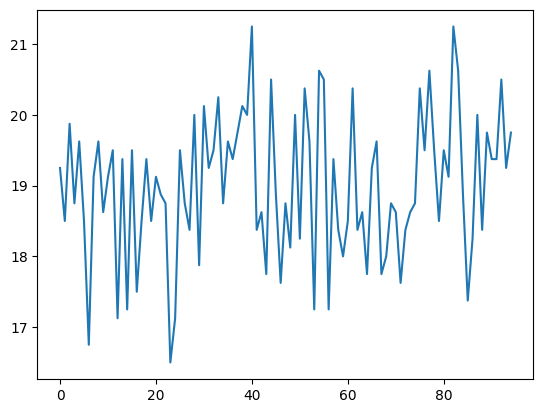

In [26]:
plt.plot(range(0, epochs), t_acc)
plt.show()

Validate the model

In [22]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.logits.squeeze(), targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.logits, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [27]:
acc = valid(model, test_loader)
print("Accuracy on test data = %0.2f%%" % acc)

2it [00:00, 11.36it/s]

Validation Loss per 100 steps: 2.0060157775878906
Validation Accuracy per 100 steps: 25.0


50it [00:02, 17.80it/s]

Validation Loss Epoch: 1.9245229434967042
Validation Accuracy Epoch: 22.0
Accuracy on test data = 22.00%


In [29]:
output_model_file = 'drive/MyDrive/HBO/cursussen/jaar_4/afstuderen/robbert_model.pth'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

('./vocab.json', './merges.txt')